In [155]:
using Zygote
using CuArrays
using CUDAnative
using CUDAdrv
using NNlib
using Test
using BenchmarkTools
using Flux
using Plots
using Images
using Colors
using ProgressMeter
using StaticArrays
using Statistics

In [156]:
#Zygote.@adjoint gpu(a :: Array) = gpu(a), a̅ -> (cpu(a̅),)
Zygote.@adjoint function Base.convert(::Type{T}, xs::Array{K,N}) where {T<:CuArray, K, N}
  Base.convert(T, xs), Δ -> (nothing, Base.convert(Array, Δ),)
end
Zygote.refresh()

# quantization

In [157]:
CuArrays.allowscalar(false)

### weights

In [158]:
function weight_masks(W, us)
    dims = size(W)

    W̅ = W .- mean(W)

    std_W = std(W)

    W̃s = cat((sign.(W̅ .+ (u * std_W)) for u in us)...,
            dims=length(size(W)) + 1)

    W̃s
end

weight_masks (generic function with 1 method)

In [159]:
function binarize_weights(W, us)
    W̃s = weight_masks(W, us)

    dims = size(W)

    Wv = reshape(W, :)
    W̃vs = reshape(W̃s, :, length(us))

    αs = W̃vs \ Wv

    W̃v = W̃vs * αs
    
    W̃ = reshape(W̃v, dims...)

    W̃, αs
end

binarize_weights (generic function with 4 methods)

In [160]:
Zygote.@adjoint function binarize_weights(W, us) 
    W̃ = binarize_weights(W, us)
    function adjoint((∇_W̃, ∇_αs)) 
        # the "straight-through estimator"
        (∇_W̃, nothing)
    end
    W̃, adjoint
end
Zygote.refresh()

In [161]:
even_us(M) = if M == 1
        [0.0f0]
    else
        Array(range(-1.0f0, stop=1.0f0, length=M))
end
function even_err(M, W)
    us = even_us(M)
    W̃, _ = binarize_weights(W, us)
    mean((W .- W̃).^2)
end

even_err (generic function with 1 method)

In [162]:
W = randn(Float32, 10,10,10,10)
()

()

In [163]:
binarize_weights(W, even_us(3))
()

()

In [164]:
# todo write gradient test!

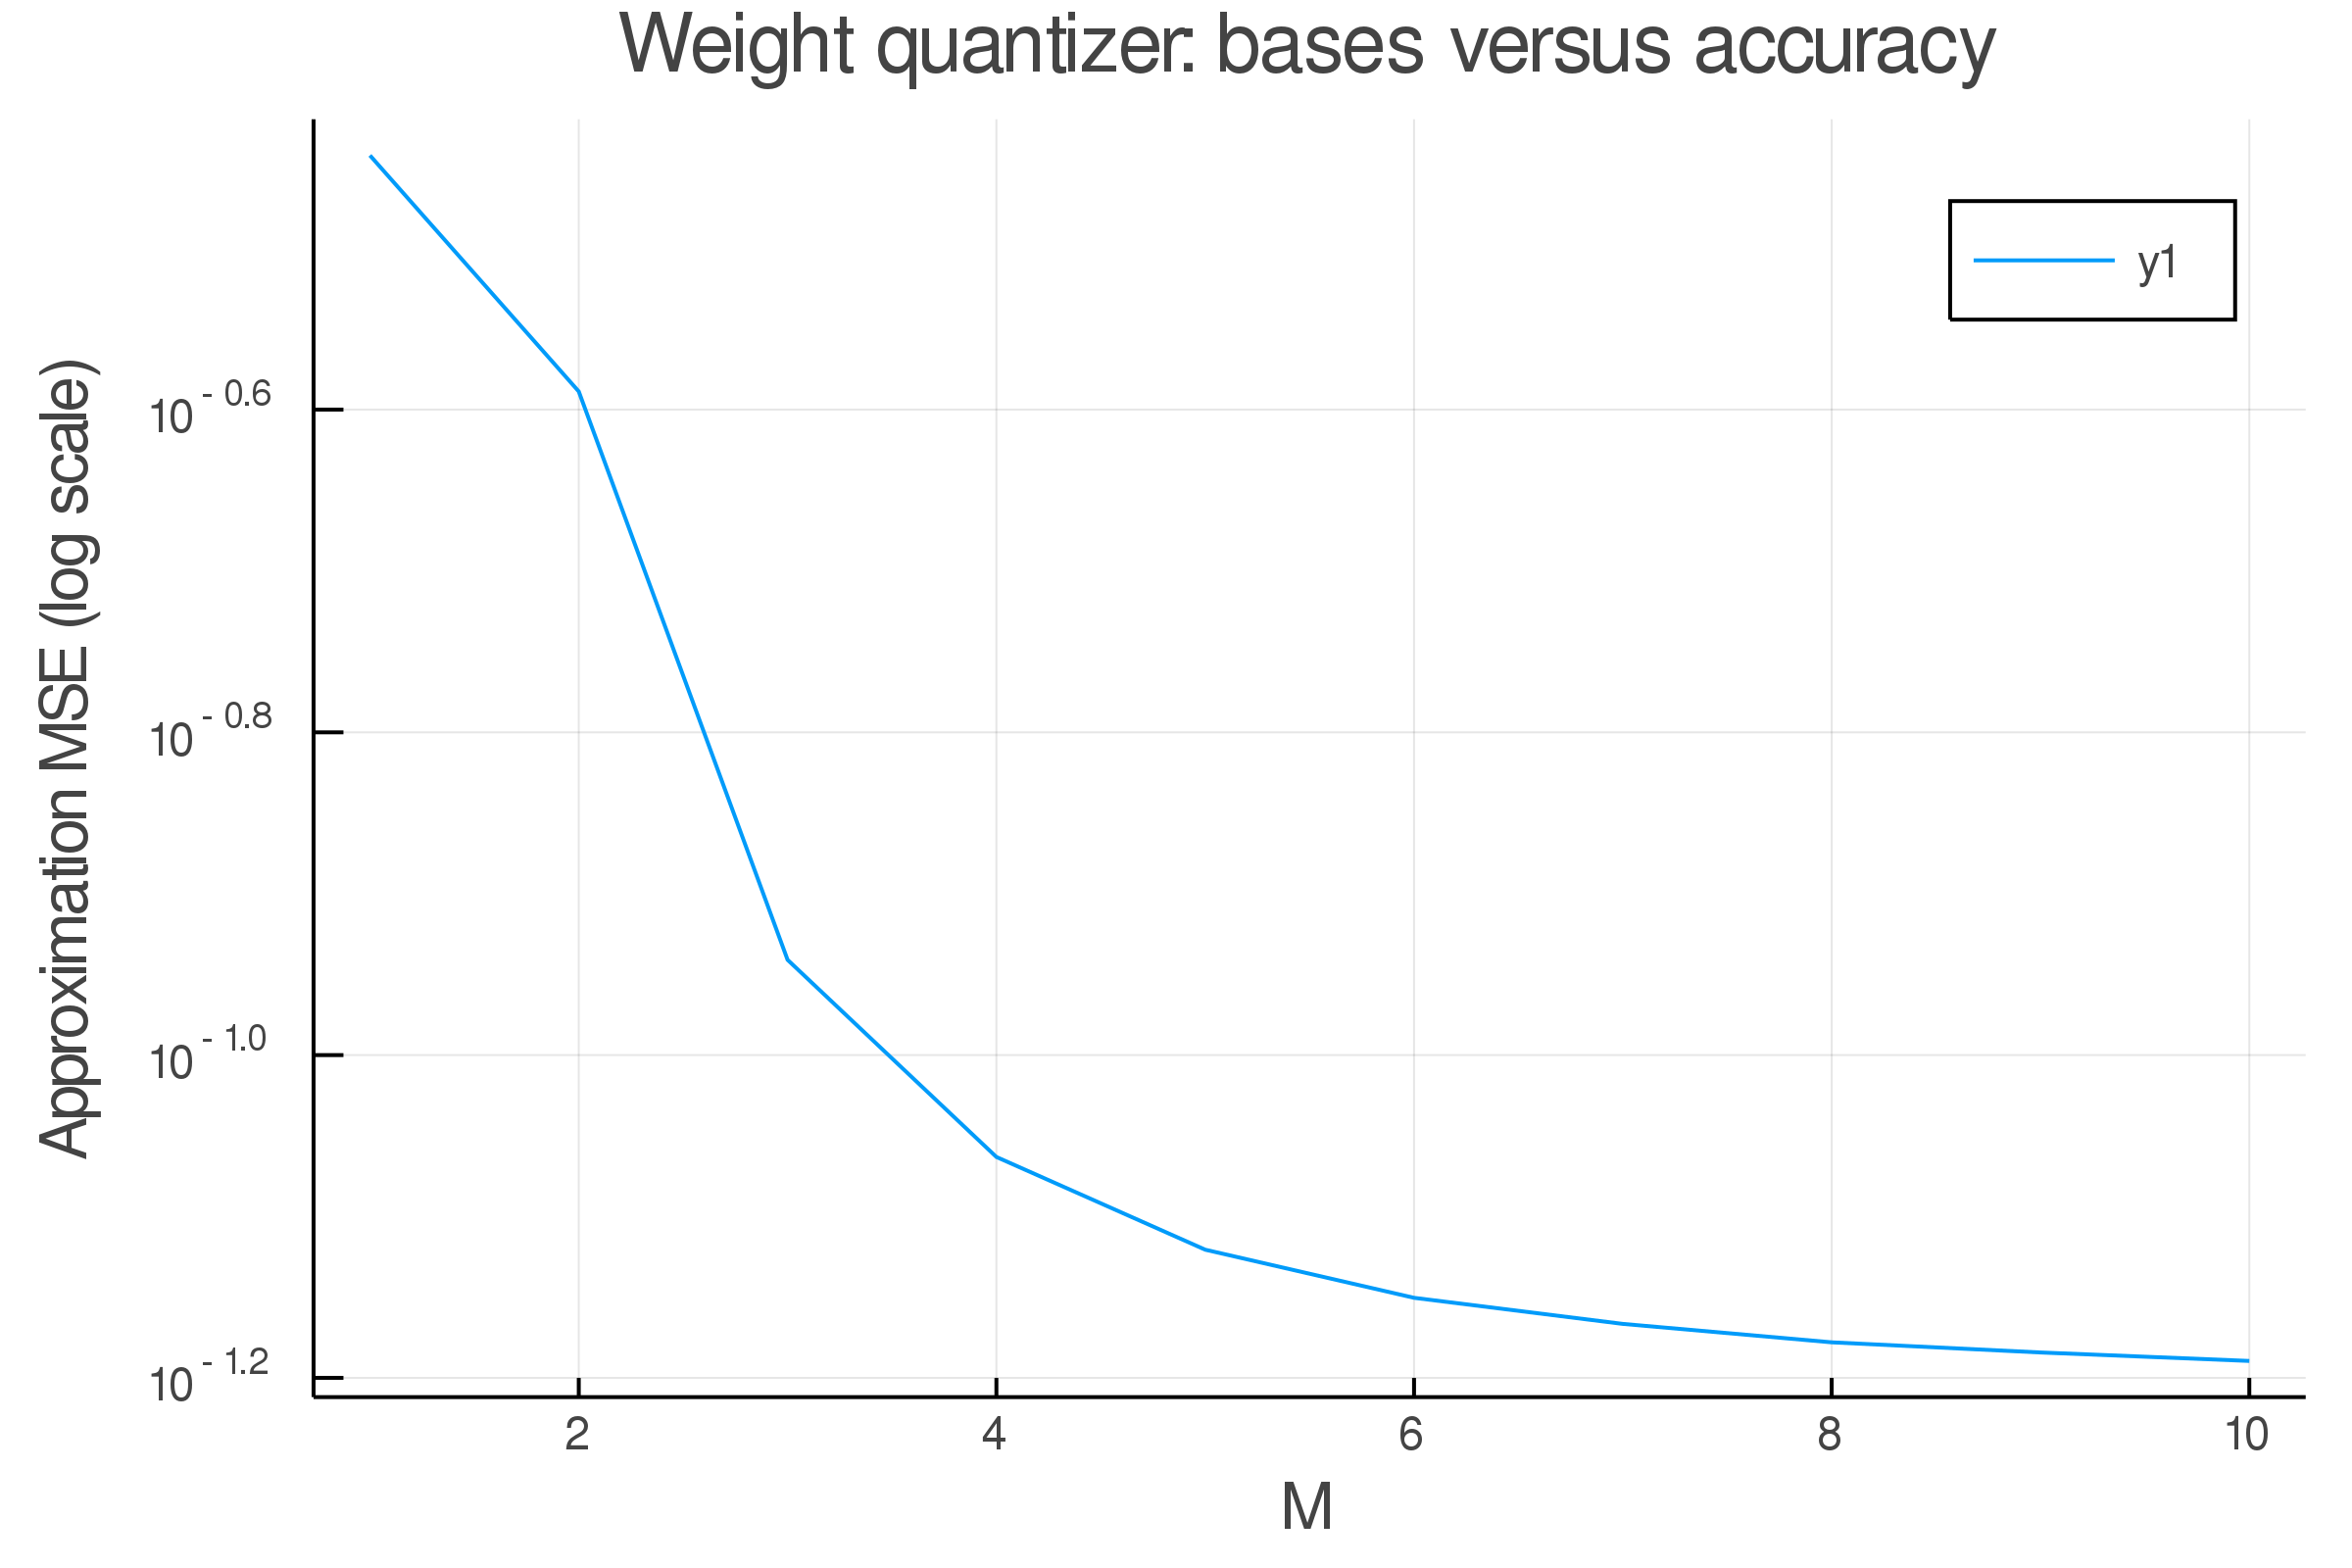

In [165]:
Ms = 1:10
errs = [even_err(M, W) for M in Ms]
plot(Ms, errs, xlabel="M", ylabel="Approximation MSE (log scale)", title="Weight quantizer: bases versus accuracy", format=:png, dpi=400, yscale=:log10)

In [166]:
# don't solve for alphas
function binarize_weights(W, us, αs)
    W̃s = weight_masks(W, us)

    dims = size(W)

    Wv = reshape(W, :)
    W̃vs = reshape(W̃s, :, length(us))

    W̃v = W̃vs * αs
    
    W̃ = reshape(W̃v, dims...)

    W̃
end

Zygote.@adjoint function binarize_weights(W, us, αs)
    # not sure why you'd need this, but might as well...
    W̃ = binarize_weights(W, us, αs)
    function adjoint(∇_W̃) 
        # the "straight-through estimator"
        (∇_W̃, nothing, nothing)
    end
    W̃, adjoint
end
Zygote.refresh()

In [167]:
us = even_us(5)
W̃, αs = binarize_weights(W, us)
W̃1 = binarize_weights(W, us, αs)

@test W̃ == W̃1

Test Passed

In [168]:
∇_W, ∇_us, ∇_αs = Zygote.gradient((W, us, αs) -> sum(binarize_weights(W, us, αs)), W, us, αs)
@test ∇_W == ones(Float32, size(W))
@test ∇_us == nothing
@test ∇_αs == nothing

Test Passed

In [169]:
function binarize_weights(W :: CuArray, us)
    W̃, αs = binarize_weights(cpu(W), cpu(us))
    gpu(W̃), cpu(αs) # note alphas are still on CPU!!
end
function binarize_weights(W :: CuArray, us, αs)
    W̃ = binarize_weights(cpu(W), cpu(us), cpu(αs))
    gpu(W̃)
end

binarize_weights (generic function with 4 methods)

In [170]:
#@btime binarize_weights(W, even_us(5))
()

()

In [171]:
Wg = gpu(W)
#@btime binarize_weights(Wg, even_us(5))
()

()

### activations

In [172]:
function z(q)
    if q > 0.5f0
        1.0f0
    else
        -1.0f0
    end
end

function _zrev(q, ∇_q)
    if 0.0f0 < q < 1.0f0
        ∇_q
    else
        0.0f0
    end
end

Zygote.@adjoint z(q) = z(q), (∇_q) -> _zrev(q, ∇_q)

function zb(Q)
    z.(Q)
end

Zygote.@adjoint zb(Q) = zb(Q), (∇_Q) -> (_zrev.(Q, ∇_Q),)

Zygote.refresh()

In [173]:
function binarize_activations(A, vs, βs)
    shape = size(A)
    
    Av_x = reshape( (A), :, 1)
    
    vs_x = reshape( (vs), 1, :)
    βs_x = reshape( (βs), 1, :)
    
    Av1 =  (Av_x) .+  (vs_x)
    #Av2 = z.( (Av1))
    Av2 = zb( (Av1))
    Av3 =  (Av2) .*  (βs_x)
    
    Ãv = sum( (Av3), dims=2)
    
    result = reshape( (Ãv), shape)
        
    result
end

Zygote.refresh()


In [174]:
A = randn(Float32, 4, 4)

4×4 Array{Float32,2}:
 -0.395354  -0.484792   1.53637   -1.35602 
  0.623933   1.34218   -0.140339   1.25815 
 -1.55637    1.05524   -0.579586  -0.749204
  1.1074    -0.339773   2.60559    1.14392 

In [175]:
vs = even_us(2)
bs = βs = ones(Float32, 2)

binarize_activations(A, vs, bs)

4×4 Array{Float32,2}:
  0.0  0.0   2.0  -2.0
  0.0  0.0   0.0   0.0
 -2.0  0.0  -2.0  -2.0
  0.0  0.0   2.0   0.0

In [176]:
Zygote.gradient((A, vs, βs) -> sum(binarize_activations(A, vs, βs)), A, vs, bs)

(Float32[1.0 1.0 1.0 0.0; 0.0 1.0 1.0 1.0; 0.0 1.0 1.0 1.0; 1.0 1.0 0.0 1.0], Float32[6.0, 6.0], Float32[-12.0, 8.0])

In [177]:
binarize_activations(gpu(A), gpu(even_us(2)), gpu(ones(2)))

4×4 CuArray{Float32,2,CuArray{Float32,2,Nothing}}:
  0.0  0.0   2.0  -2.0
  0.0  0.0   0.0   0.0
 -2.0  0.0  -2.0  -2.0
  0.0  0.0   2.0   0.0

In [178]:
((A, vs, βs) -> sum(binarize_activations(A, vs, βs)))(gpu(A), gpu(even_us(2)), gpu(ones(2)))

-4.0f0

In [179]:
Zygote.gradient((A, vs, βs) -> sum(binarize_activations(A, vs, βs)), gpu(A), gpu(even_us(2)), gpu(ones(2)))

(Float32[1.0 1.0 1.0 0.0; 0.0 1.0 1.0 1.0; 0.0 1.0 1.0 1.0; 1.0 1.0 0.0 1.0], Float32[6.0, 6.0], Float32[-12.0, 8.0])

In [180]:
function errors(N, steps=1000)
    vs = gpu(even_us(N))
    bs = βs = gpu(ones(Float32, N))

    opt = ADAM()
    ps = Params([vs, βs])
    errors = Float32[]
    @showprogress for _ in 1:steps
        # note: in loop!
        A = gpu(randn(100, 100))
        err, adjoint = pullback(ps) do
            Ã = binarize_activations(A, vs, βs)
            mean((A .- Ã).^2)
        end
        gs = adjoint(1.0)

        Flux.Optimise.update!(opt, ps, gs)
        push!(errors, err)
    end
    errors
    #plot(errors, xlabel="gradient descent step", ylabel="MSE", title="error with N=$N bits")
end

errors (generic function with 2 methods)

In [181]:
#e = (n -> errors(n, 2000)).([1,2,3,4,5,6,7])

#()

In [182]:
#p = plot(e[1], yscale=:log10, label="N=1", ylabel="Approximation MSE (log scale)", xlabel="Gradient descent step", title="Activation quantizer training",
#    format=:png, dpi=400)
#for i in 2:length(e)
#    plot!(p, e[i], label="N=$i")
#end
#p


In [183]:
# todo: should we use those learned weights as initializers? they approximate the normal distribution.

function normal_approximators(N)
    vs = gpu(even_us(N))
    βs = gpu(ones(Float32, N))

    opt = ADAM()
    ps = Params([vs, βs])

    for _ in 1:1000
        # note: in loop!
        A = gpu(randn(100, 100))
        _, adjoint = pullback(ps) do
            Ã = binarize_activations(A, vs, βs)
            mean((A .- Ã).^2)
        end
        gs = adjoint(1.0)

        Flux.Optimise.update!(opt, ps, gs)
    end
    
    vs, βs
end

#normal_approximators(2)

normal_approximators (generic function with 1 method)

In [184]:
#normal_approximators(2)

In [185]:
#normal_approximators(3)

# layers

In [186]:
mutable struct BinWeights{U <: AbstractVector, A <: AbstractVector}
    us :: U
    αs :: A
    active :: Bool
end

function BinWeights(W, us :: U; active=false) where U
    # note: W is not stored! it's just used to initialize alphas.
    _, αs = binarize_weights(W, us)
    BinWeights(us, αs, active)
end

BinWeights

In [187]:
# note: no args, because the parameters aren't trainable, and shouldn't be moved to GPU.
Flux.@functor BinWeights ()

In [188]:
function (bw :: BinWeights{U, A})(W) where {U, A}
    if bw.active
        if Flux.istraining()
            W̃, αs = binarize_weights(W, bw.us)
            bw.αs = αs
            W̃
        else
            # todo: cache W̃?
            W̃ = binarize_weights(W, bw.us, bw.αs)
            W̃
        end
    else
        W
    end
end

In [189]:
q = BinWeights(W, even_us(5), active=true)

BinWeights{Array{Float32,1},Array{Float32,1}}(Float32[-1.0, -0.5, 0.0, 0.5, 1.0], Float32[0.38914, 0.23943, 0.24836, 0.242, 0.403992], true)

In [190]:
@test q(W) == binarize_weights(W, even_us(5))[1]

Test Passed

In [191]:
@test gpu(q) === q

Test Passed

In [192]:
mutable struct BinActs{V, B}
    vs :: V
    βs :: B
    active :: Bool
end

function BinActs(vs :: V, βs :: B; active=false) where {V, B}
    # note: W is not stored! it's just used to initialize alphas.
    BinActs(vs, βs, active)
end

function (ba :: BinActs{V, B})(A) where {V, B}
    if ba.active
        binarize_activations(A, ba.vs, ba.βs)
    else
        A
    end
end

Flux.@functor BinActs (vs, βs)

In [193]:
# from https://github.com/FluxML/Flux.jl/blob/fb4a48f970ba40d0022a7488b48d19cd563867c4/src/layers/conv.jl
# note: does not include activation, that should go before (?)

"""
Standard convolutional layer with ABC-based quantization.
"""
struct ABCCrossCor{W,Z, S,P, U,A, V,B} # that's a lotta parameters!!
    weight::W
    bias::Z
    
    stride::NTuple{S,Int}
    pad::NTuple{P,Int}
    dilation::NTuple{S,Int}
    
    bin_weights :: BinWeights{U, A}
    bin_acts :: BinActs{V, B}
end

ABCCrossCor

In [194]:
function ABCCrossCor(weight::AbstractArray{T,K}, bias::AbstractVector{T},
                 us::AbstractVector{T}, vs::AbstractVector{T}, βs::AbstractVector{T};
              stride = 1, pad = 0, dilation = 1, bin_active=false) where {T, K}
    @assert size(vs) == size(βs)
    
    stride = expand(Val(K-2), stride)
    pad = expand(Val(2*(K-2)), pad)
    dilation = expand(Val(K-2), dilation)
    
    bin_weights = BinWeights(weight, us, active=bin_active) # note: weights is used to initialize αs, not stored
    bin_acts = BinActs(vs, βs, active=bin_active)
    
    ABCCrossCor(weight, bias, stride, pad, dilation, bin_weights, bin_acts)
end

expand(N, i::Tuple) = i
expand(N, i::Integer) = ntuple(_ -> i, N)

function ABCCrossCor(k::NTuple{D,Integer}, ch::Pair{<:Integer,<:Integer}, N::Integer, M::Integer;
    weight_init = Flux.glorot_uniform, bias_init=k -> zeros(Float32, k), 
    us_init=even_us, vs_init=even_us, βs_init=k -> ones(Float32, k), 
    stride = 1, pad = 0, dilation = 1,
    bin_active=false) where D
        
    ABCCrossCor(weight_init(k..., ch...), bias_init(ch[2]),
           us_init(M), vs_init(N), βs_init(N),
           stride = stride, pad = pad, dilation = dilation, bin_active=bin_active)
end

Flux.@functor ABCCrossCor

function (c::ABCCrossCor)(A::AbstractArray)
    b = reshape(c.bias, map(_->1, c.stride)..., :, 1)
    
    W = c.weight
    W̃ = c.bin_weights(W)
    
    Ã = c.bin_acts(A)
    
    cdims = DenseConvDims(Ã, W̃; stride=c.stride, padding=c.pad, dilation=c.dilation)
    #println("W̃: ", typeof(W̃), " ", size(W̃), " Ã: ", typeof(Ã), " ", size(Ã), " b: ", typeof(b), " ", size(b), " dims: ", cdims)
    
    conv(Ã, W̃, cdims) .+ b
end

# Base.show(io :: IO, ::Type{ABCCrossCor}) = print(io, "ABCCrossCor")
function Base.show(io::IO, l::ABCCrossCor)
    print(io, "ABCCrossCor(", size(l.weight)[1:ndims(l.weight)-2])
    print(io, ", ", size(l.weight, ndims(l.weight)-1), "=>", size(l.weight, ndims(l.weight)))
    print(io, ", ", size(l.bin_acts.vs), ", ", size(l.bin_weights.us))
    print(io, ", active=", l.bin_acts.active)

    print(io, ")")
end

In [195]:
function (c::Conv)(A::AbstractArray)

  σ, b = c.σ, reshape(c.bias, map(_->1, c.stride)..., :, 1)
  W = c.weight
  cdims = DenseConvDims(A, W; stride=c.stride, padding=c.pad, dilation=c.dilation)

  r = σ.(conv(A, W, cdims) .+ b)

  r
end

In [196]:
CrossCor((3, 3), 10=>10)(randn(Float32, 5, 5, 10, 1))
ABCCrossCor((3, 3), 10=>10, 1, 1, bin_active=true)(randn(Float32, 5, 5, 10, 1))
()

()

In [197]:
gpu(CrossCor((3, 3), 10=>10))(gpu(randn(Float32, 5, 5, 10, 1)))
gpu(ABCCrossCor((3, 3), 10=>10, 1, 1, bin_active=true))(gpu(randn(Float32, 5, 5, 10, 1)))

()

()

In [198]:
q = ABCCrossCor((3,3), 10 => 10, 1, 1)

ABCCrossCor((3, 3), 10=>10, (1,), (1,), active=false)

In [199]:
function binarize(c :: ABCCrossCor; active=true)
    c.bin_acts.active = active
    c.bin_weights.active = active
    ()
end

binarize (generic function with 1 method)

In [47]:
Zygote.refresh()

# kernels

In [43]:
using CuArrays, CUDAnative, BenchmarkTools, Test

In [44]:
# todo: how does julia's multi-dimensional indexing computation work? 
# todo: array-walking helpers
# todo: helper functions for computing sizes of output arrays (ceil to multiples of 64)
# todo: 32 and 64 bit versions?
# todo: iterate channels
# todo: maximize occupancy

In [45]:
simplequant(x) = x > 0
bit_to_float(b :: Bool) = if b 1.0f0 else -1.0f0 end

bit_to_float (generic function with 1 method)

In [46]:
# layout:

# todo: optimize this
# todo: support more than 1024 channels

# thread x: C index

# block x: W
# block y: H
# block z: B

# note: P is packed C

# todo: type for output w/ channel annotation

# note: WHCB is the *input* and PWHB is the *output*
function quant_pack_WHCB_PWHB_32_kernel!(quantized, input, f)
    tidx = threadIdx()
    bidx = blockIdx()
    
    c = tidx.x
    
    w = bidx.x
    h = bidx.y
    n = bidx.z
    
    p = div(c - 1, 32) + 1
    @inbounds begin
        ballot = vote_ballot(f(input[w,h,c,n]))
        if (c - 1) % 32 == 0
            quantized[p,w,h,n] = ballot
        end
    end
    return
end

(W,H,C,B) = (10, 10, 128, 128)
P = ceil(Int64, C/32)

input_WHCB = CuArray(randn(Float32, W, H, C, B))
quantized_PWHB = CuArray(zeros(UInt32, P, W, H, B))

CuArrays.@sync @cuda threads=C blocks=(W, H, B) quant_pack_WHCB_PWHB_32_kernel!(quantized_PWHB, input_WHCB, simplequant)
()

()

In [47]:
## (W,H,C,B) = (10, 10, 128, 128)
# @btime CuArrays.@sync @cuda threads=C blocks=(W, H, B) quant_pack_WHCB_PWHB_32_kernel!(quantized_PWHB, input_WHCB, (x) -> x > 0)
## pre-inbounds: 1ms
## inbounds: 115.657 μs (57 allocations: 2.63 KiB)

In [48]:
function quant_pack_WHCB_PWHB_32(input_WHCB; quant=simplequant)
    (W,H,C,B) = size(input_WHCB)
    P = ceil(Int64, C/32)
    quantized_PWHB = CuArray{UInt32}(undef, P, W, H, B) # todo allow this as arg
    @cuda threads=C blocks=(W, H, B) quant_pack_WHCB_PWHB_32_kernel!(quantized_PWHB, input_WHCB, quant)
    quantized_PWHB
end

quant_pack_WHCB_PWHB_32 (generic function with 1 method)

In [49]:
@test quant_pack_WHCB_PWHB_32(input_WHCB) == quantized_PWHB

Test Passed

In [50]:
function unpack_PWHB_WHCB_32_kernel!(unquantized, quantized)
    tidx = threadIdx()
    bidx = blockIdx()
    
    c = tidx.x
    
    w = bidx.x
    h = bidx.y
    n = bidx.z
    
    p = div(c - 1, 32) + 1
    
    @inbounds begin
        q = quantized[p,w,h,n]
        unquantized[w,h,c,n] = ((q >> rem(c - 1, 32)) & 1) == 1
    end
    return
end
unquantized_WHCB = CuArray(zeros(Bool, W, H, C, B))
CuArrays.@sync @cuda threads=C blocks=(W, H, B) unpack_PWHB_WHCB_32_kernel!(unquantized_WHCB, quantized_PWHB)

@test simplequant.(input_WHCB) == unquantized_WHCB
@test bit_to_float.(simplequant.(input_WHCB)) == bit_to_float.(unquantized_WHCB)

()

()

In [51]:
function unpack_PWHB_WHCB_32(quantized_PWHB; channels=size(quantized_PWHB, 1) * 32)
    (P,W,H,B) = size(quantized_PWHB)
    C = channels
    @assert C <= P * 32
    unquantized_WHCB = CuArray{Bool}(undef, W, H, C, B)

    @cuda threads=C blocks=(W, H, B) unpack_PWHB_WHCB_32_kernel!(unquantized_WHCB, quantized_PWHB)
    unquantized_WHCB
end

@test unpack_PWHB_WHCB_32(quantized_PWHB) == unquantized_WHCB

Test Passed

In [52]:
# cuda-compatible strides()
# is there a better way to implement this?? probably.

function _strides(dims :: NTuple{1, T}) :: NTuple{1, T} where T <: Integer
    return (T(1),)
end
function _strides(dims :: NTuple{2, T}) :: NTuple{2, T} where T <: Integer
    (d1, d2) = dims
    return (T(1), d1)
end
function _strides(dims :: NTuple{3, T}) :: NTuple{3, T} where T <: Integer
    (d1, d2, d3) = dims
    d12 = d1 * d2
    return (T(1), d1, d12)
end
function _strides(dims :: NTuple{4, T}) :: NTuple{4, T} where T <: Integer
    (d1, d2, d3, d4) = dims
    d12 = d1 * d2
    d123 = d12 * d3
    return (T(1), d1, d12, d123)
end
function _strides(dims :: NTuple{5, T}) :: NTuple{5, T} where T <: Integer
    (d1, d2, d3, d4, d5) = dims
    d12 = d1 * d2
    d123 = d12 * d3
    d1234 = d123 * d4

    return (T(1), d1, d12, d123, d1234)
end

_strides (generic function with 5 methods)

In [53]:
A = (10, 2, 3, 5, 2)
@test strides(randn(A...)) == _strides(A)
A = (10, 2, 3, 5)
@test strides(randn(A...)) == _strides(A)
A = (10, 2, 3)
@test strides(randn(A...)) == _strides(A)
A = (10, 2)
@test strides(randn(A...)) == _strides(A)
A = (10,)
@test strides(randn(A...)) == _strides(A)

Test Passed

In [54]:
function _ind2sub0(strides :: NTuple{1, T}, ind0 :: T) :: NTuple{1, T} where T <: Integer
    s1 = div(ind0, strides[1])
    (s1,)
end
function _ind2sub0(strides :: NTuple{2, T}, ind0 :: T) :: NTuple{2, T} where T <: Integer
    s2 = div(ind0, strides[2]) 
    ind0 -= s2 * strides[2]
    s1 = div(ind0, strides[1])
    
    (s1, s2)
end
function _ind2sub0(strides :: NTuple{3, T}, ind0 :: T) :: NTuple{3, T} where T <: Integer
    s3 = div(ind0, strides[3]) 
    ind0 -= s3 * strides[3]
    s2 = div(ind0, strides[2]) 
    ind0 -= s2 * strides[2]
    s1 = div(ind0, strides[1])
    
    (s1, s2, s3)
end
function _ind2sub0(strides :: NTuple{4, T}, ind0 :: T) :: NTuple{4, T} where T <: Integer
    s4 = div(ind0, strides[4])
    ind0 -= s4 * strides[4]
    s3 = div(ind0, strides[3]) 
    ind0 -= s3 * strides[3]
    s2 = div(ind0, strides[2]) 
    ind0 -= s2 * strides[2]
    s1 = div(ind0, strides[1])
    
    (s1, s2, s3, s4)
end
function _ind2sub0(strides :: NTuple{5, T}, ind0 :: T) :: NTuple{5, T} where T <: Integer
    s5 = div(ind0, strides[5])
    ind0 -= s5 * strides[5]
    s4 = div(ind0, strides[4])
    ind0 -= s4 * strides[4]
    s3 = div(ind0, strides[3]) 
    ind0 -= s3 * strides[3]
    s2 = div(ind0, strides[2]) 
    ind0 -= s2 * strides[2]
    s1 = div(ind0, strides[1])
    
    (s1, s2, s3, s4, s5)
end

_ind2sub0 (generic function with 5 methods)

In [55]:
struct Ind2Sub{N, I <: Integer}
    offsets :: NTuple{N, I}
    strides :: NTuple{N, I}
end

function Ind2Sub(ranges :: NTuple{N, UnitRange{I}}) :: Ind2Sub{N, I} where {N, I <: Integer}
    Ind2Sub(
        (r -> r.start).(ranges),
        _strides((r -> 1 + r.stop - r.start).(ranges))
    )
end

function Base.getindex(i2s :: Ind2Sub{N, I}, i :: I) :: NTuple{N, I} where {N, I}
    _ind2sub0(i2s.strides, i - 1) .+ i2s.offsets
end

In [56]:
A = (1:5, 3:7, 10:12, 30:33)
c = CartesianIndices(A) # doesn't work on gpu >:/
i2s = Ind2Sub(A)
for i in 1:length(c)
    @test Tuple(c[i]) == i2s[i]
end

In [57]:
"""
Copy a slice of an array to local shared memory, using an entire block.

NOTE: for this to work you must be only varying the X thread index!!
NOTE: target should be contiguous!
"""

function kernel_copy!(
        target :: CuDeviceArray{T},
        source :: CuDeviceArray{T, NS},
        source_slices :: NTuple{NS, UnitRange{I}}) :: Nothing where {T, NS, I <: Integer}
    @inbounds begin
        i2s_source = Ind2Sub(source_slices)
        i2s_target = Ind2Sub((s -> 1:s).(size(target)))

        tidx = CUDAnative.threadIdx_x()
        tmax = CUDAnative.blockDim_x()
        
        l = length(target)
        
        i = tidx
        while i <= l
            target[i2s_target[i]...] = source[i2s_source[i]...]
            i += tmax
        end
    end

    CUDAnative.sync_threads() # TODO move out to allow multiple copies?
    
    return 
end

kernel_copy! (generic function with 1 method)

In [64]:
# todo activation
# todo padding
# todo shared memory
# todo multipliers?
# todo bias
# todo teach ABCCrossCor about 1-padding??
# -> no; just use whatever value it gives for 0??
# todo fuse padding (into above?)
# todo dispatch functions

function qconv_32_kernel!(output, input, kernel, channels_in_kernel)
    bidx = blockIdx()
    tidx = threadIdx()

    w₂ = bidx.x
    h₂ = bidx.y
    b = bidx.z

    o = tidx.x

    # PWHO
    Hₖ = size(kernel, 3)
    Wₖ = size(kernel, 2)
    
    h_top = h₂ - (div(Hₖ, 2))
    w_left = w₂ - (div(Wₖ, 2))
    
    P = size(input, 1)
    
    plus_1s = 0
        
    #input_cache = @cuDynamicSharedMem(UInt32, (P, Wₖ, Hₖ))
    
    #kernel_copy!(input_cache,
    #             input, (1:P, w_left+1:w_left+Wₖ, h_top+1:h_top+Hₖ, b:b))
        
    #@cuprintf("%ld %ld %ld %ld\n", w₂, h₂, n, o)

    @inbounds begin
        for p in 1:P
            for x in 1:Hₖ
                for y in 1:Wₖ
                    ## pre-shared:
                    w₁ = w_left + x
                    h₁ = h_top + y
                    input_value = input[p,w₁,h₁,b]
                    
                    #input_value = input_cache[p, x, y]
                    kernel_value = kernel[p,x,y,o]

                    plus_1s += CUDAnative.popc(reinterpret(Int32, ~xor(input_value, kernel_value)))
                end
            end
        end
    end
    
    #@cuprintf("%ld %ld %ld %ld: success!\n", w₂, h₂, n, o)
    
    # todo precompute factor?
    minus_1s = (channels_in_kernel - plus_1s)
    output_value = Float32(plus_1s - minus_1s)
    
    output[w₂,h₂,o,b] = output_value
    
    return
end

# input layout: P W₁ H₁ B
# kernel layout: P Wₖ Hₖ O
# output layout: W₂ H₂ O B

# (P: packed in channels, O: unpacked out channels)

# (default conv kernel layout: WHCO; can reuse other quantize op.)

function qconv_32(input, kernel; in_channels=size(kernel, 1) * 32)
    (P, W₁, H₁, B) = size(input)
    (P_, Wₖ, Hₖ, O) = size(kernel)
    @assert P == P_
    @assert in_channels <= P * 32
    @assert (Wₖ % 2) == 1
    @assert (Hₖ % 2) == 1
    
    # spurious: could adjust logic here

    W₂ = W₁ - 2 * div(Wₖ, 2)
    H₂ = H₁ - 2 * div(Hₖ, 2)
    
    output = CuArray{Float32}(undef, W₂, H₂, O, B)
    
    channels_in_kernel = in_channels * size(kernel, 3) * size(kernel, 2)
    
    #@device_code_warntype @cuda threads=O blocks=(W₂, H₂, B) qconv_32_kernel!(output, input, kernel, channels_in_kernel)
    #println(size(output), " ", size(input), " ", size(kernel), " ", channels_in_kernel)
    @cuda threads=O blocks=(W₂, H₂, B) shmem=(P*Wₖ*Hₖ*sizeof(UInt32) * 2) qconv_32_kernel!(output, input, kernel, channels_in_kernel)
    
    output
end

function test_qconv_32(input, kernel)
    input = CuArray(bit_to_float.(simplequant.(input)))
    kernel = CuArray(bit_to_float.(simplequant.(kernel)))

    input_quantized = quant_pack_WHCB_PWHB_32(input)
    kernel_quantized = quant_pack_WHCB_PWHB_32(kernel)

    CuArrays.@sync output = qconv_32(input_quantized, kernel_quantized)
    correct = CuArrays.conv(input, kernel, CuArrays.DenseConvDims(input, kernel, flipkernel=true))
    @assert output == correct
end

test_qconv_32 (generic function with 1 method)

In [65]:
test_qconv_32(-ones(Float32, 3, 3, 32, 1), ones(Float32, 3, 3, 32, 1))
test_qconv_32(randn(Float32, 3, 3, 32, 1), ones(Float32, 3, 3, 32, 1))
test_qconv_32(ones(Float32, 3, 3, 32, 1), randn(Float32, 3, 3, 32, 1))
test_qconv_32(randn(Float32, 3, 3, 32, 1), randn(Float32, 3, 3, 32, 1))
test_qconv_32(randn(Float32, 3, 3, 32, 1), ones(Float32, 3, 3, 32, 1))
test_qconv_32(randn(Float32, 3, 3, 32, 2), randn(Float32, 3, 3, 32, 1))
test_qconv_32(randn(Float32, 3, 3, 32, 1), randn(Float32, 3, 3, 32, 2))
test_qconv_32(randn(Float32, 5, 5, 32, 1), randn(Float32, 3, 3, 32, 1))
test_qconv_32(randn(Float32, 5, 5, 32, 2), randn(Float32, 3, 3, 32, 2))
test_qconv_32(randn(Float32, 10, 10, 128, 128), randn(Float32, 3, 3, 128, 128))

In [66]:
input = CuArray(bit_to_float.(simplequant.(randn(Float32, 10, 10, 128, 128))))
kernel = CuArray(bit_to_float.(simplequant.(randn(Float32, 3, 3, 128, 128))))
input_quantized = quant_pack_WHCB_PWHB_32(input)
kernel_quantized = quant_pack_WHCB_PWHB_32(kernel)

input, kernel = input_quantized, kernel_quantized

in_channels=size(kernel, 1) * 32

(P, W₁, H₁, B) = size(input)
(P_, Wₖ, Hₖ, O) = size(kernel)
@assert P == P_
@assert in_channels <= P * 32
@assert (Wₖ % 2) == 1
@assert (Hₖ % 2) == 1

W₂ = W₁ - 2 * div(Wₖ, 2)
H₂ = H₁ - 2 * div(Hₖ, 2)

output = CuArray{Float32}(undef, W₂, H₂, O, B)

channels_in_kernel = in_channels * size(kernel, 3) * size(kernel, 2)

#@device_code_warntype @cuda threads=O blocks=(W₂, H₂, B) qconv_32_kernel!(output, input, kernel, channels_in_kernel)
#println(size(output), " ", size(input), " ", size(kernel), " ", channels_in_kernel)
@btime CuArrays.@sync @cuda threads=O blocks=(W₂, H₂, B) shmem=(P*Wₖ*Hₖ*sizeof(UInt32) * 2) qconv_32_kernel!(output, input, kernel, channels_in_kernel)
()

  1.616 ms (75 allocations: 3.88 KiB)


()

### multi-input convolution

In [2]:
using CuArrays, CUDAnative, BenchmarkTools, Test

In [3]:
simplequant(x) = x > 0
bit_to_float(b :: Bool) = if b 1.0f0 else -1.0f0 end

bit_to_float (generic function with 1 method)

In [4]:
# note: WHCNB is the *input* (input) and PWHNB is the *output* (quantized)
function quant_pack_WHCNB_PWHNB_32_kernel!(quantized, input, f)
    tidx = threadIdx()
    bidx = blockIdx()
    
    c = tidx.x
    
    w = bidx.x
    h = bidx.y
    b = bidx.z
    
    p = div(c - 1, 32) + 1
    
    N = size(input, 4)
    
    #@inbounds begin
        for n in 1:N
            ballot = vote_ballot(f(input[w,h,c,n,b]))
            if (c - 1) % 32 == 0
                quantized[p,w,h,n,b] = ballot
            end
        end
    #end
    return
end

(W,H,C,N,B) = (10, 10, 128, 3, 128)
P = ceil(Int64, C/32)

input_WHCNB = CuArray(randn(Float32, W, H, C, N, B))
quantized_PWHNB = CuArray(zeros(UInt32, P, W, H, N, B))

CuArrays.@sync @cuda threads=C blocks=(W, H, B) quant_pack_WHCNB_PWHNB_32_kernel!(quantized_PWHNB, input_WHCNB, simplequant)
()

()

In [5]:
function quant_pack_WHCNB_PWHNB_32(input_WHCNB; quant=simplequant)
    (W,H,C,N,B) = size(input_WHCNB)
    P = ceil(Int64, C/32)
    quantized_PWHNB = CuArray{UInt32}(undef, P, W, H, N, B) # todo allow this as arg
    @cuda threads=C blocks=(W, H, B) quant_pack_WHCNB_PWHNB_32_kernel!(quantized_PWHNB, input_WHCNB, quant)
    quantized_PWHNB
end

quant_pack_WHCNB_PWHNB_32 (generic function with 1 method)

In [6]:
function unpack_PWHNB_WHCNB_32_kernel!(unquantized, quantized)
    tidx = threadIdx()
    bidx = blockIdx()
    
    c = tidx.x
    
    w = bidx.x
    h = bidx.y
    b = bidx.z
    
    p = div(c - 1, 32) + 1
    
    N = size(quantized, 4)
    
    @inbounds begin
        for n in 1:N
            q = quantized[p,w,h,n,b]
            unquantized[w,h,c,n,b] = ((q >> rem(c - 1, 32)) & 1) == 1
        end
    end
    return
end
unquantized_WHCNB = CuArray(zeros(Bool, W, H, C, N, B))
CuArrays.@sync @cuda threads=C blocks=(W, H, B) unpack_PWHNB_WHCNB_32_kernel!(unquantized_WHCNB, quantized_PWHNB)

@test simplequant.(input_WHCNB) == unquantized_WHCNB

()

()

In [7]:
function unpack_PWHNB_WHCNB_32(quantized_PWHNB; channels=size(quantized_PWHNB, 1) * 32)
    (P,W,H,N,B) = size(quantized_PWHNB)
    C = channels
    @assert C <= P * 32
    unquantized_WHCNB = CuArray{Bool}(undef, W, H, C, N, B)

    @cuda threads=C blocks=(W, H, B) unpack_PWHNB_WHCNB_32_kernel!(unquantized_WHCNB, quantized_PWHNB)
    unquantized_WHCNB
end

@test unpack_PWHNB_WHCNB_32(quantized_PWHNB) == unquantized_WHCNB

Test Passed

In [8]:
other_PWHNB = CuArray(rand(UInt32, 4, 4, 4, 4, 4))
@test quant_pack_WHCNB_PWHNB_32(unpack_PWHNB_WHCNB_32(other_PWHNB)) == other_PWHNB

Test Passed

In [236]:
# input layout: P W₁ H₁ N B
# kernel layout: P Wₖ Hₖ M O
# output layout: W₂ H₂ O B
# βs layout: N
# αs layout: M

function qconv_32_multi_kernel!(output, input, kernel, βs, αs, channels_in_kernel)
    bidx = blockIdx()
    tidx = threadIdx()

    w₂ = bidx.x
    h₂ = bidx.y
    b = bidx.z

    o = tidx.x

    P = size(kernel, 1)
    Wₖ = size(kernel, 2)
    Hₖ = size(kernel, 3)
    M = size(kernel, 4)
    
    N = size(input, 4)
    
    h_top = h₂ - (div(Hₖ, 2))
    w_left = w₂ - (div(Wₖ, 2))
    
    #input_cache = @cuDynamicSharedMem(UInt32, (P, Wₖ, Hₖ))
    
    sum = 0.0f0
    
    @inbounds begin
        for m in 1:M
            for n in 1:N
                #kernel_copy!(input_cache,
                #             input, (1:P, w_left+1:w_left+Wₖ, h_top+1:h_top+Hₖ, b:b))
                plus_1s = 0

                for p in 1:P
                    for x in 1:Hₖ
                        for y in 1:Wₖ
                            ## pre-shared:
                            w₁ = w_left + x
                            h₁ = h_top + y
                            input_value = input[p,w₁,h₁,n,b]

                            #input_value = input_cache[p, x, y]
            
                            kernel_value = kernel[p,x,y,m,o]

                            plus_1s += CUDAnative.popc(reinterpret(Int32, ~xor(input_value, kernel_value)))
                        end
                    end
                end
                
                minus_1s = (channels_in_kernel - plus_1s)
                output_value = Float32(plus_1s - minus_1s)
                sum += βs[n] * αs[m] * output_value
            end
        end
    end
    
#    end
    
    #@cuprintf("%ld %ld %ld %ld: success!\n", w₂, h₂, n, o)
    
    output[w₂,h₂,o,b] = sum
    
    return
end

function qconv_32_multi(input :: CuArray{UInt32, 5},
            kernel :: CuArray{UInt32, 5},
            βs :: CuVector{Float32},
            αs :: CuVector{Float32};
            in_channels=size(kernel, 1) * 32)
    (P, W₁, H₁, N, B) = size(input)
    (P_, Wₖ, Hₖ, M, O) = size(kernel)
    @assert P == P_
    @assert in_channels <= P * 32
    @assert (Wₖ % 2) == 1
    @assert (Hₖ % 2) == 1
    
    W₂ = W₁ - 2 * div(Wₖ, 2)
    H₂ = H₁ - 2 * div(Hₖ, 2)
    
    output = CuArray{Float32}(undef, W₂, H₂, O, B)
    
    channels_in_kernel = in_channels * Wₖ * Hₖ
    
    # ...
    βs = Tuple(Array(βs))
    αs = Tuple(Array(αs))
    
    @cuda threads=O blocks=(W₂, H₂, B) shmem=(P*Wₖ*Hₖ*sizeof(UInt32) * 2) qconv_32_multi_kernel!(output, input, kernel, βs, αs, channels_in_kernel)
    
    output
end

function test_qconv_32_multi(input_quantized, kernel_quantized, βs, αs)

    input_quantized = CuArray(input_quantized)
    kernel_quantized = CuArray(kernel_quantized)
    βs = CuArray(βs)
    αs = CuArray(αs)
    
    CuArrays.@sync output = qconv_32_multi(input_quantized, kernel_quantized, βs, αs)
    
    input_N = bit_to_float.(unpack_PWHNB_WHCNB_32(input_quantized))
    kernel_M = bit_to_float.(unpack_PWHNB_WHCNB_32(kernel_quantized))
        
    βs_N = reshape(βs, 1, 1, 1, :, 1)
    αs_M = reshape(αs, 1, 1, 1, :, 1)

    input = dropdims(sum(input_N .* βs_N, dims=4), dims=4)
    kernel = dropdims(sum(kernel_M .* αs_M, dims=4), dims=4)
    
    correct = CuArrays.conv(input, kernel, CuArrays.DenseConvDims(input, kernel, flipkernel=true))
    
    @assert maximum(abs.(output .- correct)) < 0.00001
end

test_qconv_32_multi (generic function with 1 method)

In [237]:
test_qconv_32_multi(
    fill(UInt32(0xffffffff), 1, 3, 3, 1, 1),
    fill(UInt32(0xffffffff), 1, 3, 3, 1, 1),
    [1.0f0],
    [1.0f0])
test_qconv_32_multi(
    fill(UInt32(0xffffffff), 1, 3, 3, 1, 1),
    fill(UInt32(0xffffffff), 1, 3, 3, 1, 1),
    [2.0f0],
    [-1.0f0])

In [238]:
test_qconv_32_multi(
    fill(UInt32(0xffffffff), 1, 3, 3, 2, 1),
    fill(UInt32(0xffffffff), 1, 3, 3, 1, 1),
    [1.0f0, 1.0f0],
    [1.0f0])
test_qconv_32_multi(
    fill(UInt32(0xffffffff), 1, 3, 3, 1, 1),
    fill(UInt32(0xffffffff), 1, 3, 3, 2, 1),
    [1.0f0],
    [1.0f0, 1.0f0])

In [239]:
test_qconv_32_multi(
    rand(UInt32, 1, 3, 3, 1, 1),
    fill(UInt32(0xffffffff), 1, 3, 3, 1, 1),
    [1.0f0],
    [1.0f0])

In [240]:
test_qconv_32_multi(
    rand(UInt32, 1, 3, 3, 1, 1),
    rand(UInt32, 1, 3, 3, 1, 1),
    [1.0f0],
    [1.0f0])

In [241]:
test_qconv_32_multi(
    rand(UInt32, 1, 3, 3, 2, 1),
    rand(UInt32, 1, 3, 3, 2, 1),
    [1.0f0, -1.0f0],
    [1.0f0, -1.0f0])

In [41]:
input = CuArray(bit_to_float.(simplequant.(randn(Float32, 10, 10, 128, 1, 128))))
kernel = CuArray(bit_to_float.(simplequant.(randn(Float32, 3, 3, 128, 1, 128))))

us = [1.0]
αs = [1.0]

input_quantized = quant_pack_WHCNB_PWHNB_32(input)
kernel_quantized = quant_pack_WHCNB_PWHNB_32(kernel)

in_channels=size(kernel, 1) * 32

input = input_quantized
kernel = kernel_quantized

(P, W₁, H₁, N, B) = size(input)
(P_, Wₖ, Hₖ, M, O) = size(kernel)
@assert P == P_
@assert in_channels <= P * 32
@assert (Wₖ % 2) == 1
@assert (Hₖ % 2) == 1

W₂ = W₁ - 2 * div(Wₖ, 2)
H₂ = H₁ - 2 * div(Hₖ, 2)

output = CuArray{Float32}(undef, W₂, H₂, O, B)

channels_in_kernel = in_channels * Wₖ * Hₖ

# ...
us = Tuple(Array(us))
αs = Tuple(Array(αs))

@btime CuArrays.@sync @cuda threads=O blocks=(W₂, H₂, B) shmem=(P*Wₖ*Hₖ*sizeof(UInt32) * 2) qconv_32_multi_kernel!(output, input, kernel, us, αs, channels_in_kernel)

  1.764 ms (93 allocations: 5.11 KiB)


### naive conv

In [114]:
# Input: W₁ H₁ C B
# Kernel: Wₖ Hₖ C O
# Output: W₂ H₂ O B

function naive_conv_kernel!(output, input, kernel)
    bidx = blockIdx()
    tidx = threadIdx()

    w₂ = bidx.x
    h₂ = bidx.y
    n = bidx.z

    o = tidx.x

    # WHCO
    Wₖ = size(kernel, 1)
    Hₖ = size(kernel, 2)
    C = size(kernel, 3)
    
    h_top = h₂ - (div(Hₖ, 2))
    w_left = w₂ - (div(Wₖ, 2))
    
    sum = 0.0f0
    
    @inbounds begin
        for c in 1:C
            for y in 1:Wₖ
                for x in 1:Hₖ
                    ## pre-shared:
                    w₁ = w_left + x
                    h₁ = h_top + y
                    input_value = input[w₁,h₁,c,n]
                    
                    #input_value = input_cache[p, x, y]
                    kernel_value = kernel[x,y,c,o]

                    sum += input_value * kernel_value
                end
            end
        end
    end
    output[w₂,h₂,o,n] = sum
    return
end

# Input: W₁ H₁ C B
# Kernel: Wₖ Hₖ C O
# Output: W₂ H₂ O B

function naive_conv(input, kernel)
    (W₁, H₁, C, B) = size(input)
    (Wₖ, Hₖ, C_, O) = size(kernel)
    @assert C == C_
    @assert (Wₖ % 2) == 1
    @assert (Hₖ % 2) == 1
    
    W₂ = W₁ - 2 * div(Wₖ, 2)
    H₂ = H₁ - 2 * div(Hₖ, 2)
    
    output = CuArray{Float32}(undef, W₂, H₂, O, B)
    
    #@device_code_warntype @cuda threads=O blocks=(W₂, H₂, B) naive_conv_kernel!(output, input, kernel)
    @cuda threads=O blocks=(W₂, H₂, B) naive_conv_kernel!(output, input, kernel)
    
    output
end

function test_naive_conv(input, kernel)
    input = CuArray(input)
    kernel = CuArray(kernel)

    CuArrays.@sync output = naive_conv(input, kernel)
    correct = CuArrays.conv(input, kernel, CuArrays.DenseConvDims(input, kernel, flipkernel=true))
    @assert output == correct
end

test_naive_conv (generic function with 1 method)

In [115]:
test_naive_conv(-ones(Float32, 3, 3, 32, 1), ones(Float32, 3, 3, 32, 1))

In [116]:
test_naive_conv(randn(Float32, 3, 3, 32, 1), ones(Float32, 3, 3, 32, 1))

In [117]:
test_naive_conv(ones(Float32, 3, 3, 32, 1), randn(Float32, 3, 3, 32, 1))
test_naive_conv(randn(Float32, 3, 3, 32, 1), randn(Float32, 3, 3, 32, 1))
test_naive_conv(randn(Float32, 3, 3, 32, 1), ones(Float32, 3, 3, 32, 1))
test_naive_conv(randn(Float32, 3, 3, 32, 2), randn(Float32, 3, 3, 32, 1))
test_naive_conv(randn(Float32, 3, 3, 32, 1), randn(Float32, 3, 3, 32, 2))
test_naive_conv(randn(Float32, 5, 5, 32, 1), randn(Float32, 3, 3, 32, 1))
test_naive_conv(randn(Float32, 5, 5, 32, 2), randn(Float32, 3, 3, 32, 2))
test_naive_conv(randn(Float32, 10, 10, 128, 128), randn(Float32, 3, 3, 128, 128))

In [119]:
input = CuArray(randn(Float32, 10, 10, 128, 128))
kernel = CuArray(randn(Float32, 3, 3, 128, 128))

(W₁, H₁, C, B) = size(input)
(Wₖ, Hₖ, C_, O) = size(kernel)
@assert C == C_
@assert (Wₖ % 2) == 1
@assert (Hₖ % 2) == 1

W₂ = W₁ - 2 * div(Wₖ, 2)
H₂ = H₁ - 2 * div(Hₖ, 2)

output = CuArray{Float32}(undef, W₂, H₂, O, B)

@btime CuArrays.@sync @cuda threads=O blocks=(W₂, H₂, B) naive_conv_kernel!(output, input, kernel)

  32.999 ms (59 allocations: 2.78 KiB)


#### CWHN kernels

In [57]:
function quant_pack_CWHN_PWHB_32!(quantized, input, f)
    tidx = threadIdx()
    bidx = blockIdx()
    
    C = tidx.x
    
    W = bidx.x
    H = bidx.y
    B = bidx.z
    
    P = div(C - 1, 32) + 1
    
    @inbounds begin
        ballot = vote_ballot(f(input[C,W,H,B]))
        if (C - 1) % 32 == 0
            quantized[P,W,H,B] = ballot
        end
    end
    return
end
#(W,H,C,B) = (10, 10, 128, 128)

P = ceil(Int64, C/32)

input_CWHN = CuArray(randn(Float32, C, W, H, B))
quantized_PWHB = CuArray(zeros(UInt32, P, W, H, B))

CuArrays.@sync @cuda threads=C blocks=(W, H, B) quant_pack_CWHN_PWHB_32!(quantized_PWHB, input_CWHN, simplequant)

()

()

In [58]:
@btime CuArrays.@sync @cuda threads=C blocks=(W, H, B) quant_pack_CWHN_PWHB_32!(quantized_PWHB, input_CWHN, simplequant)
## inbounds: 110.657 μs (57 allocations: 2.63 KiB)
## not any faster than WHCB.

  128.508 μs (57 allocations: 2.63 KiB)


search:

Couldn't find DenseConvDims
Perhaps you meant DenseMatrix


No documentation found.

Binding `DenseConvDims` does not exist.


### test kernels

In [3]:
# which order does ballot go in?
# indexed from LSB to MSB
# inactive threads get 0

function gpu_test_ballot!(o, b)
    index = threadIdx().x
    ballot = vote_ballot(b[index])
    if (index - 1) % 32 == 0
        o[1] = ballot
    end
    return
end

b = CuArrays.fill(true, 32)
CuArrays.allowscalar(true)
b[1] = false
CuArrays.allowscalar(false)
o = CuArrays.fill(UInt32(0), 1)
@cuda threads=32 gpu_test_ballot!(o, b)
println(o)
@cuda threads=4 gpu_test_ballot!(o, b)
println(o)

┌ Warning: Performing scalar operations on GPU arrays: This is very slow, consider disallowing these operations with `allowscalar(false)`
└ @ GPUArrays /data/scratch/jhgilles/.julia/packages/GPUArrays/1wgPO/src/indexing.jl:16


UInt32[0xfffffffe]
UInt32[0x0000000e]


In [4]:
# which order does ballot go in?
# indexed from LSB to MSB
# inactive threads get 0

function gpu_test_ballot_64!(o, b)
    #@inbounds begin
        index = threadIdx().x    # this example only requires linear indexing, so just use `x`
        ballot_low = vote_ballot(b[index])
        ballot_high = vote_ballot(b[index + 32])
        if (index - 1) % 32 == 0
            o[1] = UInt64(ballot_low) | (UInt64(ballot_high) << 32)
        end
    #end
    return
end

b = CuArrays.fill(true, 64)
CuArrays.allowscalar(true)
b[1] = false
CuArrays.allowscalar(false)
o = CuArrays.fill(UInt64(0), 1)
CuArrays.@sync @cuda threads=32 gpu_test_ballot_64!(o, b)
println(o)
CuArrays.@sync @cuda threads=4 gpu_test_ballot_64!(o, b)
println(o)

# hm, uneven things on the end there.

┌ Warning: Performing scalar operations on GPU arrays: This is very slow, consider disallowing these operations with `allowscalar(false)`
└ @ GPUArrays /data/scratch/jhgilles/.julia/packages/GPUArrays/1wgPO/src/indexing.jl:16


UInt64[0xfffffffffffffffe]
UInt64[0x0000000f0000000e]


# MNIST

In [141]:
# Based on Flux MNIST example

using Flux, Statistics
using Flux: onehotbatch, onecold, crossentropy, throttle
using Base.Iterators: repeated, partition
using Printf, BSON

dataset = Flux.Data.FashionMNIST

@info("Loading data set")
train_labels = dataset.labels()
train_imgs = dataset.images()
()

┌ Info: Loading data set
└ @ Main In[141]:10


()

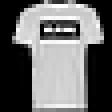

In [142]:
Gray.(train_imgs[2])

In [143]:
# Bundle images together with labels and group into minibatchess
function make_minibatch(X, Y, idxs)
    X_batch = Array{Float32}(undef, size(X[1])..., 1, length(idxs))
    for i in 1:length(idxs)
        X_batch[:, :, :, i] = Float32.(X[idxs[i]])
    end
    Y_batch = onehotbatch(Y[idxs], 0:9)
    return (X_batch, Y_batch)
end

batch_size = 128
mb_idxs = partition(1:length(train_imgs), batch_size)
train_set = [make_minibatch(train_imgs, train_labels, i) for i in mb_idxs]

test_imgs = dataset.images(:test)
test_labels = dataset.labels(:test)
mb_idxs = partition(1:length(test_imgs), batch_size)
test_set = [make_minibatch(test_imgs, test_labels, i) for i in mb_idxs]

train_set = gpu.(train_set)
test_set = gpu.(test_set)
()

()

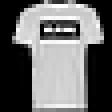

In [144]:
Gray.(cpu(train_set[1])[1][:,:,1,2])

In [145]:
Gray.(cpu(train_set[1])[2][:,:])

In [146]:
# https://github.com/FluxML/Flux.jl/blob/bdeb9c6d584668c7cef1ce71caf659d611c86d65/src/optimise/train.jl

In [200]:
"""
    train!(loss, params, data, opt; cb)
For each datapoint `d` in `data` computes the gradient of `loss(d...)` through
backpropagation and calls the optimizer `opt`.
Takes a callback as keyword argument `cb`. For example, this will print "training"
every 10 seconds:
```julia
Flux.train!(loss, params, data, opt,
            cb = throttle(() -> println("training"), 10))
```
The callback can call `Flux.stop()` to interrupt the training loop.
Multiple optimisers and callbacks can be passed to `opt` and `cb` as arrays.
"""
function train!(loss, ps, data, opt; cb = () -> ())
  ps = Params(ps)
  cb = Flux.Optimise.runall(cb)
  @showprogress for d in data
    try
      gs = gradient(ps) do
        loss(d...)
      end
      Flux.Optimise.update!(opt, ps, gs)
      cb()
    catch ex
      if ex isa Flux.Optimise.StopException
        break
      else
        rethrow(ex)
      end
    end
  end
end

train!

In [201]:
onecold_(y::AbstractMatrix, labels...) =
  dropdims(mapslices(y -> Base.argmax(y, labels...), y, dims=1), dims=1)

function evaluate(model, data)
    correct = 0.0
    total = 0.0
    for d in data
        ŷ = cpu(model(d[1])) # reduction on GPU recompiles every iteration ???
        ŷ_cold = onecold_(ŷ)
        y = cpu(d[2])
        y_cold = onecold_(y)
        diff = y_cold .== ŷ_cold
        correct += sum(diff)
        total += size(d[2])[2]
    end
    return correct / total
end

evaluate (generic function with 1 method)

In [202]:
struct Relu
end

(r :: Relu)(x) = relu.(x)

Flux.@functor Relu

In [203]:
N = 3
M = 3

@info("Constructing model...")
model = Chain(
    CrossCor((3, 3), 1=>16, pad=(1,1)),
    
    BatchNorm(16),
    Relu(),
    ABCCrossCor((3, 3), 16=>32, N, M, pad=(1,1)),
    
    BatchNorm(32),
    Relu(),
    ABCCrossCor((3, 3), 32=>32, N, M, pad=(1,1)),
    
    MaxPool((2,2)),
    
    BatchNorm(32),
    Relu(),
    ABCCrossCor((3, 3), 32=>32, N, M, pad=(1,1)),
    
    BatchNorm(32),
    Relu(),
    ABCCrossCor((3, 3), 32=>64, N, M, pad=(1,1)),
    
    BatchNorm(64),
    Relu(),
    ABCCrossCor((3, 3), 64=>64, N, M, pad=(1,1)),
    
    MaxPool((2,2)),

    BatchNorm(64),
    Relu(),
    ABCCrossCor((3, 3), 64=>64, N, M, pad=(1,1)),
    
    BatchNorm(64),
    Relu(),
    ABCCrossCor((3, 3), 64=>64, N, M, pad=(1,1)),
    
    BatchNorm(64),
    Relu(),
    ABCCrossCor((3, 3), 64=>64, N, M, pad=(1,1)),
    
    MaxPool((2,2)),

    x -> reshape(x, :, size(x, 4)),
    
    Relu(),
    Dense(64 * 3 * 3, 10),

    softmax,
)
model = gpu(model)

┌ Info: Constructing model...
└ @ Main In[203]:4


Chain(CrossCor((3, 3), 1=>16), BatchNorm(16), Relu(), ABCCrossCor((3, 3), 16=>32, (3,), (3,), active=false), BatchNorm(32), Relu(), ABCCrossCor((3, 3), 32=>32, (3,), (3,), active=false), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), BatchNorm(32), Relu(), ABCCrossCor((3, 3), 32=>32, (3,), (3,), active=false), BatchNorm(32), Relu(), ABCCrossCor((3, 3), 32=>64, (3,), (3,), active=false), BatchNorm(64), Relu(), ABCCrossCor((3, 3), 64=>64, (3,), (3,), active=false), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), BatchNorm(64), Relu(), ABCCrossCor((3, 3), 64=>64, (3,), (3,), active=false), BatchNorm(64), Relu(), ABCCrossCor((3, 3), 64=>64, (3,), (3,), active=false), BatchNorm(64), Relu(), ABCCrossCor((3, 3), 64=>64, (3,), (3,), active=false), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), getfield(Main, Symbol("##175#176"))(), Relu(), Dense(576, 10), NNlib.softmax)

In [204]:
function loss(x, y)
    ŷ = model(x)
    return crossentropy(ŷ, y)
end

loss (generic function with 1 method)

In [210]:
# Make sure our model + gradients are nicely precompiled before starting our training loop
for layer in model.layers
    if isa(layer, ABCCrossCor)
        binarize(layer, active=true)
    end
end
model(train_set[1][1])
gradient(Flux.params(model)) do
    loss(train_set[1]...)
end
()

()

In [211]:
# Now switch back to non-binary for pre-training
for layer in model.layers
    if isa(layer, ABCCrossCor)
        binarize(layer, active=false)
    end
end
model(train_set[1][1])
gradient(Flux.params(model)) do
    loss(train_set[1]...)
end
()

()

In [212]:
opt = ADAM(0.001)

ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}())

In [213]:
opt.eta

0.001

In [227]:
cmodel = cpu(model)

BSON.@save joinpath(dirname(@__FILE__), "data/model_start.bson") cmodel

In [219]:
BSON.@load joinpath(dirname(@__FILE__), "data/model_start.bson") cmodel

model2 = gpu(cmodel)

Chain(CrossCor((3, 3), 1=>16), BatchNorm(16), Relu(), ABCCrossCor((3, 3), 16=>32, (3,), (3,), active=false), BatchNorm(32), Relu(), ABCCrossCor((3, 3), 32=>32, (3,), (3,), active=false), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), BatchNorm(32), Relu(), ABCCrossCor((3, 3), 32=>32, (3,), (3,), active=false), BatchNorm(32), Relu(), ABCCrossCor((3, 3), 32=>64, (3,), (3,), active=false), BatchNorm(64), Relu(), ABCCrossCor((3, 3), 64=>64, (3,), (3,), active=false), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), BatchNorm(64), Relu(), ABCCrossCor((3, 3), 64=>64, (3,), (3,), active=false), BatchNorm(64), Relu(), ABCCrossCor((3, 3), 64=>64, (3,), (3,), active=false), BatchNorm(64), Relu(), ABCCrossCor((3, 3), 64=>64, (3,), (3,), active=false), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), getfield(BSON.__deserialized_types__, Symbol("##1988"))(), Relu(), Dense(576, 10), NNlib.softmax)

In [ ]:
#### @info("Beginning training loop...")

best_acc = 0.0
last_improvement = 0

for epoch_idx in 1:50
    global best_acc, last_improvement
    # Train for a single epoch
    train!(loss, Flux.params(model), train_set, opt)

    # Calculate accuracy:
    acc = evaluate(model, test_set)
    @info(@sprintf("[%d]: Test accuracy: %.4f", epoch_idx, acc))

    # If our accuracy is good enough, quit out.
    if acc >= 0.999
        @info(" -> Early-exiting: We reached our target accuracy of 99.9%")
        break
    end

    # If this is the best accuracy we've seen so far, save the model out
    if acc >= best_acc
        @info(" -> New best accuracy! Saving model...")
        BSON.@save joinpath(dirname(@__FILE__), "data/model_best_unquant.bson") model epoch_idx acc
        best_acc = acc
        last_improvement = epoch_idx
    end

    # If we haven't seen improvement in 5 epochs, drop our learning rate:
    if epoch_idx - last_improvement >= 2 && opt.eta > 1e-6
        opt.eta /= 2.0
        @warn(" -> Haven't improved in a while, dropping learning rate to $(opt.eta)!")

        # After dropping learning rate, give it a few epochs to improve
        last_improvement = epoch_idx
    end

    if epoch_idx - last_improvement >= 10
        @warn(" -> We're calling this converged.")
        break
    end
end

┌ Info: Beginning training loop...
└ @ Main In[228]:1
Progress: 100%|█████████████████████████████████████████| Time: 0:00:41
┌ Info: [1]: Test accuracy: 0.8749
└ @ Main In[228]:13
┌ Info:  -> New best accuracy! Saving model out to data/mnist_conv.bson
└ @ Main In[228]:23
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
┌ Info: [2]: Test accuracy: 0.8967
└ @ Main In[228]:13
┌ Info:  -> New best accuracy! Saving model out to data/mnist_conv.bson
└ @ Main In[228]:23
Progress: 100%|█████████████████████████████████████████| Time: 0:00:18
┌ Info: [3]: Test accuracy: 0.9065
└ @ Main In[228]:13
┌ Info:  -> New best accuracy! Saving model out to data/mnist_conv.bson
└ @ Main In[228]:23
Progress: 100%|█████████████████████████████████████████| Time: 0:00:17
┌ Info: [4]: Test accuracy: 0.8975
└ @ Main In[228]:13
Progress: 100%|█████████████████████████████████████████| Time: 0:00:17
┌ Info: [5]: Test accuracy: 0.9017
└ @ Main In[228]:13
┌ Warning:  -> Haven't improved in 

In [229]:
BSON.@load joinpath(dirname(@__FILE__), "data/model_best_unquant.bson") model

In [230]:
for layer in model.layers
    if isa(layer, ABCCrossCor)
        binarize(layer)
    end
end
acc = evaluate(model, test_set)
@info(@sprintf("Post-quantization test accuracy: %.4f", acc))
opt.eta = 0.001

┌ Info: Post-quantization test accuracy: 0.1828
└ @ Main In[230]:7


0.001

In [231]:
@info("quantizing...")

for epoch_idx in 1:50
    global best_acc, last_improvement
    # Train for a single epoch
    train!(loss, Flux.params(model), train_set, opt)

    # Calculate accuracy:
    acc = evaluate(model, test_set)
    @info(@sprintf("[%d]: Test accuracy: %.4f", epoch_idx, acc))

    # If our accuracy is good enough, quit out.
    if acc >= 0.999
        @info(" -> Early-exiting: We reached our target accuracy of 99.9%")
        break
    end

    # If this is the best accuracy we've seen so far, save the model out
    if acc >= best_acc
        @info(" -> New best accuracy! Saving model...")
        BSON.@save joinpath(dirname(@__FILE__), "data/model_best_quant.bson") model epoch_idx acc
        best_acc = acc
        last_improvement = epoch_idx
    end

    # If we haven't seen improvement in 5 epochs, drop our learning rate:
    if epoch_idx - last_improvement >= 5 && opt.eta > 1e-6
        opt.eta /= 10.0
        @warn(" -> Haven't improved in a while, dropping learning rate to $(opt.eta)!")

        # After dropping learning rate, give it a few epochs to improve
        last_improvement = epoch_idx
    end

    if epoch_idx - last_improvement >= 10
        @warn(" -> We're calling this converged.")
        break
    end
end

┌ Info: quantizing...
└ @ Main In[231]:1


BoundsError: BoundsError: attempt to access (getfield(Zygote, Symbol("##916#932"))(), getfield(Zygote, Symbol("##2753#back#1039")){getfield(Zygote, Symbol("##1035#1037")){CuArray{Float32,4,Nothing},Tuple{Colon,Int64}}}(getfield(Zygote, Symbol("##1035#1037")){CuArray{Float32,4,Nothing},Tuple{Colon,Int64}}(Float32[2.49424 0.100244 5.54044; 3.45947 -3.8434 6.56554; 0.920073 1.64141 1.49094]

Float32[2.64786 5.39011 -0.623907; 3.70042 7.54949 3.2059; 6.0493 8.44357 4.35573]

Float32[3.95778 3.365 3.53372; 1.17707 2.25273 0.17853; 1.95815 2.64275 0.827936]

Float32[1.09963 2.3683 5.77449; 0.446699 0.622796 1.87193; 0.933518 1.06631 4.57663]

Float32[4.36048 2.73908 3.15244; 8.1366 -2.44431 -1.33363; 4.35675 2.883 3.54116]

Float32[-1.15139 -1.78332 3.48178; 0.547407 1.25753 2.35711; 2.63139 0.17149 0.912508]

Float32[-1.1582 0.491851 5.77875; -0.730412 -1.07213 2.00001; 0.549579 4.90958 -0.0794248]

Float32[0.46978 0.516699 0.200416; -0.312015 3.12837 1.68349; 4.1359 1.76127 4.70567]

Float32[1.18994 1.41882 1.17521; 1.88948 0.682517 2.98844; 2.22926 -1.60205 0.109255]

Float32[1.9589 1.51122 0.721261; 0.331624 -0.119455 4.36388; 4.05984 1.17912 5.64146]

Float32[3.19344 1.24165 0.0333743; 0.589538 4.63115 4.45224; -0.1102 4.28028 4.13727]

Float32[5.46316 3.86082 1.01088; 2.126 0.403592 4.44643; 4.94031 3.58301 2.80192]

Float32[1.72472 2.29207 1.61505; 2.42347 1.94258 1.0374; 4.74904 1.17949 2.67041]

Float32[2.8171 5.93838 5.83384; 0.67347 1.20084 9.099; -0.0436253 -0.585641 2.52537]

Float32[1.20456 2.05467 3.67647; -0.383638 1.5189 2.36224; 0.713724 5.7966 1.96424]

Float32[0.24439 7.10395 1.10762; 0.378401 -0.0938824 0.538445; 4.27272 2.43779 6.45022]

Float32[1.0464 1.21223 4.64754; 2.3488 -0.682463 0.809251; 3.08247 -0.00733869 -0.156769]

Float32[1.78028 5.04398 0.090893; 4.07944 1.31601 -1.01614; 2.20272 1.33939 -0.813792]

Float32[3.09754 4.82653 -0.419151; -0.263828 6.19795 -0.59172; 4.26884 1.81259 2.81497]

Float32[-0.419019 1.71612 3.97537; 1.48765 8.6238 1.3068; 0.764096 1.99315 1.44644]

Float32[5.56265 2.73149 5.42396; 4.20363 2.5791 3.36057; 0.896032 3.06125 4.4667]

Float32[3.04896 2.094 4.99237; -3.60645 6.24946 2.64673; 2.85713 2.43731 5.93938]

Float32[0.264741 6.06077 2.17858; 2.38565 3.25574 0.149792; 1.18216 4.12856 1.41274]

Float32[0.609539 4.27424 1.97418; 0.656654 4.07121 -0.719305; 0.130196 5.98242 2.81252]

Float32[3.04932 6.9228 2.24431; 2.35945 7.17046 5.83273; 3.35569 3.8427 3.84502]

Float32[3.94961 3.41386 -1.06937; 6.62013 6.37692 0.491762; 3.39752 1.2457 3.88424]

Float32[0.162893 5.76698 4.68578; 0.449977 5.0852 3.662; 0.460389 3.71014 0.969809]

Float32[-0.327448 2.86671 5.54194; 3.45522 1.33966 -3.3128; 1.59102 3.72336 6.48821]

Float32[2.91182 0.436574 3.30335; 3.12413 2.23939 0.0218992; 0.496914 4.18635 0.831671]

Float32[0.83834 2.44168 3.39188; 1.88361 1.74999 2.59709; 1.35068 -0.0979491 1.72871]

Float32[3.48569 3.27881 2.76979; -0.23825 3.5754 1.92229; 2.26401 -1.70627 4.90009]

Float32[1.44802 3.88348 0.511932; 0.5634 3.15368 0.337031; 3.62901 6.59691 2.42517]

Float32[2.24883 3.07703 3.5362; 2.93648 2.17961 5.24066; 0.993668 2.60838 4.21022]

Float32[2.92162 3.14888 2.87721; 3.80633 1.81892 3.65275; 0.0596921 -0.852268 1.15056]

Float32[1.97224 0.426239 2.88493; 0.455407 -1.99379 4.08267; 1.82218 2.37118 -2.55295]

Float32[1.38712 2.30566 0.971345; 5.61616 4.05609 2.42541; -0.0948075 -0.28584 -0.0396103]

Float32[1.55369 5.70138 5.90663; 3.28023 0.863113 1.79568; -1.46223 3.11503 1.14702]

Float32[1.61094 5.07089 4.71063; 3.38906 1.45371 4.22875; 2.8968 2.27628 0.0208323]

Float32[0.399029 3.35715 0.793104; 3.71598 5.24202 3.59974; 4.05889 0.548061 -0.720527]

Float32[2.49162 -0.0170099 5.10005; 4.09001 1.52728 2.3457; 0.0401121 -0.894664 3.01115]

Float32[1.69088 0.237324 9.63208; 4.8477 3.00825 0.614122; 0.207249 1.66152 -1.41756]

Float32[3.15584 0.709252 -1.12537; 2.11772 2.98154 0.941259; 1.83214 2.01256 1.68006]

Float32[3.77514 2.41974 4.46034; -0.0480159 2.46567 -0.799336; 1.57145 2.87748 2.87015]

Float32[3.91741 6.0823 3.63167; 4.09267 3.38102 1.91331; 0.554009 -0.0905594 1.58889]

Float32[5.47964 4.56462 2.62586; 1.01689 3.80252 -1.5641; 2.55925 4.9466 0.607176]

Float32[3.11516 -0.389812 3.42233; 2.94461 4.83413 2.11439; 1.3778 2.61323 3.03915]

Float32[-0.471459 2.28309 7.61069; -0.290611 -0.677111 0.996363; 2.07846 2.23547 2.54679]

Float32[-0.624018 0.128585 2.85247; 3.12002 1.0474 1.59296; 2.63512 2.56142 4.08729]

Float32[0.466354 0.712784 3.64073; 4.50274 4.28104 -0.480635; 1.27893 0.950649 2.99014]

Float32[2.90118 -1.1033 3.94232; 1.6244 3.05699 4.09552; 1.48918 -3.06032 3.18627]

Float32[-0.133979 3.01706 4.52363; 2.79417 2.29653 6.38593; 2.93627 2.136 3.54003]

Float32[-0.945106 1.47665 2.02188; 3.57999 2.8191 0.878503; 0.650059 0.592217 2.40738]

Float32[2.4543 7.90167 2.47479; 2.38971 1.96275 3.5; 3.67759 3.17222 2.83648]

Float32[1.56599 2.18348 5.84477; 5.13968 2.58329 4.53469; 0.567335 -0.0168845 4.15587]

Float32[0.625576 4.52581 -0.201429; 1.62682 4.49593 1.64782; 0.110688 -1.23095 1.32733]

Float32[0.466945 1.73208 0.84223; 1.49283 0.273861 0.53403; 1.90124 1.39876 2.60066]

Float32[2.28082 1.86251 1.5423; 4.42909 3.03858 2.41028; 2.95603 0.255451 3.10994]

Float32[2.82778 5.25377 3.37061; 1.93083 4.34232 1.63123; 0.537226 4.3726 2.80285]

Float32[1.13317 -1.61818 0.4863; 2.35008 1.04667 0.165777; 3.88106 3.80396 2.81762]

Float32[1.24597 5.19688 1.94995; -0.0483332 2.99632 2.43365; -0.906645 1.5033 3.88035]

Float32[0.948561 2.22028 2.46418; 3.35133 -0.981834 5.01217; 1.01434 0.802427 0.200882]

Float32[0.854664 2.33971 4.79246; 2.49675 3.22221 2.89325; 3.00093 2.36607 0.328287]

Float32[2.50849 1.5521 0.15867; 5.85104 0.515092 2.13598; 0.0894365 1.04409 1.48419]

Float32[1.17546 2.08489 4.06443; 2.67807 0.959899 6.36175; 2.28099 4.64976 -1.01084]

Float32[0.840241 5.58171 2.22064; 0.849114 7.36414 4.75846; 1.43524 4.0563 2.98739]

Float32[-0.0841041 0.546609 1.91481; 3.24949 3.97265 1.23949; 1.81146 3.44036 2.09011]

Float32[1.0038 -0.572895 6.06749; 5.32607 6.52745 -1.60686; 1.61191 6.38901 3.92729]

Float32[-2.14377 3.24688 1.41343; 1.69987 1.96104 2.06074; 3.06625 2.28596 2.67611]

Float32[-0.316188 6.17724 4.46839; 0.670034 3.04535 4.56; 3.5013 2.12189 6.0067]

Float32[2.51605 2.76438 2.59748; 5.52908 -0.0511214 1.66764; 3.35807 3.08772 0.466255]

Float32[1.03527 5.47994 2.41183; 2.35623 5.12816 4.77141; 2.00679 2.03604 6.79759]

Float32[1.01522 3.63779 2.87447; 2.7998 1.53867 6.28235; 1.60154 3.06572 2.50269]

Float32[0.216405 4.66078 1.06743; 2.2996 3.27644 2.90195; 7.52697 4.44988 6.20934]

Float32[2.15242 2.05756 -1.02971; 1.3984 1.69417 4.80455; -0.541784 3.15635 -0.254383]

Float32[1.58 0.704059 4.33548; 2.50247 -2.03274 4.60207; 0.998656 0.308675 2.61761]

Float32[3.27925 4.22683 2.61299; -0.365285 4.17881 3.05965; 4.48851 6.28771 5.39989]

Float32[2.32294 2.60147 3.56752; 1.08796 2.35465 4.66727; 1.96168 1.29876 2.47523]

Float32[2.94888 3.88455 1.58734; -0.954077 5.09937 9.97091; 0.511402 1.37371 2.22644]

Float32[0.208437 2.76479 3.81168; 1.84739 -0.0521299 4.87764; 3.14899 2.13205 3.5592]

Float32[0.671547 1.59917 4.24931; -0.316697 2.64059 2.4433; 2.07279 0.421391 2.42777]

Float32[0.7493 2.43962 2.26625; -2.19458 0.195985 3.75525; 1.99177 -1.71199 2.10863]

Float32[2.91468 0.361934 7.87724; 6.66722 -4.95927 1.45867; 4.23405 4.96727 2.34401]

Float32[3.41601 0.674568 2.73949; 7.54233 0.604831 2.10635; 5.02762 1.98001 4.28557]

Float32[3.65854 4.59856 2.75715; 4.30952 2.81822 2.00702; 2.63605 3.94118 5.08748]

Float32[0.709642 4.61685 1.85119; 3.72457 -0.739395 5.30378; 5.40157 1.59315 -0.202312]

Float32[1.00412 -1.34082 1.34581; 5.1274 0.892109 3.16309; 2.75681 2.9881 0.654868]

Float32[2.69838 2.25791 2.05091; 3.41983 2.92495 2.43215; 0.825107 4.49822 2.05435]

Float32[2.81078 -0.0114103 7.29381; 6.79418 0.69177 -0.824586; 2.61642 2.44548 5.45304]

Float32[4.01204 0.178584 4.20962; 2.75039 1.56546 6.39109; 1.94722 3.67658 3.04658]

Float32[0.291262 2.40129 5.94176; 1.62879 0.0900195 5.97284; 4.31 0.525283 3.62395]

Float32[0.394267 3.1982 4.74492; 4.65983 2.51792 1.38716; 0.803698 0.227368 5.58381]

Float32[2.05745 2.98678 1.27729; 3.19801 -0.0617504 2.53194; 1.83616 3.2206 3.84212]

Float32[-1.26142 0.202243 2.67245; 1.21239 0.725253 5.69621; -0.808713 3.37198 1.71142]

Float32[3.04335 1.42 1.13946; 2.52272 0.977627 -0.0864498; 4.50569 2.76449 0.17058]

Float32[-0.173183 0.825565 0.767636; 1.50572 2.29065 4.33327; 0.122811 2.22941 -0.0761005]

Float32[0.0230011 -0.465725 0.604065; 1.95281 -2.04485 -0.244136; 3.56815 2.34597 5.7485]

Float32[2.8415 3.46614 1.58682; 3.12406 2.04195 4.07296; 2.88662 4.31981 0.116104]

Float32[2.58032 1.2536 4.86321; 2.00238 4.15802 5.33721; 5.86773 0.834006 5.59932]

Float32[1.09753 1.00779 3.19986; 1.92057 2.16023 5.0715; 3.69164 -1.86422 6.53005]

Float32[1.98189 3.2607 2.02377; 1.28156 3.11961 9.18497; 2.17121 1.64575 8.52601]

Float32[2.61996 1.75824 3.88229; -0.150449 1.74936 4.78969; -0.575 3.73053 3.2878]

Float32[2.72856 0.902533 2.25374; 5.22904 4.74717 1.87692; 2.81062 3.70655 6.16109]

Float32[0.196797 2.00468 4.16162; 1.40705 1.30109 8.09708; 3.94276 1.98106 3.84232]

Float32[1.92781 4.99743 1.23877; 1.36743 2.44603 1.1562; -0.796675 2.58579 1.52728]

Float32[1.17089 6.11317 6.99879; 1.31064 4.35697 4.41467; 2.40527 0.211688 3.45769]

Float32[4.89499 3.60437 1.26226; 3.01233 5.55304 5.21781; 2.35435 5.65296 1.91195]

Float32[0.554047 5.54344 6.80811; 2.22165 0.247161 2.58261; 3.41991 0.147453 0.635361]

Float32[4.02233 1.98678 3.3112; 0.437128 3.65569 1.40327; 0.172746 5.95131 1.94813]

Float32[4.15209 -1.78733 0.608374; 2.80338 1.66738 2.09658; 2.94456 1.53559 1.93814]

Float32[0.443459 2.15969 4.74434; 2.39684 2.15263 9.49478; 2.95088 2.14728 4.47176]

Float32[1.22119 3.00213 -0.801048; 1.96483 2.86651 3.64707; 0.213566 3.05349 3.68553]

Float32[2.17896 2.72472 -0.853717; 0.394701 4.76088 1.90783; 2.38615 3.65281 3.43174]

Float32[3.69431 3.06468 2.05314; 3.47281 0.504405 0.98708; 3.02366 4.83871 4.57609]

Float32[4.37927 4.4389 1.55679; 2.20102 5.51326 4.66576; 1.77679 1.18179 -0.0587526]

Float32[0.691801 4.4455 0.877084; 1.0569 4.76583 0.706317; 3.34697 3.96659 3.63609]

Float32[5.18041 3.58413 2.24984; 2.21623 4.91924 8.48543; 2.4209 4.188 6.94529]

Float32[5.18876 1.33173 4.8371; 1.48532 5.37628 3.53891; 2.03229 8.09662 0.101888]

Float32[1.5563 3.24813 1.24778; 0.154095 5.85092 2.45618; 1.93553 2.62609 3.69073]

Float32[1.84289 2.37672 1.98709; 2.4747 0.481549 5.73323; 3.1009 1.09288 2.925]

Float32[1.43934 4.96266 2.14978; 1.99536 2.67806 2.62275; 3.20153 1.10582 2.6462]

Float32[0.635294 0.945603 1.70943; 2.02227 2.24105 6.38711; 3.44497 0.85699 1.85102]

Float32[-1.11599 -0.782345 5.17485; 1.86858 1.85242 -0.297572; 1.44737 3.33941 0.104569]

Float32[5.17197 2.87101 2.48973; 3.16811 2.407 5.56866; 2.56667 4.77647 3.75139]

Float32[0.172659 2.08448 1.42812; 0.478318 3.92968 2.40457; 1.86043 5.47802 0.468535]

Float32[1.53133 5.39907 3.23809; -0.550437 2.61412 6.36349; 1.70682 0.523305 5.3136]

Float32[2.70534 -0.72394 4.69032; 0.446966 3.87895 8.37249; 4.36367 5.28531 4.61617]

Float32[1.42 2.28069 1.61706; 0.278646 1.46712 7.36951; 2.51685 -0.412292 4.53039]

Float32[2.70624 3.11098 1.3785; 0.979678 6.27407 7.65317; -0.25329 2.52652 5.63626]

Float32[-0.84029 3.45464 0.310047; 0.19055 1.92001 5.53157; 5.95278 6.44029 6.10518]

Float32[2.77209 4.9467 2.45924; 3.17967 1.52668 4.66536; 2.23806 0.234989 0.775185]

Float32[3.13847 1.85109 1.85501; -1.42983 -2.28359 1.90759; 0.379859 2.84631 1.44854]

Float32[2.29254 7.37359 0.282723; 4.07035 3.63217 1.23043; 4.65263 2.58996 2.96262]

Float32[5.66985 0.582541 -0.971029; 2.0019 -2.64893 1.85933; 4.4267 0.579523 2.033]

Float32[4.32041 1.77554 4.3658; 3.66838 4.01755 3.22327; 1.70429 2.62656 1.15048]

Float32[2.96535 -0.185492 3.75179; 7.84407 1.38959 1.81404; 5.2616 -1.2568 0.363587]

Float32[2.07169 0.31065 4.47771; 1.88986 -1.51915 3.22414; 0.624992 6.46342 1.39054]

Float32[1.88492 4.75039 2.9288; 5.82415 3.18431 3.00238; 3.8781 4.61035 1.90956]

Float32[-0.520586 3.11475 1.38853; 0.761319 -2.63626 2.46739; 0.863553 1.85504 5.2693]

Float32[1.86236 0.313121 0.610624; 2.59127 -0.805527 -0.612569; 2.8063 4.27896 1.77074]

Float32[2.64409 2.3584 0.234347; 0.990199 2.82281 1.93285; 1.66674 3.1091 5.05565]

Float32[3.06599 4.62502 4.35316; 3.34269 2.51409 2.36858; 0.600126 2.90958 2.96295]

Float32[-1.26672 3.30583 2.45532; -0.435986 0.369508 0.493844; -0.0301089 -0.520942 0.157307]

Float32[4.31971 0.129224 4.12665; 6.09628 0.643993 0.827446; 6.72017 3.02377 1.79734]

Float32[2.6061 1.99545 -0.25322; 2.16378 2.51477 0.470834; 1.07016 1.06886 2.571]

Float32[1.78691 0.886446 3.25564; 0.729921 3.35776 0.644169; 4.06185 0.890396 2.08434]

Float32[6.47163 2.4429 -0.146068; 1.8026 2.13038 2.1314; 5.32061 1.63125 1.5125]

Float32[4.11546 -1.59458 1.42597; 8.41724 0.649049 2.20364; 4.5721 0.295435 3.50746]

Float32[-1.73756 5.18678 4.07752; 3.09381 9.46161 2.02745; 2.65301 3.30725 2.95858]

Float32[4.41876 1.62997 0.346044; 9.02953 4.64822 0.648289; 3.55847 -0.321199 2.17757]

Float32[5.20792 4.43654 -1.48201; 5.95822 5.17998 0.619753; 1.07346 5.35639 -0.902237]

Float32[5.94582 1.82921 4.59336; 2.70495 -2.3892 3.83822; 3.83731 0.0995377 3.98606]

Float32[-0.0666936 5.36705 1.6101; 0.471295 0.590878 1.58597; 3.49287 4.66216 3.11303]

Float32[1.58776 1.53629 4.19753; 2.44401 6.22771 -2.19934; 4.65848 3.10662 6.4654]

Float32[3.57068 0.385217 2.64731; 4.07071 -1.02931 2.7443; 0.964765 2.69475 4.35893]

Float32[-0.769954 0.52063 0.159876; 1.17768 -0.618185 -2.48155; 0.676347 0.907953 -0.41857]

Float32[3.89494 1.58002 -0.0566863; 1.06093 2.52642 0.19802; 4.73957 -0.344407 1.88975]

Float32[1.32361 -1.20753 3.19085; 2.15577 -0.257728 1.91116; 1.84091 -0.233884 1.07448]

Float32[1.90904 0.149194 0.785162; 1.7847 0.566992 0.488565; 3.7789 3.49562 -0.33155]

Float32[2.0536 4.75669 1.76621; 0.81387 3.97834 0.736278; -1.80668 3.21564 2.7134]

Float32[3.41636 3.21149 -0.875928; 1.81333 3.3789 -2.43687; 1.82938 2.2931 1.56863]

Float32[1.02525 3.15667 4.13465; 1.38037 3.75913 6.97832; 3.26132 3.04081 3.10027]

Float32[2.52483 2.06222 2.39081; 2.4014 4.25703 -0.41359; 3.68133 4.17468 1.73145]

Float32[3.08978 1.25837 5.75977; 8.29929 1.37715 3.58798; 1.6346 -1.06437 2.453]

Float32[1.70146 3.52833 3.17895; 1.80429 0.997489 1.37693; 0.422573 1.58702 4.88059]

Float32[0.541514 0.941529 2.89515; 0.54687 0.633964 0.775765; 0.993509 0.149859 1.11999]

Float32[4.49447 1.2095 3.57082; 1.66332 1.22262 2.92648; 4.48449 0.91988 1.41609]

Float32[-1.57808 -0.170643 5.53457; 0.829641 -2.34635 4.19564; 3.73203 1.62078 0.381275]

Float32[-0.05244 5.85248 4.39366; 3.40601 6.48977 5.11875; 0.476071 1.75325 3.24184]

Float32[1.97559 1.39461 4.6906; 5.15227 0.350377 0.834738; 1.87407 1.97205 -1.33198]

Float32[3.48612 2.73258 2.69223; 1.22038 0.132124 4.94403; 1.96806 2.02286 1.62497]

Float32[0.660401 3.63978 0.178441; -0.745442 2.60019 1.52353; -0.119375 0.272069 2.04849]

Float32[0.427771 2.46532 -0.135138; -0.217793 2.09597 -2.28483; 2.22907 -0.0236387 1.30351]

Float32[7.15846 0.94018 1.14595; 3.49432 1.85004 0.791031; 3.85329 2.58311 5.167]

Float32[3.02644 0.468779 5.07179; 1.88541 2.80858 4.95636; 1.16689 1.76573 2.03751]

Float32[0.318216 0.960145 0.478066; 1.49457 0.9456 1.77613; 3.59028 1.05337 0.844588]

Float32[-0.238543 3.33827 1.95698; 2.07574 4.02117 0.737606; 1.34985 1.23006 4.55431]

Float32[1.09738 3.70945 -0.304424; 1.14267 -0.932631 1.30165; 5.05808 1.40344 3.37322]

Float32[1.25283 2.32001 4.97994; 0.908929 2.41499 5.50751; 1.96873 1.00156 3.61296]

Float32[-0.333489 5.07391 4.95998; 3.03212 3.4166 5.74744; 3.06359 1.08587 2.6762]

Float32[4.23868 0.949157 3.32953; 3.21792 3.37193 4.63477; 2.95151 2.75644 2.93074]

Float32[0.158002 8.85318 3.04304; -1.08982 4.3068 2.24199; 3.61079 4.22314 1.92501]

Float32[3.30375 4.36062 2.17198; 3.91235 4.92575 1.08292; 2.78423 3.87705 -1.89555]

Float32[2.76191 0.9937 3.32038; 5.11796 2.50248 0.0804176; 4.83128 1.03819 0.752525]

Float32[3.44986 0.953226 3.23886; 3.47114 4.56629 3.02774; 2.80916 0.679768 3.35534]

Float32[2.97338 2.58475 -0.151427; 3.89202 3.78455 0.483238; 2.3575 2.0115 2.30508]

Float32[0.708168 1.14179 -0.77922; -2.05942 1.19659 -0.100574; 0.0989412 -0.192188 -2.20493]

Float32[2.72379 2.58672 1.37321; 2.55011 -1.38323 0.85495; 1.82866 4.98276 1.07039]

Float32[1.56213 10.4021 3.51152; 2.74799 4.50943 2.93953; 2.31505 3.72938 2.39683]

Float32[3.10276 5.07323 3.12258; 4.95827 5.39526 1.78888; 3.09884 2.11614 1.06914]

Float32[0.482387 1.23411 -0.0283348; 3.12837 2.19086 0.247253; 1.1348 3.12434 -0.771068]

Float32[3.07259 -0.0661592 0.18157; 2.9318 -1.28927 -0.972078; 0.217309 -0.328135 0.66133]

Float32[3.36199 0.711655 3.93648; 6.99317 0.301337 2.17352; 3.77394 0.576645 1.62301]

Float32[0.813806 5.85611 2.09955; 0.0565374 2.13781 4.77218; 1.03974 2.98388 9.1347]

Float32[1.84974 1.98646 6.00547; 2.40869 3.20772 -0.587289; 1.8913 0.451234 -1.6513]

Float32[1.36256 1.14871 2.85598; 4.36284 1.69364 -1.14952; 4.26355 1.57164 0.745652]

Float32[0.309358 1.25017 1.05573; 2.55038 3.26241 2.96371; 1.92803 1.90733 0.928263]

Float32[0.512125 4.34091 0.143969; 3.24255 2.23553 5.12956; 0.29878 0.143742 1.14221]

Float32[0.173428 3.93418 0.126992; 4.76614 4.34795 3.81428; 0.363036 7.75401 1.6285]

Float32[1.24639 4.25091 3.68943; 4.52218 0.135912 1.72301; 1.98689 1.32256 4.85479]

Float32[4.73321 2.52671 4.10298; 2.92875 0.240195 4.6548; 0.893721 1.87389 4.65925]

Float32[0.695549 2.54349 1.84003; 2.43139 6.21104 4.2971; 0.993051 8.47081 7.10554]

Float32[0.0110233 1.46712 4.88348; 1.77904 1.65462 -1.35385; 2.32589 4.4113 0.664241]

Float32[-0.734167 2.62962 3.55632; 3.76388 3.44388 0.313008; 2.29416 2.39217 0.861176]

Float32[1.89067 2.22871 0.647087; 3.29065 3.22314 1.64948; 1.55401 3.29166 0.791286]

Float32[0.840305 3.89086 3.99007; 1.89638 -2.14537 1.89314; 1.898 -0.246556 0.492881]

Float32[1.65042 0.63349 4.35545; 0.763067 2.12299 5.09208; 4.41718 1.63537 4.62387]

Float32[3.18723 1.41517 4.84628; 3.36202 2.9848 4.46256; 2.5648 1.72758 8.03758]

Float32[2.44939 4.13162 3.35196; 1.82288 5.0128 1.20304; 0.269311 -0.133543 1.21437]

Float32[1.46853 -0.450376 2.08976; 1.37398 5.97933 3.64394; 0.988587 -0.598411 4.40139]

Float32[2.08889 2.47005 4.75366; 3.03881 -0.714599 4.07542; 1.95619 3.28312 0.0599913]

Float32[5.10331 1.38227 3.3589; 13.0385 4.14571 5.36155; 5.52282 5.8428 0.98144]

Float32[0.0386134 2.4646 0.814349; 2.39688 3.30077 4.73194; 0.219462 3.47654 4.69723]

Float32[4.69264 4.64411 3.21223; 3.3078 0.503884 7.04133; 0.912593 0.217467 1.77702]

Float32[4.04358 2.68797 2.68203; 5.76327 3.83013 0.0282943; 2.13347 4.62232 -1.41904]

Float32[4.53606 0.945696 1.79893; 6.67005 7.70807 2.52872; 2.99034 0.236979 3.40085]

Float32[2.03021 -0.513539 1.26002; 2.12627 1.99377 -1.75038; 1.64177 2.56061 4.68619]

Float32[2.6734 1.16925 6.65731; 1.31035 7.9055 1.76406; 5.51172 2.12068 2.47952]

Float32[0.610357 3.18617 3.0883; 2.49222 0.960612 3.02999; 4.02582 -0.717176 -0.999541]

Float32[0.813886 1.02248 4.09703; 5.1074 3.91842 1.3887; 4.15395 3.8391 2.35403]

Float32[2.51219 4.52219 2.4818; 3.48328 4.97238 -0.574299; 0.227579 4.291 1.58486]

Float32[-1.53883 -1.38747 2.44658; 1.78417 3.33586 5.46473; 1.93666 1.39555 3.45211]

Float32[1.58884 2.2354 1.25531; 2.36548 4.95018 1.64785; 0.997983 4.34158 1.55948]

Float32[1.51058 3.33884 2.88565; 0.805391 8.68771 4.87023; 2.16666 2.51679 3.83483]

Float32[4.00248 4.90596 2.73829; 3.71437 -1.41393 -0.567866; 2.95195 0.384667 -1.52734]

Float32[2.71466 1.9142 5.74774; -0.632683 4.66655 1.86515; 1.57652 6.34109 1.99329]

Float32[-0.772463 4.02955 0.459708; 4.73657 2.76117 4.49597; -0.0824002 2.20622 5.38222]

Float32[0.125095 3.93574 3.60899; 3.01025 2.08233 5.88077; 1.33559 2.1892 3.0495]

Float32[0.78486 2.86318 -0.807571; 2.10088 2.99904 2.22801; -0.102371 1.86159 5.10532]

Float32[0.504585 1.3219 3.37914; 2.23274 5.87051 5.33145; 4.21319 5.94073 1.87268]

Float32[2.44984 1.35663 1.99178; 2.85239 -0.0815859 1.66967; 1.1312 5.66801 6.38057]

Float32[2.27502 3.03944 2.33102; 3.01424 2.20892 3.6209; 1.27498 4.09522 2.68947]

Float32[3.77547 4.12271 5.03697; 0.653278 4.38064 5.81584; -0.692024 3.43749 4.34593]

Float32[1.78 2.8263 4.9803; 2.71336 -1.30386 3.2155; 1.64376 0.576575 6.31741]

Float32[2.2032 3.1987 0.314276; 1.28465 3.39246 2.50764; 1.01563 3.35502 8.47894]

Float32[2.5467 3.55824 1.90145; 1.88841 1.71252 5.23786; 4.06607 1.41867 5.55233]

Float32[2.33534 0.416447 2.33574; 4.69894 5.58662 1.67977; 4.52276 0.196143 3.04214]

Float32[6.86096 0.243897 3.94684; 7.58621 2.99782 0.715126; 3.72906 1.3387 -1.13219]

Float32[1.47014 2.89877 7.92415; -0.27355 3.68089 4.99176; 3.0963 3.19093 2.08583]

Float32[6.1307 4.29485 2.97439; 3.67251 3.70528 4.21078; -0.748242 4.0363 2.04195]

Float32[4.42129 1.75379 3.28993; 0.467774 2.38867 0.735801; 1.32987 5.52125 5.63802]

Float32[3.82693 1.60446 1.91571; 3.08085 1.1241 0.633472; 5.16353 2.80958 1.91002]

Float32[3.90396 4.11498 0.661473; 3.84877 3.65136 4.49784; 3.75442 5.42807 1.90051]

Float32[3.75364 5.99618 1.05338; -1.29086 2.3725 3.25875; 1.53949 1.00854 7.57911]

Float32[2.1125 1.39125 -0.557696; 2.49064 1.52831 2.45205; 1.09065 6.65878 8.02781]

Float32[-0.234762 3.61625 3.85924; 1.77838 8.67206 2.41959; -0.480193 3.85521 2.41414]

Float32[1.81393 5.04502 1.4333; 3.18758 6.49395 2.14331; 3.71475 2.4082 1.03911]

Float32[4.16827 1.37184 1.51119; 0.855242 4.68344 8.35531; 1.66022 0.674691 2.78946]

Float32[0.192941 2.5614 2.1741; 1.7254 3.64978 3.87108; 4.53954 3.14469 0.444635]

Float32[0.447905 3.01314 5.26699; 3.43648 6.03231 4.58236; 0.0729306 1.76624 2.79496]

Float32[1.81509 5.01016 2.73411; 2.6965 3.4835 4.77099; 3.23426 3.55293 0.823407]

Float32[1.81353 2.40679 1.11538; 4.37706 1.60229 -0.920767; 2.07489 4.54852 2.99654]

Float32[2.86242 3.26014 5.55474; 1.12346 7.39722 2.83022; 1.03212 4.20608 3.48174]

Float32[3.80999 2.18779 2.43846; 3.56872 6.63568 8.413; 0.181306 1.25734 5.48101]

Float32[4.2242 1.00734 -0.256805; 1.68841 1.35902 0.900364; 2.93552 1.72726 2.26655]

Float32[0.977707 -0.602247 3.08983; 3.84337 1.98684 0.393611; 0.638404 1.72484 1.47742]

Float32[2.92188 3.64837 1.13045; 2.86539 5.20853 5.58602; 1.14225 4.97759 1.50967]

Float32[0.89805 1.22583 2.88939; 1.58295 3.97658 4.1012; 3.1639 0.902489 2.31614]

Float32[1.75848 3.97458 2.08051; 2.20918 5.12027 0.609607; 1.90362 -1.62911 3.86287]

Float32[1.61311 3.21352 2.87356; 0.811258 -0.645346 2.74974; 3.89177 4.78952 1.91505]

Float32[2.83818 2.83869 3.70809; 2.65573 3.37969 2.86543; 2.85897 4.39329 4.13635]

Float32[1.37694 -0.422063 2.36703; 3.70081 2.95544 8.5433; 4.74103 0.185341 5.87736]

Float32[5.09392 3.21234 1.56453; 3.28916 3.82732 -1.04372; 2.17848 3.9891 0.96025]

Float32[3.97947 5.26894 3.69278; 1.11308 3.35994 1.54016; 2.86811 0.13784 2.17107]

Float32[-0.518064 1.25602 1.58498; 2.21319 -0.482443 1.59346; 0.868083 5.18141 5.40743]

Float32[5.38181 1.29801 1.86051; 3.51897 1.95605 0.720078; 3.19471 5.04892 2.74403]

Float32[2.89103 -0.628363 4.12118; 0.983928 3.11475 2.82363; 0.0296036 7.44974 3.29389]

Float32[1.75883 0.636972 1.92342; 4.13283 0.554397 4.88023; 1.49009 1.327 1.07855]

Float32[2.6897 0.940943 0.20327; 2.61877 2.39414 5.16815; 1.15903 2.65056 1.12935]

Float32[0.251479 0.731732 2.39129; 2.36312 2.42486 3.19234; 2.67112 0.435332 1.35732]

Float32[2.69418 2.46277 2.32654; 1.17258 4.54687 2.3757; 2.03025 2.34884 2.95677]

Float32[0.626515 -0.414108 4.85333; 6.29401 0.0107488 2.7641; 6.88616 4.49751 5.00833]

Float32[1.94591 0.493036 1.52006; 4.98395 5.64929 3.95846; 4.10488 3.85473 3.49746]

Float32[-0.903569 0.515511 4.42382; 0.363624 0.50117 2.81494; 5.4476 1.58185 2.88527]

Float32[6.09662 0.52007 2.32857; 4.85244 3.33216 4.49843; 3.44156 -0.0607135 -0.368677]

Float32[1.76021 -0.283 2.58095; 5.71476 4.48782 -0.852966; 5.69376 4.4436 2.2659]

Float32[1.36252 2.31585 2.74839; 1.39592 6.74389 0.521391; 0.0338944 4.80643 3.65722]

Float32[3.12715 4.00904 2.18423; 2.00751 2.77667 2.92098; 2.44175 -2.03916 0.0291631]

Float32[1.33321 4.24651 -0.189779; 2.25072 5.19056 -1.54669; -1.78978 5.44658 1.52062]

Float32[0.18914 1.59569 1.33806; 2.52189 2.2335 0.518535; 2.80686 3.85598 2.04457]

Float32[4.11075 0.953135 3.27719; 1.81131 3.65848 0.438991; 1.15759 6.97491 7.5035]

Float32[2.64595 2.51989 4.02689; 1.08773 3.18241 3.24165; 3.32543 4.45101 4.34203]

Float32[4.02439 0.315873 -0.390101; 3.09519 -0.695787 1.70852; 2.55379 1.0989 0.406409]

Float32[1.84624 3.1999 3.42809; 0.314767 1.73564 1.89076; 0.868684 3.8272 0.83306]

Float32[0.396506 -0.877145 0.782604; 6.38056 0.439807 0.133425; 3.20649 4.56448 3.36441]

Float32[0.609342 2.16422 2.34831; 2.11416 -2.68148 2.59192; 0.0476574 0.540709 3.55282]

Float32[3.24979 1.06662 -0.250116; 2.67368 4.38044 0.594015; 0.744705 1.90358 -1.20356]

Float32[2.75275 0.450271 2.6265; 1.64167 0.558566 1.64865; -0.249984 1.18725 3.60134]

Float32[0.768265 0.276404 0.417182; -0.371977 0.517601 1.53865; 2.33123 -0.800163 1.41089]

Float32[3.37707 2.18223 1.28167; 2.74715 2.10313 5.54481; -0.753581 5.04155 1.79373]

Float32[3.71148 2.73818 3.18482; 4.42626 4.10162 0.525516; 6.18077 2.66238 -0.972965]

Float32[4.70794 3.67033 2.3419; 4.96415 3.08352 4.43263; 4.76214 3.58315 0.420292]

Float32[2.05286 3.33758 -0.471607; 1.31758 2.71586 3.33135; 0.176857 2.79495 2.03248]

Float32[1.96713 1.00128 0.945171; 2.23346 -1.48224 4.18696; 1.33833 2.2709 3.00737]

Float32[2.97935 3.36192 0.264333; 4.06106 3.527 -0.78073; 5.15375 0.398345 -0.285828]

Float32[3.34906 5.50925 8.8378; 1.1903 3.65351 -0.519582; 2.26615 2.6802 1.13538]

Float32[3.75305 3.91472 3.40541; 0.84157 2.3136 1.02087; 0.828251 -0.27172 3.02355]

Float32[1.39572 3.41643 0.778317; 4.3507 0.903266 1.92483; 2.55078 0.992778 1.48079]

Float32[4.10895 4.13935 5.65232; 3.32516 4.64836 3.53938; 0.204991 3.91621 3.9017]

Float32[4.36096 -0.977241 1.11834; 3.63416 1.45115 1.30838; -0.534732 2.66779 1.41746]

Float32[-0.187517 2.19001 -0.265427; 3.96412 2.08948 2.22788; 1.6784 2.10486 4.26178]

Float32[1.63306 0.42503 0.866429; 2.52323 -1.65048 1.96539; 1.41278 1.88333 2.21516]

Float32[4.78871 4.29404 5.08957; 1.20425 6.43778 0.00132137; -3.2592 5.78718 2.51796]

Float32[0.328212 2.2367 2.57053; -0.686387 -0.0420456 0.145051; -0.0344824 5.91867 0.66284]

Float32[1.50942 4.18838 0.182099; 0.256251 4.27223 4.83212; -0.0870654 0.900471 1.29529]

Float32[0.184508 1.16035 1.70661; 1.98129 1.86119 -0.997782; 2.87902 -0.56155 2.48568]

Float32[1.05938 3.22813 2.33576; 1.28239 2.54667 4.43558; -0.893089 2.78937 3.4106]

Float32[3.18499 6.09235 2.36487; 2.57465 6.52061 2.05445; -0.131848 0.807937 0.79042]

Float32[4.33383 3.92058 2.3903; 4.14141 1.55858 2.63051; 0.690716 1.07603 3.91372]

Float32[0.271015 2.78925 2.07314; 1.88132 1.37725 0.77821; 2.53766 5.93668 3.58637]

Float32[4.20834 2.8697 1.82241; 0.329469 1.83364 5.24334; 3.92859 -3.97492 2.4255]

Float32[4.93137 3.22068 1.47374; 2.69117 4.36636 0.90105; 1.72805 1.75064 1.0927]

Float32[1.7563 2.27561 5.31368; 4.31159 5.24404 3.47125; 4.86208 1.15384 3.75362]

Float32[2.59093 1.86172 1.22011; 1.24392 4.45694 2.77863; 1.98938 2.618 2.76088]

Float32[0.79796 0.011252 0.905969; 2.93687 -1.5162 -2.85734; 3.95126 1.73628 2.80963]

Float32[-1.45579 3.6986 2.78615; 1.54237 2.62306 1.49292; 3.91459 4.30946 2.93661]

Float32[1.17604 -0.518313 3.76955; 1.7135 3.98579 0.27005; -0.531523 5.86294 3.33059]

Float32[3.70887 4.27258 -0.408636; -0.838038 5.71131 6.16421; 1.44727 -2.68558 3.06413]

Float32[0.532241 4.20412 1.93678; 0.830847 2.35185 1.06748; 3.81582 0.75042 1.48711]

Float32[-1.393 0.683022 2.54753; 1.72729 0.502689 2.96754; 2.97198 3.88827 -0.947543]

Float32[2.62046 1.89791 2.39218; 3.53203 1.42755 5.98789; 3.41981 2.66171 2.80522]

Float32[1.68944 7.5331 2.26748; 0.212347 9.32806 1.25167; -1.13324 7.16253 -0.789639]

Float32[3.20955 2.69629 3.68888; 4.37833 -3.37593 1.16653; 3.35256 4.27561 2.53756]

Float32[0.0940536 0.603282 1.82058; 0.182145 -2.03735 4.94116; 2.28916 1.43836 4.84511]

Float32[3.98032 4.72237 4.52445; 6.04291 3.27453 -0.770526; 4.37027 -0.954512 2.74411]

Float32[1.42013 6.10338 2.23865; 0.0606078 2.61969 -4.24227; 1.50925 1.04888 0.689691]

Float32[3.3047 3.02939 4.3431; 3.70543 4.97572 7.16135; 3.51388 3.98768 3.72751]

Float32[3.01199 2.81791 2.65791; 0.309384 0.864134 7.18238; 1.1606 -1.09694 4.01578]

Float32[6.62042 2.18954 2.0363; 2.19148 -0.490006 4.42018; 5.36123 0.251293 4.40898]

Float32[0.467191 3.26403 1.19255; 8.28655 4.21292 4.696; 4.46109 6.54274 4.19204]

Float32[6.37115 2.40349 2.62946; 3.9791 0.0773163 4.7851; -0.34096 1.28063 2.83854]

Float32[2.89725 0.12027 0.227248; 3.49321 0.739683 -1.81115; 2.42214 1.70735 3.65125]

Float32[3.68623 2.09652 0.719749; 2.82736 2.95915 -1.25474; 0.687059 6.47066 3.48308]

Float32[5.12303 1.11733 1.61524; 1.93554 1.42247 1.51615; 4.76146 1.46145 5.52405]

Float32[1.49762 1.04009 -2.19128; 0.81846 3.91221 3.32632; 1.74437 -0.920479 8.64167]

Float32[1.58622 4.90318 1.85567; 5.25517 5.9322 5.16103; -0.852475 3.08915 2.12803]

Float32[5.0025 3.30905 4.58634; 1.85942 2.49378 2.86463; 2.00263 3.56336 0.312711]

Float32[1.39062 -0.108057 0.482497; -1.38948 2.29169 -1.48534; 1.90095 -2.00818 2.93369]

Float32[0.900228 6.81038 2.44341; 6.78991 2.20322 -1.36804; 3.30712 2.62676 4.29933]

Float32[2.70799 -1.0203 4.52982; 7.41958 -0.257282 8.04981; 3.9891 -2.86126 5.5115]

Float32[2.83453 2.04236 2.97765; 1.25292 2.86442 3.64852; 2.37992 2.91216 5.99034]

Float32[0.512153 6.8745 2.93533; 3.21556 1.98045 -0.419181; 1.39202 -0.301897 1.02672]

Float32[3.11577 0.51429 3.87736; 2.26678 3.38736 9.05478; 4.90225 0.366642 5.11295]

Float32[3.93126 3.83994 5.2476; 5.28564 1.22553 6.97616; 1.1437 0.890813 6.2328]

Float32[2.94693 2.85575 1.27202; 3.30364 4.2141 2.64112; 1.05568 5.25586 4.64721]

Float32[0.692438 1.54687 0.173349; 3.03134 1.72752 2.36521; 1.86034 6.08197 10.1303]

Float32[1.96897 3.39349 0.306509; 2.37744 -1.88465 -2.56119; 1.2465 4.14378 -0.162241]

Float32[0.133733 1.3791 1.02643; 1.47599 -0.124815 3.81167; 2.13568 1.98488 2.43234]

Float32[4.5667 0.123536 4.02883; 5.49138 1.11914 4.14014; 3.88444 4.11441 3.06105]

Float32[4.91315 -0.27377 0.787055; 0.917224 -0.996809 1.27275; 1.79126 0.927046 4.30119]

Float32[3.93137 2.76137 4.92822; 2.52169 0.775779 1.20013; 6.13768 2.51371 1.33493]

Float32[5.02483 1.85116 1.01186; 2.78755 0.246323 4.30823; 0.932024 5.032 2.07509]

Float32[1.46134 -1.54399 4.4678; 4.60352 -1.84989 1.59908; 4.84229 6.03611 2.83661]

Float32[3.1264 2.6202 1.19762; 3.67426 0.66297 7.07062; 3.61885 1.25432 2.5998]

Float32[2.93273 2.36024 3.15625; 0.878504 5.72735 2.74864; 2.69002 5.02389 1.84959]

Float32[2.00252 2.78975 4.08148; 3.46749 1.87172 5.82034; 1.05936 1.71694 2.73305]

Float32[3.27766 2.31522 3.87084; 1.59408 2.14186 0.0542361; 1.16256 0.184711 4.32907]

Float32[4.14365 0.288204 0.249393; 2.13848 -0.245507 -1.01406; 0.0533796 1.55664 1.51815]

Float32[3.69382 4.32191 2.38022; 3.55403 5.02823 1.15752; 1.62235 4.26517 1.70637]

Float32[1.14398 0.829403 3.14864; -0.208882 3.70034 3.59257; 4.1582 2.13869 1.75743]

Float32[4.82648 8.47655 2.59569; 1.41677 1.26683 3.13997; -1.26733 -0.514823 2.31634]

Float32[1.66766 3.50475 3.8872; 1.01002 6.14475 4.93581; 2.5505 -0.0373835 3.87486]

Float32[3.04007 0.850721 1.73566; 3.65231 3.64051 0.38752; 1.97047 3.24865 1.9861]

Float32[2.14657 4.67285 0.732751; 1.27162 1.50585 5.36129; 0.00508001 1.84454 10.0293]

Float32[0.882067 1.79847 3.30231; -1.13078 5.81913 4.20358; -0.371384 1.44327 0.75591]

Float32[0.952309 2.83203 2.31484; 1.75012 0.395666 5.74299; 1.35172 1.32265 5.2234]

Float32[2.37869 3.59137 4.16629; 2.06827 -0.5107 -0.620814; 4.04761 -0.0140444 0.827823]

Float32[1.0012 3.91318 5.99839; 5.94126 0.655155 5.1175; 2.23245 -1.35707 5.90172]

Float32[-0.74847 4.15569 3.04179; 0.57987 1.00787 -2.19084; 0.831041 1.28579 2.85922]

Float32[0.915427 1.62102 3.07339; 1.3643 -1.90082 1.19245; 1.97927 1.6635 4.50798]

Float32[2.18822 4.14818 3.40211; 0.634925 1.90051 2.11936; 2.329 0.151854 1.61933]

Float32[2.69111 1.94969 3.13838; 2.63572 6.00847 3.5839; 4.60174 2.69436 1.49861]

Float32[1.80461 2.00108 4.48732; 6.97426 5.16143 4.70357; 9.16523 -0.0204267 0.651854]

Float32[6.54801 2.86037 4.2405; -0.77638 3.43296 2.07223; 3.81786 2.28911 2.14127]

Float32[-1.23115 7.30803 1.08623; 2.70058 3.72869 1.20431; -0.188424 1.62916 -0.959514]

Float32[1.85751 2.51176 2.21607; 4.73084 4.73654 1.06352; 1.82019 -0.476111 1.53157]

Float32[1.41584 2.64203 0.918311; 1.9866 3.47063 0.960999; 1.60362 2.52054 4.62713]

Float32[1.81449 1.85613 1.96556; 3.23052 5.50867 0.704332; 1.04695 1.42537 4.23422]

Float32[2.16114 -1.62659 2.78459; 2.39393 -0.710707 4.37407; 2.17901 -1.40831 5.92098]

Float32[2.16481 1.5692 2.16511; 2.28158 4.38333 0.871575; 2.50015 6.67803 -0.118289]

Float32[5.9051 3.19817 3.26175; 3.14821 5.67844 3.39717; 0.863513 2.49237 2.61427]

Float32[3.07967 3.76224 1.76737; 3.03778 6.03817 -0.872223; 1.01957 2.44643 -0.881341]

Float32[1.18617 1.13874 1.54674; 2.47192 -0.0245203 5.38673; 2.21471 -0.299095 6.04358]

Float32[1.96282 2.36929 -0.0732286; 4.91519 1.46268 -0.314127; 3.45596 0.809976 1.30506]

Float32[2.54164 4.15616 1.697; 4.48747 6.66319 5.20789; 0.452907 -3.34259 2.94932]

Float32[1.80843 4.18991 6.60703; 7.09715 0.0809532 5.58899; 2.73695 0.398538 -1.30014]

Float32[1.97768 3.09542 1.31115; 9.12616 11.4209 2.82788; 5.18222 5.30997 3.50694]

Float32[0.496914 5.01758 -0.514747; 5.05088 2.47654 1.8194; 2.32619 1.52331 2.75457]

Float32[2.91638 1.00576 -2.57204; 7.00405 0.373952 3.545; 2.48539 1.82572 -0.0841988]

Float32[5.75131 5.39536 2.61236; 5.58346 8.44912 8.1362; 0.655604 0.221991 2.21868]

Float32[-1.79533 0.387161 0.530953; 0.284502 0.995257 0.615921; 0.143033 0.0326395 1.18076]

Float32[1.4365 1.05868 -0.240178; 1.78295 1.72875 2.24858; 5.75243 1.85189 1.69687]

Float32[2.45589 0.19922 4.34631; 4.18999 4.66692 -1.15625; 0.647693 1.20514 1.66783]

Float32[5.35843 2.35087 0.776297; 0.636826 1.07357 0.682118; 4.63659 -1.4289 8.63714]

Float32[2.70344 0.490278 3.41942; 2.83623 2.39787 2.11733; 2.5793 4.05124 2.68204]

Float32[4.83613 2.79271 -0.795511; 3.14609 4.91795 2.48532; 2.33331 4.41115 1.72835]

Float32[5.14053 8.27956 4.32141; 2.4919 4.98822 0.618119; 1.34836 2.6563 2.69909]

Float32[2.47343 1.07757 2.7821; 1.54955 -0.435647 2.94953; 2.48028 1.47789 2.59865]

Float32[2.01148 0.751568 0.422992; 0.548019 2.2014 1.13442; 3.05385 1.82833 1.50027]

Float32[1.18237 4.43445 5.15083; 5.324 0.519138 3.0183; 3.00761 2.81868 1.76644]

Float32[4.04413 3.6222 3.73453; -0.392894 1.13857 3.27981; 1.67919 2.25158 1.16423]

Float32[1.20676 2.65156 3.16828; 6.71195 3.354 3.46047; 2.04447 0.6712 1.59409]

Float32[4.9135 2.98452 -1.17509; 4.07996 1.92187 1.14472; 3.53935 1.4264 2.32203]

Float32[1.50894 3.4353 8.2022; 1.2956 4.09204 1.11567; -0.0652288 0.975395 -0.845802]

Float32[0.974703 2.75504 2.81064; 1.35808 1.58604 3.49112; 2.93981 1.66758 3.093]

Float32[3.3408 2.74147 1.49154; 1.91467 1.93373 -0.575506; 5.11448 5.68817 3.95205]

Float32[2.34942 2.88336 3.98375; 1.63463 4.87531 0.351623; -0.252461 7.26044 4.11704]

Float32[2.45337 2.40665 2.47425; 2.83845 2.86326 4.71497; 1.85515 2.31219 -0.448509]

Float32[1.5221 4.47569 1.75037; 4.95955 3.54313 4.12095; 2.25254 1.75743 2.06472]

Float32[0.6979 2.1643 0.348722; 5.20364 7.94841 2.5651; 2.95889 3.987 3.48475]

Float32[3.69047 3.78585 2.37837; 5.08067 3.95708 1.2679; 3.56846 2.57677 6.71487]

Float32[4.08242 0.343224 2.94158; 1.01209 5.53237 6.13026; 1.9949 3.33736 1.03741]

Float32[0.105888 4.33037 2.97267; 1.58172 2.33396 1.60142; 1.6553 2.75204 2.02416]

Float32[3.70166 2.51168 -0.768455; 2.95893 1.37636 3.75615; 2.1272 4.29856 1.82688]

Float32[2.22925 1.68159 2.85401; 2.70657 3.24848 -1.26894; -0.322784 1.56168 2.34368]

Float32[3.587 1.19049 2.43285; 0.181849 0.425351 1.62281; 3.26953 2.09164 2.69644]

Float32[2.05817 0.264317 0.230903; 3.87814 9.9542 1.28878; 2.11629 2.95468 1.16637]

Float32[2.27074 1.38139 2.78863; 3.36735 -0.322572 1.14956; 2.76775 -1.1988 4.10255]

Float32[1.24887 4.50064 4.88481; -1.32697 4.13621 1.12604; 0.0467741 1.51316 5.63886]

Float32[3.94999 2.98362 2.43909; 1.84228 4.41316 4.49865; 1.00337 -0.237075 0.577404]

Float32[3.77154 3.29168 4.2856; 3.3371 3.21185 2.32976; 1.24867 3.85095 2.30807]

Float32[1.18153 2.90989 0.230216; 0.720423 1.97107 4.44884; 1.05105 4.58024 2.60988]

Float32[3.23769 1.77605 4.10171; 1.91118 4.14158 3.51681; 2.08727 -0.228518 2.64059]

Float32[2.69989 0.535143 0.0400712; 2.11245 2.84397 0.483081; 0.1874 1.53702 3.52234]

Float32[2.63209 1.17338 -0.745006; 3.01365 1.09878 3.62863; 5.50121 4.29277 2.4648]

Float32[3.55732 2.9158 0.276986; 3.08694 0.797308 1.27958; 1.26523 -0.927328 2.04159]

Float32[0.119398 1.44805 2.12175; 1.6967 1.76907 1.98673; 0.978818 -1.64537 3.14918]

Float32[3.097 0.141904 -0.659269; 1.62717 -0.448058 1.7206; 1.19343 2.74673 1.35157]

Float32[2.43274 2.90916 3.60646; 0.12813 5.73382 3.3874; 0.271643 1.31592 2.84508]

Float32[4.15181 3.76721 2.8281; 2.31968 3.4772 1.72519; 6.79609 4.86677 2.38764]

Float32[-0.684071 1.15741 2.19039; 3.52306 0.0436118 -1.49522; 2.82534 4.98288 3.51893]

Float32[2.45376 1.82982 2.4377; -0.560854 4.5448 3.61588; 1.85847 0.544361 -1.95862]

Float32[1.63443 3.62943 2.78517; 1.79468 2.55346 -0.656223; 2.14396 1.68559 1.23604]

Float32[3.47673 5.01429 0.691103; 6.54757 5.39878 4.24712; 1.88725 1.64717 0.658607]

Float32[3.08334 2.07944 3.04529; 2.37885 0.468031 -2.47755; 3.87955 1.03406 2.81127]

Float32[1.01272 0.125359 -0.0397206; 2.02145 4.35258 3.7149; 3.97769 3.3383 2.43703]

Float32[-0.29178 -0.968611 -0.00850434; 4.00173 5.87912 2.38326; 2.84868 0.953515 3.09098]

Float32[1.07662 2.49186 2.90589; 3.43438 4.08902 6.41116; 0.879444 -0.423062 3.85349]

Float32[4.7787 5.25289 2.01213; 7.61219 0.578244 5.46663; 2.20883 7.04091 5.94953]

Float32[4.03073 2.54322 1.42076; 1.71411 0.700237 2.12475; 2.16947 3.07375 5.15056]

Float32[2.54336 2.87224 3.10576; 1.63886 -2.1713 1.99001; 2.19145 2.74679 1.80364]

Float32[1.51891 3.38695 0.803449; 4.9385 5.43014 3.91009; 1.21951 1.12002 2.79951]

Float32[1.17661 3.45606 0.980344; -0.341446 4.2647 2.72666; -1.14655 5.83442 1.05642]

Float32[0.599338 2.44598 7.61816; 6.54481 5.83395 6.14539; 0.768459 -0.354105 0.416668]

Float32[-0.553825 0.700734 1.20935; 3.7765 1.54205 0.175192; 2.09477 0.979769 3.88387]

Float32[3.65235 1.47534 1.19689; 1.40357 3.34797 7.77885; 3.11266 2.50081 3.25698]

Float32[2.11156 0.21357 4.39133; 1.48811 7.53592 10.0355; -0.526544 1.91942 1.16246]

Float32[3.74106 4.70953 5.2021; -0.34742 6.24773 0.11437; 2.12773 1.51958 3.5037]

Float32[2.67011 6.36852 2.90555; 2.30489 2.57363 0.471887; 3.33453 3.71732 0.389655]

Float32[1.59124 3.72528 6.19719; 1.8845 1.93475 2.94642; 2.67981 4.95261 0.567266]

Float32[1.34374 1.58481 2.85515; 5.26144 0.205511 3.01721; 0.982166 5.70325 4.68117]

Float32[0.898351 0.670079 2.91978; 1.89539 0.884208 4.48496; 4.34366 3.06489 5.00546]

Float32[3.6781 1.17996 0.9537; 5.83645 0.600083 2.79693; 0.422493 0.798289 1.56463]

Float32[0.535426 1.49189 -0.154838; 3.84521 -1.25954 -1.79269; 1.39683 6.25213 3.61008]

Float32[0.253547 3.17331 -1.12828; 4.9616 4.44423 6.93326; 3.64072 6.93822 3.33264]

Float32[2.29589 1.32135 6.30996; 2.17531 2.93206 1.976; -0.474512 4.84238 4.13528]

Float32[2.86205 2.86478 1.45763; 0.387632 3.00244 7.11692; 4.30483 3.77572 1.51686]

Float32[-0.416719 2.68519 4.49347; 3.82694 5.87399 6.55617; 1.09588 4.75404 1.52699]

Float32[0.346363 -0.415535 4.48549; 1.83353 1.45966 3.99133; 3.64386 2.79557 6.83658]

Float32[0.657454 1.59462 -0.455956; 1.14163 2.41002 2.31072; 0.373866 0.727271 4.20146]

Float32[3.60369 6.79844 1.09465; -0.144068 6.01605 -0.673288; 2.72188 2.21591 2.91478]

Float32[0.75927 0.0960694 -0.226435; -0.210591 2.26109 1.54994; 0.775718 2.63951 0.767153]

Float32[0.441265 4.55119 0.894975; 2.33624 2.03542 2.60589; 2.29072 2.0233 2.75794]

Float32[5.29403 -0.312193 -0.483645; 1.97787 5.19402 3.44356; 2.00673 2.58327 3.02679]

Float32[2.32778 -0.595332 0.731303; 1.62701 2.51648 0.730391; 5.40758 4.44989 3.86582]

Float32[2.03195 2.42441 2.78657; 1.50082 2.52358 1.91589; 6.89985 4.14487 1.16627]

Float32[5.76765 -0.747203 5.55055; 3.48475 3.81221 2.03904; 1.0751 4.02282 4.08023]

Float32[3.35375 -1.57774 6.74853; 4.75556 5.45863 6.92906; 2.49153 4.89349 6.42134]

Float32[2.39609 3.42067 3.80233; 3.96792 8.72072 5.15991; 0.697974 5.1984 3.2821]

Float32[1.21069 1.08928 -0.0734567; 1.07474 -0.284263 -3.37376; 0.59227 -0.0811101 -1.11338]

Float32[2.03445 3.66747 4.63039; 0.699965 0.995851 6.25964; 6.36167 4.63483 5.05473]

Float32[3.47906 -1.78525 5.39635; 4.96594 0.714402 3.50459; 5.15718 2.94532 8.0306]

Float32[3.46541 8.58784 4.41491; 1.68365 3.1321 6.20676; 1.50494 7.1174 1.93776]

Float32[7.38288 1.70937 0.784171; 2.07851 2.55481 3.23449; 2.49984 4.77918 3.96561]

Float32[1.5749 -0.498693 -0.951607; 1.64092 1.6408 -3.86228; 2.87639 0.71006 1.35661]

Float32[0.43939 0.127471 6.33655; 3.62233 2.94198 2.94016; 2.29189 2.53016 3.36683]

Float32[4.70867 0.761605 1.77118; 2.85581 1.84906 5.05666; 6.15589 3.76604 6.18537]

Float32[0.225967 -2.13764 -0.0351201; 1.19959 2.99294 2.27591; 2.46133 3.02503 3.6066]

Float32[2.17243 5.84058 1.54735; 4.0344 3.02416 2.50222; 1.99138 0.148677 6.2486]

Float32[1.09251 -0.632756 0.899537; 0.72114 4.26777 -0.169655; 2.52396 1.92007 2.28764]

Float32[1.48515 -1.06557 0.758279; 2.95963 -2.49753 0.843945; 1.52803 7.06734 4.45931]

Float32[3.40784 3.97207 2.09283; 2.12028 5.80737 6.30348; 4.78137 2.58893 1.66888]

Float32[3.41199 3.65981 0.370593; 0.61856 6.98092 4.65605; 5.50149 3.16775 1.57087]

Float32[0.717084 -2.12994 2.50476; 1.37394 0.962998 3.5337; 4.87595 1.30762 4.37232]

Float32[2.65955 3.30754 3.96578; 1.96151 1.70995 3.68052; 3.31377 1.75615 -0.476071]

Float32[2.31983 -0.232986 0.820554; 0.590571 1.35319 -0.246822; 1.90497 2.35142 0.510533]

Float32[3.7674 6.54435 0.583315; 3.10519 3.5266 3.02998; 2.33913 2.3345 3.45302]

Float32[2.4132 3.40467 5.54959; 2.38594 2.97223 2.12355; 1.73835 2.61168 5.00166]

Float32[-0.192991 0.576171 3.54426; 1.86535 -1.43669 2.92021; -0.430773 2.69931 5.11276]

Float32[1.29673 -3.10144 2.82154; -1.24923 3.12478 1.86131; 0.514426 1.50429 3.07807]

Float32[0.408228 4.21582 0.37027; 1.61222 7.4444 2.33498; 5.57886 4.44076 0.0114287]

Float32[-0.106144 4.98339 -0.696902; 2.72885 0.3398 1.94465; 3.05509 1.7416 6.01161]

Float32[2.16016 6.25196 6.0617; 3.02973 4.29048 -0.0642051; 0.654898 4.71955 1.54377]

Float32[0.949178 -0.985974 4.91622; 2.00363 0.662374 3.10976; 2.35986 2.29085 3.50019]

Float32[0.742943 5.5251 2.4923; 5.02174 -0.533412 7.9852; 6.36681 4.12572 5.01628]

Float32[2.29311 3.76585 4.20958; 4.34187 3.99402 5.22853; 3.23535 4.42229 3.8818]

Float32[2.04606 0.295996 2.56962; 0.010929 1.13822 1.33655; -0.760874 2.2382 2.16371]

Float32[3.76647 0.461529 3.50954; 2.33399 1.54071 3.12324; -0.333703 1.3532 1.60517]

Float32[3.30202 4.44264 2.1086; 2.48401 1.27887 3.75078; 4.59515 2.56612 1.41026]

Float32[1.33514 1.84425 2.35355; 3.07138 0.105396 2.38957; 0.578272 2.24458 3.47977]

Float32[4.33647 3.97752 4.35431; 3.37455 4.98644 8.65387; 1.96648 3.67859 2.80589]

Float32[0.803248 5.03177 0.287974; -0.756067 0.867323 1.01841; 3.22429 5.48769 2.20989]

Float32[2.21869 6.04951 -0.0727603; 3.66239 3.1013 -1.01983; 4.22943 -0.936973 2.76415]

Float32[0.250959 0.409114 2.34787; 0.710532 2.86434 1.10773; 2.67292 1.22257 3.27184]

Float32[3.48064 3.42847 2.37199; -0.868571 3.21917 1.75994; 3.44047 2.17228 5.78178]

Float32[1.12525 0.949522 1.40437; 2.00291 -0.670223 1.02544; 1.21798 2.08149 3.51157]

Float32[0.643581 -1.52456 0.281098; 0.49574 -2.06516 -0.325005; 3.09347 2.26789 4.28034]

Float32[1.9196 5.5402 5.09818; 4.75702 3.40103 -0.24644; 0.789744 4.31195 0.0702411]

Float32[1.40644 2.47228 -1.71609; -0.636681 0.814975 4.75395; 2.1745 5.92075 4.61249]

Float32[1.53164 2.25489 4.72821; 0.0476913 -1.16934 2.71457; 5.1266 1.86081 0.0142921]

Float32[3.13534 1.73362 5.867; 3.34111 6.65918 4.36357; 1.41382 4.71312 3.12655]

Float32[2.4798 1.43764 2.78337; 3.14423 2.83473 1.03572; 4.26538 3.10457 8.25222]

Float32[2.43144 2.72832 0.193244; 0.47723 1.38226 6.24601; 0.675636 3.31243 0.0577283]

Float32[2.73825 0.731548 2.20187; 2.58012 -2.14774 3.15822; 0.654162 2.37071 4.83716]

Float32[0.517953 8.79355 7.99487; 1.76486 5.86156 5.46919; 3.93009 1.11185 5.90134]

Float32[3.75122 1.69608 0.401151; 5.4957 1.67572 3.16146; 7.19652 5.3848 0.771595]

Float32[-0.383203 3.11911 0.871642; 1.3604 1.33434 -0.126184; 5.8304 4.44421 2.40888]

Float32[2.98573 4.44909 2.26346; 5.64674 4.33635 0.947135; 2.3754 10.3716 5.71922]

Float32[0.291387 0.777075 0.79051; 0.828859 0.967318 2.86721; 3.42397 -2.23765 2.54672]

Float32[-0.253807 2.26946 0.986536; 3.65431 0.842617 1.89133; 3.12342 6.75491 6.62311]

Float32[3.50872 5.99343 -2.01342; 1.03157 2.83047 5.78704; 3.45896 2.73849 2.18027]

Float32[-0.857822 -2.85978 -2.30079; 3.8666 3.57838 -0.780344; 0.79014 1.85727 1.03534]

Float32[3.51701 8.41833 3.61216; 3.15806 8.06773 3.81144; 3.09871 2.07413 10.7823]

Float32[0.227761 3.42561 1.21871; -0.721128 4.0749 3.22491; 2.76182 7.69664 1.03981]

Float32[4.48348 2.03415 4.91919; 4.6195 1.11201 3.37752; 2.8998 4.88671 2.35908]

Float32[2.008 2.04372 2.77162; 3.01372 0.0914041 4.42315; 4.4802 -0.343405 1.82451]

Float32[1.67363 1.53214 3.07149; -0.829343 7.21532 0.388462; 6.84317 3.59969 3.3827]

Float32[1.98564 0.269895 1.44283; 4.3302 2.32116 5.77993; 0.167461 1.76525 3.02576]

Float32[2.47189 3.09008 2.71063; 1.62733 3.1231 5.94264; 3.1154 0.839084 7.52073]

Float32[1.38579 4.70164 1.26327; 3.99695 7.19169 6.31223; 8.05956 4.47174 2.04312]

Float32[0.167475 4.68098 1.03524; 1.60621 4.77937 1.77666; 2.22381 1.49713 1.77586]

Float32[2.10838 5.44623 -1.77807; 4.64545 2.49676 0.41238; 4.27773 4.4835 1.08044]

Float32[0.553887 -0.0789573 1.84911; 0.779634 0.40451 2.44963; 0.971978 2.69034 3.14678]

Float32[1.85816 -0.667114 3.9055; 1.08215 3.10627 3.51302; 0.539412 1.10906 4.76591]

Float32[0.241821 7.3351 2.61555; 6.42443 7.90023 7.08824; 1.35683 2.2241 0.632964]

Float32[0.441142 4.97019 3.92722; -0.874077 1.8153 -0.664806; 6.10477 3.90816 2.74189]

Float32[0.188323 3.65653 0.644654; 1.19413 1.60322 1.77377; 2.56142 1.97692 0.50478]

Float32[1.195 1.51418 2.57561; -0.971334 6.72523 4.36855; 7.52589 -0.239806 3.25798]

Float32[2.05768 -1.16625 1.11372; 2.56347 1.8543 2.51185; 1.60819 3.4307 4.24974]

Float32[-0.0859518 4.22047 3.5308; 2.28211 1.75664 3.42152; 3.66786 6.36267 5.75709]

Float32[-0.284054 1.59971 1.92384; 1.3135 3.47378 1.55784; 2.24706 4.42512 3.54029]

Float32[1.86643 4.30574 -0.340065; 4.76602 6.50194 4.12359; 3.37127 5.13406 5.44072]

Float32[2.48486 2.07345 3.52863; 1.39348 0.863752 4.52426; 3.98467 1.98825 2.34773]

Float32[0.967168 3.67026 4.54204; 2.52256 4.48372 -1.15912; 0.288801 5.71015 1.36446]

Float32[-0.607 3.6772 1.97984; 5.51531 4.50996 4.16613; 3.08679 3.02907 5.42949]

Float32[1.43263 0.907968 1.46069; 1.46434 1.70165 1.71719; -0.341442 -0.694333 1.97122]

Float32[3.37715 0.750552 -0.421099; 3.14476 2.46639 3.42627; 0.120126 5.07818 -2.50315]

Float32[2.96849 0.133575 1.05664; 2.06045 -0.186823 0.782161; 0.207357 3.91929 3.16]

Float32[1.71985 -0.429952 2.04105; 0.909802 4.52807 2.55863; 0.701022 3.25464 -0.223466]

Float32[2.1059 1.93817 3.6063; -0.00269387 2.65717 0.212644; 4.22329 7.46163 7.45589]

Float32[1.84869 2.21692 1.92085; 2.33037 1.73323 1.5533; 0.124062 5.46577 0.880618]

Float32[1.88813 2.80533 0.43494; 2.26929 2.6481 2.13909; 4.72556 6.22603 1.77307]

Float32[0.85682 -0.804751 2.09542; 1.62931 2.8324 3.7034; 2.47681 1.42719 7.76905]

Float32[3.11329 0.11703 0.186261; 2.39509 -2.28958 -0.911898; 3.1702 0.190183 2.65231]

Float32[2.80212 3.08762 -3.1253; 3.14027 1.32008 -0.374273; -1.21377 -1.51773 1.97734]

Float32[1.8413 0.453403 6.16639; 0.976564 6.13821 4.15234; 0.783314 3.70973 8.28218]

Float32[1.17331 2.28661 0.0286333; 1.91251 1.56112 7.17438; 4.63013 3.91496 4.4955]

Float32[1.32882 4.40549 5.07788; 2.98292 7.43382 4.25219; 2.70931 3.03788 2.88965]

Float32[0.547194 3.01404 1.15528; -2.47027 4.43914 6.91237; 1.01826 0.336675 3.96234]

Float32[1.98753 0.979797 3.05622; 2.09138 3.36977 5.61348; 3.19114 2.48 7.36668]

Float32[0.0999298 -1.14274 1.27164; 1.4755 4.96432 1.97035; 0.0637979 -0.495071 2.94258]

Float32[1.48178 3.25039 5.98102; 3.28772 3.06269 2.8563; 8.93896 2.43286 4.39365]

Float32[4.25717 1.65911 -0.398523; 1.10934 -0.19327 3.39484; 0.084257 -0.297524 0.137126]

Float32[-0.356083 2.66396 7.02781; -0.954214 4.06488 4.33016; 0.624677 -1.49342 3.74466]

Float32[3.75003 0.895382 -1.1313; 2.51132 -0.248616 0.371828; 0.424288 -1.60659 1.05179]

Float32[3.203 4.79624 1.70179; 1.67828 5.40183 1.73377; 2.25843 6.61471 0.369407]

Float32[1.95412 0.205052 5.75254; 5.50458 0.773709 1.29332; 1.03729 5.95739 3.66541]

Float32[1.81665 1.56679 0.377812; 2.45616 -0.541716 1.63543; 3.75504 -0.196472 3.97138]

Float32[0.826697 -2.02073 3.62695; 2.03696 1.82715 5.25985; -0.110816 1.96167 4.45226]

Float32[1.66494 1.57532 2.58345; 0.700386 4.56723 3.76697; 2.48133 6.88452 0.837027]

Float32[1.20245 2.13752 10.1603; 1.60056 7.54654 8.35947; 6.22093 6.97123 10.6369]

Float32[0.157126 0.16478 3.32392; 4.22125 -2.27442 2.3625; 1.19229 6.47293 3.45138]

Float32[-1.16246 2.11181 5.78218; 0.287687 1.53306 8.26325; 3.15589 0.19465 0.48447]

Float32[2.0783 -1.90996 2.23059; 5.22954 -0.959357 4.90662; 3.03909 4.79934 1.5068]

Float32[0.32638 0.511634 5.27411; 5.39229 1.80096 4.68576; 2.23579 3.39914 8.064]

Float32[1.95837 2.08926 2.6118; 7.25177 2.16 -1.13448; 3.31438 4.28194 3.60146]

Float32[3.32494 4.20744 2.41398; 1.95353 5.77575 5.31305; 0.671598 4.70433 2.9348]

Float32[2.42876 2.64458 2.71151; 3.30338 3.67906 0.923089; 2.75601 2.71999 1.486]

Float32[0.873266 2.41193 5.05891; 0.0472044 5.32211 4.19639; 4.53043 3.29775 2.94778]

Float32[4.20714 2.07461 3.82559; 1.22906 -0.608581 1.24863; 5.66061 3.08849 2.91886]

Float32[0.950484 1.79088 2.3328; 1.04079 3.26981 5.3799; 0.992043 4.17511 2.0337]

Float32[4.47967 3.27769 5.53745; 4.13303 2.79087 1.16383; 5.2575 8.49061 4.56797]

Float32[0.5354 0.446796 0.691203; -1.32467 1.63395 -0.175349; 0.835914 -0.381636 2.17586]

Float32[1.56781 3.16498 3.18416; 1.07929 1.6208 5.33678; 1.85371 2.88575 5.32191]

Float32[4.37345 0.400548 0.328793; 0.213161 4.33743 3.78926; 1.57812 3.63789 4.39667]

Float32[1.78039 1.78301 -0.00125818; 2.41756 1.54486 -0.00922101; 0.998912 4.42625 2.88208]

Float32[1.36895 3.89282 3.41538; 0.626709 3.73428 4.5185; 5.17797 0.139679 4.40002]

Float32[0.653009 3.87471 1.76124; -0.967676 0.0981861 2.44354; 2.19247 -0.329794 1.40137]

Float32[5.44952 0.632853 3.91106; 1.48974 1.02078 2.4915; 4.29778 2.5459 0.331436]

Float32[2.97254 3.48418 3.5416; 1.53451 2.5394 1.94401; 3.26176 1.95562 2.35373]

Float32[2.36834 4.33899 3.17101; 1.73275 3.16162 0.1251; 1.75779 1.97526 3.24943]

Float32[4.69502 1.38592 0.961459; -0.594244 4.56977 4.08659; 2.25398 4.7723 3.2819]

Float32[0.525838 4.53337 2.54647; 2.19214 1.49332 4.46617; 0.974313 0.442392 2.23958]

Float32[2.86359 1.70369 2.32529; 4.51535 2.9193 3.06833; 1.33673 0.978207 2.29454]

Float32[1.01941 3.70233 1.34667; 1.86234 0.715764 -0.46081; 2.31142 4.7697 1.88414]

Float32[5.55241 4.82824 1.95428; 2.34471 2.01614 8.04327; 3.28928 1.48544 5.08163]

Float32[1.26151 3.15629 1.76312; 2.45663 0.691141 -1.04782; 0.862089 -0.283703 3.62734]

Float32[3.46835 -0.41131 0.896857; 2.09471 3.10678 2.28563; 1.02743 2.12135 4.7543]

Float32[1.42898 4.05396 2.2932; -0.162946 2.61737 8.98376; 0.724085 -0.176063 2.10573]

Float32[2.52413 4.32374 2.76249; 3.95094 3.40591 0.934112; 4.65987 5.49786 5.95026]

Float32[0.773815 6.24038 -0.1444; 0.460476 0.607717 1.75037; -0.0796972 1.62251 0.210123]

Float32[-0.451728 3.63897 1.09732; 0.359627 1.85185 -0.0528311; 4.252 1.73793 4.75436]

Float32[1.52021 2.45084 2.74661; 3.02655 2.91565 -0.208572; 4.6631 5.89293 2.75581]

Float32[3.11001 2.5368 3.45281; 2.27112 3.62256 4.53299; 1.65068 0.265832 6.01674]

Float32[1.87815 3.58332 5.16483; 0.474205 0.670112 -0.0821248; 1.46157 3.47348 6.57289]

Float32[2.73168 0.916625 0.755077; 0.60581 1.43582 0.808054; 2.64288 1.24741 3.01575]

Float32[2.52362 0.418629 1.33948; 0.473424 -0.35841 2.35085; -0.0279052 -0.564181 1.68148]

Float32[3.34671 3.20807 1.81565; 2.92753 2.561 2.31842; 1.26003 2.42699 0.87381]

Float32[1.41977 0.732235 3.1547; -0.419093 1.95854 3.80911; 4.50484 3.30959 7.24909]

Float32[1.18874 1.95266 0.843925; 1.24485 3.24226 0.0560696; 1.07066 3.58728 0.778428]

Float32[2.88874 -1.1197 -0.371624; 6.26533 -0.162526 -0.00489496; 1.41307 2.18476 0.0334644]

Float32[1.71048 -0.207003 1.7249; 2.35965 4.05551 2.91991; 1.69403 4.3508 1.3491]

Float32[3.06574 -0.244157 3.68687; 2.17981 1.25572 -1.10829; 2.17093 3.89647 -0.895863]

Float32[2.80484 2.08795 1.72677; 3.28803 8.20942 0.163293; 1.99589 4.19504 2.58525]

Float32[0.997579 3.06826 2.33258; 3.34103 2.89347 4.00051; 1.80228 2.97451 2.27093]

Float32[2.73995 -0.286792 2.49189; 4.43651 3.12422 1.93092; 2.42782 4.76953 1.53178]

Float32[0.756096 0.833205 4.45796; 1.83325 4.62264 0.330453; 0.71552 3.10208 1.21618]

Float32[1.51752 -3.4417 1.79937; 2.58025 1.7047 -2.17242; 2.10151 2.10868 2.02362]

Float32[1.19949 1.63242 -2.95334; 2.33509 3.08954 0.639317; 4.26601 3.15767 4.55844]

Float32[2.62499 2.05222 3.43191; 0.270367 0.67906 0.226149; -0.673577 5.8579 3.5624]

Float32[2.9374 3.69819 -0.335165; 5.19031 4.33731 -0.131416; 3.06951 0.707597 1.45123]

Float32[4.44416 3.55015 3.62674; 2.28559 1.31661 3.34255; -0.529513 0.682056 3.86398]

Float32[-0.250138 5.35598 1.68308; 1.11968 5.8772 2.96763; 1.08062 1.96172 2.76187]

Float32[3.93723 0.752542 1.0907; 2.25083 2.48415 2.9436; 1.09343 -0.406361 3.54253]

Float32[0.863657 0.838929 4.69426; 0.973651 2.09007 2.78586; 1.20332 1.99352 2.74188]

Float32[1.27993 3.03332 6.57633; 2.57356 2.56044 4.25178; 2.05305 3.06593 5.74339]

Float32[2.93934 1.55952 -1.46761; -2.08088 3.10251 4.61511; 2.64932 1.54309 2.47331]

Float32[0.016393 3.19045 3.77948; 2.5769 0.922091 3.20991; 0.721474 2.83383 3.15563]

Float32[3.01225 0.0588943 0.146788; 1.11173 0.783872 0.835827; 4.06976 3.26153 2.72616]

Float32[2.06962 2.5519 2.06439; 1.61551 2.37662 4.95568; 5.08958 3.36325 1.43115]

Float32[3.29265 4.12338 5.592; 5.67929 2.75589 1.53561; 5.50288 6.77852 4.12287]

Float32[0.695512 2.38633 0.117857; 0.119684 3.21625 5.01929; -0.343017 1.31651 1.02578]

Float32[1.25103 4.48232 0.918113; 0.770184 3.05761 -4.0935; 1.92565 2.13051 0.851497]

Float32[1.13151 1.96192 2.57559; 0.173422 1.89654 5.85926; 2.99439 5.29385 1.97171]

Float32[0.925946 0.462733 4.70076; 1.7386 2.80742 2.36428; 0.761258 2.67055 3.6364]

Float32[0.137548 5.34876 7.29549; 4.272 -1.37123 2.10203; 2.0737 5.48289 2.53315]

Float32[-1.46722 3.24814 3.4543; 3.90761 3.31141 4.93963; -1.54421 2.55576 3.40132]

Float32[1.64092 0.916863 3.1727; 2.83696 0.14033 2.50759; 0.796673 1.44989 2.13442]

Float32[0.862339 -0.290218 4.20514; 1.48105 2.69293 7.54087; 2.10268 1.72213 4.63653]

Float32[2.2693 0.95983 5.59514; 3.74014 4.22765 1.20456; 0.92663 3.82379 3.93823]

Float32[3.23123 1.56529 4.19907; 2.55416 4.39898 -0.467739; 2.0743 0.995641 0.780475]

Float32[-1.00255 5.48736 3.39187; 0.953366 4.7102 2.08522; 5.31903 1.23915 1.66764]

Float32[8.96813 6.5158 0.539154; 4.35443 1.50712 -1.05993; 3.09713 1.85042 0.524306]

Float32[2.11539 0.787134 5.61197; 1.17253 0.0652922 4.26929; 1.49031 0.946587 1.75168]

Float32[1.25381 0.782647 4.0325; -0.951979 3.6905 1.39894; 5.36326 1.98402 5.4214]

Float32[2.74161 1.87031 4.15313; 3.69051 4.87906 0.469927; 3.37435 5.55561 7.94206]

Float32[-0.708778 2.93425 0.622189; 2.32775 3.03423 1.6619; 5.21228 5.16596 1.81457]

Float32[1.83643 3.55672 3.53504; -0.120787 3.3439 4.94077; 5.28016 3.68538 4.50966]

Float32[2.81897 0.546975 5.9449; 3.4859 -0.679721 8.56635; 0.605814 5.41409 4.53946]

Float32[2.19221 4.66152 4.10031; 1.06026 -2.66078 4.23028; 1.31809 7.59236 6.09166]

Float32[6.5409 2.17058 1.94847; 6.02697 2.17878 3.09177; 2.20874 4.93596 -2.91367]

Float32[6.60161 5.30616 3.2788; 1.24094 0.541876 3.04862; 0.800344 2.42373 4.77051]

Float32[2.51603 4.48507 0.211134; 3.56102 1.33946 -0.513837; 1.37892 0.814108 3.2525]

Float32[2.70291 2.34474 2.09942; -0.147821 0.587898 3.52746; 1.62685 1.16971 2.34265]

Float32[1.40993 4.10688 1.05795; 2.64615 4.73609 5.7775; 3.36898 2.18 3.625]

Float32[2.98248 3.89021 0.395931; 1.93476 2.13087 6.92349; 2.77196 5.02753 5.38545]

Float32[3.22786 2.9155 2.82416; 2.22998 8.07413 2.98218; 1.04212 4.65213 -0.119202]

Float32[1.07406 0.386018 2.66155; 3.97 2.5258 4.77759; 3.27974 -2.82527 4.20291]

Float32[0.848236 2.01139 3.23508; 1.9678 2.17214 3.105; 2.49052 3.59183 4.2521]

Float32[2.83807 -0.117409 2.67642; 2.09705 0.708965 2.97563; 5.73223 3.65832 3.3466]

Float32[0.775075 3.8437 0.938565; 5.78924 1.95701 3.04709; 0.279496 8.49787 -0.168574]

Float32[0.510957 3.65392 -0.289301; 7.17696 0.527092 4.71908; 6.83314 -0.302527 3.31859]

Float32[2.35195 0.993427 2.79941; 4.32595 7.71391 0.998065; 0.967988 5.58254 -3.64095]

Float32[3.29167 0.200238 6.03795; 3.67009 2.14102 2.20522; 2.83988 4.1223 -0.536308]

Float32[0.97365 2.20033 4.98186; 1.81445 3.09898 1.96832; 1.04811 0.757789 2.66901]

Float32[3.14378 2.56158 3.26274; 3.72524 1.38682 7.33696; 5.20796 3.63783 4.1163]

Float32[1.74231 3.26539 1.03066; 3.49124 1.33419 2.22801; 4.15892 2.15808 2.27251]

Float32[1.61688 1.46861 1.54493; 5.47261 3.25098 3.88752; 7.04002 4.03519 -0.912273]

Float32[2.68404 0.890275 6.88935; 2.07886 1.51504 4.85584; 3.74778 5.86385 -2.86979]

Float32[5.3368 1.03539 -0.643827; 2.39733 3.79621 3.74819; 2.0614 1.43441 4.65794]

Float32[2.45106 2.32229 2.34016; 2.77821 0.176334 0.741466; 1.71437 4.39598 1.35069]

Float32[3.86271 3.93828 1.14184; -0.93335 3.2124 1.63783; -0.445958 3.3228 2.97555]

Float32[4.1907 6.83795 1.73118; 2.72913 0.219699 -0.296611; 5.22233 0.904379 0.72861]

Float32[3.78163 3.71915 5.37939; 1.35481 7.07739 3.1944; 0.19785 1.48895 1.1425]

Float32[1.05621 4.74454 4.56008; 0.222949 1.75513 3.1607; 1.98411 1.61013 4.74152]

Float32[-0.0810427 2.18064 0.16829; 1.44052 7.0966 9.1926; 5.86633 -0.856205 5.01147]

Float32[1.2079 1.31335 3.01669; 2.11471 0.519547 3.6144; 0.160815 0.392701 3.23649]

Float32[1.1566 1.22481 3.34886; 0.410918 2.65598 7.04525; 3.93527 3.96281 4.08688]

Float32[4.38519 4.27559 2.59402; 4.94668 4.30495 -0.296755; 1.98544 2.04991 4.61435]

Float32[0.793503 -0.39821 2.81604; 2.18318 3.01464 1.26326; 2.84238 5.30468 5.74063]

Float32[2.55693 3.00355 1.07156; 1.85244 0.982247 -0.562963; 1.42263 2.1373 6.29106]

Float32[0.615743 0.922922 2.24187; 0.263362 -0.779081 3.76144; 4.70016 0.255281 5.47731]

Float32[1.13451 1.13832 1.95082; 3.45149 1.57741 5.55367; 1.02812 6.6615 1.35387]

Float32[0.0263601 3.97514 4.40938; 4.43367 -0.504957 3.21533; 2.59563 4.6675 5.25038]

Float32[4.7456 1.41487 3.98854; 2.8708 6.69404 1.55668; 3.23072 1.05353 3.06182]

Float32[3.51139 1.71077 -0.0338287; 8.1482 1.16502 3.65901; 4.22726 0.440682 1.90866]

Float32[-0.147705 0.496716 2.3042; 2.22257 0.799769 1.01754; -0.451381 7.82747 4.43705]

Float32[2.74147 4.46044 0.430519; 5.6804 1.19484 6.78955; 0.0459297 1.2109 0.705525]

Float32[0.554544 1.32684 3.8033; 1.33289 2.39401 3.52245; 1.46298 3.89604 3.81199]

Float32[2.46135 1.94889 3.86629; 1.58885 5.39683 0.204963; 5.25383 4.03248 0.416711]

Float32[1.45325 -0.697531 2.46421; 0.31888 -0.461919 3.87501; 1.53721 0.811614 4.07792]

Float32[1.15683 10.514 -0.0715259; 1.37358 2.18642 1.97815; 3.07611 2.2476 8.8691]

Float32[2.98309 -0.132042 3.36555; -0.592519 0.87538 4.58128; 2.81829 9.11527 -0.164737]

Float32[2.63435 1.06581 0.145363; -1.51547 10.301 1.56112; 1.87222 2.4093 -0.946017]

Float32[-0.855035 4.75145 1.77963; 3.87229 7.41672 5.80027; 3.07769 5.3604 5.93389]

Float32[0.359141 2.87595 0.951926; 2.73203 2.40438 3.14165; 2.12838 2.67241 4.2633]

Float32[1.57738 4.05243 0.78612; 0.334122 1.93232 4.62189; 2.54939 -0.659382 4.85834]

Float32[1.45433 0.244872 2.71523; 2.21403 7.08729 3.06703; 4.71265 3.70262 -0.123478]

Float32[4.01818 4.07799 0.582124; 8.13749 4.02865 1.64142; 6.46665 -1.25887 -0.692444]

Float32[2.42054 4.43519 2.2534; 0.810625 4.19217 1.61038; 4.08985 1.69493 3.31332]

Float32[0.795989 1.88275 3.49971; 6.49333 8.3444 0.974425; 0.712941 5.65403 1.4802]

Float32[0.744612 0.947538 1.59512; 1.232 6.97677 6.21407; 3.77739 -1.02735 4.6168]

Float32[3.0626 3.25886 3.56916; 1.99095 3.94537 3.39316; 4.1788 1.91931 4.19029]

Float32[0.8024 3.42993 1.48004; 1.07264 0.251905 5.38744; 3.2948 1.06912 1.8596]

Float32[4.01216 4.29401 1.389; 1.3025 4.07798 6.091; 3.19193 4.16283 5.01162]

Float32[1.21495 3.45321 6.12595; 0.429213 5.24465 5.76608; 3.61358 6.463 4.91165]

Float32[1.31064 1.80575 -0.954184; 1.13768 3.3278 2.1012; 4.8921 -0.324384 5.66803]

Float32[2.27685 2.36585 2.25706; 2.30861 3.61527 1.41622; 4.9215 3.37115 2.33888]

Float32[0.204626 1.5393 2.10131; 0.99518 2.13983 1.61318; 3.65468 1.37087 0.705254]

Float32[6.09735 2.17355 1.60672; 6.17494 2.34894 1.05633; 1.62388 2.83708 3.92767]

Float32[2.28546 4.00646 5.1152; -0.0395169 3.85629 4.32746; -1.34213 4.35631 6.7177]

Float32[-1.12025 2.63729 3.57368; 2.90532 -0.840129 2.48622; 0.212815 2.65493 -0.182869]

Float32[0.827625 1.90256 5.56557; -0.240455 2.04677 2.33802; 2.46153 5.78141 2.71604]

Float32[0.424708 4.17691 3.08068; 3.14385 5.79011 1.45644; 0.717977 -1.25482 6.19265]

Float32[1.96242 5.10398 -0.0454755; 1.34027 2.61917 1.42836; 0.17773 3.96486 4.45328]

Float32[2.57897 -0.380955 1.56122; 4.48331 -0.281482 2.53949; -0.139786 2.55878 1.95268]

Float32[7.26723 0.988795 -1.54377; 6.26825 1.10575 5.08359; 2.10612 -0.131261 0.661714]

Float32[2.55477 1.74976 0.988459; 1.9782 -1.07252 0.719809; -1.15365 0.632518 2.41547]

Float32[1.59078 2.32654 1.67907; 1.17662 2.9162 4.10142; 1.79168 2.21968 2.43655]

Float32[3.46233 3.74158 1.75495; 7.13108 5.84268 3.08108; 2.02532 4.76605 1.91338]

Float32[0.68933 3.03711 -0.161998; 1.45072 2.84073 6.61361; -0.66052 1.99716 4.65999]

Float32[1.11594 1.0359 4.72624; 3.88251 1.60627 1.79338; 1.53019 0.0683517 0.443129]

Float32[0.288491 2.89895 2.83384; 3.36263 0.817057 1.50863; 0.898689 5.07494 -1.15824]

Float32[1.66728 4.12243 4.46251; 2.1345 7.65859 4.013; 0.96157 2.37852 8.62917]

Float32[-0.710263 2.61073 3.32046; 0.674475 7.17972 1.98938; 3.04396 7.10757 5.16265]

Float32[4.69046 0.327889 2.2073; 5.56173 -1.07826 0.474512; 3.16844 3.41527 -0.90993]

Float32[1.2536 1.58752 1.26549; -0.00147491 1.52705 5.1282; 1.5074 3.46725 3.87696]

Float32[2.49001 2.81202 2.08098; 0.460806 6.46764 1.98601; 0.342136 4.66239 6.22443]

Float32[0.366038 5.89592 3.97725; -0.425061 2.68807 3.44918; 2.74033 2.62376 4.64158]

Float32[2.56181 5.8519 2.22473; 0.331688 8.7324 -3.46201; 6.47627 8.87852 4.25503]

Float32[3.34284 4.72586 2.01014; 6.35996 5.77708 0.397424; 8.08578 2.15482 0.557154]

Float32[-1.54014 1.7862 2.9444; 1.39547 5.85536 2.44992; 3.52526 1.34316 1.8852]

Float32[0.0337319 3.90524 4.56721; 1.2234 5.82693 3.2647; 3.91115 3.36742 5.14292]

Float32[0.772828 -0.649463 4.36133; 2.45122 1.86581 0.155126; 1.43552 0.564103 2.59887]

Float32[0.459723 1.49055 -1.01344; 2.74088 0.241951 2.74755; 0.821467 1.44492 0.368679]

Float32[2.30973 1.44418 0.433824; 1.77358 5.4188 4.3492; 0.881785 2.15339 3.81878]

Float32[1.03901 0.276706 1.73007; 4.28362 -0.656475 -1.55057; 5.7816 2.88059 4.89606]

Float32[1.38813 6.61077 1.48946; -0.629753 3.17705 2.88307; -1.21556 1.34321 2.41957]

Float32[5.18971 0.893323 2.07921; 2.97319 1.62857 8.5371; 4.52818 6.49722 3.72964]

Float32[1.11154 2.15934 2.74707; 2.82881 5.07084 4.74801; 2.89772 4.36111 1.29823]

Float32[1.68149 2.25126 5.24286; 5.71352 0.142435 2.51766; 1.99703 1.34917 1.07032]

Float32[-0.248329 1.5762 5.06069; 1.08132 4.95803 5.49846; -0.132095 5.98391 4.40162]

Float32[1.48247 6.10316 -0.0566693; 4.05912 1.94094 4.31879; 3.94167 0.775859 2.94202]

Float32[2.96619 5.5459 4.22672; 1.28453 0.625176 3.11603; 2.16675 -2.03242 -0.863522]

Float32[3.47131 2.55289 3.56757; 2.02429 3.63085 1.89552; 1.12342 3.24292 3.92863]

Float32[2.19475 -1.54341 1.54709; 2.8282 0.744731 1.00154; 2.58903 0.776308 -0.0987218]

Float32[4.4761 1.69144 1.10947; 0.54779 3.89823 0.83234; 0.0214162 3.34118 3.51458]

Float32[1.63223 4.8552 2.89635; 1.96695 4.14437 4.48978; -0.342385 1.73222 6.67529]

Float32[4.77247 5.05813 4.21396; 7.80227 6.99051 2.12403; 6.35676 0.713755 4.34271]

Float32[3.25236 0.0595143 0.437226; 3.23085 2.05388 3.10914; 0.661469 7.0319 3.19159]

Float32[2.92666 0.736284 2.5112; -0.863095 3.88876 5.60462; 0.835985 3.86606 1.54249]

Float32[0.399053 2.81402 3.99271; 0.749613 2.09429 1.8739; -2.29538 -0.0191715 6.94507]

Float32[-1.47908 1.40081 3.7716; 0.327502 0.776136 5.7021; -0.647743 3.54868 3.52507]

Float32[1.23059 0.377956 2.37275; 1.44684 4.00521 -0.710925; 5.02104 0.0157532 0.724913]

Float32[4.77519 3.99752 5.9515; 0.371857 2.23573 5.60851; -1.54784 0.547243 1.63379]

Float32[0.578585 4.15528 4.67813; -0.220357 1.19325 4.49325; 6.34745 -2.02553 0.445973]

Float32[0.682039 3.47294 4.50073; 2.80478 2.68076 2.71444; -0.843502 2.45621 3.02578]

Float32[1.71874 5.81899 4.19457; 6.34002 1.97818 6.94067; 1.8251 3.73308 0.299072]

Float32[0.354303 2.3394 3.29103; 5.84243 1.75435 5.22092; 3.56195 -1.95996 1.00571]

Float32[1.54641 1.32511 2.27168; 2.44181 2.87988 1.17677; 1.27099 -1.01301 2.35675]

Float32[1.86169 3.04619 1.85755; 2.87193 3.52453 0.571644; 0.295658 1.83916 6.24762]

Float32[0.270818 0.0920741 0.235084; 1.97362 2.0585 2.10521; 2.64914 3.26604 1.4054]

Float32[1.91581 0.69394 0.149705; 2.3104 5.06483 0.785049; 5.05648 8.65214 3.15311]

Float32[1.99004 2.55313 7.37138; 5.45656 0.000185379 1.45315; 8.83627 5.21112 3.41212]

Float32[-1.52463 5.29479 2.09164; -2.26565 5.40052 2.58086; -0.342541 4.04282 4.17136]

Float32[0.0258962 1.71428 3.86598; 4.29226 3.65446 1.12331; 3.99425 0.357489 1.33614]

Float32[0.913305 1.76753 0.422638; 3.07964 3.80145 7.139; 5.14806 3.05167 4.48545]

Float32[5.47063 4.0012 4.91285; 6.64738 0.013241 1.48891; 5.99405 5.20005 0.889705]

Float32[0.699161 2.48898 4.18544; 4.20732 -0.591557 8.6523; 2.54355 1.2907 -0.914775]

Float32[3.91693 3.03251 5.43227; 4.60043 0.663837 1.93437; 1.7308 0.29742 2.4807]

Float32[1.70653 2.53928 1.89594; 10.2243 6.35635 8.5254; 3.39047 1.19395 4.60196]

Float32[7.09229 3.38651 6.02924; 1.57087 2.89878 5.16401; 6.12744 1.85058 6.12684]

Float32[0.681038 -0.40936 1.12959; 2.38487 4.43835 3.75014; 3.57294 2.51404 0.825156]

Float32[3.23862 4.97768 9.82299; 7.34977 5.78175 7.64221; 1.50005 4.83963 3.79809]

Float32[-0.577898 -2.89286 -0.744; -3.59 2.68597 1.34078; 1.3311 1.50011 0.22339]

Float32[1.50089 -1.40019 1.35226; 1.68456 3.24004 2.10454; 3.59753 6.57446 4.58728]

Float32[1.30424 3.28167 0.615597; 1.96906 2.50701 -0.640698; -0.385274 0.619013 0.430308]

Float32[0.144362 0.527851 0.483232; 0.560739 2.7421 -0.168897; 3.86466 1.16541 1.24855]

Float32[1.70933 4.20141 5.90818; 5.24011 3.15077 6.08214; 4.79437 0.924292 2.32337]

Float32[2.8025 2.70229 3.7428; 4.40815 1.64681 6.33569; 2.00423 1.58718 0.996612]

Float32[5.61785 4.4866 7.08614; 3.52376 -0.845937 3.93063; 2.33066 3.71754 5.33022]

Float32[2.84328 2.45172 1.59364; 1.80255 1.32995 1.82321; 2.58764 3.94868 2.33392]

Float32[1.08529 -0.366049 -0.296512; 1.95014 6.77442 3.76397; 1.88836 5.47841 5.34519]

Float32[0.680915 3.28827 3.97607; 0.526422 3.36958 1.37329; 2.55228 0.0517243 1.6944]

Float32[1.66437 2.06498 5.03038; 4.76525 2.6638 3.53572; -0.220923 2.92631 3.38275]

Float32[2.07644 4.20513 0.882712; 5.18865 2.29079 3.51163; 1.14761 6.02673 3.10163]

Float32[4.771 -0.00175664 0.790939; 1.25574 0.759253 2.8302; 4.83861 2.25904 2.80498]

Float32[4.35059 2.2332 1.31133; 3.22862 -0.818768 2.50314; 0.823918 1.31597 -0.950561]

Float32[1.78384 3.21984 1.42448; 1.33668 4.42021 -0.610273; 1.45737 1.8136 -0.703604]

Float32[1.20918 0.527398 2.16343; 1.67399 7.24306 5.64681; 7.61544 0.092959 1.37145]

Float32[2.23914 0.716125 2.57294; 1.03289 4.48295 4.09867; 1.89208 5.8336 3.87787]

Float32[-0.643075 2.87822 4.02128; 3.40489 4.62557 1.24079; 1.60386 1.55252 1.4074]

Float32[0.744457 3.71993 2.13061; 0.967874 1.18252 -2.16885; 1.33309 1.97994 1.84825]

Float32[0.637951 7.79664 -0.453635; 2.33948 4.42323 2.26891; 2.70851 3.57991 3.54035]

Float32[4.10605 1.7525 1.13542; 2.41864 3.53677 0.848395; 2.67255 2.26545 4.33845]

Float32[1.20716 4.39886 1.70275; 3.00042 6.30081 5.79858; 4.63401 1.75168 2.92593]

Float32[0.5716 8.00537 2.14395; -0.738269 0.00112857 -0.202142; -0.443412 -1.43641 2.68768]

Float32[4.28779 1.98895 1.55601; -0.0946352 5.25452 1.21965; 5.42427 4.15295 0.981221]

Float32[2.37094 0.676072 4.58791; 3.13626 6.39683 2.45084; -1.51358 2.73109 4.47126]

Float32[2.27261 2.49562 3.28871; 2.08407 1.77486 3.97771; 5.27843 3.01977 3.02905]

Float32[2.29773 0.457759 2.99707; 4.5243 6.0121 11.1805; 2.75454 3.69143 2.98392]

Float32[1.20154 3.03355 1.26795; 0.227728 3.82843 -1.67584; 1.18348 0.435005 3.41308]

Float32[2.80378 3.34174 2.30391; 3.34062 -2.69952 2.38615; 0.914641 0.753882 1.86222]

Float32[2.94083 2.90742 0.60879; 0.456914 2.45199 4.00556; 3.99861 3.40191 -3.39691]

Float32[4.44615 2.32916 4.4511; -0.0200338 2.32521 0.422578; 1.89979 4.19073 0.343484]

Float32[0.771812 3.37964 1.30897; 0.0187843 4.05518 -0.412241; 3.17217 3.53505 1.79266]

Float32[1.89623 1.64414 2.30644; 3.27815 1.8038 4.1232; -0.449826 3.59745 0.881124]

Float32[4.17385 -0.696907 2.61299; 4.95652 3.01542 5.86497; 4.44528 1.98954 2.51683]

Float32[2.0481 0.312693 1.4527; 2.01229 6.37157 5.00409; 4.26329 2.96966 1.97394]

Float32[2.1546 1.89383 -0.619045; 0.713538 -0.214698 1.82609; 0.200084 0.509988 3.61918]

Float32[-0.13499 0.75335 1.43957; 1.4878 -0.121269 0.32395; 1.11684 0.282178 0.331234]

Float32[1.61829 0.141193 2.94016; 1.4441 6.11289 0.880683; 1.86099 3.04217 -0.992984]

Float32[3.83323 2.77038 5.52788; 7.64173 4.85275 5.49424; 1.03788 1.66981 3.09928]

Float32[2.73396 4.79786 2.28255; 8.06871 3.4459 2.73475; 1.5258 1.56626 3.48192]

Float32[1.25481 -1.32762 1.48095; 2.57637 2.72732 4.8088; 1.14561 3.40517 1.88449]

Float32[3.2518 2.41722 2.90564; 0.944683 5.31911 0.189335; 0.306495 1.34882 -0.326232]

Float32[2.02276 -0.582969 2.69535; 1.47942 1.27809 2.21629; 2.46315 2.67376 0.98907]

Float32[3.58554 5.76649 5.52469; 6.4802 3.99907 3.9461; 0.798055 0.428316 3.12716]

Float32[0.676723 0.868266 4.38251; -0.928947 2.25036 -1.23742; 4.69028 1.40844 5.98887]

Float32[-0.0648404 -1.07016 0.695955; 3.44132 4.64644 4.35115; 1.31768 4.0659 1.5282]

Float32[0.25861 -1.15289 -2.8656; -1.24946 2.03539 0.202077; 2.28527 3.81704 0.508965]

Float32[2.38498 5.2558 0.722213; 3.50262 -0.383109 4.0859; 1.74862 2.53272 0.0337731]

Float32[2.6254 0.474892 3.99722; 1.45862 4.53914 1.92161; 3.03106 6.00553 4.50834]

Float32[2.82974 0.00604279 -1.94131; 2.06369 0.274465 2.05169; 1.18381 4.78456 1.85529]

Float32[0.397401 2.02867 1.8852; -1.92342 3.27818 -1.56611; 1.26999 3.78651 2.68443]

Float32[2.04922 0.529445 2.89751; 3.56979 3.38907 5.46809; -1.02221 6.51288 2.23672]

Float32[1.03412 5.80586 1.24825; 7.50778 8.42196 7.88006; 2.12955 5.69546 3.46221]

Float32[2.18369 0.567645 3.44472; 2.04856 1.13227 -0.521867; -1.63089 1.54266 3.4981]

Float32[-1.73484 1.17413 1.66183; 1.99587 4.94328 7.16964; 0.878533 2.01415 3.78156]

Float32[2.54683 -1.39065 1.59448; 3.04574 2.22865 3.01953; 2.04518 3.74449 -1.22636]

Float32[2.46778 1.49638 2.98366; 5.36071 2.37485 5.11124; -0.687211 2.71826 0.885334]

Float32[4.18628 2.97166 5.52349; 1.56351 2.67163 0.731957; 1.39496 4.28859 1.73094]

Float32[3.86959 1.63736 1.34188; 3.41819 4.96308 4.28169; 5.92561 2.32336 3.75543]

Float32[2.97236 2.22559 4.50517; 3.43233 5.61875 1.93659; -1.57141 0.798979 2.36348]

Float32[3.30028 1.22426 1.61187; 8.41331 5.69688 4.61489; 6.09459 1.8593 -0.401671]

Float32[1.71577 1.31675 3.17033; 5.43091 4.34913 2.61693; 5.89239 3.52769 4.58909]

Float32[-0.25807 4.59359 -0.219233; 1.1624 1.06671 3.10268; 5.67518 3.0498 0.288586]

Float32[6.27666 5.75876 7.2737; 5.98006 4.75313 5.21441; 1.57534 4.61611 2.04591]

Float32[-1.26412 0.580808 0.437918; -1.96103 1.2454 -1.58523; 2.07646 2.87842 -0.487473]

Float32[0.360768 0.0737638 -0.259868; 2.2951 2.35089 2.09607; 5.85716 6.16668 2.61822]

Float32[0.642544 3.60711 1.53786; 5.21771 4.86712 2.01103; 0.635453 -1.00712 1.02389]

Float32[1.00073 5.78408 -0.213686; 1.5822 2.99356 4.76593; 3.62976 4.35319 2.24542]

Float32[-0.25962 2.44901 2.68336; 6.99905 6.7951 2.67881; 5.72056 0.768603 3.44042]

Float32[1.88578 3.43484 1.54256; 3.99922 5.077 2.02289; 3.19119 2.45179 0.23584]

Float32[5.72412 1.44916 6.20082; 6.0655 3.54374 5.05987; 1.19193 4.26843 0.00832221]

Float32[2.15806 1.86519 1.99528; 4.74922 3.14579 3.59415; 3.08041 4.08421 3.53162]

Float32[0.298574 -1.48196 0.929679; 4.02665 1.55172 2.65916; 5.04135 8.76024 3.12002]

Float32[0.239618 3.29571 3.81988; -1.08911 4.47952 0.529957; 5.79192 1.92277 4.19476]

Float32[2.63728 6.5131 6.75216; 4.23393 1.3831 5.1673; 0.696786 1.53793 -0.64314]

Float32[3.18911 1.89176 4.00946; 4.16626 4.42763 2.22869; 1.44088 4.15033 1.5324]

Float32[2.02846 0.928472 -0.843387; 1.53093 1.19103 4.6061; 1.33095 0.814158 1.81159]

Float32[2.8273 5.62766 0.850061; 1.46563 4.11464 5.08739; 1.65042 1.69491 0.00795123]

Float32[1.72198 2.7737 1.90431; -0.233054 1.85093 2.11868; 4.18087 1.97477 1.758]

Float32[3.33597 -0.925162 0.870315; 1.22369 3.19748 1.56237; 7.6003 6.74667 4.35471]

Float32[4.14268 3.60561 2.06939; 1.04309 1.4014 1.52797; 4.202 4.84111 2.03488]

Float32[-0.130839 5.46669 0.679568; 3.85337 2.34065 2.468; 2.282 2.9542 2.67701]

Float32[-0.264188 1.95392 1.56862; 3.22997 3.43705 1.56174; -1.026 -1.32854 0.390852]

Float32[1.87919 3.39537 3.01821; 5.07264 2.78641 2.71243; 3.9322 4.08892 5.95445]

Float32[1.7962 2.04981 1.4651; 1.46115 1.86996 1.44512; 3.68369 2.98063 2.88417]

Float32[0.572611 3.0773 3.71328; 1.62382 6.97686 7.81393; 2.31044 0.156235 1.96815]

Float32[0.787244 7.32802 3.96254; 2.33194 3.77674 1.41272; 2.99514 0.643357 2.52237]

Float32[2.44357 3.51317 0.764753; 6.49283 3.50286 2.0627; 6.49842 2.48716 4.86864]

Float32[5.29866 0.888499 4.32615; 2.6998 2.1336 -1.75628; -0.0244843 2.81577 3.85782]

Float32[2.17905 1.58757 2.45322; -0.893211 5.98522 7.58067; 5.3406 3.30788 0.952746]

Float32[1.31623 1.47236 3.30314; 6.08584 4.27403 5.5515; 3.65997 4.21126 1.95463]

Float32[0.687805 1.51307 1.1299; -0.0644194 2.52815 -1.03594; 1.06683 1.05049 3.2369]

Float32[3.44396 0.520367 5.10694; 2.84258 -0.488072 2.37887; 0.910999 6.38591 0.78978]

Float32[2.90873 2.61396 2.25734; 0.70172 3.24991 -0.30256; 0.512112 7.98039 2.59105]

Float32[2.91699 1.39853 2.32916; -0.306831 2.69173 3.98496; 3.24434 0.885898 -0.183299]

Float32[0.146138 3.81116 0.177131; 1.55821 5.62791 2.05848; 5.06956 -0.806993 4.01954]

Float32[2.90195 0.299356 2.49022; 3.03423 2.44489 3.3185; 1.14713 3.738 1.41427]

Float32[3.16349 -0.263573 3.66159; 0.211934 1.49657 -0.0935294; 0.762322 3.62516 0.744049]

Float32[0.593323 2.16103 -1.71014; 1.9143 6.48965 4.85716; 2.0038 2.39827 5.2778]

Float32[3.37505 1.99171 1.21995; 3.79052 5.80315 -1.98251; 1.50469 2.37973 3.87611]

Float32[3.32132 3.90198 -0.314929; 3.61468 -1.52894 -0.362151; 2.92009 1.74386 1.73121]

Float32[1.04903 0.281864 2.32579; -1.20006 -0.142075 0.000296554; 0.369676 1.14882 2.86792]

Float32[5.37703 3.01035 3.37387; 2.81287 1.38824 1.07287; 1.22356 1.96942 3.25912]

Float32[6.25668 5.89903 5.54423; 2.27062 3.55407 3.24769; 4.3392 2.10111 5.17417]

Float32[1.62161 1.05942 0.446066; 1.04176 1.65876 2.30884; 3.34554 3.0993 4.23127]

Float32[-0.102 1.57682 3.04239; -1.26181 4.24741 -0.453586; 2.20571 -0.716249 2.87628]

Float32[-0.0145123 1.13065 1.50514; 2.92784 4.07271 -0.450173; 0.823876 0.920793 3.86546]

Float32[2.98811 6.63174 5.85236; 3.1971 3.76211 7.34238; 1.56543 0.946725 4.48498]

Float32[-0.0192856 0.316854 -0.140896; 3.36063 3.96088 -0.58603; 2.38721 0.592873 1.51804]

Float32[2.57872 0.914924 0.169069; 1.20011 0.986066 0.951346; 0.000744861 5.68769 5.71613]

Float32[2.00725 0.181103 -2.14558; 1.46887 1.51477 -0.692013; 2.97997 -1.83678 2.10908]

Float32[1.82429 1.51451 4.85719; 3.05454 5.87118 6.91443; 0.165857 2.3662 -1.22827]

Float32[2.74729 1.45731 3.05265; 1.15858 4.90162 3.05266; 1.67961 4.91465 3.29506]

Float32[4.22164 2.79765 -0.250087; 2.72249 0.0998869 2.20812; 5.66363 2.86144 2.05895]

Float32[0.70196 1.07534 1.02296; 0.56288 1.17501 0.339759; 3.23367 4.21074 1.10592]

Float32[2.62413 -0.498259 4.42797; 3.73509 2.23479 2.51232; 2.7633 4.43554 2.43099]

Float32[4.42454 4.26674 6.04844; 2.39968 4.87614 6.21115; 4.33713 9.13493 4.81377]

Float32[4.23651 1.66802 4.20936; 3.33762 0.555014 4.78444; -0.20115 1.97128 4.5575]

Float32[-0.723976 0.155496 1.9549; 2.22514 -0.0391762 6.74621; 4.12567 2.90458 4.43659]

Float32[2.08092 2.90338 0.527745; 1.79701 4.1999 4.63807; 1.93843 6.52812 -0.263926]

Float32[2.77598 4.91668 2.96892; 4.40857 2.43591 8.00346; 2.50885 2.65447 3.95042]

Float32[4.70104 4.97885 5.193; 5.10427 3.42113 1.51201; 1.74464 6.10979 3.02706]

Float32[1.00836 0.634461 3.04025; 3.9601 7.30257 -1.15577; 3.49458 1.60527 3.97292]

Float32[3.94107 1.95194 0.0971087; 3.67554 0.657689 3.98648; -2.10222 1.14934 0.837723]

Float32[2.78682 1.72531 0.638249; 7.3967 8.70427 1.63185; 4.68069 5.09817 1.44001]

Float32[1.61959 2.79293 4.98509; 6.60024 2.58182 2.42629; 1.32341 1.69215 1.36137]

Float32[2.4968 1.66666 -0.404407; 5.55369 0.340659 0.250121; 2.16297 3.25244 -0.266244]

Float32[4.1513 8.93412 3.20906; 8.97429 1.18499 4.64063; 1.54205 2.49701 2.71974]

Float32[1.61881 0.929068 0.739462; -0.48577 -0.832089 0.214286; -0.441154 -1.14029 1.60066]

Float32[2.10679 -0.090636 -2.05483; 0.514756 -0.472185 4.96921; 1.92202 -0.327874 3.2212]

Float32[0.488955 0.983434 2.99527; 4.09636 -0.616058 -0.053267; -0.902354 0.933181 0.42963]

Float32[2.70356 -0.204689 1.05866; 1.68774 0.462234 -0.416719; 2.51293 3.96015 3.21743]

Float32[-0.170304 0.683926 8.27179; 0.374222 3.38118 0.746818; 0.0700614 -0.563781 1.50336]

Float32[3.47307 2.32597 0.828907; 4.48383 2.86698 2.36382; 2.66837 2.71913 0.0034377]

Float32[4.79258 6.84043 5.6555; 5.55802 4.0556 3.61994; 4.16568 5.49161 3.57919]

Float32[2.72996 2.61672 -0.176194; 2.99323 1.51836 2.61771; 2.1166 1.15257 2.39441]

Float32[2.3429 1.1956 -0.137181; -0.144543 0.9105 4.72498; 3.13326 1.03314 2.26115]

Float32[1.03765 1.70288 3.82079; 3.54548 0.173723 1.60632; 1.35311 -0.630468 2.46035]

Float32[0.875721 3.55511 7.39752; 1.24717 0.438747 0.582144; 0.821519 -0.314566 1.83896]

Float32[2.45225 0.187015 1.36237; 3.13887 1.157 2.83804; 1.94505 0.387359 3.43942]

Float32[3.55207 0.84926 -0.51822; 3.11802 1.07956 1.63479; 0.39334 1.53144 4.26119]

Float32[2.34895 1.8805 5.06669; 1.90079 0.788006 3.70958; -0.245166 -0.425902 1.22054]

Float32[1.7584 1.54921 0.302823; 0.223901 1.61028 2.19919; 2.31426 -0.249505 0.42926]

Float32[5.46971 2.6457 -0.679535; 6.24038 4.917 -1.74286; 3.93327 6.37138 2.86419]

Float32[3.03342 2.89327 5.39795; 0.510755 1.33887 5.19956; 0.62297 -1.47675 2.15739]

Float32[0.0702876 1.43659 3.59825; 0.402784 3.93178 3.9366; 1.08469 1.64787 2.6646]

Float32[1.78711 4.91335 2.30219; 1.41836 2.10712 2.95387; -1.6566 -0.672367 1.24409]

Float32[2.52607 2.1303 1.71653; 4.39176 3.23841 4.23727; 4.07714 2.64596 3.5672]

Float32[2.16534 3.53689 6.50296; 5.45164 6.68523 1.03561; 5.30601 6.06035 3.7159]

Float32[0.618531 2.13145 2.39916; -0.00804754 4.92575 3.28136; 0.448786 -2.79118 1.38358]

Float32[-0.0432624 2.2948 4.37043; -0.548661 -0.1342 3.26601; -0.138039 -0.232073 -1.63911]

Float32[3.61852 3.13958 0.344441; 2.52068 1.57258 1.06344; 4.3891 1.15136 2.6445]

Float32[1.74396 4.59326 2.86431; 2.09785 0.981935 2.93061; 1.06206 0.310453 0.00327593]

Float32[3.33593 4.2586 -0.0403672; 0.218772 -1.67509 1.35022; 2.60744 1.61807 1.0699]

Float32[3.45906 4.94261 0.289118; 4.83393 5.18115 1.71063; 2.50672 1.13387 2.37896]

Float32[2.38608 0.382222 2.20163; 2.39667 4.08833 -1.63253; 1.66293 0.947143 3.06687]

Float32[1.51043 2.51928 3.05644; 1.6622 1.02463 4.03339; 1.83951 4.771 -0.333473]

Float32[3.04639 2.03239 3.03478; 0.981067 3.17092 3.11328; 0.908911 2.8049 2.07014]

Float32[2.30264 3.04264 -0.358992; 1.75313 0.858015 4.60762; 3.11226 1.99361 1.05775]

Float32[1.44915 -0.391532 2.53368; -0.427351 1.40019 3.43341; 2.46284 1.48629 2.43268]

Float32[2.40212 1.15129 2.90659; 0.123384 4.63284 5.32691; 0.734398 -1.88948 3.12598]

Float32[1.023 -0.206157 0.845683; 5.25362 5.52831 -3.05841; 3.60116 3.84032 2.40602]

Float32[2.37477 1.26774 1.5942; 3.11881 2.64632 1.01917; 3.04768 5.92305 4.44817]

Float32[3.81374 2.03937 -0.0965942; 4.12313 2.63989 0.856548; 5.88532 1.11802 -0.539009]

Float32[0.777881 3.03099 2.08158; 2.13637 1.78823 0.304492; -0.750958 0.720977 1.90631]

Float32[2.69758 2.18765 0.0178806; 0.445873 2.09196 2.08986; 1.62533 2.30098 2.97388]

Float32[2.03482 5.78936 3.27818; 0.969361 2.75989 2.83022; 1.74652 1.41208 3.05255]

Float32[1.62702 6.74136 6.88184; -0.236276 3.57376 5.45591; 0.291009 1.81886 -0.4144]

Float32[-0.256796 -0.20766 1.00271; 3.36503 1.03125 2.0626; 2.22752 4.17266 5.14516]

Float32[0.636481 4.07758 6.76109; 1.07216 -1.06532 2.60341; 2.77892 0.10345 2.90746]

Float32[0.691395 1.98967 2.0589; 1.59216 0.0776198 -0.0563817; 2.75701 -1.11165 1.52819]

Float32[1.56613 6.55827 3.00265; 3.94359 6.10861 4.71203; 0.381 -0.239525 4.32445]

Float32[8.07922 -0.0322038 4.10157; 2.00879 1.49676 -3.96967; 1.63429 2.41589 3.37116]

Float32[2.22531 1.22677 -1.91531; 3.04524 2.40857 2.49564; 2.17717 2.39606 2.32663]

Float32[-0.134554 -3.12657 1.91643; 1.32618 3.02394 -0.360207; 1.44283 -2.0496 1.10772]

Float32[1.18883 2.66411 3.71281; 4.60208 3.45761 0.395352; 1.87779 -0.733882 1.17603]

Float32[2.45981 3.79196 0.476831; 7.13748 1.88791 2.74941; 2.68373 5.06875 2.91169]

Float32[4.02408 1.42218 2.66324; 1.52411 1.1256 1.40876; 2.75406 1.03517 2.33142]

Float32[1.5882 1.54743 5.27925; 3.59235 -0.998941 1.72119; 3.20676 2.07713 0.759602]

Float32[1.341 1.89928 2.0355; 4.81721 3.94155 1.42133; 0.814938 1.03209 2.53553]

Float32[-1.67281 5.10734 5.32775; -1.4301 6.48594 4.49772; 1.81208 0.814634 2.71084]

Float32[2.62944 4.93081 2.93581; 4.50231 0.649075 4.61322; 1.04639 -0.248552 2.58401]

Float32[-0.844876 0.637885 2.1191; -0.0822523 0.648866 1.16938; -0.821571 1.1156 2.11929]

Float32[3.03437 2.31019 1.00012; 1.75144 2.49116 3.77881; 3.26142 3.07181 1.0956]

Float32[-0.599809 3.43566 5.3161; 2.01306 5.59494 5.88578; 1.46095 -1.44203 0.562617]

Float32[3.42306 5.83221 2.02217; 1.34835 0.584509 4.11714; 0.382901 1.947 1.1749]

Float32[2.02738 -0.157715 0.207505; 3.15004 3.67309 0.546263; 2.55286 0.0602941 0.13899]

Float32[1.33343 1.9825 6.58147; 2.6776 -2.0662 3.70047; 3.15907 -0.742296 -0.385559]

Float32[1.75416 1.8144 1.13737; 2.30194 6.71161 2.31573; 5.47319 9.46252 4.46208]

Float32[1.31373 1.76408 3.26075; 0.449797 -0.673282 2.46322; 2.02476 6.10936 2.88546]

Float32[-0.362721 3.02881 4.70399; -0.719661 2.94647 -0.0905648; -0.795545 -0.728138 -1.43496]

Float32[3.93637 5.05609 2.71142; 3.73009 1.03704 -2.41289; 3.69193 2.15331 2.96767]

Float32[-1.05824 0.220427 0.314779; 0.763758 3.50723 2.95137; 0.572729 0.274826 2.75391]

Float32[-0.339281 0.132891 3.87653; 1.60526 -0.942841 -0.532447; 3.36702 0.49942 2.45645]

Float32[0.820966 -0.821707 1.8765; 0.70087 1.1896 2.27342; 2.64046 4.9952 5.05797]

Float32[1.76949 2.532 1.78381; 7.45977 3.30148 1.96101; 0.071808 0.734298 -1.68753]

Float32[0.0476659 3.12949 0.465132; 1.77785 1.34995 3.58633; 3.66616 1.66674 5.69314]

Float32[1.61482 3.19657 0.274769; 1.96348 5.93457 0.609194; 1.50915 7.89746 4.28784]

Float32[3.02254 3.07449 4.24498; 2.78063 3.68464 5.16645; 2.24649 4.08446 5.58465]

Float32[2.2841 3.82527 1.23168; 3.57147 1.74228 2.83236; 2.34587 1.358 3.04621]

Float32[2.91821 1.69159 4.51363; 2.23017 1.25928 5.03529; 0.795865 -1.2861 1.18712]

Float32[3.10468 3.02991 2.77327; 1.09729 5.28718 -1.8373; 1.06975 3.31934 6.55315]

Float32[0.134813 2.31645 2.37843; 0.475791 3.51233 -0.281909; 3.55701 3.31816 5.81709]

Float32[2.6789 -0.0453771 2.43882; 2.09733 1.49598 0.592385; 5.91898 1.56683 0.820974]

Float32[2.18409 0.881356 2.09282; 4.66545 2.70449 -0.810876; 4.01405 0.625228 -0.496829]

Float32[3.38929 1.93055 1.22334; 3.91888 5.29264 0.251334; 3.12056 4.00839 4.76899]

Float32[-0.264008 0.79215 3.48515; 0.270845 8.91385 2.16567; 0.936066 0.572947 3.21319]

Float32[4.09989 3.53527 3.49305; 3.3171 0.594021 1.93999; 0.181476 2.77951 -0.14923]

Float32[2.83977 4.02703 1.21938; -1.37424 4.6454 0.689465; 0.749726 4.81214 2.59637]

Float32[1.51699 3.01193 3.37057; 1.46885 0.885974 2.84301; 0.160079 2.85069 1.38339]

Float32[-0.154075 4.14426 1.6669; 1.72846 3.54978 2.67344; -0.0862712 5.71884 3.14644]

Float32[1.82098 5.46591 3.28727; -0.641335 4.97505 -1.407; 4.59412 4.09569 4.38119]

Float32[5.73854 2.71626 0.391356; 5.0265 3.84992 0.846283; 2.56579 -0.509998 3.01274]

Float32[0.373811 2.66599 3.2421; 0.252919 0.151397 -0.436034; 5.30258 1.21148 4.15013]

Float32[0.672319 2.55435 1.18556; 2.1052 2.84599 1.75147; 2.49483 6.48639 4.96088]

Float32[6.30548 0.718023 3.24412; 2.99598 1.89671 3.21566; 3.76453 5.72137 4.95491]

Float32[1.56572 4.96304 4.48993; 2.91717 3.99223 4.14166; 0.537109 -0.829466 -0.77871]

Float32[3.67148 5.17984 1.16261; -0.460273 2.30993 5.0234; -0.0654934 -1.24579 2.70583]

Float32[2.49803 2.99957 1.51674; 0.976761 1.08261 2.90733; 1.26749 8.42306 1.40242]

Float32[-0.953293 4.3869 1.93397; 2.21776 2.44958 2.84756; 1.7711 0.309353 3.46788]

Float32[4.12202 -1.23826 3.77; 4.66766 3.71016 1.46218; 3.57132 0.738344 2.80134]

Float32[1.40239 -1.23107 0.788615; 4.06605 -0.0353461 6.01124; 3.18171 2.65747 -1.58448]

Float32[2.76935 1.88382 3.73288; 4.1192 0.534676 4.43292; 0.730656 2.09331 1.02019]

Float32[2.84077 2.24768 3.62053; 0.494 0.842234 2.33759; 0.65749 0.84416 2.04971]

Float32[2.431 3.13233 -0.0162112; 2.64491 3.56495 4.41325; 2.67509 3.43095 2.80476]

Float32[2.39936 3.11342 1.48183; 3.63455 2.69442 4.40938; 2.97417 -0.0769756 -0.688548]

Float32[2.76269 3.22588 4.12048; 4.37642 2.92334 0.898875; 0.219137 0.406526 4.15864]

Float32[2.65855 -1.0687 5.53505; 4.41358 -0.342225 1.61104; 2.04501 3.25174 -0.928631]

Float32[1.36591 1.12443 0.336867; 2.9217 1.10281 4.38415; 2.59262 1.52909 1.3314]

Float32[1.89157 -0.0287506 4.67638; 0.835894 2.71724 2.26001; 1.57913 1.4454 3.42969]

Float32[2.79098 4.16989 3.5239; 0.841092 3.96036 1.46313; 4.76244 2.16448 3.32946]

Float32[2.82044 1.69554 0.0199462; 5.72546 3.01371 1.49723; 4.69867 5.20353 4.7347]

Float32[4.09352 1.08649 1.24876; 3.20962 4.78872 4.73585; 0.908646 1.57145 4.06112]

Float32[-1.35767 3.47846 5.35041; 1.54959 1.72042 -0.528757; 1.14197 -1.11842 4.83263]

Float32[0.292781 3.32091 3.79186; 1.75565 3.2201 4.67125; 1.27024 0.81904 2.89415]

Float32[1.54172 0.943994 4.50032; 1.97019 2.56996 -1.5587; 1.28701 2.43127 2.44692]

Float32[2.36098 0.850402 2.24856; 4.14314 0.559871 2.24484; 0.666224 -0.170964 3.35802]

Float32[3.75459 3.03077 1.21442; 2.75704 2.39139 7.69041; -1.36331 -0.152448 -0.621804]

Float32[1.88575 1.05531 1.41931; 2.85161 8.39706 1.94092; 1.78503 0.715251 -2.66941]

Float32[2.26913 5.76665 4.50318; 2.37338 2.99712 6.96923; 1.57937 1.94812 3.12499]

Float32[3.51921 2.03888 3.1449; 7.33425 4.39219 0.695414; 0.32546 -1.83916 0.229182]

Float32[2.26877 1.22035 0.299915; 3.35953 3.65625 3.60224; 0.967456 0.323122 2.02596]

Float32[2.49703 1.63501 3.9737; 3.44411 4.38374 1.86954; 0.753626 -1.26133 5.15036]

Float32[1.49561 2.48244 2.81494; 2.52241 2.5781 -0.397361; 2.05306 4.8728 0.272127]

Float32[3.05324 1.65524 3.62519; 0.367988 3.82168 1.00817; 0.0852237 6.1181 5.35932]

Float32[-1.52351 -0.115764 2.57088; 4.26586 -0.0928625 1.31299; 3.609 3.45138 2.73358]

Float32[0.950796 4.10791 3.82998; -0.877166 6.23902 1.30965; -1.69455 2.44343 4.17261]

Float32[3.12035 4.07214 5.38131; 2.75787 -0.476859 9.17478; 2.23763 -0.95549 -4.71333]

Float32[-0.476303 0.310541 4.71678; 0.939734 4.07545 3.80339; 3.65767 -0.315139 2.32316]

Float32[2.97038 1.68945 0.794133; 3.02052 -0.607364 0.22749; 4.56652 4.6987 3.01244]

Float32[3.00838 3.36825 5.62204; 1.44772 4.8301 2.34095; 3.40447 1.25035 -0.163976]

Float32[0.165736 0.601969 3.2417; 3.32808 -1.16152 4.85451; 0.648181 -0.318464 8.47624]

Float32[1.41125 2.00623 -0.861453; 2.60638 2.08908 -0.764884; 0.30684 1.46392 -4.16782]

Float32[-1.46285 4.34208 1.65107; 4.56366 4.55791 -1.29685; 3.77489 4.92614 4.70484]

Float32[1.39289 2.29967 3.62319; 3.78061 6.06836 2.03023; 3.00579 5.83737 6.29904]

Float32[5.30565 0.316337 3.66004; 6.36978 1.90775 5.85089; 4.60913 0.964095 4.32799]

Float32[3.57767 0.0445348 3.76495; 9.32868 3.19015 2.20551; 5.7007 5.84945 6.484]

Float32[0.214037 1.38948 2.08327; 3.74957 4.57413 3.6328; 3.898 3.34572 2.69813]

Float32[2.08896 8.47542 4.30403; 2.02395 4.96875 0.390264; 4.59687 3.05308 5.34296]

Float32[1.57786 2.95361 3.28412; 3.70038 2.99692 1.9263; 5.09826 7.43422 6.44396]

Float32[0.957613 4.57085 -0.0931128; 3.18711 7.49021 0.254126; 1.69326 0.383703 2.61199]

Float32[1.97731 5.97451 4.0728; -0.432025 5.12048 1.24102; 1.46748 2.31636 0.312727]

Float32[2.22934 -0.340563 7.77863; 2.14819 0.415873 4.49343; 2.66316 1.79105 2.20117]

Float32[3.57147 2.48751 2.7341; 2.15006 1.33268 1.12823; 2.05925 2.26594 2.24544]

Float32[-0.0924821 -0.0869269 2.44736; -0.41379 4.58317 5.92051; 3.93963 3.64668 4.30013]

Float32[3.24496 1.42587 3.80867; 2.59305 3.13433 4.68279; 4.33381 4.42444 0.899615]

Float32[1.97337 3.88175 2.82416; 2.67138 4.14704 4.31366; 2.6304 4.00325 4.65201]

Float32[1.38265 -1.39532 6.71034; 1.53018 -0.853914 5.46668; 0.781595 3.0981 8.2186]

Float32[4.00406 2.99903 1.77586; 7.5741 -1.37209 5.90861; 1.61498 3.35499 3.06704]

Float32[1.11345 4.80914 0.566394; 4.67595 4.57147 2.75825; 7.88319 7.75987 1.55686]

Float32[0.114411 1.22617 5.81705; 0.995877 1.30915 6.51489; 0.524421 6.0827 2.68812]

Float32[3.79442 -1.94541 9.27537; 5.32133 3.48378 4.96047; 1.96009 2.42711 3.01715]

Float32[1.93316 4.82495 0.216469; 2.63449 8.51508 -1.10902; 4.88693 5.48442 2.93068]

Float32[3.22376 5.16201 -0.312193; 3.31407 6.95515 1.20465; 3.06551 4.17021 2.55216]

Float32[0.775842 3.78099 2.21871; 1.84723 0.92468 1.44833; 0.848881 5.18115 1.68124]

Float32[1.24274 4.14193 4.23113; 2.9396 2.75107 4.72046; -0.490591 3.08209 7.0217]

Float32[5.10186 0.372092 0.66576; 3.22919 1.72917 1.71455; 3.1093 2.02719 1.0792]

Float32[0.460789 1.79983 1.04186; 2.06563 5.84335 3.90408; -1.53288 4.6764 4.24972]

Float32[1.9085 7.29321 0.657073; 4.82886 5.53438 1.05103; 6.00596 5.47213 3.24723]

Float32[1.27245 1.04972 0.290961; 3.6167 1.09514 -0.351163; 1.77439 -0.509696 2.99123]

Float32[0.853782 2.50979 0.241207; 2.44611 4.6734 1.7183; 3.19214 1.98917 0.76286]

Float32[-0.870901 -0.373085 6.37081; 0.0861681 1.84269 1.84439; 1.84915 1.54701 1.32348]

Float32[-0.0635817 5.1644 1.04536; 2.6598 3.52453 1.08642; 3.54371 5.71447 1.17042]

Float32[3.93612 1.76767 2.15226; -0.189553 1.09294 7.00734; 0.0908716 0.867316 4.18166]

Float32[1.82933 -0.737123 1.83477; 3.52539 1.82154 2.1574; 7.59356 6.34221 4.11949]

Float32[2.37954 -1.30655 3.53228; 5.56914 4.74788 5.96572; 2.1227 3.38757 4.90603]

Float32[1.3083 3.46869 5.52158; 4.83627 -0.102996 6.59521; 3.65969 3.79695 0.509753]

Float32[-0.63776 3.62275 2.66184; -0.215946 2.51269 1.34511; 1.95403 -4.19632 -0.0799088]

Float32[2.07141 1.82801 -0.674176; 5.95492 5.55552 1.21324; 2.87237 1.99864 3.62579]

Float32[3.66847 0.213755 -0.52426; 5.98839 1.66529 -1.93505; 2.14364 3.62886 0.564515]

Float32[1.61195 -0.655598 0.0793524; 5.96823 -0.315421 5.96629; 2.04336 1.36903 4.68063]

Float32[-0.0441283 0.647044 -0.286627; 3.2258 2.68651 5.29112; 4.31001 3.01155 0.488085]

Float32[2.67971 1.66965 1.23016; 3.02696 2.07129 -0.112908; 3.16399 2.91645 0.803884]

Float32[-0.353482 3.07822 3.10485; 1.9975 1.6324 8.0335; 5.2085 3.01241 6.12228]

Float32[1.67971 0.461169 -1.8304; 4.11367 -1.62102 0.418348; 1.67688 2.97443 4.19538]

Float32[3.47771 2.37175 0.381206; 7.19568 6.55003 -0.809989; 3.93381 5.30965 3.58617]

Float32[1.13894 3.09912 4.62383; 1.50295 4.02591 2.83299; 2.53589 5.37108 3.24118]

Float32[1.50093 0.338904 3.73356; 1.39617 7.50474 4.71849; 3.3078 3.93387 2.41722]

Float32[0.282082 1.12027 1.59628; 0.581292 1.94503 1.7874; -0.361962 5.22203 2.93188]

Float32[2.48234 1.74394 0.871127; 2.43812 -1.25181 1.34108; 0.083789 0.158245 4.31888]

Float32[2.96366 3.12982 3.78719; 1.3924 6.8874 1.96913; 2.06206 3.2235 2.21616]

Float32[1.34806 4.3442 2.64974; 2.36638 5.10732 6.92265; -0.594367 3.16582 3.08923]

Float32[2.68107 4.37531 1.73467; 4.97574 2.68588 1.17498; 3.6587 0.305415 4.90046]

Float32[3.91102 5.04298 3.98841; 0.798576 4.02626 4.48206; -0.461638 2.88934 4.69631]

Float32[3.078 1.17272 4.21995; 3.99036 1.33349 4.86338; 2.4838 -1.49465 1.68266]

Float32[0.998525 0.364895 2.1635; 5.24673 2.91733 5.49389; 4.31014 4.43043 2.54112]

Float32[2.15424 0.247943 5.93588; 1.55104 3.8746 5.96826; 2.85003 4.93271 1.59725]

Float32[2.61768 2.00342 2.41171; 6.50134 3.00569 4.62294; 6.97775 5.03056 6.07954]

Float32[0.900108 1.78442 -0.909818; -0.126001 3.1732 4.01067; 1.23249 0.536601 6.93901]

Float32[4.00906 -0.405492 2.16623; 2.23058 1.71087 3.86217; 3.63199 1.61259 4.79656]

Float32[0.768451 4.94055 1.74841; 2.93134 2.07469 5.64322; 2.19919 2.70861 3.32905]

Float32[3.20218 0.394929 3.69009; 4.232 0.782851 6.59652; 3.52085 0.692711 6.97648]

Float32[-0.172135 1.16014 2.63176; 1.93273 2.1508 3.84385; 4.11188 4.44448 5.29915]

Float32[1.51668 -1.52963 3.53336; 2.80564 1.4867 0.484827; 3.49266 0.846394 4.14873]

Float32[4.5875 1.55348 3.23108; 2.39924 8.17032 1.75652; 1.98984 5.13271 1.26172]

Float32[-0.147809 5.12032 3.46494; -0.185767 3.48116 3.62809; 0.89777 1.3863 3.81935]

Float32[0.672447 1.30519 2.40758; 3.61086 2.09665 2.71203; 4.52385 3.42016 0.570332]

Float32[1.41958 6.501 4.3366; 1.44652 4.01731 2.40034; 4.29111 -0.222309 0.539591]

Float32[1.34384 1.4737 3.6678; 2.30688 0.0242688 2.42312; 1.06916 1.22315 0.652261]

Float32[2.03895 7.92327 0.954699; 1.01568 6.74004 3.95743; 1.20893 1.94469 0.815067]

Float32[2.29292 0.0183093 2.23539; 2.63361 2.37202 1.47491; 1.42818 1.32223 -0.617671]

Float32[1.16626 4.90178 4.31248; 3.51645 3.43915 3.93434; 2.21144 3.04952 2.5846]

Float32[6.05489 -0.172367 6.02257; 1.5975 0.203671 3.89683; 1.20402 -0.528367 2.58345]

Float32[2.00855 2.18493 2.64917; 0.622596 4.6952 1.95998; 2.49819 5.66053 3.82694]

Float32[3.44253 3.02969 3.61962; 5.48788 1.36703 3.1967; 0.562634 1.57489 0.636185]

Float32[4.23447 3.73341 3.1363; 0.258634 3.25467 1.70389; 3.48206 3.5763 0.608]

Float32[3.18307 4.66841 1.27812; 1.75444 -0.947054 3.83982; 3.45153 1.40234 3.00064]

Float32[2.49511 1.78085 3.95433; 1.86642 -0.141678 0.888936; -0.378517 0.587618 1.6863]

Float32[-1.49611 5.69072 1.8907; 2.16831 6.68293 6.81016; -0.662129 0.943794 2.01925]

Float32[3.60098 2.20672 -0.429644; 2.20584 3.46576 1.86352; 0.713724 4.26328 -1.03182]

Float32[4.39886 7.24867 4.39299; 1.15837 4.59552 -3.20921; 0.192319 1.07996 0.232187]

Float32[2.04213 1.47266 5.83309; 1.66209 4.08314 2.31207; -0.54199 1.27769 2.43277]

Float32[3.678 2.11172 0.252047; 5.99328 0.0975559 -0.696166; 6.43612 4.13556 3.37888]

Float32[4.50399 4.60559 6.13938; 4.79966 2.72301 0.830976; 6.65347 3.49351 2.98058]

Float32[-1.51444 2.3105 2.7419; -0.563051 3.42954 5.04014; 0.370539 2.48548 2.35461]

Float32[2.04365 4.26217 0.513973; 6.47702 -1.76368 8.11183; 2.64076 2.0055 4.28677]

Float32[1.58649 3.13352 3.52225; 3.66314 4.03721 2.29483; 3.40206 1.53474 2.38303]

Float32[3.84638 1.87522 4.5298; 3.07239 2.72311 3.24493; 2.85109 1.55785 0.351799]

Float32[1.97117 5.8376 6.15963; 0.48417 2.88627 1.65045; 2.83531 -0.296793 3.14058]

Float32[5.6281 5.9646 1.31297; 0.495061 2.58952 0.416938; 4.73269 3.14799 0.727465]

Float32[0.288327 2.90686 -1.12457; 0.511452 -0.28788 4.13076; 0.943199 2.7344 3.51396]

Float32[2.9016 4.95278 4.34106; 3.66291 2.57807 9.40101; 2.38897 -0.324841 -1.81434]

Float32[1.74573 3.40316 6.02251; 2.04806 3.44936 2.45989; 2.52419 2.07219 -1.22166]

Float32[3.21324 -0.00118871 3.66414; 2.34011 6.5189 4.88316; 1.50688 6.34471 -0.476696]

Float32[4.22099 -0.50897 0.653768; 6.19015 -0.188766 4.05033; 3.49248 1.17206 1.13069]

Float32[-0.405588 4.33132 1.6022; 0.588125 5.23088 3.0921; -1.17537 1.90113 3.20796]

Float32[7.70552 1.69303 5.85657; 5.20073 0.428884 1.35769; 1.67005 2.60721 0.630719]

Float32[1.61701 4.07518 3.81876; 1.15978 -0.380387 0.399665; -0.0658207 -0.903638 4.53474]

Float32[4.77794 5.28657 0.880211; 3.63852 2.36305 0.42286; 1.7487 1.85597 3.04534]

Float32[3.70274 0.342964 0.665583; 2.78087 0.402709 5.01813; -0.0699438 0.153583 4.49056]

Float32[0.858526 1.60225 2.29354; -0.654979 2.75723 3.10185; 3.20359 5.45944 1.63909]

Float32[-1.2584 3.55594 0.91399; 0.337167 5.25957 5.1848; -0.283755 1.3455 2.41379]

Float32[3.7804 3.03181 0.697869; 3.1181 5.68081 1.27639; 3.85124 1.6283 2.88459]

Float32[1.71747 1.92535 6.17748; 2.75389 4.55137 1.29199; 5.239 0.0325078 1.30553]

Float32[0.471912 -0.758539 -0.156574; 0.442157 0.710062 1.41182; -0.673761 -1.34876 4.15984]

Float32[1.2396 1.60308 2.12359; 1.21265 1.2736 2.66107; 0.762076 0.586186 -0.20235]

Float32[2.66589 1.49769 2.70452; 1.30081 1.65935 0.545656; 0.0521131 1.78551 0.361896]

Float32[1.44339 4.44014 2.15101; 0.672801 0.779674 1.64156; 1.88238 2.20874 0.527585]

Float32[2.20598 4.74498 5.02944; 1.58121 2.27176 2.33048; 1.53995 0.475084 0.846446]

Float32[5.89368 4.94246 3.20501; 6.44822 1.85972 1.19792; 2.42638 3.62077 -0.0229299]

Float32[0.994639 3.83908 3.5607; 1.26598 1.81417 4.99943; 1.56955 3.85626 5.36676]

Float32[4.40817 1.93576 2.16584; 3.11585 2.14061 4.16195; 1.90206 0.697433 -0.106638]

Float32[2.52683 1.19766 1.08283; 1.01867 -1.43912 3.54817; 0.107499 1.8752 6.49268]

Float32[6.25542 1.26246 2.91021; 4.47479 1.48397 -0.00722862; 2.91132 2.95793 -0.796679]

Float32[0.774399 4.41146 2.6848; 1.89606 2.3768 4.31097; 3.25518 3.20353 7.76465]

Float32[0.730951 4.39747 2.37626; 4.61223 4.86865 1.58329; 1.22807 1.22745 6.87081]

Float32[0.942019 1.49551 2.41646; 0.104508 0.84784 3.67587; 1.58069 3.96749 1.67614]

Float32[0.36639 5.08776 3.10985; -0.227705 6.42772 5.1222; 0.263047 3.23055 1.37087]

Float32[0.702464 3.92768 2.4169; 2.07823 1.34185 1.85269; 0.236034 -0.518495 8.00598]

Float32[2.96142 -0.43394 -0.70288; 0.953235 0.863215 2.63001; 0.371143 2.18672 0.882388]

Float32[2.4405 0.733433 1.36616; 0.366612 2.16943 -1.39687; 2.14291 1.17797 6.31597]

Float32[0.473223 3.65475 1.04086; 3.25183 3.74125 0.414391; 0.0304129 -0.478914 -2.03561]

Float32[3.71926 0.370892 1.18863; 6.63053 4.69245 5.42539; -1.81268 2.53654 -3.63791]

Float32[1.61766 6.91749 2.80491; 2.13726 0.72061 -0.0795346; 4.63945 1.34405 3.07729]

Float32[1.5357 1.59947 1.78495; 0.189693 1.4695 1.55525; 0.531295 0.932534 6.82502]

Float32[1.37762 1.85717 4.3305; 2.32532 2.80749 4.36743; -0.209632 2.23491 3.93501]

Float32[5.24656 1.03802 2.51368; 4.65805 3.11978 0.890183; 2.58091 2.05173 1.67137]

Float32[0.762741 1.97915 2.79728; 0.376242 -0.667225 0.127688; 2.19181 -0.801637 0.990826]

Float32[1.14154 1.35188 0.712451; 4.80485 3.95705 5.47967; 0.967782 2.65791 6.44786]

Float32[0.983237 7.19292 1.80285; 1.15811 5.92279 1.4645; 1.84957 3.75817 2.90989]

Float32[1.54586 2.68277 4.37088; -2.48294 0.995998 2.81588; 4.56824 -0.306508 -0.871749]

Float32[-1.61271 4.48678 2.11548; -0.20083 3.10039 0.692275; 5.99918 2.6707 3.62495]

Float32[0.828081 4.0094 1.40479; 3.92148 4.23816 4.16954; 3.59846 2.70104 0.937139]

Float32[0.161725 -0.167238 2.94355; 4.59642 1.31002 -2.64762; 4.50378 -0.268475 1.32305]

Float32[2.77309 2.08664 1.77713; 4.59366 5.67447 2.09644; 0.90888 1.20467 4.63828]

Float32[2.26169 4.67617 2.81348; 1.5023 0.974408 5.90338; 1.60955 2.80267 6.28453]

Float32[0.103366 2.20611 -0.185167; 2.46446 3.63455 5.25515; 3.56179 2.5785 7.07635]

Float32[1.682 0.833089 4.64171; 4.82881 4.7932 5.86318; 7.60829 5.86409 4.15199]

Float32[2.45175 1.03076 0.838314; 2.23802 1.54331 1.0454; 0.688258 3.9504 1.77794]

Float32[-0.399734 0.8305 1.53044; 1.35395 0.020967 3.43802; 3.11237 4.92501 4.82794]

Float32[0.0943924 1.50779 0.347764; 3.40913 4.15034 -0.686831; 3.12816 7.11006 1.35016]

Float32[2.10044 1.32824 0.794106; 1.04033 1.56798 -0.379533; 1.3162 1.12418 4.03859]

Float32[1.46877 2.14439 2.86532; 2.72212 7.06539 2.31323; 2.9523 4.96627 2.58478]

Float32[3.84055 2.7113 3.20023; 5.57941 5.76297 -0.10249; 1.20295 6.37481 3.57655]

Float32[2.15965 -0.772535 6.47566; 3.65256 3.69636 -0.401168; 0.133371 2.56463 1.91067]

Float32[2.17432 1.26257 -0.608312; 1.1022 2.51158 2.21003; 1.02692 2.96619 1.33238]

Float32[2.71548 4.64212 1.88991; 5.23803 7.13348 2.21768; 0.907884 4.88835 2.87248]

Float32[3.28564 -1.19607 6.63873; 4.2973 0.0129616 5.39575; 7.73182 6.12606 6.67907]

Float32[1.91563 5.60851 5.12925; 3.37333 1.38118 3.32609; 2.45339 1.9895 4.23544]

Float32[1.88158 4.85856 3.76099; 2.25204 4.22702 3.46865; 0.961305 1.44287 -1.09886]

Float32[0.675037 1.2645 4.66067; 1.4862 6.30921 5.20087; 6.02966 2.89678 7.42997]

Float32[2.02962 2.32036 5.44284; 4.03691 5.34235 4.27993; 3.36412 2.56405 3.57544]

Float32[1.80597 5.75003 2.66354; 1.57679 5.6818 4.15526; 4.20602 4.81132 4.5462]

Float32[1.48421 2.62304 3.68102; 3.01972 2.98058 2.5646; 2.89692 5.22219 -0.133333]

Float32[4.91247 2.43275 2.54215; 5.65548 0.555958 -0.158826; 4.29009 0.729522 0.119897]

Float32[-0.00491789 6.07052 1.84815; 0.338677 3.86089 2.38079; 1.62291 5.96417 1.36024]

Float32[3.76302 0.320708 1.79114; 5.77798 6.43069 1.46468; 2.27544 4.39512 3.2766]

Float32[1.00947 -1.29443 4.48647; 0.0531728 0.20054 2.75912; -2.42174 3.1871 4.43065]

Float32[0.902728 4.33361 1.81498; 4.20626 3.24041 3.21981; 2.50837 3.03645 1.58195]

Float32[1.53199 1.61774 2.76081; 1.22629 3.68569 4.10821; 0.963498 3.55532 1.49705]

Float32[-0.978361 1.22307 8.00605; 1.50493 -1.69749 2.7826; 6.31947 4.2914 1.73361]

Float32[4.17107 0.466671 1.21879; 2.55371 4.46783 1.87978; 1.87787 6.1409 4.94071]

Float32[1.4384 1.59068 1.55906; 3.22881 3.70665 0.438116; 6.7085 3.54838 4.0227]

Float32[4.67667 -0.251017 4.64387; 5.83919 -3.23443 2.05621; 2.52688 0.731284 3.16979]

Float32[1.71137 2.26275 10.1513; 2.31724 3.10657 6.03647; 0.841181 4.24713 0.903948]

Float32[2.65336 4.51331 4.09904; 0.723958 3.57199 3.35199; 0.550285 1.51189 4.57609]

Float32[2.4778 8.41681 -0.533705; 3.01841 1.9587 0.533672; 5.27735 4.09606 3.24191]

Float32[0.531222 4.96671 0.505795; 4.5121 3.56075 1.93007; 3.66028 2.85769 3.83685]

Float32[1.81095 1.94073 2.32672; 3.94217 5.4463 4.45018; -0.317128 3.97272 4.85716]

Float32[2.0792 3.4022 7.322; 0.943216 3.65117 3.76197; 0.135384 4.21214 5.46571]

Float32[2.2037 2.86449 0.670909; 1.32028 3.58611 3.81799; -0.358424 2.30722 0.469977]

Float32[0.54909 2.55234 4.25426; 7.63005 -0.263786 1.8862; 3.56622 2.20641 4.60878]

Float32[1.32578 3.62534 1.22004; 2.57097 9.2834 0.945637; 2.41425 6.32882 -0.0951059]

Float32[-0.202363 1.90806 1.16038; 2.55784 -0.738231 4.51368; 4.13946 1.70289 -0.776988]

Float32[0.378746 6.60186 3.29134; 1.9192 2.21239 5.11757; 2.43417 -1.68506 3.01424]

Float32[0.817647 -0.0990638 2.52997; 5.87354 -0.397989 4.58709; 3.76634 4.22096 6.024]

Float32[3.00375 1.9615 2.46396; 0.786954 5.38632 2.12588; 0.773916 3.11535 6.72445]

Float32[1.68399 1.60284 4.3005; 0.861731 -1.47936 2.98103; 3.66805 2.14071 0.104869]

Float32[1.59827 5.49812 0.35934; 1.78748 6.39887 5.69438; -1.13562 1.82067 3.66975]

Float32[1.20787 5.37193 3.85648; 3.08852 5.77174 3.39993; 2.84621 1.12059 4.18335]

Float32[5.10484 1.26592 3.08046; 4.99219 6.31336 2.32704; 3.93227 6.88384 4.28509]

Float32[2.29849 2.4085 1.27198; 5.02671 4.51808 -0.539144; 6.12566 3.36525 2.53443]

Float32[2.53842 5.87555 3.19566; 3.88793 2.49208 2.00316; 1.66215 -0.797445 0.656031]

Float32[1.59927 4.72663 4.09601; 3.63735 6.42986 5.19861; 3.18979 0.100007 5.7066]

Float32[1.8768 2.70873 1.17069; 1.63572 2.89362 2.13786; 0.998721 1.98911 4.09631]

Float32[0.665282 1.81932 2.5567; 4.09628 4.80457 0.0233363; 5.01598 1.89763 -1.51874]

Float32[-0.5561 0.411069 -0.763684; 2.63936 3.0842 1.47337; 2.21895 3.21952 3.54063]

Float32[3.07022 0.0268201 -0.325879; 2.26763 3.68589 2.12958; 4.79463 1.83806 2.25928]

Float32[2.3273 3.09926 2.78865; -0.687159 7.23007 3.32359; 1.83278 3.2466 2.55019]

Float32[1.24333 4.34172 7.50849; 4.24753 3.9217 7.30807; 5.13838 1.86161 -0.866202]

Float32[-0.102516 1.88512 3.40881; 4.60333 -0.370324 4.32692; 3.89179 4.89779 4.52603]

Float32[3.29246 -0.299986 0.978903; 8.43779 3.53597 2.33044; 8.31266 3.12011 6.91307]

Float32[3.7269 8.52284 3.84182; 2.84387 9.79678 5.29934; 1.83685 3.20755 9.2147]

Float32[3.29539 2.17108 3.50739; 0.11083 2.60785 5.19431; -0.7415 2.59805 3.43524]

Float32[1.67393 1.92591 -1.9024; 3.86527 0.801607 -5.10942; 1.27804 2.17091 0.345798]

Float32[3.23753 2.82338 3.56702; 0.63676 1.62188 0.751805; 1.86893 4.63451 3.93326]

Float32[1.58936 5.09846 4.40297; 0.848423 3.43819 2.62484; 1.59431 0.2149 4.79845]

Float32[5.04781 1.51266 0.319873; 0.277275 -4.65199 0.353564; 0.0835465 2.01502 1.35202]

Float32[-0.713607 5.60322 8.29006; 8.27152 4.76592 0.21406; 3.05677 8.08441 0.30562]

Float32[1.98033 2.86361 7.75041; 2.24918 2.61921 8.12684; 3.26468 2.13938 1.9896]

Float32[0.521935 3.87804 6.97078; 3.23908 3.11757 1.20685; 3.07318 2.13043 4.89266]

Float32[1.1636 0.364932 5.90233; 0.870422 5.37534 5.25304; 5.10087 6.61387 5.03395]

Float32[-0.849468 6.18809 4.79358; 3.8708 5.08983 0.483687; 3.55292 5.88809 2.09632]

Float32[0.712537 -0.529129 0.568625; 4.53436 4.04412 3.59042; 3.8089 4.35859 2.49185]

Float32[5.239 4.3786 4.24811; 0.464305 -0.0415731 1.13448; 0.291656 1.98886 1.91397]

Float32[0.233927 2.26178 3.71073; 1.88457 -0.922467 0.526052; 1.34288 -0.484305 0.314132]

Float32[2.54986 2.67651 7.15621; 1.56836 5.88348 5.76186; -0.847325 3.26161 2.18029]

Float32[2.03146 0.499574 6.98535; 2.28554 2.8983 3.88959; 1.1953 1.82307 4.34483]

Float32[2.95556 7.76201 1.88909; 0.570348 -0.717438 -0.219522; 1.57737 4.72287 0.31117]

Float32[2.52794 1.78629 4.9517; 1.86743 4.13014 4.75359; 2.07522 1.62858 5.11647]

Float32[2.06638 -0.608979 5.05667; 5.39908 2.24369 1.45867; 4.14067 2.44642 0.33296]

Float32[1.85044 0.988287 2.67095; 6.08549 2.30391 5.97095; 1.62327 2.53562 2.39183]

Float32[2.70548 5.7769 4.02535; 2.39376 7.66096 3.8333; 3.05387 3.88951 5.38749]

Float32[4.87793 2.0643 2.99042; 1.86371 1.31632 6.65523; -1.56699 0.279323 0.681189]

Float32[2.96559 6.53695 1.07114; 4.03943 7.58827 4.93262; 6.53242 4.33602 2.01075]

Float32[5.1161 2.93491 1.67571; 3.34997 3.51216 -1.19744; 2.90082 -2.1963 5.11228]

Float32[3.3431 3.48901 7.11051; 2.61517 3.94455 5.75959; 4.6596 6.50949 4.72783]

Float32[2.69821 2.8514 -0.0159688; -0.304625 2.16678 1.49933; -0.722876 2.8761 4.92651]

Float32[6.14428 2.19611 3.33504; 1.87884 -1.16354 1.7644; 2.53359 2.16394 0.0273663]

Float32[6.14046 2.68392 3.42949; 2.14707 3.75078 4.30442; 1.80337 3.28819 0.970606]

Float32[6.86572 2.75779 4.03588; 2.94652 3.74755 0.428496; 2.88494 4.18139 2.91151]

Float32[1.59818 6.51111 6.81732; 1.7226 -0.712676 3.13202; 2.60655 5.95014 1.08445]

Float32[4.7715 0.987582 1.18174; 4.10383 5.51883 4.39769; 2.81658 6.75908 3.9239]

Float32[4.57232 2.51981 3.05973; 7.73831 7.57015 3.23266; 1.12318 0.908423 4.76842]

Float32[3.25025 3.47224 1.95662; 5.79813 0.406861 2.35109; 3.57378 3.61615 1.30038]

Float32[0.327906 4.94515 2.52442; 1.13109 4.37297 1.52293; 1.81772 3.12719 0.47416]

Float32[4.09041 2.85904 4.18659; -1.14112 -0.616674 0.474027; 2.38433 5.37989 2.81192]

Float32[0.259226 -1.71629 5.88338; 1.91131 3.349 5.38466; -0.339495 1.26757 1.33373]

Float32[2.19282 1.98523 1.69148; 4.92801 2.24185 6.5489; 1.0767 3.17987 5.3912]

Float32[4.25274 5.85629 8.25825; 2.09882 3.08022 3.95758; -1.60745 1.21855 3.01192]

Float32[3.21507 0.921368 3.91057; 3.13777 8.27267 2.93644; 8.10509 3.99755 4.37115]

Float32[6.51949 6.58528 4.98811; 5.10738 -0.22083 4.97417; 3.17721 0.828898 3.10311]

Float32[0.683635 6.05077 0.826719; 2.37648 1.98179 2.30029; -1.05019 1.45512 2.2905]

Float32[3.19239 4.26671 4.02796; 2.94303 5.2151 2.26427; -2.37778 -0.392808 0.0231691]

Float32[-0.635643 0.944567 3.43434; 3.29083 3.55418 1.72029; 3.54554 2.96476 1.66612]

Float32[2.70845 6.84534 3.75543; 2.15069 7.67404 2.94641; 4.63552 2.78132 2.17391]

Float32[3.78062 2.75201 4.26885; 2.95029 1.96892 3.95935; 4.14201 1.61462 3.05778]

Float32[3.69526 4.98675 1.16288; 6.17423 3.57616 2.07465; 6.79875 1.20014 -0.526202]

Float32[1.88592 2.97538 1.93767; -0.0103623 -0.266401 3.53424; 2.76678 2.87698 5.4157]

Float32[-1.32105 7.26779 5.68766; 1.22028 3.16924 5.93984; 4.80212 3.27935 0.314573]

Float32[1.69852 0.743846 2.64306; 2.53429 6.54793 4.04467; 5.23706 5.35907 7.73623]

Float32[4.58175 2.70786 3.63587; 0.915319 2.64194 0.799063; 3.48118 1.14903 4.55651]

Float32[-1.03692 2.05034 0.634213; 3.35193 5.42419 5.15993; -0.344241 3.66468 2.70247]

Float32[0.331932 2.77033 2.61976; 2.16585 5.77726 3.15308; -0.0445851 3.6494 3.06237]

Float32[-1.14866 2.41683 4.75928; 6.10447 9.35369 4.80458; 3.27807 7.50889 3.56115]

Float32[4.0333 7.07063 0.943014; 0.762059 5.30778 1.56454; -0.626718 5.37303 2.89965]

Float32[4.14756 1.8124 1.60766; 3.04187 -0.0240368 2.61568; 1.31621 -0.492886 1.21097]

Float32[1.05266 3.57902 2.84608; 4.68839 4.92825 3.53805; 2.90583 0.915404 3.45963]

Float32[3.06518 1.81879 3.67407; -1.2904 5.05346 3.95332; 4.93964 3.50233 4.38312]

Float32[3.23333 2.37233 1.01241; 1.53062 1.33109 0.274519; -0.528444 0.346275 -0.934328]

Float32[5.17393 8.36665 3.55304; 4.84028 0.236773 2.52807; 1.22959 -0.227517 0.422273]

Float32[1.84682 4.07794 3.92221; 5.94446 4.92774 6.19018; 4.01053 2.91693 2.71559]

Float32[3.04497 6.5916 -0.0663166; 0.704236 0.909379 -0.559395; 2.02239 1.74782 0.354885]

Float32[3.7462 5.30968 8.24769; 2.7091 2.89376 9.32001; 0.69545 -2.25206 0.720251]

Float32[2.57788 3.30627 3.12394; 3.13976 1.09481 2.63963; 4.87226 3.39487 1.95675]

Float32[2.48424 2.51916 3.05421; 2.23619 3.75313 6.7497; -0.172831 1.61041 4.90267]

Float32[4.28474 0.526658 6.57055; 3.1657 7.70996 7.14887; -1.64974 6.69556 3.45116]

Float32[1.66553 3.89008 0.270899; 4.11189 1.22219 4.49277; 1.95313 4.28272 2.52452]

Float32[1.66635 5.10824 3.52714; 1.24332 2.40001 0.980052; 4.67697 1.17723 2.57835]

Float32[2.52289 4.72948 1.56782; 4.89507 -0.489535 1.37508; 2.75406 2.38651 3.02141]

Float32[3.91838 3.15343 0.375767; 1.61733 0.758512 5.10261; 4.29953 2.43916 3.08999]

Float32[2.53334 3.79092 1.20013; 4.59946 1.2732 3.14329; 2.65745 1.71973 -0.462015]

Float32[0.598673 0.913424 1.56481; 2.5005 7.14438 4.287; 0.748741 5.18958 -0.778597]

Float32[0.122111 0.202315 5.69209; 5.54777 -1.98905 4.33962; 3.00827 3.27811 6.11472]

Float32[3.29237 -0.347635 6.11453; 2.76286 -2.33504 2.39725; 2.4028 2.29118 3.90854]

Float32[0.586776 1.48916 -0.828654; 1.92236 3.00829 6.21156; 2.82376 5.94695 2.16872]

Float32[2.27878 3.99462 3.75476; 0.594412 0.780099 6.05563; 1.5529 0.283606 2.74662]

Float32[2.28499 4.71805 2.88199; 2.64639 1.08145 -0.194478; 2.79744 1.86134 -0.124037]

Float32[1.20051 3.56514 2.27878; 3.53648 2.31351 -1.78374; 3.65496 2.43449 1.38441]

Float32[1.94825 4.7231 3.01795; 0.376527 2.27805 2.07774; 0.97403 2.08781 1.07586]

Float32[-0.430323 2.84301 -0.848841; 3.48112 4.49834 3.67639; 0.604837 1.85013 2.87875]

Float32[0.733095 1.42939 5.67225; 3.82523 3.58019 2.15619; 3.56022 2.26778 3.75448]

Float32[0.0730452 3.5109 1.05788; -1.04893 2.7927 -0.157959; 0.46478 3.787 0.360559]

Float32[2.38785 -0.236726 1.52242; -0.102794 0.947307 6.20769; 0.438876 0.0927548 3.31366]

Float32[5.7713 0.476875 2.16884; 0.574072 0.863892 0.924957; 5.30575 7.40931 -0.37705]

Float32[4.22728 1.3174 0.123184; -0.689874 2.10253 -1.55313; 4.4972 2.35058 1.73912]

Float32[2.17529 0.377996 1.79648; 1.27027 10.1019 3.19624; 2.07588 6.65659 3.96775]

Float32[3.92963 0.864851 4.62029; 3.40871 -1.85467 4.43603; 5.66325 1.28365 0.958313]

Float32[0.995759 2.32308 3.26614; 2.30746 4.48881 0.804018; 1.22039 4.13168 0.5134]

Float32[2.19564 -1.60804 7.03669; 5.87366 1.83032 3.3279; 4.26023 3.51711 3.59028]

Float32[6.31867 1.36871 1.0588; 1.32057 3.5108 0.952736; 2.22528 2.04322 7.05474]

Float32[2.13402 2.52687 3.34035; -0.167941 4.06451 1.71875; 2.30778 2.38921 1.09177]

Float32[1.29051 0.383071 3.2515; 2.38654 2.91827 1.48932; 2.44055 5.11095 1.35672]

Float32[0.660019 0.0339187 4.58438; 0.799659 -2.15804 5.44678; 2.93298 -1.17887 4.30304]

Float32[2.81048 1.9626 1.70657; 0.132523 2.34062 -1.32499; 4.78316 2.6598 2.92413]

Float32[1.62313 0.843166 3.27046; 3.42306 5.28047 4.03471; 3.36382 1.72292 -0.808806]

Float32[3.88406 3.16301 -1.02363; 1.13211 3.81521 0.64933; 5.71987 -0.118033 1.08721]

Float32[-0.314252 2.49499 2.37635; 3.47055 6.42692 0.271247; 2.64849 1.42762 4.45054]

Float32[4.26265 4.71049 1.70717; 0.425349 1.69929 0.679774; 3.76069 3.38204 0.617004]

Float32[1.52436 3.921 2.27779; 3.02357 3.69221 0.541864; 6.33053 2.91425 5.06812]

Float32[1.97373 1.5633 0.191684; 0.403913 6.22254 -0.599378; 3.57303 8.63248 2.34854]

Float32[2.34633 -0.0309078 3.19352; 5.84486 -4.45579 4.28871; 7.25605 0.286172 -1.20959]

Float32[5.91012 2.35278 3.64015; 2.18777 2.17788 2.07909; 1.28782 2.96419 3.69019]

Float32[0.213455 1.59225 2.78657; 3.57289 1.4979 7.58716; 1.33955 1.51633 6.46721]

Float32[3.5682 6.34836 0.690929; 0.84147 6.01508 1.11131; 0.956417 4.68389 1.43111]

Float32[3.05167 1.19684 3.50761; 2.71934 3.15137 5.79503; 3.44888 2.24856 3.92699]

Float32[1.33181 1.28327 4.28528; 2.44954 -0.0680496 3.55084; 3.06139 2.7005 1.5814]

Float32[-0.842565 -0.061083 4.89181; 3.51413 0.692936 3.82865; 4.3717 -2.26595 2.27974]

Float32[1.87513 1.42615 1.94404; 2.66921 5.5935 3.24524; 1.39032 4.89174 3.5399]

Float32[0.138974 4.09876 0.787548; 2.69049 -0.0258196 2.5912; 0.15673 1.84665 -0.0319615]

Float32[1.80979 0.396272 1.57899; 1.07936 3.67459 -0.238674; 6.28887 -2.02043 2.33424]

Float32[7.2297 4.80189 2.87422; 6.64944 4.83166 0.951796; 6.96731 1.50611 -2.24929]

Float32[3.86597 3.48863 2.34802; 2.41712 4.09493 2.4132; 2.86136 2.15526 3.97667]

Float32[3.71802 -0.529467 0.714219; 0.704715 0.946399 4.09514; -0.204114 0.890804 0.923511]

Float32[1.24481 2.65732 3.15884; 3.09639 0.751724 3.0737; -0.253163 -1.16119 5.59596]

Float32[6.22264 2.27111 3.58756; -1.02738 2.16558 2.04658; 2.1793 0.299939 -1.24857]

Float32[3.54481 4.4588 5.85002; 0.831815 -0.199132 3.71556; 3.16255 1.74288 4.25877]

Float32[1.85011 5.36424 -0.0834215; 0.711292 1.7314 6.43081; 0.496646 0.0393837 0.250212]

Float32[3.13426 -0.392104 4.83599; 2.70104 1.4396 1.44483; 1.19721 9.41265 2.89945]

Float32[1.58159 6.88597 0.453167; 0.511095 2.76108 1.5923; 1.26349 3.60533 2.83728]

Float32[1.70737 4.01236 1.87197; 4.44458 3.19617 4.33126; 6.7549 -1.24882 3.32636]

Float32[1.65459 1.19059 5.01433; 0.598827 5.05207 4.25414; 5.65333 1.95943 -0.891984]

Float32[2.04603 3.0233 4.34225; 0.95183 3.41817 2.98272; 3.16436 2.51952 3.10848]

Float32[2.0802 1.87895 1.29266; 1.50295 3.19086 -1.18761; 3.68675 4.19939 0.0138854]

Float32[-0.775584 2.30362 1.90955; -1.11263 5.78981 2.40333; 3.89413 1.15511 -1.68259]

Float32[1.69132 3.44916 1.62178; 0.490534 2.10779 0.55916; 1.10642 5.5513 1.97075]

Float32[0.294334 3.0917 3.70468; 3.6217 4.95751 3.24853; 3.48639 -0.3175 1.42278]

Float32[-0.0654392 6.6277 5.26921; 4.99806 4.92436 6.78858; 5.62675 -2.59658 -0.956407]

Float32[1.81579 5.14322 0.561316; 0.717123 0.0885997 6.0223; 4.4006 0.217107 -0.0682878]

Float32[1.01613 2.64369 3.7699; 2.37515 -1.5158 2.90688; 3.7797 6.43627 3.86568]

Float32[3.2321 6.77733 2.86922; 3.97242 1.27658 3.41889; 3.40729 -1.12903 2.42369]

Float32[-0.742297 6.81074 5.15407; 1.04852 2.16846 2.78214; 2.43922 5.10893 3.88029]

Float32[0.411997 2.76623 1.73883; 2.81274 2.32422 3.45719; 0.213288 0.00794289 -3.36825]

Float32[2.65151 3.6839 -0.412833; 4.76669 1.06534 1.81678; 5.53538 4.24265 1.74854]

Float32[3.38293 3.1915 3.72078; 4.79351 9.6717 4.55757; 5.434 5.15127 1.52599]

Float32[6.66811 -0.688785 1.4355; 6.75719 5.37346 2.65765; 5.17636 0.0425721 6.7772]

Float32[3.26776 8.56194 2.4568; 5.33508 4.04077 3.9463; 2.8313 3.82782 2.71647]

Float32[1.85803 3.76391 3.07429; 5.57168 -1.51735 4.29995; 4.02436 2.4511 2.28579]

Float32[3.0652 2.36072 3.25493; 0.165313 6.7624 4.96522; 5.16188 2.38718 2.59403]

Float32[2.30626 4.09587 3.31177; 5.29817 4.55453 1.35202; 8.07059 4.89745 5.74795]

Float32[2.81333 -0.591826 -0.723737; 1.18325 4.19909 1.5176; 1.46922 2.91616 3.08931]

Float32[0.464205 1.25001 3.82787; 3.64743 3.59445 1.86851; 1.61935 0.972076 -1.36047]

Float32[1.84597 2.91818 2.04809; 3.15562 2.47534 1.69226; 0.886462 3.9583 3.35191]

Float32[3.34855 1.38878 1.31976; 0.565316 2.99221 1.82565; 0.84574 0.827705 0.895421]

Float32[2.11573 1.08731 3.9101; 3.05766 3.10449 2.22855; 1.38197 3.58768 9.17765]

Float32[2.84966 4.08659 1.06479; 1.35352 0.308131 4.75927; 4.08085 1.4183 4.74516]

Float32[2.82195 1.4598 0.770954; 2.6736 0.497987 2.65414; 2.91186 -0.153799 5.98934]

Float32[1.15759 -0.460052 3.88049; 0.882712 5.32315 6.86757; 6.00141 4.77652 6.19529]

Float32[3.23781 1.4157 5.34632; 3.02599 0.793955 5.64423; 2.22069 5.6749 2.57128]

Float32[4.23636 3.88849 0.601614; 4.13382 3.69292 2.46723; 8.46071 3.10116 0.00470759]

Float32[0.12733 3.34145 5.5849; 1.00709 3.24323 3.48838; 3.61875 3.29069 0.682157]

Float32[3.87475 1.46136 3.24543; 2.20196 -2.03472 3.20112; 3.52324 -1.01015 -1.83078]

Float32[3.27854 4.21413 0.297929; 5.62561 3.56057 -1.42638; 2.20936 2.9308 -0.0282169]

Float32[2.98327 3.93811 1.38093; 5.92432 3.09903 0.612368; 1.7086 5.20651 1.59205]

Float32[2.17733 2.36888 4.81171; 3.41122 1.04003 2.74678; 2.97697 5.21847 -0.957854]

Float32[2.47611 1.58847 2.1427; 3.55002 2.38557 6.05819; 0.765477 1.30881 4.57302]

Float32[4.97864 0.767987 -0.571766; 3.4183 0.29761 1.49427; 2.61149 0.117279 0.914517]

Float32[0.308708 1.83768 2.61936; 0.656662 2.66667 3.84285; -0.218881 -0.114235 3.96394]

Float32[-0.0247083 2.15533 -0.519899; 4.62281 4.89396 4.18463; 6.17336 2.10208 6.12574]

Float32[2.07038 -0.553808 1.17981; 0.961736 1.31918 -0.460129; 3.26349 4.10583 3.61912]

Float32[3.08954 3.514 0.734405; 5.40855 2.58577 -1.03848; 1.07862 -0.692437 0.0506823]

Float32[6.28565 0.0705376 1.93714; 6.48869 0.508088 3.62878; 1.2497 1.78618 2.72893]

Float32[0.447151 3.60358 1.12702; 4.99941 1.45033 3.56522; 0.215346 2.50832 -1.02095]

Float32[2.40031 1.85195 3.68265; 1.72872 2.48365 3.68083; 0.7228 1.38065 5.79303]

Float32[2.19352 4.65213 1.12928; 5.60403 4.82517 2.61304; 5.35143 2.86712 5.03629]

Float32[3.53663 0.778228 3.3349; 2.07598 3.32622 6.0043; 1.30077 0.694856 4.20246]

Float32[0.245378 2.01671 4.52648; 3.19045 2.2049 4.82842; 2.10663 2.97291 1.20002]

Float32[2.10075 1.36963 1.53158; 2.00931 2.86425 0.410439; 0.635467 0.838817 3.70298]

Float32[4.71871 2.24763 1.37731; 4.21817 5.12531 0.540438; 3.07813 2.95834 1.93012]

Float32[3.84556 2.16515 3.45138; 0.251594 2.76931 3.17447; 6.50133 2.47483 0.42527]

Float32[2.39858 0.405105 -1.1634; 1.9819 -0.212203 3.19227; -0.0153054 1.81539 1.07477]

Float32[-0.160384 3.54025 1.25968; 3.77174 3.90524 5.38034; 3.25151 -0.347688 3.84259]

Float32[3.52618 1.57308 2.63823; 1.48032 5.12909 2.23739; 5.22094 0.564716 2.86033]

Float32[3.44757 2.06252 1.82778; 2.19297 4.38081 -0.720122; 3.84516 2.49753 3.23359]

Float32[1.64932 1.10175 -2.60391; 4.35666 1.71562 0.965439; 3.09592 4.26048 5.28399]

Float32[2.87736 0.523407 -1.41211; 3.99083 4.90148 0.993277; 2.13571 4.27268 1.63137]

Float32[2.33146 0.578861 3.30134; 1.62928 6.34006 4.03216; -0.359648 3.69289 4.55449]

Float32[4.44391 3.24324 2.16898; 1.73311 8.66031 0.539923; 1.39555 3.41427 1.37034]

Float32[0.671828 1.73434 3.03463; -0.132695 5.27696 2.91008; -1.23739 6.53183 2.83633]

Float32[1.30173 1.99513 1.99702; 0.194502 0.751935 -0.420477; -0.728164 1.29373 -0.823813]

Float32[3.11713 1.58393 5.15782; -1.4993 4.67971 3.86965; 0.736958 1.75972 0.271648]

Float32[1.01958 2.85136 3.95003; -1.71048 4.69891 3.25636; 0.140703 2.0606 1.17812]

Float32[1.87233 4.54018 5.21713; 0.380388 0.21994 7.68307; 0.894758 2.79326 2.63079]

Float32[1.18115 2.22605 2.28649; 1.0542 4.66929 2.68539; 2.70053 2.35944 3.46556]

Float32[6.12341 2.87608 1.01834; 5.31122 3.02159 1.43956; 3.0811 2.43649 2.26867]

Float32[3.75946 1.7873 1.69192; 6.23348 1.22923 1.89457; 4.18642 1.40564 5.16036]

Float32[2.41538 0.179233 7.19948; 2.35484 1.61785 7.08532; 3.26328 4.6797 1.95279]

Float32[4.79378 1.40174 0.154038; 6.30326 5.58083 4.01524; 6.40165 2.14944 5.45438]

Float32[1.14099 1.04391 -3.26262; 1.03441 1.84275 -1.72669; 2.69587 0.476954 3.17774]

Float32[-2.02171 3.7847 6.57338; 4.74479 1.87436 5.80481; 2.38469 4.65305 4.81535]

Float32[3.14297 0.511729 2.28085; 3.03781 2.4831 4.14576; 2.00999 1.27493 1.02075]

Float32[2.64007 1.84397 2.50891; 2.18233 1.47249 0.553582; -0.0428447 2.11512 1.70278]

Float32[-0.45973 1.37216 2.0734; 4.3684 2.24161 -0.979961; 4.4343 4.15882 5.28048]

Float32[0.00448209 0.151612 3.00527; 3.39831 2.04635 1.75654; 0.636584 3.07783 5.08794]

Float32[3.42555 0.772394 1.74804; 1.32826 4.71412 0.955063; 1.81093 3.89884 2.92319]

Float32[0.573241 3.26441 2.27949; 3.23646 3.04795 4.11378; -0.650682 4.14257 3.96082]

Float32[-0.413073 3.11731 3.18058; 1.53912 2.4777 3.1749; 4.3969 3.78345 1.0315]

Float32[3.62192 1.97811 3.91334; 1.37072 -2.72106 1.19595; 2.5374 3.23151 2.0411]

Float32[-0.0748073 7.23724 4.09044; 1.99281 3.0077 4.75464; 0.0856394 0.380385 1.56623]

Float32[3.6002 1.53496 2.41769; 2.72779 -0.10731 1.30233; 4.75305 1.26723 6.07704]

Float32[1.12454 3.49732 1.84536; 0.186228 4.4971 7.22349; 5.13894 6.57119 5.17303]

Float32[2.30599 5.16224 2.25876; 1.15858 1.50501 2.09618; 0.296467 0.824753 0.863109]

Float32[4.29475 0.990492 2.9461; -0.169722 3.87036 5.51589; 4.30027 4.70607 6.68228]

Float32[0.533998 5.62987 6.34295; 4.02372 2.94019 4.09354; 2.0021 6.55907 6.9046]

Float32[1.00231 2.1275 3.24604; 3.76475 5.87887 2.41722; 2.17362 2.95701 -0.0214604]

Float32[1.13164 1.12618 0.15026; 1.59958 3.23994 -0.108819; 0.165479 3.72233 1.44344]

Float32[3.39541 -0.583773 4.5208; 4.05347 0.399326 2.36837; 1.95879 2.09561 1.06153]

Float32[2.25142 1.70434 1.47315; 1.47113 1.20721 0.446723; 1.74613 1.55608 5.5513]

Float32[1.63762 2.54968 2.88984; 2.94869 5.8801 2.14325; 0.0913838 5.74126 3.73188]

Float32[5.05438 2.7743 2.72081; 1.41283 5.56909 3.05382; 3.98032 0.477883 -0.272123]

Float32[1.52862 3.73271 3.32835; 0.494463 2.99774 0.346403; 2.03987 1.91118 0.958636]

Float32[4.34873 3.92974 2.94389; 0.258148 1.26456 2.54942; -1.37252 0.913903 4.98258]

Float32[-0.0250555 0.605145 2.8071; 6.6123 0.728363 4.76635; 6.53155 -0.127512 -0.135875]

Float32[1.38955 3.11043 4.00948; 7.04128 -0.924551 7.54968; 8.22713 1.02485 5.98853]

Float32[2.67401 4.87534 1.04504; 2.87471 7.05982 5.51404; 2.93015 4.78897 5.54164]

Float32[3.56797 0.539294 3.73174; 7.45893 4.34551 3.49306; 4.14056 -2.53394 -2.39317]

Float32[3.68402 4.09351 1.23743; -0.166986 4.7438 4.81704; 0.634187 0.874247 -0.741923]

Float32[4.67319 4.70759 3.75565; 6.41245 2.34224 1.34702; 3.52578 1.79652 3.33979]

Float32[2.11952 6.79771 3.49367; 1.68013 0.953826 4.49744; 2.81581 4.85924 -0.0563081]

Float32[0.746244 9.7066 -0.311455; 2.68632 4.17872 3.0392; 7.51013 1.42518 4.62468]

Float32[4.58001 3.80924 1.10968; 7.56225 1.95179 -1.2913; 3.48704 0.932048 2.33084]

Float32[1.4436 2.97293 0.873023; 2.01203 4.51934 3.35239; 4.38504 -0.408076 0.202447]

Float32[1.11533 5.02917 3.25481; 4.39758 -0.444034 11.9129; 2.60028 5.42568 0.886236]

Float32[1.43139 3.85637 1.59881; 1.97219 5.24514 1.39191; 2.02153 2.78432 -0.789324]

Float32[1.46493 3.80007 2.72604; 5.12368 3.34233 4.21309; 2.57739 3.52681 2.58839]

Float32[1.60636 2.08084 3.35136; 1.51633 2.54411 0.642498; -0.548272 7.04116 3.53824]

Float32[1.29535 2.87837 1.96156; 2.16897 2.17013 1.43692; 3.04035 1.15465 4.23294]

Float32[2.04721 2.39053 2.79287; 1.22021 2.73279 2.41441; 1.40347 4.76572 3.48945]

Float32[2.01814 2.0812 2.46025; 1.53223 1.03801 3.64405; 5.24154 3.99192 6.21253]

Float32[3.14125 0.821111 1.0197; 1.42942 2.63483 7.75245; 5.28345 -2.17373 1.75063]

Float32[2.84685 1.03471 3.12879; 2.73987 1.02402 6.69007; 0.93865 2.97632 4.07567]

Float32[2.96116 8.73688 3.58451; 1.97529 5.82407 0.540306; -0.707496 0.377611 2.86778]

Float32[7.19272 1.02513 3.79492; 2.98822 3.65152 2.49685; 2.29201 5.83872 1.98755]

Float32[1.6868 0.0498658 2.37905; 3.25591 1.7979 4.15814; 5.77101 0.923766 4.33819]

Float32[1.58025 2.24489 0.767392; 4.61912 4.65208 3.54515; -0.761051 0.998064 1.31059]

Float32[1.16957 -0.502579 2.13726; 4.22295 -0.446293 5.76418; 3.20582 3.76094 1.28966]

Float32[0.708343 1.39497 0.784426; 3.74182 5.67129 2.73571; 6.93982 3.69349 -0.277314]

Float32[1.24419 4.0259 2.53711; 0.0254557 2.12869 2.67252; 3.36028 3.32705 4.56053]

Float32[2.10707 2.02584 2.4612; 4.29844 2.43138 1.91975; 3.96087 1.76889 3.1365]

Float32[3.84824 1.33992 0.164259; 3.30967 1.36847 1.13788; 4.01729 0.114486 0.589078]

Float32[0.797463 1.73262 2.58526; 1.56603 2.13609 2.33849; 0.0982096 2.13073 2.67919]

Float32[1.28779 5.61701 2.75126; -0.380125 5.92055 3.43465; 0.253518 -0.222215 4.75855]

Float32[1.74495 5.20186 2.02478; 2.77358 3.26973 4.80658; 0.158773 2.11791 1.34178]

Float32[1.40728 5.60915 0.722575; 4.4414 -0.928923 0.544861; 4.29162 0.844079 1.28031]

Float32[0.907022 3.16849 4.29935; 2.81207 4.51012 2.37067; 1.25969 2.55554 3.93129]

Float32[2.25135 0.645876 4.82979; 0.836513 7.12376 3.761; 2.03021 4.94816 1.62193]

Float32[0.849058 2.64141 4.5291; 0.535198 5.59937 8.98871; 4.3977 5.99026 0.858819]

Float32[2.81912 3.8128 1.73861; 0.284326 4.13172 7.78792; -1.49237 1.12323 5.12288]

Float32[2.44083 5.41183 2.71037; 2.55445 3.98448 1.39421; 2.15118 -1.27618 1.10541]

Float32[1.1149 0.772393 1.97509; 1.13892 5.68469 7.77768; 3.15792 1.05595 3.10927]

Float32[2.18662 3.69677 4.68295; 2.07741 4.70401 4.62673; 3.40798 1.06656 3.69598]

Float32[1.55161 2.29624 3.70341; 2.28534 4.89216 3.7602; 0.902407 -0.294531 0.218922]

Float32[2.31523 4.12573 -1.31083; 5.05022 6.59833 1.65087; 4.09483 0.272513 1.68803]

Float32[1.70364 5.95234 6.45986; 4.47624 1.63599 0.0713181; 1.28767 4.28835 -0.0650205]

Float32[-0.43131 5.27681 -0.0914436; -0.699958 2.82334 -0.022949; -2.1383 5.37014 1.02376]

Float32[2.51302 2.62886 7.55783; 3.08724 2.93553 4.91902; 1.61196 1.50408 4.25784]

Float32[1.37125 -0.34394 2.84209; 3.13139 5.72446 3.02453; 3.45908 4.6444 5.45638]

Float32[4.0464 2.40432 4.25813; 3.38107 1.25862 0.272691; 2.8761 0.69594 4.70982]

Float32[2.13256 0.968273 2.02082; 3.06549 3.50807 3.91739; 1.76297 -2.70165 2.49339]

Float32[4.17507 1.7085 2.11417; -0.0843556 1.86431 1.65865; 3.63356 4.48811 1.30424]

Float32[-0.462834 0.868832 0.312702; 2.42716 1.70913 3.77849; 3.75698 6.845 5.8417]

Float32[0.487809 1.73876 0.67452; 3.34833 2.19641 -0.310508; 1.2689 5.25757 1.29405]

Float32[5.81847 2.72595 2.06153; 3.20641 2.86259 -1.32587; 2.04224 2.56133 -0.864478]

Float32[5.21987 2.10373 4.05997; 2.32694 -0.652355 -0.490923; 6.14011 7.54371 4.43055]

Float32[0.924802 2.46608 4.68158; 3.15766 2.22743 2.4691; 1.56925 3.15088 4.51041]

Float32[6.88004 4.22479 5.02936; 1.97125 3.10341 1.65619; 1.57072 1.16271 2.54192]

Float32[0.0378416 1.2015 1.5217; 4.08464 0.104654 1.35481; 1.36479 6.01785 -0.148922]

Float32[2.99276 1.46645 3.17332; 3.42427 3.82149 -0.874177; 2.10128 1.13007 2.1797]

Float32[1.72646 5.50956 3.44685; 0.945981 -0.906393 0.70066; 0.798453 3.64858 3.09871]

Float32[2.13361 -0.0163542 1.44809; 4.68351 1.27795 1.72967; 6.90424 4.14798 3.81394]

Float32[0.76739 0.421349 6.10829; 2.64561 0.468862 4.77187; 3.61315 5.48069 2.36426]

Float32[0.511541 1.53057 1.55993; 0.310491 -0.468648 0.808407; 3.59991 1.81171 2.25404]

Float32[2.36993 2.16761 3.95436; 1.81328 1.66343 1.07975; 1.56444 2.79015 0.596556]

Float32[1.91912 1.5287 3.66395; 0.871245 1.79228 1.30517; 1.61135 1.86 4.31416]

Float32[-0.0964142 4.93137 3.14881; 2.44877 1.55302 5.26124; 0.854814 1.73135 1.75014]

Float32[1.72625 2.23931 0.656262; 3.24087 2.66961 3.17992; 4.00229 0.321012 2.09884]

Float32[1.052 1.89149 1.95175; 0.669418 2.07052 -0.742776; 2.81406 1.90935 0.287665]

Float32[3.99928 4.39621 3.14909; 2.13478 6.29468 4.7604; 2.1349 -0.664661 3.10713]

Float32[3.22822 0.533804 3.27635; 1.58502 3.39068 2.46774; -0.150198 -0.792703 0.823731]

Float32[5.32466 3.00071 0.39308; -2.2187 1.0377 3.20648; 1.00976 2.27129 3.25006]

Float32[0.335261 5.12969 1.24853; 3.26984 0.236962 1.92465; 0.0586396 6.97876 1.67319]

Float32[2.26908 3.49642 1.95153; 2.34145 -1.09409 1.94123; -0.115322 1.73352 1.50175]

Float32[3.50731 1.67094 5.24323; 3.06478 3.31704 2.7913; -0.03531 1.71493 3.53544]

Float32[0.38484 3.90272 2.07043; 3.92988 5.71698 2.12784; 2.6182 4.0195 3.2812]

Float32[1.83635 0.0432156 1.2432; 0.536273 -0.267 0.27843; 0.803095 5.42689 1.71665]

Float32[4.3105 7.99243 3.92982; 4.74701 3.69177 3.35028; -0.491345 5.91512 2.01425]

Float32[2.24282 -0.170443 2.01296; 1.16746 3.88258 6.74463; 3.4297 0.72992 5.72188]

Float32[1.81152 2.02224 0.67706; 0.132305 2.99271 1.6766; 1.02108 3.93284 4.47759]

Float32[1.54018 3.47121 2.02205; -0.890239 0.6688 2.82363; -0.0998783 1.1554 6.0637]

Float32[2.08135 2.35706 1.9232; 1.01196 0.282354 3.03663; 7.06967 5.89622 4.87489]

Float32[3.27902 2.07387 0.72254; -0.528292 -2.01638 1.80497; 7.07712 5.60448 5.11265]

Float32[2.62463 3.22689 2.91769; 4.49196 4.05066 2.92353; 1.3425 3.82258 0.458903]

Float32[0.925021 1.62607 3.52338; 5.61684 4.75853 6.45648; 0.265348 3.87696 2.63524]

Float32[1.87354 0.65429 1.7144; 1.59633 5.01865 5.19806; 2.03592 0.619974 5.91871]

Float32[1.99624 1.92035 2.32773; 1.64303 8.48674 0.952368; 2.73635 2.69697 4.53012]

Float32[4.05596 3.79471 3.56311; -0.225848 0.511729 0.224764; 2.83228 2.4703 6.50818]

Float32[2.35498 1.78977 2.04285; 4.09261 7.9733 6.36936; 2.2896 7.11289 2.6333]

Float32[2.45303 4.35003 5.37107; 9.18362 4.29159 4.17374; 1.14164 5.2093 -0.739585]

Float32[3.67717 2.80114 2.60555; -2.15278 2.91868 -2.08598; 2.06971 3.37995 1.66584]

Float32[3.46993 6.32299 3.65288; 2.89085 3.0528 0.471125; 1.69754 2.8286 1.96084]

Float32[0.49743 0.672212 1.20786; 3.49085 4.07896 3.89158; 0.410328 1.94718 3.23062]

Float32[1.97076 6.04509 3.30476; 0.373092 2.02466 -0.509515; 6.39607 2.9999 3.04007]

Float32[4.97738 6.38706 2.68884; 3.81201 4.11253 1.58644; 1.26976 6.14303 1.36827]

Float32[2.40535 1.5048 2.0118; -0.374321 6.85135 10.0087; 3.47918 4.12222 0.467702]

Float32[2.39895 2.81937 3.3306; 6.78945 4.66933 1.09585; 7.95249 3.51558 0.600258]

Float32[6.31132 5.1291 4.29191; 1.01111 2.18393 2.86519; 0.248679 2.59615 3.67199]

Float32[0.946797 2.18765 1.79397; 2.31861 1.2892 -0.211509; 4.22852 2.98082 -0.894488]

Float32[-0.449641 2.71745 1.89713; 0.336276 -1.49343 -1.56171; 3.46726 2.39644 4.58166]

Float32[2.32183 3.38022 3.43541; 2.38932 1.11306 1.18845; 0.842913 1.36656 -1.71616]

Float32[3.26068 0.747916 5.02236; 2.93461 4.90912 2.84664; -0.142459 3.03039 -0.891646]

Float32[1.65222 4.34813 0.455588; 2.12035 4.14117 6.14152; 0.508369 5.90717 1.2085]

Float32[3.7786 3.22377 5.19293; 2.71578 0.882236 4.09921; 1.54023 2.6088 -0.737511]

Float32[2.54779 4.83743 4.77859; 3.95967 3.04418 2.34737; 6.79133 2.90663 2.09044]

Float32[5.6951 3.65954 3.6864; 4.05725 2.38208 0.153772; -0.257656 -0.516915 3.73937]

Float32[-0.308504 8.98805 1.36908; 3.46761 4.81855 -0.691082; 4.01356 1.17616 1.59737]

Float32[3.52719 5.02184 3.6144; 1.4642 2.54419 0.592621; -0.00179149 -0.328447 -0.418137]

Float32[-0.272931 3.82431 2.1036; 1.61507 1.68881 0.764449; 5.10269 5.66418 6.49327]

Float32[4.06835 1.24246 4.2822; -1.35751 -0.37612 0.640089; 2.76152 4.76436 2.13453]

Float32[0.580245 2.94497 4.58947; -1.29235 -2.07211 2.62963; 3.30532 2.32433 0.486796]

Float32[4.10353 6.91087 0.885164; 0.254152 2.37911 1.37815; 0.509258 4.5765 4.36414]

Float32[-0.786506 3.00314 0.120696; 3.5074 5.12183 5.32367; 1.6854 2.26717 7.69758]

Float32[1.0551 2.79324 1.55825; 2.14748 1.60415 1.9597; 0.591288 2.55004 0.833992]

Float32[4.45367 2.97023 2.61693; 3.91034 2.33942 -1.09131; 5.79139 4.2475 -0.815481]

Float32[1.53061 4.58569 1.7843; 0.445255 3.06569 5.12368; -2.88511 4.07628 4.08606]

Float32[4.0625 0.335403 5.2339; 6.66193 2.65449 3.58706; 2.9418 0.0403188 -1.00514]

Float32[1.73542 0.47683 -1.39382; 3.178 2.42812 0.641916; 4.21459 4.90355 -1.41937]

Float32[1.94518 2.23886 2.60759; 3.28352 3.461 2.92519; 1.54193 3.10046 4.20618]

Float32[3.27476 -0.630452 4.21577; 2.1438 0.283616 1.30438; 3.87104 0.354069 2.19911]

Float32[0.718063 3.53175 2.89942; 2.91728 3.0517 4.44542; 6.34515 3.27915 1.20547]

Float32[-0.857375 4.1507 2.13937; 1.8232 3.73836 0.512629; 1.72169 5.52746 0.482752]

Float32[-0.169296 2.78637 2.73118; 3.94063 3.07552 4.478; 5.00084 -1.04222 5.24655]

Float32[2.28204 2.90336 2.75069; 2.35297 6.11618 3.14776; 4.29095 4.14311 2.03107]

Float32[2.25972 5.16978 -0.642185; 5.1605 0.185106 1.4221; 4.38528 -1.01224 2.6116]

Float32[-0.0481454 1.75943 1.56133; 3.88327 4.13506 2.48257; 3.98095 3.14974 0.456004]

Float32[1.90469 -0.397469 2.97116; -0.110977 -2.7968 4.15741; 3.42486 4.31908 2.81171]

Float32[1.39948 0.246721 1.26155; 2.14272 2.52023 2.71662; 2.07006 1.05293 1.92928]

Float32[1.08489 1.72306 1.56748; 2.49779 1.8594 2.97702; 0.732588 3.61027 1.31539]

Float32[0.638637 1.39115 4.96789; 2.77751 5.32895 3.34478; 3.50379 3.3701 1.23354]

Float32[-0.505993 1.2274 2.80067; 0.663697 1.15838 0.253872; 2.65734 4.07853 2.94971]

Float32[1.10888 2.07907 3.49743; -0.999663 2.00439 3.95579; 3.04301 2.72947 3.1966]

Float32[0.416243 0.972186 1.70541; 3.48463 2.55773 2.66813; 1.66919 4.18801 3.23496]

Float32[5.35512 2.84545 3.50441; 5.11088 2.32724 4.27892; 4.498 1.78208 12.8413]

Float32[0.182128 4.49157 2.52423; 2.77734 2.60112 1.5058; 3.38465 1.03383 4.70986]

Float32[2.82916 1.93928 3.39398; 2.4702 1.51565 4.99217; 3.6177 3.77554 1.68267]

Float32[1.41475 1.19555 -0.451451; 6.82801 1.69982 3.46201; 4.26619 1.60155 3.46633]

Float32[2.18646 4.81478 0.695343; 4.53744 2.91493 -0.0390191; 2.03803 1.86725 5.29563]

Float32[0.880096 4.9426 3.10456; 0.546143 3.31192 -0.424145; 1.92746 7.7804 2.63286]

Float32[1.04505 4.87495 3.28969; 0.797801 6.91302 2.56118; -0.85023 4.75152 4.37168]

Float32[2.11145 2.14728 2.36708; 2.11055 1.25589 0.722864; 1.17992 3.69139 5.91474]

Float32[-0.179905 2.13002 3.2207; 1.64209 4.94835 1.17467; 1.46267 2.34203 3.88592]

Float32[2.57728 1.05427 1.12865; 2.99062 3.30648 1.4583; 4.06302 2.2939 5.9141]

Float32[2.32208 0.335057 4.13741; 0.394495 0.918741 3.94456; 2.20428 0.762414 -1.43628]

Float32[1.71721 1.99713 3.92207; 4.43655 0.436116 2.78841; 4.40314 4.03452 0.0997395]

Float32[1.78851 0.35188 2.68431; 1.56015 3.32644 7.33912; 0.376401 5.67703 1.05]

Float32[5.28905 -0.841731 2.36252; 6.33907 -0.797141 6.88518; 4.04607 2.87717 2.59339]

Float32[0.819086 3.55597 5.18343; 0.410676 4.83486 1.73519; 3.51159 4.81972 3.73904]

Float32[1.73043 0.896565 3.29582; 0.621172 3.29225 0.278945; 5.02792 3.33806 5.59898]

Float32[1.16049 -0.446885 4.47633; 2.25632 3.22197 3.41784; 3.29159 1.84601 5.49791]

Float32[2.40203 2.20624 1.37409; 3.92049 6.66019 5.73321; 1.58128 4.26733 1.49792]

Float32[3.03906 4.08664 5.11628; -0.45097 3.7184 4.41373; -0.428374 2.63458 4.10018]

Float32[2.24065 1.84295 -0.56842; 2.37265 1.79168 3.71986; 3.22146 2.04769 2.16185]

Float32[1.33722 -0.424725 3.29153; 3.47812 0.242091 2.30924; 7.51077 2.82701 -1.37698]

Float32[3.42903 0.70776 0.365444; 1.74989 1.10778 3.18733; -0.964088 -0.220446 2.08837]

Float32[1.63893 0.180826 2.34433; 1.42154 -0.88606 4.20667; -0.370786 2.08992 5.92202]

Float32[1.56197 1.94848 0.673115; -0.426034 0.496719 5.27471; 2.13476 2.06764 0.168143]

Float32[1.59569 0.950607 0.671294; 1.15769 2.99961 3.08223; 0.532929 3.68521 -0.443499]

Float32[3.45126 1.99889 1.96145; 1.16483 3.68153 3.01994; -0.982828 4.96418 4.74759]

Float32[2.04784 0.534104 1.79473; 5.71791 4.35723 2.76452; 5.50991 4.01081 8.96571]

Float32[1.48487 1.10563 2.37707; 3.13422 -2.29036 1.29444; 4.11553 -0.449762 1.03832]

Float32[-0.0916994 4.07881 4.54218; 8.05393 2.82461 3.92773; 2.41382 -0.69589 7.66366]

Float32[0.915325 0.176326 1.91962; 0.349286 2.59967 2.98054; 0.460598 2.62249 2.73955]

Float32[2.52058 1.40658 0.730776; 3.24666 0.175721 0.0621913; 0.924106 1.39264 5.15647]

Float32[1.32661 1.24689 4.56324; 4.61551 4.75618 4.84178; 0.33572 3.87346 3.25833]

Float32[0.955492 2.86661 3.83337; 0.914725 6.92198 4.53695; 1.66625 2.35133 0.60217]

Float32[0.280009 3.52722 1.30498; 4.25422 3.22739 2.64189; 0.563962 2.59426 1.58402]

Float32[0.906465 3.21046 5.46237; 1.60732 3.57687 5.64116; 0.166481 9.00272 8.93592]

Float32[1.59979 2.60846 5.4058; 2.21042 5.75384 3.90236; 3.38335 1.73905 2.52325]

Float32[2.48029 2.33183 0.75896; 2.18541 1.61625 3.16629; 1.06625 9.12843 1.09886]

Float32[0.749191 1.4129 4.93167; 0.458234 6.9529 3.56288; 2.55201 6.13984 5.95678]

Float32[1.38974 -0.461044 -0.927554; 2.7637 1.35834 1.10294; 2.77622 3.51983 1.04684]

Float32[5.51291 -0.420661 0.616046; 0.200465 -1.98607 -1.06016; 3.34778 -1.00456 4.11191]

Float32[2.92067 1.42187 2.18267; 1.64441 -1.95018 2.20384; 2.44142 3.94435 2.58602]

Float32[1.9438 3.47701 1.43589; -0.434674 4.56555 2.87223; 1.66457 4.15269 0.152888]

Float32[6.31439 2.13469 5.68286; 1.80664 3.38866 6.97859; -0.000447384 4.67199 2.83332]

Float32[0.740935 -0.576106 2.31155; 6.18094 0.349179 5.68605; 1.05216 3.50993 6.54332]

Float32[1.17812 2.96874 4.20221; 4.9375 0.927427 1.65422; 3.68836 5.34971 4.21019]

Float32[3.67614 3.42849 4.53885; 2.59977 2.5701 2.10752; 1.14689 1.36638 6.49901]

Float32[3.32062 3.95871 5.36677; 4.4107 4.66451 5.15514; 0.7361 4.31272 3.13677]

Float32[0.482321 2.73999 3.79527; 2.48521 3.43933 2.54381; 2.06479 0.711004 2.87943]

Float32[0.864232 1.08788 1.46681; 4.8331 0.0617693 2.37161; 4.06062 0.674119 1.06898]

Float32[0.208661 2.59729 2.03985; 0.236406 0.468409 2.94516; 2.09414 1.93913 3.02607]

Float32[1.55445 3.61554 3.95492; 4.61328 2.67057 1.05332; 3.61352 4.72337 0.737552]

Float32[3.96025 5.04082 3.64084; 1.60408 4.68955 1.61751; 3.6364 2.247 2.89942]

Float32[1.3798 5.11667 1.51774; 0.220896 1.48878 2.48855; 4.51654 4.30229 5.02454]

Float32[3.77151 3.61651 5.28594; 3.01809 0.568879 2.46537; 0.399247 1.76583 1.6968]

Float32[1.63084 3.4574 3.84861; 2.81436 5.47184 5.88247; 4.15368 4.97313 3.2502]

Float32[-0.901343 1.8065 -0.868847; 1.88662 4.97117 -0.562865; 1.69135 2.0047 4.46278]

Float32[-0.319099 0.684481 5.16157; 1.20078 1.49949 4.22507; 1.57616 1.36223 -1.27386]

Float32[1.84224 0.60532 6.14704; 3.58058 5.47988 6.61901; 4.30152 4.82889 4.68952]

Float32[0.350377 1.46942 2.70635; -0.213123 2.85154 3.39709; 2.75628 2.08298 0.365514]

Float32[2.27608 2.41969 4.04371; 1.9021 1.90976 1.31476; 2.78936 4.47602 5.34701]

Float32[3.73167 2.09825 -0.213175; 2.52564 1.43082 3.12216; 4.11203 1.31456 6.03071]

Float32[3.40676 1.62016 4.45939; 2.52194 2.466 1.39208; 2.85999 3.22695 4.90291]

Float32[0.777979 1.4211 0.500053; 1.3544 1.56803 4.16063; 3.66168 1.1236 2.94844]

Float32[4.01234 2.38679 5.58186; 5.31019 5.15609 2.47004; 1.29461 5.20174 3.45115]

Float32[7.80682 4.19044 4.08024; 5.52804 2.16648 2.85987; 4.05341 1.75193 1.35313]

Float32[1.76466 3.60021 4.1977; 0.564587 2.96423 7.83055; 0.311076 7.8903 3.2483]

Float32[2.81141 2.62803 4.79135; 2.53166 -1.25757 4.46005; 4.89195 0.54849 5.81462]

Float32[-0.723123 3.85759 1.24956; 2.30108 3.37614 -0.767535; 3.25957 0.0495625 1.07306]

Float32[3.61006 5.39401 1.96745; 3.08246 0.834075 1.72789; 3.11174 2.95614 -0.422394]

Float32[1.64239 2.69222 4.99494; 5.5145 1.58962 1.46033; 5.4511 1.91051 3.35511]

Float32[1.2832 1.58554 3.16657; 1.69109 2.24411 5.22464; 0.719384 2.56522 1.9017]

Float32[3.20973 0.610045 0.148061; -0.435105 0.71711 0.274617; 4.49283 1.05741 4.2684]

Float32[0.904815 1.53997 1.22159; 3.3205 5.16521 7.09926; 5.97617 1.75118 1.85098]

Float32[7.18656 6.63333 -0.144499; 3.1513 7.23983 2.53387; 1.65542 3.0331 2.87285]

Float32[-0.153878 -0.843111 3.72115; -0.194649 -0.793257 8.31034; 3.99532 3.98371 2.00175]

Float32[3.9677 6.06176 1.68381; 2.18071 2.03429 3.28605; 2.52715 0.753863 1.12261]

Float32[1.18756 2.42073 3.58791; -0.00767851 1.57791 0.434735; 1.08058 5.11395 3.25781]

Float32[-0.399322 2.59188 2.09197; 3.93436 0.290831 3.48761; 1.58888 1.282 0.982396]

Float32[3.13356 2.64554 1.31547; 1.31994 1.9793 3.33911; 2.12571 0.641971 5.52069]

Float32[1.45796 1.81642 2.18323; 1.93073 1.08257 0.931995; 1.18631 2.70608 2.92698]

Float32[5.64375 2.02776 1.80836; 1.83954 5.03038 -1.04399; 2.9163 3.00915 0.704252]

Float32[2.59345 3.74702 1.93802; 2.74392 1.92579 0.22449; 2.47629 3.34364 0.872356]

Float32[1.23118 -0.241584 0.658486; 0.96867 1.53693 0.121813; 5.05181 1.9083 0.38318]

Float32[5.48478 1.66855 2.19231; 4.04319 3.69714 1.73397; 0.600386 1.47744 4.14954]

Float32[3.5278 5.1071 3.47238; 2.75366 3.2563 0.260471; 2.60765 4.68577 1.27458]

Float32[0.0487965 -0.836535 -0.363141; 0.481812 0.123766 2.69134; 0.234563 7.35854 5.82859]

Float32[1.95965 1.91401 4.2275; -0.245146 2.49063 3.38263; 3.05537 0.566608 2.79724]

Float32[1.70851 3.67846 1.31; 3.13342 3.75951 2.99679; 2.91362 1.15789 0.358772]

Float32[1.77127 -0.38993 0.70561; 3.61276 0.808635 2.25324; -0.367821 6.07831 1.12338]

Float32[1.55013 2.24866 1.10781; 1.44902 0.307673 2.89612; 3.32998 0.371071 1.03737]

Float32[1.42701 -1.00111 1.6375; 3.82495 1.60149 2.1665; 4.28206 4.32355 1.89221]

Float32[1.9079 4.41624 0.240414; 1.52101 1.88489 2.5763; 2.48564 0.357553 5.08986]

Float32[4.1096 1.70802 1.90349; 4.07971 4.44783 2.27161; 0.712572 -1.31974 2.01206]

Float32[2.54247 0.862948 2.98394; 1.73817 1.8752 2.70717; 1.83656 2.183 1.9151]

Float32[2.17394 0.705216 1.57097; 3.27278 1.96181 2.62362; 1.04238 5.77276 2.57871]

Float32[2.11434 8.75451 2.81195; 1.4477 4.97163 1.4674; 4.0081 0.373958 2.03895]

Float32[2.54389 5.15807 2.11813; 2.88166 3.62316 1.52416; 5.89414 1.18255 4.60923]

Float32[5.01533 5.8064 2.80406; 2.8723 5.00289 2.21715; 1.57098 2.27679 3.65315]

Float32[2.57511 3.41231 2.4531; 0.617567 4.9484 1.79703; 1.95245 1.49732 2.48508]

Float32[2.18339 2.56434 5.72418; 2.60904 0.656536 3.80267; 3.41022 2.29074 3.13471]

Float32[2.95658 1.79214 4.38292; 2.4858 4.32448 0.816772; 3.74432 0.89035 3.68952]

Float32[3.75172 3.46511 8.15189; 1.01642 4.47706 2.38311; 1.46347 2.54194 4.23056]

Float32[3.3377 3.36908 3.07551; 1.24574 2.95937 2.74928; 1.46745 2.59546 1.06418]

Float32[0.632882 -1.90936 -2.07627; 2.56784 1.95679 -1.3728; 1.04966 4.18275 0.509967]

Float32[2.66102 2.64185 1.59484; 6.57246 3.52746 8.41596; -0.0247403 6.30318 3.27679]

Float32[-0.705906 2.26805 2.35452; -1.72938 1.3925 5.77905; 4.3283 -0.679079 6.62654]

Float32[1.79815 0.828545 6.39777; 1.21607 4.39327 1.15513; 3.88437 3.28805 1.78956]

Float32[0.187222 -1.29482 4.05536; 4.90348 2.36152 2.02031; 3.82086 2.65537 1.5628]

Float32[1.35905 1.87775 0.0151807; 5.10855 2.30117 0.374819; -1.41884 3.65262 1.58297]

Float32[3.21455 8.17601 4.41582; 0.466331 3.05902 1.79265; 5.09669 2.55849 7.74398]

Float32[1.22008 6.23139 3.16927; -1.18552 6.49497 2.66497; 3.13717 5.40712 -0.933209]

Float32[2.84917 -0.225286 4.19914; 2.1566 1.17399 4.44889; -0.0743142 0.701618 4.52394]

Float32[2.08762 -1.22025 -0.0295773; 1.72391 1.86248 5.5941; 2.29427 0.559689 3.87483]

Float32[2.98499 4.83237 -0.932881; 7.51061 1.29536 2.31665; 2.22158 4.22434 9.84093]

Float32[0.924939 6.02286 1.23001; 0.546814 2.66864 1.30206; 0.744412 0.481027 3.0268]

Float32[2.7761 4.11008 4.16943; 1.92771 5.42016 1.51236; 3.41902 9.02573 3.53414]

Float32[0.546342 0.719815 3.22866; 1.72542 5.68663 1.65893; 3.90549 4.21255 4.75822]

Float32[0.902606 -0.589422 0.629034; 6.09524 -2.18015 8.80672; 3.06941 3.68451 7.05051]

Float32[2.08796 1.85203 6.87768; 1.1092 8.72551 8.31671; 2.55561 9.33251 1.22938]

Float32[2.24233 1.4649 3.58827; 1.30878 -1.04918 5.95752; -0.682961 2.41955 0.814817]

Float32[1.90061 -0.0583594 0.738888; 2.45988 -1.53413 4.25131; 3.30582 0.470238 1.95318]

Float32[1.92558 3.6596 2.64702; 1.5866 3.18439 -3.646; 1.46843 4.63604 2.0828]

Float32[0.603468 -0.130381 2.04585; 6.95442 0.838402 3.44524; 1.61239 3.21875 1.77529]

Float32[-0.171087 1.98453 -1.10121; -1.47521 1.73103 0.928149; 3.63408 2.96957 5.44177]

Float32[2.6536 5.20199 1.20194; 2.92313 2.98046 0.807762; 4.0442 -1.99492 0.381204]

Float32[2.26462 -1.21725 0.908614; 3.81431 3.04456 -1.25036; 3.58647 4.65111 0.248119]

Float32[3.84495 -1.01982 0.844275; 0.971202 3.41245 1.2571; 1.46793 2.11802 3.3519]

Float32[0.953804 3.17675 4.54737; 2.31876 2.88812 5.356; 6.16121 2.14814 4.68412]

Float32[1.46211 0.13246 4.9231; 8.15486 -2.42047 5.71362; 6.65807 -1.7028 3.71887]

Float32[4.94658 2.09364 -0.0321206; 1.09729 4.96969 4.12298; 0.985296 5.43108 1.33788]

Float32[1.27255 4.89034 2.51612; 2.32456 3.02745 -2.98726; 5.78676 0.289345 7.76721]

Float32[3.59844 -0.693239 0.064302; 6.82386 2.56952 5.79888; 1.07668 4.50605 1.21334]

Float32[3.13615 -0.284653 2.03295; 4.28183 4.35276 6.61497; 3.58705 -1.31449 3.33222]

Float32[1.65814 2.7576 1.46437; 2.53425 4.38766 4.34265; 1.5109 3.93658 5.95125]

Float32[1.7484 0.480721 1.22285; 1.71318 1.93175 9.55365; 5.99674 1.74424 3.66419]

Float32[2.61229 3.51144 4.5199; 0.467247 -0.150861 1.69485; 5.54758 2.34233 2.71574]

Float32[1.12804 1.21925 3.18246; 4.80977 -0.540395 1.17001; 4.14052 0.0238164 -0.275787]

Float32[3.83225 0.0580283 1.22705; 4.87133 3.26721 6.45169; 7.28955 0.514981 -1.05031]

Float32[3.86836 -1.33085 2.02497; -2.10387 -0.828597 5.64194; 3.49822 2.29538 3.73657]

Float32[1.73557 6.30418 4.94061; 4.99269 1.02907 4.30726; 5.22913 3.15925 0.509337]

Float32[3.29787 1.27756 0.815884; 0.738191 3.43177 2.58047; 0.820449 4.97476 1.31239]

Float32[2.03091 -1.59444 0.738582; 3.16264 -0.408309 3.22441; 5.88169 4.68756 4.00629]

Float32[4.4973 -0.254545 2.94737; 4.03996 2.16083 1.35755; 1.83729 4.36904 2.10443]

Float32[0.396829 5.78033 1.52315; 1.43425 6.45443 2.22955; 3.04131 4.85244 -0.149607]

Float32[1.92774 5.01321 3.10511; 2.22371 7.35864 4.56938; 0.969344 3.12074 10.9866]

Float32[2.37759 2.33371 3.86941; 1.75525 1.59175 5.37374; 2.79769 5.01763 3.45819]

Float32[4.75146 -1.30452 0.379764; 1.04607 0.756772 5.85485; 2.72267 -0.368022 3.7184]

Float32[0.988793 3.54174 2.03298; 4.97256 1.88392 -0.560446; 3.53497 0.592113 0.920676]

Float32[1.82434 2.48814 2.73238; 0.535555 2.68674 5.33233; 2.33769 1.65641 8.50457]

Float32[7.20615 9.85383 5.49717; -0.905475 0.920551 5.18766; 1.9267 3.13657 5.70675]

Float32[3.87822 0.917207 4.62237; 1.11467 -0.181698 7.76906; 1.81068 -0.339325 2.48882]

Float32[1.68276 4.72483 4.00311; 0.188324 2.18181 5.32286; 0.558369 4.69263 9.39202]

Float32[5.03978 7.52461 -0.597606; 1.29524 2.59069 6.00928; 2.34132 3.67189 2.26565]

Float32[2.7062 2.47634 7.0274; -0.21358 5.26157 -0.14262; 3.97135 0.399407 -0.0138445]

Float32[-0.287943 0.177682 4.85175; 6.4159 -0.2596 2.52415; 5.58275 -0.820964 1.83349]

Float32[4.01219 4.99944 2.89953; 0.421522 0.373995 2.99637; 3.38399 3.08184 5.93371]

Float32[1.75097 1.04054 4.96624; 3.79258 -1.38381 3.78028; 1.79287 1.26348 1.81165]

Float32[-0.632212 2.71422 2.62501; 2.7359 3.72458 3.44494; -0.399813 2.3028 3.1195]

Float32[2.6676 1.81368 4.30584; 1.6987 0.77021 5.3355; 4.61848 -0.248338 1.31223]

Float32[3.37173 2.80743 2.2173; 5.48287 5.39597 9.08088; 1.15413 3.03719 3.84149]

Float32[5.10327 4.98701 4.37761; -0.253079 4.93717 3.18448; 2.86761 4.57765 4.64383]

Float32[4.20738 0.577279 2.33744; 5.40108 5.51402 3.76265; 0.948958 4.56785 3.69009]

Float32[1.23738 4.79653 2.06518; 3.77991 5.16908 -3.20407; 0.728758 2.40605 3.82556]

Float32[2.07419 3.84705 2.64185; -0.121007 3.80739 -0.785323; 1.64529 5.81137 0.205566]

Float32[5.81397 3.45701 2.72419; 2.97059 -1.31836 1.73814; 3.88369 3.95585 2.59125]

Float32[2.49419 2.42203 4.19845; 6.95199 3.95057 1.86567; 4.65033 4.65359 2.69774]

Float32[0.86599 1.27753 0.975071; 3.21084 2.53713 1.17629; 0.726429 4.51921 5.11932]

Float32[0.634596 1.44099 0.779414; 2.06093 1.98786 3.93994; 6.34817 1.90865 0.720974]

Float32[0.197476 3.62533 2.31225; 2.69472 2.54102 -0.0675313; 6.20776 4.73551 0.27697]

Float32[2.8931 3.35528 0.961507; 1.48583 7.34292 -1.89257; 3.53784 5.13551 5.43796]

Float32[3.01599 5.54885 3.98014; 1.63051 4.97434 0.0747252; 1.65424 6.86819 -0.496038]

Float32[2.17362 -0.964306 2.2596; 4.546 0.101131 5.59835; 3.22969 -0.352061 -0.749272]

Float32[3.06229 2.05415 0.0471597; 0.311155 1.33977 0.172585; 4.38306 2.11772 0.865171]

Float32[3.56401 1.79821 2.36848; 4.61927 0.894297 4.10608; 2.59221 3.50477 5.72276]

Float32[-0.371842 3.54092 6.24977; 4.20914 4.78315 2.06969; 0.198404 4.51342 4.05909]

Float32[4.38946 1.36886 3.16212; 6.97355 0.789715 2.31312; 3.20097 11.5896 2.7954]

Float32[0.868367 0.654316 3.53634; 4.33206 -2.01567 4.53953; 1.64632 3.45674 3.47568]

Float32[1.96072 6.02425 6.44585; 7.04558 -0.0430495 1.1985; 0.874573 4.50266 2.20391]

Float32[4.0862 1.65424 -0.662549; 7.06115 1.05491 -0.72713; 3.58099 5.28942 0.962156]

Float32[0.207116 3.27067 0.620362; 5.44599 4.44151 4.44059; 1.87825 -0.356704 3.80684]

Float32[1.0495 3.65744 3.17022; -0.722759 4.56161 -4.14518; -0.411153 3.57618 0.835452]

Float32[2.31864 1.60627 4.7858; 3.36482 -2.02838 5.12456; 5.61158 -1.87821 1.07938]

Float32[3.78494 1.10869 3.43326; 4.8942 5.69929 6.659; 7.01119 5.68808 2.60393]

Float32[3.81731 1.91365 3.23272; 2.5349 5.82521 1.94928; 7.38544 1.84918 3.24826]

Float32[2.12544 4.71037 0.854917; 0.819297 3.0031 2.5417; 4.16624 4.95517 1.90426]

Float32[3.52063 3.28317 0.560587; 1.29758 3.20527 1.53231; 3.5397 5.10659 1.35984]

Float32[3.17971 1.31117 1.46669; -0.0166516 1.21854 0.531398; 5.63376 0.096479 1.05333]

Float32[2.27546 2.37628 4.06056; 6.70461 8.58726 4.70086; 2.55692 5.15326 4.94071]

Float32[1.43534 3.8592 -0.17414; -3.51136 9.37662 1.61445; 0.583925 5.78072 3.30124]

Float32[3.49311 3.31008 1.93229; 0.543088 1.92956 6.39543; 1.75679 0.310492 0.703929]

Float32[0.384596 0.559272 2.61733; 0.397514 4.5311 1.9535; 4.2786 1.86582 4.01085]

Float32[3.83623 4.05025 2.36853; 2.89744 4.75748 1.14745; 4.57381 3.12496 5.88527]

Float32[5.00742 2.06659 7.30514; 6.0851 1.83167 13.0389; 4.58086 1.48652 10.7381]

Float32[3.1049 2.91074 3.28785; 2.02188 2.49829 7.00969; -0.68243 0.917579 4.02393]

Float32[1.91194 4.65742 5.10054; 3.40327 2.02194 -3.70688; -1.83866 7.12305 2.7913]

Float32[2.20995 2.66013 4.69134; 2.71783 -0.914568 5.82409; 2.77718 1.90155 3.99038]

Float32[2.49332 1.09425 3.76706; 4.82738 3.11052 1.25541; 3.07874 1.36528 2.80324]

Float32[2.75285 3.88803 3.93355; 5.03905 3.75026 6.79994; 4.7121 7.00376 2.43939]

Float32[6.74429 3.447 4.49056; -0.00126147 4.03766 3.42683; 2.01251 5.38766 2.8963]

Float32[4.78214 4.434 2.89961; 1.98155 4.41744 -0.197582; 0.132815 1.13884 3.10685]

Float32[6.31505 0.837591 2.5369; 2.56789 6.73535 -0.503978; 3.34794 4.22468 2.81297]

Float32[3.2756 3.93397 6.69257; 3.72618 1.94291 7.02245; 3.25913 4.22237 3.64938]

Float32[2.96437 -3.13349 -0.352983; 3.35975 0.339271 0.28288; -0.142376 4.73139 0.533426]

Float32[3.89504 3.70362 0.72934; 7.22087 6.98456 5.87388; 6.59884 2.49717 4.65513]

Float32[1.70725 -0.206584 5.10274; 1.86529 -0.259674 1.97881; 6.7984 2.11828 1.88486]

Float32[2.30124 0.990962 3.02117; 4.50684 -0.503284 1.91604; 3.98834 4.74157 10.1171]

Float32[3.27563 3.25142 2.13785; 4.00968 1.37349 1.62637; 4.95061 4.09396 5.95966]

Float32[0.94008 7.13906 0.755078; 3.30136 5.48858 2.52916; 5.92816 5.25123 3.61912]

Float32[2.74576 0.81596 0.563667; -0.22003 5.65048 -1.01684; 1.99404 2.98674 6.09905]

Float32[1.91247 3.12123 2.41685; 4.70499 0.776882 4.48891; 2.26022 0.352642 1.04108]

Float32[0.940021 -0.398298 0.854873; -0.408797 0.367018 -1.17835; 0.352398 0.91661 2.09228]

Float32[3.44434 3.31184 1.40577; 0.43639 6.57126 1.08354; 2.5237 6.72025 4.46679]

Float32[3.98896 7.73652 1.29119; 4.46526 9.69133 2.37554; 1.2035 4.15012 -0.6602]

Float32[3.13827 1.9714 2.20653; 1.93677 -1.03544 2.08655; -1.18693 0.415697 1.4648]

Float32[2.6989 2.10454 1.77889; 0.694531 2.69812 -0.369705; -1.34745 0.332569 5.84674]

Float32[1.93909 1.36105 -0.463667; 2.72209 1.4468 4.35701; 1.19201 2.87091 -0.228764]

Float32[1.66429 3.14623 3.52052; 1.16345 2.18319 3.78934; 1.54067 4.44831 8.38319]

Float32[1.34648 2.82203 2.16377; 0.50616 6.38078 1.91502; 0.0345879 5.42665 -1.16338]

Float32[2.03157 5.10203 -1.40971; 2.93717 1.77988 0.991351; 2.3095 4.40316 8.3249]

Float32[3.57078 -0.397408 5.00427; 5.50248 0.313853 5.11285; 5.70472 4.28413 2.58273]

Float32[4.15184 3.5717 3.96073; 3.78108 2.34104 2.43721; 5.09025 3.62123 4.50867]

Float32[2.4252 -0.304233 2.09532; -0.00886358 -1.26857 5.74932; 1.4116 1.64867 2.10016]

Float32[2.37374 1.86179 0.611982; 0.283697 2.83582 0.796446; 2.80264 2.29209 9.53272]

Float32[4.85639 3.99135 4.74247; 3.54046 1.55681 3.1259; -2.33205 3.27858 0.489708]

Float32[4.80811 3.52387 9.40941; 4.94514 6.88806 2.77528; 0.0834908 3.43618 2.82786]

Float32[5.04458 2.83625 2.31725; 5.16496 2.3016 7.6841; 9.57915 2.93405 5.5431]

Float32[3.63389 1.98614 3.11156; 1.95405 4.40952 5.15799; 0.772359 1.32445 2.1931]

Float32[4.16535 8.1442 4.89928; 3.78983 2.4951 -4.16059; 1.87992 3.40302 1.35033]

Float32[4.07199 4.77073 1.55035; 4.4936 4.52321 2.01436; 1.84238 -0.0843639 0.369734]

Float32[3.59758 2.32092 4.02173; 3.13671 1.00692 0.61234; 2.34413 3.09928 6.00884]

Float32[4.1216 3.60775 3.25556; 5.22004 4.33039 5.15427; 0.171687 0.768792 3.25858]

Float32[-1.44404 0.443168 -1.56513; 3.31124 3.48179 0.870126; 3.13769 -0.00308749 8.25064]

Float32[2.04613 2.86181 0.777623; 5.46782 1.99649 3.04952; 3.98874 5.74103 2.7053]

Float32[2.39902 0.787197 2.51425; 0.369013 -0.531457 6.95107; -0.103251 2.2853 1.56881]

Float32[2.13157 2.35498 4.57844; 0.861439 5.33591 1.15854; 1.99522 5.34609 0.48342]

Float32[1.50547 -0.634426 4.63785; 0.609434 1.45218 3.50304; 4.5116 2.20754 9.35228]

Float32[6.42557 3.96606 2.74391; 6.45116 6.90669 2.25969; 3.63448 3.10758 4.21582]

Float32[4.70191 4.57477 1.11329; 1.40423 1.52048 2.13483; -2.49319 -0.468244 1.44611]

Float32[3.16522 3.58149 3.61045; 5.01174 1.78299 3.72398; -0.917112 3.03463 1.85412]

Float32[2.54512 2.09887 1.7902; 2.78731 2.60555 0.343338; 4.29912 2.02319 -1.76442]

Float32[2.92714 0.00998822 2.67019; 1.48457 0.955743 0.794588; 1.52079 6.61959 2.97617]

Float32[0.903448 1.66041 3.38139; 1.14097 9.506 2.29302; 1.49098 5.55046 -0.302595]

Float32[1.39734 0.437205 0.19422; 4.36785 0.0529255 0.830482; 1.23616 -2.60466 3.26233]

Float32[0.247286 1.69974 3.07076; 4.24824 4.16437 4.35814; 5.58364 3.47252 5.54347]

Float32[2.22456 0.45492 2.08913; -0.130489 5.69539 5.51062; 1.28463 4.84175 6.05617]

Float32[1.01897 3.59096 6.18475; 0.480561 3.28418 0.178112; 3.08146 5.29573 4.72734]

Float32[0.473451 0.97558 10.5976; 3.71865 4.1773 3.81038; 4.47117 1.28576 3.29926]

Float32[1.82698 2.85288 3.57825; 2.18766 4.77469 1.07384; 6.96121 0.859829 2.88042]

Float32[-0.131711 2.92912 3.85098; 0.660352 2.37389 -1.59991; 2.85505 5.69005 3.18513]

Float32[2.58849 -0.0953539 2.79424; 2.7122 2.54033 3.58915; 1.39588 0.757886 5.89849]

Float32[1.4349 5.97553 4.16868; 4.11196 0.740304 2.42043; 0.253386 1.85309 3.19565]

Float32[1.86083 4.36984 -0.173425; 2.1218 2.03115 5.90772; 4.42768 2.971 1.59218]

Float32[2.21503 3.59897 5.02388; 0.423278 4.18932 6.62064; 2.1913 4.1546 5.57962]

Float32[-1.29274 1.50965 -0.281783; 2.14321 4.15946 0.522004; 5.26549 1.59878 5.34279]

Float32[0.113156 -1.93531 3.73254; 1.88359 1.64844 6.48618; 3.59388 3.42303 5.66931]

Float32[-0.47797 3.84653 6.80947; 2.39416 3.2834 1.95045; 3.2629 7.03197 -1.30033]

Float32[4.84651 0.971166 1.15633; 3.42972 1.8069 2.33743; 6.21911 4.31233 4.05722]

Float32[1.05978 2.90659 4.46442; 1.80763 5.20704 3.84018; 4.13522 4.22122 0.407647]

Float32[3.10535 -0.198192 3.93498; 2.68767 1.6335 5.83892; -0.891869 -0.159636 2.15311]

Float32[1.15498 6.05066 9.45237; 4.62595 4.44892 2.3799; 4.94957 5.46224 2.48364]

Float32[4.22535 3.21738 2.55922; 7.55004 5.82279 0.856387; 4.03441 4.06033 0.684137]

Float32[3.92792 2.33668 4.16818; 0.397316 5.35573 3.12652; 1.99265 3.48053 1.05869]

Float32[3.17042 6.95823 1.79342; 4.87119 1.11972 2.52414; 1.70521 3.39958 4.97437]

Float32[0.562809 1.61739 1.03367; 4.57347 -0.0814343 2.68354; -0.203211 -0.401929 1.94394]

Float32[4.97259 1.70394 4.96308; -0.143994 3.50426 1.39758; 2.12789 1.31784 0.108892]

Float32[-1.61018 1.81334 -0.446948; 1.76329 3.45865 0.322528; 3.68176 2.935 4.38312]

Float32[0.246056 3.69247 2.8451; 2.51458 4.58002 3.71178; 0.25926 0.811589 1.02026]

Float32[2.04538 1.73082 -0.679917; 3.36109 2.84492 2.33419; 2.48293 3.47907 2.13076]

Float32[-0.262067 2.80439 4.11133; 0.914562 8.60787 2.21041; 0.448849 4.69838 4.91917]

Float32[1.04971 5.37228 3.20563; 3.92367 -2.01116 2.42416; 2.09982 3.0566 3.00949]

Float32[2.41838 4.9611 1.21839; 0.960354 3.57959 3.1494; 2.87966 1.30093 4.00422]

Float32[2.6977 2.27405 2.42332; 3.86558 -0.737263 2.74016; 1.63728 -0.106637 5.44408]

Float32[-0.233234 -0.453737 3.97014; 2.59388 5.21452 4.74396; 1.76374 0.227333 5.24804]

Float32[1.34817 0.116715 5.18544; 2.05405 0.845507 6.66919; 3.59692 7.62918 1.99129]

Float32[0.632649 3.39609 2.76193; 6.44593 3.36155 9.9518; -2.34019 0.421936 2.47212]

Float32[2.52674 3.09173 4.65492; 5.49503 7.25003 3.09771; 4.49718 1.92244 0.249087]

Float32[5.81682 0.324042 9.45699; 3.37205 4.35618 4.31246; 4.11934 2.0972 -0.442308]

Float32[2.00361 2.38334 1.89219; 3.24656 3.0725 3.73368; -1.3597 2.2468 1.73425]

Float32[2.79269 2.52564 4.29911; 0.961478 2.01908 1.28692; 0.615436 2.17669 5.01331]

Float32[2.07857 0.644552 2.12245; 2.48433 1.76281 6.21997; 2.00337 4.69405 0.979271]

Float32[0.395706 1.87218 3.44999; 1.64492 4.40079 3.4322; 0.990281 2.61823 2.11154]

Float32[6.48172 2.7293 5.3111; 3.34721 0.618256 2.87252; 0.749371 2.6541 4.26976]

Float32[0.279598 -1.97412 2.40265; 0.985197 3.41136 -1.83445; 2.16741 4.74307 4.88282]

Float32[2.02135 1.93415 10.611; 6.71155 2.21803 4.41565; 1.34592 3.21375 -0.62799]

Float32[0.64528 0.181965 6.08316; -0.976313 4.87247 3.473; 5.6367 3.30586 1.39697]

Float32[1.17911 4.13195 4.0703; 0.225974 6.19102 5.81586; 1.27013 4.72737 0.950328]

Float32[1.15238 2.00582 2.39716; 0.616421 6.44935 -1.21942; 0.661318 4.2992 3.67117]

Float32[2.4741 1.27451 3.11814; 4.17711 2.22947 6.27049; 1.86203 7.49652 0.362979]

Float32[6.00112 0.124341 2.13851; 2.72555 4.53137 5.29301; 2.97832 1.31162 -0.371123]

Float32[0.466998 4.33787 5.16627; 4.0675 5.80644 6.44112; 5.47015 5.10714 1.05139]

Float32[0.809906 3.31329 1.61268; 2.94636 2.5429 3.07269; 3.3921 1.97021 2.76774]

Float32[3.65343 1.68841 7.14312; 3.32594 0.347032 7.92745; 1.93412 2.48492 3.4749]

Float32[-0.539395 3.79105 0.47711; 3.69971 8.35389 3.51051; 4.57435 5.16429 3.40403]

Float32[2.518 3.51061 4.20793; 2.33134 1.67254 9.29876; 0.60192 -0.283584 3.58086]

Float32[0.128525 1.28043 1.5397; 1.18468 0.0461545 -0.45882; 3.36767 -0.378184 3.94924]

Float32[1.00738 2.81685 1.95718; -0.0646635 1.37943 -1.42629; 1.09678 0.941881 3.74367]

Float32[1.70928 5.01926 1.32951; 5.45251 2.34321 3.32; 4.02971 2.72146 5.26986]

Float32[2.50893 1.37322 1.3376; -1.61465 3.76865 4.55901; -0.879093 5.00855 0.649664]

Float32[1.87657 2.4544 4.84658; 3.27775 4.11928 5.82665; 1.07557 2.25528 3.74569]

Float32[0.07358 2.40762 3.66978; 1.83807 1.58255 3.31748; 3.70207 2.46162 7.79092]

Float32[-0.788211 1.15713 3.46905; 5.07218 -0.558414 2.41118; 0.881108 2.89818 5.83813]

Float32[3.47207 0.720026 2.44778; 3.17378 5.66132 9.4673; 3.58691 11.7534 1.80324]

Float32[1.62496 2.80859 6.74849; 5.21711 6.18832 3.60106; -0.845753 8.59654 0.569486]

Float32[4.22263 3.006 1.12608; 0.790736 0.89475 5.87642; 1.88512 3.84683 1.58109]

Float32[1.06426 2.68595 4.70352; 1.743 3.22513 5.23058; 4.85893 2.61431 3.05863]

Float32[1.75962 1.61681 3.64247; 2.65994 5.05133 1.44263; 3.37362 2.15206 5.47921]

Float32[3.18826 1.58714 1.6593; 5.50263 2.81802 -1.79751; 3.12146 1.10919 3.29312]

Float32[0.104795 3.07559 1.61125; 2.79295 3.54586 2.00116; 2.70343 2.8296 2.47548]

Float32[2.08944 1.29683 4.28038; 2.9371 4.36324 2.47409; 3.59962 2.285 2.24966]

Float32[-0.882378 6.66713 1.86473; 0.565954 6.5548 -0.192225; 3.28711 -0.79809 5.14202]

Float32[1.84458 -0.0041028 2.47196; 5.67881 3.50166 7.46814; 3.26272 3.35223 3.90603]

Float32[2.48162 3.44475 1.21082; 3.84821 0.753875 0.965269; 1.88754 6.12545 6.95808]

Float32[0.483776 -0.675435 -0.0181815; -0.588658 2.10365 3.17221; 2.32788 3.04992 2.66542]

Float32[2.07222 0.279762 3.82479; -0.249029 0.356757 0.854565; 4.01967 4.08564 2.35334]

Float32[2.12818 2.81702 1.7107; 1.37365 -0.393766 3.52564; 2.11963 1.32772 1.00075]

Float32[1.2842 3.66427 5.06477; 1.63386 6.80391 1.72631; 2.76621 1.52952 3.41896]

Float32[2.54411 3.00801 4.42637; -1.54072 8.02478 0.210549; 1.54252 5.59424 7.15862]

Float32[2.08305 0.583973 2.4948; 1.11982 0.751788 3.58842; 4.45516 3.66972 3.35486]

Float32[0.398221 -0.84473 1.63201; -0.33654 3.08337 0.0619735; 2.00469 2.12247 0.366533]

Float32[1.58089 1.77898 0.327725; 3.05597 5.01348 1.07006; 5.37961 5.1381 -0.644889]

Float32[1.54162 4.89322 1.58332; 6.53709 3.28735 2.8531; 6.61289 1.56988 9.39369]

Float32[2.22201 7.85848 1.3167; -0.43962 3.79152 2.80296; -0.288249 -0.579494 4.68562]

Float32[4.39446 1.71385 1.33139; 0.631146 1.89327 4.0031; 0.781398 1.8745 0.507806]

Float32[2.14194 5.63883 3.75912; -0.165284 1.86319 9.17103; 3.17763 4.14248 6.33169]

Float32[0.749743 0.488064 2.00177; 4.06377 3.43255 1.56269; 1.02391 3.11741 6.87816]

Float32[2.67767 0.875861 5.4362; 0.174781 2.60834 2.27926; 1.31673 3.84586 2.78282]

Float32[5.8171 6.64871 0.799502; -0.321356 2.21333 4.42728; 1.80906 2.03953 4.24877]

Float32[4.0005 0.0165798 2.71534; 3.05188 3.95133 -1.49855; 0.811065 2.09673 3.18567]

Float32[5.77313 -0.0424778 4.7766; 1.01432 2.33799 4.18251; 3.57471 2.71402 1.6665]

Float32[0.773327 -1.34547 1.3326; 4.11814 5.09649 1.9848; 3.01412 2.10651 7.97862]

Float32[3.69703 1.62009 1.26489; 0.477033 1.28162 2.77345; -1.33691 2.93563 0.272577]

Float32[0.162419 3.22447 4.18445; 4.17154 6.23636 1.48186; 5.17575 4.83244 0.963964]

Float32[0.397798 0.932937 3.12077; 1.57649 -0.120319 5.70952; 1.65165 1.52391 3.85754]

Float32[0.225441 2.34727 6.48548; 1.65986 -0.946296 4.03133; 0.743538 2.82197 3.54017]

Float32[2.37792 4.61831 1.4398; 0.028617 3.8685 0.996373; 4.01848 4.15724 5.20976]

Float32[0.00631631 0.973679 3.99122; 0.553062 5.56739 3.6799; 4.85282 2.63956 5.24627]

Float32[0.95483 -0.438094 2.86515; 4.36574 1.39765 1.68461; 3.13357 0.124902 2.34876]

Float32[0.870648 -1.84273 4.85496; 0.641666 3.42963 5.1476; 0.552032 3.13161 3.66111]

Float32[3.06502 3.75192 4.80022; 4.45225 3.67208 0.66202; -1.92817 2.28985 3.63698]

Float32[2.92668 4.5303 3.48875; 1.71448 7.65844 1.22916; 3.73356 4.08274 3.10669]

Float32[1.40221 3.42788 4.24498; 3.93337 3.53737 4.78257; 3.08144 3.84636 1.51512]

Float32[0.137992 1.62337 1.17862; 5.72695 0.908152 3.25152; -1.17572 1.37659 4.1443]

Float32[0.299693 -0.692822 1.6675; 0.798093 5.73646 -1.21294; 1.00324 3.66801 1.97576]

Float32[2.34567 3.34847 -0.318569; 4.06346 -0.0728486 3.2073; 2.82098 3.9482 0.950933]

Float32[0.110326 1.81586 3.54412; 2.97053 3.35077 5.34838; 0.996141 1.65209 4.48871]

Float32[2.01819 -0.547393 4.31044; 2.04874 1.67596 2.84747; -1.32039 4.48049 2.1657]

Float32[3.24226 -0.130599 0.553084; -1.63677 5.33026 4.24122; 2.0895 4.16826 1.33387]

Float32[2.37647 1.1229 -1.31458; 1.71315 2.15343 1.9093; 1.72798 0.0881078 4.96956]

Float32[2.97165 0.199032 5.21913; 3.25037 1.47095 2.58555; 4.67397 3.37865 5.55436]

Float32[0.816023 4.82364 3.45079; 1.7759 1.28243 3.36795; 2.83844 2.32589 3.07215]

Float32[3.63316 3.64458 2.55086; 2.34529 3.92208 2.81936; 1.72738 2.54116 3.78978]

Float32[2.97282 2.34493 3.00976; 6.39744 -0.788277 1.4172; 3.70042 3.13803 0.894866]

Float32[4.65451 2.49485 5.19147; 4.58617 9.86795 2.37546; 1.75956 2.55084 3.16934]

Float32[-0.754482 3.21066 1.57443; 3.14615 6.46877 3.24839; 3.52904 3.40038 0.54368]

Float32[0.491517 2.12351 5.06779; 4.29559 1.67009 4.85092; 5.16486 3.3707 5.69557]

Float32[2.19468 1.80728 2.24414; 2.55828 6.76902 3.37338; 3.92305 3.06921 0.09625]

Float32[-0.291341 -0.447377 1.0494; 0.821325 5.03654 3.99733; 3.98925 7.073 2.74768]

Float32[3.33744 1.36496 1.60453; 1.84019 -1.56207 1.87649; 1.64238 2.88747 4.45305]

Float32[-0.568395 0.194619 1.34239; 0.765185 3.27945 1.69026; 3.62359 6.5172 0.546064]

Float32[0.820895 -0.975487 2.24085; 3.27118 1.33726 2.99599; 0.833195 -2.40494 6.17279]

Float32[0.702961 2.79947 4.17916; 2.61862 1.60843 -0.866767; 0.481151 4.89808 4.14858]

Float32[0.9617 1.77537 2.5709; 0.751697 1.30692 1.66536; -1.93435 4.9322 2.49266]

Float32[1.02424 0.670636 5.22692; 2.90325 3.02134 6.36492; 0.0106507 5.27758 6.54981]

Float32[1.27286 4.41574 4.4772; 2.31309 2.50532 4.71848; 2.35062 0.630626 1.17191]

Float32[1.88178 -0.48203 3.48409; 3.25724 3.26026 2.74561; 2.35519 9.20163 6.19892]

Float32[5.14685 1.55491 3.72587; 3.90268 3.15741 5.99706; 2.66254 1.90033 0.421409]

Float32[1.79733 0.669008 -0.646416; 0.818556 2.9417 5.16505; 2.02648 -0.301398 0.693929]

Float32[1.68644 2.43503 0.136001; 5.8633 3.10711 8.03921; 4.32122 0.882455 2.1338]

Float32[0.492077 3.12189 3.96051; 7.76387 4.69858 4.38878; 1.82835 0.293765 -0.0280374]

Float32[-0.476763 1.50915 1.4045; 0.776579 2.77854 0.979017; 2.5001 0.202094 1.93531]

Float32[2.23968 2.57804 4.78534; 3.97771 5.91052 9.03394; 0.981956 2.47731 2.18932]

Float32[2.212 1.91632 -0.220245; 0.708162 -1.47694 -0.568108; 2.95319 -0.702399 -0.0923866]

Float32[2.4499 -0.129903 -1.45892; 2.82227 4.61026 4.22375; 3.16225 3.79458 1.55985]

Float32[1.61092 1.61366 2.53189; 3.50215 3.79018 -0.899221; 2.11953 2.13395 -1.39361]

Float32[-0.279776 0.211169 2.01735; 2.40789 1.43539 4.01888; 3.60524 5.74703 0.964708]

Float32[0.742566 0.353529 4.24761; 2.65288 6.09659 2.98962; 7.06514 0.521352 0.0869249]

Float32[1.96935 2.82469 3.0118; 3.31188 6.15302 4.70251; 0.601632 4.03615 -0.394278]

Float32[5.05969 5.32015 4.45684; 3.08923 1.97515 5.0815; 1.57015 3.5834 2.27264]

Float32[2.7894 0.810654 1.43692; 3.19747 4.35475 1.60668; 0.546448 4.3456 3.55016]

Float32[2.73344 -0.712887 -0.629635; 0.187755 1.41628 2.2986; 7.3976 4.23007 3.18524]

Float32[1.83427 2.2329 2.89107; 1.83991 -1.48603 1.72962; 0.428321 2.654 2.20473]

Float32[3.02025 6.511 6.69798; 1.31076 1.3605 4.37694; 0.587705 2.81569 1.96631]

Float32[2.23499 2.89165 2.48605; 2.43264 1.35246 1.25225; 1.54703 5.04102 3.52267]

Float32[0.186974 0.157297 2.79976; -0.118609 1.11365 1.69431; 2.15674 4.16361 0.597688]

Float32[2.86331 6.33548 4.91116; 1.38158 3.81202 -1.06227; 3.39774 -1.34606 1.63618]

Float32[0.663883 3.78861 0.859471; 0.105414 4.37583 0.171826; 3.35961 0.181105 1.37907]

Float32[2.92363 -0.0331717 -0.293433; 0.630229 0.122318 1.27477; 6.585 5.09289 7.31048]

Float32[1.63304 3.03807 4.12088; 5.54175 1.78854 0.502195; 4.32722 2.77255 5.14094]

Float32[-0.602013 2.47033 -1.46544; 1.24058 2.54278 3.22495; -0.426228 -0.257083 1.80875]

Float32[0.651021 2.6249 2.30793; 1.56077 2.47421 -0.175578; -3.62526 0.758171 -3.20299]

Float32[2.13553 2.31546 1.15323; 4.04664 3.67266 2.7372; -0.482111 2.74413 0.8753]

Float32[3.38956 2.86299 6.8259; 3.17582 1.30757 4.68086; 6.73393 6.15327 4.26538]

Float32[3.38652 3.61591 2.85389; 3.79401 4.44087 0.707021; 4.57567 3.77514 -1.20095]

Float32[0.0506912 3.40589 3.92338; 3.289 0.541895 3.68318; 0.998249 0.0449482 2.00339]

Float32[2.09875 2.62207 3.69845; 9.87239 1.97866 2.10886; 2.69816 4.7228 2.12399]

Float32[1.2318 4.30657 2.0155; 0.740147 4.49084 3.97567; 2.30209 7.04378 1.56937]

Float32[2.01567 1.02399 1.73957; 2.57273 2.63225 1.37202; 4.95196 3.16619 3.95131]

Float32[4.4771 2.36463 -0.889763; 7.12387 2.40235 4.78357; 3.41433 1.59334 3.9936]

Float32[2.23867 1.98203 3.27202; -1.37108 1.82481 2.06164; 0.48585 1.96768 -0.405097]

Float32[2.56572 3.58978 1.96374; 0.745912 0.242129 4.441; 0.843276 6.20466 2.16035]

Float32[1.4367 3.38082 3.22775; -1.41081 2.20639 3.14457; 0.217745 0.277973 2.41346]

Float32[3.57083 2.07769 3.66689; 1.1199 2.04791 1.81772; 2.49274 5.88196 2.22118]

Float32[1.44915 2.7336 1.76239; 2.3162 2.74407 3.35238; 2.40349 2.97266 1.84263]

Float32[2.53855 1.01101 1.95012; 1.57816 3.60451 1.92944; 1.86382 2.98822 2.18153]

Float32[-0.247411 1.41029 1.21038; 3.14733 0.573395 -1.47981; 3.39931 3.07376 1.7091]

Float32[-0.0848172 -1.33506 -0.150517; 1.3087 3.34717 5.15374; 6.60904 0.505319 2.3107]

Float32[2.33101 1.92141 1.7683; 2.66039 0.893762 1.0935; 3.62561 1.17117 1.87952]

Float32[1.88016 3.44736 2.56579; 1.76755 -1.55426 -1.39663; 0.455344 0.369073 3.80695]

Float32[3.13556 0.73691 0.262996; 1.06841 5.26864 3.2748; 3.62204 4.43783 -0.339258]

Float32[3.9848 2.10092 1.58405; 2.62547 1.11357 2.19318; 0.0270117 2.4304 1.35558]

Float32[4.3607 3.91354 3.03589; 5.83223 3.39736 0.132585; 3.55134 3.10156 1.22357]

Float32[0.682311 0.563238 0.330402; 1.12945 1.80739 1.50727; 4.57236 6.58965 3.24049]

Float32[1.14288 3.48915 5.05876; 0.56564 2.1278 3.48329; 2.33882 -0.339668 -0.124395]

Float32[0.915324 -0.111394 -0.239545; 1.71717 0.967166 1.38274; 2.80737 1.35782 -0.777208]

Float32[2.24368 4.10526 4.03179; 5.93783 4.60386 5.42097; 0.837807 0.109933 1.56755]

Float32[0.79056 2.01536 2.38672; -0.158674 -2.08258 0.240971; 3.28222 2.08055 2.67686]

Float32[0.135267 -0.570533 -0.162635; 1.47248 0.108294 3.56313; 5.90575 7.48709 4.48186]

Float32[1.02313 0.00429478 2.21171; -0.196915 0.0225432 -0.9111; 0.679312 -3.21508 -2.22016]

Float32[1.25564 3.2475 1.94459; 3.05727 2.00816 3.27243; -0.201862 0.385569 1.57687]

Float32[4.49474 0.0257391 2.24999; 3.56813 4.61744 3.25882; 2.46382 3.37064 5.81552]

Float32[1.85632 1.60473 2.33585; -0.606714 1.10904 1.26497; 2.38429 5.58379 2.9023]

Float32[0.223842 0.943468 1.92414; -1.18656 0.812756 1.15214; 4.62815 2.17854 2.06524]

Float32[-0.0257805 3.22306 1.99545; 0.961874 0.0732955 4.73134; -0.59283 5.0478 4.18447]

Float32[2.17234 0.891632 1.65444; 7.49981 12.7556 7.24471; 6.09385 3.17148 4.60197]

Float32[3.31292 0.788149 0.94043; 2.12394 0.808523 6.54624; 1.16515 -1.76985 -1.08876]

Float32[2.20044 1.03679 2.13039; 1.38248 1.28735 2.30395; 3.99114 1.55747 1.48514]

Float32[4.59955 4.36208 -1.36129; 2.17095 2.04884 3.59625; 1.35765 1.37422 4.3062]

Float32[1.62021 0.869397 0.431223; 4.96937 9.00726 6.49439; 1.1656 0.981506 0.578156]

Float32[1.97937 7.11594 5.66468; 2.69718 1.74635 6.8837; -0.0642582 1.58701 1.01375]

Float32[2.10973 2.02751 5.96399; 4.10247 1.55194 1.61716; 3.96089 4.61704 1.91113]

Float32[0.877283 1.08374 2.66479; 1.34129 2.28268 4.88085; 3.54011 4.64118 2.22639]

Float32[0.259713 2.3772 2.984; 0.666305 0.153627 -0.761134; 1.33851 1.77753 -0.451111]

Float32[3.18911 0.600542 2.4713; -0.866451 -1.28324 3.12411; 1.63765 1.06433 1.55854]

Float32[1.36452 7.72304 1.59843; 0.373747 5.44661 5.16276; 0.49484 6.14432 -0.382499]

Float32[2.43614 0.679111 0.0207737; 3.29252 -3.19863 2.72771; 2.17922 2.81517 3.18403]

Float32[1.71277 1.30579 3.88564; 2.87176 12.0368 3.83802; 4.25934 6.7497 -0.514215]

Float32[1.97287 2.70348 2.9348; 0.569555 1.16938 1.37353; 3.33894 3.79294 0.507101]

Float32[1.55066 1.38547 3.16035; 0.877678 7.87246 4.8414; -0.0466883 7.71796 1.74131]

Float32[1.94166 5.11003 4.48392; 3.57183 4.42695 2.12996; 2.95766 3.70369 7.68177]

Float32[0.95861 5.53762 2.987; 1.19727 1.36902 -0.321595; -0.98832 6.66099 1.31221]

Float32[4.1606 0.723516 1.63167; 2.42231 0.0795923 1.62096; 3.00582 1.2396 6.09311]

Float32[5.70717 0.79794 0.00912486; 4.09868 -5.38105 4.30929; 2.73086 1.8652 6.17157]

Float32[5.15623 2.09518 1.00784; 2.83732 -2.93753 2.75304; 3.09586 0.158097 4.36859]

Float32[-1.33079 1.31123 2.83687; 0.526421 5.89809 1.92127; 1.05057 6.45604 0.946875]

Float32[2.8963 0.359807 2.90415; 8.84631 5.51753 2.98998; 7.93226 -1.16097 5.99354]

Float32[3.86269 7.78432 1.8455; 5.74847 0.970251 -1.92639; 2.37894 3.14689 4.11627]

Float32[-0.377596 1.60971 1.44452; 1.1568 -1.45097 4.53229; 2.76295 3.04046 7.35599]

Float32[0.58639 3.19018 2.36905; 1.3634 6.43266 1.31953; 3.73016 1.73153 3.14347]

Float32[3.60716 4.5494 1.48533; 3.25811 7.35591 1.87183; 4.37573 4.3635 0.641074]

Float32[1.31266 3.82714 4.10114; 0.775593 9.81136 3.55235; 1.58263 7.36176 0.738949]

Float32[1.31605 1.70878 5.34163; 2.1143 -0.327048 3.15845; 2.57184 -1.11764 2.21268]

Float32[3.09397 3.28236 1.83556; 1.57127 6.42695 -0.273939; 0.674219 7.42348 -1.26836]

Float32[4.4866 3.79947 2.91414; 0.456572 10.2454 -1.08591; 8.25282 5.21579 0.981629]

Float32[1.78639 4.05505 3.04623; -0.156519 4.59463 1.23156; 2.57363 6.93816 2.8565]

Float32[0.699407 3.11046 0.194747; 0.403102 4.71789 -0.271279; 1.16564 4.86051 0.144473]

Float32[3.04442 2.42498 1.76098; 7.49402 4.4117 -0.745524; 4.66731 0.391562 4.49295]

Float32[1.95313 3.94164 2.5682; 1.664 7.51722 1.33047; 4.38908 2.09973 3.01454]

Float32[0.935079 4.37214 3.05762; 5.16614 5.31649 0.117504; 8.74758 7.11549 2.6103]

Float32[1.31434 0.192846 1.13753; 1.97049 0.51426 -0.0295344; 2.30853 -2.05524 0.813915]

Float32[2.35034 0.21105 -0.698073; 3.06371 1.321 3.09046; 3.13939 1.00414 1.21383]

Float32[0.758468 1.91485 2.4629; 2.38491 1.09308 1.34739; 0.934367 2.26209 3.61928]

Float32[1.08292 0.059538 0.00576275; 0.324943 -0.142331 -1.82007; 2.44649 0.499391 -0.543516]

Float32[1.53911 0.305001 2.64675; 2.1246 2.65357 3.70188; 4.23189 5.65487 4.09424]

Float32[2.47094 5.13175 3.78244; 6.31126 2.54731 1.9276; 4.41243 2.02316 4.79786]

Float32[4.14546 -0.189247 3.00724; 2.76696 2.56268 3.40886; 4.01446 1.34535 1.54195]

Float32[1.09599 3.81422 1.34271; 1.86899 -2.90984 8.0162; -0.0239558 1.7087 8.04818]

Float32[0.436071 0.599249 3.35068; 2.73087 0.158762 0.827719; 3.35955 1.08653 -0.403427]

Float32[4.20878 1.97898 0.59222; 6.06429 -0.00129889 3.04462; 4.59398 1.34543 3.49337]

Float32[1.04547 -0.840025 2.1751; 1.49003 2.99444 3.17437; 2.14181 1.9867 1.68224]

Float32[1.40234 3.85307 4.09656; 0.954185 9.57891 -0.174989; 0.522789 2.89938 3.32578]

Float32[2.17014 0.484163 6.13951; 2.59983 1.10517 3.69316; 4.68382 3.12485 3.39486]

Float32[1.92296 0.840939 1.71193; 1.75341 4.54349 4.75489; 0.666867 2.8596 3.84002]

Float32[2.57788 1.83746 2.19946; 3.26268 5.4083 6.23503; 5.85426 5.20056 -0.810832]

Float32[3.01301 2.67966 -0.630329; 5.56965 6.14303 1.73138; 5.89509 -2.27706 4.20136]

Float32[3.71181 1.16391 -1.19294; 2.37955 6.51572 -0.605934; 3.37374 2.48489 -0.425883]

Float32[0.982232 -0.846247 3.55302; -2.29296 6.67047 3.06722; -1.59603 7.65147 1.72344]

Float32[1.62203 5.94792 1.28214; -0.0328877 5.76983 -0.0345906; 0.394694 6.35884 1.42531]

Float32[-0.360036 3.48307 1.28549; -0.831608 3.12554 0.340525; 0.0113262 6.11756 6.27884]

Float32[1.09254 0.794531 -0.13943; 2.55034 0.851136 -0.368698; 3.84618 -2.15055 2.0615]

Float32[1.35538 4.42428 7.67998; -2.60361 -0.213978 5.22895; 0.23249 3.75187 2.4975]

Float32[0.751551 3.31708 0.928762; -0.528958 4.72595 0.0948023; 0.681416 2.5685 2.7767]

Float32[1.58533 2.01978 2.46548; 0.530163 8.68 9.1333; 0.675192 4.32959 4.20184]

Float32[2.91255 4.27237 0.459826; 1.83711 3.50865 3.95883; 1.56476 1.1843 0.687383]

Float32[6.70415 1.84916 3.948; 3.1466 -1.09665 2.3509; 1.86528 -1.46801 2.83288]

Float32[2.53184 2.69341 5.55039; 4.31297 3.35005 3.1111; 2.46322 2.04047 4.00398]

Float32[-0.041564 4.39008 5.3171; 4.71128 2.90865 4.06069; 5.08942 7.92046 4.1358]

Float32[2.55399 2.39333 2.51009; 2.34196 2.38082 -0.696167; 1.6838 1.41143 1.54618]

Float32[2.68972 -0.309469 -0.22559; 5.07411 2.96418 -1.10921; 3.78032 1.48983 -0.660121]

Float32[-0.187208 0.597996 1.28109; 5.77796 0.930826 3.69135; 3.45086 4.12184 2.29409]

Float32[2.88956 6.69467 1.91777; 2.5511 6.68152 0.153674; -0.029673 3.315 3.84251]

Float32[1.22819 4.32413 0.589202; 2.92647 5.2703 -0.5328; 2.4862 -1.16381 2.73243]

Float32[2.39836 1.92102 -0.972277; 2.95902 -0.424443 -0.183346; 3.09799 3.19092 0.748701]

Float32[1.28075 1.717 -0.0938175; 6.01857 4.11129 3.54325; 3.70714 3.77765 4.79347]

Float32[2.70645 2.98537 4.27052; 0.643458 0.612848 4.27322; 0.555845 -0.337874 2.72237]

Float32[1.24258 3.26099 4.97259; 3.46705 3.64699 2.48697; -3.03386 3.34857 2.43388]

Float32[3.09289 0.86801 -0.725503; 3.94107 1.23597 1.43536; 5.60827 3.07646 2.0674]

Float32[2.47979 6.34491 0.192645; -0.317764 4.19166 6.87469; 3.67653 -0.135521 2.48815]

Float32[-0.188053 5.68173 5.75361; 3.7808 3.73802 3.29815; 1.58904 2.19776 -0.937539]

Float32[0.928182 1.10397 0.625736; 3.57615 4.86836 -1.42001; 3.98235 3.91753 1.63478]

Float32[0.317223 1.83363 6.31436; 1.46369 -0.526853 6.10456; 0.395413 2.36798 1.85503]

Float32[0.460462 3.23662 3.91425; 2.47503 1.6888 2.83214; 0.217253 1.18815 3.94402]

Float32[0.454445 0.840717 2.11841; 0.0596657 9.98671 0.525977; 2.3818 1.33369 3.23069]

Float32[1.0194 2.22419 2.88299; 5.12006 3.41568 1.71792; 3.26182 1.64041 8.2799]

Float32[1.53534 5.05392 2.59777; 5.32114 1.07607 2.54337; 1.36872 1.0479 3.29651]

Float32[0.588428 2.2644 -2.23316; 1.37102 6.67679 2.81053; 5.03873 0.93203 1.89958]

Float32[1.43474 0.328591 3.10546; 2.68597 4.11308 2.50249; 1.07527 2.71856 -0.612349]

Float32[2.10084 3.46066 -0.368647; 4.20682 2.10023 2.03814; 0.649786 2.22861 1.04901]

Float32[2.65502 2.50596 1.2623; 3.29361 4.73898 4.53852; 0.722288 2.90566 1.71601]

Float32[1.78997 -0.440346 2.95281; 2.76902 7.78772 0.550449; 1.25643 2.48647 6.28582]

Float32[0.67681 -0.838312 3.52968; 2.67584 1.42276 0.0362079; -0.839148 2.3333 -1.35684]

Float32[1.18002 1.7106 1.17285; 0.510354 3.52728 1.9497; -1.68303 2.72321 3.21032]

Float32[1.35595 1.26605 3.92756; 4.18933 1.22211 3.75639; 3.99778 1.7267 0.453434]

Float32[3.66104 4.53969 0.815039; 4.64818 2.37515 5.32673; 3.51582 1.74385 9.67737]

Float32[1.17917 0.32974 3.48474; 2.3987 2.24762 3.96377; 4.15191 2.90397 5.61909]

Float32[1.21454 0.74154 1.60587; 3.00423 2.80956 2.66355; 1.00904 6.26247 3.63919]

Float32[2.6344 2.88678 2.23063; 1.64201 -0.241787 7.62362; 1.88562 3.43043 5.08694]

Float32[5.05938 3.19104 2.40432; 2.92907 0.949947 2.65841; 2.12984 1.10301 3.05116]

Float32[3.17286 2.96065 3.79368; 1.54611 1.38767 5.96718; 1.47143 3.75231 4.71111]

Float32[5.26236 2.1353 1.22024; 0.332765 2.02975 4.10264; 1.77669 0.0383994 8.78155]

Float32[2.1919 2.23688 1.60225; 2.76781 2.20884 -0.663414; 0.30973 2.19239 1.53564]

Float32[-0.269931 1.56661 4.94533; 1.63008 -0.956771 6.75218; 3.04116 3.20232 -1.71333]

Float32[4.10935 3.74294 5.01073; 3.11797 3.03691 3.25532; 2.21306 1.56386 3.07931]

Float32[3.12615 0.795308 0.0508729; 1.14629 2.42769 3.56694; 0.240362 1.9852 2.54719]

Float32[1.99391 6.09529 3.04584; 2.26265 2.93483 3.83438; 2.68518 0.194489 1.99281]

Float32[0.788344 1.99548 4.40007; 3.05529 4.95074 2.58189; -1.8425 3.91336 3.83756]

Float32[2.64113 3.76854 4.4246; 3.55099 1.64569 5.13734; 2.21778 2.73001 5.29104]

Float32[3.25335 2.13369 1.94095; 0.190287 4.86788 1.64879; 3.22951 3.20629 4.55182]

Float32[0.889828 1.20446 3.96045; 2.389 7.25054 1.58145; 1.03248 6.02565 5.26101]

Float32[-0.341016 -2.44278 2.99442; 4.85518 2.90007 6.00942; 0.713529 1.34508 2.57307]

Float32[2.23148 0.53591 2.587; 2.42371 -2.07215 6.11698; 0.483915 1.93295 4.19073]

Float32[3.73456 2.68455 2.71743; 4.40696 4.30822 3.60125; 1.64785 3.93174 1.23159]

Float32[2.07656 4.07859 2.78206; 2.70133 5.02292 4.68913; 2.17675 6.22272 3.45354]

Float32[1.08525 6.22198 4.22854; 1.32574 3.14409 3.15963; 2.76515 6.24912 3.17488]

Float32[2.46227 -0.0733202 2.28313; 2.84663 2.07887 1.34593; 4.81538 0.695442 3.60188]

Float32[0.492229 -1.33081 1.57736; 1.41086 1.24242 -0.478282; 2.18255 1.39078 2.10675]

Float32[1.85858 2.62258 1.95816; -0.492953 -0.583685 0.698447; 2.17938 2.79927 1.67096]

Float32[0.571598 4.80164 5.01354; 0.463111 4.28624 6.059; 2.22387 2.15371 3.83185]

Float32[1.52873 4.08348 6.98164; 5.72818 1.5832 5.90659; 2.05722 4.3611 1.24798]

Float32[-1.19587 0.00480744 1.8476; 1.34091 0.481936 3.53541; 3.04739 -1.38245 1.69583]

Float32[4.53765 3.07629 2.304; -0.0789054 3.49692 4.29586; 2.46536 4.8999 4.90838]

Float32[0.658397 1.4654 1.92627; 1.80941 5.99282 6.21724; 1.04165 1.29534 -1.37925]

Float32[1.40061 -2.1093 2.99346; -1.13616 3.43321 4.522; 0.632966 0.53577 5.99516]

Float32[1.51153 2.45316 4.48891; 3.16896 2.77356 2.36606; 1.87573 1.05832 2.85118]

Float32[0.298107 2.4736 4.76347; 3.50534 0.132687 0.941317; 1.11288 3.75551 1.3261]

Float32[4.10464 3.64223 2.42713; 4.6993 9.95331 3.56524; 2.58516 6.26249 1.98713]

Float32[3.38453 1.89258 3.11014; 4.52438 0.648333 5.80656; 3.43407 6.35787 3.16017]

Float32[2.43483 3.45931 2.6414; 5.29313 5.57607 6.32438; 1.30812 2.89509 -0.0375863]

Float32[2.31962 7.15302 4.98932; 3.10352 4.74479 2.98141; 1.7106 3.30867 3.83858]

Float32[1.92261 3.10574 4.89142; 5.67996 3.138 0.413833; 2.4849 2.69864 -0.739406]

Float32[2.33576 1.96631 0.825474; 3.95496 3.3793 2.20831; 0.643913 2.75949 1.55247]

Float32[0.976097 -0.21208 1.40346; 1.422 2.75872 1.3625; 3.9778 4.2683 0.767091]

Float32[2.00168 4.56834 2.72614; -0.363755 -1.36495 4.68801; 2.5424 0.273019 4.07395]

Float32[4.97669 2.59612 3.48415; 2.99664 3.65732 1.68515; 4.5022 3.15599 5.25471]

Float32[1.32954 -0.610446 1.0834; -1.01612 1.14917 2.51718; 0.148331 4.11889 1.69667]

Float32[2.10362 0.346273 5.83291; 3.94661 1.94748 5.13941; -0.815445 1.85091 2.84141]

Float32[1.52241 4.50201 5.96318; 4.62444 0.456051 4.58931; 1.83011 0.877652 0.669264]

Float32[0.769001 2.52724 5.25061; 6.36097 3.41306 1.05348; -0.213405 4.4435 1.03168]

Float32[2.13949 1.86601 3.68883; 3.9051 5.6287 4.29763; 0.353211 5.22758 1.67629]

Float32[-0.798006 2.65455 5.1276; -0.343784 4.31614 2.65195; -1.54802 3.39911 2.67567]

Float32[4.47389 0.857229 0.515228; 3.71329 5.33088 -0.805859; 2.70113 2.07122 -2.65903]

Float32[0.481469 1.72727 -2.14018; 3.2222 0.393071 1.33924; 2.99555 2.33001 6.74916]

Float32[-0.566385 3.31954 -0.117312; 1.32043 3.79948 0.73985; 1.67745 1.78361 2.39012]

Float32[1.40257 -2.22459 0.737552; -0.489861 -3.08499 4.19074; 2.74122 -1.45603 2.2798]

Float32[2.91586 5.82191 1.27005; 4.17648 3.33083 4.97129; 2.61717 5.83079 2.15254]

Float32[-0.030794 4.47875 2.09123; 2.87746 3.42339 2.90954; 1.92037 1.00144 6.09168]

Float32[2.38239 2.05997 3.45734; 4.88771 4.34086 2.04888; 3.06267 4.09451 9.49464]

Float32[1.8054 1.19729 4.92015; 2.29323 2.75216 6.29549; 7.07487 3.93722 6.79472]

Float32[2.88014 2.68979 2.54127; 0.434975 2.03162 -2.49246; 2.93514 3.80359 1.61759]

Float32[2.7069 4.25615 1.94511; 4.05592 3.51905 2.21746; 2.89258 6.28573 -0.454133]

Float32[0.533563 0.298833 1.43534; 2.39474 1.84785 -0.0014079; 3.73548 3.03512 3.09646]

Float32[1.65682 -1.05961 2.91471; 2.91169 1.32711 2.90623; 0.348642 0.96553 0.18246]

Float32[-0.690094 2.12117 2.81337; -0.290676 3.27937 2.25804; 3.90717 -0.149806 3.60595]

Float32[0.0600846 3.08592 5.51451; -0.307236 2.68781 -1.40824; 3.15505 4.0121 3.86427]

Float32[1.60079 -2.41675 0.861279; 2.01483 2.82695 -1.09; 1.32964 4.90661 -0.580077]

Float32[1.69387 1.7213 3.17015; 1.93313 5.80987 7.5547; 3.38641 6.20393 4.59973]

Float32[3.83805 2.25449 0.709283; 4.73971 1.29023 2.33473; 4.92045 1.77289 1.6934]

Float32[3.15282 1.02585 5.48499; 6.49299 -2.09725 3.81635; 4.64283 2.93556 4.85424]

Float32[0.453567 5.75861 3.99348; 2.19071 5.84369 8.74672; 0.308975 2.2351 5.02056]

Float32[1.51101 3.24076 4.38718; 0.0922536 1.6322 0.0402749; 0.245843 -0.0168636 -0.473697]

Float32[3.24784 3.58208 -0.0663747; 7.37587 2.80101 -1.09712; 8.84356 4.44471 3.20264]

Float32[5.51642 3.36138 0.522867; 2.48151 1.23299 2.49503; 1.91924 0.367736 0.81581]

Float32[1.15962 3.53937 1.20876; 1.01095 6.01521 4.19168; 2.59139 8.22199 4.45839]

Float32[-0.113369 3.63621 4.29691; 1.32993 -1.05884 2.57138; 1.60017 -0.29278 6.42995]

Float32[1.89741 -3.20402 0.708007; 2.85487 -1.02328 2.39633; 0.865861 -2.93711 5.38905]

Float32[1.60203 1.42554 6.49526; 0.797845 3.37327 3.66229; 5.58745 4.18098 1.16961]

Float32[3.33242 -0.732833 0.742547; 3.03552 2.36583 2.20518; 3.47773 2.9367 4.03953]

Float32[1.94866 3.70175 4.48699; 1.19099 5.83741 5.29316; 0.556844 2.89847 3.48238]

Float32[3.76364 1.59459 2.91928; 4.79266 4.9289 4.2783; 5.84439 3.64296 0.399754]

Float32[0.962103 1.86084 3.84826; 4.3681 5.07861 4.15243; 0.412632 0.16154 5.76706]

Float32[5.02424 1.99569 0.503453; 6.55237 -0.236962 1.68274; 5.44756 3.42552 -2.02476]

Float32[0.0316279 1.14401 4.95303; 0.0692677 1.08264 2.46305; 3.50462 2.39767 1.60174]

Float32[3.30984 2.5348 1.50874; 1.5967 1.17213 4.28184; 3.74659 2.72411 1.74848]

Float32[1.00639 2.43737 5.86705; 2.51376 -2.07886 6.692; -0.489476 -0.890522 3.95167]

Float32[3.04927 3.06036 2.35136; 6.65809 2.77004 6.22072; 6.43315 4.86483 4.298]

Float32[3.89338 2.43388 3.83688; -0.518991 3.14049 3.72154; -0.295467 -1.90657 5.24626]

Float32[2.64107 3.52023 1.40577; 1.80095 4.39242 3.48058; 4.89045 2.26365 -0.345399]

Float32[1.91738 3.05066 1.71775; 4.39294 2.87909 2.9122; 5.16167 1.20299 2.00313]

Float32[-0.925134 -0.913949 3.4393; 1.68883 0.747398 2.74199; 2.28594 2.8867 4.8394]

Float32[0.79204 3.76589 5.25732; 2.47157 3.48444 5.94462; -0.952474 3.4141 5.37125]

Float32[1.95645 2.86568 2.26908; -0.220371 0.993106 6.76774; 0.791172 2.01495 0.68029]

Float32[1.3662 2.47665 3.67431; 2.97195 1.59354 6.01412; 2.44154 3.1895 3.24037]

Float32[2.53193 1.5612 2.57763; 0.322294 6.25758 1.77799; 1.53204 1.10196 3.86186]

Float32[3.84793 5.62796 0.351168; 5.43047 3.25385 2.59112; 7.94165 7.42273 5.17736]

Float32[-1.64024 2.26383 2.32571; 0.808047 -2.9249 2.55859; 1.83069 -0.131085 -1.23084]

Float32[3.94547 4.00472 3.20387; 6.25128 -0.677617 3.11352; 2.49239 -0.184644 4.11631]

Float32[-0.389115 6.93558 3.59793; 2.14374 5.7273 2.40341; 2.33437 6.1768 4.13419]

Float32[2.35618 2.59525 0.539626; 2.38372 1.26062 0.437087; 2.18271 1.13662 3.07589]

Float32[0.174449 5.37782 5.42686; 1.4069 3.65046 4.04858; 1.92463 4.0756 3.27022]

Float32[0.0633967 4.7545 3.67381; 1.16762 5.2852 2.17948; 0.13302 4.02509 1.98663]

Float32[2.15355 5.33642 5.89045; 4.2526 8.35261 5.23216; 5.99719 4.17368 3.30672]

Float32[5.07537 1.78948 3.40736; 4.84336 5.3374 2.73433; 1.89856 1.44372 5.41179]

Float32[-1.51129 3.97493 1.58284; 0.679444 -0.44383 1.22378; 1.0627 -0.934343 -1.85502]

Float32[0.736257 0.945162 1.03962; 1.5788 3.33867 5.17539; 2.46726 2.78424 3.86088]

Float32[2.92923 1.11327 8.91863; 1.26646 4.01608 4.00304; 2.17842 0.982679 4.83905]

Float32[0.939056 2.79878 -1.36936; -0.845716 0.559903 -0.596873; 0.985779 1.77694 1.98754]

Float32[3.57625 -0.0850265 -0.0123639; 1.64677 -0.52268 1.02581; 2.68375 -1.1759 0.379372]

Float32[3.07344 0.719302 3.58123; -0.0629794 3.99699 1.00781; 3.33956 4.5022 0.769157]

Float32[0.34812 4.07468 1.80231; -1.16237 5.00777 1.93561; 0.697803 6.34043 1.88849]

Float32[3.16332 4.23878 6.09662; 3.89847 5.39515 4.59108; 0.725327 3.94794 4.57713]

Float32[3.35261 1.59205 5.3054; 7.01612 2.21358 2.10345; 5.18126 2.97326 4.9436]

Float32[3.15814 1.32764 3.41467; 5.16574 3.21264 3.57108; 9.37166 -0.12008 5.77041]

Float32[-0.124223 4.97247 5.79401; 2.21225 6.72948 1.00873; 5.32042 3.58791 6.17909]

Float32[2.85925 6.44724 3.08851; -1.76568 2.93299 3.53152; 2.60845 2.64328 3.08681]

Float32[3.08825 0.643896 0.690415; 2.80002 7.28659 -2.30042; 2.13298 0.866293 1.82197]

Float32[4.13649 5.2863 10.5956; 2.51632 0.589962 2.91551; 3.82497 1.18183 -0.17599]

Float32[1.23979 2.89236 4.86463; 2.25458 3.03001 7.74; 2.78107 5.29222 3.99376]

Float32[-0.163517 9.49965 2.43362; 4.93418 0.69607 0.127022; 4.75083 4.06287 -0.536499]

Float32[2.48395 5.79727 4.73797; 1.6632 2.28303 2.12983; 1.6401 4.60761 3.33235]

Float32[2.82096 2.93066 4.43254; 1.30179 3.70274 3.69465; 2.58139 2.7036 7.14585]

Float32[4.31885 -0.423313 7.80969; 3.64555 -5.07719 6.82284; 5.07561 1.70568 1.0701]

Float32[-0.362232 3.48744 8.78162; 3.40026 4.94808 5.45597; 0.11461 5.04072 5.03942]

Float32[4.21815 4.08375 5.07532; 4.64027 1.09707 2.72228; -0.245704 1.50246 -0.386056]

Float32[4.28512 5.00292 2.05995; 4.48422 2.28113 4.90117; 3.77478 2.10063 0.622113]

Float32[-0.185664 6.43977 1.22097; 1.98644 0.988578 3.56099; -0.0441644 6.73881 1.21705]

Float32[7.75559 3.31453 1.35063; 3.15582 2.60611 4.46948; 4.74319 2.52637 2.64043]

Float32[1.13272 4.55211 1.34686; -1.56957 4.54705 9.34524; 1.29228 3.01316 6.50299]

Float32[4.07277 5.16444 1.31053; 1.81055 -0.626643 1.07528; 4.5506 3.96601 -2.64462]

Float32[2.88574 5.07323 1.34616; 2.88281 4.71075 -3.09607; 0.620222 3.42975 -3.29902]

Float32[1.98865 2.19299 4.03246; -1.11358 4.61241 2.82148; 4.50902 0.82035 3.97849]

Float32[1.47736 2.70444 2.29233; 4.3622 -2.37537 2.69528; 3.65561 2.0577 3.2039]

Float32[4.86021 0.553754 8.11519; 3.82117 4.59406 -1.92813; 4.71733 1.30123 4.44656]

Float32[-0.459821 2.02046 4.02523; 1.84923 3.52731 3.06319; 1.35506 5.07497 6.35385]

Float32[1.25579 3.2456 -2.83478; 5.0402 4.15969 6.08788; 4.31554 1.53289 7.80699]

Float32[1.47246 3.53576 6.07136; 2.02779 5.73913 3.61418; 3.1865 6.15772 2.1809]

Float32[7.23308 1.44399 5.48816; 2.3026 -3.12299 6.78188; 1.96302 2.20988 2.44541]

Float32[0.600748 1.45356 4.67434; 0.347032 0.547856 3.29394; 0.24796 2.17501 3.72813]

Float32[2.255 4.68571 5.44572; 0.150615 4.02342 6.42528; 8.20284 5.64824 2.47309]

Float32[0.819112 -0.227846 2.1511; 2.73572 0.829099 7.71704; 3.84616 2.02002 2.04545]

Float32[1.61261 1.36599 7.78798; 7.02579 0.625881 1.4105; 2.41885 -0.654322 -2.26621]

Float32[4.10269 1.57507 10.9327; 8.48359 -1.52553 -0.493373; 4.45226 1.32987 -1.52148]

Float32[4.3124 2.62732 3.7949; 0.84083 2.30461 6.55925; 1.48326 2.88778 0.662319]

Float32[3.46867 3.4291 1.95617; 4.64494 0.209228 3.20882; 2.25367 3.88393 0.501376]

Float32[3.56823 4.53044 3.78549; -1.03245 5.98784 5.26965; 0.49477 1.98427 2.99486]

Float32[2.97921 5.22796 2.48835; 5.82043 2.69297 2.93084; 0.480353 0.662591 -0.709734]

Float32[3.19824 -0.243554 3.05624; 2.7082 2.05459 3.52701; 1.29176 2.50829 3.4573]

Float32[-1.15603 2.42974 1.16186; 5.19745 2.95509 1.93637; 0.855403 2.20736 3.6581]

Float32[3.01632 0.97985 -0.623681; 2.02483 5.20473 7.33856; 4.76738 -0.130601 4.95639]

Float32[2.40231 2.8989 3.07673; 1.16701 1.5723 4.49075; 3.00408 2.96562 3.00448]

Float32[4.05021 4.23396 2.90796; 2.8564 2.9569 7.58706; 1.97724 1.57449 2.03787]

Float32[2.67812 4.0354 0.509457; 2.60061 5.36908 0.610666; 3.36363 0.609976 2.6329]

Float32[3.78906 3.6868 3.2999; 3.52991 2.45542 5.37985; 1.71668 4.01611 4.25687]

Float32[1.59167 1.41697 3.17037; 0.185626 7.70618 3.10567; -0.472943 2.86503 7.31705]

Float32[2.66804 3.05272 1.91552; 3.44448 -0.182201 2.51755; 4.35566 -1.12814 2.27417]

Float32[1.44351 -0.379735 -0.172662; 4.45773 1.26398 1.41455; 2.25181 0.869103 1.11937]

Float32[1.80484 4.31195 7.49382; -1.63743 2.99625 2.20538; 0.998866 3.20306 3.77159]

Float32[2.49903 6.02245 4.33363; 2.77452 3.2927 1.07874; 1.06803 0.984619 -1.66945]

Float32[5.40031 4.08498 3.87183; 8.08936 1.19348 -0.155747; 3.79091 1.08723 5.84463]

Float32[0.504996 4.5791 2.12931; -1.83623 2.38504 6.77653; -0.290509 3.76061 -0.64511]

Float32[1.40675 3.07136 5.92339; 5.22032 2.97246 6.51384; 2.67102 2.34234 1.32271]

Float32[2.00557 2.47331 2.57617; 1.56177 3.53304 4.41798; 2.3272 3.20002 3.65487]

Float32[2.89286 3.49046 7.61071; 2.12438 -0.777207 -0.380528; 3.846 1.16751 2.95207]

Float32[0.88147 -1.53211 3.42864; 1.8337 1.42165 3.42956; 3.45197 2.22606 3.44179]

Float32[1.78267 4.96106 2.3041; -1.34645 6.30546 3.56251; 0.126587 1.41404 3.05309]

Float32[2.78235 4.73416 4.24765; 1.86425 0.161619 2.25932; 2.75644 2.98583 7.93892]

Float32[1.31699 11.9448 2.51434; 2.33138 4.95729 5.26235; 0.0182409 7.98521 2.56561]

Float32[0.531807 9.51038 -1.3789; 2.99927 3.23037 3.67076; 2.63457 3.60498 0.98352]

Float32[0.626379 0.390732 0.694095; 2.17408 0.431588 0.378212; 1.59928 2.87868 1.67508]

Float32[3.04771 1.50291 -1.32249; 2.87261 4.041 0.517246; 2.67896 3.13147 3.16239]

Float32[0.263335 4.18739 3.43396; 3.36889 2.65237 5.25242; -0.497143 6.04562 1.05662]

Float32[1.9487 8.13922 5.35296; 0.684157 6.28478 6.61751; 1.0764 0.067249 -3.38735]

Float32[-0.320218 2.5951 5.06479; 1.47455 1.11964 -0.172808; 1.48848 4.6242 2.53105]

Float32[2.95808 9.62146 0.391628; -0.603506 5.53117 7.27953; 0.966225 4.85913 1.02963]

Float32[0.514914 2.82041 3.0639; 3.45234 7.26084 4.78814; -0.58555 4.30729 4.42787]

Float32[2.68827 1.89871 6.40122; 3.52537 1.58125 2.05908; 4.13691 1.61828 -1.49239]

Float32[-0.238528 2.33712 0.632344; 2.93886 -3.03813 -0.457125; 1.15276 0.187033 -2.42776]

Float32[2.10145 3.50647 2.41355; -0.739285 6.44791 7.10801; 3.53626 2.47928 8.1096]

Float32[2.92906 0.917122 4.47063; 5.09721 6.3987 3.23062; 0.951943 5.67668 1.42756]

Float32[0.992146 3.68486 -0.353556; 2.0785 -0.369786 -0.0743943; 2.54512 6.36353 3.45891]

Float32[2.28641 3.87612 5.31445; 1.47779 2.01778 4.59148; -0.439057 -0.291729 4.46043]

Float32[-1.04513 5.64208 3.35568; 1.56666 3.87425 2.59417; -0.241742 2.48849 -2.31027]

Float32[6.37165 -0.818065 4.64456; 3.4572 5.09644 7.48914; 1.95831 3.71513 1.81249]

Float32[1.53232 4.34783 4.34936; -0.448318 5.47171 4.06257; 5.35033 0.668395 -0.842779]

Float32[0.632127 3.51654 6.8002; 3.57043 4.87659 2.53709; -0.978661 4.06404 0.837261]

Float32[1.1902 3.65464 0.207193; 0.389664 4.86347 -0.17617; 1.2343 1.75331 0.729527]

Float32[3.56768 3.38593 4.78614; 1.85022 0.321351 2.47954; 3.48312 4.45432 1.72953]

Float32[-0.128333 8.97122 1.20797; 2.30541 4.30544 3.97728; 2.1604 -0.302523 -0.226326]

Float32[2.86686 -0.365633 0.228676; 1.93916 3.1828 0.626153; 2.4063 3.53038 3.46932]

Float32[3.87908 1.25882 6.30586; 1.62253 -0.731211 3.81672; 1.36228 3.83772 3.09186]

Float32[0.300615 0.242892 0.434945; 1.88426 2.18115 1.36779; 1.14819 1.27476 1.77922]

Float32[3.38496 1.22395 3.15969; 4.8252 4.47973 0.542276; 0.486959 4.88524 1.38049]

Float32[3.29965 5.70083 4.88844; 0.85904 6.5297 2.12905; 3.78263 0.321449 2.49415]

Float32[3.25932 5.90035 7.77766; 1.65911 0.337407 4.44023; 2.71092 1.22064 1.5398]

Float32[2.55052 7.16162 3.11617; 1.3 7.65587 5.60933; 1.68226 0.166625 1.64189]

Float32[0.897298 0.883868 4.00091; 1.90079 2.36176 -0.0540437; 3.17485 4.49218 -1.84486]

Float32[2.65724 3.84975 3.1172; 2.91285 2.83666 4.07042; 0.767524 1.30357 2.9482]

Float32[0.411407 5.48343 3.46346; 1.52811 3.33104 1.42579; 1.78504 1.7048 3.84068]

Float32[0.261885 -0.0750787 5.63497; 2.40935 2.31961 4.10332; 0.658886 3.61426 4.32944]

Float32[2.84814 3.84769 2.4906; 2.85167 1.92165 1.98703; 4.3565 -1.38956 5.12062]

Float32[-0.126313 10.0811 1.98623; -0.391719 7.53166 2.50362; -0.544596 -1.17724 1.4395]

Float32[-0.0208799 5.42709 4.30229; 3.2222 2.77251 2.35403; 2.12222 2.7015 2.78736]

Float32[1.95195 4.87393 0.459442; 0.757343 6.59179 -0.900309; 4.19487 0.0866582 -2.37]

Float32[7.2898 0.704396 0.780391; 3.27387 -1.11239 2.48271; 4.15174 3.34785 5.41783]

Float32[-0.0409691 10.0412 5.49651; 1.45903 2.98677 5.76334; 1.10775 0.440313 2.03969]

Float32[1.37659 8.71744 2.71744; -0.358856 2.12336 2.83297; 0.848582 -2.30598 3.46148]

Float32[1.4558 4.97881 0.925107; 3.31528 1.33005 3.27268; 2.50714 -1.12336 3.25822]

Float32[1.4658 0.402877 2.54804; -0.43721 4.60346 5.54296; 3.60198 1.07526 0.603009]

Float32[1.53793 3.32895 8.42805; 7.55484 -0.684529 3.6422; 0.802773 3.05597 -0.635368]

Float32[1.30602 4.39422 2.93432; 1.91647 0.242974 5.25895; -0.991709 2.7694 4.55025]

Float32[1.56796 2.08765 2.90074; -0.224581 1.44656 -2.85019; 4.66431 2.07707 4.32311]

Float32[6.71067 -0.576196 4.21566; 3.24878 1.82899 4.32919; 3.37284 7.32724 4.60739]

Float32[1.42721 -1.15631 4.34079; 0.547937 10.2597 3.01558; -0.911888 3.82432 3.37948]

Float32[3.79928 1.56845 1.5709; 2.48739 -0.00500297 4.27701; 1.57451 2.91224 1.26773]

Float32[1.24549 11.0792 0.874835; 3.02543 8.62586 1.35883; 3.68348 1.62201 2.01397]

Float32[3.01968 2.48111 1.8594; 1.68068 2.21722 4.7639; 2.98005 2.03557 2.01701]

Float32[-0.243198 -0.127169 2.49895; 2.32152 3.5768 3.17425; 4.88892 5.87777 6.36407]

Float32[3.73771 5.61372 7.41351; 0.65276 6.58742 2.73977; 3.60057 2.33761 4.03834]

Float32[0.696977 0.945834 4.93466; 2.11745 5.28827 5.65293; 1.65838 2.83081 0.824729]

Float32[2.73298 1.75695 -0.546017; 1.60759 1.32179 2.6136; 1.76704 4.36247 1.11431]

Float32[3.06539 2.86891 8.11375; -0.492555 10.7987 3.54169; 3.10295 3.09709 4.02692]

Float32[3.34734 6.98778 5.37492; 3.50916 -1.79389 5.93788; 0.814348 5.566 3.75954]

Float32[2.64381 4.59803 2.07448; 1.73277 1.27633 4.78625; -1.90701 0.713929 4.33386]

Float32[0.807531 3.90096 5.57163; -0.572875 9.76258 0.791691; 4.47528 5.50965 1.92051]

Float32[1.83605 12.5702 3.7363; 2.79263 3.3869 -0.233589; 0.331535 4.25004 3.32607]

Float32[-1.16877 3.2773 5.82269; 1.45098 4.6671 0.156436; 2.16838 5.36282 4.4669]

Float32[3.41195 1.71597 2.2358; 3.18228 3.86051 4.59003; 0.645183 2.69708 3.84861]

Float32[-0.171673 4.06077 3.97945; 0.18879 2.4851 1.3479; 1.28069 0.973283 2.98079]

Float32[2.35204 1.13783 0.966598; 7.61161 1.41917 -0.562672; 2.44116 3.36493 -0.801853]

Float32[0.819983 2.61828 0.0711085; 0.808088 4.01502 2.64724; 5.26104 0.602917 -0.490685]

Float32[7.0881 2.18839 0.463067; 4.09789 0.611207 9.16048; -0.156852 4.16197 2.49749]

Float32[1.60947 -0.559299 7.48734; 5.39226 2.40337 0.338552; 1.60465 4.19298 3.03086]

Float32[2.69681 4.26746 5.86719; 1.77791 3.58921 3.39619; 1.44831 0.333434 3.16953]

Float32[1.88872 4.55841 2.21183; 1.82703 2.82186 1.13296; 3.99843 4.59321 0.521393]

Float32[2.54339 3.82518 3.25556; 2.44075 3.06118 8.30186; 0.647614 0.694536 -1.05086]

Float32[2.76985 6.54233 0.724733; 2.11561 9.67985 4.97845; 0.405322 0.693835 7.76158]

Float32[3.73403 2.838 5.16702; 3.99186 -0.879392 5.50304; 2.00416 0.3901 1.29916]

Float32[0.353184 5.22725 4.5374; -0.370876 6.90333 2.37588; 1.76336 2.58205 1.59867]

Float32[2.37478 1.51972 4.92318; 4.46178 1.58824 7.41192; 3.6456 6.26744 3.2472]

Float32[2.33437 1.88619 3.27206; 3.53355 1.17283 7.6651; -0.978454 0.741538 5.82238]

Float32[6.46745 4.67934 1.44856; 3.95718 1.92305 3.13798; 0.0578588 1.86523 2.06343]

Float32[4.11166 1.82282 5.77605; 4.65357 7.52075 1.14297; 1.06657 5.42737 0.176204]

Float32[2.31704 1.09898 3.64487; 4.62051 5.21005 5.12749; 3.28278 2.06927 -0.916088]

Float32[1.78665 0.856022 4.39682; 4.50421 3.18343 4.64464; 5.80941 4.13272 7.52536]

Float32[5.14767 3.01008 1.97127; 1.8085 5.95135 2.87113; 4.09643 2.62228 5.00142]

Float32[-0.297223 0.187861 2.03386; -0.578678 4.68964 1.48139; 3.30562 0.637925 6.12941]

Float32[2.18064 3.52261 1.58897; 7.53387 8.07697 3.61047; 2.05075 1.65224 4.39651]

Float32[0.0950077 0.881834 2.01249; 0.0562572 -1.98323 0.80957; -0.0284184 -2.33319 2.44218]

Float32[0.54423 -0.0843758 3.64713; 1.99276 1.35265 2.72943; 3.34824 3.34388 3.90197]

Float32[3.11295 3.8798 2.33226; 3.92399 3.62879 6.18003; 1.99126 1.17264 2.11147]

Float32[-0.981534 -0.664261 3.69424; 6.34971 3.57275 4.02804; -0.147273 0.872469 5.91707]

Float32[-0.0522283 2.6673 6.63264; 2.38969 0.724384 3.08135; 2.76015 1.01159 2.43661]

Float32[0.245739 3.93185 1.13375; 4.13477 0.64391 6.32146; 2.36996 2.05954 2.13705]

Float32[5.23348 5.8653 4.14892; 5.36274 1.17277 2.77296; 4.23883 1.72032 2.71423]

Float32[2.66981 3.7505 1.17303; 2.34365 1.94936 3.94071; 4.68355 2.28066 2.8672]

Float32[1.37977 -1.59679 0.610905; -1.31383 2.03985 2.76915; 2.90601 2.60981 3.07462]

Float32[0.211475 6.82351 2.09837; -0.227011 6.86608 1.13816; 1.04431 5.02126 2.34763]

Float32[1.03346 2.05099 6.63472; 1.86388 2.09658 3.99123; 1.57626 1.79122 0.225522]

Float32[0.52458 0.534556 2.53249; 1.86754 1.38416 5.98262; 4.38114 0.776357 -2.97261]

Float32[0.150741 -0.427808 1.90412; 2.48157 3.86076 -0.241431; 4.27107 4.11114 -0.150388]

Float32[4.07369 4.18259 3.37796; 2.24683 5.89208 5.88376; 2.57227 4.53164 5.03531]

Float32[1.11418 1.92763 2.29809; 2.95415 0.713855 5.08321; 0.388695 1.97789 -0.394206]

Float32[1.98511 2.28717 0.491658; 3.19106 4.35448 -0.189913; 4.72918 4.69649 5.83692]

Float32[1.8837 1.26782 5.37506; -1.10083 -0.800655 7.71403; 4.03934 3.2745 5.44749]

Float32[-1.24715 3.4585 3.21176; 2.38454 3.65112 7.12531; -0.364265 4.97189 2.49879]

Float32[1.33593 5.28915 5.90401; 0.882109 1.71515 3.93367; 2.06009 1.32552 -0.980794]

Float32[0.881871 1.74914 4.87587; -2.06351 0.885093 5.8304; 4.13888 4.4159 -0.82047]

Float32[2.59253 3.82551 1.5514; 4.40121 5.94359 3.39338; 1.51879 4.62526 2.98064]

Float32[0.0125477 0.00172839 3.6826; 2.04424 3.00605 -1.1692; 1.47923 3.18599 -2.52992]

Float32[0.534268 6.70703 4.07293; 1.83373 4.67657 3.40082; 1.27134 5.74275 1.44288]

Float32[2.14962 2.90991 1.71689; 4.31251 2.3585 1.17737; 1.71324 2.84702 -0.369544]

Float32[0.179379 0.807067 1.25491; 0.00356078 -1.17277 2.87478; 1.68108 2.05114 3.19783]

Float32[2.39358 1.09119 3.0789; -0.361776 4.84763 3.21462; 3.5956 2.0855 1.14576]

Float32[2.45183 2.00739 1.92684; 2.53771 5.30982 4.33185; 3.95556 1.05403 3.81486]

Float32[0.917983 1.53074 4.1866; 0.969146 -2.21268 5.18978; 2.20817 1.44091 1.16754]

Float32[1.33988 0.0773569 1.98665; 1.52084 2.82444 1.75422; 1.82165 1.97353 2.38233]

Float32[4.10004 4.00094 -0.191866; 2.39943 6.46466 2.96727; 2.04349 3.92214 3.22863]

Float32[2.06184 1.78201 3.82713; 5.0347 1.04864 1.33483; 2.95998 3.13445 0.43902]

Float32[0.271697 1.63725 0.668787; 2.45265 4.13882 5.80056; -0.49123 3.07365 4.21331]

Float32[0.9217 0.652056 2.94938; -0.861053 4.85312 3.22831; 3.84296 2.0885 1.6184]

Float32[2.40603 -0.935453 7.58396; 2.89183 1.18 -2.9792; 2.12275 2.59825 1.86935]

Float32[1.06096 -0.854292 8.01044; 2.55198 2.11301 5.28253; 0.727136 4.0232 5.82131]

Float32[4.18038 1.07716 1.12325; 4.46251 2.0775 -1.98878; 3.79012 1.32094 2.44664]

Float32[1.70185 0.633683 3.88736; 2.25034 2.87245 4.0578; -0.729278 2.99407 2.75682]

Float32[-0.0963278 0.825107 0.426294; 2.10983 -0.140772 3.33147; 1.03489 5.3618 -0.152376]

Float32[1.3921 0.615267 2.32484; 3.13684 4.7596 -0.843581; 0.880645 2.69803 -0.776263]

Float32[3.70396 4.45688 -0.0759212; 1.01126 3.84412 4.89676; 3.06173 1.87747 1.84247]

Float32[1.18799 3.47986 6.01839; 1.92387 -2.69581 7.42804; 1.69992 2.41725 1.77683]

Float32[0.950146 -0.779629 6.61286; 0.853467 1.05378 1.69123; 1.57309 0.0927494 1.53566]

Float32[1.58259 -0.922839 4.54663; 1.90428 0.0768304 4.14056; 1.76897 1.47054 1.99328]

Float32[-0.0970446 1.47662 5.28434; 2.45469 5.11902 1.3771; 5.54641 2.1254 2.52585]

Float32[1.81303 1.15899 3.28839; 2.10143 -2.99766 2.6384; 1.58365 1.58809 4.63036]

Float32[0.765086 -2.8291 4.40293; 1.79903 -2.13258 2.21118; 6.12365 2.14448 1.24036]

Float32[-0.192482 0.787196 0.433591; 1.6488 -2.25719 3.79878; 2.68227 1.13919 -1.10606]

Float32[0.296959 2.03046 3.23368; 0.571122 1.91342 1.13848; 6.74268 1.05601 2.13865]

Float32[0.997448 0.569748 4.71697; 3.62324 4.98748 1.05113; 1.97287 4.50493 2.37189]

Float32[0.870886 0.0403466 1.42754; 3.11199 0.388501 2.77928; 2.00888 1.29813 1.11558]

Float32[1.03975 4.90919 -0.671274; 0.880584 4.73552 1.85429; 2.06723 -0.684079 0.491751]

Float32[0.515728 1.13071 4.69731; 2.29889 2.35873 6.91439; 2.53633 4.19557 6.52368]

Float32[-0.387539 2.24814 0.208025; 0.823113 5.87437 6.11224; 3.53044 2.13752 5.0587]

Float32[-0.319798 1.16759 3.39777; 5.72742 2.75315 2.90429; -0.390247 2.49559 1.16082]

Float32[-1.0361 2.15916 8.59125; 1.4555 2.71367 5.71145; -0.551725 -0.184684 4.44718]

Float32[2.16024 -1.95697 4.26016; 2.02441 3.80816 1.48553; 5.69185 4.07397 2.95191]

Float32[2.34217 -0.990156 0.419222; 3.13586 7.40595 2.38645; 4.41685 3.62083 2.05018]

Float32[2.38022 6.71128 2.04397; 2.26356 6.70439 4.67328; 0.987287 0.161077 1.33231]

Float32[0.875055 0.933782 3.19062; 1.57943 2.95933 0.931737; 2.89838 4.11491 5.25131]

Float32[2.4349 2.03053 1.54342; 0.395295 5.59309 3.96748; 1.50233 4.49857 2.39774]

Float32[1.47493 1.55363 4.16047; -0.388299 1.67362 1.40588; -1.83912 0.165969 4.8354]

Float32[0.270663 -1.70656 2.64526; 0.891985 -0.00554939 3.25479; 4.90959 2.00456 1.06728]

Float32[4.42241 5.1573 2.60123; 2.66883 3.83289 2.73967; 8.37495 1.95336 3.15958]

Float32[2.4421 2.86945 -1.68934; -2.02659 -0.307337 1.45747; -0.247674 1.39833 0.815343]

Float32[5.48094 1.73656 6.08288; 7.40484 8.5937 5.69144; 5.45839 5.71021 5.34004]

Float32[1.07018 3.46305 3.50465; 2.07601 5.97463 2.45362; 3.89618 4.96074 4.15173]

Float32[2.81655 0.360385 2.08672; 8.37168 -2.58531 8.87694; 6.00078 -1.80173 5.78899]

Float32[3.49765 2.33016 4.43343; 3.16826 3.76474 5.65924; 4.07709 11.2903 1.20394]

Float32[5.8338 2.69917 1.31576; 5.1271 -1.25295 8.96838; 4.06758 -1.9798 2.53006]

Float32[3.31926 3.42834 -1.59053; 3.15355 2.02199 2.32889; 3.90578 2.22252 1.93402]

Float32[0.176026 4.54339 1.87772; -0.476478 5.01537 -1.09056; 1.82093 3.39641 2.06756]

Float32[2.07672 3.35854 -0.280356; 1.59919 1.4461 1.54164; 2.12345 0.607313 3.19969]

Float32[1.88776 0.171313 0.823736; -1.21988 3.21763 1.81258; 1.34487 0.584154 3.07554]

Float32[1.74203 2.79075 0.901317; 1.85354 5.42593 -2.78551; 2.90629 4.42495 2.94695]

Float32[-0.824608 4.8496 -0.207407; 4.22102 0.198955 -1.50309; 1.02263 0.85684 4.27923]

Float32[2.63266 2.37979 2.87216; 1.64826 1.84755 3.12826; 5.867 3.5637 6.0014]

Float32[1.06209 4.10295 3.44933; 3.94278 1.6715 -0.937436; 5.65278 3.69858 2.43966]

Float32[2.78145 2.52552 6.27783; 4.91529 4.36963 7.1568; 2.26579 -2.47004 4.20637]

Float32[-0.24233 2.27072 3.7666; 1.40156 3.86527 6.17341; 4.2203 2.77736 3.19716]

Float32[0.490157 4.69598 2.91936; -0.00332147 5.99421 2.4625; 3.69046 6.48821 2.20255]

Float32[2.9776 5.03516 4.85483; 6.27165 2.96255 7.13912; 4.25175 1.26347 1.23997]

Float32[2.7212 1.92415 1.12279; 5.85389 -0.375383 3.66785; 2.47969 -0.978245 2.45457]

Float32[0.128462 5.63667 2.79272; 2.68522 4.16454 3.83909; 3.36558 5.2961 3.06194]

Float32[0.0328835 3.50855 0.226618; 1.78101 4.07031 1.21121; 0.513112 2.93374 2.5184]

Float32[2.8664 1.84967 2.31015; -1.43914 0.80066 0.956066; 0.405906 -0.224216 0.499339]

Float32[-0.10422 4.94442 0.959401; 2.95831 4.59332 6.84835; 1.94574 1.53352 1.49817]

Float32[2.74772 3.74596 0.879057; 5.65757 3.49193 8.45532; 4.15374 0.185778 3.65696]

Float32[0.353122 -1.50138 7.6091; 1.67438 3.19928 1.33591; 3.10516 5.12741 0.0566268]

Float32[3.39834 3.31569 1.09718; 5.1918 6.14724 4.82687; 2.66652 4.27295 3.95206]

Float32[0.979774 3.39444 4.01175; 0.52183 2.97403 2.14572; 2.692 2.33646 2.87484]

Float32[4.38272 1.21005 6.35489; 2.65413 3.99952 2.08881; 1.9313 0.0889839 2.40156]

Float32[2.41101 2.02813 0.722486; 2.87542 4.08942 4.4082; 5.37353 2.69164 2.41725]

Float32[0.762242 1.45469 1.47319; 1.05964 5.21339 0.71268; 0.487449 3.6576 3.13213]

Float32[4.93479 -2.16523 3.25296; 1.34566 5.31774 4.29943; 2.06882 3.33147 3.0924]

Float32[2.7426 3.41873 2.74451; 1.77493 -0.275363 2.36527; 1.83013 4.45432 1.22483]

Float32[2.03303 -0.777739 0.665543; -0.243286 0.774409 -1.31481; 2.96033 1.53835 1.13348]

Float32[0.134761 6.02765 0.931974; 0.399056 4.80851 1.62011; 2.31642 5.34519 3.90907]

Float32[1.91436 2.18176 -0.79279; 1.23247 5.38469 0.669964; 0.465218 4.38383 1.00309]

Float32[3.29107 2.92312 3.78241; -0.263247 1.7643 5.79888; -1.96135 2.09554 2.01753]

Float32[5.57439 0.954314 3.67063; 1.91936 2.19457 5.75541; 0.0743255 2.09669 2.61031]

Float32[3.65211 1.62413 -0.636264; 2.95104 2.2065 5.5378; -0.119168 5.89932 0.277114]

Float32[3.24461 5.22769 1.46681; 1.09129 8.38114 7.71331; 6.41536 2.62529 2.70604]

Float32[-0.579771 3.10884 2.28095; 0.266592 4.16631 -1.48085; -0.703309 3.4892 1.32405]

Float32[1.16553 1.58049 3.59081; 5.36691 4.88271 2.02481; 4.03623 -1.45785 9.60521]

Float32[3.90056 4.56417 1.85997; 1.9072 -1.68556 3.48166; 5.48485 3.74809 4.56884]

Float32[2.81728 3.49067 0.660702; 6.97119 4.69931 5.03948; 3.92107 -0.477309 4.6432]

Float32[1.78549 0.686235 4.21552; 1.89974 3.20436 4.03813; 4.57679 1.96262 2.0708]

Float32[1.31203 2.10368 0.515503; 1.22997 -0.651795 1.41887; 2.04406 3.19426 5.50411]

Float32[3.62826 2.24473 1.78809; 3.2582 4.30186 5.97077; 2.22451 5.02029 0.634538]

Float32[2.01166 4.33419 5.29038; 1.14135 1.77028 8.05057; -0.462577 5.46486 6.18658]

Float32[2.28487 3.19974 3.64943; 4.73435 5.92897 6.47271; 7.30648 3.23951 1.7058]

Float32[1.46705 3.91927 1.48622; 2.98955 1.93943 1.89338; 1.90966 -0.0166915 2.63805]

Float32[2.73822 3.54704 3.25347; 1.92544 5.05471 -2.80221; 2.38319 2.22667 -0.41015]

Float32[1.26 3.02107 3.86725; 3.91346 2.91107 8.30625; 1.69768 3.77957 1.78002]

Float32[0.950408 2.61287 3.42189; 2.0332 5.99985 4.23476; 6.39311 2.19932 1.69929]

Float32[1.01031 2.082 1.28328; 4.04259 4.24572 4.02247; 1.19214 0.747514 2.03096]

Float32[1.70782 0.469285 1.76394; 1.11726 2.68296 2.60415; 2.51554 -2.30616 6.15099]

Float32[-0.0494678 1.15212 2.16996; 1.81081 1.94784 1.46908; 0.893086 8.34734 3.93252]

Float32[2.9578 7.24636 1.77486; 3.52271 3.758 -1.46874; 1.46888 2.60368 0.601909]

Float32[0.720284 2.87691 8.70333; 0.618977 4.37176 3.58909; 1.47835 8.21479 2.36226]

Float32[-0.226934 -0.942229 2.17988; 1.84977 5.22597 2.86536; 0.486124 3.36209 8.7167]

Float32[-1.7799 1.52525 1.817; 2.63886 6.92263 1.34762; 2.60302 -1.24265 3.07903]

Float32[0.921066 5.6287 1.00873; 1.64997 3.32119 1.82714; 3.20374 0.833347 1.41731]

Float32[2.39665 3.60601 2.13387; 1.0909 2.3942 6.82652; 3.12009 3.36695 3.5936]

Float32[0.807882 0.043762 -0.25624; 3.66246 1.03201 2.04469; -2.11602 0.698085 0.434221]

Float32[1.15286 3.46755 2.44546; 4.13095 4.12833 1.99227; 3.96405 3.44825 6.11665]

Float32[0.0467965 0.414522 4.67787; -0.237581 5.80124 1.55627; 0.176974 6.01537 3.02448]

Float32[3.46298 2.64303 3.27536; 3.28705 0.0402375 3.49889; 3.67267 2.91275 1.70966]

Float32[1.24512 2.97938 0.569311; 1.69672 4.0884 1.33321; 2.23419 -1.29257 2.6426]

Float32[3.74809 2.04149 3.92114; 1.65892 3.12389 2.88705; 2.19659 4.90109 3.31111]

Float32[-0.396377 3.32173 3.37784; 2.36254 3.95993 2.66305; 3.65383 0.692989 -0.126619]

Float32[0.57326 4.19881 4.66726; 2.85795 2.95504 -0.319522; 3.89699 3.78597 3.12609]

Float32[0.965494 1.52464 3.55747; 1.48348 3.24444 2.15607; 0.0869383 3.52407 0.139519]

Float32[-1.18747 2.28734 2.10688; -0.287713 2.31778 2.25501; 0.0759656 6.12691 2.90571]

Float32[2.34619 1.54038 3.33859; 3.87888 2.60241 3.69613; 3.87222 2.12326 2.26911]

Float32[0.985123 3.42483 3.08678; 0.974237 2.07176 2.8792; 5.0095 1.39635 1.4433]

Float32[2.12421 2.78519 2.4197; -0.75417 4.51427 5.85473; 3.65135 2.01794 3.71281]

Float32[3.27261 0.965102 1.83923; 4.09487 -1.56564 3.6346; 3.09601 2.46166 2.45511]

Float32[1.52026 1.05162 4.97467; 4.19772 0.436531 2.00979; 3.80939 2.16087 1.96881]

Float32[2.47131 -0.335516 7.81657; 3.9713 5.21861 3.28156; 2.9205 7.2243 5.04415]

Float32[3.61515 2.27992 2.02259; 0.889528 2.19354 0.353563; 0.35832 2.39709 0.843917]

Float32[5.82717 1.81239 2.72042; 7.78388 1.21536 0.352969; 6.35858 4.40849 -0.00337285]

Float32[1.60391 5.22747 3.23236; 1.92047 2.60043 3.06131; 1.2923 3.12288 2.10262]

Float32[1.61356 -1.6472 1.73766; -1.39412 -3.57106 3.16784; 1.68599 0.674927 2.57477]

Float32[0.879104 2.10137 0.771722; 4.34944 3.95083 -3.47917; 4.37699 3.40056 -0.257895]

Float32[0.818763 5.73181 1.32141; 1.51466 1.72708 2.86349; 1.25644 4.89711 1.76857]

Float32[1.95321 1.94807 4.9641; 1.41451 2.55223 -0.10616; 2.10375 3.87574 1.05737]

Float32[0.765304 2.02462 4.21872; 0.4789 2.04682 4.4275; -0.311057 3.21087 2.55321]

Float32[3.86386 -0.0470952 1.97765; 3.83348 -0.740169 -0.356009; 1.53251 0.404309 2.50786]

Float32[-0.698509 5.61157 4.90126; -0.50688 2.91836 5.845; -0.473875 3.97606 -2.67036]

Float32[1.13055 2.76508 3.41488; 4.5997 1.2795 0.626401; 3.49801 3.0327 -0.908112]

Float32[2.45557 1.35571 2.2357; 2.55226 1.77732 3.89522; 2.31107 2.76782 1.06407]

Float32[3.77537 -0.145584 -2.72111; 0.267152 0.832678 1.95354; 3.35352 2.12238 2.64158]

Float32[1.31611 0.656553 3.61608; 1.49696 0.942844 6.19372; 2.46554 4.54569 2.58826]

Float32[-0.392352 2.78374 -0.399722; 1.68558 2.05512 0.40225; 2.10378 1.75995 0.0932504]

Float32[4.8935 1.58118 6.19724; 5.55389 2.82514 3.16202; 1.62589 3.5912 4.17288]

Float32[1.99433 3.95247 2.39395; 4.99179 2.01359 -1.60974; 7.61546 -0.433791 3.9094]

Float32[2.38691 1.03183 2.81609; 4.34505 2.17195 4.09621; 2.21978 -1.9061 3.28406]

Float32[3.28443 1.39893 3.54175; 0.784948 4.7731 2.93574; 2.74875 1.85596 6.89413]

Float32[-0.502638 0.530735 5.52156; -0.492849 2.2606 9.32612; 0.669067 2.40257 2.75146]

Float32[2.0581 0.463644 1.00475; 3.7668 3.54475 -0.371529; 1.98432 0.776084 0.802827]

Float32[2.32409 4.54612 3.4528; 2.61311 2.15513 2.52791; -0.502744 0.221717 2.83976]

Float32[2.04581 -2.07758 2.25015; 1.0437 -0.188979 3.81494; 0.227506 3.0503 1.2329]

Float32[1.31396 3.45751 0.501508; 3.1587 -0.715127 1.93369; 2.04944 -0.926125 3.202]

Float32[1.84525 3.33373 0.0728863; 1.9849 4.21752 1.46529; 2.86508 3.04522 0.11305]

Float32[2.53782 -0.0673875 0.245134; 2.14506 1.28283 3.79531; 1.70546 1.61857 1.94617]

Float32[4.43491 3.2126 4.52379; 3.48708 2.0871 -0.381165; 4.48948 5.3336 -0.111331]

Float32[1.03092 3.19119 2.48166; 6.03838 4.90905 1.64296; 4.74488 2.65685 -1.09031]

Float32[1.454 1.84332 6.65464; -2.56683 0.886145 3.01031; -0.703364 5.52541 1.51585]

Float32[5.61985 0.891114 4.35852; 2.56911 5.20923 2.4368; 2.69151 3.38451 0.469188]

Float32[2.1788 -1.34305 0.490669; 1.14812 3.64093 2.18039; -0.0817099 3.10266 0.567974]

Float32[1.46007 1.25651 -0.720682; 0.999702 0.431836 1.09536; 0.149593 -0.629268 1.08466]

Float32[2.41408 0.969468 2.36553; 0.0119811 3.33298 1.25901; 0.917806 3.14559 3.05556]

Float32[-0.0664621 1.38075 0.427932; -0.354887 5.29077 0.46304; -2.2002 4.27325 4.22221]

Float32[2.28961 3.28705 4.49077; 2.1121 2.24821 0.920902; 0.321775 1.17561 5.53227]

Float32[2.82396 3.4927 2.75766; 1.91187 5.04196 0.579602; 1.36331 3.27061 1.82259]

Float32[0.828103 1.22217 1.77961; 4.13397 3.32222 2.21973; 0.413554 3.33917 4.70154]

Float32[2.5942 1.42468 2.30831; 3.52655 1.789 3.48649; 1.59484 5.52416 3.32676]

Float32[3.02028 0.95587 2.85921; 1.38192 1.82168 2.27613; 1.88964 2.28712 1.0373]

Float32[1.86262 2.25316 1.72912; 5.01106 0.514712 1.17026; 3.81098 2.6869 1.98513]

Float32[0.789713 2.65553 1.54445; -0.233271 -0.294724 3.25474; 0.932603 2.99508 -0.063522]

Float32[0.824168 4.5898 0.361272; 2.54778 0.502941 -1.22772; 6.31593 2.35584 1.96774]

Float32[3.32179 -0.137848 1.70343; 2.50346 4.39199 1.96025; 1.0299 3.61181 4.5141]

Float32[2.74797 1.15069 1.23291; 1.69704 -1.96386 1.72588; 3.15626 -0.417739 5.74926]

Float32[3.41307 3.00728 0.0931576; 5.10145 4.73088 -0.647237; 5.00659 0.929949 1.03915]

Float32[1.96686 1.20879 5.32086; 2.6236 1.84656 1.4868; 2.645 5.42226 2.42079]

Float32[1.36387 1.67298 1.66087; -2.11617 6.22865 2.15514; 3.90612 8.01759 4.96017]

Float32[-0.382227 2.75602 1.42517; 1.71486 3.65938 6.08588; -0.113891 3.83459 2.80848]

Float32[2.80901 0.185349 1.14676; 1.75417 5.09961 -4.46965; 1.63327 2.48064 -1.05824]

Float32[1.95007 -0.130576 1.69295; 2.19761 1.91881 1.90253; 0.33414 1.1359 2.52428]

Float32[0.417453 0.967648 0.654091; 4.83407 1.90128 7.99351; 1.56059 -0.145536 2.91136]

Float32[0.598981 -0.685248 1.09781; 7.42193 1.5138 1.6811; 4.00358 1.21095 2.54099]

Float32[-1.09437 5.69062 1.62445; 2.68607 3.86578 2.11402; 3.1519 2.90476 1.90853]

Float32[1.77014 3.74382 3.50556; 2.25262 2.339 2.66302; -0.167742 0.147636 2.63992]

Float32[1.30194 0.856995 4.43805; 1.30182 -0.807485 7.25014; 3.03462 -0.709892 4.18345]

Float32[4.32605 2.11824 1.08962; 4.49854 0.127011 3.30631; 4.48966 3.09399 4.14743]

Float32[5.62006 1.56237 4.27385; 1.65461 -0.241864 3.07247; 0.596633 0.929754 3.23989]

Float32[2.37269 2.26936 -1.1251; 1.03909 2.13443 2.22292; 6.12612 2.11263 2.04845]

Float32[2.41986 -0.00300359 1.14501; -0.189989 6.29579 0.971618; 2.52684 4.19446 -1.88668]

Float32[1.80345 2.13556 0.722453; 2.22637 1.41763 2.00706; 2.01407 0.537764 2.75224]

Float32[0.72343 3.45053 1.9018; 1.03061 3.90254 0.602936; 1.93508 3.74046 2.47022]

Float32[2.6545 0.297034 2.35518; 2.30593 5.0364 2.07607; 2.28262 4.68108 0.790923]

Float32[1.62622 0.561551 1.1611; 1.99667 4.01132 3.39453; -0.249885 3.89831 0.511304]

Float32[1.95313 -0.865131 3.19823; 2.98393 0.972226 4.9861; 3.50793 3.69572 3.5308]

Float32[1.80312 3.07836 0.909811; 5.79234 4.16633 2.14944; 3.26607 -1.52647 0.163731]

Float32[1.80169 1.29307 6.53721; 6.38573 0.894359 5.52413; 4.53204 0.0719098 7.46392]

Float32[1.27403 5.20675 1.79272; 3.5771 2.067 1.07793; 3.19868 2.66292 0.285358]

Float32[2.51835 4.50566 0.568254; 3.48199 2.61432 -1.69808; 2.4928 -1.86105 0.461196]

Float32[2.48787 4.84464 0.61267; -0.10735 -0.607061 4.28185; 0.325785 3.59249 7.9104]

Float32[3.48674 2.58576 2.10705; 4.81144 -2.57045 8.98615; 1.72709 2.33631 5.4578]

Float32[1.64553 4.75247 4.87591; 1.13659 3.65807 5.97241; 0.58117 4.48263 1.32058]

Float32[1.59584 2.19477 -1.54875; 3.54883 3.40008 2.2655; -0.261098 3.58446 2.87564]

Float32[4.05276 3.36987 1.68015; 4.47025 2.39696 3.23979; 2.56256 1.80639 -1.79787]

Float32[2.29542 0.450294 5.37371; 3.19839 3.15441 4.72272; 3.3645 0.840634 2.96338]

Float32[2.32468 3.21525 1.09041; 2.79503 2.75216 5.44252; 2.4713 4.88025 1.28002]

Float32[0.0400819 1.28253 1.62595; 1.58871 -0.588125 2.20844; 1.77066 -0.0759744 1.84361]

Float32[1.94094 3.00384 2.015; 5.02348 3.23505 1.96869; 3.02183 2.21895 0.0805597]

Float32[2.70895 2.65888 2.31921; 2.83278 4.81736 -0.613171; 0.329285 3.51223 3.63713]

Float32[3.71195 0.86281 1.04456; 4.17453 1.67658 -0.336668; 2.13021 1.59384 1.95087]

Float32[1.97454 1.03563 4.27452; 2.29506 0.676393 4.23816; 0.300592 1.9579 2.85161]

Float32[0.529955 4.86 3.47475; 0.866096 5.39513 0.170492; 3.89402 5.9536 3.95862]

Float32[-0.29691 1.71904 2.71053; 2.72175 -0.895638 1.61218; 3.85846 -0.945094 5.87997]

Float32[3.05081 3.83359 3.47; 1.34785 -2.06828 4.23706; 2.58185 2.69628 2.53188]

Float32[0.275312 2.61512 3.8597; 2.77203 1.0913 3.23061; -1.76286 4.1144 5.85144]

Float32[2.74987 4.30677 2.88286; 1.51932 6.78169 0.326587; 5.10885 2.7746 0.99363]

Float32[1.52643 2.42913 2.24516; 4.28112 4.70807 1.81535; 4.40078 2.26069 0.525361]

Float32[-0.170091 1.04259 0.406128; 5.51361 -0.0335746 5.72069; -0.825637 0.0454672 3.43174]

Float32[0.676602 3.09067 1.52117; 2.36903 3.22016 4.51942; 3.5695 -0.277243 3.71865]

Float32[1.42677 0.979497 2.22681; 1.20151 0.595218 2.89333; 1.81416 4.0364 1.94666]

Float32[0.464415 0.982511 0.596918; 3.16872 2.91037 4.20623; 1.94019 0.944864 5.33102]

Float32[5.97361 2.51628 3.02399; 3.39757 1.83148 2.97283; 2.56442 4.22419 0.489202]

Float32[2.86416 5.60165 2.81397; 3.41301 4.09088 6.24741; 1.40328 1.2057 2.57257]

Float32[2.20612 4.48649 1.46843; 2.435 1.79925 3.50812; -0.150755 -0.187771 5.05867]

Float32[4.09668 3.93196 3.40864; 4.63169 3.06105 6.47611; 5.10144 -0.374264 6.63294]

Float32[1.7079 -0.0798028 1.60761; 3.9931 -0.42827 1.64582; -0.48033 1.10453 4.18414]

Float32[4.68267 -0.275968 -2.06991; 3.76789 0.876669 0.475831; 2.468 0.133034 1.94183]

Float32[1.03497 -0.19882 5.24756; 4.00014 -1.73915 0.507175; 1.00538 -1.05476 1.28057]

Float32[2.14357 -0.0732352 1.52859; 1.75897 4.23239 -1.68041; 2.59596 -2.10294 4.69264]

Float32[1.85921 2.98491 3.34871; 5.6097 1.28624 1.9135; 3.01499 1.7256 0.58766]

Float32[1.99484 0.211658 2.61557; 5.9851 4.94396 4.1664; 1.46091 6.57151 -0.438824]

Float32[-1.18796 3.15559 4.45781; 3.73201 3.85081 -0.0697425; 0.675004 0.011517 1.9537]

Float32[1.89115 4.18302 4.17168; 3.05327 7.55932 4.21396; 5.92499 6.13105 0.808417]

Float32[2.01655 -1.07948 1.67213; 1.72875 2.85144 2.30721; 2.86021 0.657969 1.88183]

Float32[0.874581 0.223867 -0.292602; 6.03777 1.12878 2.26961; 2.67933 3.65851 0.751555]

Float32[3.43859 2.0039 0.445891; 4.52253 0.824429 3.03031; 1.70117 2.26811 4.05933]

Float32[1.2923 2.5408 3.08576; 2.64354 4.64742 1.3246; 2.59199 2.4927 0.127541]

Float32[1.45344 0.105539 -0.191224; 1.4259 4.428 6.45145; -1.99188 2.39255 1.09762]

Float32[2.08666 2.57873 0.693735; 0.67182 6.21692 4.74074; 0.704833 3.72765 0.146885]

Float32[1.34894 0.341325 0.0594651; 3.27197 2.11933 3.60609; 3.94449 0.328685 6.21856]

Float32[2.17706 -0.0272166 5.02165; 4.55713 3.71198 -0.508693; 4.56078 3.03776 1.045]

Float32[3.86534 2.94601 3.24764; 3.81681 1.73706 0.735072; 4.56965 -1.40281 0.265721]

Float32[0.250499 3.36735 4.06375; 1.39466 4.23925 3.31414; 3.26702 7.1141 -1.61743]

Float32[2.60486 -1.34694 1.20013; 0.300886 -1.57027 -1.10678; 1.39763 0.649831 0.376059]

Float32[2.17684 0.642421 2.73187; 0.87775 -0.713062 5.6279; 0.777234 1.78155 9.87337]

Float32[-0.942072 1.61226 3.02568; 4.48763 1.2941 3.3823; 0.562449 4.36432 1.16027]

Float32[1.725 -0.586352 -1.27507; 4.02807 1.57305 0.0592924; 6.08028 6.69422 -1.2744]

Float32[0.733201 5.59485 5.18696; 5.89276 4.16721 3.43023; 2.28837 1.36622 4.2429]

Float32[3.35996 3.69215 3.00553; 1.75136 3.0893 2.65362; -0.430014 2.07479 1.96832]

Float32[-0.849171 -0.0787056 4.98258; 1.65634 1.76492 4.79087; 3.04694 0.680587 8.64112]

Float32[1.97313 -0.436016 1.56927; 4.89573 1.37876 4.58155; 8.78811 5.00966 6.02707]

Float32[-1.39269 0.393202 4.13905; 1.56197 4.64886 2.93754; 3.59572 4.765 1.36064]

Float32[2.36017 -1.76057 -1.08152; 2.76454 1.5796 -0.0498735; 2.63212 0.441901 2.89582]

Float32[2.24427 -0.681654 4.15348; 1.77714 0.927625 2.53327; 2.39858 2.96514 0.554444]

Float32[2.77335 2.45969 2.58966; 1.27264 3.97672 1.9624; 3.87846 2.75577 2.54869]

Float32[1.80987 1.15594 4.51791; 3.46274 0.471143 -0.971237; 1.1435 3.47073 3.20915]

Float32[3.0395 -1.61589 1.18419; 0.57092 4.00216 0.432481; 1.8617 4.50729 0.778403]

Float32[-0.974555 0.0273237 1.09976; 1.71391 2.23736 3.04559; 0.925667 2.19143 2.52457]

Float32[2.30239 -2.61417 3.18044; 1.98673 2.5691 4.44601; 3.89797 4.70869 3.51527]

Float32[0.657829 1.12526 3.13225; 4.63478 3.79355 4.47602; 3.08431 1.33325 3.93827]

Float32[0.1575 2.02268 2.08283; 3.68585 2.24359 5.2124; 5.49595 0.143159 6.04373]

Float32[0.0558008 5.96069 3.52662; 1.26543 3.50272 1.49823; 2.16801 0.934644 -0.173813]

Float32[2.90928 0.858194 -0.243577; 1.91982 -0.231683 -1.87921; 2.27965 0.56049 -0.287904]

Float32[0.490666 1.92346 1.44614; -0.301118 4.07489 4.46246; 3.14462 2.31035 5.29653]

Float32[3.56821 4.70537 2.68285; 4.93103 3.16726 6.417; 1.21384 3.27742 4.20595]

Float32[1.1348 3.06751 4.21108; -0.462901 3.16994 5.66927; -0.00404048 1.9426 3.27225]

Float32[3.00572 4.17712 -0.0983168; 0.25379 1.98535 2.66936; 2.30466 6.87063 2.74829]

Float32[3.08408 -0.12369 -2.84301; 1.62356 -0.85996 -2.44767; -0.882493 -0.371147 -1.82109]

Float32[3.21625 2.32367 1.24873; -0.477521 4.81588 2.42005; -0.0599484 4.1486 -1.71361]

Float32[2.59413 -0.303033 0.244737; 1.18262 3.28741 3.56381; 6.71063 1.47275 4.7991]

Float32[1.80386 0.984343 5.65116; 1.96129 -0.710921 0.805728; 0.813293 7.07583 3.89016]

Float32[-0.791625 2.69013 2.61968; 3.72711 0.860055 2.73593; 1.55453 4.06349 3.59453]

Float32[1.95632 0.894699 5.56282; 0.770197 2.71903 5.15936; 4.61563 3.40627 2.50934]

Float32[0.46168 0.273669 1.78416; 1.00823 0.251278 3.03077; 1.60281 1.25277 4.5799]

Float32[1.92473 2.04178 3.38372; -0.468482 3.47728 3.46726; 4.30235 3.54579 0.0598843]

Float32[0.284122 2.82427 -0.642771; 3.71916 0.917258 0.658003; 4.5753 3.53479 4.42564]

Float32[0.359546 3.53108 0.762691; 3.20794 1.05212 -0.111542; 4.8905 1.20154 4.47959]

Float32[1.66433 1.37329 3.24255; 2.07413 0.0437609 0.96551; 0.416318 1.68019 3.91946]

Float32[4.53038 1.68711 4.48002; 1.77752 -1.82309 3.56636; -0.261162 2.61149 3.04549]

Float32[1.98222 2.78114 2.6671; -0.0040909 4.18414 1.52678; 6.40043 3.5509 1.10585]

Float32[4.17424 0.095785 6.87099; 4.4116 0.399428 2.50862; 1.54277 1.00945 2.6592]

Float32[1.37662 2.10866 1.43182; 3.51652 -1.52177 1.4825; 2.14083 0.870937 -0.832807]

Float32[1.58071 2.53798 3.44974; 3.22084 0.0468937 4.41153; 0.158203 3.79667 1.75575]

Float32[2.71454 5.22407 2.58889; 1.24268 1.2453 3.41386; 6.21735 1.13257 1.11573]

Float32[-0.129762 1.2564 2.53227; 2.25533 1.95521 2.00376; 3.74365 2.00103 4.76327]

Float32[2.24706 1.27502 0.615545; -0.534356 4.26088 2.55975; -0.0495846 3.27961 1.39149]

Float32[0.104019 1.64518 2.0221; 1.91321 1.0507 1.63006; 2.08023 1.07289 4.2489]

Float32[0.995662 4.28032 2.90716; 1.39124 2.93359 2.41884; 3.87818 2.32044 -1.67032]

Float32[2.31107 1.98329 3.69422; 2.61673 3.43305 5.24485; 3.4512 3.23353 2.3255]

Float32[0.407812 0.629831 6.32292; -1.23193 4.07557 2.25454; 4.37831 5.47242 0.229508]

Float32[1.82892 0.211448 0.0170948; 1.13522 2.81009 3.50768; 1.92043 2.30471 4.54633]

Float32[4.84188 0.431602 5.18729; 2.89258 1.39056 0.871767; 1.69302 3.75561 -0.424877]

Float32[3.10609 2.42217 3.73043; 2.3675 3.43605 1.80356; 2.00691 5.67113 3.53678]

Float32[2.64421 2.52047 4.49086; 2.79336 2.89841 4.78483; 3.34507 1.63962 3.51966]

Float32[4.67736 2.25661 7.68179; 2.98119 1.97606 3.44377; 0.016706 3.58536 1.10417]

Float32[3.01836 2.3934 0.746557; 1.67517 2.56161 -1.33179; 1.75913 2.71104 2.57324]

Float32[2.12264 2.48593 1.56417; 6.31058 1.50937 0.827476; 2.46481 1.92495 6.83502]

Float32[1.86914 0.201109 1.96551; 0.497501 2.31568 4.04566; 5.22292 2.98518 1.07686]

Float32[2.85614 0.847322 0.101067; 2.80709 1.82609 -0.138216; -0.0127703 1.55181 1.91145]

Float32[-0.0563571 1.87837 2.56943; 1.54928 -0.316009 2.69941; 2.86852 -1.36471 1.92771]

Float32[1.02689 2.15573 0.725074; 2.76032 6.64229 1.19894; 4.40785 3.4639 1.28089]

Float32[3.71273 2.5396 4.95267; -1.27761 6.04668 4.94237; -0.856672 1.99103 -2.59421]

Float32[-1.12342 3.87144 2.40908; 3.29249 -0.517038 2.05952; 0.463843 0.913738 4.19285]

Float32[0.440109 1.87298 3.40618; 2.94107 0.0463204 6.6095; 3.95991 2.34599 4.72958]

Float32[-0.310458 -0.0803939 4.8836; 3.04885 2.08443 2.93192; 3.84456 1.26015 3.3281]

Float32[6.68995 2.4154 4.24942; 5.2742 2.54882 1.19543; 1.58951 2.23305 5.57715]

Float32[2.55872 1.99854 5.2038; 3.35533 2.20198 3.88262; -0.0530594 -0.701322 1.71578]

Float32[1.77021 4.34031 1.4382; 3.71242 11.9874 3.42147; 3.75328 5.38447 1.88382]

Float32[3.28368 2.15968 2.23303; 3.32192 2.93582 2.08076; 1.68356 4.6786 2.67616]

Float32[1.1729 0.122368 0.61859; 6.52894 2.99267 3.91505; 1.23302 5.44449 4.39784]

Float32[6.25982 8.9961 4.14049; 11.4697 3.5011 7.2741; 1.23928 3.13588 6.18635]

Float32[-0.925247 0.084314 -0.974983; 3.64476 0.16051 1.82436; 2.10086 1.06792 4.16447]

Float32[1.96288 0.52121 2.06198; 1.28189 2.33928 0.0616446; 5.07862 1.41218 1.72169]

Float32[5.04715 -0.669552 0.488243; 5.92916 -0.643315 5.10953; 3.46169 3.90177 2.03999]

Float32[5.28172 2.76713 2.10049; 3.30199 1.86052 0.533485; 4.72467 3.04455 2.07072]

Float32[1.44876 2.82271 1.56835; 1.07356 -1.04616 -0.0620383; 3.5715 3.17217 3.91683]

Float32[3.91568 3.12624 -0.353929; 6.54601 3.59587 5.14096; 3.7304 4.83288 2.64868]

Float32[4.41817 7.55914 2.68435; 4.2756 3.39157 3.50316; 0.593 2.29029 3.04109]

Float32[3.44887 3.74959 1.76589; 3.46088 1.40927 3.67922; 1.89931 3.69983 0.938722]

Float32[2.08597 -0.602493 0.760048; 1.67443 1.12021 -0.419252; 3.74328 3.09379 3.92484]

Float32[1.2741 4.36674 4.12704; -0.37143 5.75277 1.40629; 2.19332 0.557095 2.58771]

Float32[1.73328 3.27679 4.26483; 1.88949 -0.581392 -0.276951; 3.35295 2.21323 4.2411]

Float32[0.285294 0.518834 4.12846; 3.66604 0.980308 1.46822; 2.46798 -0.289305 0.329704]

Float32[4.72651 3.0379 3.6444; 3.18887 5.38155 2.05156; 2.13431 2.14722 3.61049]

Float32[5.46155 2.31998 3.07432; 1.72973 3.63418 3.00732; 3.97397 1.08659 0.793243]

Float32[2.15794 1.38442 1.64306; 0.26578 3.96856 2.89521; -0.613174 1.54951 4.28762]

Float32[3.18357 4.44894 0.804101; 2.12174 8.7354 5.82742; 4.13167 4.56145 5.4387]

Float32[0.913416 4.21523 2.27112; 0.525894 0.502075 3.90229; 0.619248 5.26573 0.862738]

Float32[0.303608 1.09356 1.0791; 0.407621 0.817738 1.22473; 3.03736 0.772335 4.71809]

Float32[1.07445 3.90834 4.78639; 0.190631 -0.362688 2.23606; 1.77368 2.29673 -0.0958604]

Float32[1.92754 2.84183 5.28246; 1.44357 3.25811 8.4778; 5.31847 3.3792 5.52464]

Float32[5.3599 8.92098 4.43906; 5.29844 6.81378 3.35855; 4.4332 5.13223 2.95349]

Float32[3.58501 -0.364279 6.40951; 2.6566 3.19054 -0.0349014; 6.18284 5.0864 5.02414]

Float32[0.244736 4.88076 3.16996; 1.46649 3.95485 1.92658; 3.20575 4.5033 4.19624]

Float32[3.70792 2.87235 1.58509; 3.38945 0.912593 2.60501; 2.53701 4.68234 3.7397]

Float32[0.554977 2.36781 2.5441; 1.5305 2.55117 0.900915; -1.17864 -2.0885 3.28985]

Float32[2.50944 1.92109 3.68136; 0.367337 2.1856 -0.679466; 1.05344 3.98984 3.33634]

Float32[2.17483 3.5309 3.5758; 1.79308 5.4052 3.42768; 2.79483 2.52527 2.23767]

Float32[2.45904 -0.197527 5.35762; 3.11316 2.85723 2.43863; 0.215207 1.13585 2.27054]

Float32[3.84754 6.18117 5.41098; 0.226194 3.4381 4.94144; 1.15904 2.34893 6.06713]

Float32[6.33318 2.65414 -0.372595; 0.00047888 6.42318 4.16734; 3.13983 3.05103 3.8543]

Float32[2.85129 3.39744 2.73666; 2.90519 0.378985 4.81368; 3.9239 1.10658 2.29778]

Float32[0.165316 1.01915 1.14964; 0.940931 2.2948 2.84297; 1.84624 5.98546 -0.0899891]

Float32[2.51474 1.5935 2.3438; 0.508461 3.67456 2.82889; 2.17869 0.375245 1.96324]

Float32[2.43682 0.915501 1.96904; 4.79953 4.90786 -0.939202; 3.07518 2.91209 1.11957]

Float32[3.85852 1.72457 3.54901; 3.66123 1.36823 5.1052; 3.65133 4.18305 0.308028]

Float32[4.80634 0.797695 -1.11561; 4.80099 4.73316 2.10886; 2.15255 2.7751 2.27076]

Float32[2.65269 2.77406 0.241322; 3.43869 -0.247599 1.49467; -1.19419 -0.481941 3.88526]

Float32[0.621645 0.441628 1.67167; 2.28573 -2.03191 2.73892; -0.855437 1.34258 3.86252]

Float32[2.19186 2.55403 3.06081; 0.714655 2.63111 0.560441; 1.6689 -1.53452 2.69228]

Float32[3.77751 5.48387 2.19799; 0.0184378 3.55982 -0.0149682; 4.23011 4.24736 4.97688]

Float32[1.387 0.866569 2.32773; 3.24905 -0.442983 3.31305; -0.258412 5.23457 2.97013]

Float32[2.88618 0.500057 4.85169; -1.2155 -2.92236 4.511; 2.43248 4.96339 2.31349]

Float32[1.38195 0.366373 1.91094; 0.176014 1.09332 3.00403; 0.699262 -0.851412 -0.115908]

Float32[3.31035 3.33789 4.74362; 2.89266 2.5568 2.71796; 1.14441 2.27314 0.671925]

Float32[5.60498 0.344113 2.21123; 3.31966 1.26163 2.75374; 1.26595 6.57488 5.0889]

Float32[1.96252 0.266661 0.938028; 2.43743 3.54851 2.89142; 1.01403 1.46936 3.24839]

Float32[2.12886 -2.38111 -1.08427; 1.52629 0.573957 3.16969; -0.958735 1.2427 1.68828]

Float32[1.95831 4.89907 2.54968; 2.20141 3.58443 4.14371; 0.838879 1.96184 3.03143]

Float32[2.9006 6.08069 6.7956; 3.817 3.5413 2.55576; 1.25265 4.22935 5.20549]

Float32[2.6395 6.92948 1.36062; 0.817403 1.4581 -0.911149; 2.3634 3.93262 3.51545]

Float32[1.20269 3.77803 4.36083; 2.08288 0.906309 3.7316; 3.60515 6.19413 6.26809]

Float32[1.6053 3.22528 1.07983; 7.35489 4.77806 4.98138; 2.52139 3.18511 7.76853]

Float32[-0.620568 1.60995 4.18679; 0.306019 4.23846 1.88987; 1.8284 1.46409 0.936525]

Float32[1.48052 2.76437 2.32778; 1.67024 3.68247 2.01787; 0.606282 0.154398 4.14727]

Float32[-1.29314 1.68949 2.90723; 0.640786 0.136716 2.90368; 0.272549 2.17934 1.23567]

Float32[2.73988 5.59215 4.41063; 1.81369 1.6185 5.77823; 1.02544 3.44438 1.81915]

Float32[2.4775 -0.829907 2.51328; 2.11984 3.59893 6.87292; 2.20591 3.85585 2.13406]

Float32[1.29315 6.37673 2.82121; 1.2321 1.04562 1.39326; 0.812076 2.66247 4.58348]

Float32[1.61577 1.18647 1.46983; 3.6731 2.50863 -0.0675236; 2.6898 1.85947 0.907321]

Float32[1.05519 1.96668 5.89929; 2.55024 -1.65779 -0.350044; 1.78338 6.31333 -1.05704]

Float32[0.677509 3.21165 1.40892; 2.21948 7.75059 4.44319; 4.78292 5.32329 7.61397]

Float32[1.83202 4.38132 1.14387; 2.32448 2.98658 1.74906; 1.60335 2.06784 2.16504]

Float32[1.07966 0.590811 -0.0482922; 0.346797 1.55302 0.940662; 3.54702 3.63205 -0.527834]

Float32[2.19883 3.28514 1.66294; 5.57015 2.0779 2.44392; 3.34589 6.68405 1.58049]

Float32[-0.266059 -1.17449 2.72313; 2.5557 -0.745941 3.64789; -0.0265987 1.42142 0.665781]

Float32[1.54127 1.40222 4.66898; 0.527301 2.90231 2.1643; 2.24909 0.795381 1.17273]

Float32[0.0783533 -0.829799 3.40056; -0.0110698 -0.276275 1.40362; 0.867179 2.21184 1.74745]

Float32[2.4101 -0.840949 0.329538; 3.56962 -0.787176 1.83366; 4.41346 5.08534 -2.32117]

Float32[0.700991 3.51155 6.92832; -0.0289293 2.01295 0.678463; 1.19698 3.28297 4.078]

Float32[0.845146 0.936175 0.30908; 0.772088 4.10386 2.32234; 0.611418 1.95268 3.18485]

Float32[4.08377 2.91686 1.59205; 3.65548 2.47062 8.66737; 6.91612 3.47785 6.60245]

Float32[2.44033 1.73846 -0.698209; 1.2453 0.664839 1.69465; 2.75809 -0.189828 -1.00379]

Float32[2.73447 2.80386 1.00105; 0.267302 0.342367 2.08071; 1.99432 0.471542 0.48838]

Float32[1.98746 2.19351 5.2153; 1.96618 2.99247 2.74898; 1.49742 0.207122 1.88543]

Float32[0.616169 1.92472 2.37307; 1.77315 3.72071 -2.23698; 2.60277 4.86337 4.19188]

Float32[2.06483 -0.482952 0.477752; 0.262107 2.26324 0.767653; 0.12052 -0.755415 2.5336]

Float32[0.534518 2.05559 0.133969; 2.04641 4.11518 2.95807; 6.11679 4.95083 3.32772]

Float32[4.89796 3.92605 4.45584; 1.40742 3.09894 2.44077; 2.53443 -0.0226707 -0.322673]

Float32[1.33901 0.388576 3.58911; 4.4605 4.49105 3.99637; 1.17603 0.166764 0.525831]

Float32[3.41065 0.440422 -0.112014; 2.88931 -0.167491 -2.14342; 2.33841 2.62058 1.4885]

Float32[0.497949 4.03296 3.24111; -3.04545 4.50173 3.89472; 2.74634 -2.37864 3.39196]

Float32[3.26262 2.64753 3.17986; 0.94743 3.3074 -1.33224; 1.17538 3.09185 0.682025]

Float32[2.63581 3.07598 2.34464; 2.4799 2.36564 5.90873; -0.464808 2.04947 3.27589]

Float32[1.47323 8.74684 1.71289; -3.16428 3.83302 1.8674; 3.94119 3.20564 2.17154]

Float32[0.250913 1.55794 0.480473; 7.82203 6.11658 0.367147; 3.75648 3.94074 3.57604]

Float32[0.841459 3.83436 3.49851; -0.362973 2.678 1.18201; 1.22412 1.22583 4.01498]

Float32[0.651319 2.12125 2.51429; -0.0741645 0.0272458 -1.3255; 4.13894 4.26669 3.74384]

Float32[3.58815 0.484715 3.2629; 1.30031 7.50109 4.39736; 1.56116 -0.665225 5.74538]

Float32[1.53042 4.51326 3.94985; 3.50329 1.08307 2.82807; 1.06348 -0.362956 2.52443]

Float32[3.06498 0.348748 3.29172; 0.431917 0.775831 2.72972; 2.99758 2.7938 3.82203]

Float32[0.765044 0.706604 2.24393; 2.04564 5.30788 4.32701; 1.79668 6.74958 4.46295]

Float32[2.11846 2.34471 4.54473; 0.512903 1.41315 0.622793; 0.711216 3.01252 4.19872]

Float32[0.924929 0.851152 1.03189; 3.2143 1.19728 2.98116; 1.94274 2.55027 4.19586]

Float32[2.86787 0.607993 1.24486; 2.70419 -0.0156511 9.4066; 1.61743 4.48441 -4.44509]

Float32[3.16111 1.9245 -0.907464; 2.79922 1.8249 4.43019; 1.69309 -1.43174 1.49672]

Float32[0.892506 -0.524748 2.27573; 0.630935 3.13512 -1.05294; -0.441067 4.04668 3.56453]

Float32[1.1197 5.06737 -0.997597; 2.50645 1.63952 1.83708; 1.34668 3.95407 3.37642]

Float32[1.80367 1.75229 1.85148; 3.53475 2.22023 3.70034; 2.58869 -0.457447 0.277311]

Float32[1.96436 -1.61813 1.98019; 1.57229 2.99983 -0.528646; 3.97529 4.11744 4.06953]

Float32[0.677711 1.0625 1.24911; 1.34023 3.18989 -0.727128; 0.0655549 0.560347 -0.455635]

Float32[2.09956 1.78471 2.24416; 2.05031 2.53097 1.53552; 2.88156 0.134742 3.91621]

Float32[1.91316 0.165124 1.54471; -0.850891 2.48786 2.46555; -0.0765902 9.14732 1.78349]

Float32[2.11728 6.17827 2.30405; 1.25263 1.04806 2.27005; 4.11821 0.832108 4.91069]

Float32[1.33316 6.54086 1.56122; 0.305867 4.63448 4.1637; 2.92732 2.09445 5.55583]

Float32[3.95983 0.350808 0.744882; 0.715915 5.68293 4.2562; -1.24595 1.62534 2.62893]

Float32[-0.107436 3.08934 8.43012; 1.23473 0.425369 1.83253; 2.09986 0.518007 -0.114999]

Float32[3.68655 1.77178 2.22315; 1.78461 -1.3791 2.8678; 1.06356 1.62647 0.759003]

Float32[0.00388521 5.7011 2.89306; 3.10921 3.29993 0.63358; 6.89048 1.81879 3.07481]

Float32[1.18836 -1.57023 1.86337; 4.88808 5.76381 1.61461; 0.45482 0.979543 1.63771]

Float32[1.87463 1.33938 1.59517; 3.30691 5.4484 3.262; 0.389375 2.21328 1.75786]

Float32[2.65875 -0.627951 2.37366; 1.16301 1.49621 3.49046; 4.49045 -0.339832 -2.09917]

Float32[1.35938 5.28386 4.02011; 2.47439 2.22201 2.63384; 2.21473 0.163466 1.8251]

Float32[1.78792 3.07365 2.44354; 5.27218 1.49059 1.28784; 1.84876 0.650902 -0.00202568]

Float32[0.27065 -1.06132 1.31965; 1.69596 1.77386 2.32113; -0.479641 1.57395 1.16646]

Float32[-0.0615395 0.747481 4.59181; 1.69427 1.90829 0.600326; 1.0587 1.37646 4.66849]

Float32[1.36786 1.71911 1.91994; 0.691315 -0.862168 -0.683649; 4.25672 5.2049 -0.493028]

Float32[1.56493 1.98654 3.42085; 1.51366 7.06426 3.95781; 3.11771 4.32616 4.81076]

Float32[0.610431 0.978778 5.09225; 2.02243 -1.99116 2.03797; 5.68855 5.93963 2.54323]

Float32[0.299808 4.28451 2.47117; -0.0314944 0.257529 5.57823; 0.722046 2.63315 2.94084]

Float32[2.99522 -0.807882 4.28066; 3.27918 -1.38489 4.24532; 2.12308 0.727256 0.814947]

Float32[-0.675806 6.60216 4.40164; -0.923936 2.049 5.26705; 3.15714 -1.05655 -0.203323]

Float32[3.82533 0.355362 4.13247; 3.68482 1.39103 2.51594; 2.21582 7.32472 2.06434]

Float32[2.50431 4.20363 0.698736; 4.82788 2.71755 2.19077; 0.549186 3.29991 -1.42693]

Float32[0.988587 4.5091 5.82986; 1.29981 1.11623 7.49332; 0.104678 1.3991 -0.267082]

Float32[2.27194 2.86877 2.68158; 1.63073 5.86441 7.62022; 5.05539 2.97873 5.78389]

Float32[3.52718 3.60184 6.57468; 4.08149 3.51456 2.55496; 2.54932 1.30542 2.85478]

Float32[0.329647 1.47067 1.88495; 2.333 3.23316 6.62983; 3.13365 3.84096 2.8182]

Float32[3.90417 3.46417 9.37018; 5.96493 0.436008 7.40446; 1.83499 6.61854 1.74386]

Float32[-0.120551 -0.383219 0.665485; 1.83727 -0.299169 2.25223; 0.140814 3.25917 -0.744]

Float32[0.0570123 2.44666 2.76504; 3.88167 0.347542 3.58204; 4.15366 4.2958 3.06437]

Float32[0.254815 1.47066 -0.113023; 2.90393 2.76002 5.58138; 0.18218 0.61731 0.504179]

Float32[3.07442 2.0458 5.11926; 3.31268 2.43886 4.47366; 1.69048 5.67448 1.25794]

Float32[0.60773 2.6009 3.22475; 0.945809 5.84883 3.64922; 2.07595 5.58393 3.76313]

Float32[3.24551 0.694781 5.95778; 3.30959 5.4647 5.66905; 4.38583 3.35306 1.7889]

Float32[4.64958 4.80943 6.45485; 4.30152 3.31617 7.37649; 3.67009 3.42082 6.05844]

Float32[1.65158 1.51159 1.10693; 4.16474 2.02312 4.83481; 2.28157 5.01735 3.02079]

Float32[1.02565 0.630475 1.99; 2.83667 1.32171 2.5211; 2.66088 3.56656 4.47067]

Float32[2.11352 3.30067 3.00709; -0.987994 2.49979 1.47925; 2.31361 2.91081 6.10912]

Float32[2.16206 2.80328 1.69454; -0.453952 0.195938 3.98196; 1.60938 2.8265 0.6291]

Float32[0.973728 3.76617 2.15345; 3.95244 3.33233 2.99071; -0.0186355 3.55482 3.64678]

Float32[4.03636 2.89802 -0.833991; 0.695564 3.51512 5.04819; 2.03785 3.26718 0.727767]

Float32[4.72497 3.14505 2.24117; 3.03133 4.4279 4.28831; 3.7139 1.19932 1.79785]

Float32[3.16152 2.65967 3.19128; -1.34937 2.63008 1.90301; 0.710999 2.65643 0.739574]

Float32[2.65066 2.67376 3.97061; -0.0471135 1.26983 7.42379; 4.13682 3.08459 6.32374]

Float32[1.21223 1.74071 2.9751; 0.0818592 4.46547 5.4146; 4.10242 3.72913 5.50412]

Float32[0.479584 2.24186 0.511876; 1.55219 3.51489 3.80602; 1.30469 2.52098 1.37359]

Float32[2.41742 3.05108 2.51945; 2.15907 1.49243 3.7403; -0.670459 2.92269 0.552522]

Float32[3.28968 -0.0139547 4.20204; 2.49449 5.1007 2.68046; 2.49659 3.9754 1.94722]

Float32[2.20723 2.35457 1.13349; 4.85834 6.19869 3.40879; 3.24615 3.62589 4.56448]

Float32[2.16775 2.29217 0.522537; -0.833345 5.08719 3.71407; 1.75272 2.16966 2.42329]

Float32[0.862843 2.86295 2.4459; 1.21634 2.63982 4.1464; 4.32399 3.97704 2.76752]

Float32[4.46669 2.54014 2.39542; 1.88649 5.00921 1.4433; 4.4445 3.5184 2.60643]

Float32[3.48714 2.88599 4.11202; 2.13609 0.586851 3.83398; 1.75807 1.9495 0.707145]

Float32[1.96924 3.64078 1.44184; -0.685101 3.61546 1.39564; 5.91027 2.118 3.61506]

Float32[2.9122 1.9072 -0.064367; 3.98362 3.37891 10.0539; 4.68204 4.39017 4.9216]

Float32[3.52601 1.27945 2.56852; 1.4286 1.03723 -1.45647; -0.052817 0.222977 2.37638]

Float32[5.05051 4.3074 1.80148; 1.30022 1.01382 3.99594; 1.06691 6.88736 4.66572]

Float32[4.4371 2.05379 2.76545; -0.15715 0.0414216 5.48174; 1.25455 2.82073 0.18778]

Float32[1.94488 1.80056 3.04304; 2.19927 4.39041 2.1266; 2.35205 1.62123 4.80742]

Float32[-0.688317 0.729618 2.09045; 1.43874 3.91336 0.33908; 1.81394 5.6946 0.915015]

Float32[3.11002 0.65963 -0.0800872; 5.24809 2.67599 5.4685; 2.35458 2.68799 1.03995]

Float32[3.84932 1.6217 -0.380346; 2.04042 3.87077 2.7033; 5.20508 0.521319 2.81643]

Float32[2.83513 -0.344274 1.43404; 2.1673 8.37987 4.76581; 1.60074 5.90416 4.52306]

Float32[2.58469 1.30914 -0.0743989; 4.77021 -0.58998 4.28719; 0.950886 2.04376 4.24906]

Float32[2.66759 3.80007 1.26146; 0.663334 1.21088 1.99925; 2.11994 0.788985 2.05649]

Float32[1.52957 -0.349752 2.08178; 0.213748 5.08793 -0.50848; 1.97452 6.32988 0.3621]

Float32[1.44577 3.96238 1.24487; 3.99075 3.67265 4.84923; 3.82191 2.02422 1.85873]

Float32[3.72474 4.64102 2.21163; 4.84497 0.980133 4.53142; 4.14372 3.26517 3.9313]

Float32[-0.659457 -2.86734 2.40432; 2.4142 0.918255 3.63195; 1.31928 3.77824 3.4425]

Float32[2.55972 0.281887 2.20912; -0.318667 4.32299 -2.21696; 1.3762 2.74921 3.23655]

Float32[1.20201 1.37014 3.74901; 0.732661 3.42513 -1.55265; -0.0545696 0.897981 2.43833]

Float32[0.94399 4.87017 6.45989; 3.74729 3.50286 5.02314; 1.24925 -0.594551 0.497229]

Float32[3.97168 1.11763 2.69976; 0.72182 1.63914 2.15612; 1.26959 0.155787 3.11777]

Float32[1.51255 1.08899 0.415299; 3.54376 3.44949 2.46304; 2.02176 4.2601 2.75894]

Float32[1.59792 -0.296131 -1.07274; -0.548819 3.48563 -0.594538; 0.949357 0.294437 -1.38507]

Float32[2.22946 3.79698 1.98232; 3.10764 3.35204 6.64014; 2.58803 -0.582338 2.40889]

Float32[3.75281 2.27037 3.41121; 1.38627 2.27431 1.01317; 3.55108 5.15189 3.05419]

Float32[3.47931 0.907308 1.22933; 1.557 0.971396 6.47175; 1.53623 5.69248 5.25897]

Float32[-0.135231 -0.181749 4.95683; -0.463522 1.22407 1.36406; 1.3776 5.48218 1.42784]

Float32[2.85614 2.51232 0.366475; 4.23948 0.644297 5.56921; 3.81632 8.05836 3.77385]

Float32[0.988201 0.813611 1.90967; 1.20558 4.64483 7.43587; 3.9553 5.04538 5.33428]

Float32[1.24891 3.9925 1.97388; 1.43277 1.66649 4.07318; -0.588726 2.55444 3.60121]

Float32[0.542792 -0.618528 0.731722; -0.333436 4.37503 4.66343; 1.09278 2.93487 1.90778]

Float32[3.95914 6.41238 2.01502; 0.01913 1.19194 2.62192; 3.75399 1.71376 2.2328]

Float32[-0.0188322 2.80817 3.12353; 2.84057 2.65891 1.50031; 2.19219 3.32987 1.28669]

Float32[1.79682 4.2664 2.38767; 2.55822 3.56676 -0.0846337; -0.260019 4.12835 3.73206]

Float32[1.69819 0.259458 7.44347; 1.83069 5.75293 3.64231; 2.57414 4.4898 3.79561]

Float32[1.79147 0.990413 3.51911; 4.96059 2.61955 2.16806; 0.976067 1.94716 1.09506]

Float32[1.03676 4.57965 3.12931; 4.81804 3.34396 0.149916; 8.58698 2.28153 3.97771]

Float32[0.382677 0.962627 3.11485; 3.51546 -0.0487448 3.01856; 2.32529 0.36512 2.59159]

Float32[0.136909 1.52366 2.21483; 2.244 1.76767 -0.334465; 0.468098 3.77244 -0.0396999]

Float32[4.87525 0.0509324 -2.44499; 6.30935 4.62839 2.17914; 1.83721 2.62242 1.86023]

Float32[0.900501 0.806952 5.42744; -1.49794 3.97658 5.5013; -0.713218 1.01614 1.99907]

Float32[1.60633 -1.47679 3.22906; 3.86127 -0.00213716 -0.0683261; -0.235938 4.21015 0.947376]

Float32[3.95577 1.18112 3.30648; 1.89964 2.83035 5.38274; 1.29425 5.36281 6.57683]

Float32[2.21179 3.72399 7.37157; 1.93842 0.996978 3.99931; 2.26124 3.42177 3.28242]

Float32[2.6343 3.57836 -2.14774; 3.41265 -3.02327 3.55395; 2.09147 2.01227 6.40246]

Float32[2.31679 2.5384 -1.58831; 5.08739 5.41787 2.3843; 4.93036 2.13756 1.9541]

Float32[6.85609 2.98225 -1.46586; 5.66596 3.1087 4.49719; 2.64239 5.03858 2.70364]

Float32[1.05245 1.18797 -1.14426; 1.31038 1.68839 0.5957; 2.64972 0.81387 3.89268]

Float32[-0.234057 0.811205 4.27025; 0.62735 2.14792 1.98932; 2.87613 3.24152 1.96468]

Float32[5.83523 7.71931 -0.707571; 2.33482 4.09444 2.17941; 1.48268 4.09911 7.85957]

Float32[1.5482 5.77198 -0.451421; 0.273556 3.6003 4.37552; 1.33003 3.22513 5.36783]

Float32[0.0979058 2.95429 -0.353181; -0.467814 4.03265 3.31065; 0.353522 2.86428 5.00801]

Float32[2.26922 -0.507527 3.97218; 3.3366 3.43095 1.8368; 1.43314 2.20748 0.984067]

Float32[1.74043 5.58519 3.66327; 0.0571732 2.30062 4.57472; 1.73024 4.55241 5.91244]

Float32[0.858049 4.73791 2.10706; 2.11867 4.62859 3.79255; -0.272088 4.86487 0.936465]

Float32[4.69831 -0.365896 2.52358; 3.91593 1.29475 0.570393; 2.6014 7.52348 -0.212904]

Float32[0.0583605 6.36369 2.67074; -1.35636 1.70347 4.07988; 1.52202 3.90149 5.72895]

Float32[-0.863893 1.17932 1.54201; 0.812988 0.274421 6.2312; 1.97241 1.65049 6.22899]

Float32[-1.03469 4.5219 7.59302; 1.78537 6.04168 4.77791; 0.564524 4.71242 4.27645]

Float32[1.19016 7.98989 1.58997; 0.954632 7.46119 2.83649; 6.56447 7.2314 8.47438]

Float32[2.05151 2.89022 2.41654; 4.91132 4.92384 2.37112; 2.45346 2.97671 0.118183]

Float32[1.88803 5.43961 2.3276; 4.37224 6.38082 3.67674; 1.46631 1.26941 5.65022]

Float32[-1.50957 6.9055 4.63886; 3.14611 5.00071 6.37402; 2.84095 5.35928 5.00812]

Float32[1.67307 -1.65953 -2.41427; 2.11338 1.14567 -2.31707; 1.72766 2.99577 2.2061]

Float32[2.8535 0.635906 2.04801; 3.07833 -0.468512 5.21308; 1.02473 0.364745 0.476681]

Float32[2.36351 3.19413 0.878656; 3.26498 2.0002 2.04897; 2.48412 -2.0309 2.52106]

Float32[1.86309 0.434506 1.59979; 4.88801 2.5622 -0.878979; 5.05721 8.94738 2.37896]

Float32[0.367363 3.29239 1.02323; 0.784376 2.28454 3.22178; 2.89186 -0.020008 4.85507]

Float32[4.9045 6.74345 2.57247; 2.609 6.93982 6.35131; 2.06174 5.05258 0.970229]

Float32[6.79204 0.0931172 1.3831; 2.29578 2.56904 2.07174; -0.583116 1.35655 1.02628]

Float32[5.59345 0.216609 3.89787; 2.42462 0.878788 5.10844; 0.396343 4.69964 2.1806]

Float32[0.397122 1.22025 0.758181; 2.49078 4.71362 0.0739012; 1.20796 2.24625 1.93072]

Float32[1.1879 1.99776 0.328012; 4.7961 1.76533 4.06083; 1.53799 1.65242 1.55744]

Float32[0.879882 4.82303 3.88158; 4.06323 -0.898347 0.658974; 2.12588 1.85905 -0.0662835]

Float32[-0.114894 -2.10725 1.84678; 1.81943 0.645988 -1.26746; 2.45995 0.918052 2.25043]

Float32[4.27592 1.10864 -0.0357621; 2.42668 0.629778 -0.180156; 1.42286 -0.555674 -0.535592]

Float32[1.84161 5.14253 4.41259; 1.75816 2.70846 5.67908; 1.38196 1.53279 2.36879]

Float32[1.36762 1.08807 -0.810228; -1.73986 2.90868 2.33467; 2.28219 2.70291 3.08587]

Float32[4.31227 2.81278 1.33014; 8.43511 -0.651754 2.86467; 2.29196 1.84832 -0.749003]

Float32[8.07343 0.478003 1.55607; 2.83001 2.01827 3.80447; 0.355197 8.32997 3.81545]

Float32[1.59004 1.73071 2.94652; 2.75148 1.06819 4.30564; 1.96897 4.58869 0.645262]

Float32[0.896544 -0.389995 2.64269; 0.688553 3.6168 2.30684; 0.105289 1.49337 4.01501]

Float32[3.25806 -2.13807 2.13779; 1.91982 0.359486 7.78358; -0.160525 1.23514 3.00284]

Float32[2.66085 0.208723 1.98403; 4.12935 3.78705 0.719957; 2.75056 2.34136 3.46757]

Float32[1.29099 3.04114 8.48317; 1.37829 0.217763 3.59173; 2.99655 -0.474493 2.64334]

Float32[0.823907 1.06669 2.18835; 3.01445 1.90417 0.124063; 5.76781 -0.584071 1.02191]

Float32[1.22656 1.87325 4.71549; -0.642771 1.09015 1.63074; 0.922523 -0.696224 4.14493]

Float32[4.49379 7.24339 1.18884; 2.38789 1.37025 6.17978; 1.66484 2.16488 1.76062]

Float32[1.41856 0.152867 0.290239; 4.0608 -1.05113 0.119692; -0.871315 -1.15254 -0.485096]

Float32[3.21402 2.27833 3.65926; 1.55843 1.44911 3.19081; 1.25204 -1.92605 0.233615]

Float32[1.76802 8.90833 3.01331; 1.24819 1.16193 1.85088; 1.50091 0.239147 6.40576]

Float32[1.69006 4.51476 -0.403907; 2.95069 3.46577 2.63; 2.37446 5.1887 2.60053]

Float32[1.17701 0.128425 -3.44113; 4.07133 6.02 -1.02403; 3.8346 3.38341 1.13564]

Float32[1.88267 4.33295 5.28074; 3.23923 6.56479 2.47795; -0.132009 6.49588 0.565421]

Float32[0.268508 1.9988 0.638684; 2.02341 -0.17905 3.6332; 1.88496 1.4164 1.84894]

Float32[4.71934 -1.90108 4.12263; 4.38479 2.28032 -4.11139; -0.911618 3.51238 -0.895853]

Float32[0.182983 -1.3799 1.19837; 1.20019 2.04928 -0.180728; 3.40095 3.31042 4.85966]

Float32[4.96685 2.50362 0.731879; 7.60828 7.73381 5.12841; 0.733381 6.44929 3.63942]

Float32[3.84688 2.28915 2.36868; 1.11995 -1.20352 1.8091; 4.46245 -0.0428851 0.962239]

Float32[2.24529 7.40927 0.767287; 0.888665 4.82293 2.16768; 1.61273 6.59427 4.41282]

Float32[1.10052 0.072217 3.4358; 1.57087 1.45152 3.81815; 1.78231 1.75516 0.595145]

Float32[-1.36053 -0.148332 1.48274; 2.83682 -1.61301 1.16151; 2.07712 3.29637 2.28107]

Float32[5.6782 0.625129 3.43044; 6.36835 -0.588494 2.92587; 6.76163 4.61134 3.39353]

Float32[1.2287 -2.60444 2.64445; 4.31901 3.43588 2.61696; 3.369 0.891939 0.797985]

Float32[3.37281 3.13938 -0.406837; 3.29036 4.7736 1.74868; 1.11413 4.12692 1.84173]

Float32[0.700835 4.16202 2.63769; 0.897706 0.180529 -0.0474353; -1.41746 3.19071 0.434999]

Float32[2.90243 0.49086 5.45609; 5.78434 0.869796 3.55989; 5.28289 4.54781 4.96249]

Float32[1.32736 2.36839 -1.17732; 3.63317 4.87541 1.92761; 6.7484 2.92061 2.668]

Float32[2.33327 0.265329 2.70515; 3.32878 1.56943 1.38466; 2.23699 -0.133291 3.5832]

Float32[4.33313 0.34692 1.48474; 5.61243 -0.194187 2.77513; 3.00884 0.728188 -0.791691]

Float32[-0.450049 7.93546 1.56895; 1.18587 3.65635 7.31894; 1.49498 3.07842 -0.610914]

Float32[3.19628 1.84027 1.76482; -0.659958 2.06642 3.73835; 0.838297 1.11348 1.10813]

Float32[2.44925 1.02859 1.98556; 1.25624 0.506257 2.31624; 0.931872 4.98533 5.73523]

Float32[2.85632 2.8398 2.70606; 2.59405 3.24041 0.0587822; 0.771743 4.90842 3.77384]

Float32[2.39285 0.395555 2.15045; 2.39809 3.83754 3.97884; 0.993663 1.98515 1.20118]

Float32[0.830053 -0.864814 1.95757; 2.32316 0.718717 0.449389; 3.64132 4.39696 2.09298]

Float32[2.15914 2.32465 -0.617524; 3.26535 3.71263 5.05822; 3.60038 4.05338 2.67843]

Float32[4.41213 -0.411469 7.08982; 5.59434 -1.37712 3.14617; 6.84165 -1.82496 10.2647]

Float32[3.26775 2.15873 4.04007; 1.44241 4.27641 3.28511; 0.507741 6.58614 1.39802]

Float32[1.75372 5.44658 3.6492; 0.416073 4.75953 5.74468; 1.65502 1.98307 2.23647]

Float32[3.57391 1.56481 0.491577; 3.14632 1.89256 0.0055817; 2.9347 -0.694063 2.8447]

Float32[2.93585 3.55565 2.26496; 5.00105 -0.219868 4.44592; 4.10776 2.4479 4.6325]

Float32[0.526372 6.42163 4.31482; -0.430599 4.65267 4.48422; 0.936176 4.32045 1.44024]

Float32[3.66033 0.0607022 1.78465; -1.32766 1.71016 8.72192; 1.75478 1.7368 5.91598]

Float32[0.984342 0.255557 1.89368; 1.29555 1.22198 7.32725; 4.0689 1.45603 5.04755]

Float32[-0.069226 3.00344 3.06893; 4.3566 1.94483 -0.749687; 1.47507 3.7399 4.49959]

Float32[4.81364 -1.82201 3.25987; 3.78986 0.513957 5.51286; 5.08416 1.28878 3.79397]

Float32[0.286202 -0.281625 0.604106; -1.59244 1.83109 2.86388; -0.645848 2.14607 -0.249755]

Float32[2.64159 5.9866 -0.799191; 6.15663 3.77525 1.39468; 6.15271 1.41203 6.24182]

Float32[2.67492 0.993484 3.86573; 1.15937 3.5227 2.66435; 5.55855 0.305162 2.66959]

Float32[3.59134 1.831 -0.585202; 3.61072 0.550656 3.92213; 3.75673 0.115446 3.91468]

Float32[3.72795 0.922309 3.26889; 4.18387 2.12441 -0.167564; 4.57774 1.35351 4.97803]

Float32[-1.74993 5.49201 0.401774; 0.958115 7.67407 4.0343; 2.94866 -1.33022 5.28423]

Float32[3.44621 4.52095 3.8744; 4.04494 2.88833 4.39257; 2.20869 1.69503 3.37112]

Float32[2.81627 4.09123 2.12117; 1.31303 0.185229 6.10145; 4.11664 3.89323 4.20303]

Float32[2.08934 2.36878 3.72164; 1.89123 1.05518 0.330361; 1.3137 1.26943 0.957066]

Float32[5.13295 3.28703 1.37279; 2.73601 3.40734 -0.80747; 1.76009 4.63757 -0.2238]

Float32[2.08479 4.96801 0.96404; 1.13812 2.38099 0.237134; 2.48553 2.45041 4.87356]

Float32[0.733196 2.53038 1.28085; 2.14892 4.61485 10.3271; -3.34438 3.77152 5.29339]

Float32[0.854208 2.7844 1.33326; 3.55084 1.27542 6.04062; 0.100163 3.23246 7.64233]

Float32[1.32281 4.15174 1.72456; 2.51842 4.61785 2.59022; -0.00584227 1.10151 2.01609]

Float32[3.39265 1.34702 0.379459; 2.95187 4.30502 3.44433; -0.409701 2.36484 5.70984]

Float32[-0.264629 2.78148 -0.101738; 0.19574 2.48743 1.81925; 0.313815 3.80376 -0.394709]

Float32[-0.840153 1.52025 2.89289; 1.56666 -0.191485 2.09707; 3.87298 2.13896 1.74961]

Float32[3.66706 0.27957 1.74252; 1.43503 0.824688 4.61778; 4.8214 1.3328 2.21267]

Float32[2.49675 1.07284 1.2005; 5.58634 3.95919 2.52005; 4.73885 -2.09417 7.5675]

Float32[3.09941 3.01758 0.93106; 1.96563 4.37022 -0.0871726; -0.470256 1.97423 3.28902]

Float32[1.93093 0.456173 0.0390794; -0.0370248 0.354618 3.14936; 2.10176 4.01552 5.32832]

Float32[3.56236 2.79471 6.14661; 1.90625 6.62279 0.733038; 0.481109 6.75511 2.81612]

Float32[3.91532 4.57075 3.67978; 3.79784 5.36282 1.34895; 0.470982 6.74334 2.82188]

Float32[4.41295 1.56492 0.973479; 8.59646 5.60626 0.276052; 3.96761 3.34821 2.06527]

Float32[4.64697 4.03865 2.61557; 5.90658 0.423062 5.95614; 4.25451 0.717946 2.90227]

Float32[3.52323 5.89735 7.52592; 3.16689 3.35498 2.22315; -0.743358 1.33662 4.74439]

Float32[2.41638 1.60293 1.27071; 1.67105 3.04167 4.43579; 1.41935 5.16259 5.03472]

Float32[2.04896 -0.18397 6.45572; 2.64334 3.09927 6.02085; 1.73127 1.53591 4.05767]

Float32[1.37056 0.967386 0.101067; 1.57136 0.2839 3.28885; 1.11381 4.88272 2.90445]

Float32[0.900906 1.32406 0.950866; 4.57045 -0.196336 5.76466; 3.20034 -0.27999 5.81958]

Float32[2.87373 3.68561 1.23124; 3.01572 5.90583 1.77768; 1.92745 6.17515 1.28351]

Float32[1.87981 1.85418 3.91245; -0.251605 3.06587 3.74725; 1.26765 2.96434 -0.307308]

Float32[-0.0803714 5.80982 0.198145; 3.8022 4.03079 3.26745; 1.07803 7.56591 0.173636]

Float32[1.59478 -1.0734 1.99367; 5.28199 -1.80526 0.179029; 2.89737 1.39306 5.66021]

Float32[3.85447 -0.201606 1.59529; 9.09061 2.50422 -1.91441; 5.87819 4.15902 0.451814]

Float32[3.28457 4.3586 4.22248; 4.12134 -0.944256 2.45879; 1.96832 5.08549 7.00479]

Float32[3.66484 3.73125 4.4201; 4.30475 2.31875 6.02078; 0.26987 -0.841713 3.9244]

Float32[2.53877 -0.453532 0.585789; 2.9397 5.94738 3.70776; 4.2409 7.38782 3.25302]

Float32[0.170556 0.664725 3.38771; 2.9439 1.77882 -0.341808; -1.05 0.698244 0.220182]

Float32[1.15462 1.31083 0.952783; 4.43021 -0.0914817 1.08953; 1.5502 3.27452 0.322675]

Float32[5.53012 6.68011 2.27337; 6.58668 1.91441 5.05286; 0.806371 -1.98332 5.55874]

Float32[-0.199764 1.42414 0.797676; -0.655402 -0.142736 4.39739; 1.27983 -1.43022 2.1028]

Float32[1.76075 1.30764 1.93058; 0.450163 0.956655 2.71809; 0.401346 2.12606 2.1857]

Float32[0.0674275 -0.0100719 1.03329; 1.34481 3.33727 3.70892; 0.345951 6.04015 0.893814]

Float32[2.09707 0.570529 1.77242; 2.9849 4.41295 0.648322; -0.621982 3.43366 0.13577]

Float32[0.86334 2.31734 4.36833; 1.41263 2.97904 5.61773; 3.37048 4.83665 1.25731]

Float32[3.09231 2.83761 1.39471; 4.14091 4.95397 1.35545; 3.00217 2.68795 1.8111]

Float32[3.96538 6.36533 1.62819; 2.69497 4.41655 4.20634; 2.8098 2.53549 1.14177]

Float32[1.92435 3.35429 0.0564074; 1.70586 -0.148445 1.76749; 3.89208 2.72731 4.4928]

Float32[3.57456 -0.0859056 -1.54564; 1.83348 0.764484 1.57783; 0.270518 0.340653 5.98418]

Float32[1.72205 4.04835 3.59543; 0.911811 -0.191381 0.727928; 2.1586 -0.638432 2.5687]

Float32[1.48222 5.53132 4.93683; 0.717785 0.04821 1.47535; 3.16013 2.88716 2.84465]

Float32[1.3216 0.699963 5.08884; 4.38396 2.26182 2.28191; 3.03826 1.19211 2.87707]

Float32[3.18221 2.5521 0.94179; 1.54285 2.36995 3.78091; 1.9334 2.77159 1.83783]

Float32[5.78893 2.54755 3.58203; 3.65257 3.34187 2.78459; -1.33524 0.298051 -0.778591]

Float32[1.50551 3.36871 4.02949; 2.72033 3.56708 1.88576; 2.45492 4.23869 -1.73807]

Float32[3.39116 0.332328 2.64904; 0.759802 5.92906 4.16607; 3.65233 3.43927 5.29998]

Float32[1.83516 2.96218 2.08845; -0.721613 2.74108 7.95178; 2.21794 3.80532 0.416216]

Float32[-0.00773048 3.42497 5.70443; 0.679288 3.75991 2.87264; 1.18629 4.37815 2.69335]

Float32[0.024436 5.08128 3.442; 2.82179 2.3522 -1.18189; -0.492939 1.66178 0.105367]

Float32[1.18168 -0.493102 3.71949; 5.14388 3.71455 6.083; 4.80068 5.02763 4.90079]

Float32[4.75139 5.73401 2.91121; 2.79678 8.15061 0.94849; 3.58593 2.57911 4.26333]

Float32[4.61466 2.22742 5.38481; -0.0395077 2.06524 6.69853; 1.35722 1.79072 1.74634]

Float32[1.37305 6.69086 3.86142; 1.04971 0.70027 -0.228764; 1.71042 1.10151 1.85038]

Float32[2.14809 1.7084 2.93734; 0.674042 0.159048 4.23268; 1.28275 5.51679 3.52818]

Float32[1.43889 5.18906 2.31261; 1.03896 1.21252 -2.40636; -0.161401 1.79722 2.01631]

Float32[1.07019 1.63259 1.17302; 2.85981 -0.688339 1.10127; 4.44075 1.20945 6.06102]

Float32[4.26455 0.793899 -0.946576; 0.816005 4.49232 4.61746; 1.24217 4.60322 1.5906]

Float32[1.70786 0.794159 2.06509; 2.46744 0.555195 -0.208658; 2.96908 1.957 2.44057]

Float32[2.07132 5.60031 2.81092; -0.874585 1.91782 -0.642285; 1.0965 -0.314399 1.23382]

Float32[2.54101 1.93269 0.594169; 3.75794 0.494441 2.45826; 1.21438 2.33988 4.51612]

Float32[2.47236 1.75749 1.48724; 1.96568 1.40448 2.50657; 4.47753 3.44225 4.27165]

Float32[2.52683 1.37003 0.323144; 5.68211 2.32924 2.54376; 2.4588 5.20632 6.06165]

Float32[2.4003 3.15524 5.49021; -0.336101 3.53298 2.07665; 1.36229 0.961255 6.44767]

Float32[2.83975 -0.161259 -1.31046; 1.71917 4.64035 -0.722733; 2.06744 2.39379 -0.706293]

Float32[3.01438 1.12302 -0.75519; 1.3626 2.90872 4.43856; 2.16052 5.5127 4.77168]

Float32[2.23603 1.58021 2.3861; 2.61901 0.518866 3.17463; -0.162293 3.09019 1.30882]

Float32[0.996251 0.850945 1.43229; 1.64725 2.53671 0.307513; 1.74484 -0.338945 1.51708]

Float32[1.07638 2.53631 0.719638; 2.79918 3.14591 4.63814; 0.18581 1.3131 1.96149]

Float32[3.53261 3.61809 2.63495; -0.679066 6.61249 2.14451; -0.411958 -0.819222 3.27375]

Float32[4.4142 2.97139 6.97135; -1.64958 2.23837 2.77874; 3.50315 4.35252 2.88953]

Float32[0.0921746 0.689167 1.23028; 1.58267 1.74434 4.26912; 1.27387 3.87909 4.76601]

Float32[4.6759 1.73726 3.63205; 2.34479 0.733968 -0.716608; 1.07346 3.82973 2.07653]

Float32[0.888577 0.89028 5.77515; -0.00107493 -0.739596 1.09908; 1.9271 7.10412 1.87156]

Float32[2.9956 2.83513 6.47815; 3.12597 4.23433 2.86398; 0.843495 1.15761 2.68757]

Float32[4.62097 1.77175 2.52113; 0.973108 -0.787757 -2.44596; 2.33787 4.84398 3.99218]

Float32[3.89514 -0.146186 0.359186; 1.23422 2.73925 4.54623; 1.31275 5.63147 1.98207]

Float32[-0.875573 -1.24249 3.83118; 4.48975 1.09811 0.639334; 2.7749 1.40904 0.371828]

Float32[0.255591 5.2879 0.741393; 3.79959 2.70378 1.22162; 1.67606 -0.676067 3.62763]

Float32[2.27139 3.21352 1.06546; 3.78491 1.43814 -0.915016; 4.058 7.8117 5.74262]

Float32[1.67951 3.32886 4.02396; -0.223346 0.65756 1.42469; 4.00489 3.1227 2.34383]

Float32[-0.23442 0.888552 8.60207; 3.72295 0.521909 2.67037; 2.3068 5.49378 4.22913]

Float32[2.0684 2.20594 0.568999; 2.85915 2.28071 2.28829; 2.93507 1.87685 3.51095]

Float32[1.50348 1.73012 2.5663; 3.65023 5.70629 3.71573; -1.44837 0.389272 8.75053]

Float32[3.54493 5.14835 8.66622; 2.92056 5.34866 4.83924; 1.18705 -2.19511 -1.57438]

Float32[2.84388 5.31789 0.434219; 2.45373 0.341062 0.557929; 1.92736 2.77252 2.98027]

Float32[3.29966 -0.336986 1.54424; 0.44893 1.94184 -1.58844; 5.88259 5.13509 5.22904]

Float32[1.25772 1.97058 1.64057; 1.83847 6.42809 6.95202; -2.07417 1.2328 2.5476]

Float32[7.17335 6.28187 4.11563; 3.58121 -0.279304 2.36838; 3.27887 5.76608 0.0402742]

Float32[2.66638 2.45728 0.624757; 2.02517 -0.806604 0.676234; 6.76493 3.12452 3.55906]

Float32[3.23788 5.69222 5.07919; 3.23806 4.45276 7.79709; 3.46585 2.57739 7.23429]

Float32[2.55613 3.21842 -0.285121; 3.86026 6.98413 0.662346; 1.68705 3.24142 -0.794529]

Float32[1.10008 0.518884 -0.473601; 4.80143 8.20331 6.25552; 4.42691 0.284897 4.96815]

Float32[-0.281175 3.8355 5.388; 0.460847 4.91488 8.67923; 2.24804 3.87648 3.75913]

Float32[3.78275 5.31484 3.9753; 5.83869 1.55494 0.741991; 5.76875 -1.09901 -0.0207061]

Float32[0.667192 2.76712 1.30476; 4.55542 1.57802 2.27181; -0.0853172 5.83653 0.432854]

Float32[0.219786 1.32489 3.03478; 2.12543 4.95489 1.52218; 4.0827 -0.716019 3.94271]

Float32[0.91512 2.68264 7.52066; 0.334349 9.9285 1.9103; 4.04818 1.29585 0.658792]

Float32[1.32154 0.654979 2.75605; 7.14753 3.35696 3.65587; 5.09069 4.12683 3.54993]

Float32[1.73557 4.47638 2.77851; 2.66458 4.59174 0.0586567; 1.97261 2.96379 3.56191]

Float32[1.7538 4.59291 1.38192; 3.38566 2.80137 4.03576; 2.46685 0.852976 -0.228677]

Float32[1.54141 1.96746 3.69784; 2.77588 1.12522 3.14199; 2.09046 2.0724 3.05924]

Float32[3.92366 2.44678 5.51136; 1.65217 1.70917 3.9518; 2.76353 -0.134726 -0.393143]

Float32[2.11926 -0.0647327 5.07143; 0.661348 5.26861 3.60674; 1.96254 5.11974 4.8017]

Float32[1.55151 1.88452 3.01205; 5.39445 3.89403 4.80793; 7.32121 2.82221 4.89692]

Float32[0.768855 3.73847 2.16338; 2.39106 5.76663 -0.240815; 1.21488 4.92472 1.08115]

Float32[1.18758 1.24359 0.356538; 0.0820566 3.0433 6.87826; 2.79394 2.21055 3.83327]

Float32[4.28521 -0.397122 5.72947; 4.09902 4.11131 3.48365; 3.77295 2.89519 -0.286323]

Float32[6.31733 1.93024 6.89574; 5.81889 2.84737 -1.67018; -2.19826 6.08054 1.77281]

Float32[0.995703 2.12442 4.04309; 2.03218 4.12283 1.46443; 0.750671 7.36489 3.73632]

Float32[4.80628 1.69356 5.40854; 3.01585 -5.07227 4.5886; 5.10974 1.36315 3.26287]

Float32[1.28375 5.5151 0.255225; 1.51779 7.71523 2.3349; 0.319725 7.99417 3.29812]

Float32[2.09009 3.8813 4.87732; 3.07671 2.30441 4.8867; 1.92455 7.30393 2.06073]

Float32[1.5097 2.54063 1.07697; 6.17386 8.14369 1.33298; 0.804697 5.61254 4.70171]

Float32[2.40054 2.49054 3.64097; -0.663759 3.00004 7.13433; -0.940659 10.9839 -2.50725]

Float32[2.139 0.269552 -0.814857; 2.66173 -1.01507 -0.0559948; 5.67698 0.958113 3.06024]

Float32[4.42572 0.107193 6.64623; 3.91944 2.37622 1.06797; 5.71964 3.1543 -0.843932]

Float32[0.0917464 3.14127 0.625267; 1.71989 4.28996 0.900575; 5.05119 6.46137 0.791086]

Float32[1.89317 1.50161 0.932562; 3.40507 1.95794 3.806; 2.95045 0.293339 5.07863]

Float32[5.09927 3.98444 2.97499; 3.41499 2.03498 4.08346; 2.7315 3.89272 3.22355]

Float32[2.30387 2.97311 5.61255; 0.673997 4.89088 4.87739; 2.90138 5.44895 2.00669]

Float32[2.90665 3.34186 -0.20103; 6.93697 3.87792 2.43445; 3.34329 3.93909 -0.908338]

Float32[0.93443 4.24049 4.91812; -0.419738 2.32409 3.47456; 0.224085 2.08947 3.21238]

Float32[2.24246 0.711689 1.84698; 0.583338 1.67763 0.578787; 4.45614 1.4285 4.55311]

Float32[3.26417 1.07582 2.17508; 2.20777 -0.0236768 5.29282; 3.40726 1.63739 0.562158]

Float32[1.53587 1.68955 0.990524; 1.98201 -1.67507 4.29527; 4.04511 6.33999 2.64359]

Float32[-1.9443 2.54114 2.56488; 1.50132 3.86704 5.99513; 3.82487 1.80616 5.43113]

Float32[3.71331 2.30362 0.730244; 2.32078 5.02406 4.89409; 3.43334 2.38343 1.46298]

Float32[4.13811 0.00684267 1.31533; 3.49457 7.15587 3.87755; 4.81324 0.0879961 5.89615]

Float32[2.19242 0.315796 2.04455; 1.49689 2.92534 -2.05933; -0.883056 2.8987 -0.935519]

Float32[1.91432 3.18391 2.76976; 5.18413 -1.28286 0.956923; 1.45445 0.32943 1.14637]

Float32[1.97835 1.556 -0.472546; 1.41937 0.357762 5.62702; 1.8079 2.25726 3.19124]

Float32[-1.37362 0.630017 6.46714; 0.0952733 -0.291851 3.7066; -0.135935 7.19046 0.00183768]

Float32[9.11973 2.55341 3.6112; 2.12494 3.15373 0.790224; 5.43877 0.746526 3.49427]

Float32[7.59298 2.56096 0.31099; 8.70981 6.92844 0.817265; 2.22795 0.733001 0.71797]

Float32[-1.04917 2.00579 2.21822; -0.58005 5.41729 0.843877; -0.87148 5.93218 5.05412]

Float32[0.152109 4.65651 4.80668; 0.0833674 2.9555 5.40823; -0.583158 1.61697 2.13578]

Float32[1.59972 1.9092 3.53928; 1.38326 6.25406 5.59313; 0.530534 0.918747 3.02413]

Float32[5.93989 1.16225 5.14487; 4.66258 3.04614 0.840145; 1.45491 0.753649 1.71346]

Float32[0.901552 3.90295 3.5767; 3.90436 4.53504 5.85202; 0.28496 0.593162 6.50141]

Float32[1.29064 3.3643 1.18244; -0.487982 -0.357527 1.6304; 0.610056 3.84345 4.09918]

Float32[1.99544 -0.00476905 4.26318; 1.10829 5.73311 3.28259; -0.204199 4.37683 2.39918]

Float32[-0.245461 3.25639 2.95432; 0.817356 4.72803 2.80115; 3.17825 3.6801 2.59759]

Float32[1.17676 2.81792 2.52288; 1.32306 0.233395 6.37376; 2.76303 -3.64542 5.45332]

Float32[4.24577 1.58545 1.86156; 2.54123 2.7819 1.93321; 3.8516 4.25494 1.20351]

Float32[1.14821 3.2662 9.08918; 1.85873 1.62582 5.10234; 3.37327 1.90847 4.78436]

Float32[0.897282 4.64512 0.474532; 5.13266 2.58164 2.20975; 2.53249 4.50407 1.93337]

Float32[0.461543 3.24496 1.39911; 3.64357 0.129901 -2.30785; 5.31602 3.18794 -2.96392]

Float32[3.2336 9.17878 4.8883; 5.34644 2.89866 8.22562; 3.21208 1.96205 2.02858]

Float32[-0.744144 5.0888 0.875408; -1.21523 5.53857 1.70987; 0.049939 6.84943 2.85708]

Float32[0.691516 0.259495 4.00091; 2.47317 -2.23704 0.475966; 2.13743 1.24858 1.02219]

Float32[1.97089 1.64451 5.72179; 2.85005 5.06966 4.61242; 2.50523 1.62442 -0.933643]

Float32[2.18515 3.13889 0.538709; 4.52413 2.73544 4.35165; 5.53004 -0.732723 3.42165]

Float32[3.40003 3.86222 1.48667; 2.13486 0.687105 7.79554; 2.76002 -1.45379 6.41291]

Float32[1.03713 4.85047 3.23192; 3.05601 3.80842 3.69227; 1.99945 5.3382 2.66297]

Float32[1.00961 1.01656 6.87992; 4.42 4.93993 5.1264; 1.07812 3.92695 -0.996501]

Float32[3.20808 -1.29907 3.75452; 0.867169 2.27533 2.20721; 1.76066 1.51694 -0.762117]

Float32[0.243974 6.67223 5.04143; 2.00252 3.52832 6.4264; 1.53518 1.70622 4.27834]

Float32[0.360637 2.15985 1.41479; 0.467508 3.08866 2.87623; 1.50825 4.12575 1.63882]

Float32[1.31375 4.05096 3.5486; 4.59651 2.61017 -0.185757; 1.84718 3.78099 4.62132]

Float32[-0.516994 4.63154 6.98953; 2.92723 2.59178 -0.396201; 2.07287 3.6752 2.99746]

Float32[4.29444 1.98741 8.00293; 0.668575 2.39179 8.09518; 3.44961 2.13589 -1.03909]

Float32[2.73817 4.6095 7.8951; 0.994474 6.60994 -1.13122; 2.06589 5.434 3.11933]

Float32[5.20238 4.96219 4.43803; 2.80211 2.62935 4.13228; 0.617831 6.22474 -2.88261]

Float32[1.71048 3.47649 6.31522; 2.11616 2.40781 1.72067; 0.638275 -0.614895 0.238856]

Float32[2.01327 3.12827 1.99489; -0.833217 4.45361 1.7535; 6.41265 2.35971 4.31151]

Float32[1.92301 0.824062 2.96547; 0.0360368 2.35988 4.34457; 0.333936 3.76299 1.30673]

Float32[0.89588 -0.631562 1.49652; 1.91986 2.98329 3.72482; -0.302572 1.1626 1.97658]

Float32[3.22245 0.253334 2.45739; 3.74831 1.29448 5.90102; 4.04098 1.30921 5.13599]

Float32[1.36819 2.47357 2.74302; -0.355334 1.34486 0.90082; 3.81042 3.94595 2.21232]

Float32[0.623368 -1.60967 1.11793; -0.710202 1.07989 3.46816; 1.21766 3.33728 3.76071]

Float32[1.27471 2.44552 2.995; 3.39243 1.88979 0.159408; 3.79406 3.1945 7.47311]

Float32[5.62473 1.13564 6.05261; 5.30464 0.507754 4.15379; 9.91913 -0.159806 5.35762]

Float32[1.37048 3.45982 3.86095; 2.19213 7.142 5.09351; 2.39609 4.35977 4.93912]

Float32[0.94711 1.46922 1.6757; 3.91964 1.19243 3.87978; 4.95765 0.617908 3.58006]

Float32[2.51945 -0.284345 2.65367; 3.04088 4.96431 6.68711; 2.03587 5.41409 0.42782]

Float32[6.44727 0.527815 9.39033; 1.33615 2.24317 5.43852; 3.60452 1.93992 0.412859]

Float32[1.47094 3.739 2.83733; 1.29989 2.14069 1.90686; 0.926103 4.65357 4.64026]

Float32[5.55772 2.07344 4.46524; -1.11877 2.80469 13.6767; 2.87394 4.82527 5.9713]

Float32[4.08957 0.87363 1.56287; 1.6297 -1.27201 3.03196; 3.15272 3.90826 4.54662]

Float32[0.338273 4.54187 4.45145; 1.75522 2.76871 4.89235; 2.73582 3.41697 1.04812]

Float32[2.90737 1.37175 5.27329; 3.32121 2.23676 1.40021; 6.12755 6.51667 2.79171]

Float32[0.974043 -2.89562 2.76419; -0.188389 2.56012 5.17987; 1.40928 0.073694 2.26847]

Float32[0.305309 3.00931 1.94757; 4.1881 3.24746 -1.18921; 1.84001 2.97539 2.79659]

Float32[1.2581 1.38483 3.20836; -0.875933 4.77485 0.363779; 0.277226 3.88166 5.80216]

Float32[2.17138 0.659262 3.76148; 2.02607 1.82926 3.88741; 4.01246 -0.31607 3.179]

Float32[2.45824 2.20322 1.99473; 2.53655 2.32888 2.37991; 3.42089 2.34088 3.86195]

Float32[2.43936 4.18659 1.99502; 0.887095 2.60496 1.83628; 1.6721 1.4071 3.25203]

Float32[2.48602 2.51677 3.60979; 4.50411 0.367487 7.44007; 3.06909 -0.551019 3.81374]

Float32[2.00047 1.77462 1.62991; 2.40726 6.89391 4.0013; 3.10026 5.40049 5.29533]

Float32[3.08083 -0.674801 2.40429; 0.585732 -0.829812 2.79704; 2.07067 3.50194 3.96293]

Float32[2.68326 2.88892 0.00840473; 7.78408 1.10898 6.60034; 2.66964 -1.26652 4.42354]

Float32[3.00171 2.84267 1.72937; 6.86434 2.6913 3.84271; 0.294378 4.8207 2.54101]

Float32[4.43475 0.394611 0.400159; 0.641661 5.76417 3.84993; 0.0681747 8.02779 5.61816]

Float32[0.919705 0.732211 5.0344; 1.63933 2.90389 4.30074; 1.11085 0.521203 0.620899]

Float32[1.31999 1.37073 0.388943; 2.29885 6.14975 4.92213; 1.94019 2.91331 1.53472]

Float32[1.2791 5.15251 0.752932; 0.37018 3.73363 0.989257; 1.00331 0.924503 2.23902]

Float32[3.39051 3.59737 0.788007; -0.991308 4.98443 0.573876; 5.24745 2.04784 -1.07063]

Float32[2.10122 -1.70963 3.90123; 3.60989 3.69946 4.34705; 4.14152 -0.556876 3.81716]

Float32[3.77816 4.50738 2.16231; 2.98507 4.49838 6.39355; 1.7084 1.89661 5.92575]

Float32[2.92937 3.47312 5.46395; 3.90644 -0.275978 1.33785; 2.74198 3.4619 1.46481]

Float32[4.8192 2.45639 3.88906; -1.69189 4.65572 3.40853; 0.619529 3.85154 4.62897]

Float32[2.54562 1.57781 2.402; 1.92831 -0.434422 0.0809709; 3.31752 5.17957 5.19653]

Float32[4.1838 2.61193 5.95646; 3.18787 1.64306 4.08157; 3.61597 3.71556 3.08049]

Float32[2.07494 4.06787 5.4822; 1.6632 7.14015 4.66118; 3.62308 4.28407 4.3655]

Float32[3.06432 3.68375 3.65237; 4.25644 6.27148 1.36903; 2.8402 2.3441 3.65446]

Float32[2.22281 7.57549 2.55047; 1.09671 5.2677 3.07098; 2.61648 4.87454 -1.17308]

Float32[1.05587 3.0221 -0.335148; 2.05865 3.93788 -0.0696243; 2.33476 4.90385 4.48184]

Float32[0.920228 2.64253 0.0144141; 1.42782 -0.00384749 0.92638; 0.417861 3.11855 4.10369]

Float32[1.90889 3.53826 3.68417; 5.05471 3.31602 2.9825; 2.89463 2.78413 2.08236]

Float32[1.57986 2.97217 0.816535; 2.85008 2.4574 2.944; 2.37629 -0.547827 2.0923]

Float32[0.949444 -2.73009 -2.98794; 3.94853 0.311774 2.53722; 1.32171 3.02769 0.994857]

Float32[2.83288 1.16634 3.02752; 0.68652 1.78536 -0.84901; 3.21363 4.60502 3.53007]

Float32[2.61358 0.673043 1.56123; 1.38675 1.83579 6.0523; 0.0107829 4.16755 2.10941]

Float32[-0.465761 4.4764 0.284418; 1.10607 3.13384 4.50902; -0.0369828 5.02418 4.9275]

Float32[2.63682 1.68366 4.39646; 1.35148 1.50464 1.93433; 2.76276 2.31207 1.25671]

Float32[2.88064 0.700778 1.10887; -1.01526 0.280361 0.118809; 2.48567 3.30994 2.17905]

Float32[4.06747 2.65062 5.11251; 0.267738 5.22132 5.67918; 3.53626 4.59838 6.75634]

Float32[3.76506 4.90891 6.66916; 3.48895 6.05328 1.96059; 0.0116413 3.85788 1.71539]

Float32[2.94263 1.73638 0.510788; 2.29992 2.58012 -0.758915; 3.25606 5.7543 0.614448]

Float32[0.573708 2.13374 -1.92656; 5.41518 1.90385 2.06579; 2.97236 -0.250872 1.54693]

Float32[2.02926 3.99376 0.683344; -0.0367686 2.70144 5.1915; 2.91195 2.12823 -0.57899]

Float32[2.35158 2.27 3.34883; 3.1478 2.38821 0.0153113; 3.54762 0.722705 3.84675]

Float32[0.463244 3.71327 1.76877; 2.39091 3.92884 1.57176; 4.16499 5.97095 1.48651]

Float32[3.74211 4.9118 3.35904; 1.92786 -0.421758 2.43768; 2.12233 1.69836 1.42237]

Float32[2.24033 0.774422 2.81573; 3.95941 4.50331 4.30433; 1.19788 3.88675 7.19744]

Float32[0.300285 3.48704 4.27398; 0.0214487 6.20495 7.41243; 2.22209 4.94444 4.34836]

Float32[1.92054 3.47491 -1.32488; 1.63809 2.73377 -0.358518; 2.01579 2.69275 4.2766]

Float32[-0.086982 1.29451 2.86686; 1.51161 2.85697 -1.97806; 0.500622 1.96104 4.45941]

Float32[2.79648 2.09561 0.528214; 3.17875 -0.20444 3.36693; 2.57832 4.38827 2.51632]

Float32[0.278221 2.11899 2.56656; 3.45522 1.79151 4.90981; 0.42959 1.38595 1.97491]

Float32[0.908998 4.50408 1.50096; 1.71591 3.6348 3.38555; 1.65386 6.39874 1.70645]

Float32[0.435087 -0.0444491 3.64609; 1.87232 3.35434 2.01148; 4.16278 0.323273 3.22477]

Float32[1.8352 0.384862 1.89381; 1.60189 4.52193 -0.363209; 0.545018 2.93991 3.09543]

Float32[1.40718 3.38863 1.86582; 1.59801 1.83201 3.17408; 2.45608 3.12746 4.44328]

Float32[1.07278 3.64144 5.08918; 4.42718 2.45468 3.503; 4.02243 0.959041 1.77676]

Float32[0.592536 0.643388 4.59299; 3.29543 -2.81021 5.55247; 4.84598 -0.373533 1.61195]

Float32[2.53857 3.83301 3.22247; 0.0387314 7.20204 3.3459; 2.16669 4.50916 2.57238]

Float32[2.10903 3.51263 3.2423; 1.67177 4.03901 2.63499; 6.11565 -2.25483 2.66001]

Float32[0.613694 5.28543 0.0209195; 1.84 7.8975 4.25226; 2.79385 5.71239 2.33295]

Float32[2.40986 2.54297 3.25895; 4.12828 1.02682 1.24328; 4.73283 4.02038 2.96308]

Float32[1.6546 2.23162 0.288312; 7.38201 3.676 3.78338; 2.56201 5.12686 3.36307]

Float32[1.5263 1.03706 1.91471; 1.56465 6.48594 0.912526; 3.78409 -1.0518 7.49328]

Float32[6.91462 -0.478007 2.34244; 0.095471 2.60826 2.25344; 1.27609 -1.45871 0.271998]

Float32[1.45581 1.18113 2.01112; 2.08339 5.68038 8.02585; 0.759083 -0.434041 3.2528]

Float32[3.06388 -0.888524 2.03556; 2.89385 2.36321 0.164674; -0.354508 4.76336 1.2654]

Float32[-0.865021 1.61122 4.3008; 0.530209 1.92819 3.3985; 2.59442 4.16223 7.81293]

Float32[2.50444 0.965785 0.147373; 3.3483 7.29473 2.87388; 2.45289 4.55282 1.5181]

Float32[1.69757 1.38443 3.9833; -1.25427 4.05289 2.88394; 3.53644 5.15379 1.02114]

Float32[0.769569 2.03091 3.54482; 3.14218 -0.0330139 3.72302; 3.6537 6.05021 0.094166]

Float32[2.54534 3.81492 2.98994; 2.87854 4.94879 4.7082; 0.877811 4.04308 3.89735]

Float32[2.02833 -0.440837 0.220139; 2.06264 3.94246 5.85522; 5.25719 5.1793 0.517728]

Float32[1.76841 4.26522 5.91064; 4.72894 -1.72707 5.003; 5.06396 0.030722 2.87674]

Float32[0.664878 1.52122 5.70191; 3.99304 2.21783 3.47493; -0.28009 2.33067 8.28854]

Float32[1.10533 3.94164 6.32341; 1.36559 5.37258 3.7055; 2.03707 0.209109 6.23299]

Float32[1.42707 3.87685 3.54163; 1.93519 0.338603 1.05628; 3.71148 5.02931 2.3119]

Float32[1.96473 2.70551 5.15826; 2.38384 1.18291 5.23748; 2.28835 3.42555 0.0110008]

Float32[1.46209 0.463319 3.52125; 1.67916 -1.32537 1.66483; -0.437717 -0.214821 5.37567]

Float32[3.20906 3.42106 3.11156; 2.78864 2.26922 5.35167; 3.1369 -3.01636 2.72082]

Float32[3.70441 2.88213 4.49738; 1.87692 2.95156 6.46016; 1.18638 3.67824 1.12369]

Float32[1.17274 4.48951 3.37035; -1.28866 2.32608 2.81109; -0.604265 2.26815 0.47563]

Float32[4.31892 2.49325 1.41923; 0.272441 0.817379 3.93391; 4.4143 -0.437905 3.38101]

Float32[0.982379 -1.6414 1.58564; 3.30888 1.3935 3.0293; 8.53209 3.08148 -0.766569]

Float32[1.48487 2.80284 4.70012; 1.25117 2.48593 1.95472; 2.27725 2.07541 2.89274]

Float32[2.52916 2.23639 1.59185; -0.229953 2.03637 2.76891; 0.182783 -0.165077 4.20293]

Float32[0.314577 3.70318 1.66864; 0.669371 2.25807 7.24378; 2.5332 0.690157 6.32709]

Float32[1.95446 1.01462 1.13087; 1.7851 0.12616 -0.754108; 1.32039 0.893522 3.74971]

Float32[1.08168 6.44337 2.57785; 2.85838 3.88053 8.33569; 2.65444 2.54251 4.58827]

Float32[2.24509 4.98792 4.5534; 5.48837 4.89738 4.60092; 2.57992 4.8187 1.36926]

Float32[1.6257 4.20596 4.28731; 1.86587 6.68576 4.04319; 1.93387 3.04001 2.1223]

Float32[1.86345 6.6913 1.87677; 1.64749 2.21422 3.32045; -1.26702 4.34151 1.23545]

Float32[2.47907 5.92933 5.71793; 1.38939 5.50852 0.597418; 0.900976 2.77866 0.770692]

Float32[1.38435 3.20766 3.53674; 1.19763 1.67212 3.20857; 3.0791 0.265081 1.91203]

Float32[3.41617 2.98241 2.70813; 4.33195 5.18809 3.77189; 0.75767 -0.10962 4.36222]

Float32[0.625299 1.08888 -0.037611; 2.03833 2.21157 2.13326; 2.4333 1.39174 0.0283987]

Float32[3.13012 0.105088 -2.33148; 1.50074 0.364126 -0.980831; 2.35399 1.00676 3.58706]

Float32[0.796116 3.98501 3.14944; 2.08206 0.806477 4.1636; 0.878462 4.37291 -0.853739]

Float32[-0.896936 2.03099 4.28837; -1.32814 3.70201 2.92219; 0.455218 4.21729 1.97771]

Float32[1.62578 0.630976 2.98703; 1.79633 3.76476 7.28759; 2.44642 3.29198 3.71251]

Float32[-0.528756 -0.239448 3.39145; 2.64681 -0.0196701 5.73304; 1.67711 2.15888 3.38268]

Float32[1.10696 2.93735 4.14901; 1.44674 4.09041 3.30216; -0.805571 -0.232589 5.78164]

Float32[2.74115 6.33996 5.00064; 2.29339 0.357107 -0.30345; 2.5038 0.986139 2.28511]

Float32[2.60433 5.43477 3.56111; 5.44922 2.64096 3.6162; 1.29405 9.18142 4.26025]

Float32[1.67503 4.52315 0.623312; 1.25838 4.46392 -0.0579556; 2.81346 1.10378 -0.867886]

Float32[1.65895 2.86275 1.12976; 0.153997 2.93167 0.825092; -0.920028 -0.817822 3.15661]

Float32[-0.18956 1.09004 3.26485; 0.307053 0.894742 4.72903; -0.956696 2.65239 1.99523]

Float32[1.38078 2.81357 4.90473; 3.45771 -0.0608852 2.03704; 1.61753 -0.125984 5.85648]

Float32[2.55531 1.64636 2.22088; 2.81457 8.01811 6.32495; 2.86129 4.51577 4.27932]

Float32[5.28249 1.1594 5.64042; 0.736768 3.88409 3.17648; 1.47589 4.625 3.46914]

Float32[1.29112 2.49877 2.39451; -0.482642 3.89067 4.47629; -0.0199467 3.88977 5.59692]

Float32[2.81879 2.37841 4.22152; 5.74401 2.35457 6.02001; 1.42729 4.02856 7.10657]

Float32[1.35149 2.66509 0.291168; -0.556923 3.77646 -0.627963; 1.13148 0.548891 0.823799]

Float32[0.342395 1.75994 2.85536; 2.6388 -0.0713906 0.996716; 1.35952 2.19498 4.81291]

Float32[2.33105 1.90145 1.85928; 2.99821 5.2176 0.824688; 4.16397 4.71576 2.76276]

Float32[0.550597 0.831227 2.61593; 2.08661 1.08309 0.983632; 3.03471 0.116961 1.62472]

Float32[0.638755 2.51797 0.88558; -1.24572 2.33411 7.23867; 2.61769 1.70571 2.61426]

Float32[0.737221 1.83467 4.08295; 4.68211 4.20302 3.75125; 7.74395 2.26476 5.16545]

Float32[0.272952 2.61617 2.56787; 1.80655 1.91168 0.12765; 1.35122 3.79145 4.17259]

Float32[1.78116 -0.559866 2.93996; 0.93489 0.105675 4.14095; 0.431938 0.203043 4.97421]

Float32[4.88232 4.05594 4.36766; 3.05466 8.92737 3.97115; 2.66784 6.28532 8.44681]

Float32[2.65584 3.50037 3.52683; 1.46131 7.25331 3.7773; 1.00003 3.60051 -0.0892453]

Float32[1.32558 1.69473 3.69233; 3.5236 9.83325 3.39495; 1.57727 5.88023 1.30196]

Float32[3.0987 1.31321 4.41373; 3.43234 -0.947261 2.56425; 3.71561 -1.7692 0.49619]

Float32[-0.587881 4.94251 2.66467; 0.10448 4.19393 -0.778913; -0.94593 4.66562 -1.13839]

Float32[2.27415 2.02265 7.3004; 0.635501 5.82383 0.980604; 0.108017 5.47556 0.486954]

Float32[2.76033 3.76886 3.29313; 3.35823 3.32251 0.29468; -0.573382 5.9035 1.86993]

Float32[2.57442 6.7003 3.70011; -1.21482 7.21769 3.10007; 2.13029 4.71994 1.24496]

Float32[1.33362 -0.678121 2.49776; 4.65735 2.19199 1.42837; 3.85226 3.76616 2.24013]

Float32[1.98693 0.372583 5.90544; -2.71145 2.5915 2.15657; -0.918312 2.24415 1.048]

Float32[1.35922 1.83889 5.76779; 1.50143 5.85237 6.68158; 1.54855 6.25127 1.88885]

Float32[1.94405 -0.87885 4.27598; 1.69327 1.76714 2.12899; 2.47689 -0.540211 1.26227]

Float32[3.95296 1.58297 -0.649136; 3.93129 0.497853 3.51246; 2.76802 5.27523 1.50336]

Float32[0.637374 0.345624 1.87257; 1.08604 3.64431 3.23004; 0.90793 -2.19269 1.59452]

Float32[0.256031 6.14427 -0.768863; 1.58164 -0.391469 0.0367481; 1.10118 3.31643 -0.384464]

Float32[0.681825 2.10625 2.08898; 0.965611 4.60247 2.85683; 0.868135 3.91221 6.31913]

Float32[3.69384 0.189863 2.6099; 4.70823 4.12603 3.17896; 3.02902 4.55625 6.32365]

Float32[1.35234 0.625437 2.51327; 3.97381 1.86518 4.70197; 5.03009 0.976833 4.70549]

Float32[4.64313 1.49066 5.69303; 4.20365 0.71604 3.92049; 2.27205 0.522673 6.20206]

Float32[-0.258118 0.0697413 4.73565; 1.69375 1.03298 10.4653; 0.756985 1.1819 2.18048]

Float32[2.35085 4.15148 2.97491; 1.44776 4.86616 1.68896; 3.38494 3.25011 -0.335894]

Float32[3.64565 3.12816 5.14819; 2.81876 0.478934 4.28527; 1.84141 -1.13529 2.77325]

Float32[1.69097 0.791011 3.61975; 2.53866 1.26711 2.73885; 1.62669 1.56057 -0.749673]

Float32[0.314227 -0.342225 3.58859; 3.71574 -0.0354449 3.43015; 2.78381 0.230361 5.85414]

Float32[3.52408 3.34819 2.23215; 3.54829 5.54246 2.77902; 3.57543 5.1959 1.35701]

Float32[2.53964 -2.97262 1.86118; 0.643947 1.25529 1.43329; -0.171726 4.87105 -1.29207]

Float32[3.30738 -0.0057632 6.91626; 3.10383 1.82875 0.126028; 5.94386 2.05228 3.01813]

Float32[3.79649 4.78271 -0.368266; 5.74101 3.01831 0.512824; 2.53484 2.20657 -1.76191]

Float32[4.26741 3.54152 4.40887; 0.991422 3.48582 3.59319; -0.889328 2.87489 1.62716]

Float32[-1.22366 3.30529 3.62891; 0.543165 5.6692 1.21517; -0.0116618 -0.558741 1.74796]

Float32[1.49729 2.29522 2.28421; 1.28185 3.0445 2.96814; -0.683773 5.39896 5.69413]

Float32[0.982944 2.74612 2.58153; 1.60901 2.90091 -0.784676; 1.42083 1.5975 2.8439]

Float32[2.31667 4.44698 6.00531; 1.03537 0.667022 6.7709; 1.5911 0.483965 6.11286]

Float32[2.01126 3.62317 2.09099; 0.810988 4.12541 3.13696; 3.00164 7.54104 1.06459]

Float32[4.63184 1.33708 4.60881; 1.18793 3.97677 4.94598; 0.384256 9.58501 3.04]

Float32[0.693247 3.45954 -1.1651; 2.7411 1.96043 3.52167; 1.87909 1.86806 2.09625]

Float32[2.41872 -0.0941524 4.24538; 2.34969 0.428702 5.24897; 3.89075 0.414749 4.91283]

Float32[0.686634 1.105 3.27468; 2.29005 1.17351 3.52785; 2.35412 2.74718 6.53844]

Float32[1.12681 1.24335 7.04708; 0.277608 8.15308 3.97311; 5.07478 1.56971 8.85495]

Float32[3.46323 1.29085 4.23745; 1.26452 0.405114 3.83047; 1.11676 4.09082 1.15814]

Float32[1.32314 2.76633 1.70339; 1.95508 0.183383 1.43992; 0.868011 -1.56252 -2.57327]

Float32[1.02186 3.25417 3.35076; 1.9205 1.21227 2.03978; 1.9539 5.68821 4.2917]

Float32[1.2403 3.83768 8.02978; 2.23504 3.95694 1.23709; 0.0166447 1.58667 3.19714]

Float32[3.20844 2.0688 2.77994; 3.78376 2.93433 5.78973; 2.77511 1.15854 3.27201]

Float32[-2.28548 2.57446 4.14681; -1.29399 1.54925 1.24965; -0.416148 0.141988 1.18455]

Float32[2.17093 0.387139 2.1489; 0.527717 3.91229 3.67061; 2.27244 0.372719 2.25406]

Float32[3.14057 -0.528996 1.74158; 5.7799 -1.72705 6.7626; 4.34742 1.14286 6.24469]

Float32[0.276136 2.90687 2.78851; 2.2038 7.50492 0.188728; 2.10633 4.74958 3.69877]

Float32[4.92934 4.16732 4.91773; 2.29314 3.20409 0.332585; 2.27772 2.13643 1.42448]

Float32[1.27003 2.85991 3.58682; 2.35829 2.29126 5.7594; 0.665628 1.90367 1.0259]

Float32[1.18601 0.688805 0.924851; 1.16037 3.10985 5.0465; 2.37448 4.14655 1.24545]

Float32[3.86339 1.03101 4.5724; 2.64212 1.9465 2.68975; 3.68678 -0.527115 -1.32231]

Float32[1.61438 1.81588 -0.178872; 3.01084 1.87757 1.90027; 3.21649 2.00885 3.32598]

Float32[0.283462 -1.3784 5.80186; 2.53439 4.24749 2.3942; 3.01805 -0.231698 1.34065]

Float32[1.61446 2.62795 6.25714; 1.41071 0.605297 3.71399; -0.990752 1.27638 3.21748]

Float32[3.05263 3.34478 2.38364; 2.33248 4.85675 1.35474; 2.98491 3.41955 0.168772]

Float32[5.4807 3.43757 4.4102; 0.371806 1.18293 1.45106; 1.17892 0.34114 2.38323]

Float32[3.39232 2.47148 3.82918; 3.80992 1.60168 0.586612; 3.22351 -0.862317 3.831]

Float32[1.27359 0.220011 2.47375; 1.71093 2.95995 0.641059; 2.49716 2.21329 2.63581]

Float32[2.17712 1.7426 3.65291; 3.69891 -0.411523 1.62888; 3.76139 1.71434 1.62443]

Float32[-1.71729 0.545797 1.37633; 2.12532 4.56372 4.27219; 1.60056 5.03933 5.23036]

Float32[3.9223 -0.484842 3.46496; 3.7678 3.49927 5.06172; 5.31654 2.54411 5.97107]

Float32[0.845848 3.54054 1.84016; 0.880757 1.37683 1.40238; 4.56052 0.159626 5.57439]

Float32[1.1778 -0.0853565 3.23282; 0.517411 2.18796 4.54257; -0.0896873 0.389858 2.71472]

Float32[2.36661 3.18483 3.09179; 3.50543 4.62095 2.68651; 2.48307 4.58481 1.00951]

Float32[4.2402 1.5152 1.18894; 0.955817 2.06547 2.86705; 4.03121 4.17621 4.08955]

Float32[1.41026 2.1012 0.0176141; -0.720163 3.57568 2.05356; 0.71294 6.75259 2.02432]

Float32[6.3528 -2.12495 2.76085; 4.86794 0.0439027 2.184; 3.1193 0.569994 1.31483]

Float32[2.5792 2.26546 2.91162; 1.7961 4.03538 1.49912; 3.16736 2.74108 -0.547821]

Float32[1.74737 2.23802 4.44836; 4.34462 2.76448 5.4475; 2.84248 2.90537 3.461]

Float32[3.63042 1.85321 2.80734; 1.83676 1.63896 3.30839; 2.46263 4.80597 1.88923]

Float32[3.25802 2.80439 4.10345; 0.854418 5.83273 5.5091; -0.720549 2.33766 2.35854]

Float32[3.05551 -0.656323 1.90589; 4.00976 3.83832 1.9721; 4.23915 0.649737 0.498143]

Float32[1.80204 2.1511 5.95135; 1.01732 5.37241 -0.212908; 2.2269 4.12914 0.386418]

Float32[0.865062 1.00573 1.77925; 2.68142 1.78734 3.85919; 2.86789 2.42006 8.14707]

Float32[1.25319 2.84992 1.87896; 1.78267 3.61456 4.13155; 2.61808 -1.1128 -0.526032]

Float32[3.69121 0.648307 -0.903961; 2.35074 3.22618 3.53528; 3.11458 -0.2368 2.60989]

Float32[0.920848 1.08966 2.82641; 2.79685 5.3324 2.00436; 2.74791 2.39319 0.606985]

Float32[2.44486 1.48496 2.84963; 5.26885 3.43644 1.88145; 1.56872 0.0939288 1.68244]

Float32[1.46897 4.11001 2.19716; -1.0436 2.84483 3.06454; 0.292827 1.58966 2.40376]

Float32[2.27123 4.60609 0.845302; 3.63369 4.41466 1.50378; 2.35167 4.0763 2.1245]

Float32[2.17519 0.834933 2.09718; 3.00664 1.54992 6.1176; 4.91331 2.52163 5.49699]

Float32[1.67574 1.53294 3.57101; 4.11596 4.1109 0.300687; 1.46292 0.506059 0.0302055]

Float32[-0.0823393 -0.160949 5.35546; 1.03147 0.499435 6.02705; 0.376629 -1.00388 3.10678]

Float32[1.61498 9.09989 2.37435; 1.63677 1.76009 4.86996; 2.05156 2.60849 2.91709]

Float32[3.88312 1.73796 1.82695; 3.52888 0.259051 5.19974; 3.78057 -0.139463 3.03864]

Float32[0.828452 0.955494 1.88402; 2.59203 5.2897 5.69223; 3.36919 0.926757 1.01474]

Float32[0.227848 0.0313555 5.53885; 3.02639 -1.06327 3.16172; 0.406758 -0.322141 2.04996]

Float32[2.1048 1.90022 -0.218757; 1.57731 4.62867 4.47195; 2.71553 3.82198 5.14708]

Float32[1.06306 0.897437 1.36901; 1.83032 -0.964925 3.81751; -0.194548 2.15484 0.623585]

Float32[0.598624 -1.47307 1.81107; 4.45932 4.10638 2.7625; 4.11731 1.98728 -0.022843]

Float32[8.13279 5.09091 1.10479; 4.35211 4.44112 1.15563; 0.414833 1.17504 0.94798]

Float32[0.183597 3.31558 0.567881; 0.298942 2.18615 6.54737; 0.930045 1.57915 4.95755]

Float32[2.00437 1.78449 3.58207; 1.0004 4.05861 0.44779; 1.91771 0.902124 2.62978]

Float32[2.27694 3.93166 4.90012; 1.05691 1.96915 0.185514; 1.65543 0.731864 2.95339]

Float32[4.27104 4.36774 4.16992; 1.26994 5.6578 2.35155; 2.44763 2.22641 -0.142156]

Float32[2.40769 5.24986 5.49661; 3.33464 -4.80122 6.05749; 4.02648 1.92241 1.81998]

Float32[0.789392 3.77492 3.03283; 1.18053 4.74744 8.46261; 2.73441 7.9965 2.32965]

Float32[2.73848 2.30326 4.07155; 1.18793 0.989814 2.4994; 2.24603 5.85169 5.06133]

Float32[1.26008 8.61019 -0.330129; 1.43506 5.3336 1.37361; 0.704345 0.667415 3.4568]

Float32[4.47466 1.76187 1.90567; 0.785625 1.83351 2.8248; 7.19188 0.225141 2.06722]

Float32[2.82035 -1.56095 1.01196; 2.30781 2.33797 2.84972; 7.33892 1.17454 1.82684]

Float32[1.32843 3.42109 3.41705; 0.836484 3.36245 3.55594; 3.29092 2.30447 3.5652]

Float32[0.973558 3.7693 1.00768; 2.7329 1.51801 5.14094; 5.27748 3.28999 2.07516]

Float32[1.84991 -1.62529 1.81247; 2.13137 5.53067 1.099; 0.0366865 -1.52496 2.69598]

Float32[-0.178018 3.40224 3.87188; 2.75366 2.11273 3.5315; 4.55658 1.30462 0.770166]

Float32[0.658648 4.70632 4.57897; 1.33679 2.53374 5.58711; 1.84188 0.00754157 2.20125]

Float32[1.01576 -1.2959 3.34951; 3.26416 2.42594 -0.338806; 4.61286 2.38092 0.928865]

Float32[0.237975 1.51858 7.23279; 3.14271 1.02652 2.77607; 2.87861 1.75866 0.415979]

Float32[0.146655 -0.173828 3.18319; 2.87216 1.72911 0.179749; 2.52755 2.79295 0.276029]

Float32[1.74744 3.16126 2.74509; 4.27749 1.42574 8.62892; 4.48758 2.10519 0.85929]

Float32[2.46983 3.24677 6.07883; 6.24625 2.05363 5.90595; 1.71943 2.10177 0.689383]

Float32[2.57661 3.09985 0.240734; 5.6962 8.93393 3.37907; 0.567715 6.81421 2.70861]

Float32[-0.533328 3.88289 1.79487; 3.45593 2.16361 1.57841; 1.22997 0.354423 4.72999]

Float32[1.26261 1.31316 -1.05409; 2.57518 2.87379 3.9665; 1.76655 7.63768 1.14029]

Float32[3.76801 2.95201 2.93404; 6.65983 2.87178 8.68649; 2.8507 2.00091 1.30398]

Float32[-0.454869 -1.11042 1.3962; 0.489075 0.213768 3.29963; -1.31801 5.73318 4.47319]

Float32[2.11638 1.37263 1.41673; 0.344012 0.292345 8.08455; 2.12093 3.0572 2.12099]

Float32[1.29496 -1.28402 -0.634838; 5.18148 1.3086 -1.35263; -0.278295 1.43583 2.46497]

Float32[2.4212 2.5864 -0.641548; 3.5139 4.35149 1.96193; 1.95276 2.27819 6.44446]

Float32[1.47309 1.81771 5.10832; -0.0573721 2.65217 0.911505; 4.57983 2.25366 2.22498]

Float32[2.26218 0.594289 -1.00441; 2.58409 4.7217 0.393243; 2.74678 3.38344 3.65591]

Float32[4.41808 4.8855 6.39993; 1.55837 4.66068 -2.65119; 1.43918 4.21402 4.63928]

Float32[1.87802 2.75053 4.26222; 3.58943 1.24356 -0.172062; 0.294466 1.7972 1.57082]

Float32[-0.0181062 0.74895 -0.370888; 0.998314 0.996093 1.26491; 0.962999 0.290293 2.61254]

Float32[0.768329 1.59612 4.75807; -0.341445 3.27471 -1.09811; 2.22522 2.73918 0.496544]

Float32[1.47746 3.87247 3.71889; -0.0424127 2.62505 -1.1897; 1.33275 4.38138 2.3861]

Float32[1.2215 3.52497 2.80495; 1.18406 -0.696684 1.10038; 3.38066 -1.15455 1.57378]

Float32[0.737363 1.14768 0.644007; 5.05781 1.68789 7.3981; 1.82371 2.93182 1.95107]

Float32[2.45653 2.07133 4.04865; 1.64819 1.87928 4.06752; 0.830172 1.86739 -0.522182]

Float32[2.66775 3.36245 1.97305; 1.7246 1.27027 1.61581; -0.386534 3.76187 4.44695]

Float32[2.53713 1.31526 7.96855; 5.84279 2.53199 5.33053; 3.30378 5.21802 0.627409]

Float32[1.84404 3.35494 4.07901; 0.402382 -0.0995871 1.11956; 0.568478 3.51225 4.70306]

Float32[-0.0226632 1.58824 1.0457; 2.42571 4.22381 2.20874; 5.02913 3.56916 1.59791]

Float32[1.532 3.19447 1.16619; 0.95586 1.81667 2.15959; -1.84893 1.71646 1.77661]

Float32[0.274466 2.47199 2.6394; 5.74867 5.77673 1.91412; 2.94284 6.91392 1.10053]

Float32[6.35119 6.30487 5.01831; 3.27148 5.74993 5.53802; 4.07435 1.7957 4.12199]

Float32[-0.420391 0.0517821 5.66678; 1.92588 2.37293 3.96696; 0.155437 2.62711 1.774]

Float32[-0.0703227 1.71283 1.51657; 0.422848 2.79455 3.84263; 1.71565 2.09308 1.18736]

Float32[3.18478 0.705621 1.85311; 1.58831 4.69002 3.31184; 2.05837 3.92783 1.55288]

Float32[0.191181 3.99393 1.45625; 2.06576 0.206093 -0.462533; 1.16762 0.761545 2.33389]

Float32[1.65256 2.98677 1.5783; 0.115036 1.36172 1.1369; 3.58046 2.93522 4.52401]

Float32[1.24823 0.420111 0.00243373; 2.1394 5.35876 2.64712; 4.2594 5.17097 1.38546]

Float32[1.77685 0.331183 2.69587; 1.26906 0.0889641 1.26138; 1.04201 2.52695 5.38082]

Float32[4.89011 2.61616 1.60157; -0.0717066 1.65007 1.91288; 4.21776 2.11744 4.4958]

Float32[4.30621 1.87032 0.783378; 3.91909 2.84942 2.18971; 1.67525 2.40628 2.86221]

Float32[1.61056 3.29795 2.44177; 1.69611 2.29373 4.87958; 3.92049 1.54344 5.35701]

Float32[-0.19678 3.27015 0.933169; 0.836797 1.39888 3.63777; 1.24065 0.923492 3.12584]

Float32[2.0917 0.429644 3.57363; 3.91694 1.71559 1.62426; 1.55788 1.03887 0.988392]

Float32[1.60981 1.04115 -0.621733; 4.67831 3.27873 3.21181; 2.56041 1.06647 2.17665]

Float32[2.66339 4.11101 2.88419; 4.25782 6.62992 10.0422; 5.03812 1.22898 2.07533]

Float32[1.91836 -1.66229 1.15757; 3.71928 1.30672 3.80202; 2.0446 2.00939 0.776697]

Float32[3.5272 1.4204 1.58428; 2.21309 2.92373 5.94318; -0.0788839 -0.314927 2.51349]

Float32[-0.149219 -0.0339867 0.282176; 1.72242 1.12754 3.93456; 2.43942 2.66113 0.858209]

Float32[0.774597 3.04197 2.92357; 1.0748 1.29924 4.05107; 2.37885 -0.91369 3.77925]

Float32[2.74203 2.01271 6.37817; -1.58903 1.63136 -1.04643; 1.17423 6.13689 3.38171]

Float32[-0.820303 0.773132 -0.749968; 4.60596 2.63229 3.55496; 4.32038 2.09875 2.48825]

Float32[-0.673985 -0.539263 4.45006; -0.664988 4.39395 2.86427; 1.92659 2.57315 1.16781]

Float32[3.07288 0.205998 2.22972; 0.0376809 2.42741 -1.37818; 1.25499 3.31314 2.57327]

Float32[4.29497 3.44475 6.53727; 2.39323 2.7756 5.28814; 4.34058 0.220446 2.31462]

Float32[2.77576 1.49846 0.102326; 3.44309 0.832732 -0.534754; 3.245 2.02483 3.7723]

Float32[1.15441 2.43429 -0.714445; 4.05388 1.21191 4.29152; 3.22477 2.62038 1.09514]

Float32[1.07258 -2.91061 -0.235272; 1.79209 -0.797463 4.67421; 1.21467 2.321 3.09178]

Float32[-0.442758 1.63588 0.652675; 1.53607 0.939876 2.2989; 4.11485 0.488785 4.4288]

Float32[2.70996 1.97822 4.35254; 4.25193 2.20135 3.09624; 4.97087 7.63018 3.33695]

Float32[2.58522 2.16441 0.297285; 0.479836 1.88961 0.250966; 0.914595 3.72133 1.80778]

Float32[1.27687 3.00384 3.83727; 0.919221 0.175071 2.13404; 2.63811 2.33565 5.45634]

Float32[1.13645 1.40709 -0.288569; 4.00787 3.23262 3.75167; 1.24654 3.32236 1.87594]

Float32[0.434394 0.417836 4.7283; 1.90147 4.89885 9.96819; 0.139909 2.42614 -0.514612]

Float32[2.33609 3.43128 5.2954; 4.43225 6.37768 6.36567; -1.41978 1.62978 2.83913]

Float32[0.879158 0.786121 2.05027; 0.504155 5.19395 2.82436; 2.25604 2.91136 -0.356773]

Float32[1.00213 7.64222 6.04978; -0.921293 0.209362 5.567; 2.68519 3.37625 1.88221]

Float32[0.0825714 1.65139 4.1228; 0.785047 4.86866 5.8233; 2.07502 0.151197 1.42997]

Float32[1.41868 2.09623 4.14963; -0.779332 1.34574 0.988378; 0.582529 1.02735 3.94307]

Float32[-0.307664 0.883425 4.51916; 2.28571 -0.173478 0.00697056; 4.28818 5.25313 5.56525]

Float32[-0.021167 5.01476 4.18314; 2.58798 4.24386 2.29855; -1.39784 2.62047 1.44492]

Float32[2.76279 1.20859 3.09461; 3.1498 0.190385 0.742584; 7.33433 5.20886 2.19647]

Float32[1.4106 2.00002 1.52947; 0.838489 1.59092 2.66404; 2.34879 7.71421 4.51552]

Float32[1.36817 1.62257 2.71982; 0.854802 -2.77387 2.27345; -1.27884 1.3402 -0.0135707]

Float32[-0.353124 -1.34706 -0.159276; 0.76945 -1.40891 0.856039; -0.225173 -1.82307 1.94379]

Float32[6.64345 3.65809 3.75305; 9.54727 1.85413 5.84251; 4.85149 0.342954 5.77313]

Float32[0.322418 1.33587 3.52645; -0.304161 0.0563128 3.31322; -0.460886 -0.805414 7.14078]

Float32[1.48821 -0.0426746 6.40919; -0.0281349 4.7245 2.49827; 0.0787252 0.288746 0.914813]

Float32[0.27545 4.41937 3.85982; 2.90911 2.6308 5.27494; 5.45802 3.21407 1.90087]

Float32[1.24581 -1.34417 1.357; 0.961905 5.54285 -0.484549; 1.41878 -0.296661 0.0265622]

Float32[0.501818 1.26503 0.557931; 2.92852 0.212913 4.40268; 2.5965 5.48701 2.97402]

Float32[0.594224 0.0235252 -1.05341; 3.36341 3.75737 3.58744; 1.09687 2.01378 2.07501]

Float32[2.94418 -0.977663 2.38784; -0.212119 -0.775149 2.13141; -0.591972 1.39403 0.244714]

Float32[0.930275 1.96081 2.96906; 4.18094 5.06192 4.60247; 2.28798 4.23658 2.84262]

Float32[4.06246 -0.824332 -0.455083; 0.411082 4.8172 3.33578; 0.829472 3.20609 6.24342]

Float32[2.42395 1.68543 -0.242123; 0.684266 2.40336 4.37461; 1.83398 2.90127 1.39875]

Float32[1.77673 2.24385 0.689463; -1.67205 4.42907 2.31155; 3.13078 1.39334 3.20811]

Float32[1.93379 1.46675 3.21408; 3.42913 -0.0699788 5.72213; 5.38183 1.57976 3.95277]

Float32[2.22322 2.03137 8.54207; 4.60004 2.75733 6.14382; 0.59152 5.59969 7.76705]

Float32[4.68704 9.72861 3.19452; 3.79282 4.06137 10.7687; 2.42688 2.10486 1.13848]

Float32[3.3414 0.656757 1.65057; 3.18965 -3.36317 2.38089; -2.47027 0.214054 3.27163]

Float32[-0.201303 1.3999 3.09073; 3.08923 -3.00783 2.37262; 0.823477 5.3726 2.18693]

Float32[3.07612 -0.506066 2.789; 2.84923 -1.89254 2.54448; -0.592338 1.86594 0.567882]

Float32[1.87128 0.561174 4.96662; 7.83732 6.21159 4.00741; 3.50243 10.4981 2.28228]

Float32[2.94 2.06358 1.24485; 1.40862 0.672559 2.09969; 0.00431067 4.99515 0.508788]

Float32[2.48726 2.54941 -2.18235; 0.873429 3.48864 1.02179; 3.10668 2.3676 4.18191]

Float32[3.55724 1.98822 2.22538; 3.78219 3.93578 5.68363; 2.30379 6.13368 3.71487]

Float32[2.34477 -1.67558 4.30483; 1.01129 2.84771 5.86385; 3.67934 0.148856 3.86785]

Float32[5.0965 0.00979095 2.09349; 4.20894 2.05828 4.18492; 1.94343 7.70845 2.0973]

Float32[2.68165 5.19157 -1.18893; 5.23852 2.84634 4.53927; 5.65085 -0.305141 0.160295]

Float32[4.36132 -1.61112 -0.091637; 1.66196 0.952919 1.65166; 1.0377 2.39359 5.63526]

Float32[1.02912 -0.482597 0.884491; 3.20837 -4.86529 1.00329; 3.74484 5.54536 5.14139]

Float32[3.88617 3.64708 3.36626; 0.0256863 3.47888 4.73597; 2.77156 -0.572562 3.20055]

Float32[3.72895 4.50367 2.36416; 3.72269 5.25839 1.43686; 5.41471 2.37074 9.92404]

Float32[3.08554 4.34483 3.6114; -0.806835 3.3371 2.70539; 0.606464 -3.3182 5.9725]

Float32[0.171907 3.49229 3.99696; 5.34085 1.18153 6.69371; 2.95321 3.61258 2.12962]

Float32[6.69489 5.23896 2.58928; 2.0414 5.7151 2.11264; 0.0929599 3.7283 1.66509]

Float32[4.0991 7.69969 0.313351; 2.31713 3.72328 4.75605; 5.18471 2.00006 1.32363]

Float32[1.49395 4.89547 4.65681; 4.99437 1.4795 3.62414; 3.7618 0.46078 -1.51189]

Float32[2.24378 0.0336378 0.990525; -0.546914 0.344445 1.63939; -4.75363 1.01189 1.20799]

Float32[5.29908 1.73495 3.98862; 1.87293 2.35976 2.94839; -1.1451 -0.319111 8.12996]

Float32[2.82039 3.01888 3.37782; 2.4268 2.6149 1.94797; 3.05145 3.38581 -0.5871]

Float32[0.364407 2.83732 0.417385; 1.43055 0.511144 3.8953; 0.401256 2.09198 6.52745]

Float32[1.94853 3.00562 5.82971; 1.9458 5.41686 4.52982; 5.42414 5.8956 1.89989]

Float32[2.2877 1.45928 -0.764269; 4.67443 3.50622 1.6906; 3.18898 -0.0641325 4.77702]

Float32[1.91699 3.64111 3.11342; 2.42146 -1.31318 3.39107; 3.78129 1.74816 0.291033]

Float32[1.93364 4.49163 5.30422; 2.47333 2.34952 5.81038; 2.04234 1.55108 4.02418]

Float32[1.37569 1.54573 0.307021; 1.47488 3.45018 5.9432; 1.47852 1.12309 -0.27831]

Float32[1.09254 0.863962 -0.780863; 0.143425 1.04073 0.0710689; 0.408432 -0.204636 1.90348]

Float32[1.61825 4.54626 4.82793; 3.66912 5.71162 8.8867; -1.74684 0.786175 2.25765]

Float32[-0.169998 2.87328 2.02014; 0.594607 2.43772 2.7639; -0.32279 2.45024 0.682299]

Float32[4.29892 5.05687 4.68137; 5.17475 5.11017 5.15477; 2.84433 3.21903 2.14437]

Float32[3.24961 -0.364038 3.07906; 3.33366 5.80285 3.92201; 7.25278 4.02381 3.96065]

Float32[1.64893 3.90641 0.850304; 1.85602 1.41429 2.7374; 1.39998 -2.04241 3.79658]

Float32[0.942536 0.390731 2.52012; 4.81796 3.65146 3.69607; 1.90174 0.555407 5.89631]

Float32[2.52356 3.06417 1.25203; -0.324035 5.07155 8.31987; 0.847463 -1.9979 11.689]

Float32[1.37813 2.63552 0.469303; 2.77924 -1.81794 3.13527; 1.21576 -3.48908 1.25329]

Float32[-0.487466 -0.493322 -0.856614; -0.264059 -1.65607 0.235458; -0.312199 2.64551 1.87343]

Float32[2.12273 1.79 1.61382; 9.20945 3.0683 3.13629; 5.03927 1.93138 6.08097]

Float32[6.11237 1.21821 -1.30506; -1.56599 1.04596 5.89741; -0.147752 4.40609 1.07321]

Float32[1.63062 3.24879 4.76162; 2.31986 3.26433 1.33; 0.0154901 4.60468 7.38416]

Float32[-0.464601 0.501345 1.20594; 2.39068 4.23075 1.51573; 1.46066 1.08616 7.42803]

Float32[0.508949 4.34358 2.05657; 5.94512 3.1431 3.58816; 6.5738 2.87872 4.85191]

Float32[2.69111 1.9644 1.84947; 1.97359 4.093 5.18035; -0.928296 -2.87961 0.630432]

Float32[5.12368 2.04516 1.59406; 0.120215 6.90954 7.44701; -0.898612 1.09483 2.83056]

Float32[2.56925 4.27448 -0.383422; 4.19094 2.31016 -1.16612; 2.40687 3.20448 2.26851]

Float32[4.22349 -0.178436 3.06427; 4.72089 2.33343 0.13984; 8.24191 0.581774 3.1017]

Float32[0.307935 6.70045 2.51928; 5.38133 5.28249 -0.159996; 0.180581 2.71829 -0.0716089]

Float32[4.15321 2.42775 2.06134; 1.50199 -3.58199 1.61912; 1.34698 -0.78569 1.32516]

Float32[2.04578 3.98495 4.41999; 3.39239 4.58417 7.03308; 4.15913 1.58116 0.743795]

Float32[6.49616 2.57823 4.11325; 1.3579 1.07611 3.60452; 1.89042 3.50375 3.69989]

Float32[2.38421 1.15558 2.05878; 4.76924 -0.178615 2.31075; 5.86649 0.113931 2.39099]

Float32[1.51186 1.60074 6.33095; 1.83861 8.89753 2.03276; 2.35479 7.74207 4.63858]

Float32[0.424156 3.00818 1.62577; 1.43622 0.535242 2.60704; 1.18919 -0.569748 0.535984]

Float32[3.30844 2.56037 -1.78782; 4.13898 6.31983 -0.626724; 5.41525 2.84114 0.165571]

Float32[1.96746 0.242208 0.317606; -0.760662 4.67406 1.11388; 2.64501 5.77404 0.10888]

Float32[0.538363 -0.278641 1.92404; 2.08247 1.91575 1.76881; 3.46327 1.68164 2.84631]

Float32[1.00295 2.08777 2.44685; 0.713532 3.85092 1.20961; 0.0114638 4.31971 0.659847]

Float32[2.31826 2.56649 3.28451; 2.20885 3.88623 3.33356; 3.97184 2.84271 -0.856707]

Float32[1.23889 6.91827 0.0183325; 0.671865 2.1466 0.413309; 3.0043 -0.5811 -0.418234]

Float32[1.06325 0.429094 2.60656; 2.7996 3.03512 1.82326; 1.8286 7.31177 5.13054]

Float32[1.99827 0.827368 4.67826; 4.73516 4.97685 -0.302265; 2.57802 -1.22544 0.276355]

Float32[4.61125 2.12884 6.1176; 11.6625 2.63107 8.65659; 6.69798 -2.78267 5.54712]

Float32[1.83853 5.28404 3.32319; 0.284851 7.80033 6.52275; 1.27078 2.38607 2.71384]

Float32[1.01622 1.80698 6.67067; 0.985946 7.61369 3.31483; 0.490953 6.21473 -0.61397]

Float32[3.07377 2.98419 -0.428259; 6.49086 4.58032 5.80282; 4.03266 4.9205 7.58566]

Float32[6.08792 1.87107 6.2784; 8.01508 0.118506 1.34208; 4.53099 -2.76181 2.22229]

Float32[1.88447 1.98255 1.09381; 2.45768 3.36924 -0.549278; 0.853719 4.79676 4.8894]

Float32[0.77902 5.77591 1.99555; 1.60449 2.94877 1.04302; 0.656225 8.39757 2.39377]

Float32[3.12765 3.19415 2.11265; -0.154785 -1.7413 -0.19337; 1.708 -0.387416 2.48089]

Float32[4.51291 1.44984 -0.225534; 0.80883 3.03622 1.84007; 2.81764 -0.20294 0.464609]

Float32[3.9812 3.59134 4.28798; 6.00009 0.50617 3.322; 4.8201 -0.966766 1.68165]

Float32[2.50452 2.41359 2.64206; 2.65799 2.91806 2.60683; -0.815281 2.2505 4.80185]

Float32[2.30493 7.71959 2.8881; 5.59252 2.87821 6.52516; 2.01734 2.64814 5.53358]

Float32[2.73952 4.92661 4.10689; -1.47224 9.83316 3.0245; 0.681959 1.8662 4.89515]

Float32[3.60425 2.26772 4.4258; 7.56253 4.8918 0.991567; 1.55054 -0.384013 6.94118]

Float32[-0.89888 4.54169 2.79316; 2.77731 -0.454075 2.00138; 2.14439 3.2941 0.569297]

Float32[0.950659 1.10454 5.25305; -1.65253 2.16059 1.70711; 3.25334 0.287318 2.10378]

Float32[0.264975 2.31988 4.18561; 2.62859 5.39161 7.8811; 2.30537 -2.9634 2.36822]

Float32[1.80429 1.82356 4.93859; 1.11586 3.09458 2.86427; 1.0009 4.70853 7.79267]

Float32[4.47063 5.50973 4.37628; 1.52573 0.619916 2.29896; 3.07497 0.827387 2.93482]

Float32[3.39723 1.89582 3.10528; 7.39727 4.43379 0.191671; 3.91956 3.88482 3.84294]

Float32[3.02926 0.0883954 4.01065; 3.20253 2.44604 1.9007; 1.97662 2.04019 4.64025]

Float32[1.82851 4.95 6.11595; 0.00478355 1.43049 5.65076; 0.270301 0.728338 5.49614]

Float32[3.46719 3.24043 4.50378; 1.6605 4.10061 6.5147; 1.32932 -1.25452 1.75719]

Float32[2.10227 0.600865 1.62566; 2.99022 0.932728 2.90745; -0.752218 2.14333 -0.593759]

Float32[2.1944 4.09823 3.58409; 0.141487 2.08407 0.890066; 1.79549 2.79009 0.230202]

Float32[8.05527 -0.0986286 1.92782; -0.910275 2.18294 1.8143; 1.3269 1.91998 10.9549]

Float32[3.86256 2.17375 2.99854; 5.03157 2.5002 9.13313; 5.56329 3.41933 6.31831]

Float32[3.03745 0.230493 1.72302; 1.79539 0.686544 -2.49469; 5.37655 4.59092 3.12128]

Float32[0.269248 2.30145 4.96705; 4.78176 5.82046 4.00551; 5.57928 -0.344202 3.65192]

Float32[1.63484 2.81694 3.60923; 1.26233 3.92101 5.47635; 2.5703 6.35491 3.08951]

Float32[5.07362 2.61713 3.59407; 1.82518 1.9308 1.62191; 0.868908 6.08101 4.69991]

Float32[-0.839233 1.74237 4.8023; 3.27858 3.16142 5.38266; 0.798814 0.540985 2.50871]

Float32[-0.725258 5.91207 5.19188; 2.43227 6.89005 -0.189198; -0.832914 5.24436 3.77949]

Float32[1.06894 2.83847 4.87907; 3.85924 0.368082 7.36703; 0.781228 3.23758 1.98202]

Float32[3.32398 4.992 3.94603; -0.269586 4.37731 5.43591; 0.19755 3.67294 1.36582]

Float32[2.07308 6.60264 1.97105; 1.41563 2.91934 -0.308913; 2.50337 2.11526 -1.01744]

Float32[2.52234 3.941 2.90714; 0.558543 3.48366 0.753214; 1.04849 1.14131 3.53634]

Float32[2.85315 2.02342 2.86698; 0.14924 4.17882 4.77485; 5.95688 0.777651 2.13876]

Float32[4.26195 3.0095 1.29073; 1.97556 4.32783 0.833386; 0.494543 4.91174 -1.47987]

Float32[2.64016 4.2556 -0.745821; 0.298849 1.28889 2.17304; 1.96867 -0.533899 2.47668]

Float32[3.18728 0.988548 4.75546; 1.61078 0.459533 1.88688; 0.845969 4.51774 0.0998932]

Float32[2.50327 4.63446 0.238437; -3.57037 6.22678 -0.671504; -2.78668 7.01999 -1.18428]

Float32[3.14525 8.25395 5.93979; 0.687476 8.63317 6.11467; 1.85455 5.843 5.96158]

Float32[7.26636 3.73333 3.72578; 4.84663 1.73551 3.71679; 6.3526 1.82202 11.4758]

Float32[2.81332 -0.025184 2.25011; 2.5795 0.361169 4.80194; 2.17786 -0.334729 4.29736]

Float32[3.37429 1.9411 1.89489; 2.10054 4.44769 5.85889; 3.87824 2.50187 3.60868]

Float32[0.291873 8.3321 5.14837; 0.0480569 5.74417 3.37037; 1.4753 3.97868 6.12476]

Float32[2.37799 -1.29843 2.5758; 4.08316 0.345558 2.12483; 3.09681 2.96178 3.50807]

Float32[3.28385 0.828001 2.00821; 3.36893 6.27497 3.05783; 3.48439 4.00086 2.98397]

Float32[1.62598 2.3554 6.40239; 8.51652 0.770008 6.19411; 2.40293 5.91948 3.18422]

Float32[0.499087 2.16925 5.44574; 2.52253 2.66864 4.94638; 1.29309 1.15381 3.47828]

Float32[1.51497 3.19407 -0.142853; 3.48218 4.99701 0.441851; 2.27607 1.85919 0.761538]

Float32[2.36047 7.48802 4.46163; 2.63456 4.29632 4.7235; 3.30787 5.94031 1.78559]

Float32[1.36499 5.37954 2.41853; -0.120583 4.30916 6.2346; 5.68967 4.71546 -1.1525]

Float32[1.41114 4.44089 4.07709; 0.572241 5.55447 1.53759; 1.57644 4.68296 2.48852]

Float32[4.71112 3.10474 3.09911; 3.5929 1.52898 0.991742; 1.21494 3.07743 -1.18371]

Float32[1.95671 1.40035 4.4271; 3.68768 -0.35688 4.36797; 5.7284 -0.025351 -1.15236]

Float32[2.37718 1.00372 4.19081; 0.516405 1.93422 4.69762; 3.50399 4.47489 3.81956]

Float32[1.43127 0.821337 3.96837; 0.463594 0.030465 4.88818; 2.28502 0.0402469 2.4713]

Float32[1.94238 6.42668 7.02038; 1.47817 5.33467 5.94168; -0.314774 1.7708 5.98732]

Float32[1.7169 5.22003 0.463263; 3.84409 0.985768 5.87216; 3.07492 0.93876 1.90381]

Float32[1.84813 -0.606025 0.508573; 1.61683 2.24914 2.28214; 0.798108 2.96939 0.273265]

Float32[0.0569362 3.56723 3.48178; 0.647383 1.91396 7.37687; 1.83192 0.462412 5.16302]

Float32[1.85859 2.96211 5.18311; 6.9572 2.26405 5.58033; 1.58271 0.417756 3.43549]

Float32[2.30212 1.18609 3.01418; 5.84786 0.302265 3.82937; 3.24467 2.94614 3.76074]

Float32[0.563165 3.74298 1.60784; 4.02665 5.77621 1.95286; 2.20363 5.21381 2.43707]

Float32[1.71829 4.6342 1.8315; 2.82148 2.39683 4.42796; 4.49012 -1.49151 4.2677]

Float32[2.76164 -0.35904 0.796337; 4.63312 1.7652 0.55557; 3.46855 4.22733 -1.67626]

Float32[3.7373 3.0541 4.68116; 3.33697 -0.0520446 2.1812; 2.87236 -1.66759 3.66637]

Float32[3.3645 1.47928 8.60884; 4.79385 1.91222 1.12511; 3.21012 2.56203 7.98093]

Float32[2.20706 5.08355 4.12949; 1.26937 1.33112 5.02672; 5.92912 4.56311 3.04095]

Float32[5.01557 2.71631 1.66803; -1.4487 1.68963 3.08176; 4.09615 3.64245 2.736]

Float32[1.99781 3.31273 2.05796; 1.45379 6.62524 1.85896; 5.0625 -0.91347 -0.800231]

Float32[2.14273 -0.555746 5.60157; 2.57333 1.0038 2.12859; 2.60158 3.53847 3.46251]

Float32[4.20007 0.695893 4.02781; -1.7572 3.8192 5.2527; 0.19831 1.05064 1.10351]

Float32[3.5251 3.65354 0.402079; 2.57399 0.633299 1.78288; 3.5593 5.41128 -0.945217]

Float32[3.96805 1.50137 3.12863; 0.394875 5.59417 0.507185; -0.583387 4.55981 -0.962111]

Float32[2.30075 -0.11143 6.1236; 2.80098 0.527675 5.90288; 3.23178 1.47577 -0.391243]

Float32[1.41549 5.31901 6.09225; 1.06239 0.693526 3.26343; -0.518647 7.19757 0.512397]

Float32[1.74073 1.78763 5.21278; 1.90633 4.10361 1.97119; 1.99271 3.93097 3.21105]

Float32[1.32842 6.09086 2.60759; -0.944889 4.11688 5.13229; 2.79339 -2.27302 3.18322]

Float32[1.49994 2.32529 0.608066; -0.217203 2.09805 3.6169; 0.512485 4.43452 7.53784]

Float32[4.69666 4.76046 1.45448; 1.698 6.61101 4.68477; 0.288828 1.71858 -0.263778]

Float32[3.36906 7.06959 1.00655; 3.81944 4.54493 3.16229; 2.01471 1.13208 3.99869]

Float32[0.516881 8.52455 7.84562; 4.37506 6.166 -0.00607518; 2.3498 2.77234 6.20656]

Float32[1.91026 2.88559 2.2032; 1.01121 1.8838 2.33682; -2.72798 3.0194 3.60342]

Float32[1.40016 10.5592 3.40887; 1.20509 -1.6388 4.77351; 3.34752 1.67968 2.80066]

Float32[1.30355 4.62127 1.23409; 0.0824748 0.822557 1.37163; 2.31691 3.05034 1.4324]

Float32[1.56781 7.35918 2.40651; 2.64731 1.58034 0.556945; 2.31873 -0.051141 -0.454597]

Float32[5.30293 5.43177 5.22947; 1.59401 2.80076 -0.00598977; 3.20734 1.10208 2.55697]

Float32[3.89881 1.60359 2.50477; 3.55681 0.533373 1.60672; 2.52858 -1.66857 -0.0296011]

Float32[0.885356 4.78599 5.01406; 5.85811 1.70171 4.22592; 1.5646 4.86126 5.27019]

Float32[2.17635 4.60242 0.731039; 6.05962 4.58293 0.692369; 1.98271 1.9831 -0.228131]

Float32[1.01867 2.12073 2.29321; 3.61576 4.47881 2.81887; 0.475735 3.40425 2.52696]

Float32[5.33106 4.4323 5.95883; 4.54058 1.23006 2.56659; 0.147372 0.927723 3.93119]

Float32[2.06237 1.41661 2.837; 2.15834 4.92258 3.05271; 3.41646 4.4386 6.03326]

Float32[1.267 6.57229 0.384005; 0.832785 7.14134 2.03842; -0.118127 1.22563 3.07459]

Float32[3.64863 2.88337 1.10053; 1.38237 6.01899 1.25994; 0.262657 4.46008 2.05924]

Float32[4.12282 2.72313 1.18116; 1.01778 7.68248 1.47775; 3.61574 8.25544 -1.4762]

Float32[1.70203 6.78729 2.96405; 2.72428 2.95649 3.34817; 2.74032 4.01237 3.15481]

Float32[3.25802 3.17687 3.82093; 1.35447 1.6336 2.35442; 0.777738 1.76944 1.32266]

Float32[1.86305 2.77625 4.96417; 2.34715 1.85981 6.53429; 2.11668 1.87831 2.56032]

Float32[3.54276 2.87367 2.37323; 1.79511 4.09333 4.90399; 0.0638245 0.161108 2.51334]

Float32[2.86812 1.50262 0.585421; 6.33588 -1.75537 -0.0546379; 1.80752 2.90295 -2.05566]

Float32[2.18358 2.08933 3.9858; 2.52377 5.58459 1.5574; 0.714178 0.512616 4.79514]

Float32[3.71849 2.55139 1.96207; 2.46603 0.788912 1.83016; 3.93515 4.94396 5.16915]

Float32[1.15553 6.55181 6.15403; 0.269398 4.92374 5.15518; -3.14554 4.21152 3.73886]

Float32[2.33033 7.54821 5.64831; 3.98606 2.92693 3.47015; 1.04621 3.67018 5.27484]

Float32[2.99014 1.48075 5.28857; 0.281267 1.51947 4.39781; 0.0493798 1.65632 3.6813]

Float32[4.55862 1.61198 2.88393; 4.34438 7.34212 5.23554; 3.51486 6.56844 1.44581]

Float32[2.88912 4.55843 4.77581; 3.09175 8.5607 2.18673; 2.64863 0.237386 0.501251]

Float32[0.727365 0.397459 2.49963; 4.81974 7.33342 0.30692; 1.41771 1.42516 5.2574]

Float32[2.61078 2.61823 1.29211; 1.86159 1.20157 1.337; 0.0704364 4.44427 0.638501]

Float32[0.187667 3.72442 3.27344; 1.58008 0.90112 5.71656; 4.00817 0.858444 1.0859]

Float32[2.56714 6.29088 2.2093; 5.57257 2.36772 4.87997; 5.65926 4.59562 2.03733]

Float32[2.48537 5.37434 2.56771; 0.339021 3.72529 2.87569; 4.47672 0.500571 5.1049]

Float32[2.83994 2.77694 4.52633; -0.425345 0.733257 2.26492; 3.12774 -0.546666 4.17312]

Float32[1.46511 3.02464 1.92426; 3.98707 1.39526 6.87814; 0.750007 5.10379 -0.626875]

Float32[1.76696 0.758832 2.92879; 1.83206 5.22368 -0.416439; 3.61007 2.78972 5.95491]

Float32[2.95018 4.25337 0.243546; 9.56582 2.29753 5.81098; 1.50658 7.78417 3.14139]

Float32[2.27299 1.92149 2.46834; -0.0643887 0.43786 6.59916; -0.900981 4.15775 1.53328]

Float32[1.01555 4.54937 1.75908; 4.89783 0.265538 3.19742; 2.65491 1.3872 4.32926]

Float32[1.74663 1.09977 3.96483; 3.00897 0.458961 4.36635; 1.33046 2.12696 1.25023]

Float32[-0.423266 2.62052 1.45515; 1.36987 1.40741 3.5458; 4.926 3.53105 2.31624]

Float32[2.42432 2.21179 4.82841; 0.925322 0.217315 6.16198; 3.15779 1.29356 2.60325]

Float32[1.51027 2.52223 2.42697; 2.05943 4.04604 2.9039; 0.799646 5.2872 4.39207]

Float32[4.22815 0.13635 3.42224; 1.16004 3.2534 4.18976; 3.55271 2.34689 -1.11568]

Float32[0.705265 1.24647 2.18648; 4.20639 -0.902334 -1.7612; 2.74536 2.19746 1.38088]

Float32[3.70566 1.22274 3.3387; 6.6797 2.91701 2.96048; 1.30056 0.115101 1.87888]

Float32[1.34254 1.27562 5.42481; -0.887575 3.97407 0.945119; 2.15247 1.02404 5.20937]

Float32[-1.09067 -0.616283 1.29949; 4.59033 0.550428 7.48707; 3.0737 -0.266903 3.86425]

Float32[1.24088 2.59474 3.55687; 1.98654 4.853 3.55375; 1.28165 5.98536 1.41444]

Float32[1.71136 2.36221 2.90708; 1.77856 0.100974 3.08456; 0.97889 1.95767 -0.493753]

Float32[-0.0674914 3.38316 5.0304; 0.720332 1.40827 -1.46829; 2.39642 4.43318 5.05077]

Float32[-0.0191913 3.74501 -0.0934801; -0.405808 4.99109 6.39551; -0.206804 4.71249 4.71329]

Float32[0.40922 0.49157 3.71488; 2.47526 -1.63358 4.9441; 1.09354 0.494382 4.94382]

Float32[-2.20203 2.64789 7.22934; 1.80034 4.07917 1.94141; 0.85304 5.91301 5.01567]

Float32[-0.488002 2.81259 1.96038; 2.81361 3.26693 2.18391; 0.262494 2.84207 1.2761]

Float32[2.06372 0.481988 2.38315; 0.89685 2.02538 4.291; 6.32696 5.81833 3.19859]

Float32[1.1545 2.41977 1.61427; 4.12051 2.93152 2.10139; 2.99417 4.98341 4.86988]

Float32[0.265096 1.52248 3.02945; -2.20246 6.33429 3.72221; 1.96045 2.55424 4.02206]

Float32[1.25247 -0.538162 3.54544; 1.11046 3.72587 3.25651; 6.78298 6.55661 2.42545]

Float32[2.02411 2.09727 1.23372; 1.90956 0.725625 4.87624; 0.799706 1.9702 5.66904]

Float32[-0.812728 -0.341258 3.4483; 0.840376 4.8385 1.94223; 2.59437 6.48351 3.85056]

Float32[2.54977 1.42186 3.54107; 1.99807 3.54559 2.41061; 0.968547 -0.179659 4.39217]

Float32[2.60023 2.32552 3.85036; 0.685759 5.40766 -1.16843; 3.46849 4.44846 3.06463]

Float32[-0.415669 2.57494 1.2548; -3.0702 2.05432 5.44053; 3.11475 7.66779 2.26294]

Float32[1.13675 1.40767 3.59282; 5.91617 0.967909 0.871235; 5.14801 -0.349732 1.96114]

Float32[1.74239 1.9011 4.29028; 7.74146 -0.852936 4.0272; 4.92455 5.10345 2.38685]

Float32[1.96334 3.26432 1.32959; 2.87844 3.0734 3.8455; 1.26017 -0.197065 3.94257]

Float32[2.80077 1.83299 1.17339; 1.4175 3.01206 0.307354; 2.24673 2.25249 3.12023]

Float32[2.70725 3.02866 1.12017; 3.86263 2.06099 2.13797; 1.50393 -0.14006 4.08323]

Float32[3.17792 1.90648 3.2435; 0.777056 4.09873 4.81887; 2.30075 -0.353076 5.34587]

Float32[0.569345 -0.338806 5.51366; -2.18018e-5 0.501602 4.49914; 2.49944 4.0748 1.34466]

Float32[1.46315 2.11626 3.78529; 4.89545 1.8472 5.202; 6.20814 8.50323 1.73145]

Float32[2.59465 3.54695 0.952353; 3.31558 3.39671 5.04917; 3.08084 2.2822 1.74018]

Float32[1.51777 2.81573 3.45068; 4.31342 1.29716 4.32077; -1.66345 2.58817 0.547378]

Float32[3.35403 4.54913 1.63111; 1.59358 5.97063 3.96858; 3.09417 3.12837 1.17578]

Float32[4.1328 3.65707 3.12926; 3.54468 2.40048 3.66111; 2.08562 0.517709 2.34791]

Float32[3.15569 1.54689 1.844; 3.11583 -0.103239 4.57625; 1.56305 4.10923 1.44589]

Float32[2.45296 6.59601 2.61059; 1.96434 5.40391 2.78296; 3.49652 -1.16917 5.53035]

Float32[1.7695 2.89711 3.08735; 0.848746 3.48625 2.36682; 2.32897 -0.385526 3.65145]

Float32[2.53425 4.01061 5.2339; 0.921092 5.73927 1.6038; 0.641067 3.34174 0.0688864]

Float32[2.51489 5.83577 4.64326; 1.97774 2.3761 3.95796; 2.95105 2.80602 4.22792]

Float32[1.53611 7.4158 4.54669; 1.62015 3.65585 3.33853; 2.46203 -0.372483 4.09873]

Float32[1.17718 1.34578 0.923148; 0.00322194 2.34271 3.11441; 2.7819 1.01044 3.20364]

Float32[1.31738 1.25744 5.05888; 3.24323 2.69959 0.328918; 3.84216 2.05315 2.27952]

Float32[-0.461635 0.202284 -0.0149825; 5.99308 5.98905 4.7295; -0.175616 3.74173 7.00632]

Float32[6.05064 2.46159 2.86315; 1.76498 4.42065 -0.25674; 0.0746745 2.35726 -3.68368]

Float32[0.126328 1.27958 0.632617; 1.73803 4.48372 4.96025; 0.88269 6.20873 4.29946]

Float32[0.967222 1.78199 5.69628; 1.12343 3.20703 1.61105; 3.91464 -0.166158 6.15443]

Float32[2.80202 0.844494 1.69851; 4.79166 3.07478 0.763336; 0.358682 4.70961 1.18181]

Float32[1.26549 5.06282 3.55475; 0.809459 4.51997 4.44948; 4.2544 2.05951 -3.28897]

Float32[2.72157 6.94515 3.18496; 1.7203 5.34372 0.9149; 2.17714 3.41264 2.24323]

Float32[0.978799 0.523787 1.72386; 6.33041 6.30565 5.06614; 4.61687 2.32115 4.29434]

Float32[-0.410456 3.368 -0.660615; 1.93561 6.55666 1.2277; 3.25376 3.10973 -0.36496]

Float32[2.44728 0.698244 1.45792; 4.29523 2.74024 3.89006; 5.07842 2.1177 -0.247229]

Float32[-1.89381 1.71559 1.93219; 3.5137 5.06727 3.8792; 1.09559 6.54959 3.31903]

Float32[3.72573 0.211686 5.16046; 3.90294 1.9259 3.89386; 3.86862 3.03477 6.28826]

Float32[-0.309363 3.91603 4.18508; 2.69809 3.70571 2.73735; 1.61921 4.84849 0.33094]

Float32[2.7927 2.54869 0.408597; 4.92928 6.47504 5.34201; 3.93243 4.48018 3.07092]

Float32[1.83263 -0.474084 1.80652; 3.59761 3.27075 -0.189498; 3.81812 1.53514 -0.0691904]

Float32[1.37745 2.34187 2.5201; 3.28764 5.25264 3.31319; 1.6593 8.39824 3.16382]

Float32[2.95894 3.0966 2.09705; 3.47875 7.78457 2.78537; 0.709764 6.38459 0.204272]

Float32[2.56998 1.2261 3.28778; 3.09664 5.87312 1.9653; 0.58498 2.36331 4.96912]

Float32[1.11231 2.08554 7.4327; -0.500999 0.472504 0.647707; 1.29708 6.23423 1.57014]

Float32[2.02646 1.97519 2.30489; 0.038932 2.64212 2.9443; -0.161655 2.76214 1.91698]

Float32[3.7986 1.6904 0.92524; 3.00852 5.47112 3.67537; 0.912639 4.10938 3.52935]

Float32[4.23978 2.79034 1.18993; 2.84412 -0.679632 8.44257; 2.5772 0.046252 1.6177]

Float32[0.771159 6.59385 4.77345; -1.22128 1.81603 5.45916; 1.24233 1.42457 2.09436]

Float32[5.1948 3.68794 0.26987; -0.200108 3.54008 5.56376; -0.0949519 1.01126 3.2646]

Float32[1.60027 3.17595 2.46844; 5.43351 -0.972949 3.70745; 4.86678 -1.27671 2.34531]

Float32[1.99272 3.21198 2.59287; 6.79937 -1.53617 1.70713; 11.0859 -0.528319 3.95126]

Float32[0.388695 5.77136 1.66639; 3.37839 6.23407 1.91251; 2.46864 8.37979 1.57039]

Float32[4.74966 2.6121 2.38171; 4.33812 4.2714 8.59069; 3.90371 3.31165 2.99548]

Float32[2.51149 2.91272 2.38476; 3.74668 2.71957 -0.567002; 1.97675 1.46218 -2.56693]

Float32[3.82843 2.3576 -0.588189; 8.24617 1.47802 0.942873; 7.93154 0.454353 0.0690372]

Float32[0.99786 3.03735 -0.429546; 1.29644 -0.251776 -1.2779; 3.387 1.70735 1.0348]

Float32[3.19181 4.83358 4.24756; 2.57006 2.23408 3.87933; 0.829498 0.771166 3.52653]

Float32[2.19915 -0.385574 1.31484; 4.03326 1.16456 2.15727; 0.804518 2.91565 2.15545]

Float32[0.790986 6.41041 -0.355291; 2.78777 3.6183 4.16567; 3.41042 0.351983 2.5598]

Float32[2.3817 2.87689 1.5659; 5.30317 -1.45677 2.30642; 5.26465 -0.791565 2.08409]

Float32[1.40758 5.38158 0.305009; 2.61027 5.41176 7.88144; 0.14775 1.52785 2.6234]

Float32[0.739747 1.50558 3.67333; 0.622987 5.90022 0.162618; 3.96873 3.24404 1.5844]

Float32[2.13646 1.6887 1.8313; 0.909126 2.88344 1.94079; -0.988665 4.74742 5.10092]

Float32[0.724393 3.33987 2.11859; 1.86057 4.21166 -0.19577; 5.07115 1.37567 1.67318]

Float32[2.90216 5.67308 2.24078; 2.32099 1.52548 4.06408; 1.61843 2.64726 2.46487]

Float32[4.52373 -1.79744 3.0067; 2.83838 0.55073 4.8262; 2.08182 3.40772 3.67518]

Float32[4.96055 2.85595 6.62371; 1.57354 5.59162 6.38169; -1.10514 -0.960338 6.52379]

Float32[3.72047 1.11981 2.49537; 4.96505 1.27753 5.50736; 0.57497 2.40767 4.98229]

Float32[0.957292 5.99052 0.694612; 1.54652 1.07424 2.80695; 0.823082 -0.277722 2.77445]

Float32[1.91823 1.42727 4.26501; 4.59437 0.112857 3.70511; 3.83338 1.67057 -1.03361]

Float32[-0.110503 1.18091 0.717413; 6.72748 0.714064 0.105461; 7.60211 4.08958 6.33642]

Float32[3.64154 7.66765 1.76272; 2.0804 4.04984 1.08114; 0.444373 -0.186645 3.69662]

Float32[2.51516 4.7685 4.1282; 3.21066 2.84413 8.30179; 1.64559 0.194741 2.93011]

Float32[2.17252 1.23967 0.625084; 1.45884 3.81902 1.64614; 1.58619 1.23238 1.09279]

Float32[1.52473 4.53713 3.37924; 0.499249 4.37887 1.91111; 1.70023 -0.68712 2.57737]

Float32[0.980458 5.06478 0.725581; 3.91991 1.57068 3.28797; 3.93476 3.58678 2.12835]

Float32[3.88156 0.797489 1.49927; 4.49136 -0.135264 -0.777386; 6.4682 4.79563 1.78939]

Float32[1.50678 3.7925 3.84992; 1.80639 1.58256 2.31117; 5.26251 3.69159 3.05743]

Float32[1.80398 3.38711 0.475954; 5.10589 7.95229 1.15063; 1.03471 -0.63483 5.64752]

Float32[5.24223 4.25106 -0.181298; 3.33506 3.59084 1.34359; 1.1438 3.62305 3.35464]

Float32[3.35362 3.30206 3.19389; 3.60258 0.239902 2.02075; 4.32644 3.34063 2.54924]

Float32[-0.00676559 0.976407 3.60578; 3.33127 6.17142 -2.5022; 1.91745 2.04977 4.34647]

Float32[3.94983 4.65726 0.674558; 3.61841 6.03493 3.47533; 2.32823 2.27433 5.28583]

Float32[1.51951 3.28625 1.79211; 2.62917 6.38995 2.01006; 0.67478 1.00677 1.78563]

Float32[2.3307 3.32775 3.09533; 2.25843 4.62143 6.94965; 4.21011 3.4127 2.09585]

Float32[5.28843 4.3118 2.02869; 5.58815 5.04059 3.74799; 3.43502 4.21814 5.37723]

Float32[0.778135 3.19001 2.57919; 3.32352 3.59336 5.83184; 2.22495 4.43095 5.90008]

Float32[0.612448 -0.163287 1.31129; 0.649775 3.28194 3.94243; -0.478942 4.49271 3.19646]

Float32[2.7551 1.49177 2.73322; 5.39391 4.65401 3.91138; 2.57579 2.41472 6.1962]

Float32[4.77593 1.05552 -1.10102; 0.920995 3.6706 0.0900566; 3.14929 -1.21557 1.31534]

Float32[-0.66029 0.495284 3.0569; 0.81063 1.97901 1.81301; 2.24334 -0.627197 1.71633]

Float32[0.0200615 6.98118 1.07312; 1.91523 0.551789 2.06178; 2.1873 4.30207 -0.759078]

Float32[4.41558 3.77357 1.70016; 2.78518 4.90126 7.49465; 1.06783 4.61942 6.03726]

Float32[0.323847 1.03381 1.1438; 2.76407 5.14232 6.25834; 2.63945 5.36111 5.94764]

Float32[0.721259 1.82528 4.78441; 2.67932 -0.402617 7.95654; -0.189684 -0.242768 7.07929]

Float32[4.59678 4.6773 -0.0441986; 5.03646 4.76852 6.66995; 1.99419 2.07218 4.43721]

Float32[1.10251 2.12226 3.27351; 1.22661 5.63417 3.89423; 1.32171 6.93184 1.31425]

Float32[2.16356 5.6542 1.10721; 0.245372 7.46926 2.41869; -0.42207 2.99502 0.7324]

Float32[3.53252 2.25706 0.975545; 1.52109 1.50482 2.50016; -0.66976 2.99324 2.38988]

Float32[2.06588 0.691025 1.08219; 1.61693 5.45377 0.948853; 1.71187 1.71652 3.63047]

Float32[2.21686 2.66926 0.769755; 6.7787 2.39042 2.60974; 2.17419 0.713534 2.31365]

Float32[1.50205 1.96213 0.74248; 1.81964 4.35904 0.278867; 2.95472 5.60112 4.82435]

Float32[2.24857 3.03632 5.38924; 4.63319 2.25028 5.00707; 3.34321 -2.65625 1.8879]

Float32[1.44249 -0.413929 0.462805; 3.74619 -1.25726 3.20223; 1.04671 4.12046 4.12553]

Float32[3.02124 0.769133 -0.0777342; 4.12575 2.20945 1.65759; 5.92879 6.39047 1.47584]

Float32[2.72896 4.58063 0.348583; 1.54644 1.10463 -0.461744; 2.87205 0.325763 -0.379807]

Float32[2.37602 2.30185 0.294966; 2.04372 0.0824246 3.77097; 1.04375 0.388912 4.65135]

Float32[2.1044 6.69743 -0.675276; 3.51984 -1.053 1.68077; 2.79688 3.96193 2.56963]

Float32[2.43215 4.77417 1.02197; 1.53956 -0.960597 1.69032; 1.09917 0.373995 1.5101]

Float32[0.528759 3.77296 3.73864; 0.695853 6.67132 2.12321; -1.2418 4.91943 3.15446]

Float32[0.137186 2.27296 3.00357; 7.15117 1.75273 -0.488496; 3.63953 2.06184 2.48448]

Float32[2.74233 3.73311 0.464296; 2.61327 2.50305 4.11244; 4.4372 3.70637 -0.158648]

Float32[1.34279 0.436896 1.93919; 2.00591 -2.21161 5.35838; 0.938931 0.513052 4.32492]

Float32[4.30399 4.27349 2.19364; 1.84498 3.98248 6.29875; 3.89569 5.68781 2.94486]

Float32[3.0511 -0.0168106 4.46293; 2.58479 4.07822 -1.351; 7.36057 1.98012 1.74457]

Float32[2.00958 7.76061 2.56178; 0.560945 4.89543 -0.415496; 2.44684 4.98272 -0.350278]

Float32[2.81221 1.65805 2.58496; 3.0859 2.92816 0.0180781; 3.04148 -1.49845 2.68232]

Float32[3.44656 0.943573 -0.184742; 3.05593 8.54222 -4.52436; 2.60182 6.02895 0.508443]

Float32[4.26803 0.578172 2.61473; 2.13276 2.24772 3.46191; 3.61259 4.97371 -1.352]

Float32[2.20459 3.26781 4.1012; 1.26576 3.31795 2.22798; 0.604583 3.93748 5.32909]

Float32[0.440261 3.18392 4.00772; 0.12188 6.41066 4.37151; 1.15362 1.71289 0.11926]

Float32[3.23676 3.1517 2.59698; 1.83273 0.345749 3.65184; 2.5803 1.54919 2.96117]

Float32[0.765741 2.33143 2.70423; -2.26492 0.305784 -0.233508; -0.418684 0.0947767 1.11906]

Float32[0.240697 -0.746151 1.23956; 2.44629 3.56209 -0.233376; 5.52106 3.60984 2.51481]

Float32[3.23432 2.87718 2.27381; -0.3896 -3.49779 2.16706; 2.01823 0.667662 1.52506]

Float32[4.67885 2.32581 0.782424; 4.20648 5.13388 1.3088; 4.73104 1.75312 2.38545]

Float32[1.59847 1.75539 1.73621; 0.0416579 0.66218 0.236648; -0.408917 2.58502 3.55633]

Float32[0.258249 2.28712 -0.0374335; 1.45813 4.2713 0.73315; 0.122416 0.943241 -0.461179]

Float32[2.33572 6.21317 4.76072; 2.18566 3.55114 4.94104; 0.340061 5.62978 2.79743]

Float32[0.119647 5.01228 3.10529; 3.5139 2.67894 5.61996; 3.69213 5.94706 3.22749]

Float32[2.84557 1.63852 4.41084; 6.15044 -2.58344 6.59412; 6.44037 0.586799 3.34386]

Float32[1.09306 2.99248 3.40723; 3.92936 -0.269503 5.15426; 0.681439 -0.567685 10.4706]

Float32[-1.13347 2.03969 7.66438; -1.7007 -5.81606 4.86157; -1.97648 1.12852 5.46716]

Float32[1.59996 3.53357 1.76171; 1.14423 0.509256 1.84597; 2.8846 1.8051 3.11323]

Float32[1.74017 1.90616 7.64177; 1.12611 1.64651 9.09343; 2.46565 -0.275974 5.62905]

Float32[1.57229 1.97313 2.20082; 1.55533 3.58191 5.61906; 0.522391 0.723889 1.72809]

Float32[0.932107 1.7798 2.71721; 3.7005 -2.88002 6.83137; 2.17236 -1.82376 2.42353]

Float32[1.66048 0.302154 4.93504; 1.70467 5.3586 1.39263; 2.3357 3.43929 1.9062]

Float32[1.64805 1.39485 0.566673; 2.50794 0.507091 3.20185; 1.0247 3.46037 -1.27927]

Float32[-0.785539 -2.81987 2.28851; 1.34659 2.22401 0.435188; 1.50785 -1.1672 4.63259]

Float32[3.16325 4.77424 -0.51702; 4.31154 0.666307 0.697594; 2.32213 -0.185796 0.170426]

Float32[-0.0328718 -2.14974 4.31253; 0.233443 5.11507 5.41582; 1.62475 7.97126 5.62967]

Float32[-0.135804 -0.430172 0.488055; 1.45239 1.94332 -0.0435864; 2.5794 2.65418 2.24156]

Float32[1.24492 2.41644 1.74535; 1.03329 0.303768 4.61241; 1.95294 0.163598 5.94007]

Float32[2.33157 3.14586 -0.747516; 0.489573 -0.0669838 -0.16253; 0.164331 0.258178 1.69714]

Float32[4.02244 1.4353 0.900158; 0.576314 1.26464 5.23651; 4.03718 0.0325813 4.37543]

Float32[0.587861 8.21365 3.39531; 0.532664 9.57892 1.27257; 1.53283 4.00421 -0.100665]

Float32[0.888206 -0.0327453 7.97431; 0.578701 6.98263 4.48408; 3.9556 7.62719 3.23216]

Float32[1.45777 5.6872 -0.181779; 0.022562 1.40349 0.203524; 1.9026 3.00117 2.39023]

Float32[3.58044 6.70608 1.7098; 2.83823 1.73017 2.393; 3.77552 1.81707 -0.481854]

Float32[3.46378 1.88113 2.61993; 2.92188 4.10329 1.21711; 4.43783 1.5017 1.6007]

Float32[1.80939 1.73732 4.5895; 2.58746 1.02598 3.23977; 3.02199 3.63749 5.93622]

Float32[1.63296 3.37079 0.418146; 3.90584 2.72019 3.0858; 1.88069 1.36977 3.56962]

Float32[0.569716 0.911605 1.14543; 2.01249 2.78032 -2.48234; 1.30175 -0.973772 -2.0712]

Float32[0.647765 1.14447 2.20649; 4.82109 1.44962 0.928021; 4.86622 6.27235 0.0948701]

Float32[0.294259 3.01783 1.39131; 2.53464 4.96793 0.535347; 1.81422 1.34175 1.32945]

Float32[1.51801 1.50823 0.0285131; 2.95818 5.04233 2.3663; 3.00854 -3.52994 2.29585]

Float32[0.637399 0.0402993 0.437495; 0.121719 1.93302 4.21937; 1.58054 -1.28189 0.215274]

Float32[-0.0811101 1.04713 -0.15457; 1.81628 -0.0400162 4.98722; 2.55286 2.91889 3.13274]

Float32[2.19813 5.57635 6.69773; 2.53721 -1.37617 2.14222; 1.39637 -0.20676 0.562825]

Float32[1.17225 3.10718 1.04259; 2.42694 8.49518 1.97493; 3.53869 7.6101 3.56373]

Float32[1.70198 2.32099 4.61923; 0.038207 0.371341 3.02973; 1.4584 5.52815 0.886615]

Float32[0.110016 0.563607 3.18245; 1.85592 3.32898 3.25683; 3.93287 2.86406 2.03637]

Float32[0.654086 1.25473 3.27726; -0.675442 4.40308 5.00473; 2.7611 3.76841 5.97946]

Float32[2.49982 4.25492 1.81534; 4.39048 2.14966 5.60256; 4.02969 2.24663 5.53405]

Float32[1.73012 2.27727 0.370999; 3.55457 3.27716 1.63395; 4.77815 3.41419 2.98591]

Float32[0.704671 0.11201 5.91561; 0.838802 0.667349 5.3308; 3.80294 1.23327 4.48012]

Float32[0.753131 4.45239 1.15932; 0.480083 6.14179 4.97904; -0.287173 3.97131 1.51515]

Float32[0.397966 4.8155 0.704938; 1.6465 4.35958 3.91383; 3.30551 5.58941 2.30102]

Float32[3.18378 5.42812 1.93658; 1.81992 2.57142 2.36588; 2.23388 3.56101 0.157661]

Float32[1.39835 4.09015 0.804777; 3.88842 1.67788 2.79442; -0.65373 6.09259 1.36376]

Float32[3.77565 4.18233 1.31567; 1.04812 2.02004 1.30576; 2.70737 4.53582 -0.779535]

Float32[1.84018 3.26851 0.374113; 0.896325 1.78507 3.04673; 4.22985 3.17255 2.09117]

Float32[0.614233 2.9937 1.9917; 1.38834 6.57082 2.54028; -0.89322 1.20658 3.62148]

Float32[3.76075 2.16507 5.73058; 5.36338 3.81686 7.34521; 5.10855 0.225279 6.68847]

Float32[0.817679 5.47288 0.668642; 1.16574 4.07762 4.62903; 3.28757 1.2064 3.32037]

Float32[1.20716 -0.0647556 0.311643; 1.81274 1.12058 5.71575; 0.0133428 1.4314 4.13572]

Float32[-0.158469 3.28504 2.83265; 1.83984 4.29631 1.86718; 3.02941 6.39572 2.17772]

Float32[0.935335 8.04548 4.1961; -0.3497 13.2283 0.685176; 3.31291 3.61161 -2.43954]

Float32[1.53397 5.17648 1.43114; 0.222705 11.5166 2.02955; 1.82208 6.84814 2.60328]

Float32[5.44781 2.2386 4.64533; 5.50118 -2.47903 0.807235; 0.353406 -0.632521 4.16072]

Float32[1.67853 3.06612 1.31877; 2.31986 1.30495 1.46622; -0.185142 5.03385 -2.23319]

Float32[2.08161 5.73665 2.41917; 1.36825 7.78671 2.71946; 2.45599 5.59666 2.71736]

Float32[1.00492 1.90436 2.57568; -2.36794 1.46255 1.57187; 1.59829 3.43484 1.35266]

Float32[1.47736 1.99969 4.49704; -0.790486 4.55969 3.5984; -0.167543 4.12818 3.46046]

Float32[2.21096 5.92543 1.96231; 4.00442 4.6956 3.86506; 1.78773 2.82483 5.75488]

Float32[-0.405251 1.28637 3.59328; -0.289508 7.94845 2.37566; 1.16357 3.53766 2.7649]

Float32[2.31763 6.38278 4.65814; 0.635676 6.02524 5.35558; 1.92526 2.69384 -0.818201]

Float32[1.07687 2.71199 -2.05348; 2.64701 -1.20531 1.54059; 3.12567 2.68473 1.22755]

Float32[1.74384 6.04674 3.23971; 2.99873 1.59771 3.66303; 3.05209 3.25292 0.282914]

Float32[1.81898 4.60481 1.23852; 0.91217 3.50899 2.75841; 0.0751766 0.83103 1.53602]

Float32[3.83395 1.32289 -0.665924; 2.46183 2.38239 2.62572; 0.613569 5.05317 2.09256]

Float32[2.11795 -0.50644 3.49261; 0.825857 4.04815 4.31054; 2.88219 1.65308 4.85205]

Float32[3.36293 6.53216 0.161009; 5.31644 5.17304 1.30255; 2.62596 3.66032 0.134062]

Float32[1.87215 -0.259184 2.04571; 6.81225 5.90005 3.05142; 2.77564 3.60262 4.50581]

Float32[2.06224 2.15073 1.9133; 4.60933 1.03391 3.27695; 1.26563 1.68855 2.65218]

Float32[0.491667 0.507914 5.39734; 0.812064 0.580468 5.68897; 2.20238 -0.0510723 4.61364]

Float32[0.379079 5.09895 2.87279; 3.21753 0.705632 5.72371; 1.83244 2.07666 2.55471]

Float32[2.34941 3.60742 1.81063; 3.04229 1.38537 3.5162; 5.0288 3.87389 2.37211]

Float32[3.09336 1.12786 6.60005; 2.01411 1.50144 2.05365; 2.26659 1.48306 3.22904]

Float32[5.26317 -1.01775 1.02062; 3.99276 0.746032 3.01439; 5.98855 0.486649 3.66863]

Float32[1.01563 0.586738 2.53591; 4.0581 5.20319 3.05159; 2.57344 7.39001 4.28404]

Float32[2.45013 3.40517 2.37939; 0.57231 2.97103 2.55608; 1.32653 2.57201 2.05423]

Float32[0.645742 0.334615 1.89313; 5.32587 -1.00605 2.62235; 4.7233 0.831308 1.86448]

Float32[3.1802 1.61935 4.23831; 4.073 3.89528 1.20479; 6.33419 0.567126 -2.03829]

Float32[2.9775 2.39201 6.48096; -2.24441 4.36619 4.98168; 0.468652 1.6517 0.118996]

Float32[0.220224 1.67632 0.947301; 1.44391 1.69328 0.332956; 1.27286 4.26723 3.84589]

Float32[-0.456207 1.70165 3.03957; -0.243263 4.44784 1.44784; 1.43441 0.673303 0.398224]

Float32[0.789694 -0.00280083 0.901311; 3.77989 3.40105 1.61587; 3.54053 2.33055 4.58781]

Float32[3.90943 2.69874 4.38613; 0.20677 0.277507 2.88867; 4.27977 6.36769 1.36991]

Float32[0.430949 6.16057 4.30141; 1.24785 5.4146 -0.351054; 2.69435 4.43884 3.54003]

Float32[2.22229 2.4002 3.52088; 3.57738 3.47829 1.43475; 0.45277 4.79137 4.04904]

Float32[1.11355 7.41457 1.86395; 3.27374 3.36445 1.02; 0.759143 5.87733 0.523612]

Float32[1.17859 2.6142 1.87459; 3.79913 -1.37879 7.11359; 3.43027 -1.13046 0.875452]

Float32[3.24833 4.02214 1.30633; 3.56894 4.1487 -0.283775; 2.09276 4.66386 2.04343]

Float32[0.530104 3.07505 2.15028; 2.46716 1.93663 7.21045; 1.65802 2.9141 6.42726]

Float32[3.48312 2.25175 2.58629; 1.99414 2.66056 3.30723; 2.94272 5.52694 4.09235]

Float32[1.59572 0.414712 -0.398358; 1.9804 1.24553 1.6945; 4.56561 1.85567 2.77936]

Float32[3.39931 1.10468 0.291018; 1.80556 2.69078 -0.217479; 2.55324 6.14971 2.88596]

Float32[0.381435 4.94823 3.16345; -0.628719 4.68989 3.14792; 0.295369 1.22287 5.31829]

Float32[1.86365 4.84293 -0.78978; 4.21083 5.55903 -1.20457; 7.04106 -0.47436 1.32828]

Float32[-1.17634 -0.699936 1.19718; 2.75732 0.839532 0.734083; 3.68925 2.24578 2.53309]

Float32[-0.792651 0.242828 -0.825933; 3.55787 2.89396 0.571312; 2.52311 3.73144 1.62304]

Float32[2.26736 4.09189 2.80756; 5.85349 2.30105 6.39607; 5.92904 3.07678 3.22041]

Float32[3.08256 0.459086 5.01709; 5.32632 0.445774 1.65148; 2.56174 8.61692 3.68563]

Float32[0.353267 3.14547 7.22382; 0.866214 4.22827 3.75578; 3.84776 3.65621 4.59548]

Float32[3.4181 2.06926 4.75065; 3.50539 1.49515 3.89416; 6.51394 4.94258 1.19702]

Float32[0.715354 1.50631 2.57396; 5.69103 1.86658 6.38309; 2.87059 1.15805 3.81098]

Float32[4.92137 5.0912 5.58014; 2.13471 4.12 4.12552; 0.454988 4.46867 9.23909]

Float32[-0.0934109 -0.468919 -0.309469; 0.519351 2.72888 3.93236; 1.00646 0.407932 3.97425]

Float32[2.559 2.15491 2.47016; 2.46324 3.73052 1.62359; 1.4476 3.65118 4.46151]

Float32[-0.348948 0.664652 4.1253; 1.2662 4.13366 3.75838; 4.99085 4.64461 3.08609]

Float32[4.13604 4.6717 4.00181; 3.56596 2.47316 1.07203; 4.36794 4.58338 8.21609]

Float32[2.89265 5.64669 3.97414; 0.600872 2.34699 4.59594; 5.1162 3.90824 1.48761]

Float32[1.0027 1.06798 2.41879; -0.116967 1.68443 3.18513; 3.13729 2.88239 5.06035]

Float32[3.85205 0.390162 4.40312; 1.83507 1.75452 -0.227654; 0.803209 1.55188 -0.00504775]

Float32[1.15689 1.19997 -0.820125; 2.83964 0.584495 1.08361; 2.80764 -0.00151475 1.4482]

Float32[1.56404 1.76819 3.70252; -0.360107 5.06818 1.94983; 2.33038 2.44087 4.6851]

Float32[2.8081 3.71824 2.74522; 0.631978 3.89493 1.5616; 2.67075 3.53194 0.58817]

Float32[1.15464 3.01691 4.40187; 0.560554 1.67002 8.0038; 0.694566 -1.85152 0.271111]

Float32[2.37161 2.09824 2.21589; 3.00466 -0.897216 4.00631; 2.00528 1.2575 6.10776]

Float32[2.68622 5.47499 1.22325; 1.46424 -0.308923 1.66888; 5.0256 1.38936 0.756794]

Float32[2.65755 9.20126 3.46705; 1.54 2.42644 2.71978; 5.88843 -1.63274 1.86142]

Float32[1.64658 0.244781 1.85981; 3.5668 2.44986 7.69671; 6.34355 3.09278 1.74173]

Float32[2.63056 0.796936 6.45179; 0.807037 3.40559 4.2693; 0.871631 2.61147 0.779072]

Float32[2.191 3.57946 6.91924; 2.60686 2.14608 8.51953; 4.4222 3.28053 3.99272]

Float32[1.90227 4.77562 1.92578; 1.80368 4.29272 2.65057; 3.27452 3.9476 2.26485]

Float32[1.6546 7.35777 -0.511945; 1.74927 2.65546 0.692965; 3.94222 1.04345 -1.4663]

Float32[0.513215 3.95007 4.14896; -0.277139 6.76125 2.59004; 8.39636 1.12808 2.64421]

Float32[2.96885 1.387 -0.209789; 2.6561 4.07424 3.79359; 0.887376 1.874 3.19859]

Float32[2.80415 6.74132 7.00701; 2.75721 5.5384 3.67065; 2.57101 5.68664 2.83528]

Float32[0.378351 3.05854 8.29781; 2.49241 1.83656 6.83755; 2.72886 1.87882 2.6474]

Float32[3.67301 5.4912 3.75029; 1.74535 4.45528 1.8781; 7.83603 5.08711 0.816201]

Float32[2.21118 2.65188 1.81498; 0.159881 1.65969 0.85175; 1.82305 1.92316 4.652]

Float32[1.69606 0.172061 2.58047; 6.53702 1.68313 3.8214; 2.03736 0.740211 6.92655]

Float32[0.0498613 1.86619 4.90141; 3.32192 3.40526 4.76416; 3.94265 8.42806 8.37194]

Float32[1.59957 2.56135 1.26785; 0.700724 1.285 5.1042; 3.26303 -0.597256 1.6311]

Float32[3.80071 1.88017 3.41144; 1.87394 3.04706 -0.0798957; -1.68189 2.29938 5.64791]

Float32[2.70126 1.0184 2.75603; 3.02266 1.69896 -0.0924713; -0.426005 0.0673664 2.98138]

Float32[3.71401 -0.538126 2.54904; 4.03623 0.839753 4.53485; 4.88309 1.36311 2.82564]

Float32[1.98742 3.45441 2.1852; 1.67267 2.18691 3.31365; 5.22366 3.81065 5.6418]

Float32[1.31022 2.60928 0.520037; 4.1644 5.85944 1.75452; 1.40184 1.68571 4.41564]

Float32[3.785 5.93802 3.15871; 5.52165 1.78195 -1.59019; 5.05725 7.00734 -0.183788]

Float32[2.82162 0.81352 0.291467; 1.67705 3.27996 4.51425; 3.10106 1.981 2.51038]

Float32[2.78199 0.00401656 2.44289; 3.48949 1.45382 5.25487; 1.68058 3.8117 -0.59806]

Float32[1.75693 2.19653 -1.79514; 3.83327 3.42534 -0.238041; 0.328703 5.54444 0.250494]

Float32[2.81472 -0.615277 2.95215; 1.75582 6.03994 2.08179; 2.15354 3.18296 10.0399]

Float32[4.31995 3.75209 5.42169; 8.23389 4.90118 1.20598; 2.26117 2.11686 -0.974683]

Float32[1.49885 5.29546 0.266373; 0.000681369 9.19981 5.8312; 0.652586 2.08313 5.34711]

Float32[0.952354 2.30277 2.4056; -0.0833171 3.49196 2.06471; 3.54394 4.6637 0.450482]

Float32[2.89022 1.98884 4.77943; -0.0447829 5.94962 5.89534; 4.14288 -0.997712 3.15411]

Float32[3.36029 2.15333 1.44349; 2.91789 2.81914 3.34252; 2.7916 0.392367 2.82308]

Float32[1.27993 6.05995 3.27592; 7.31836 1.46884 2.3033; 7.26578 1.91537 6.0455]

Float32[1.80666 3.84513 2.22503; 2.18508 -0.426578 4.80421; 3.78549 0.262659 6.27869]

Float32[0.428729 1.02584 3.62305; 4.77319 1.40898 2.70757; 4.1335 8.1933 5.38632]

Float32[0.355175 0.683752 1.74951; 3.8223 0.212378 1.79584; 5.38262 3.3927 0.883753]

Float32[2.97703 1.88434 3.116; 2.02421 2.72363 8.34548; 1.46586 1.53596 3.17513]

Float32[5.68201 1.3036 4.10893; 3.87249 1.6006 2.90129; 0.972703 4.66649 0.743325]

Float32[2.48603 1.5455 2.82115; 1.47335 3.24379 4.60804; -0.462395 -2.01163 5.34878]

Float32[1.19675 3.69327 3.59264; 1.2804 3.18435 3.82049; 2.24979 -0.660288 2.31455]

Float32[3.54244 5.05524 4.65008; 0.863683 3.04745 4.18568; 1.47078 2.33226 3.22336]

Float32[0.786071 1.65302 3.44316; 1.27329 6.43273 6.83659; 3.53175 8.62488 10.4311]

Float32[2.39653 3.75756 3.72948; 3.63836 5.54425 2.90088; 3.08474 7.09338 1.68515]

Float32[-0.756977 2.21789 4.89019; 1.11378 3.87096 6.72744; 3.87329 -0.272603 0.84149]

Float32[2.97874 0.158085 2.83423; 4.79411 3.35253 6.35474; 4.57986 2.83282 6.02121]

Float32[-0.205137 1.47226 3.56109; 4.31383 3.50459 5.67654; 1.28265 4.24406 6.32856]

Float32[3.86528 1.44028 4.03651; 5.46609 3.08357 2.25879; 0.506213 1.84787 2.33385]

Float32[2.23589 3.36774 2.59986; 0.166812 2.32246 1.01369; 3.29515 2.25393 4.76125]

Float32[3.82549 2.25081 6.0654; 0.525268 0.991378 8.20134; 1.98301 2.49534 7.4362]

Float32[0.383436 -0.439017 0.271328; 3.43981 2.44924 -3.04747; 1.87545 2.9734 -5.46275]

Float32[1.96431 0.691651 3.17476; 3.66219 4.11274 4.08401; 2.65325 0.867037 0.81923]

Float32[2.21987 2.42795 4.86786; 3.06867 1.97282 7.16207; 2.22624 7.43573 5.18667]

Float32[1.65618 5.30716 0.265578; 7.63385 5.78528 3.01114; 5.32654 -3.53085 6.02184]

Float32[0.617232 7.93292 4.28022; 2.48384 5.19026 0.78715; 0.313981 9.75605 6.40832]

Float32[1.91657 2.51206 4.33086; 3.47307 3.4902 2.53528; 2.59612 2.57641 4.66586]

Float32[4.48366 2.54094 2.33396; 1.07747 5.19973 4.05314; 2.81573 3.77875 7.07947]

Float32[2.37053 1.80794 4.82187; 0.761848 3.07602 3.74881; 3.58384 4.57621 3.70169]

Float32[5.46514 3.74345 3.82863; 0.418814 3.27085 5.16391; 1.76755 9.69619 1.69548]

Float32[1.80836 2.87978 2.31242; 5.17326 3.05688 1.86174; -1.19928 2.87876 -0.00577441]

Float32[-0.319159 0.413779 0.841241; 2.32762 4.28101 1.56298; 2.62753 1.49265 2.98669]

Float32[4.20833 1.83755 2.48381; 3.11311 0.193449 1.03103; 1.6653 1.16766 1.46111]

Float32[0.83562 -0.481109 0.977712; 4.55583 1.49419 5.8982; 0.405328 1.77212 4.08316]

Float32[1.84708 3.11527 4.40276; 1.01282 4.25259 3.3726; 4.25825 3.09127 -0.379512]

Float32[0.615955 2.19133 1.20783; 0.18484 5.5443 1.45292; 3.25933 0.571233 1.21596]

Float32[0.470581 1.91071 2.93948; 2.42246 -0.95879 8.05461; 5.12748 1.2781 8.86647]

Float32[3.92602 3.5241 2.54362; 5.0268 2.49344 0.0461699; 6.89637 3.24698 -1.51861]

Float32[3.31136 0.35346 3.33327; 2.02126 0.080054 1.0874; 8.26747 5.36366 3.42871]

Float32[3.07998 0.275058 1.4147; 2.64886 -1.52457 9.30939; 0.140248 1.97152 11.8396]

Float32[-0.261042 3.32615 0.277928; 2.99373 2.4369 7.105; 3.00102 -1.62614 0.975967]

Float32[0.932368 0.0213179 3.62943; 3.27812 5.00204 0.671202; 2.19936 11.3364 -0.431782]

Float32[3.81612 4.0707 6.1995; 4.79489 7.88567 3.38195; 5.5455 4.13875 1.77017]

Float32[1.80748 1.95632 3.06136; 2.15805 2.78088 -1.57317; 2.42115 1.05414 2.90875]

Float32[2.28215 1.52417 3.76792; 4.27239 -1.1524 1.46826; 1.40742 6.84455 1.93995]

Float32[0.406097 1.32219 0.969198; 1.68075 3.37135 4.62139; 1.89711 -2.15654 0.928009]

Float32[2.16312 1.56459 3.23634; 2.21546 5.63878 4.58075; 3.20961 2.84899 -0.741322]

Float32[0.618211 4.0265 3.91451; 4.12156 6.27517 5.03452; 1.99397 10.35 1.17787]

Float32[0.891076 1.2353 1.79844; 0.705595 0.00757177 3.32543; -1.72642 3.31031 2.83087]

Float32[6.38823 3.25514 0.409363; 4.17115 3.36372 0.156145; 0.857319 1.92709 -0.00319986]

Float32[2.1312 -2.67143 3.65188; 1.83409 2.56157 2.22425; 0.884711 2.25804 5.10001]

Float32[2.64022 2.05866 1.11145; 4.78496 2.53313 -1.17749; 1.79851 4.94631 -2.2934]

Float32[4.88987 3.23688 4.26782; 5.09964 2.90294 5.29564; 0.335903 3.86538 0.490377]

Float32[-0.33722 3.22053 -1.05967; 1.84293 3.1191 3.35463; 4.74402 1.6972 1.82729]

Float32[1.87406 2.98582 2.89237; 2.30969 2.73737 5.99037; 2.92597 0.0703948 5.99599]

Float32[2.16587 1.73788 2.83605; -1.37289 4.70294 3.72936; 2.80446 1.2872 2.35349]

Float32[1.08069 0.85151 2.10348; -0.395282 3.83414 4.92161; 0.904515 3.29083 6.34704]

Float32[5.20955 5.8575 6.38006; 5.02003 8.3182 1.40114; 5.10641 2.25842 3.7285]

Float32[2.07239 3.69369 3.3308; 1.85006 0.842737 1.57305; 2.43175 5.40398 1.82684]

Float32[1.33292 2.0835 2.47669; 1.69692 4.73322 5.60563; -1.7273 6.44584 4.95139]

Float32[1.21436 1.70591 0.233284; 1.74114 0.693346 2.3333; 1.82319 5.07038 2.76857]

Float32[3.05077 4.10702 1.49779; 1.39584 3.39378 3.28376; 1.1982 0.272062 2.00921]

Float32[0.832339 3.89379 4.57619; 5.48853 1.9859 5.89957; -0.415962 1.99518 7.0177]

Float32[1.75679 3.65105 2.6735; 1.85237 7.15013 1.98; 3.28313 -0.478864 -1.25722]

Float32[1.25283 -0.133037 0.711032; 4.38814 2.73555 -0.391673; 4.63004 5.50707 -1.31052]

Float32[3.89732 1.7974 4.39789; 2.30825 4.05567 5.10893; -1.82362 2.41793 4.81849]

Float32[5.48847 3.0334 1.70984; 3.74374 0.378038 6.69913; -0.185055 7.5477 3.49963]

Float32[2.06675 3.07893 4.24226; -0.386377 2.8228 6.81357; 1.95191 4.52199 1.19133]

Float32[2.76408 3.95648 3.69835; 2.811 2.72934 0.686731; 2.79911 0.903201 3.40731]

Float32[2.48992 2.02806 0.964125; -0.0677379 3.99639 5.28466; -0.465216 8.26991 2.43809]

Float32[5.92834 4.23933 5.68274; 4.02389 6.95645 7.70585; 3.81308 1.83827 0.366814]

Float32[1.67584 3.00478 2.49416; 0.16142 5.08667 3.83935; 3.69737 4.18346 6.6474]

Float32[2.14309 2.42403 4.484; 5.52332 12.4859 1.91986; 2.54694 9.00717 4.34481]

Float32[2.51843 2.84387 4.19059; 0.870991 4.28289 5.63025; 3.00613 -0.553823 1.55087]

Float32[2.29137 4.04029 -0.479354; 3.95795 3.35397 3.29847; 0.905608 0.882803 2.4494]

Float32[1.82402 2.10536 -0.305061; 3.28496 2.30255 5.36319; 2.07924 2.5378 5.91512]

Float32[2.0833 3.17692 1.24947; 5.94371 5.55868 0.267474; 4.80631 2.29392 1.04348]

Float32[3.05198 0.467463 0.178267; 3.52237 4.4526 6.19265; 0.463129 4.19283 3.21316]

Float32[3.52493 4.55497 1.63026; 1.84733 2.35209 0.143873; 4.75388 -0.728939 2.96836]

Float32[-0.969006 2.12898 2.49248; 7.13703 3.37645 3.48043; -1.16095 1.73781 5.53847]

Float32[0.626817 1.99835 1.59864; -0.265056 5.00529 5.06203; 2.48204 2.94099 6.29276]

Float32[0.987174 1.80305 3.92289; 4.40081 3.38469 1.87157; 4.35722 1.94532 1.17396]

Float32[0.976883 1.79066 1.8382; 4.97431 3.77817 4.96936; 4.04368 -4.5502 0.673519]

Float32[4.57052 1.81505 2.60167; 1.39605 5.58512 4.29057; 2.74226 4.64863 6.25125]

Float32[0.187532 4.46146 4.00764; 1.80438 2.1267 1.09859; -0.860772 -2.34281 -0.203128]

Float32[0.66721 0.719284 0.292407; 4.02918 5.53663 7.29012; 6.95488 2.91858 4.35027]

Float32[2.69937 3.60144 5.34108; 4.91223 6.25813 1.00087; 4.36184 1.48837 3.68429]

Float32[2.20615 1.28761 -0.309145; 0.82503 3.14706 2.74906; 3.21861 4.63758 3.29592]

Float32[3.44439 3.78529 7.46877; 5.11898 6.7361 10.2335; 1.70986 5.52874 0.595459]

Float32[0.849736 -0.639241 2.04863; 0.519751 1.24017 0.0645102; 0.430237 -0.811318 4.22906]

Float32[3.09384 2.83902 1.48968; 4.26111 2.56674 5.67672; 4.0601 5.13584 3.75139]

Float32[0.719651 1.38023 3.71581; 2.11639 2.64376 3.41585; -0.301115 -0.301935 0.909855]

Float32[2.83809 1.05018 0.382123; -0.254655 0.725313 2.94331; 3.37141 1.91885 4.79159]

Float32[3.49328 0.736505 3.78623; 2.19442 6.71419 5.86135; 3.55082 2.09358 1.8934]

Float32[1.75014 3.96645 0.934753; 3.23631 6.79093 4.54909; 3.0498 3.697 5.54886]

Float32[5.16949 4.2336 4.6531; 3.89996 1.10785 8.23484; 2.0928 3.73125 5.46081]

Float32[1.842 1.64036 0.814188; 3.51193 3.23269 4.8797; 5.63062 2.79464 4.15405]

Float32[1.98172 1.65608 1.78253; -0.423186 0.568395 3.92763; 6.34516 5.49212 7.07267]

Float32[2.72706 3.04727 5.7324; -1.94973 1.29994 1.09679; 2.97369 2.2799 2.04971]

Float32[1.93612 2.94537 6.31451; 3.48062 1.52922 4.68269; 0.0799093 3.37103 0.98026]

Float32[3.19953 2.47828 3.3511; 4.18373 5.53126 2.17714; 0.345959 2.02355 3.55128]

Float32[0.0993618 4.57383 2.17464; 2.01249 1.19861 3.8335; 2.89058 1.37382 0.452978]

Float32[2.24742 6.58999 1.45089; 2.03702 -0.683454 4.67232; 0.0272963 0.670329 -1.17631]

Float32[1.44588 2.40377 2.02068; -0.739222 2.83074 1.60288; 4.47643 1.5581 2.30293]

Float32[0.281371 1.73191 1.64169; 1.0363 3.95586 -1.69978; 8.83065 6.37075 6.53071]

Float32[2.77206 4.25319 3.34928; 5.7684 1.76663 3.61104; 1.24794 7.71989 2.34308]

Float32[-1.01051 6.26734 -0.747555; 1.07629 4.67661 2.56993; 2.59828 -1.07924 1.7404]

Float32[1.21825 2.39744 1.47285; 2.78304 3.14098 1.21098; -2.36896 -3.57105 -1.87204]

Float32[1.64074 3.24621 1.99768; 1.02183 1.8481 2.8724; 3.14275 2.01523 4.03502]

Float32[2.40816 1.45218 0.702091; 0.703795 1.40777 0.913495; 5.37857 6.40041 2.56437]

Float32[2.27374 3.92923 3.09699; 1.16932 12.1186 5.39903; 4.19008 1.4114 1.86926]

Float32[1.85231 4.23916 4.729; -0.037428 6.89299 3.59134; 0.880399 -0.693289 2.31188]

Float32[1.06628 0.743861 1.45894; 2.52884 4.09998 6.87985; 6.27893 5.12335 5.33801]

Float32[4.30618 2.22076 1.99019; -0.305314 0.463136 2.5354; -0.921313 1.81992 2.92526]

Float32[2.00446 2.60471 1.33247; 3.30436 4.45669 4.80615; 6.03681 4.98164 7.14103]

Float32[2.35698 4.03498 -0.237135; 2.73943 8.59467 10.0228; 2.6258 4.1617 7.64475]

Float32[1.9363 -0.759326 3.89789; 0.385031 1.14552 -1.90926; -0.391487 1.81399 1.5834]

Float32[3.75387 1.23634 2.10302; -0.438623 -0.836335 2.55448; -0.535707 0.420758 2.55054]

Float32[2.84517 2.78593 1.6684; 1.59252 5.2783 1.96175; 2.20254 4.97243 2.59015]

Float32[5.5426 2.07365 2.24952; 3.65326 0.807381 3.29118; 5.88599 1.91833 3.90849]

Float32[2.19501 2.73058 1.71726; 2.32388 5.37373 1.81748; 3.25906 7.27948 5.1074]

Float32[3.30359 1.8828 3.29297; 3.34456 0.834299 5.22438; 0.864769 5.58072 1.12958]

Float32[1.43129 0.750189 -0.248036; 2.32266 4.34639 2.20862; 5.19752 1.9414 2.24242]

Float32[0.453876 1.66858 -0.559317; -0.770838 1.55432 7.18412; 6.97204 3.16149 2.16155]

Float32[3.41613 1.74488 1.16625; 1.98394 3.74551 -1.61115; 1.55949 2.74534 3.72674]

Float32[0.346566 2.63158 0.255036; 3.65516 1.20302 0.891698; -0.429363 0.976491 -1.0078]

Float32[3.09256 0.479865 4.0144; 1.8208 2.11286 3.97553; 0.0854902 1.22672 2.84864]

Float32[2.89464 5.60629 0.45135; 1.58917 6.54335 3.29725; -0.175516 3.88861 2.90995]

Float32[4.2952 3.53208 5.0013; 4.13303 4.31507 4.50912; 3.89932 1.60176 4.50388]

Float32[1.40899 0.437985 2.14395; 1.0786 2.63439 4.42612; 2.98397 1.02955 4.14568]

Float32[2.89427 1.86018 3.52637; 1.73072 4.25305 2.14727; 0.0855879 0.725091 -1.78717]

Float32[0.57918 1.41887 3.45774; 1.73857 5.46292 -0.71728; -0.619181 -0.433494 0.155357]

Float32[0.635706 6.20244 6.22242; 3.27876 5.01136 12.1925; 0.840452 1.83325 0.878893]

Float32[1.75237 2.60803 1.84339; 2.72687 3.55156 -2.59535; 4.074 1.97789 1.81292]

Float32[0.883344 0.633861 1.21464; 0.747902 0.0612953 1.48779; 2.49354 3.37734 5.02013]

Float32[0.0181256 -2.59172 1.24717; 0.125907 0.795142 -0.380289; 1.04988 -1.33231 -1.38831]

Float32[2.54796 2.56805 2.48208; 3.26617 2.65655 3.94875; 0.346301 0.0246717 2.60305]

Float32[0.406895 1.00752 -0.378742; 3.62546 5.50681 4.10358; 4.32864 7.86286 3.50307]

Float32[0.435849 1.03386 1.33296; -0.00465043 -1.68023 3.60537; 6.49718 6.85562 6.24076]

Float32[0.0808393 2.55152 4.2479; -0.749298 0.115328 -3.73033; 2.41015 2.88308 1.26145]

Float32[2.7755 1.07721 0.219541; 1.13868 1.70347 7.57114; 2.013 6.4509 3.97324]

Float32[0.571025 8.57356 3.28723; 5.97743 6.28137 7.83505; 6.15593 4.75049 7.38527]

Float32[2.86354 2.88142 5.52923; 1.01964 2.27532 4.04303; -0.0714583 0.0616437 1.06545]

Float32[0.858277 1.21015 1.58464; 2.45635 2.29155 3.90699; 3.08373 5.59416 1.53083]

Float32[2.14186 -0.203372 1.11575; 0.878224 2.01099 3.95993; 3.88032 3.85905 2.12684]

Float32[0.804926 2.88163 3.66988; 5.15565 5.47818 7.61724; -0.322109 3.6823 0.469474]

Float32[4.30527 4.48639 3.57574; -1.03484 2.18754 0.624182; -0.624322 2.34659 2.80849]

Float32[0.697538 1.56913 8.13008; 2.75284 6.0696 1.44337; 5.48521 5.81058 3.78571]

Float32[2.64926 4.17256 -1.31983; 1.50597 4.47973 5.47546; -2.24926 -2.23219 0.154638]

Float32[2.64564 0.315108 2.09061; 6.68797 3.51645 8.28282; 4.45836 -0.14275 2.91933]

Float32[4.38577 3.91943 4.97217; 5.23597 2.51854 2.12224; 2.71289 1.63724 1.57407]

Float32[1.12042 4.68218 -0.409759; 2.06485 2.80295 2.0263; 5.32621 3.82321 2.41684]

Float32[3.16849 3.73584 6.16849; 6.47735 8.4679 7.18628; -0.104677 4.40669 1.41477]

Float32[1.43 -1.14433 -0.783553; 0.0818688 -2.35015 0.542345; -0.439839 1.47502 2.91716]

Float32[4.05162 2.72993 -1.02518; 2.77685 4.66808 1.93645; 4.6897 2.05783 0.540502]

Float32[0.258458 1.1579 3.9469; 5.77091 4.34398 -1.87981; 3.11525 -0.479027 0.655775]

Float32[1.64899 -0.574866 0.810096; 0.479086 0.573038 -0.420357; 2.27023 2.01251 2.57935]

Float32[1.05973 2.89657 -0.467606; 6.38027 5.46404 2.96964; 2.67547 -2.1005 -2.32573]

Float32[1.62382 1.20954 5.54687; 5.82726 2.0324 2.92923; 1.80543 2.24233 2.50761]

Float32[3.76476 4.38992 7.03864; 6.79086 5.47505 7.2139; 2.00209 3.26826 3.25193]

Float32[2.71815 2.37513 2.21357; 4.29472 1.17375 4.75975; 2.21366 2.47494 4.23781]

Float32[2.28901 2.20857 -1.21434; 2.2578 4.1639 3.88831; 4.30861 3.92996 4.66693]

Float32[1.03322 2.66845 2.64551; 1.18226 0.737027 4.73276; 1.83599 2.21855 1.30004]

Float32[0.742223 1.56325 4.41671; 3.15091 2.46873 6.34244; -0.941063 4.02345 1.02902]

Float32[0.382284 2.16968 1.27741; 5.1171 2.7347 0.456157; 2.15697 1.73436 0.648606]

Float32[0.0993617 -0.308417 1.07108; 2.43717 9.56181 3.56337; -0.688256 1.86628 0.0837161]

Float32[1.18338 1.80633 2.83051; -0.341845 2.01927 3.54427; 3.29269 2.60204 -0.598778]

Float32[1.36848 3.28756 1.083; 2.24944 3.15122 1.04948; 1.57312 1.55223 2.29861]

Float32[1.46167 5.2273 1.93618; 3.50549 3.3414 4.0027; 5.65861 4.0901 5.44923]

Float32[1.73274 1.03269 1.50204; 2.83895 0.135952 1.07466; 2.19362 2.59038 3.55869]

Float32[2.99559 1.94316 2.67206; 3.22111 1.71628 3.83993; 0.0546437 1.67383 -0.912518]

Float32[1.11582 1.32262 2.87358; 0.819921 3.88319 2.33758; -1.07423 2.57191 -1.45032]

Float32[1.05171 3.37899 1.8129; 3.85885 4.34767 0.411301; 1.78363 2.56038 0.585478]

Float32[-0.107249 1.7739 3.91126; 3.18499 3.30073 3.56443; 5.42973 4.06639 2.82652]

Float32[0.800688 3.15115 -0.349138; 6.39567 4.73461 4.49737; 4.75743 -0.323022 -3.44712]

Float32[-0.157099 -0.412403 3.15442; 2.81159 5.23232 4.23015; 0.789064 2.60221 1.00482]

Float32[2.59624 2.29049 3.44806; 7.22851 2.80714 1.03408; 3.77687 4.40987 0.782217]

Float32[3.67959 0.567378 3.44041; 0.65809 2.14367 1.0982; 1.90358 3.09842 1.22464]

Float32[2.637 6.32471 1.37789; 2.81179 -1.4663 1.14394; 3.38286 3.23208 3.16135]

Float32[3.57219 5.01818 1.18836; 7.41369 4.30157 5.47763; 5.37821 -0.56554 3.46119]

Float32[1.20518 3.14648 1.7587; 2.03015 5.41189 1.78657; -0.365145 2.76824 2.18115]

Float32[3.04272 2.1902 2.34521; 2.26169 -0.985204 2.84413; 0.590902 6.47815 6.36776]

Float32[2.29466 2.6835 1.24385; 1.1949 1.53086 6.36054; 1.13627 7.46369 1.811]

Float32[2.85029 2.48769 3.38674; 4.13673 2.33198 1.1426; 4.0429 2.84987 3.79405]

Float32[-0.0926066 2.54427 4.25649; 3.41123 2.61318 3.37742; 4.59759 2.51098 -0.89184]

Float32[2.28789 1.09649 3.95146; 1.07871 0.448318 2.37376; 1.8838 3.84016 1.84699]

Float32[-0.0596239 -2.20102 1.01753; 4.0935 5.89302 2.33154; 4.11188 2.59786 4.47345]

Float32[0.577787 0.954694 0.0874334; 2.82836 7.44287 6.82983; 5.40685 0.465658 2.62988]

Float32[1.40914 1.90565 2.27137; 1.34838 3.14556 1.93501; 4.39023 4.40225 1.59715]

Float32[2.66014 -0.403928 1.19113; -0.484872 1.03783 -0.742509; 1.63837 1.82819 2.7991]

Float32[1.49679 0.801384 1.37589; 1.12741 3.01059 -1.69929; 1.27145 1.97503 -0.663101]

Float32[4.07047 0.139652 2.12252; 1.17764 2.48993 1.21207; 0.473665 1.32116 1.44378]

Float32[2.70186 2.82165 5.25651; 5.07123 2.52142 2.54451; 1.18835 2.38244 1.12336]

Float32[1.41061 2.24143 2.91485; 1.31918 3.07336 -0.614555; 3.21315 8.7727 5.3375]

Float32[0.747899 2.93654 -0.634519; 1.81961 4.24024 0.930344; 1.05286 -1.17322 -0.403118]

Float32[0.894836 2.69788 0.827831; 4.95924 1.15074 1.16366; 0.315088 1.8718 -2.05075]

Float32[-0.0542364 1.56027 0.653144; 4.73049 3.15482 5.73622; 0.955603 -1.59147 0.0833004]

Float32[1.60473 2.64254 2.6832; 1.53631 2.49107 -0.777856; 4.56173 2.20112 4.66337]

Float32[-0.0410298 4.09759 -0.412903; 1.11655 1.89045 -0.349337; 3.90906 1.62749 3.96579]

Float32[0.780542 0.715438 -0.545575; -0.693037 0.179882 -0.561016; -0.649828 1.35674 -1.72617]

Float32[1.49339 1.23163 4.63508; 0.812019 0.494941 4.22211; 0.329342 1.51571 3.512]

Float32[-0.0633771 4.51563 -0.150672; 5.6287 4.10632 6.72087; 4.29453 4.43449 1.57731]

Float32[2.71086 1.15052 0.851196; 4.46162 4.48393 5.82206; 2.44859 2.37985 1.84664]

Float32[-0.268731 6.09061 0.39752; 1.46586 1.23841 2.06604; 6.76733 2.67475 1.01209]

Float32[2.94838 1.52557 3.16787; 2.35799 6.81288 7.06053; 5.24206 3.19461 2.89176]

Float32[1.17309 -2.64793 0.360818; 7.90759 4.58752 8.20664; 7.09846 5.47131 4.41134]

Float32[0.495205 1.11823 0.182963; -0.0247405 7.34808 6.73976; 1.13681 -1.83917 0.374391]

Float32[0.325646 0.549364 2.30759; 3.62604 3.56902 1.78566; 5.58882 -0.276525 7.00051]

Float32[2.29113 2.18022 -0.244972; 2.42816 5.73766 3.61139; 6.07078 2.85927 2.17538]

Float32[1.94394 1.66784 -0.0390272; 3.63537 6.52141 2.08422; 1.30868 -0.194962 2.94138]

Float32[2.6211 3.92492 5.02023; 5.60885 1.65672 3.11345; -1.36484 1.02775 -1.62386]

Float32[1.06336 3.40285 3.0749; 2.22061 3.27305 1.43773; 5.78898 2.38191 4.08121]

Float32[1.45754 2.98711 6.6942; 0.0462378 0.179969 6.36381; 3.75959 3.21963 2.45629]

Float32[4.26634 0.955138 0.287769; 2.15993 6.10893 2.32551; 3.29161 6.81461 0.562251]

Float32[3.21323 2.38935 3.28186; 2.32045 -0.509513 0.967064; 0.84023 0.197192 4.69112]

Float32[0.250946 2.44905 1.17016; 3.56992 0.971961 1.31943; 1.37724 4.62375 3.60594]

Float32[3.11975 5.39588 0.00369658; 3.07866 1.0412 1.53559; 7.8393 0.691113 1.22489]

Float32[4.81166 1.46028 1.7279; 2.12106 0.947225 0.829653; 1.84274 2.91376 1.5173]

Float32[2.15292 3.67228 3.94657; 3.59285 2.30549 1.80442; 0.372471 5.4083 1.87812]

Float32[3.1855 -0.204238 0.929541; 2.3472 -1.63943 2.76156; 2.09713 3.03402 0.665958]

Float32[3.06312 2.01996 2.70971; 1.76879 2.92436 1.18931; 7.17911 -0.837654 3.87115]

Float32[1.86474 2.44639 4.90681; 2.07171 1.1555 3.65769; -2.28982 3.14673 -0.674681]

Float32[3.01311 0.423634 0.77046; 3.5866 -1.2009 -0.266235; 4.23709 -0.666052 0.506484]

Float32[3.05159 3.35111 1.04518; 4.32038 3.65294 -0.795058; 8.45023 4.53059 4.2118]

Float32[3.68116 4.85219 2.07682; 3.00615 1.10955 0.560584; 1.94159 0.894904 2.14756]

Float32[3.2049 0.452363 3.23833; 0.47598 1.38312 0.475581; 3.42874 3.23418 0.67549]

Float32[2.0702 6.50591 4.08841; 4.14421 5.12762 0.891521; 3.70845 1.96869 2.04904]

Float32[2.19427 0.866337 0.745244; 3.34994 -0.398443 1.48341; 2.00222 -0.0359595 4.64013]

Float32[-0.146102 1.99137 1.49084; -0.151451 2.9325 -0.215327; 1.83546 1.94748 1.0231]

Float32[2.11646 -0.0827896 0.828378; 3.08998 -1.46712 1.97485; 4.25422 2.29256 3.52945]

Float32[9.52974 0.0658471 4.25291; 9.9682 2.98541 3.2247; 2.02058 2.24097 6.89669]

Float32[1.93077 1.88405 4.00184; 1.58552 3.92838 0.872669; 0.93152 7.84073 6.00063]

Float32[3.03684 1.71769 0.614294; 3.01878 3.16499 2.55952; 6.32867 2.31722 -0.238741]

Float32[0.777981 0.763959 4.58267; 4.15398 2.23519 4.51032; -0.192425 2.57366 0.555052]

Float32[4.9168 5.49969 3.47644; 1.22826 0.697563 3.69403; 3.14261 -0.221063 2.67508]

Float32[2.04051 0.872726 1.15941; 1.96015 4.41463 1.76107; 1.39958 2.57506 5.17301]

Float32[2.67482 1.89081 3.36204; 2.2655 4.42387 3.89083; 4.05654 3.85078 2.08033]

Float32[1.67935 -0.317146 2.60202; 0.226078 2.54116 3.96214; 2.7772 3.77634 -1.60189]

Float32[-0.531296 0.505918 1.27487; 1.4889 0.287906 0.518491; 1.52099 -1.02466 -0.287283]

Float32[3.54366 3.09962 3.25059; 3.59379 -0.275495 1.13087; 1.38375 0.488745 -1.43095]

Float32[1.64826 2.38212 0.951847; 1.62655 1.7191 0.146134; 0.32666 2.16342 0.0331168]

Float32[2.95553 0.568296 1.05501; 1.11009 1.06178 1.48249; 1.0331 1.03845 1.45886]

Float32[1.00148 0.440078 4.41674; 1.13609 4.98961 1.17393; 3.28558 -1.0592 1.00612]

Float32[3.8928 2.24464 1.81494; 1.05535 2.78596 2.26259; 3.77179 3.00675 2.70441]

Float32[3.49978 1.03686 3.74137; 3.28826 2.37206 3.126; 0.971559 2.73978 1.77535]

Float32[1.24332 2.07798 0.8443; 4.71739 3.61975 -0.657197; 5.79063 2.78006 1.22062]

Float32[4.02274 0.280818 -0.425382; 4.36574 5.66258 4.67453; 0.949886 1.6269 2.99623]

Float32[1.87858 4.4087 4.13442; 0.152103 0.317926 1.05411; 2.67579 1.80492 2.96402]

Float32[2.87517 4.36285 0.812584; 0.471976 -1.42288 4.23459; 1.64027 3.45664 0.598851]

Float32[3.91282 2.26486 2.72312; 2.76652 3.32317 0.850622; 1.86727 0.240434 1.55756]

Float32[6.71297 2.68946 2.92955; 1.522 2.27634 5.36767; 2.11011 1.90327 -0.237456]

Float32[2.05214 3.24022 6.58383; 2.75331 1.86352 3.13081; 2.22198 7.7641 2.9206]

Float32[2.28873 2.62618 5.5073; 4.04523 -0.417117 -2.64448; 2.05468 2.10334 0.652081]

Float32[1.45391 -0.680028 1.60568; 4.10241 1.97352 1.50717; 0.0820768 3.20558 1.49437]

Float32[2.51603 2.72944 3.77379; 0.277424 -0.268526 2.97951; 4.71524 4.10784 4.18979]

Float32[-0.0257397 2.61368 2.59358; 0.910642 1.2837 -1.11332; -0.140799 1.05887 2.86766]

Float32[3.36054 1.37332 0.10251; 6.03224 0.997199 0.95282; 1.18613 3.35377 3.69213]

Float32[3.25059 1.85362 5.5684; 1.51717 2.4569 3.93399; -0.388104 3.44353 4.25489]

Float32[5.63067 0.64841 3.04523; 0.706935 3.4628 3.93921; -0.060426 3.8159 5.55397]

Float32[2.491 1.05136 6.22857; 0.535372 2.83491 0.373024; -0.404254 3.86939 5.07391]

Float32[2.63624 2.1594 4.39194; 1.52164 1.18487 -0.847837; 4.33592 1.57803 -0.276566]

Float32[3.18929 2.21456 2.54154; 0.430178 3.34784 2.23414; -2.01264 0.557016 2.71146]

Float32[3.67233 3.44766 4.20354; 1.98491 3.0173 4.72485; 3.46534 1.88482 4.60637]

Float32[0.539154 0.546324 3.5135; 0.202184 1.42497 2.47982; -0.5044 1.01707 2.8616]

Float32[0.696774 5.59741 1.18753; 1.86163 7.05912 2.06922; 0.697689 6.41076 5.0007]

Float32[3.76845 7.33216 0.977363; 0.931845 5.30377 3.24796; 2.99008 4.0592 2.96507]

Float32[2.48227 -0.119092 1.89678; 1.5245 1.91425 3.63968; 1.35761 -0.552306 -0.662703]

Float32[2.23607 1.13894 1.36155; 1.95058 2.42073 1.42289; 2.13535 -0.701662 4.11076]

Float32[2.3901 3.12234 1.44101; 4.27328 2.5666 1.33716; 2.87631 1.55129 0.919988]

Float32[-1.39812 2.71909 3.755; -1.05652 4.2977 1.35472; 5.30049 2.70487 -0.316123]

Float32[0.109497 1.14779 5.20719; -0.895732 -1.69183 0.995512; 1.62301 0.874019 3.49132]

Float32[1.8441 0.78933 2.55897; 1.40502 4.24596 4.51853; -1.25075 3.02659 2.40467]

Float32[1.35301 1.17299 0.291301; 1.41597 4.33545 3.16474; 5.18283 5.68872 0.663459]

Float32[0.8241 0.42406 1.2217; 1.43513 0.549592 5.05735; 3.20829 0.0370434 1.5303]

Float32[0.382103 3.9813 1.73941; 0.427797 2.43911 2.52038; 2.00419 -1.61379 1.88532]

Float32[1.96946 6.45966 3.12999; 5.02284 3.5623 1.95784; 1.92941 1.76552 2.04566]

Float32[-0.764407 4.39244 5.40086; 1.51211 4.30634 3.68329; 1.41254 5.65033 1.9199]

Float32[0.957231 1.13424 2.52777; 1.54415 2.10513 3.17358; 1.96465 1.93783 1.23664]

Float32[-0.436956 4.63309 2.35716; 1.85946 6.92597 4.22365; 4.22501 4.14061 1.08493]

Float32[3.56235 3.194 3.07764; 1.42012 5.16213 3.3925; 3.71371 1.15191 1.60146]

Float32[-0.690288 2.00432 0.91868; 0.0956294 -1.34967 -2.73594; 0.328152 3.87196 5.35781]

Float32[2.91416 2.10228 3.81441; 7.80215 7.64676 10.02; 1.96827 0.753059 3.58514]

Float32[1.04102 3.25882 4.25142; 1.58566 5.13938 0.135408; 1.11348 2.29035 1.12083]

Float32[3.31599 1.86814 4.74835; 5.47253 0.0408579 8.53114; 2.07736 0.5163 6.51726]

Float32[3.38524 2.04985 6.56465; 2.54987 4.13007 5.24952; 2.60194 2.65491 4.72263]

Float32[4.40826 -0.432494 3.77959; 2.86004 2.83722 5.96003; 5.06029 2.86368 2.20177]

Float32[1.99558 -0.852244 -0.621659; 3.84694 4.23595 3.4828; 2.02372 1.39027 2.05671]

Float32[0.367056 1.61829 -0.906085; 2.40602 1.20869 1.22542; 1.57522 5.92341 5.89968]

Float32[2.06078 1.53219 0.55584; 2.8475 -0.943238 2.21728; 0.537173 3.08667 0.711342]

Float32[1.73589 1.66575 4.0757; 0.424904 3.95631 3.45919; 0.0740257 -0.00105511 1.00134]

Float32[1.2424 2.26436 2.09735; -0.498069 8.22145 -0.672961; -1.1415 4.16006 1.11522]

Float32[0.167994 0.821327 1.40227; 3.32562 3.71747 2.14984; 3.17393 0.476589 5.7297]

Float32[0.386018 0.303163 0.292982; 2.47788 5.12757 4.86478; 3.99675 1.65391 0.983217]

Float32[4.85316 2.08172 3.43538; 6.74833 1.39328 1.66342; 2.70145 3.84339 4.00705]

Float32[2.43462 5.39951 5.02882; 3.75591 0.773441 10.2622; 5.81263 0.639654 11.3806]

Float32[2.20271 3.93936 2.51001; 1.34294 1.06383 6.17785; 1.0196 1.05483 1.19368]

Float32[1.15166 -2.22635 1.83392; -0.972386 4.02136 -3.73545; 0.134413 3.52606 2.04948]

Float32[2.6113 -0.901349 8.90602; 1.8051 2.69766 6.53069; 3.64607 4.66692 5.48625]

Float32[2.60181 2.34105 4.16537; 1.60386 4.66762 2.48069; 1.95818 2.56508 7.26011]

Float32[0.919841 3.06506 5.81399; 1.22591 2.23322 4.58809; 4.08634 4.12224 6.20886]

Float32[0.581331 3.68466 -0.00126145; 0.857435 4.88947 4.03896; 1.40117 2.89561 1.23979]

Float32[2.43005 -1.41054 -0.802457; 1.6433 -0.426332 -0.511632; -1.87799 1.93375 2.50634]

Float32[0.286405 1.31744 6.50124; 1.7971 4.38857 3.47451; 3.49641 0.96606 9.5768]

Float32[2.17027 1.48203 2.90512; 4.91516 3.5762 11.0239; 2.92694 1.52978 7.34163]

Float32[0.34524 -1.01781 1.83344; 0.590042 1.31657 2.45273; -0.89347 -1.15848 0.282652]

Float32[3.23726 0.734804 1.89863; 1.95628 1.88413 4.71283; 2.4563 1.52556 4.15146]

Float32[0.408904 -1.78781 1.64135; -0.782297 5.31767 3.98961; 1.0385 1.33498 5.33008]

Float32[3.96856 -1.42552 5.07315; 0.881989 0.101504 1.82694; 1.38284 4.07515 4.5469]

Float32[1.39115 4.9048 5.58477; 0.103305 7.05405 2.35659; 4.18034 1.97696 5.50664]

Float32[3.40664 3.06259 2.07747; 2.64228 1.8385 0.751834; 3.27553 0.602287 3.50742]

Float32[3.47922 0.128232 1.40277; 2.23531 4.60397 1.68827; 2.51154 1.65145 1.0828]

Float32[0.997687 1.79038 4.81448; 1.93164 3.69179 7.36719; 2.92789 -0.462647 1.91549]

Float32[5.10506 0.295606 4.15617; 1.04768 0.966461 1.78789; 0.125459 2.15021 -1.01623]

Float32[1.8815 4.98975 1.27437; 2.53099 3.95567 5.13031; 2.52794 2.721 4.335]

Float32[5.25272 1.06517 7.79394; 2.6353 1.22149 0.620123; 1.53218 2.61822 3.49617]

Float32[1.24987 0.277161 2.29121; 1.40528 -1.54941 -2.03965; -0.997895 2.64228 4.74573]

Float32[2.64917 2.36875 1.32638; 2.21675 2.84465 0.703931; -2.06213 -1.16034 1.95397]

Float32[3.38461 1.79387 4.82494; 5.55577 3.3999 3.87513; 1.21523 1.16284 1.08796]

Float32[0.620342 2.47102 2.15735; 4.22723 5.28498 7.2703; 2.0746 0.538392 5.57373]

Float32[1.52965 4.81361 6.53681; -0.419522 2.36337 -0.113367; -1.06608 3.56186 3.48817]

Float32[1.08644 0.934439 0.735527; 3.71079 9.00447 3.60565; 2.54958 6.41055 8.33924]

Float32[2.41653 2.42137 4.49252; 0.844066 2.21739 1.64965; 2.6239 1.80347 2.19025]

Float32[3.75899 1.27639 5.86296; 1.58902 5.12667 5.69937; 6.15459 0.666651 9.0253]

Float32[0.909462 0.579869 3.44212; -0.629084 3.15683 2.45798; 1.73948 3.06886 3.54322]

Float32[0.111554 -0.105819 -1.25402; 1.84625 1.22209 -0.131963; 1.99521 1.66442 3.47754]

Float32[3.12197 1.43206 6.66559; 1.35324 1.46665 4.06985; 1.96025 3.85218 2.92929]

Float32[3.17782 5.89414 7.19169; 2.49877 4.01502 3.54425; 1.27075 1.79388 2.30894]

Float32[4.80853 6.23376 5.11317; 3.32732 5.05758 7.14339; 3.41603 5.10543 2.78621]

Float32[2.55855 2.24096 2.56418; -0.14314 5.08203 3.93965; 0.602324 2.72454 4.87653]

Float32[1.2471 3.86179 7.94873; -0.640819 1.42459 -1.64402; 0.655028 0.666438 0.683689]

Float32[4.77568 -1.32309 1.87539; 2.39681 3.08941 2.38521; 1.24567 3.68014 6.25045]

Float32[1.27688 3.12693 1.7223; 2.13535 3.29656 5.00726; -0.311641 4.27465 3.81252]

Float32[0.915238 3.29892 0.483305; 0.278471 1.2122 0.676673; -0.662854 -0.734021 0.0603886]

Float32[-0.681228 -0.666607 -1.12657; 3.74498 2.99508 1.1995; -0.104888 2.5428 5.10047]

Float32[4.42337 1.8457 4.79534; 3.66591 -0.427408 0.619885; 2.49298 4.97872 4.46294]

Float32[-0.413155 2.32717 3.05597; -2.62045 3.42641 -0.693525; -1.24865 3.59172 2.79904]

Float32[2.01582 0.43055 4.71507; -0.562956 2.83606 0.480802; 0.455071 2.52159 1.11223]

Float32[1.04399 -0.229666 2.93604; 2.18812 -0.353603 3.34439; 5.52226 1.47944 5.61953]

Float32[1.51728 2.44954 2.50957; 7.08333 3.44987 4.37749; 2.98308 1.00532 4.43633]

Float32[4.64298 2.48452 0.419109; 2.45657 3.64885 1.63806; 1.02208 2.33576 -0.60498]

Float32[0.162095 6.36097 2.34942; 0.91057 2.13962 6.25421; 0.0142597 3.73011 4.91961]

Float32[2.82688 2.81972 5.48124; 1.69057 -0.760735 2.54682; 1.50378 0.309766 -0.408436]

Float32[4.70788 4.19491 3.97475; 0.764937 1.74138 3.14381; 2.48969 2.59826 0.0801375]

Float32[2.3992 -0.301689 6.36989; 1.95537 2.02813 2.41173; 1.38917 -0.985066 4.87517]

Float32[0.0273144 3.58293 0.848345; 3.72613 0.366196 0.146187; 0.784975 0.718377 -0.26967]

Float32[1.61256 1.86101 4.04692; 8.9876 2.9194 1.28035; 2.78641 2.8985 0.916949]

Float32[2.32315 4.61157 3.14933; 3.7305 1.90032 1.22832; 3.67855 1.96662 1.03165]

Float32[2.43196 2.15717 3.97143; 4.94786 3.06964 2.09793; 0.934496 3.34393 0.959309]

Float32[0.677399 3.49239 2.99367; 1.08074 2.24258 1.6828; 1.42195 4.50063 2.22756]

Float32[2.27506 3.63032 2.38181; 1.31999 1.52516 2.92918; 0.859817 4.18708 0.130921]

Float32[0.930826 3.28181 2.32728; 1.31036 1.56304 3.64885; -0.0592432 -1.30908 2.79402]

Float32[1.35783 3.10739 4.3209; -0.754403 0.961941 -0.228349; 5.37384 3.19024 3.24362]

Float32[0.395792 0.541298 2.37592; 1.95581 1.06859 2.42236; 2.29076 2.81996 4.77921]

Float32[1.92208 4.75447 -0.206319; 2.9935 1.52406 4.34907; -1.81184 5.27276 6.00922]

Float32[2.38506 1.47088 -0.123155; 2.96866 5.27062 3.14749; 3.3275 3.57233 1.92236]

Float32[2.97735 2.6514 -1.37749; 1.69735 5.3865 0.651576; 2.17621 2.48711 1.05816]

Float32[0.0885153 0.117571 3.57775; 0.16895 3.4945 7.09917; 2.07502 3.19649 2.79446]

Float32[1.97426 2.07506 2.52342; 4.28803 1.55142 1.39914; 2.55966 1.69783 3.13993]

Float32[1.60642 0.65761 1.34605; 3.30743 3.01346 -1.46271; 3.21411 1.43013 3.63015]

Float32[0.584164 1.43951 1.84569; 1.58239 2.80256 0.9524; 2.85474 5.00031 4.3608]

Float32[1.47206 1.85523 2.95327; 6.43697 -0.686817 5.49089; 4.43532 -0.0602313 7.46447]

Float32[-0.247621 2.14092 2.97993; 4.48084 4.92373 2.36266; 4.70599 4.68689 -0.208548]

Float32[2.84986 1.64959 2.74652; 4.00445 -0.510591 1.72345; 1.60338 2.07706 2.01965]

Float32[1.88328 1.50534 8.83013; 1.55903 1.95552 0.786229; 2.15098 6.14881 7.74257]

Float32[1.62278 2.66199 0.577604; 2.04157 0.311766 1.71551; 0.800125 1.71357 6.3253]

Float32[0.516092 1.07798 0.316184; 1.39314 -1.76839 1.98752; 2.15163 1.09121 2.44982]

Float32[2.54165 4.16607 1.73726; 1.89953 0.924804 2.67395; -0.192426 5.00992 1.36035]

Float32[2.14253 3.22151 -0.157922; 3.78208 1.9194 -1.98498; 1.61274 2.16837 -0.0625476]

Float32[1.62413 0.828828 3.15017; 0.40892 2.04312 5.50752; 3.06853 3.91429 1.30432]

Float32[5.03195 -0.199067 2.40162; 2.23227 3.27797 1.1637; 0.475653 1.65889 3.11799]

Float32[0.0210899 1.39956 1.92958; 0.764419 4.88405 4.49102; -0.424055 2.38551 3.44725]

Float32[2.48251 1.48979 4.33842; 3.60678 0.519303 -0.747066; 0.747062 -0.203336 1.27454]

Float32[2.65229 2.64473 2.93849; 2.63108 0.811203 2.31909; 2.5409 0.789407 0.23014]

Float32[1.63767 1.95586 3.1618; 2.91617 1.5723 1.03676; 2.48437 3.56011 0.450636]

Float32[1.49159 0.217466 1.74456; 4.32378 1.90694 2.19517; 2.52092 1.91946 1.28502]

Float32[0.583843 3.60572 4.9564; 0.00346924 4.20445 3.16956; 3.41864 3.29431 2.6742]

Float32[0.177916 3.266 2.65438; 1.70557 2.86579 7.06272; 0.288629 6.84978 3.51064]

Float32[2.68992 1.78007 2.65743; 1.40628 5.45165 -0.0580893; 1.83901 1.93963 4.06812]

Float32[2.40551 0.0778025 5.52882; 4.67205 2.74399 0.395786; 1.86765 6.08144 4.43641]

Float32[0.501277 0.692513 -0.286859; 1.65998 -2.90427 2.93535; 0.859321 2.11329 4.45393]

Float32[0.787913 1.65325 4.3526; 1.096 2.11626 1.59523; 1.52046 0.533207 2.79439]

Float32[1.98279 1.52442 4.60687; 3.474 4.17564 2.25498; 4.34792 5.0838 0.714715]

Float32[0.124752 4.05213 2.88517; 2.18995 -1.20057 0.250684; 2.12872 -0.843834 0.341619]

Float32[2.82538 0.435745 3.00624; -0.274811 1.62298 0.323996; -0.530315 1.94057 3.07253]

Float32[3.46115 -0.688073 4.3176; 5.33101 5.49831 1.649; 4.20399 1.41489 0.080514]

Float32[0.844379 3.42555 1.69469; 1.05368 0.726415 4.89229; 1.37376 2.30439 1.24733]

Float32[2.32145 3.34584 1.21544; 2.89154 1.02873 2.41632; 0.638422 2.67427 1.88966]

Float32[3.033 2.73771 4.78529; 2.3144 0.0357415 5.08683; 0.935295 3.60621 3.90958]

Float32[3.6258 2.38392 2.66581; 2.97155 0.216404 0.138786; 2.38273 1.75706 2.37255]

Float32[1.33085 3.11159 5.33422; 1.95047 2.41487 3.68084; 1.59463 8.47346 1.60481]

Float32[2.5336 3.197 1.99886; 3.4819 1.73829 1.70932; 1.35269 0.886872 1.61953]

Float32[3.3829 4.5961 2.1772; 3.76528 1.81563 4.05923; 0.940188 7.44464 1.51931]

Float32[4.36825 2.80973 5.98954; 0.246088 6.12368 1.34726; 0.0413423 3.65267 0.259119]

Float32[1.04335 3.93354 2.45776; 1.27706 0.23362 3.85929; 1.379 1.76955 4.92222]

Float32[2.20276 0.294959 2.44182; 2.09891 4.25193 0.956654; 0.474086 2.47756 2.16754]

Float32[2.97079 4.9644 -0.30336; 1.36718 2.24262 3.51536; 2.3945 4.84592 4.08989]

Float32[0.279576 2.60576 1.37501; 0.945515 0.0167985 -0.0665779; 3.42388 2.19081 0.81494]

Float32[4.03412 0.0775488 0.285139; 2.25207 -2.50162 1.04926; 0.635893 -0.494517 -1.25028]

Float32[2.0651 3.99357 1.90352; 0.912539 1.77375 -1.81162; 3.04792 5.51124 2.97092]

Float32[0.00877035 1.12235 2.90209; 1.97265 2.35785 3.79864; 0.734845 2.56988 0.723639]

Float32[3.47646 -1.29812 4.51174; 1.32658 -1.90956 1.39783; 0.286238 1.89694 0.401297]

Float32[1.5983 0.992605 5.23518; -0.402627 0.968586 -0.0889939; 1.6411 -0.505371 -0.442492]

Float32[1.00049 2.37405 2.39695; 0.505938 3.11697 4.15953; 2.79256 1.53221 1.23261]

Float32[3.66826 4.35385 3.53464; 4.17867 3.95363 7.129; 3.31495 7.55387 4.66438]

Float32[0.728537 5.55365 0.969918; 4.49697 3.01545 4.20089; 2.86277 1.65512 6.11849]

Float32[5.37052 2.16488 3.48727; 3.68211 1.13746 -0.810072; 2.80922 4.05159 -0.714934]

Float32[2.51248 1.44308 0.202255; 4.50755 6.50464 0.318578; 3.17045 4.70131 7.32993]

Float32[2.65289 4.79441 2.99278; 4.59609 3.37121 2.6868; 2.16435 2.18849 0.482752]

Float32[2.87028 5.23371 -0.58271; 6.24869 3.32993 4.62823; 3.96622 0.631996 2.00677]

Float32[0.46717 1.71044 2.52504; 2.56055 5.13569 1.81104; 1.81196 4.57551 1.60317]

Float32[0.0887915 4.70916 3.55421; 2.93742 0.977544 3.7403; 1.21612 0.676226 3.4865]

Float32[1.82899 5.07117 0.801283; -0.833548 0.180734 4.23255; 1.28193 5.01689 4.19808]

Float32[3.57041 3.23375 3.23922; 2.11067 2.94957 5.35611; 1.36311 4.26772 4.20155]

Float32[2.26979 0.057741 3.06814; 1.55029 4.53785 0.150496; -0.88913 9.33956 0.239493]

Float32[1.67486 1.28733 -0.139673; 3.06566 0.267724 1.41349; 5.34793 2.16094 -1.09785]

Float32[3.48652 2.35618 3.65436; 2.36094 1.64128 3.30661; 4.25338 1.95102 0.753157]

Float32[1.78123 3.82747 2.87907; 1.06736 0.839483 3.88329; 1.05404 0.576803 1.78126]

Float32[0.705051 4.75292 1.48291; 4.01574 3.02244 5.43966; 2.17164 3.58637 2.45362]

Float32[2.23932 4.42495 4.20586; 6.02353 3.48078 1.68592; 2.87257 3.0726 3.1835]

Float32[1.95297 1.91612 2.46805; 1.81461 3.13186 2.4623; 3.95149 4.28299 -0.89483]

Float32[2.15293 1.46176 0.84388; -0.381743 0.668984 4.02662; 2.34709 -1.59271 4.67017]

Float32[1.7037 0.997903 2.52769; 5.88277 1.56121 4.80441; 2.50214 1.75406 2.85666]

Float32[6.45123 1.28609 1.42437; 7.92781 5.99911 -1.22393; 7.62234 6.13899 3.4575]

Float32[-0.768302 3.93976 2.16448; 2.21901 1.97307 4.03393; -1.5965 5.45924 4.85964]

Float32[3.30428 3.28902 3.28722; 6.5415 1.73946 0.82106; 4.13469 -0.505171 6.73141]

Float32[3.88909 1.44916 2.70474; 3.13757 7.61422 -0.367493; 1.00524 8.5717 -0.685198]

Float32[3.64113 2.65277 5.65327; 3.45775 3.07569 4.17789; 1.17084 3.05988 3.53185]

Float32[4.36637 -1.02881 3.05054; 1.52937 2.15321 2.71248; 5.06369 7.43527 8.56188]

Float32[3.33418 1.08833 7.48127; 3.35364 5.0921 2.51367; 3.27756 0.558511 3.05074]

Float32[3.9362 0.641033 6.28531; 2.10822 4.95491 1.58407; 2.77657 5.2515 -0.0224873]

Float32[3.84416 4.87357 1.49306; 3.49982 1.94351 1.62747; 5.59985 3.6183 0.17411]

Float32[4.47145 0.946097 1.3866; 3.82841 4.76752 1.33157; 2.37311 3.50153 1.80263]

Float32[1.23359 0.648497 2.6453; 3.32301 -0.0762006 1.85574; -0.869374 -0.758261 5.84532]

Float32[1.40165 7.52737 2.70798; 2.62099 3.12415 -1.01304; 3.00931 4.35956 0.25907]

Float32[3.0023 0.592763 2.28188; -0.828417 2.53949 0.214631; 0.225243 3.02724 1.23055]

Float32[5.42505 -0.167113 1.28; 5.72033 5.07509 -0.751903; 3.57632 2.79028 -2.24464]

Float32[1.99725 3.64802 4.88767; 1.08002 4.60065 4.47914; 2.51514 2.72374 5.08223]

Float32[-0.521797 3.1181 1.79482; 2.19472 7.21946 0.99709; 4.5193 6.49448 0.320546]

Float32[0.933838 5.32644 0.807901; 3.10016 3.17605 3.57558; 0.334798 -1.49235 3.4126]

Float32[2.97168 1.60731 1.31084; 2.93626 5.89203 4.95213; 2.39656 3.50622 8.4246]

Float32[1.78368 3.34612 3.48834; 2.92298 -0.463795 5.7332; 1.8638 2.57848 4.35894]

Float32[0.906137 1.73405 0.00569406; 4.86018 5.50634 0.408247; 5.84015 3.96791 -0.798081]

Float32[2.06379 2.02123 2.37262; 3.46834 4.59718 2.39562; 3.66421 3.23162 7.33619]

Float32[2.19262 1.98261 2.75161; 0.425996 1.41535 4.18408; -0.39048 1.24674 2.01541]

Float32[0.579213 7.26573 2.99391; 1.7577 0.926763 0.823027; 2.05468 2.7961 1.67547]

Float32[1.58195 1.78892 3.09125; 2.63609 3.56653 2.33054; 1.83282 1.36811 3.14594]

Float32[0.252503 3.52354 3.21829; 3.36551 1.48797 4.04427; 2.24829 5.17743 2.37655]

Float32[3.8659 0.446432 2.44142; 1.11305 4.11748 0.372538; 2.55867 0.587421 2.01886]

Float32[2.68843 1.66453 2.05026; 4.4851 0.614234 1.54224; 2.77624 0.468101 0.944619]

Float32[1.54412 3.97414 4.62557; 3.20103 4.57982 3.51751; 1.16265 8.22216 -2.60305]

Float32[1.3984 2.8779 0.949435; 2.83349 1.61566 1.36864; 0.737611 3.26148 3.80493]

Float32[3.00585 5.92897 5.32276; 0.913909 0.554946 -0.945645; 0.866276 1.81312 5.62248]

Float32[1.89884 4.2896 1.96857; 1.82388 2.90887 -1.32265; 2.25356 -1.05947 0.269383]

Float32[1.74711 2.39165 2.07136; 2.76836 -0.4181 4.547; -0.212449 3.35398 5.71158]

Float32[1.08991 6.4842 0.217611; 1.5861 5.07954 1.40215; 2.43236 2.61976 1.4948]

Float32[-0.690593 -0.241133 3.36373; 4.77128 3.06675 4.90672; -0.637614 0.734309 4.26642]

Float32[0.737238 1.39319 2.96605; 2.46056 7.50659 0.611699; 0.821795 4.77173 1.03251]

Float32[0.0900201 4.01196 3.2422; 4.55851 2.07348 1.09169; 2.31507 3.50323 3.76938]

Float32[3.33552 2.81774 0.395558; 2.41559 5.20668 1.12538; 2.97354 3.47227 0.74968]

Float32[0.469842 3.37953 5.97031; 3.35841 -0.811777 5.34698; 3.41868 0.764734 5.3064]

Float32[3.93025 3.2291 5.55418; 2.81525 8.74157 2.64684; 2.94038 5.31502 1.73345]

Float32[3.92008 -0.131756 -0.643164; 4.62849 2.6553 0.489991; 2.14771 0.815724 -1.36341]

Float32[2.84659 5.52566 2.94377; 0.931724 8.53603 3.11461; 3.34582 -0.363612 2.04564]

Float32[2.18841 6.12914 2.66363; 0.292405 4.89463 3.84746; 2.42989 4.4378 0.841326]

Float32[2.57509 3.75821 0.588803; -0.120863 9.98705 0.92432; 0.883462 -1.86546 1.24959]

Float32[1.00877 6.60922 -1.67182; 2.42338 4.96745 2.06049; 3.63133 4.3432 3.01172]

Float32[5.33299 1.95747 2.5415; 2.85834 4.4332 1.90711; 6.13705 -0.712241 0.178553]

Float32[3.47267 3.54653 3.15713; 5.58138 -0.356933 4.7436; 1.07383 4.02619 3.02927]

Float32[2.80586 4.65238 7.38879; 1.51667 5.54699 4.70759; 4.93031 3.91894 2.27545]

Float32[0.187955 2.18798 -0.722179; 0.626726 -2.67911 1.57602; 2.66431 2.64863 0.128928]

Float32[2.51116 3.17044 1.96672; -1.63311 2.13089 3.82656; 2.78463 3.62535 7.68462]

Float32[1.48169 5.09219 3.42652; 3.05323 0.0865226 5.68186; 1.36089 1.91057 1.98796]

Float32[5.77774 1.2942 3.36397; -2.45085 -2.25224 -3.59258; -0.693331 5.08757 1.20184]

Float32[3.49795 4.929 4.14895; 3.31933 1.41647 4.86874; 6.49106 4.67942 4.7761]

Float32[1.12771 1.26252 2.28187; 2.72641 4.59917 4.37344; 1.23407 2.45663 5.75503]

Float32[0.87748 3.54201 2.28674; -1.47313 5.34403 2.32447; 8.79864 7.46627 7.78123]

Float32[0.914748 1.51095 2.98309; 1.47117 4.94302 9.09648; 3.57018 2.57144 5.74977]

Float32[1.33947 4.19778 1.77925; 3.76967 3.59026 3.7937; 2.60836 2.11369 2.40412]

Float32[0.922348 3.46265 0.30504; -0.135546 -1.57812 2.8186; 0.99023 5.37429 0.544387]

Float32[3.8927 -2.97754 1.1882; 0.916223 -0.310792 0.541019; 1.99258 4.19474 3.19849]

Float32[2.45897 0.315553 0.324233; 0.24482 -0.941537 0.066483; 3.27395 2.69238 1.13032]

Float32[2.01302 3.87306 0.775185; 3.03345 3.86145 4.27197; 1.79775 0.0942125 2.61688]

Float32[5.27386 2.06747 3.36554; 1.90663 2.88196 2.97228; 0.169887 2.42109 0.496836]

Float32[1.67737 0.977016 4.45314; 4.21103 4.06955 2.24328; 3.678 4.94054 -0.591401]

Float32[3.37856 1.3661 1.09352; -0.216749 4.15466 6.18123; 1.68572 7.77236 2.53013]

Float32[1.97001 3.13566 1.64213; 0.55973 3.5047 2.75048; 2.48356 3.97143 6.84601]

Float32[3.08039 1.4499 2.80417; 3.78777 4.41568 4.84798; 3.12295 2.66248 7.33895]

Float32[0.445713 3.5029 1.22628; 1.06018 0.541658 5.22662; 2.92991 2.6212 4.39438]

Float32[0.0183838 2.08006 3.46289; 0.587951 -0.603668 -2.37371; -0.86837 -0.926492 -0.460776]

Float32[2.98528 6.72023 5.89727; 2.20713 4.68468 9.61626; 2.50702 5.85801 3.81449]

Float32[5.77508 3.25059 4.80709; 4.83827 4.4527 1.46851; 3.4159 0.544145 2.12902]

Float32[1.86774 4.29501 2.97344; 0.563427 1.74703 5.01857; 6.08253 5.08902 5.4845]

Float32[0.752784 4.01454 0.182312; 1.0957 2.50564 1.25897; 0.626466 3.53842 7.0307]

Float32[2.6454 -0.148332 -1.93219; 2.47133 -2.61024 -5.02814; 2.12478 0.0206011 4.39697]

Float32[1.72585 2.06715 6.27629; 1.26094 4.92826 3.79107; -0.688242 2.91251 1.6982]

Float32[5.18804 2.45739 3.81065; 3.981 2.39309 2.7591; 4.07936 2.58896 4.57467]

Float32[-1.88254 1.49991 0.907243; -0.0815166 -2.35969 0.94418; -0.83042 7.59817 0.354755]

Float32[1.64232 3.64034 2.50604; 2.34369 6.37885 4.38529; 3.64921 4.69206 1.51577]

Float32[0.55008 2.23778 2.20244; 1.18131 1.66486 2.9688; 1.77264 5.36986 6.04123]

Float32[1.2581 2.65959 2.41377; 1.33882 0.651375 1.85486; 2.50902 2.78977 3.48111]

Float32[0.390189 2.17144 0.986902; 2.71446 5.21642 5.50988; 1.68521 5.12508 1.91932]

Float32[0.498258 0.415608 2.50181; -0.102597 1.68844 3.60894; 5.07635 4.19768 4.17498]

Float32[1.56355 1.14563 0.606065; -0.156159 2.70265 -0.134348; -0.0312191 -1.23161 4.22493]

Float32[2.78389 0.660126 0.786057; 3.68929 1.26501 4.71922; 0.306323 2.21913 7.07292]

Float32[4.15446 2.87336 1.71335; 3.60055 0.766555 0.974941; 0.289825 6.33491 0.945064]

Float32[2.53784 5.62288 3.36624; 2.48162 5.18158 2.19462; 0.47827 5.95105 5.1607]

Float32[3.17015 2.01486 3.40284; 0.407682 2.62659 3.83333; 3.53685 4.96228 2.41871]

Float32[0.0322363 0.56991 2.12185; 3.34325 -0.282419 -2.00532; 0.64247 -1.44777 0.441415]

Float32[1.49612 0.718973 4.55746; -0.284808 -0.292596 1.79179; -3.08187 -0.828365 0.69033]

Float32[1.17366 1.51333 5.19328; 0.175597 0.739305 2.33607; 3.80832 2.27097 2.51326]

Float32[0.820045 2.71178 5.25391; -0.116354 2.89616 6.0478; 3.68105 6.08406 1.82667]

Float32[1.68938 2.12331 3.3919; 2.63333 6.02308 2.06627; 2.05228 -0.0482682 3.75147]

Float32[1.08239 1.33256 1.73407; 4.47543 1.1718 1.28469; 1.99322 1.58441 3.2716]

Float32[0.245252 5.0185 1.65855; 4.55541 3.93002 6.22864; 2.86902 4.037 6.3239]

Float32[2.3812 7.51726 4.36447; 3.81825 7.07037 9.62241; 4.39435 7.31854 5.29067]

Float32[0.663629 -0.219676 3.88965; 1.27849 4.96864 3.74887; -0.700321 1.10431 2.46292]

Float32[3.72731 2.35186 0.208723; -0.461855 2.93119 5.16393; 3.86668 7.51868 3.64246]

Float32[1.61603 3.01238 1.2056; 3.52009 5.52019 6.93128; 2.60903 4.14423 5.00918]

Float32[1.19991 2.55579 2.62834; 3.73962 4.37386 3.46543; 0.722078 -0.762181 5.09258]

Float32[1.6706 3.2917 5.9202; 4.2732 9.09297 9.33361; 2.6201 3.92107 0.961877]

Float32[3.31823 3.4366 1.70935; 1.45112 -0.381276 3.6026; 2.41868 4.21 4.68915]

Float32[2.79603 0.340094 1.97379; 2.22334 2.68625 2.35574; -0.481163 1.97368 1.61039]

Float32[0.648163 2.39368 4.76669; 3.44085 4.5364 3.70547; 2.13937 -0.30761 1.62603]

Float32[0.404971 3.23038 0.16287; 1.62372 3.1807 6.98592; -0.00969318 4.9553 1.92139]

Float32[1.23564 1.20929 2.40937; 1.28752 1.28174 2.16565; 0.66256 -0.0972409 1.67774]

Float32[2.27517 1.43263 2.61131; 1.55241 -1.10763 0.0604828; 5.71595 2.42996 1.40669]

Float32[3.17899 1.29191 5.05812; 3.57367 3.48507 3.73391; 2.88967 2.87715 2.68783]

Float32[-0.392673 4.29491 1.59503; 2.32211 2.69831 0.0640521; 4.14081 1.40884 0.447429]

Float32[0.794541 -0.66095 1.83145; 1.16623 3.28925 4.22602; 2.2357 2.04495 4.18073]

Float32[1.77118 2.33477 6.20314; 0.75909 2.44648 4.68992; 1.20947 12.1023 3.01224]

Float32[1.56601 2.28061 4.89811; 5.73268 3.84354 2.62885; 1.59539 1.98855 6.07184]

Float32[3.52557 3.61203 2.88575; 1.5114 4.74621 3.02136; 1.34974 -0.546143 -0.527083]

Float32[1.70559 1.00231 2.45629; -0.667922 0.943185 6.8483; 1.59822 0.475931 8.2954]

Float32[0.769124 1.65154 3.29251; 5.70063 1.11042 3.3921; 2.05135 0.169492 1.15805]

Float32[2.83703 4.44632 1.03842; 1.32563 3.36187 0.937413; 4.94987 3.84545 -0.748176]

Float32[1.53871 -0.696948 1.45042; 1.28067 6.31521 1.94209; 0.619381 5.68588 1.78252]

Float32[1.35818 0.651677 6.3569; 3.00087 0.924141 2.81801; 2.00938 0.93956 3.00067]

Float32[4.09829 3.99444 1.98653; 3.36826 2.13074 2.27476; 3.31762 0.0659333 1.03229]

Float32[2.53719 4.2385 3.34451; 2.05834 2.06683 4.33672; 2.51953 -0.140472 4.04365]

Float32[0.480076 5.20712 1.74312; 1.24076 1.42969 1.16115; 3.72559 5.30955 3.09468]

Float32[1.37744 3.57889 2.37135; 2.57923 4.02514 5.3005; 4.13878 5.8081 4.18094]

Float32[2.95762 4.57278 0.268573; 0.465863 1.81379 1.01665; 0.895556 9.13117 -0.261322]

Float32[0.928202 5.74262 -0.255309; 0.900149 2.90561 -2.54688; -0.306493 2.82913 0.153664]

Float32[0.467575 -0.264368 3.66323; 1.95485 -0.866418 5.00489; 3.26834 1.52001 2.68355]

Float32[2.00265 1.49415 2.38079; 1.40776 0.666154 3.47994; 2.26644 2.24714 1.21563]

Float32[1.10921 1.6476 3.62956; -0.493401 -0.358592 3.55911; -0.338193 -0.480085 2.74292]

Float32[1.9928 0.452044 5.49022; 1.85071 0.953496 6.4621; 3.03546 -0.956415 1.94245]

Float32[2.16258 1.98185 2.57139; 2.98111 0.17829 2.55091; 2.65655 1.25062 0.479713]

Float32[1.23219 0.731143 3.31337; 1.78722 -0.79821 4.66067; 1.71911 1.01502 2.10743]

Float32[2.30638 3.99829 -1.35884; 1.9342 2.33955 2.38912; 2.40557 2.54504 4.36727]

Float32[2.83578 2.6289 2.8187; 3.35467 2.58571 1.46523; 8.59757 9.00405 -1.58762]

Float32[1.71806 2.8614 3.5771; -0.0108422 3.37981 5.64726; 2.48964 4.43962 1.72619]

Float32[0.470579 0.719942 3.03291; 0.47442 1.39808 5.63064; -0.0947479 0.497333 5.48787]

Float32[0.641751 0.0557426 0.936516; 4.1344 5.61399 0.532461; 4.91628 2.60564 -1.66072]

Float32[1.88534 3.01588 4.34724; 5.9201 4.09241 0.758105; 1.44139 4.90013 1.13834]

Float32[3.55251 4.90788 1.70194; 1.48615 3.31869 -0.194652; 1.04929 1.68488 -0.472577]

Float32[1.10944 4.73658 1.70472; -0.322554 1.49916 2.44453; 0.250536 3.71442 3.09279]

Float32[-0.00129434 4.29634 1.33988; 0.194892 4.09695 3.17087; -0.729874 3.71449 2.88498]

Float32[-0.209782 0.24301 0.922775; -1.76061 5.70189 0.642946; -1.1164 3.05499 4.34237]

Float32[3.9342 3.69086 0.672718; 0.104466 1.04567 1.97039; 1.71648 4.59907 1.48527]

Float32[-0.315116 -0.222905 3.78938; 1.60043 2.47776 4.48136; -0.205748 -0.424861 0.635285]

Float32[4.04885 2.10411 -1.07621; 7.75424 3.10519 2.7089; 2.90033 3.47502 0.771847]

Float32[0.531214 2.98063 5.64112; 1.63683 1.19965 3.93868; -0.638185 1.83483 2.77697]

Float32[1.4876 3.78351 0.300527; 2.05535 -0.01111 1.93505; 3.75141 -0.142903 -0.318967]

Float32[1.74669 0.3363 4.19678; 1.22749 2.22411 3.24226; 1.14797 4.7079 3.13317]

Float32[-0.270705 4.01473 0.520767; 1.10931 -0.740957 5.80445; 0.903936 1.75928 7.45744]

Float32[1.85257 2.30568 2.11263; 2.2212 3.12306 6.37709; 0.911129 -1.12098 7.18138]

Float32[1.77544 5.05273 1.88654; 1.93268 0.336986 1.164; 3.19552 2.24389 1.77715]

Float32[0.609657 1.49374 2.45305; -0.764206 4.64875 1.85453; -0.395771 3.24695 2.00954]

Float32[2.80982 -0.594338 3.03798; 2.42412 2.22319 2.37871; 0.479886 3.68019 0.592617]

Float32[4.07807 3.00182 1.5892; 4.2353 3.17096 2.44308; -0.418466 3.01816 1.80931]

Float32[1.65181 0.519863 4.84062; 1.58037 0.686447 1.08621; 0.0912739 2.83655 5.19341]

Float32[3.11662 4.04978 3.80668; 2.01445 -0.388663 4.88162; 1.41814 0.824729 4.41096]

Float32[1.31757 2.55367 1.42915; 1.8525 3.98797 4.818; 2.29108 1.5642 1.57945]

Float32[-0.0425543 0.680883 1.78197; 0.768178 1.52331 1.13863; 1.67519 1.6341 1.00552]

Float32[4.1815 0.84775 0.526867; 2.85002 -0.124638 0.6751; 1.99457 -0.553124 2.8927]

Float32[2.67431 3.02195 0.722714; 4.84337 3.02679 0.00653682; 2.97444 4.17179 -0.929953]

Float32[1.27731 -0.0589094 5.25818; -0.0245977 6.3548 3.92147; 0.326799 0.353514 3.10165]

Float32[0.588966 4.77521 3.33124; 6.3644 4.33459 -0.770557; 1.56593 2.86479 0.582704]

Float32[-0.147619 2.73228 0.927957; 0.244236 0.704606 2.13446; 0.886477 2.59233 0.320443]

Float32[3.83045 3.50835 2.44196; 1.54878 1.22675 3.80309; 1.42072 2.87388 3.07521]

Float32[2.62388 1.81665 2.57007; 2.27328 2.62195 2.23032; -0.219504 2.94216 3.83848]

Float32[1.45421 0.78979 2.01712; -0.515329 4.32896 6.99908; -2.78733 4.15842 6.87787]

Float32[2.52919 5.68499 2.15346; 2.89168 2.08706 2.31201; 4.80421 6.16422 0.723493]

Float32[5.80801 1.09187 1.47029; 2.55018 3.7996 0.223886; 2.45521 4.68703 2.43654]

Float32[4.68799 -1.36679 5.4165; -0.206858 2.22497 7.47568; 0.440381 2.13454 8.50287]

Float32[0.389127 3.01309 0.0969771; 1.69818 2.94315 1.13042; 0.603149 5.66551 5.81278]

Float32[3.73424 0.0820354 2.74215; 3.08839 -0.842573 2.40621; 0.202569 3.48992 2.59412]

Float32[1.64718 1.44847 2.56671; 3.45657 -0.0184395 3.0178; 2.39839 2.45177 4.84526]

Float32[-0.461635 0.85339 1.0653; -1.13494 2.9742 -0.730059; 1.01232 0.894364 -0.576468]

Float32[1.0259 4.31591 1.9851; 1.93343 -0.230796 3.07608; 4.80282 2.90127 2.59984]

Float32[1.17765 -1.74672 4.3814; 0.846037 0.755106 5.97948; 0.618989 -0.327694 5.89844]

Float32[1.0857 2.11472 1.0412; 2.5752 1.80925 5.29362; 1.63244 -2.94039 5.03146]

Float32[1.57348 5.05513 -0.664595; 4.54896 7.30392 4.37227; 7.73281 -0.148747 2.56871]

Float32[-0.959039 4.0999 -1.59977; 2.25406 1.6545 0.107422; 0.892314 1.38751 -0.648338]

Float32[2.9764 -0.45926 1.83695; 0.679476 3.64999 3.52457; 2.39067 6.41212 2.01629]

Float32[1.52978 1.34966 2.82191; 1.034 1.89521 3.99826; 0.0622792 3.64112 3.19954]

Float32[3.07715 2.31977 5.9607; 5.13448 0.771957 -0.139494; 2.90055 3.91442 6.14233]

Float32[0.6826 2.4931 1.2557; 1.60617 7.64115 0.389534; 0.207691 2.96206 3.08486]

Float32[0.560736 0.600089 1.21114; 0.674578 4.17044 2.80176; 0.728665 5.24305 4.30992]

Float32[-0.176236 3.20189 2.57218; 4.21466 1.83429 0.121267; 3.67517 1.08581 1.38724]

Float32[1.75636 -0.250748 0.515191; 1.90459 2.43922 0.132851; -0.113893 4.54119 1.18611]

Float32[1.887 1.66376 4.40108; 1.74451 2.68833 3.21888; 0.0234057 2.23736 0.818199]

Float32[6.55231 0.438283 5.93824; -0.794686 -1.22227 2.6132; 0.587857 5.03727 1.51516]

Float32[3.19551 3.39662 1.66908; 3.00488 3.87105 -0.015879; 4.42991 0.253343 1.13554]

Float32[5.94419 3.87353 1.71397; 2.73895 1.56511 0.116192; 3.90261 4.43138 -0.495664]

Float32[3.36256 0.791866 0.0107804; 4.42216 1.51268 -0.688749; 1.68406 2.85433 2.0312]

Float32[2.66137 1.99904 0.783432; 5.77588 3.53658 1.07495; 6.25117 2.4564 5.30763]

Float32[1.39636 2.43548 3.67965; 1.53037 2.82691 0.053392; 1.55196 2.26633 0.838392]

Float32[0.127122 2.49487 1.41901; 4.10193 3.89627 3.33388; -0.586359 -0.9219 3.5899]

Float32[5.26174 4.01705 2.58457; 4.17792 2.7195 1.03663; 3.11317 2.47343 3.10469]

Float32[1.71915 1.49019 1.85176; 1.39097 3.16383 0.736133; 2.41951 -0.862841 1.62107]

Float32[2.17008 -1.68929 1.34847; 0.0355376 -0.281223 2.20479; 2.59062 -1.748 -1.0173]

Float32[0.679515 2.79912 3.21915; 3.049 4.48643 1.78212; 2.61356 6.87628 1.63063]

Float32[2.83416 0.46436 2.18871; 3.42944 2.83575 2.93766; 2.68631 5.6075 0.874503]

Float32[1.75084 6.08714 1.40388; 4.83761 1.91877 4.01777; 3.34941 2.67299 -0.119417]

Float32[3.65776 1.3787 1.58388; 8.73722 -3.49303 2.18805; 3.60419 -0.896225 2.1387]

Float32[1.35441 2.65045 -2.84363; -0.205224 1.70767 1.41535; 0.675749 3.80873 1.65179]

Float32[3.79534 0.783629 5.43973; 1.61567 5.67417 1.99865; 1.09214 1.65755 3.17925]

Float32[5.64446 2.97486 1.78679; 1.60353 2.50187 2.38482; 3.60094 5.229 2.72522]

Float32[1.44456 4.01152 1.81461; -0.230421 6.22964 -0.982939; 5.83335 8.07616 7.43142]

Float32[1.29555 0.202859 1.39516; 5.08863 5.36566 1.9083; 4.14822 1.65804 -2.32595]

Float32[1.91961 1.68468 2.39139; 4.15747 -0.39022 0.709638; 4.44178 0.92559 0.438479]

Float32[2.62481 1.24024 2.83319; 1.8428 5.25514 -1.3593; -0.0978608 3.32577 1.10111]

Float32[0.655661 3.03743 2.45466; 3.53836 3.36549 3.45523; 1.82312 -1.46838 2.12466]

Float32[2.00885 -1.39732 0.334869; 6.11355 1.36703 4.04066; 1.22373 1.93318 0.975678]

Float32[-0.673804 3.15225 1.7324; 1.46759 2.79824 4.82128; -0.902288 1.37607 2.26038]

Float32[0.756456 0.234319 -0.535748; 2.03202 1.64552 1.45801; 2.26624 3.43502 3.31363]

Float32[2.3446 1.45221 3.0725; -0.949246 2.42219 2.0679; 2.59439 3.66414 4.13151]

Float32[0.819778 1.44312 4.40578; 4.61246 6.19488 3.22073; 4.84537 1.93597 -0.575767]

Float32[1.11013 1.74064 4.46171; 2.81145 1.88191 5.37669; 1.46353 1.3367 -0.193374]

Float32[0.690716 2.35135 3.1064; 5.00078 3.2848 5.55993; 1.11505 3.21549 3.52903]

Float32[3.90055 1.28809 6.12219; 2.32427 3.06427 7.34782; 0.848997 1.0818 4.49306]

Float32[3.24586 1.41001 0.829661; 3.4363 3.51693 1.87622; 3.09631 7.72746 1.88483]

Float32[1.46447 1.05253 2.66244; 4.49212 0.732445 3.63251; 1.81637 0.999435 1.82787]

Float32[-0.0332618 -0.316737 3.87921; 1.93125 2.80435 3.75832; 4.28782 5.18362 3.64035]

Float32[1.23587 -0.59693 3.3808; 4.11061 2.83094 -0.972329; 1.4693 0.208961 0.139252]

Float32[3.05722 4.76973 2.71312; 0.156645 2.47475 3.53506; 1.95232 0.533136 3.55344]

Float32[0.16521 -0.249346 2.10187; 2.64418 0.0195954 3.14199; 0.610548 5.01092 -0.103612]

Float32[2.68623 2.34927 2.30951; 1.25878 -0.908054 3.95854; 3.25428 0.48265 0.898629]

Float32[1.87275 0.685991 -0.0727854; 3.87246 3.16393 0.263754; 3.11812 0.921919 0.00745106]

Float32[1.31635 2.47978 2.30883; 1.81023 3.91864 7.52928; 2.04082 8.52751 2.08947]

Float32[1.47368 -0.726841 0.990809; 0.986058 0.460482 2.51574; 2.29807 3.1212 1.69982]

Float32[1.30301 1.68096 3.35665; 0.175216 -0.514366 4.94486; 2.61098 -0.929203 4.03511]

Float32[2.45045 2.32421 2.0918; 1.23361 5.21781 -1.17966; 3.48251 5.59061 1.64415]

Float32[2.9817 3.17365 4.08168; 1.76245 0.994801 6.66558; 0.0717367 0.223505 1.61187]

Float32[1.2658 3.4166 2.05576; 1.95737 3.3185 4.04176; 4.53211 0.413876 2.67256]

Float32[2.88268 1.59682 1.86607; -2.14257 4.66089 2.00734; -1.75816 1.16713 2.7961]

Float32[0.913131 3.32359 1.57938; 0.211771 3.19533 2.40314; 2.91347 3.78002 2.23873]

Float32[0.944052 2.79493 4.3259; 2.85064 0.771888 2.07582; 2.25773 3.25098 1.74907]

Float32[2.05885 -1.37135 3.11017; 4.25557 4.60815 2.77563; 3.15792 -0.975052 0.360962]

Float32[2.03474 1.90937 2.11636; 1.92775 2.82732 2.52316; 2.14695 0.668561 2.41549]

Float32[0.2161 2.06282 1.01707; 3.59997 3.66243 -0.493534; 1.83215 2.63342 0.480794]

Float32[3.66707 -2.9407 -0.484457; 3.56163 -1.63063 2.94955; 4.34794 2.97563 2.01158]

Float32[1.28644 3.38608 2.62468; 1.19906 3.96056 2.62347; 2.2072 4.37524 1.11046]

Float32[4.04958 2.41435 1.36679; -0.302761 2.91438 0.993483; 1.32973 4.49623 7.48763]

Float32[0.785469 0.943896 3.53298; 5.29516 3.49058 7.28445; 1.17965 -2.87359 4.68098]

Float32[-0.261762 2.86336 5.83974; -0.398586 0.975365 4.72252; 1.15379 1.84414 2.61502]

Float32[-0.907086 -0.808576 2.19292; 1.98865 0.66646 1.93647; 1.70185 1.20888 3.91735]

Float32[4.36942 1.86399 2.87366; 3.70883 2.7456 3.84574; 0.560088 1.32592 -0.490838]

Float32[2.76893 3.51832 3.44787; -0.0513579 4.18001 7.68526; 1.98511 2.00953 4.95341]

Float32[1.26824 0.936948 0.765204; 1.151 2.16004 1.27573; 2.50839 2.69478 0.0564804]

Float32[1.28311 0.525368 -1.47827; 4.51147 3.74212 4.13771; 5.87305 5.02647 4.97348]

Float32[-0.404289 1.09357 0.645324; 3.25122 3.6002 5.18193; 3.3569 8.42189 3.98812]

Float32[4.26986 2.28993 -0.262906; 3.98357 5.67226 4.70118; 0.898504 0.0758522 4.0293]

Float32[2.48145 3.67839 4.36108; 7.31948 6.9253 6.5718; 7.79732 3.16209 4.84717]

Float32[2.60884 2.18438 3.20464; 4.20038 2.22132 2.44507; 3.33533 2.67776 4.04901]

Float32[-0.128633 7.09552 2.90365; 0.00910491 1.68963 3.55072; 3.90006 6.90239 0.919757]

Float32[2.26932 7.16085 1.49945; 3.53831 8.14053 6.14555; 4.13906 4.53233 1.87303]

Float32[1.8502 0.415903 2.96338; 1.72829 6.30407 5.23226; 0.455257 3.28371 0.553956]

Float32[1.78375 0.745938 1.06142; 0.414046 0.250355 4.40097; 1.24112 1.33326 1.50733]

Float32[3.54496 1.23935 0.782004; 1.20928 1.34936 2.78547; 3.55514 2.39271 6.34695]

Float32[2.95689 1.57427 2.21579; 1.2356 0.515463 3.47539; 1.22137 3.54585 2.25233]

Float32[0.573257 1.01527 2.75384; 2.85129 2.62614 1.85013; -0.614296 -2.00389 3.60673]

Float32[4.15613 2.7632 3.23399; 3.77455 0.0334506 4.78391; 4.90139 -0.32773 4.93579]

Float32[2.54543 3.02418 4.01548; 4.86417 1.81603 3.588; 2.99281 0.502425 3.23296]

Float32[0.956092 0.930852 1.30333; -0.674503 1.99823 4.44954; 3.19985 4.07516 6.32514]

Float32[1.22558 1.4837 3.08382; 1.86962 2.99277 5.25055; 0.828071 2.3077 1.20367]

Float32[5.95876 3.38927 6.58246; 8.14598 5.35085 4.41891; 6.7559 5.6426 0.669531]

Float32[0.12955 4.57795 1.15907; 2.46068 6.25899 2.36007; 3.38647 2.94505 1.79534]

Float32[2.71421 0.868292 2.16644; 2.64246 1.22179 0.855376; 3.29266 -0.739677 4.20493]

Float32[0.0917608 2.71393 -0.0571898; 3.21486 1.10584 -2.29788; 5.78477 4.27325 -0.963403]

Float32[1.27418 2.93798 1.78058; 7.25135 3.53447 2.97872; 4.50356 1.30667 0.335866]

Float32[0.135348 1.08453 2.12316; 1.99943 0.92286 1.92001; 2.31519 0.0137364 0.951821]

Float32[2.47571 4.31236 0.919; 2.79489 0.563454 2.12079; 1.17098 -0.28926 2.78965]

Float32[5.23476 -0.353671 2.523; 4.2329 2.88265 1.95514; 0.687345 -3.48113 1.96181]

Float32[-1.01004 6.07911 3.54727; -1.11612 6.97048 6.023; -0.243582 1.90265 1.75129]

Float32[5.72017 1.70527 2.81163; 7.58587 1.9181 4.4679; 2.4472 4.39393 2.45164]

Float32[0.318213 -1.07444 2.3235; 0.529305 2.8378 2.18312; 0.817411 4.06196 2.03437]

Float32[2.67328 1.49346 1.00203; 4.1423 1.83155 2.08613; 3.14656 1.87888 0.70049]

Float32[1.01246 0.466201 1.85885; 2.23929 1.44458 2.38147; 1.54985 2.88838 2.04049]

Float32[1.01005 3.9054 -2.14281; 1.99367 2.90745 2.39894; 2.65547 1.31472 2.93823]

Float32[2.01694 1.74769 4.32932; 1.62185 1.2837 3.49566; 0.550349 2.4865 3.12366]

Float32[6.93249 4.68411 2.03864; 6.2935 2.92112 2.83787; 7.04719 0.825638 6.31558]

Float32[4.30591 -1.3764 1.89163; 5.22231 3.48739 4.18755; 1.84984 3.46661 4.83097]

Float32[1.175 0.733705 3.40632; -0.505031 0.145956 1.49268; 2.72184 1.99583 4.18317]

Float32[-1.1484 -1.51671 2.3475; 0.0686365 3.29508 1.46932; 0.959315 3.55815 3.9805]

Float32[6.35616 1.44515 2.49718; 4.22432 5.65378 1.89592; 3.23758 -1.37419 2.267]

Float32[5.57867 5.55807 0.417291; 5.54579 0.789062 4.94582; 5.58505 1.04377 4.35759]

Float32[4.06195 -1.22506 -1.28569; 2.82939 0.740966 0.170481; -0.211572 1.65122 0.651331]

Float32[0.619585 3.76822 1.54822; 1.28128 1.2963 1.09338; -0.026976 2.07124 2.60166]

Float32[2.79051 1.09837 1.7526; 1.92011 5.0076 1.12107; 1.75169 3.9462 -0.99057]

Float32[1.81336 2.97738 1.0799; -0.183053 3.88784 3.74848; 2.54254 1.16355 3.79753]

Float32[6.80467 0.302718 0.935673; 2.27904 2.15732 1.37766; 2.78129 1.20017 3.85179]

Float32[2.76293 3.06657 2.55948; 3.15205 1.95196 0.313036; 5.44794 2.77128 -1.02089]

Float32[-0.515544 2.2276 6.24595; 0.161687 2.45628 3.1413; 3.12173 1.04338 3.97002]

Float32[3.5732 3.10175 0.512093; 2.91059 6.70914 3.1328; 2.89034 3.90684 0.299039]

Float32[0.621749 0.877687 1.82427; 2.35942 4.36458 4.40909; 2.28595 3.054 2.31582]

Float32[1.023 4.68216 0.652464; 2.81464 1.37448 1.83325; 2.02963 0.165529 1.61457]

Float32[1.27949 0.817195 4.18795; -1.48547 1.35677 1.39029; 1.7242 4.32661 3.48275]

Float32[0.685655 4.42513 2.34087; 0.0257502 2.2357 2.70244; 2.26879 3.06651 5.10834]

Float32[0.515025 1.383 4.45606; 4.16491 3.97307 5.80116; 0.356797 3.22346 2.79678]

Float32[3.4148 2.00594 1.57038; 1.43638 5.2446 3.37616; 2.90368 4.5936 5.27918]

Float32[2.5817 -1.65842 -0.706801; 3.30343 0.0977883 4.2933; 0.935572 3.37923 3.37622]

Float32[4.46081 2.46452 0.555633; 4.3062 2.20578 3.40232; 1.58778 0.377122 2.16049]

Float32[1.07312 2.64588 2.77425; 3.03348 1.15475 2.30953; 0.165402 2.3162 2.99786]

Float32[3.85246 2.36812 -2.46245; 4.58842 3.80152 1.87958; 2.21655 -0.557105 6.91684]

Float32[0.322061 1.53415 -2.90457; 4.24904 1.36178 2.09251; -0.100057 2.01551 0.442769]

Float32[1.37919 2.48429 3.69106; 6.78074 6.03448 4.04757; 4.17009 -2.78857 0.0269281]

Float32[0.291727 1.78585 3.09427; 1.71311 0.680962 -1.74856; 3.38738 0.0273453 4.06472]

Float32[1.07409 -0.0698787 1.70044; 1.65686 1.56291 3.80009; 2.74353 2.01228 3.66305]

Float32[0.0750023 2.79093 -1.74774; 4.32089 8.90119 -1.766; 7.00482 4.79025 -1.82512]

Float32[4.97299 1.00485 2.20563; 3.08499 3.88201 5.69717; 0.0352648 0.940452 2.42591]

Float32[3.54455 -1.6234 2.00711; 1.3556 0.20244 0.0821325; 0.619321 8.38309 6.2015]

Float32[0.371086 5.95518 3.11504; 0.0141405 0.96384 2.21347; 2.36717 3.6372 3.4716]

Float32[2.36721 -0.0819847 0.775289; 3.88737 0.952857 1.58007; 0.978429 -0.852867 3.01357]

Float32[3.65723 4.10074 4.64105; 3.46814 1.64248 4.53089; 3.56059 2.55052 2.6703]

Float32[0.463147 2.63725 3.90857; -0.181706 -0.598383 5.4128; 1.88424 2.27971 3.14648]

Float32[-1.01453 1.27218 -0.314794; 0.774289 -1.29214 2.78984; 1.83107 0.166164 2.73384]

Float32[0.25839 5.44093 2.4254; 5.70879 6.79249 0.862441; 0.493515 4.13603 2.34327]

Float32[0.125527 4.15087 4.42276; 2.52092 2.1527 3.90305; 1.2148 4.09955 5.80681]

Float32[2.56586 5.90358 3.55573; 0.242615 5.55346 9.35227; 4.2127 5.2687 2.8773]

Float32[0.505203 1.40829 6.87393; 3.4261 7.9858 1.6288; 3.93471 1.75809 0.806056]

Float32[3.04875 7.30925 2.32207; 4.96523 1.86381 4.9516; 2.01337 3.12767 6.17267]

Float32[2.73001 2.33412 1.50643; 3.29897 1.68483 5.04116; 0.460164 2.17279 1.82099]

Float32[1.96945 0.732055 2.60008; 2.28383 -1.4922 0.416791; 5.00822 6.17316 2.20976]

Float32[1.63237 -0.755679 2.20789; 1.09411 0.601733 4.70917; 2.62833 1.75076 0.588922]

Float32[1.86476 0.596861 0.295941; -0.803225 8.33699 11.3273; -0.514801 0.336506 0.891442]

Float32[2.33157 0.188753 0.935634; 6.54052 -0.581347 2.63939; 2.71263 1.01809 3.08917]

Float32[0.237306 3.47585 2.91055; 1.61957 5.65822 1.01367; 1.87931 4.7218 0.828375]

Float32[3.66926 -0.838364 5.93147; 0.730638 6.67488 6.1447; 1.51353 2.06646 4.4858]

Float32[2.09848 2.43665 3.09652; 2.84898 1.47641 -1.50951; 5.1031 1.30899 0.673367]

Float32[1.55868 2.95047 2.65684; 3.53488 6.86697 2.2462; 4.40651 6.38561 5.2689]

Float32[0.529764 2.41283 0.477185; 4.16732 4.10404 1.85577; 0.135809 3.70787 1.80472]

Float32[0.621125 0.302235 0.369158; 4.98348 -3.45803 6.37337; 4.04398 -3.09948 3.91279]

Float32[4.25309 7.18481 1.14449; 2.92098 6.9387 2.65799; 3.46351 6.63749 0.748022]

Float32[4.31948 4.30545 2.35618; 1.40043 1.89297 6.36379; 4.61879 2.41855 0.864456]

Float32[2.61084 2.68119 5.8371; 3.86219 -0.103768 3.87431; 2.46232 2.35688 4.97702]

Float32[1.05268 5.05838 4.05968; 3.35194 -1.48774 5.1238; 1.92492 3.63208 3.80354]

Float32[-1.23115 -3.2881 0.796723; 2.11772 -1.39936 2.91684; 4.79569 -1.50493 5.15727]

Float32[1.3801 5.73701 3.18667; 3.16459 0.25622 7.38515; 5.16976 4.57215 -0.278804]

Float32[0.305488 4.3265 5.89635; 2.3044 5.32354 1.8526; 1.73737 5.78595 5.2725]

Float32[2.55143 3.07568 5.53519; 5.34656 -1.51208 5.52358; -0.190209 2.54458 3.44596]

Float32[3.13678 2.0602 2.02872; 4.40719 5.56345 1.44088; 3.53044 6.72239 0.88184]

Float32[3.09927 1.448 3.36627; 0.782291 3.00902 4.24222; -1.06304 3.37811 3.44491]

Float32[3.20412 2.25068 3.70043; 1.46174 3.75369 5.18236; 2.59734 1.23278 1.18959]

Float32[2.1468 3.10285 1.32797; 3.07259 3.208 2.39727; 1.67989 3.47939 2.39488]

Float32[-0.090993 0.818647 2.84279; 1.59397 3.63426 -0.716145; 3.36908 5.31319 3.41176]

Float32[3.21715 1.3605 4.03381; 2.85758 0.211173 4.05188; 4.29026 -0.549597 3.37283]

Float32[-0.338922 -0.520994 0.192685; 1.84488 4.68308 5.47396; -0.751551 5.32753 0.969431]

Float32[1.52493 4.80183 4.65489; 0.616807 0.746472 3.8049; -0.0660917 1.87058 3.65495]

Float32[4.13683 1.03478 2.07836; 2.52735 8.02747 3.0317; 2.62847 1.22666 2.26074]

Float32[1.63997 1.99285 5.06732; 4.11006 3.05315 3.57641; 3.68793 -1.04385 0.813865]

Float32[-2.27194 4.47074 -0.626553; 0.940361 3.19973 2.51988; -0.809595 1.74597 1.66192]

Float32[-0.142229 4.58197 3.32701; 2.89188 -1.78431 1.68999; -0.315481 3.54026 -0.0247566]

Float32[1.00946 0.525347 0.873434; 2.43912 1.53604 1.28224; 0.289548 1.11471 2.43884]

Float32[4.58849 4.15292 2.43751; 2.50874 3.66723 -0.76018; 1.74564 1.03894 2.84522]

Float32[3.0058 2.17226 3.21277; 2.53142 2.3648 1.4266; 1.636 1.15687 0.67368]

Float32[5.45682 3.66829 2.82111; 6.91826 2.22955 2.77691; 5.34419 2.51374 3.64529]

Float32[-0.97784 1.56942 0.484402; 2.36708 4.9872 5.84055; 0.0422149 4.70989 2.69909]

Float32[1.96876 7.25031 1.06072; 4.61332 4.71889 1.39031; 2.3367 7.00067 3.90462]

Float32[0.744956 1.51372 1.88539; 1.65441 8.46865 6.25834; 3.86274 2.76578 1.65504]

Float32[3.46948 0.641634 3.52306; 2.20177 1.2007 -0.526554; 3.56858 2.40299 2.27495]

Float32[-1.10222 3.03033 2.34138; 1.79364 6.22508 6.51098; 2.63315 -0.90533 3.04549]

Float32[1.40909 2.5266 2.36243; 2.67902 1.80346 7.28798; 0.782533 -0.726056 2.59454]

Float32[1.86101 3.72592 3.46181; 0.980338 6.40874 1.65516; 3.13588 0.317535 1.44715]

Float32[6.16936 5.53743 -0.019818; -0.881032 3.11863 6.92933; 1.98323 8.65379 4.85928]

Float32[1.86712 4.21387 1.66365; -0.0833728 -2.62268 2.0094; 2.6487 2.58603 -0.727285]

Float32[-0.368954 1.02779 2.92711; 0.924671 2.07297 4.82098; 0.499413 -0.909952 -0.268242]

Float32[0.389725 2.14793 1.45588; 0.99872 4.97788 1.55155; 1.44115 1.16716 3.84143]

Float32[0.79372 2.70039 1.1339; 0.25506 0.378664 -0.188974; 2.42078 0.510676 1.53172]

Float32[4.85606 5.14969 2.05233; 3.64243 1.01513 1.14583; 1.66201 2.32201 1.0644]

Float32[2.77523 9.39824 2.96828; 2.71389 1.68504 1.68737; 4.03125 2.17721 2.23877]

Float32[3.91787 2.18799 2.30487; 2.42585 2.14582 5.69307; -0.786747 2.5297 4.42408]

Float32[3.76618 5.18925 3.0198; 0.422083 0.299168 -0.843381; 1.79371 -1.92914 0.736811]

Float32[4.66994 6.12621 2.59199; 1.17143 2.66312 1.13903; 3.49803 5.35081 -1.92101]

Float32[0.413774 3.69186 4.85876; 2.17018 1.65098 3.57211; 4.23209 4.40514 -0.516028]

Float32[3.90125 1.05938 -1.9086; 3.07215 5.21364 6.4009; 1.51595 1.78418 5.64537]

Float32[3.17381 3.5952 4.52253; 0.317385 3.89714 1.76746; 4.49538 5.8899 1.04925]

Float32[2.80268 1.94358 -1.19879; 1.41992 7.09516 4.065; 2.47731 4.84114 2.287]

Float32[2.25344 2.49964 0.0102015; 0.616902 -2.28227 1.82838; 0.308104 4.67678 1.73091]

Float32[1.13929 0.894862 2.14256; 2.3091 5.0263 -2.60463; 1.38381 4.08679 2.17216]

Float32[4.54739 3.38405 -0.0841032; 3.79829 1.47703 1.73669; 2.14906 1.96153 3.77994]

Float32[-0.343678 0.508655 4.2878; 1.68784 6.14473 1.3961; 1.66463 4.718 2.39415]

Float32[3.25096 1.75862 4.02568; -0.0171702 2.55888 2.95426; 1.12398 4.95056 2.54123]

Float32[0.651734 1.41797 2.79575; 0.883421 1.68235 4.66339; 2.49341 6.66674 5.38524]

Float32[2.57499 4.35018 2.79912; 4.32827 1.02816 1.6177; 2.2675 4.83154 4.21578]

Float32[2.91222 3.83267 0.780617; 0.127596 2.56437 -0.288075; 0.172493 1.16842 1.58348]

Float32[0.541193 4.48371 -1.05619; 0.496183 0.25821 3.45037; 2.26935 1.43347 1.3909]

Float32[1.60881 1.10745 1.32261; 1.35664 2.50573 4.07233; 1.55453 -0.0448813 7.96846]

Float32[2.22577 2.53589 2.52167; 3.56672 1.3353 2.62044; 0.783713 3.11199 1.3238]

Float32[3.17514 0.828163 4.8804; -2.32418 3.11678 0.100569; 2.90671 2.05851 1.33405]

Float32[1.89129 2.12227 4.04903; 4.38188 -0.542884 0.259593; 6.20096 1.47349 2.0373]

Float32[0.940706 2.40283 0.270031; 2.70085 2.3778 0.630178; 1.02526 2.31356 3.69344]

Float32[-1.16989 1.65825 3.17136; 0.166534 1.4322 1.2542; -0.277981 0.209011 1.60285]

Float32[3.70022 2.34399 5.53553; 2.5884 0.258823 3.68174; 4.69987 2.61578 3.81221]

Float32[3.60303 2.13478 1.77859; -0.446379 3.92401 -0.289943; 3.85492 -1.9711 2.26015]

Float32[1.99405 4.05875 3.87972; 1.52993 8.96357 2.56743; 0.103314 2.50506 2.68339]

Float32[4.11986 1.94807 2.5904; 2.88207 1.93676 2.50353; 4.0487 -0.243301 2.20186]

Float32[0.537099 1.49587 -0.784974; 2.20218 7.97984 -3.57768; -0.928779 3.71439 -0.859042]

Float32[2.644 3.01375 6.31525; 1.27861 0.743096 1.65391; 3.1837 5.39595 2.85307]

Float32[4.24317 2.21546 4.2183; 5.19155 0.679772 -0.319494; -0.017045 4.57135 3.3208]

Float32[1.668 1.29287 1.46012; -1.13169 4.67977 3.93869; 2.54616 2.37864 3.28405]

Float32[4.25286 2.10611 3.6486; 4.09745 1.96938 1.11977; 7.78589 1.47873 6.12374]

Float32[2.37827 4.09129 2.97649; 0.893213 3.42767 0.185087; 1.07707 2.78213 -1.95802]

Float32[1.24478 2.12506 2.94017; 0.622756 2.96526 -1.97689; 5.58251 -1.08241 0.694114]

Float32[1.9943 -1.04103 -0.127756; 1.67723 1.94787 3.68173; 0.925813 1.51806 7.7855]

Float32[1.22242 -0.0102573 0.714832; 3.02052 -1.70642 6.13443; 3.50996 4.20181 0.283312]

Float32[1.17444 2.5704 3.17911; -1.18596 4.67698 0.497506; -1.10148 1.84633 2.21348]

Float32[0.559274 3.48688 0.125035; -0.135931 2.37914 -1.65903; 1.5335 4.60494 2.77708]

Float32[1.2412 0.737226 1.25056; 1.08984 2.82839 2.47358; 1.24695 3.21607 1.59552]

Float32[-0.00882157 4.53908 2.12974; 5.05899 2.46912 0.0881412; 2.8727 0.74568 5.01996]

Float32[1.95944 0.539457 4.68655; 1.71401 -0.301376 8.02972; 4.19994 -2.67415 1.36242]

Float32[0.674262 2.15124 2.88942; 2.4438 2.44186 2.27496; 1.37904 1.78158 6.10457]

Float32[0.740026 2.70896 4.64459; 5.51478 0.917127 3.0105; -0.45481 1.40383 0.736386]

Float32[2.16053 0.300272 1.26339; 1.14895 2.08565 3.31588; 5.90285 -2.29202 1.09122]

Float32[6.1006 3.6535 5.66727; 2.20731 1.5125 7.103; 2.459 1.99489 4.21875]

Float32[1.93287 1.66898 2.56478; 0.84954 6.78613 1.87987; 1.22989 2.20139 3.31923]

Float32[0.901551 0.932743 2.06266; 4.32264 0.155984 3.51209; 3.9193 -0.299028 2.40539]

Float32[1.51526 2.78568 3.95536; 2.20612 2.99851 4.06104; 0.657299 3.10656 1.21292]

Float32[1.94253 1.82827 3.21294; -0.18971 6.97997 2.62392; 1.1244 3.00615 -1.71824]

Float32[5.12767 -1.31361 4.76071; 0.12785 0.715052 -0.504476; 0.699515 2.0657 1.78356]

Float32[5.81054 4.08358 1.49743; 5.55219 1.07186 1.0178; 0.96118 1.19802 1.01974]

Float32[3.08116 1.65229 5.39504; 1.0009 4.48041 -0.999626; 2.13388 6.73658 1.81518]

Float32[0.219115 2.1584 2.39877; -0.83422 2.66528 -0.0840442; -0.175152 0.400168 0.650944]

Float32[2.43945 0.25332 2.65062; -1.6812 3.21295 4.53331; 3.47584 2.01638 1.51505]

Float32[2.90871 1.26468 2.89477; -0.491413 3.61662 -3.28776; 1.35019 0.878489 5.17826]

Float32[4.86942 -0.469967 2.69874; 1.86448 3.52675 4.38328; 2.63134 0.216727 0.912729]

Float32[3.00921 7.39917 -1.15967; 1.32393 4.19131 0.885557; 2.13984 5.40965 1.27519]

Float32[2.06922 3.35921 4.49336; 1.90431 2.09673 6.20519; 5.79256 5.85715 1.50167]

Float32[-0.165736 5.18639 2.05045; 2.20232 4.1647 0.210063; 1.84257 1.58786 3.42694]

Float32[4.0498 8.80054 2.57624; 0.69247 1.97169 2.99171; 1.29623 0.550581 2.55194]

Float32[4.3585 2.54152 2.99847; 1.30086 3.1137 0.815071; -0.217876 1.98863 1.26757]

Float32[2.87434 1.91483 1.09492; 2.76899 3.45249 5.306; 3.14633 0.843656 3.7951]

Float32[2.17727 3.37614 0.98225; 4.18638 0.232745 -0.00489645; 0.636915 1.916 0.910198]

Float32[-1.77654 4.89077 1.02969; 1.11828 2.01996 -1.86002; 1.46444 0.506844 -1.37451]

Float32[1.23337 3.02188 3.17071; 2.35687 -1.53967 4.23389; 2.84095 2.25483 4.93251]

Float32[0.745543 4.39876 4.84529; 1.28967 3.29513 1.15333; 1.33275 5.9278 3.93787]

Float32[1.89171 5.71626 2.95532; 1.2736 6.26563 1.26046; 0.800208 0.686053 3.05605]

Float32[-0.159615 -0.404133 0.140273; 2.32732 -0.569048 4.46116; 2.86731 2.34468 3.95225]

Float32[0.283909 2.03426 3.36471; 0.788577 -4.79069 1.80086; 0.672429 0.393879 3.14264]

Float32[2.69796 1.59656 1.21762; 2.37082 0.132906 2.67537; 2.18886 -0.702469 5.04929]

Float32[1.8169 2.84894 3.52811; 0.219006 2.67163 4.87147; 2.37879 4.91045 5.85833]

Float32[-0.135778 2.22293 3.71622; 4.33132 1.0641 1.43978; 1.37413 -0.113895 0.112595]

Float32[-0.518389 3.35664 3.6283; 4.85046 2.98112 1.01822; 5.83418 5.2316 2.1388]

Float32[0.210567 1.31254 5.70285; 1.83903 5.49656 4.69028; 1.22619 6.99402 3.28494]

Float32[1.85821 -0.104478 2.69105; 4.80995 0.0513304 0.222783; 1.09005 1.89079 4.30057]

Float32[3.05324 3.49835 2.842; 7.97372 2.66599 3.72278; 4.43523 -1.30651 3.33184]

Float32[2.48228 4.93372 4.80323; 1.28767 1.93753 7.1491; 4.06422 1.76568 1.5463]

Float32[0.55303 4.36419 0.933073; 4.39747 4.44158 1.2555; 3.78562 8.87887 -1.1051]

Float32[1.46827 2.18738 2.32947; 6.31074 6.57341 4.38125; 3.36162 5.58497 4.47663]

Float32[0.751644 4.03167 4.27882; 2.63644 5.97943 3.06218; 1.8947 3.81287 -1.54345]

Float32[1.50835 1.2149 2.59582; 4.16936 3.42744 2.24705; -0.46262 3.47335 1.87971]

Float32[2.71403 -0.592938 -0.179804; 2.32389 -0.206939 5.28452; 3.51286 2.22348 7.40817]

Float32[0.306278 2.17562 0.744252; 2.25079 3.21887 2.68021; 2.43841 -1.43945 1.29222]

Float32[2.65946 1.1746 3.45509; -0.443867 1.44889 4.27145; 0.662771 0.224804 4.0885]

Float32[2.7966 2.53341 3.44761; 1.94194 0.0271891 4.90096; 3.16999 0.448005 3.10964]

Float32[4.17219 2.13168 1.25323; 1.7012 2.12082 3.17999; 3.09243 3.57787 5.33039]

Float32[1.60749 1.11856 2.44135; 1.7302 2.10368 6.1567; 7.92514 6.16308 3.02828]

Float32[2.19234 1.30951 2.81164; 2.5531 4.35634 3.35629; 1.20791 0.76094 1.43034]

Float32[7.09758 2.26922 3.4019; 4.66149 5.20978 5.8412; 7.83266 10.3838 0.818283]

Float32[0.790332 3.43045 2.144; 0.939881 3.46272 1.81661; 1.28096 5.23915 1.47553]

Float32[2.40177 0.0204043 2.34273; -0.000396198 -2.76021 6.60406; -0.389114 1.58428 12.3079]

Float32[1.17478 3.32305 1.17296; 3.56393 7.41613 0.804416; 3.18095 7.09894 0.939452]

Float32[0.839848 4.28983 2.30169; 1.55381 4.48974 1.40506; 1.39729 7.1929 -2.30397]

Float32[2.36717 7.39311 3.14148; 4.44871 1.04749 -0.712769; 2.98869 3.20414 2.24676]

Float32[0.546928 1.50157 3.74795; 2.21253 3.07805 1.38722; -1.64634 0.573768 6.43791]

Float32[4.22199 -1.02293 -0.592333; 0.645465 -0.0834257 2.18885; 2.40663 0.454042 0.983538]

Float32[1.69387 4.04588 3.52486; 1.11088 2.40388 1.44702; -0.0837333 4.49111 0.191349]

Float32[3.41045 3.07954 5.3813; 2.93523 3.70589 0.295894; 4.07293 5.06319 -0.758047]

Float32[0.303986 -1.60029 3.19085; 2.74801 2.30711 -0.61617; 0.0797537 -1.4685 -0.645929]

Float32[4.64676 4.68813 0.45414; 6.23686 2.10503 3.34516; 4.84302 1.61689 4.05905]

Float32[0.35905 -1.03427 5.61477; -0.442317 3.67954 8.55056; 0.252384 0.745435 6.52452]

Float32[-1.12782 2.5156 0.40518; 4.32843 2.3079 2.88775; 1.15175 1.99042 -0.553816]

Float32[2.99025 2.75476 5.60315; 1.06936 0.0791825 7.62425; 3.69767 5.71423 3.27383]

Float32[4.12333 2.50283 -1.66513; 7.22088 -1.39468 3.62196; 7.44975 2.21088 8.23538]

Float32[5.68975 0.550264 3.13277; 3.42077 1.89285 8.48104; 2.32 1.90774 5.69702]

Float32[2.41717 1.71065 3.88234; 1.82347 1.85938 4.40658; 4.4838 2.60182 3.54952]

Float32[-0.923454 0.523052 3.91723; 0.64323 2.20295 0.959909; -0.314737 2.64175 -0.713039]

Float32[1.45383 -0.118723 1.6277; 1.11444 4.74859 4.35168; 0.804734 2.83322 -0.879745]

Float32[3.52626 3.01241 1.18352; 3.75958 0.337467 2.79698; 0.0984043 1.81132 4.33449]

Float32[0.420754 -3.00861 1.72932; 1.79177 1.33039 3.92339; 0.606042 0.105501 3.36936]

Float32[2.40618 -0.812494 2.75262; 1.96739 0.127926 2.71285; 2.5406 -0.345985 2.42969]

Float32[2.95843 4.47156 0.301637; 2.21528 1.27455 0.547981; 1.93695 2.79666 2.01346]

Float32[0.0289789 3.59065 1.33846; 2.57424 1.99227 4.10785; 0.146031 0.962117 1.95784]

Float32[5.70753 1.28866 4.61904; 1.54377 -1.18506 0.357913; 3.69365 1.04453 4.68819]

Float32[5.02946 3.79547 0.355595; 3.08393 5.81749 -0.848517; 3.81999 8.11156 -0.257555]

Float32[0.211136 3.66333 7.71274; -1.42964 1.77427 4.47397; -0.888133 4.85006 3.11587]

Float32[7.08806 6.32434 4.88378; 5.81362 11.4389 1.91982; 2.57588 4.89478 -0.884076]

Float32[2.35921 3.17509 1.0134; 2.32197 3.50105 3.232; -0.27274 6.5081 3.60269]

Float32[2.85601 2.41482 1.53091; 0.492191 0.743974 -0.776305; 3.50086 0.817153 2.8666]

Float32[1.97823 3.73826 2.93831; 2.87352 0.423812 4.46062; 0.0610378 4.14644 4.67817]

Float32[1.87967 4.6309 1.85859; -1.15725 2.74893 5.63331; 1.42878 2.87224 7.04921]

Float32[3.1713 4.81177 3.33963; 2.18941 4.06065 3.79827; 2.69478 2.11 2.95897]

Float32[2.04964 5.24591 3.43541; 0.870334 4.79027 2.63867; 2.11764 5.046 3.67082]

Float32[1.71827 -0.191241 5.50601; 2.04665 -2.49652 5.8586; -0.601158 -0.535962 8.61104]

Float32[2.70722 1.09652 1.61767; 2.84932 0.135508 4.17989; 4.25517 0.886602 6.76885]

Float32[1.62775 4.71473 0.94597; -0.0167443 2.28439 4.03246; 2.08601 1.42056 6.27174]

Float32[4.94254 2.23035 0.500484; 3.87204 -0.292203 3.94571; 2.01744 3.18875 2.07335]

Float32[-0.652266 0.329239 0.00771908; -0.589499 2.65752 2.60466; 1.10224 1.95303 -3.01587]

Float32[1.70991 3.61516 1.39473; 2.6613 0.819104 -0.226357; 3.93888 2.92632 4.52775]

Float32[-0.353206 5.09738 5.07309; 1.25445 1.91017 7.14472; -0.542448 3.93687 6.2051]

Float32[4.18227 -0.600171 3.06937; 4.43515 -1.34483 6.17833; 2.53815 -2.68398 5.9869]

Float32[0.807542 2.97376 -1.26455; 7.75591 6.41899 0.297904; 8.61932 0.961702 1.23491]

Float32[0.927853 3.41722 1.53364; 1.68905 0.479072 -0.723338; 3.34766 4.0134 3.12203]

Float32[2.29078 3.55774 3.68985; 0.0407699 2.61147 7.32891; 1.94937 3.8952 4.75742]

Float32[1.73222 2.0249 4.35579; 0.215471 3.58138 6.54546; 0.886553 0.262479 3.76848]

Float32[3.22801 8.59546 0.900929; 1.26967 4.42778 2.02279; 5.68891 6.2269 1.81452]

Float32[0.692779 4.63019 0.523429; 0.19973 3.98601 0.687319; 1.43956 5.10791 6.11432]

Float32[-0.488175 0.138019 0.559227; 1.31729 5.21654 1.43767; 4.38247 0.986596 5.03085]

Float32[2.03098 1.42196 1.66204; 3.3579 3.49434 2.0989; -0.334769 1.1533 -1.10777]

Float32[2.9623 0.700997 5.71424; -0.133975 6.00878 -0.676266; 2.76307 4.09887 4.05306]

Float32[2.02819 0.220583 3.34139; 1.12204 5.20867 -0.250081; 4.78726 5.03381 3.18706]

Float32[0.654152 3.09707 4.5988; 2.25809 2.98184 3.41034; 2.49361 4.09844 5.10668]

Float32[0.670223 1.81197 2.57804; 0.0325462 5.47395 1.11324; 2.70243 2.85522 4.30818]

Float32[-0.994378 4.97379 1.66725; 3.40275 3.2301 3.38005; 5.09218 2.00601 -1.40956]

Float32[0.689942 0.547858 -1.03207; 4.28107 4.34657 2.87887; 2.00696 8.23621 2.52669]

Float32[2.92019 -0.644839 1.10262; 3.75739 2.25052 4.56872; -0.0152029 6.2327 3.97394]

Float32[0.923984 2.0766 2.26049; 2.70794 1.52098 3.92438; 2.13817 4.1936 3.22421]

Float32[3.27757 0.825039 2.44057; 2.81657 5.29251 -0.485428; 3.41158 5.36204 -1.09375]

Float32[1.83075 0.67597 2.23643; 1.47512 -1.38218 2.20735; 3.26089 1.55402 1.28964]

Float32[0.158519 1.02607 0.856037; 2.17479 3.39493 0.986681; 2.84143 8.30403 2.12764]

Float32[0.980106 1.90325 4.86401; 0.464435 3.28732 3.48107; 1.29909 3.23081 4.56045]

Float32[1.41772 2.24913 0.944926; 4.17489 5.92153 -1.63971; 4.8022 0.764595 3.88972]

Float32[2.37106 2.05597 3.6681; 6.06057 3.55225 7.04248; 7.60629 -2.77016 7.7728]

Float32[-0.0873176 3.17848 1.2606; 1.00236 4.37531 3.39158; 3.11206 -0.409457 5.70354]

Float32[2.90968 -0.0275375 3.20172; 1.30615 -0.335926 1.48094; 3.71256 -2.00667 2.52822]

Float32[-0.24014 3.60196 3.07539; 2.11469 6.24804 0.870314; 3.07258 3.94798 2.19046]

Float32[0.991218 6.27178 5.75127; 2.07615 5.03324 0.0743929; 2.28889 -0.974704 4.45036]

Float32[1.85816 0.542102 3.23429; 3.04782 8.00303 1.32228; 3.20623 2.49732 2.35364]

Float32[0.542695 2.66127 0.658239; 4.02223 4.48953 2.31353; 2.11635 4.74082 3.94523]

Float32[7.13842 -0.0186397 2.31299; 5.78124 -1.76287 -0.857461; -0.905886 1.74511 3.77817]

Float32[0.912392 4.61807 1.81124; 1.52503 5.12413 2.24011; 2.84006 0.38671 5.04868]

Float32[1.33663 2.09023 3.02343; 4.38495 1.27183 2.02695; 2.40108 5.65535 4.0389]

Float32[1.6527 2.5254 1.00927; 1.95119 5.32002 3.71085; 0.88695 -0.923969 3.34171]

Float32[3.29036 1.03845 1.8472; 2.4114 3.50531 7.95888; 2.02046 3.50843 2.41664]

Float32[1.13296 2.31244 1.69497; 0.129789 0.907507 7.06995; -0.411841 4.38249 1.74208]

Float32[-0.926095 2.66182 3.57579; 3.2649 3.08665 7.57949; 3.14298 2.80372 2.86363]

Float32[2.57783 1.97989 2.45733; -0.620476 4.4524 1.61368; 3.77315 5.11268 2.71708]

Float32[3.64713 -0.3585 4.78531; 2.68809 -1.29471 2.18704; -1.9576 4.09877 0.0632202]

Float32[3.06061 -0.994936 4.99828; 1.01193 -1.59893 4.6153; 1.45304 -1.9613 3.42996]

Float32[3.13092 1.90562 2.20775; 1.99009 1.3741 4.42274; 2.31161 4.22078 6.65092]

Float32[1.71496 3.14713 4.34339; 2.78567 0.406797 3.62012; 0.430721 1.19049 2.6796]

Float32[6.361 2.46328 2.08655; 2.59748 4.99653 0.79856; 1.1998 3.90998 3.79514]

Float32[4.54208 1.03387 1.54379; 3.2987 5.1742 4.40473; 2.5822 0.92479 2.34917]

Float32[1.99917 1.65959 0.424994; 0.422066 -1.06833 0.476754; 2.52392 -1.22203 2.93432]

Float32[-0.145333 2.27115 3.39222; 0.875208 -0.928061 2.06186; 1.3828 3.06544 0.762873]

Float32[3.30971 3.8164 0.475319; -0.916786 0.959175 3.64273; -0.230564 0.360368 1.96856]

Float32[1.72646 -0.541494 2.5923; 0.365635 1.66894 0.240382; 0.708939 1.65722 1.3234]

Float32[4.52886 1.74954 1.42176; 1.13313 1.49068 6.86186; 0.810032 1.83763 1.27432]

Float32[3.53109 0.575279 2.24653; 4.78677 7.17337 4.66425; 4.99594 5.16466 0.714727]

Float32[1.78713 3.56403 2.03728; -0.401421 4.18769 0.723972; 6.09505 1.97702 1.74736]

Float32[0.0123537 3.53365 5.08572; 1.5996 1.35851 6.25025; 2.0379 0.0197035 5.12729]

Float32[0.382095 1.14214 1.63908; 1.32401 4.26063 7.43429; 1.38195 0.616179 4.7211]

Float32[3.03274 2.68499 3.2628; 4.72384 0.139186 5.87729; 1.62931 0.668693 2.09592]

Float32[0.631907 0.535941 3.25309; -1.40758 1.21821 3.45197; 5.36723 3.79949 6.69455]

Float32[2.88832 2.06907 2.3449; 0.816935 2.53702 1.76088; 2.52996 -1.08984 0.078374]

Float32[3.71987 3.42943 3.34467; 1.38935 1.63808 4.98906; 0.879021 2.68116 4.89904]

Float32[2.43967 3.02831 3.34721; 2.07013 3.62451 7.17773; -1.07195 3.30299 1.16642]

Float32[2.08782 0.901057 2.02152; 3.25893 0.755727 3.60942; 0.739391 0.363484 2.67697]

Float32[-0.173777 1.3473 1.18785; 0.495884 -1.38961 -0.302545; 2.42941 1.34799 0.349359]

Float32[1.70747 2.5291 -0.33272; 1.589 1.0166 1.93453; 0.721532 3.58348 3.90943]

Float32[1.62638 2.26284 0.975187; 0.580919 3.48017 1.06107; 0.386441 1.91015 0.652763]

Float32[1.53989 1.55999 2.84724; 2.18514 0.0441482 0.513501; 2.45681 0.429052 0.681314]

Float32[1.22359 4.36525 2.53023; 5.31287 5.16298 0.789344; 1.73784 5.26752 5.1079]

Float32[0.583679 4.16715 1.22136; -1.40798 3.06069 2.70389; 4.75918 4.69693 1.9767]

Float32[2.83585 6.11124 6.15848; 2.8521 -0.738052 5.70779; -1.57502 -1.7578 7.30557]

Float32[-0.0911011 2.5035 7.59961; 5.10933 -0.0912018 4.60888; 2.51763 2.75366 0.922786]

Float32[1.71215 1.60679 3.37349; 7.96188 1.30522 0.554246; -1.7144 3.96059 5.29765]

Float32[2.87607 6.60093 2.38917; 2.32177 4.77206 4.55308; 1.19535 -0.0813466 3.00019]

Float32[2.24125 1.91115 4.60645; 2.6438 2.07492 3.5289; 0.429213 1.12107 3.78623]

Float32[2.29334 7.01401 -2.20858; 4.73335 4.09465 -0.973669; 2.9065 5.84171 -1.17984]

Float32[1.0032 2.03394 1.42066; 5.10477 1.00377 0.889339; 7.70131 3.64845 7.5476]

Float32[-0.317313 4.90469 2.61727; 1.42416 2.35358 1.27158; 0.532572 0.405305 0.812632]

Float32[3.23942 5.2782 4.29003; 4.26138 1.79229 4.54162; 3.70747 0.873556 2.54777]

Float32[-0.55519 6.40468 7.40302; 2.11298 4.40747 2.96663; 0.611883 6.86203 2.45186]

Float32[3.34833 2.46926 3.25085; 1.97953 -1.50324 2.76835; 1.00643 0.872387 2.26257]

Float32[0.377251 -0.660383 2.71631; 4.02064 2.76265 7.32951; 1.52828 2.84289 2.93745]

Float32[3.28241 -1.21436 6.56687; 4.81942 3.593 4.44168; 2.47811 5.21013 7.06234]

Float32[0.767578 2.82079 0.978186; 1.0245 4.6639 2.4571; 4.96036 2.74146 -1.14756]

Float32[1.26122 1.505 0.80154; 0.844641 5.71161 0.243588; 2.77775 4.26975 0.0667799]

Float32[2.25871 5.18552 1.61414; 3.1415 2.00167 1.81297; 3.23625 1.52018 1.19657]

Float32[2.31688 1.98932 2.95932; 1.59888 -0.488345 2.85951; 0.705588 1.13738 4.878]

Float32[2.256 4.04452 2.45287; 0.72149 1.86972 2.87682; 1.65303 2.13972 3.43266]

Float32[2.2795 4.98632 0.402883; 4.76877 2.66448 3.30892; 3.45363 4.83848 2.43963]

Float32[0.0311653 2.39618 0.730271; -0.377237 4.48552 3.28595; 3.83079 2.70558 0.405749]

Float32[1.68773 -1.1713 0.358878; 4.85613 0.275996 9.18839; 3.28136 5.06611 7.00863]

Float32[1.78686 -0.976191 2.21483; 2.41282 -0.347904 -1.02081; 4.72081 5.22318 2.08093]

Float32[3.23377 3.09934 2.72717; 5.31027 1.93317 2.60962; 4.22527 0.474355 2.5757]

Float32[0.431491 1.33645 5.23964; 3.12328 3.30339 1.84559; -0.255634 4.14644 1.29725]

Float32[3.62761 4.43085 3.40033; 3.92539 6.35449 -1.59655; -0.313345 2.23426 1.45772]

Float32[-0.593264 5.98929 4.40009; 0.330424 5.51025 2.50584; -0.0657761 5.14049 4.75382]

Float32[2.18444 7.14932 2.92231; 1.74786 3.18126 0.807968; 4.90366 4.48769 3.35727]

Float32[1.08777 2.70036 3.15861; 2.42749 4.24779 -0.76301; 1.30734 6.54198 6.37548]

Float32[1.00286 2.85291 -1.50165; 5.21736 7.83961 0.795474; 1.01808 6.34243 3.47343]

Float32[3.02493 1.64058 3.06782; 4.44025 3.94405 4.35718; 4.27403 2.03505 0.988499]

Float32[2.9335 5.47017 2.30883; 3.89037 3.39205 3.82721; 3.02876 3.27123 3.71851]

Float32[1.89852 2.6363 5.35079; 3.40174 1.8196 0.635051; 2.15866 4.98074 4.41624]

Float32[0.250894 -2.90148 1.01804; 1.29374 0.0711297 0.888464; 7.04949 4.91122 3.49996]

Float32[1.89886 1.62749 0.975687; 5.29058 0.674543 7.435; 1.7496 4.61626 1.77059]

Float32[-0.458565 1.64358 1.66144; 0.596921 3.22731 5.79055; 3.99388 4.67111 3.51212]

Float32[2.18247 1.9223 1.94592; 1.60395 6.00429 -2.03272; 3.41405 2.76303 3.11846]

Float32[2.5321 3.60916 2.57387; 0.612005 3.06927 3.78656; -0.700713 6.5941 2.63291]

Float32[2.59445 2.16726 3.57969; 4.05843 2.65447 2.96289; 4.97705 4.16376 1.87281]

Float32[1.92996 1.19922 7.93173; 3.43107 2.25328 4.7389; 1.18217 3.3063 3.00005]

Float32[0.0185224 -0.748958 2.60214; 0.980927 2.31946 4.24308; 2.05968 -0.25317 5.48232]

Float32[0.803197 4.1807 1.62867; 0.981201 4.88457 6.74423; 5.25513 4.84895 3.5412]

Float32[2.00715 2.4928 4.84817; 2.57367 1.52473 1.4878; 3.24373 4.54049 3.51277]

Float32[2.37524 5.27219 4.55972; 2.45497 -0.0856751 0.564009; 3.45178 2.53054 0.966662]

Float32[1.849 1.98694 5.25808; 0.180789 2.2031 7.61654; 2.7203 1.1433 4.5415]

Float32[1.5709 0.340529 3.15253; 3.85813 2.35026 4.26905; 2.51829 0.730673 2.04256]

Float32[0.985477 2.73287 2.56022; 2.39533 1.00431 1.20422; -1.01933 2.42035 4.16324]

Float32[1.05063 2.72871 9.17878; -0.149253 0.189119 2.29984; 3.1998 2.17471 4.06989]

Float32[4.91393 4.97615 3.89123; 3.2371 1.34415 7.58592; 4.92974 0.581333 2.98802]

Float32[1.50713 0.0377019 0.676091; 6.73246 1.43566 4.0849; 4.35513 4.75547 2.33824]

Float32[2.31268 1.41765 6.79833; 0.382396 4.00138 2.55467; 1.00907 7.62067 5.31236]

Float32[-0.0575016 1.53341 6.64503; 1.09919 1.49616 5.15392; 1.80095 1.83594 2.34508]

Float32[-0.382344 -0.0973877 1.42431; 0.808061 2.72509 4.45519; 0.821656 1.58619 1.94606]

Float32[2.83976 1.10837 -0.576196; 1.42948 5.73167 0.901484; 5.57657 5.79717 4.17195]

Float32[3.60345 -0.452922 2.46179; 3.3006 5.55478 4.58342; 0.869946 0.730193 2.04835]

Float32[2.8651 4.4352 1.75241; 4.98078 4.36226 -0.391724; -0.840683 2.23235 1.46065]

Float32[1.16654 -0.585062 4.17014; 2.28918 3.27514 2.18363; 2.6222 4.70932 1.24128]

Float32[0.236299 7.16509 4.41446; 2.56652 6.89514 7.11434; 2.46711 4.33918 0.0688853]

Float32[2.00627 3.599 2.57533; 1.87832 5.46823 4.1618; 2.37653 -1.29877 2.55171]

Float32[-0.0309998 1.75953 2.23515; 2.67212 0.90994 4.8681; 1.5801 1.27282 3.47267]

Float32[1.81918 0.947563 0.940705; 3.25661 3.09824 5.47216; 5.01624 3.96964 -0.589953]

Float32[3.5145 4.13611 2.71757; 4.27408 3.12758 1.19889; 1.17752 2.11045 3.47777]

Float32[1.93761 4.575 4.63503; -0.457309 3.16199 3.10065; 3.45322 2.2894 2.81384]

Float32[0.408196 4.27289 1.70897; 3.29102 4.4816 3.32693; 1.75327 2.53828 1.83169]

Float32[-0.749814 6.02204 -1.00685; 0.415556 5.93395 1.43337; -2.23771 5.9397 5.10768]

Float32[-0.324068 1.50498 5.62652; 5.11955 1.21454 2.15205; 3.59079 0.396644 5.09736]

Float32[0.888462 4.88761 2.65487; 0.586129 0.296493 10.4769; 5.9764 1.60604 6.11886]

Float32[1.49164 3.11496 3.14432; 3.19357 -0.738864 4.67823; 4.04146 4.41129 1.13177]

Float32[1.9084 4.23355 4.00812; 2.04091 2.61278 3.71042; 3.57642 1.72835 2.96235]

Float32[0.884141 2.80342 0.479181; 3.93225 3.66463 5.91653; 0.634465 1.53261 6.62398]

Float32[0.62673 2.92929 0.378172; 0.231548 -1.1322 1.46978; 2.95996 5.093 -0.43193]

Float32[1.22479 -0.34755 2.32619; 2.01162 0.954333 -0.885936; 0.48107 2.53629 0.121393]

Float32[3.02243 0.81998 1.68089; 1.77683 5.65904 -0.352741; 2.92788 5.45912 0.682261]

Float32[1.84985 -0.958218 3.23621; 0.228021 1.67877 -0.628231; 1.11799 2.96131 1.12325]

Float32[1.37691 2.63873 1.92417; 9.3518 3.50086 3.69461; 4.20727 5.16937 2.27345]

Float32[1.98376 6.55164 1.42026; 3.77893 2.29741 1.47312; 2.40509 2.36603 2.36381]

Float32[3.34796 -1.07352 3.0322; 1.84425 3.85597 4.51373; 4.13298 -1.89011 4.87622]

Float32[0.063334 6.5267 2.03005; 3.19802 0.868203 2.35611; 2.71627 3.96266 -0.0778534]

Float32[5.05483 0.976366 0.128594; 2.4489 1.73254 4.67704; 4.52755 4.82049 3.28996]

Float32[1.21711 1.37372 0.609713; 0.894576 2.20638 2.88735; 1.41077 0.468019 3.33046]

Float32[1.96453 0.88405 1.3102; -0.762483 5.39015 4.31281; 3.28269 4.37781 5.16383]

Float32[-0.602753 0.0739657 2.7709; 0.596497 0.234931 2.76726; 1.523 0.544715 3.85393]

Float32[1.5609 3.72692 5.46095; 4.72217 5.0613 4.06318; -0.685854 6.52206 4.02908]

Float32[1.27632 7.0814 1.72679; 4.49599 1.64991 4.78897; 3.50169 1.2753 4.64232]

Float32[2.71266 -2.33197 3.22854; 1.87829 3.735 1.90565; 2.89168 3.14141 2.15974]

Float32[1.43746 4.56256 3.52708; -0.91165 3.83486 4.82062; -0.369423 0.0665319 1.21857]

Float32[3.29966 2.49901 4.00939; 4.48873 3.76396 1.4503; 5.38025 6.13265 -0.32862]

Float32[3.4479 0.711105 2.96928; 6.02285 0.738338 2.29708; 6.75055 -2.92779 3.24063]

Float32[2.78076 3.62399 3.5561; 1.77122 3.4151 3.55285; 0.503647 3.61865 1.81048]

Float32[0.730243 4.07879 0.593984; 0.611847 3.2865 1.13098; 5.82107 1.47912 6.15765]

Float32[1.36792 -2.31829 3.2644; 1.89671 3.16884 -0.0679966; 2.8655 6.94416 0.798265]

Float32[5.11953 2.75762 4.3992; 3.60944 0.223822 1.21506; 2.93747 0.291659 2.00269]

Float32[1.57559 1.94824 1.60686; 4.42027 6.2043 2.84205; 1.8204 4.89366 0.867661]

Float32[3.69172 1.68948 4.67565; 2.1221 3.33567 -0.658296; 5.63515 5.02842 -0.74559]

Float32[3.15795 1.43964 2.57537; 0.639212 -0.768053 -0.941618; 8.5482 -1.86115 2.80406]

Float32[1.62342 0.79159 -0.479535; 1.99166 4.40399 2.21842; 0.609034 4.50289 1.50244]

Float32[4.22926 -0.976442 -0.181023; 3.56067 5.52658 2.8324; 6.9739 2.45819 1.70515]

Float32[1.04228 0.346555 -0.29033; 1.59929 1.33108 -0.183752; -0.878652 1.23114 3.98706]

Float32[1.17297 1.62071 0.736624; 1.57553 3.40601 2.75773; 1.82045 2.51634 2.27244]

Float32[4.94107 0.192482 1.02143; 0.0408719 0.8732 1.53289; -1.56801 3.00612 5.72892]

Float32[-0.230596 0.268722 3.42281; 1.9198 1.4373 -1.15679; 3.53919 2.8687 -0.49236]

Float32[2.9404 3.06653 3.12276; 5.36073 5.58897 3.73329; 3.7213 3.72118 -0.607956]

Float32[0.891533 -0.474562 4.1314; 0.952878 1.74262 1.98686; 1.81499 5.25265 3.98144]

Float32[1.07866 2.93819 3.81556; 3.44843 2.13218 2.05854; 1.41428 1.01001 4.93914]

Float32[3.81743 3.21708 0.59807; 2.03408 5.10731 1.62185; -0.133159 5.27301 2.47054]

Float32[3.79399 3.24734 1.14924; 2.52993 0.718812 2.00065; 0.390942 4.02154 4.51576]

Float32[4.75323 4.16862 4.57298; 2.18586 0.00678321 2.03398; 3.02322 6.60216 1.89592]

Float32[1.21954 5.27115 4.01793; -0.0990048 6.2233 0.15582; 0.767945 6.09515 3.01684]

Float32[3.36282 1.93297 2.67822; 1.86615 4.11681 1.497; 0.277234 2.57952 2.56136]

Float32[2.42394 2.83174 1.07258; -1.08023 5.57024 6.36384; 1.83532 3.51744 0.0794944]

Float32[1.12825 3.20587 2.55776; 2.5899 1.67045 4.46922; 1.1892 1.80082 2.47122]

Float32[0.85143 4.51824 2.66597; 3.6629 3.07234 1.95131; 2.95056 0.920343 0.544651]

Float32[6.45014 4.83204 -0.474719; 1.54103 0.957532 -0.669284; 1.58787 -1.77995 0.208365]

Float32[-0.526089 0.744406 2.41074; -0.109433 2.15581 -2.19018; 4.66515 4.58766 0.480342]

Float32[2.14305 4.14034 9.5218; 3.57663 1.62798 4.13391; 1.24166 4.14752 -1.32679]

Float32[6.74476 2.64397 1.0335; 1.75553 2.71371 2.67102; 1.22824 1.30865 4.76986]

Float32[2.05656 0.672121 3.06419; 1.27195 4.19553 4.76349; 1.15752 3.14642 2.15625]

Float32[5.6574 1.9626 -0.934132; 2.56022 1.74351 2.63613; 1.99662 1.0668 4.30545]

Float32[3.13207 3.0705 3.24711; 1.0731 3.99548 6.12054; 1.89213 3.05637 -0.118667]

Float32[4.10373 6.43606 3.41245; 2.0503 9.18122 0.622264; 0.329912 5.4821 1.40619]

Float32[4.71953 5.40797 3.2489; 6.55777 4.0223 0.567522; 2.88015 3.50987 1.3502]

Float32[2.4865 0.746004 -0.255756; 0.217132 2.60948 2.1346; -0.0870344 7.80984 4.5495]

Float32[3.8623 3.27396 5.57573; 5.02565 3.94481 2.22667; 1.77708 5.5195 3.27862]

Float32[3.47408 5.00746 1.16777; 3.38406 2.65221 2.89098; 1.60332 1.38857 -1.16336]

Float32[1.94027 3.94585 1.19169; 3.62474 0.720914 2.76404; 3.31249 1.66144 3.09244]

Float32[1.33728 -0.281618 1.5406; 0.820381 1.75383 1.06772; 0.648324 1.58174 -0.784153]

Float32[2.40775 -0.456904 0.776569; 0.732464 0.992414 -0.432159; 3.0397 0.905357 0.143157]

Float32[1.88437 2.5399 1.60209; 2.81722 3.53845 2.44091; 2.81984 4.07996 4.79475]

Float32[2.37691 -0.112742 3.51264; 1.39069 0.515425 4.11428; 4.90937 3.16022 3.72022]

Float32[4.51095 9.80791 1.61902; 0.528942 5.96016 -2.33902; 3.28583 1.48137 3.14164]

Float32[-0.313829 2.86246 1.51898; 3.15168 2.72977 -0.628684; 2.40098 3.61134 1.87964]

Float32[2.95178 -0.297885 -0.609809; 2.6441 4.1922 2.43399; 0.259986 3.83034 0.829261]

Float32[3.15753 4.05766 0.261878; 4.01347 7.55142 5.7263; 0.574119 3.7411 1.91859]

Float32[0.590678 2.61927 4.40131; 0.347382 -2.55877 5.15253; 2.54592 3.30982 5.65135]

Float32[2.13662 3.55538 3.7432; 3.94066 2.12168 0.0498226; 0.296447 -1.21797 3.47496]

Float32[0.129474 3.0885 -0.324635; 1.85905 5.89604 1.41422; 5.59512 7.63762 1.53794]

Float32[1.19429 2.77723 1.5269; -0.870825 3.23224 4.84841; 1.46838 6.14102 4.78394]

Float32[1.14251 0.630282 1.78325; 3.49766 1.8014 2.56916; 3.67811 2.84202 4.7595]

Float32[4.21706 4.38498 2.8639; 8.92614 3.32024 6.40307; -0.158389 5.96713 5.81627]

Float32[3.54938 2.24858 5.02505; 2.28428 1.04616 1.32551; 3.59023 1.53875 1.41593]

Float32[-1.2287 6.62105 -0.323392; 1.66601 6.57917 1.17276; 5.7014 7.67971 -1.79485]

Float32[2.19959 3.37009 2.34813; 3.34506 8.05296 11.14; 2.06811 1.24241 5.11328]

Float32[-0.786191 1.40577 3.12648; 1.39416 2.53044 3.39712; -0.145584 6.93902 -0.467608]

Float32[3.1231 0.906692 1.0283; 4.77495 4.66011 3.3464; -0.350591 2.24312 1.84369]

Float32[0.959523 0.999102 0.170789; 2.34246 0.463109 2.90002; 5.58837 3.03745 7.28094]

Float32[1.53531 4.0593 1.62704; 2.69027 2.79634 1.2797; 2.5163 3.87976 -0.0841423]

Float32[1.31507 -0.849744 3.15366; 0.525118 0.17586 6.61117; 0.960672 3.87629 1.64828]

Float32[4.49215 2.1588 4.65081; 2.20968 1.14897 5.65268; 1.75415 3.42802 1.38671]

Float32[1.6362 1.94714 1.31964; 2.23744 0.985722 0.213403; 3.5004 1.28846 4.00387]

Float32[0.0408878 0.244631 0.850341; 1.74078 2.05969 3.59824; 4.02309 3.45717 3.07135]

Float32[4.52922 3.54771 4.98304; 4.15604 7.72064 1.03677; -0.283206 -0.377555 0.478298]

Float32[6.80444 5.29878 1.39339; 7.25137 7.23846 0.942219; 7.11695 5.87187 -1.06045]

Float32[2.28347 3.3348 3.08765; 1.47917 1.57523 4.07309; 0.553888 2.88684 4.50448]

Float32[3.6622 0.336369 5.71543; 1.11512 -1.04292 2.37816; -0.357018 2.50512 7.8524]

Float32[3.05958 1.75493 -0.535622; 3.08569 7.28838 1.76281; 2.28242 7.11561 4.78159]

Float32[0.162506 4.71044 3.09014; 0.808873 4.03239 -0.206441; -0.617862 4.55512 -1.3174]

Float32[1.86885 3.07598 3.07103; 1.71393 2.22679 1.92587; 0.733962 0.665416 1.43694]

Float32[1.27341 2.71065 2.15561; 0.572454 0.0412432 2.49699; -1.14995 2.02279 4.87808]

Float32[1.44854 -0.0538743 1.36945; 0.632154 0.406808 -0.608895; 1.40031 4.64079 3.82408]

Float32[-0.0397475 0.465739 -0.0920126; 0.698542 3.52173 2.54124; -2.49822 3.51507 -0.904763]

Float32[1.89995 2.11225 -0.105744; 4.01239 3.96595 2.66759; 1.01167 5.72671 2.62047]

Float32[0.803497 -0.222906 1.86785; 1.56489 1.77692 1.37529; 3.04047 2.45204 -1.19661]

Float32[8.28403 2.0253 0.404805; 4.33531 4.11202 2.53785; 0.97164 -0.734995 2.52089]

Float32[1.43621 0.69075 2.47684; 2.64707 1.97135 5.02028; 2.80461 1.02792 6.59001]

Float32[0.38307 2.72997 -1.03134; 5.08852 2.769 -0.0933412; 1.49082 3.11492 1.6652]

Float32[3.33237 3.87578 0.569242; 2.24843 3.57072 2.06608; 3.10349 3.17351 3.55751]

Float32[4.90006 1.18448 0.768813; 4.34171 1.36379 1.73459; 5.69093 3.62652 7.21889]

Float32[4.50078 0.230771 1.08876; 3.9649 2.53273 4.08642; 1.81188 0.831604 4.44134]

Float32[1.96516 0.369788 3.01094; 1.6939 3.05069 1.8814; 2.52403 -0.533487 0.867915]

Float32[0.844366 0.623771 1.9294; -1.86699 -0.184049 1.40343; -0.105832 2.64539 1.44752]

Float32[6.44555 2.80448 2.36468; 1.28368 4.862 2.69932; 2.14964 1.11222 2.60707]

Float32[1.16225 2.35202 2.61833; 5.58362 2.45275 1.71917; -0.109983 0.404148 3.34565]

Float32[2.64553 0.639641 2.16991; 4.52414 0.984573 1.99402; 1.46998 0.877595 3.61753]

Float32[3.43429 3.389 2.52791; 2.10362 2.09958 0.788032; 4.79252 -0.186533 1.72257]

Float32[2.41704 4.80103 1.88975; 1.57589 2.36292 5.80524; 1.201 -3.08461 1.76905]

Float32[1.67974 1.90972 2.31358; 0.0124184 2.4281 4.98771; 3.92124 4.10431 5.94469]

Float32[3.136 0.628902 0.0789924; 1.93442 1.63054 1.42774; 2.9363 2.0233 -0.806021]

Float32[1.35576 1.75367 0.696795; 3.07283 7.67441 -1.8513; 3.00864 4.83609 -3.1538]

Float32[1.61567 2.88759 2.94291; -0.762202 2.59251 9.0784; -1.28533 5.66454 3.33638]

Float32[3.7046 7.03117 1.3301; 3.53639 5.22813 1.81295; 2.99528 6.11494 -0.813332]

Float32[4.25368 1.13259 1.49527; -1.35536 6.77988 3.9794; 1.45945 4.3137 3.30843]

Float32[1.8604 0.276946 3.67636; 3.00164 3.45101 -0.471631; 2.03003 4.25468 3.82055]

Float32[2.72901 5.45373 5.85525; 2.22384 0.419878 3.11623; 2.71157 1.25667 4.71413]

Float32[2.8867 3.58702 4.696; 1.75049 -0.255784 6.01627; -1.56423 2.1492 3.97809]

Float32[3.23368 4.83297 2.95452; 3.15091 4.82267 3.19877; 0.761251 -0.0903627 2.18323]

Float32[2.57602 4.96012 2.92246; 3.37605 1.13495 7.78228; 1.38652 3.69717 4.88797]

Float32[2.61197 -0.0357188 3.94982; 1.59081 1.50533 2.99313; 0.818919 2.45384 5.75536]

Float32[3.53645 0.987148 3.38064; 3.87783 3.88147 2.18489; 3.1557 0.988626 3.94305]

Float32[2.67705 1.20681 1.43762; 1.76751 0.217349 4.17979; 2.04243 3.05802 3.69205]

Float32[2.93979 2.72082 2.02248; 5.10723 4.39104 2.18898; 1.98574 0.265867 5.92697]

Float32[-1.1643 -2.37519 -0.986186; 0.466267 3.73297 -0.146893; 1.07379 5.67042 2.17001]

Float32[-0.424957 3.24045 5.89; 3.10078 0.928818 0.341895; 3.81972 3.04882 1.69738]

Float32[1.92403 2.45869 2.54206; 1.62661 1.24363 5.37337; -1.33906 0.602549 8.59205]

Float32[2.38385 3.28686 3.51209; 3.2052 -3.03241 0.512207; 3.54458 -0.591812 8.56982]

Float32[4.73777 1.46076 -1.293; 6.96504 5.45312 -3.25862; 6.26732 3.59852 -0.607684]

Float32[-0.310579 2.97772 1.88341; 1.93203 0.531652 3.30721; 3.01192 3.86829 2.06171]

Float32[2.71805 2.96246 1.01228; -1.2371 1.27384 3.69842; 4.34992 5.35806 1.82828]

Float32[1.34462 2.34356 3.2644; 1.01807 5.33013 4.68681; 0.543249 2.96429 2.31197]

Float32[2.70266 3.46022 1.04654; 2.42897 2.87642 3.3035; 8.45427 2.45533 3.05231]

Float32[2.43943 -0.341182 3.74576; 0.522153 -1.15959 5.19468; 2.85894 1.8524 5.11728]

Float32[0.0625276 2.16932 0.466588; 1.1406 -0.0896598 0.515408; -0.102266 1.7383 0.642884]

Float32[4.05442 6.11447 1.72964; 2.53454 2.89591 3.86593; 3.23276 1.36908 3.84937]

Float32[-0.28666 3.6137 3.65558; -2.10198 1.58804 1.01506; 0.3702 2.04054 0.544671]

Float32[0.714778 0.886435 4.81381; 2.34736 -0.335434 -0.577341; 2.25634 -0.2754 3.49315]

Float32[3.3858 1.77613 -2.40488; 0.473424 0.69129 6.10344; 0.724489 2.87195 2.99696]

Float32[2.34108 1.20667 3.41591; -0.731068 1.20837 -1.7936; 4.55583 1.1636 2.63989]

Float32[1.59066 3.87443 -0.726355; 3.53204 1.24633 2.59464; 3.02908 2.07857 4.1469]

Float32[2.92712 4.89707 -1.09523; 2.07278 2.451 2.80551; 1.67628 3.53988 1.35061]

Float32[3.75255 3.5517 1.10938; 8.23546 3.20982 2.57868; 2.27011 5.81574 1.59701]

Float32[3.2448 2.31347 1.42441; 2.94762 6.45387 2.11233; 1.19291 4.0494 2.20731]

Float32[1.64558 0.570839 1.1301; 2.20615 4.14432 1.64436; 3.29623 3.31367 1.9682]

Float32[4.89493 2.22703 3.58776; 2.14287 2.90375 3.31347; 2.56468 1.73628 4.25634]

Float32[2.87151 4.38906 -1.30858; -0.172385 4.62004 3.90184; 1.45033 0.853424 3.51078]

Float32[1.28961 2.40018 0.509331; 0.350905 -2.00886 3.27712; 0.436378 2.55722 1.98531]

Float32[1.85124 -1.62514 4.0647; 0.221172 3.01338 2.9493; 5.6082 2.17812 -0.351718]

Float32[0.984385 4.17006 5.44321; 0.19613 7.27014 8.80243; 3.05716 1.28542 7.3958]

Float32[0.410997 2.7518 1.41732; 2.9265 2.27294 0.906985; 1.47757 0.995982 1.4053]

Float32[3.97617 -0.288902 3.21829; 5.4919 -0.404731 3.81924; 2.38898 0.266628 4.82356]

Float32[2.44559 3.8153 -0.756318; 1.47882 3.02839 2.36515; 0.45294 2.00722 5.31035]

Float32[1.56462 4.8059 3.39962; 0.166945 1.79572 4.56633; 0.79131 1.6278 4.4639]

Float32[0.561388 1.82657 1.99308; 1.94807 0.593098 6.55421; 2.08319 3.32131 -0.224117]

Float32[2.27802 2.58056 1.22781; 2.98029 7.03058 4.62207; 2.08921 2.12705 3.40634]

Float32[2.5226 4.37448 -0.32946; 1.86523 3.25833 0.43787; 3.26652 4.84343 3.07692]

Float32[1.60408 4.30463 0.675523; 1.65421 1.26509 7.06545; 2.16727 -3.08696 4.66257]

Float32[0.36381 3.13529 3.4748; -0.105543 3.32537 3.47896; 2.5797 5.49653 2.69656]

Float32[3.08841 2.80162 -1.64257; 4.02349 1.63471 1.39224; 1.7745 1.88913 3.52152]

Float32[2.23903 0.971128 0.163136; -0.272823 2.9969 3.87206; 0.424894 2.11925 1.05814]

Float32[0.864542 1.06212 -0.884724; 0.818217 1.67761 1.95633; -0.725679 5.66485 5.53293]

Float32[2.57816 1.31219 0.694085; 1.80639 2.03998 4.09773; 6.72767 3.86493 3.64431]

Float32[0.40453 2.8193 3.9756; 0.0479029 1.60702 2.04951; 3.68546 0.155484 2.40142]

Float32[2.86199 2.11198 4.29748; 1.62055 6.89806 0.182493; 2.22249 5.00875 0.330328]

Float32[1.67041 0.685072 5.64455; 2.58016 4.98171 0.631301; -0.922586 4.72671 4.1522]

Float32[2.33724 2.46408 2.89104; 2.53997 -0.896887 3.0837; 0.257092 6.19902 -0.0627111]

Float32[1.12118 1.87774 2.5919; 2.38676 -0.743036 0.195791; -1.67648 1.5214 3.34584]

Float32[1.81389 0.410666 0.823002; 2.03247 0.936958 2.38446; 1.02564 4.76582 3.08308]

Float32[1.40546 1.73795 4.66227; 1.97622 3.45502 0.620617; 3.72133 2.11973 0.915899]

Float32[2.10897 3.87192 3.90362; -0.242759 4.72457 1.00011; 3.24485 1.97678 8.73672]

Float32[2.4521 1.3276 7.5943; 3.34045 -0.0315227 -1.95867; 1.85397 -1.11836 1.09873]

Float32[1.46268 1.10867 3.08722; 1.83122 1.83889 1.36457; 0.907654 -0.848758 0.021211]

Float32[1.87077 3.37288 1.18951; -0.242687 3.36983 -0.13479; -0.129048 1.25489 5.25909]

Float32[1.49859 -0.759903 3.53178; 2.55697 0.755112 5.1757; 3.10895 2.27943 0.757451]

Float32[6.40855 -0.0603831 0.599296; 1.35304 3.15648 4.72803; 1.68484 1.09035 3.14396]

Float32[0.977991 0.726503 1.76442; -1.94691 2.25637 -0.087796; 2.90625 5.72884 5.4804]

Float32[2.70493 0.842057 1.99217; 0.224663 1.54845 4.34046; 1.20213 1.21754 5.31178]

Float32[1.32916 -0.622629 2.7242; 0.419224 0.148355 1.88772; 2.66972 -0.0750513 1.95544]

Float32[3.18541 2.06898 2.8656; 0.21529 2.61656 5.70151; 2.14538 3.58776 4.31222]

Float32[2.26936 1.04032 2.27499; 1.63025 1.92149 3.90033; 0.0927354 -1.4205 1.25053]

Float32[1.09133 2.45103 4.8629; 3.59443 1.60337 1.25209; 1.452 2.70192 0.472316]

Float32[-2.06142 2.0562 4.05693; -0.36394 1.22142 0.531385; 3.43913 1.34302 2.37882]

Float32[0.83181 6.9117 -0.659613; 1.0307 2.42506 5.29496; 0.41572 0.917801 0.450947]

Float32[5.10254 3.6213 5.24937; 4.24163 0.158727 0.836987; 1.5238 2.21205 4.71554]

Float32[1.94884 3.44552 3.10653; 2.61641 2.22848 2.79765; 3.35782 -0.011314 0.159631]

Float32[0.482987 4.96753 3.67046; 2.55303 -1.28847 0.606585; -0.1428 -0.477233 2.65597]

Float32[3.36979 0.109433 0.966594; 1.09092 3.30046 0.864675; 1.07611 3.55659 -0.150112]

Float32[0.582236 3.59634 0.771332; -0.501295 4.6401 1.30227; 1.69087 2.81406 6.11902]

Float32[-0.603985 -0.756968 2.38733; 2.37786 3.796 3.03187; 4.21158 1.7 0.850921]

Float32[1.0486 3.29061 1.36405; -0.144227 3.96622 4.67514; 0.465519 1.2804 1.33469]

Float32[2.19424 4.65646 4.63244; 6.02184 6.3058 -0.0962208; 3.33477 0.199967 1.53941]

Float32[1.48346 1.30353 -1.37938; 1.77138 1.65441 5.44647; -0.520597 3.40004 5.54628]

Float32[0.795941 -1.19681 4.49325; 3.50046 1.94245 1.91872; 1.41948 5.91142 2.29634]

Float32[5.27947 2.95921 4.03831; 2.82311 0.605898 4.81797; 0.45211 -0.584391 2.4486]

Float32[3.65324 3.13745 2.58416; 2.1263 5.56031 7.05657; 1.94505 1.27539 7.19736]

Float32[4.03754 2.69589 2.67532; 3.68556 0.844617 5.06165; 2.03673 -0.827032 0.678504]

Float32[2.46222 0.601446 1.4775; 3.22584 1.36922 3.16913; 4.59353 2.10489 0.686123]

Float32[0.394746 3.53509 3.49253; 2.79328 0.869649 3.47871; 0.716666 4.69784 3.59303]

Float32[5.65059 2.55221 5.07306; 2.97413 5.30938 1.04706; 5.5986 0.97672 3.68547]

Float32[2.41231 3.66877 1.8173; 7.00736 6.85952 3.517; 4.76392 0.209049 -0.743086]

Float32[1.72482 3.03034 4.08906; 3.93941 3.87209 7.34627; 3.08101 -0.336856 5.68452]

Float32[1.78005 3.73943 4.25982; -0.188384 7.72564 2.01075; 5.53125 6.0755 1.71415]

Float32[1.54395 3.22084 5.06185; 2.95151 4.51265 0.442668; 3.72098 5.66771 3.09491]

Float32[-0.100481 3.08892 -0.0383136; 0.798959 6.08095 1.30425; 0.125377 3.74981 1.35593]

Float32[1.37252 2.19134 4.09027; 1.18764 1.26292 1.42015; 3.22511 3.80164 1.88911]

Float32[2.52673 2.26275 3.17248; 2.19471 2.00127 2.29967; 1.26087 2.25699 1.61761]

Float32[0.449879 2.48663 3.36511; 1.37758 3.13834 1.40745; 2.0416 1.07717 2.4054]

Float32[1.34455 0.168178 4.13949; 0.945534 1.73023 5.00086; 1.9476 1.61642 4.45292]

Float32[3.60875 6.00566 5.56459; 1.93398 3.35314 3.77185; 5.77528 2.29554 0.729852]

Float32[2.42264 6.96238 2.01969; 4.85972 4.45331 3.6885; 1.87024 -0.0266826 -0.274107]

Float32[2.07684 0.588546 3.43526; -2.25521 0.902008 3.12421; 4.47054 3.76747 3.84173]

Float32[1.857 3.32419 5.0886; 4.81539 3.54135 2.29882; 1.01688 1.22415 -0.101052]

Float32[0.913539 0.222174 1.73135; 8.25284 6.28238 1.34505; 6.98112 7.60053 0.597375]

Float32[2.01442 4.6929 4.54949; -0.253933 3.12016 3.42329; -0.357043 0.717379 6.21971]

Float32[5.04443 1.92022 3.18135; 4.45882 -1.20783 3.35836; 0.877255 -3.59546 2.56555]

Float32[-0.766824 3.76566 1.42989; 8.12113 5.31792 -0.0848489; 7.16637 5.50973 1.95254]

Float32[2.37868 4.09464 -1.22527; 4.57259 3.09004 2.01065; 1.85231 3.56929 -0.271024]

Float32[0.344533 5.00314 4.36323; 0.362483 2.50289 1.63804; 0.858073 2.60845 1.12065]

Float32[2.00818 1.66546 2.31213; 0.141337 0.741583 6.53408; -1.26673 2.24775 3.16899]

Float32[4.52877 2.7134 2.609; 1.08063 -0.481142 -0.736247; 1.2222 -0.161338 0.543664]

Float32[1.21148 0.0547182 3.42215; 1.44753 7.83675 3.92542; 0.451005 0.260885 -0.574884]

Float32[4.10582 5.45909 1.45733; 3.99138 5.27654 2.03082; 5.68626 7.34458 3.93943]

Float32[0.411017 -0.826777 1.35349; 1.95321 1.70881 0.921185; 1.29342 2.27119 2.6457]

Float32[4.43524 2.52977 0.235173; 2.57922 0.680125 2.93779; 6.25604 -0.514725 -0.368189]

Float32[1.82212 1.70919 2.23858; 3.03095 2.03946 2.79119; 0.82841 2.6351 6.53572]

Float32[3.37046 3.4095 1.87066; 5.43024 3.91871 1.12227; 4.24518 2.34767 2.88788]

Float32[2.35934 6.11597 2.12008; 2.54776 0.973272 4.27611; 2.81344 3.28414 1.07985]

Float32[2.9412 2.43179 2.14257; 2.21077 2.00381 1.42718; 8.14445 2.2028 4.66271]

Float32[5.2223 0.649054 3.7659; 6.25144 5.07395 4.37977; 3.48041 3.29999 2.15459]

Float32[0.80626 1.94749 3.63833; -2.08313 3.35576 2.32401; 1.89745 5.68193 3.97688]

Float32[1.29553 0.506093 2.44691; -2.06257 4.43308 2.58747; -0.501525 2.40906 6.99996]

Float32[2.34816 0.517418 4.31767; 3.83076 3.78574 2.47931; 1.83739 5.81767 0.737847]

Float32[0.831343 0.69147 1.40079; 5.47323 1.49839 1.35993; 2.29238 3.21243 2.37524]

Float32[1.47723 1.94588 -2.08455; 5.59242 -1.49723 4.31485; 1.19507 2.72839 4.06561]

Float32[1.81028 1.94167 2.80703; 3.2699 2.97513 4.61781; 2.60023 -0.670908 6.28513]

Float32[2.23267 2.00237 2.20239; 3.45978 3.70561 4.61524; 1.98712 3.55594 -1.10488]

Float32[0.624975 0.376528 1.60164; 0.696419 3.25459 2.75992; 4.66932 2.69909 2.13596]

Float32[1.42802 -0.840138 2.27983; 1.46535 0.0524495 0.788631; 0.035092 4.17501 1.26464]

Float32[2.45888 2.24087 2.97947; 3.46012 3.72553 2.37864; 5.80365 4.67482 2.05792]

Float32[1.29396 4.25105 3.07014; -0.0191636 0.422148 6.14966; 0.249061 2.0947 4.15376]

Float32[0.80592 0.56465 4.19729; 5.00931 7.70202 0.400957; 3.26916 4.62072 3.66204]

Float32[2.08069 1.82092 4.16032; 2.28754 1.27417 4.98531; 0.741141 3.07096 0.385424]

Float32[1.88995 -0.591228 2.16012; 6.08214 2.83462 1.86678; 2.47466 3.9779 2.18738]

Float32[2.97555 1.25374 3.19848; 3.21382 4.77104 1.97277; -0.512452 4.4609 2.93054]

Float32[5.0172 2.49303 2.45843; 1.86089 1.87532 2.93484; 0.338304 -0.232285 5.08513]

Float32[4.45836 4.33042 2.80558; 3.55516 2.35246 5.63914; 1.38237 1.76384 3.27227]

Float32[3.82099 3.39353 2.76654; 2.8297 4.49641 5.82213; 0.357399 5.87733 5.13198]

Float32[3.59598 0.560882 6.44472; 0.540594 -0.293668 1.66934; 1.86207 3.40973 4.44399]

Float32[2.904 3.25762 0.287102; 6.16758 3.59597 5.72508; 1.73511 2.12566 1.83766]

Float32[3.63352 1.36516 6.50921; 0.424946 3.38567 0.803479; 1.15396 -1.36962 4.01903]

Float32[2.62858 2.70506 0.76993; 5.55003 2.42138 4.76253; 5.17899 1.9554 -0.231664]

Float32[1.94427 -2.25984 -3.20065; 3.62911 2.42068 0.224705; 1.03413 2.14065 0.981264]

Float32[4.01429 5.32516 3.5649; 4.79213 4.81523 1.75559; 4.98589 0.245219 2.21699]

Float32[2.60661 6.18758 1.67681; 1.10792 1.62269 5.74981; -0.980503 1.33953 2.19902]

Float32[2.74352 5.94968 3.34508; 3.8027 0.80191 2.18074; 1.54829 0.353555 2.12844]

Float32[2.43086 -1.43458 -0.956858; 7.88235 0.817735 2.35525; 6.32526 0.541113 4.04711]

Float32[3.15493 0.925725 2.70556; 2.4691 -0.64794 -0.212506; 3.91057 2.80303 0.609152]

Float32[4.00562 1.06677 1.89135; 2.58361 4.18774 4.83481; 2.91654 0.253424 3.5413]

Float32[2.13053 6.68208 0.662123; 0.541429 3.78441 2.74379; 2.71777 1.53311 6.92922]

Float32[4.96235 8.1063 4.75396; 1.67171 4.81325 1.65222; 0.99661 3.21672 -0.341636]

Float32[5.01406 7.05736 -1.26123; 4.19149 0.61164 1.0155; -1.24547 -0.353197 1.52292]

Float32[1.22041 1.54665 -0.485948; 2.17881 2.89599 2.13825; 2.93961 1.68766 3.34145]

Float32[2.02865 3.83906 2.97603; 7.99027 -0.215099 2.6754; 1.94772 -1.35975 1.69504]

Float32[2.74975 3.75619 1.11242; 5.15565 5.79426 5.1156; 5.07747 3.95478 1.18366]

Float32[5.43152 -0.803192 3.50101; 3.48274 2.86372 5.7832; 3.69773 -0.312958 7.35042]

Float32[1.38547 4.54571 4.81334; -0.0618277 2.87771 2.72547; -1.06573 5.33709 3.54134]

Float32[2.32088 2.29556 2.1579; 4.27489 2.39293 3.83281; 4.36583 5.14276 3.10691]

Float32[2.85782 6.6813 3.77553; 0.024063 3.21212 -2.13896; 0.902096 4.42728 -0.329955]

Float32[3.1153 4.23907 3.68539; 1.83281 1.1292 1.76114; 0.26822 -0.358767 3.85553]

Float32[2.78072 1.83021 1.07325; 1.95201 2.07513 0.43739; 2.34599 0.612378 3.39015]

Float32[2.48168 1.84915 2.97477; 4.04104 2.72356 1.27738; 1.15951 1.57981 3.72931]

Float32[0.70707 0.64915 0.203917; 0.753786 7.60598 6.41935; 2.36549 4.57271 3.4358]

Float32[2.96755 0.538315 5.31984; 6.09176 -1.72196 1.12694; 6.11498 3.30641 1.65878]

Float32[1.7909 -0.342728 1.28624; 1.08772 3.34286 0.0261904; 3.16588 1.38582 4.26967]

Float32[3.89099 2.57315 2.02688; 1.38892 4.73595 5.19279; 0.41094 -0.852891 6.6156]

Float32[3.26424 4.82035 3.02932; 1.96831 5.95191 3.68487; 2.76837 1.52832 2.16952]

Float32[5.77733 2.33572 3.89527; 2.07395 2.58247 -0.515405; 2.58047 3.59424 2.0562]

Float32[1.12829 5.97402 2.7407; 1.53267 7.13692 1.19197; 2.85696 6.71605 3.63622]

Float32[3.06731 3.92639 4.3458; 5.94641 7.44478 7.26656; 4.19868 -2.53241 3.00646]

Float32[2.18939 2.11006 1.1658; 5.1509 7.74966 -2.80297; 0.796443 3.91623 -0.234277]

Float32[4.18224 2.28434 3.62821; 0.918752 5.69375 1.93981; 4.34149 4.42514 0.893934]

Float32[4.44883 3.12402 2.6356; 0.00364149 2.44941 -0.0219897; 1.77236 2.20903 3.26417]

Float32[1.99637 0.242347 7.13927; 1.1975 5.80416 2.85909; 2.83427 0.229935 2.02866]

Float32[-0.127731 -1.40218 3.10819; 5.31319 0.84344 3.72519; 2.65884 -1.28806 3.79029]

Float32[2.31237 1.47044 3.57804; -1.54136 2.92775 5.15401; -1.35153 -0.275282 1.25411]

Float32[3.06218 2.26402 2.40037; 1.44925 3.19937 -1.62589; 3.08881 4.86186 3.49682]

Float32[0.498231 5.12012 1.89569; 2.17634 4.54077 2.30097; 0.408437 -3.00329 1.17954]

Float32[1.58309 4.45874 0.384204; 2.27819 5.63117 4.83545; 5.3245 1.98706 0.33015]

Float32[0.953624 5.58932 2.02666; 1.67709 3.16255 3.93818; 1.24993 1.60533 -0.423736]

Float32[2.80946 7.76478 1.23358; 2.71773 5.50962 1.79063; -0.27922 0.868242 -0.294951]

Float32[2.41494 3.25233 4.46129; 0.845714 3.29176 1.4643; 3.38586 3.31015 3.08947]

Float32[2.77732 -0.476781 1.4302; 2.41614 -0.0389196 3.79211; 5.26044 3.4805 3.42126]

Float32[1.74832 -0.106705 2.3429; 4.08924 -0.549704 4.34039; 6.369 1.9688 1.80121]

Float32[1.37571 2.0485 6.32929; 5.08141 3.87173 5.45648; 1.69884 3.52579 5.82938]

Float32[1.51878 0.631626 4.27778; 3.83608 3.61244 8.12555; 1.8538 -0.560367 2.49038]

Float32[3.74953 5.42087 1.6291; 1.02402 5.38969 -0.11721; 3.00529 1.69875 1.57582]

Float32[1.60878 1.63098 2.14847; 2.65448 3.67883 5.25614; 2.37916 3.47147 1.81375]

Float32[-0.198773 1.61569 1.41436; 1.61275 3.87799 6.10497; 4.14845 0.973248 5.79871]

Float32[1.21487 0.837966 1.51701; 2.62556 0.804646 3.95157; 4.20063 -0.366639 6.31501]

Float32[0.56102 1.13895 5.06644; 2.1598 1.74169 2.13599; 5.24566 3.93408 1.86733]

Float32[0.0321146 -0.486489 4.76581; 2.74871 0.364612 2.23264; 1.81102 1.55671 1.08264]

Float32[1.88497 3.52592 3.48364; 0.453291 -0.00325343 1.26334; 2.49368 -2.91777 3.57541]

Float32[3.87872 2.03208 2.23441; 2.03693 2.41807 -0.254534; 2.77493 2.76201 1.65224]

Float32[2.40096 3.07197 1.30141; 2.25637 2.73006 2.8561; 0.634364 3.2071 4.76754]

Float32[5.14737 1.86553 2.61401; 1.49821 1.80357 -0.373174; -1.0524 2.23257 4.44312]

Float32[2.41964 3.32868 3.85233; -2.99804 4.54731 2.31913; 2.17817 3.4717 4.91628]

Float32[4.70296 4.34924 1.89935; 2.126 4.63898 3.97284; 1.19002 -0.640365 2.41927]

Float32[2.14926 0.531899 0.0543788; 0.964007 4.29036 4.17529; 4.0287 2.5532 5.92286]

Float32[0.675355 2.08017 1.90974; 2.43854 4.95089 6.0656; 3.16038 5.21498 -0.472135]

Float32[3.80796 0.42159 2.58174; 0.763471 1.91572 1.11654; 2.87674 4.41659 2.01735]

Float32[2.48104 5.08213 1.00355; 2.5536 3.71454 1.802; 0.646809 2.12625 3.33639]

Float32[3.76351 4.18422 1.53823; 3.73646 2.99928 7.89341; 2.47966 -1.37293 1.74332]

Float32[2.04513 -0.523852 3.92193; 2.57583 4.00206 5.86667; 3.58681 1.70876 -0.419213]

Float32[1.9648 2.41486 4.7574; 2.06905 2.13564 5.17125; 1.29292 0.683687 3.36672]

Float32[4.73091 4.53877 2.79457; 2.87187 2.97997 0.418831; 4.02836 1.53315 1.28913]

Float32[0.544285 4.30294 3.99042; 2.47235 2.52311 4.8725; -0.86327 -0.228035 -2.73704]

Float32[0.666231 4.91524 1.8885; 2.04018 -0.389552 4.47988; 5.91441 2.20913 2.01042]

Float32[0.287686 3.34914 0.90912; 1.74196 9.2073 -0.563448; 2.74082 3.88257 4.07292]

Float32[4.36077 4.1537 3.53076; 4.49257 8.17566 7.21931; 3.76327 -0.810101 0.509883]

Float32[0.774939 5.73915 0.141189; 1.48407 -0.343302 2.68343; -0.28899 -0.051554 0.331303]

Float32[2.2046 1.48166 4.0236; 1.04368 -0.435619 2.21219; 1.87564 0.809857 -0.422594]

Float32[2.96781 4.48576 0.0234117; 8.81368 3.17113 7.8352; 1.40706 1.5895 2.67617]

Float32[2.0268 2.27778 3.65022; 0.409237 -0.560771 -1.55353; -0.4123 3.71157 1.94101]

Float32[4.69944 5.07667 4.74105; 5.12572 5.67912 6.4067; 4.66452 3.15293 3.39471]

Float32[4.29 0.572604 2.89576; 5.15481 4.17192 0.977764; 6.15902 5.80704 2.5809]

Float32[-0.00478514 1.95687 2.63109; 0.512199 1.74485 5.99698; 0.744794 2.67548 2.1264]

Float32[5.41312 6.77929 4.51641; 7.73576 8.00783 5.0903; 5.291 8.08834 5.23096]

Float32[-3.55609 -0.163335 0.48595; -2.20596 -0.184336 2.6211; -1.63587 -0.579313 0.986885]

Float32[1.33903 -1.24046 4.19542; 4.11094 2.62153 1.19167; 4.4027 9.64399 6.10523]

Float32[1.64866 1.35833 -0.526662; 1.5452 2.57564 4.06748; 3.95375 1.37061 -0.800148]

Float32[1.64365 -0.163833 -0.526833; 1.05229 4.0668 0.43589; -0.637228 1.67956 0.250721]

Float32[3.57824 2.37163 4.58479; 2.35273 3.36935 3.9924; 4.59327 3.69319 6.50125]

Float32[1.17302 2.21598 -1.34863; 3.83089 4.47432 4.14916; 4.15384 3.37992 -0.682094]

Float32[5.97389 3.02988 4.1471; 3.70259 4.84886 3.89382; 2.44728 6.41808 1.21967]

Float32[1.90264 3.7864 1.59142; 2.13817 4.02163 3.90145; 4.40471 1.42704 -1.7991]

Float32[1.64638 1.36029 3.50311; 1.03897 3.57857 -0.103883; 2.83979 6.27087 3.43539]

Float32[2.96339 1.66714 2.56237; 3.27825 3.51247 3.35183; 1.53769 0.376766 4.73315]

Float32[-0.653549 3.17203 1.66961; 1.98174 3.53662 4.49633; 2.00758 2.78696 2.24453]

Float32[1.81223 0.0411995 1.19476; 2.9335 1.58123 0.917546; 4.72656 4.05274 3.83769]

Float32[3.82513 2.7738 3.46133; 5.03226 1.40358 -0.072199; 0.761659 3.31389 5.10807]

Float32[3.59313 3.84399 -0.553164; -1.50004 0.552133 2.13804; 3.17342 -0.174427 4.66787]

Float32[0.871765 0.552466 2.40666; -0.977088 0.0901691 -0.43296; -0.382601 4.84911 3.63531]

Float32[4.12914 1.41452 4.51564; 3.18215 5.37867 0.893613; 1.72213 6.70245 8.29097]

Float32[0.252919 4.11007 6.19097; 0.893213 1.19615 8.00459; 0.852756 4.15489 2.79081]

Float32[-0.163646 2.39382 3.94259; 1.87553 4.5285 0.392498; 4.19737 2.03387 2.74998]

Float32[4.05789 3.72437 2.79726; 2.92744 1.89902 1.09887; -1.03254 -1.6785 -0.0919381]

Float32[1.77748 0.353484 1.33376; 1.94086 7.49903 2.24018; 2.87956 4.45636 3.53813]

Float32[3.87746 2.12961 1.78218; 6.22857 5.8358 6.86965; 3.27945 4.63703 4.80901]

Float32[0.235846 4.54067 3.41486; 1.00987 2.65011 1.61847; 3.24471 3.51052 4.9204]

Float32[-0.591856 1.41625 2.66487; 5.78412 2.56193 1.32361; 2.32944 2.9231 4.1015]

Float32[1.10089 0.48159 1.09252; 4.69538 4.8996 1.08888; 6.13541 4.7421 3.22858]

Float32[4.76693 4.49346 2.22976; 1.07225 1.40851 1.77582; -0.941796 1.84616 4.22374]

Float32[1.08625 1.66639 2.21587; 6.31937 4.31801 3.18616; 7.5689 2.75113 -1.08202]

Float32[2.74245 1.64762 3.14642; 3.96432 6.97288 6.22805; 3.23642 5.54262 3.51394]

Float32[1.14361 7.36066 0.815438; -0.112053 4.41354 3.51108; -1.21687 -2.83887 0.0987452]

Float32[2.57285 3.15927 2.61129; 1.00131 4.66169 0.722182; -1.59682 3.78767 1.13036]

Float32[0.823444 -0.0574561 0.229941; 2.26036 1.97114 0.426445; 1.26978 3.29179 3.35337]

Float32[2.80204 1.05328 3.0732; 4.07265 3.00869 3.17281; 4.65604 3.22254 -0.699875]

Float32[1.36559 1.34955 1.29525; 4.74896 2.73348 2.32257; 5.93207 3.4077 2.3364]

Float32[1.77928 2.29574 1.20224; 5.45297 4.05156 4.40778; 2.27295 6.66596 1.57048]

Float32[3.80903 4.26899 0.724869; 2.71594 2.78069 -0.257033; 3.59581 6.47186 0.0524839]

Float32[1.27923 2.79476 2.9626; 0.0261754 5.96379 2.02651; 1.62043 3.50179 6.74004]

Float32[3.26284 -0.460897 1.24325; 5.31928 0.933422 -2.36093; 2.21219 0.521086 1.53457]

Float32[2.94905 2.64528 -1.34707; 0.657386 1.28224 0.162001; 5.43843 1.53432 2.08653]

Float32[1.37912 1.83654 3.72094; 1.8096 2.44154 2.23719; -3.1572 0.862926 2.97445]

Float32[2.50348 0.725754 3.10775; 5.99188 3.39654 -1.67519; 3.62917 4.83739 2.71619]

Float32[1.76477 2.18528 1.46989; 4.57108 3.79052 4.02343; 5.12654 0.514423 5.78238]

Float32[1.85806 3.6936 1.06034; 0.365436 2.86771 5.12497; -0.239752 1.07143 4.48728]

Float32[-0.34743 1.09423 0.783133; -2.67693 2.54589 1.73414; -0.772485 1.48637 4.38769]

Float32[0.840438 0.145145 2.52017; -0.79325 3.51214 5.06583; -0.271041 0.373701 4.04871]

Float32[2.14114 1.7842 4.49223; 2.413 5.23517 1.83144; 3.60844 5.58526 6.46574]

Float32[2.93356 3.62382 3.01784; -0.100114 1.87023 1.69484; 0.245409 -0.25643 -2.15252]

Float32[0.472714 3.03925 5.53399; 1.36399 1.11785 2.54247; 0.281966 5.18533 1.62999]

Float32[0.559522 -1.26884 1.53679; -0.0353649 -3.49431 0.729873; 1.64798 -0.393208 0.932403]

Float32[0.190379 1.5285 3.06586; 2.99086 1.56869 3.86954; 1.13353 2.09767 0.246611]

Float32[1.39827 2.12254 7.48757; 0.969489 2.639 1.28978; 3.23987 6.33331 4.30804]

Float32[1.75873 3.38224 -0.115051; 0.70023 0.633941 1.58415; 0.294042 6.24651 2.72054]

Float32[3.08436 0.623626 1.67507; 1.27636 2.02472 -0.389937; 0.927702 1.97801 2.29794]

Float32[2.42118 2.41341 3.00085; 4.26932 3.57656 5.06697; 2.76611 6.29799 2.38861]

Float32[0.663559 2.61575 4.0002; 5.348 8.35789 3.84388; 6.01828 10.6693 6.07792]

Float32[0.585005 2.31284 6.47598; 2.69835 0.0669985 2.55745; -0.84315 1.54004 4.557]

Float32[-1.58125 3.24488 6.82645; 0.394557 3.37747 4.80653; 1.71834 2.36701 2.69057]

Float32[0.912823 -0.212875 3.15273; 1.94367 2.14397 2.24469; 1.47573 6.75506 1.22534]

Float32[0.835485 1.46742 4.24612; 2.81292 -0.280929 4.46024; 5.66737 2.43237 8.39308]

Float32[1.38326 1.01412 1.7404; 4.23744 6.4424 1.62605; 0.89493 5.79636 4.69245]

Float32[1.97247 3.57177 2.23495; 0.549984 1.61665 4.79528; 3.43947 7.59523 -0.0513615]

Float32[1.507 1.04037 1.80945; 5.38857 1.05164 3.28995; 1.26601 -1.41389 2.05402]

Float32[1.54435 0.823923 -0.616116; 9.66779 5.16698 3.43853; 5.85149 6.87202 7.68923]

Float32[0.484593 3.92933 2.03949; 3.49165 2.4914 1.31897; 3.02339 9.08705 5.13334]

Float32[1.94561 3.06505 0.570039; 2.43685 0.702914 3.3588; 4.03492 3.38088 1.92661]

Float32[4.88575 4.27917 1.58737; 4.22314 3.46628 2.54686; 4.91864 6.33828 8.05415]

Float32[-0.601515 2.3109 0.0635384; 1.37441 0.202046 1.51445; 2.86812 2.77144 2.68255]

Float32[2.10577 0.781778 1.12833; 0.415765 0.928314 2.26866; 6.46406 3.38839 4.22075]

Float32[0.91108 0.978197 -0.828377; 2.91515 1.67449 1.89762; 2.70704 5.18065 4.74328]

Float32[3.7438 4.90341 0.217031; 3.80605 5.12996 -0.142834; 2.44419 0.23064 6.46626]

Float32[-0.578402 -0.706671 3.84519; 2.95954 4.7979 6.74578; 3.59298 5.17473 6.66371]

Float32[1.17899 4.95603 0.852119; 6.126 2.35392 2.19669; 2.64626 4.5693 3.30685]

Float32[4.86918 2.83191 4.66391; 4.96535 4.21181 5.41006; 2.06938 5.60086 5.14061]

Float32[1.00391 2.66335 1.85734; 1.00431 1.48183 2.67473; 3.21545 3.35418 1.27526]

Float32[2.47065 1.48109 1.32488; 2.42825 -0.0121545 -0.548717; 5.19656 1.84466 3.96075]

Float32[1.73628 0.688597 4.15271; 0.294104 3.46586 1.18721; 0.322871 0.854881 2.93989]

Float32[0.568835 1.83452 2.32515; 0.960284 3.213 2.10284; 2.61518 6.21209 3.2909]

Float32[2.17876 1.36359 2.69042; 2.55952 2.84742 -0.787115; 0.6712 0.0962905 0.736699]

Float32[0.92364 0.768624 -2.56242; 4.7048 2.95778 0.914653; 1.81148 3.76094 4.08455]

Float32[1.80683 5.33816 2.25713; 2.06052 3.40229 1.49824; 0.0446532 0.821061 -0.965299]

Float32[1.26373 -0.624398 1.93583; 3.35659 4.92438 2.12362; 3.79464 -1.91682 -0.00224349]

Float32[2.12357 3.96255 2.68334; 1.66107 -0.00685699 1.26549; 3.50771 2.1502 6.78895]

Float32[3.4156 3.65335 1.2329; 0.538214 -0.259424 1.56501; 3.46129 6.06286 2.5674]

Float32[0.986693 1.7948 0.380588; 3.73226 3.66091 2.65522; 1.19636 0.495328 0.897869]

Float32[0.355944 1.67872 0.982721; 3.24844 2.63651 3.73063; 2.17643 4.61625 1.89434]

Float32[3.18535 2.31205 1.02952; 3.25537 2.01848 3.07464; 1.94854 2.40253 5.61989]

Float32[3.23898 0.906423 1.4639; 2.62127 5.0533 -0.449842; 3.19033 4.3895 6.51405]

Float32[0.420729 -0.184942 0.29673; 3.30548 3.92832 2.73319; 1.19021 5.27652 5.04554]

Float32[-0.598516 1.79125 1.36116; -0.323714 -0.183641 3.22009; 2.43821 3.78601 7.10319]

Float32[2.89212 1.91821 0.4603; 1.4226 -2.08922 0.371078; 5.10256 7.39985 5.92077]

Float32[2.62122 4.89884 2.25519; 3.94409 2.80445 0.394225; 2.49375 2.18607 2.38243]

Float32[2.94841 1.08936 1.90084; -0.657055 -0.452817 1.8766; 5.57613 4.31136 3.30071]

Float32[1.53017 0.0533852 -1.08745; 4.42995 3.92942 2.04152; 3.00211 6.7312 7.62529]

Float32[1.58986 0.000385757 2.31404; 1.06076 2.55176 3.26236; 0.920488 3.45081 0.464764]

Float32[4.52183 4.16299 3.1711; 3.91593 1.61196 1.98593; -0.48324 5.90012 4.72758]

Float32[3.69698 3.86008 2.89109; -0.919169 1.83217 2.23301; 4.54829 -0.616119 1.59664]

Float32[1.93924 2.98895 1.62438; 1.30711 1.48722 1.12836; 1.65435 5.17371 1.58794]

Float32[-0.438766 5.36705 -0.566918; -2.01404 -1.3579 0.197612; 2.77073 7.70211 3.00384]

Float32[1.61276 0.372934 2.74574; 0.6124 2.00893 5.43196; 4.69628 3.05896 2.08917]

Float32[4.63524 0.634159 1.32664; 3.19183 3.0684 4.32784; 2.46111 0.457763 2.14767]

Float32[2.08646 -0.578985 1.11446; 3.39805 3.10344 2.80213; 2.136 3.02617 3.38592]

Float32[3.39708 0.967447 0.796301; 1.96841 0.658858 1.69464; 0.856826 -0.752567 1.51459]

Float32[2.80675 1.97221 1.14793; 1.88944 1.49023 4.45773; -0.461254 -2.43021 0.202459]

Float32[1.90933 0.404693 0.741736; 0.381678 1.69072 -0.54907; 2.23121 1.96775 0.835269]

Float32[1.52993 2.22363 2.9028; 2.1213 2.0793 3.32723; 0.237619 1.84287 2.17257]

Float32[2.41569 1.41135 3.25406; 1.82591 1.20792 2.92004; 5.64602 7.40862 4.16228]

Float32[0.00900775 1.7618 2.51463; 2.97437 0.797949 3.58353; 3.16592 -1.33862 1.46731]

Float32[0.463128 2.99256 3.24172; -0.765321 3.56067 3.04955; 0.718432 3.41978 0.449385]

Float32[2.24093 0.312664 4.30324; 1.89046 2.09611 2.14869; 1.68651 1.88499 1.41786]

Float32[4.73759 5.95672 4.41021; 5.34893 5.18543 3.95508; -1.74153 4.30011 2.0393]

Float32[3.55985 -0.65233 0.557048; 2.24119 1.91757 1.34397; 1.4695 3.8305 2.16864]

Float32[2.48082 1.50861 3.51299; 1.37267 3.11961 2.84532; 0.90756 -0.223288 1.60649]

Float32[-0.643568 0.573066 1.36048; 1.02717 3.52255 1.49987; -0.115283 0.121043 0.0330704]

Float32[1.35312 2.65261 2.41224; 5.26195 0.727848 1.29964; 2.59183 2.27528 4.60509]

Float32[3.92699 2.5731 2.21972; 4.19713 1.3678 4.93672; 0.504576 5.38168 1.28142]

Float32[2.32032 3.0029 1.83986; 2.96245 3.57508 0.710923; 2.56292 2.66615 4.14323]

Float32[0.375723 2.71865 6.05014; -1.38527 3.74605 -0.156112; 1.5676 4.78213 1.21167]

Float32[1.75456 3.89819 1.05371; 4.39961 0.628248 0.727138; 4.13392 5.11266 4.99441]

Float32[1.56898 0.255886 4.13404; 1.97415 6.55628 3.33066; 2.0249 3.26766 4.38943]

Float32[0.588241 2.50886 3.64212; 5.17157 3.90235 4.22256; -0.507805 1.43995 0.141362]

Float32[1.24819 1.14123 1.94189; 1.60937 0.0269978 5.03997; 3.57084 1.10678 4.20982]

Float32[1.41126 0.804634 1.8159; 1.18449 1.95214 -1.70419; 3.56234 3.29095 3.82592]

Float32[0.457068 0.995952 2.95975; 2.23618 3.01251 3.33596; -0.0768736 1.98925 2.31611]

Float32[1.40327 5.41663 4.43131; 2.18908 2.92764 3.42335; 3.08107 7.91478 2.18776]

Float32[2.93452 1.57499 3.06148; 0.222723 3.56218 1.52191; 1.09079 1.85844 2.5038]

Float32[2.22389 1.71646 3.26623; 3.97777 0.0368411 2.14251; 1.3769 4.6423 4.66711]

Float32[1.3177 5.33985 -1.0882; 2.28993 3.91927 -0.586373; 4.74207 3.29724 3.9319]

Float32[1.94555 1.18353 0.560085; 2.67053 2.61118 0.735072; 0.571489 1.6075 4.62262]

Float32[1.89403 -0.413281 6.61168; 1.17036 1.72346 1.45635; 2.13241 1.17773 1.27288]

Float32[2.52122 6.15061 0.965118; 9.09982 0.926881 1.51226; 3.76782 4.29254 0.515222]

Float32[-0.217629 0.00629719 2.93516; 5.79801 2.74714 4.01903; 0.72956 6.10102 2.38414]

Float32[1.7 1.08725 5.87754; 1.17918 0.405984 4.87607; 2.0514 0.0617633 4.27089]

Float32[0.386528 1.33209 0.306091; 1.34239 1.71051 2.46395; 7.33037 -2.00636 3.14897]

Float32[0.216718 4.40174 1.17965; 5.35557 5.81868 4.36691; 2.15671 5.59032 1.06105]

Float32[2.13439 3.19539 1.27921; 1.70367 2.90978 1.51253; 3.44918 1.44129 2.31097]

Float32[0.0903048 1.00822 2.81206; 4.6684 3.4873 1.34345; -0.634353 3.03802 1.89839]

Float32[5.88547 3.99886 -0.586791; 2.68852 1.35522 0.228498; 0.969824 2.32954 0.538001]

Float32[2.35496 1.95523 -0.441003; 2.58049 0.591261 1.48577; 1.46913 -0.0106841 0.679632]

Float32[1.95418 0.680328 1.97658; 0.165361 4.12514 4.94385; 2.78408 0.997804 4.89776]

Float32[2.83405 3.14031 5.14758; 2.23773 2.2808 4.82112; 1.18126 -1.17914 1.9486]

Float32[-1.07345 2.58066 3.82131; 2.96736 -0.600453 2.40114; 1.52458 0.738472 2.48166]

Float32[1.67299 0.622064 2.82714; 3.14513 0.258465 5.72178; 2.47364 1.42736 -0.403457]

Float32[-0.424672 3.56115 5.38508; 3.52057 3.7672 2.51705; 3.01539 4.03534 4.80953]

Float32[0.0292289 5.17285 2.95172; -0.882332 8.87146 3.71169; 1.08955 4.82067 0.125296]

Float32[1.64801 1.74054 3.05112; 3.12721 4.65545 1.35052; 0.48435 4.65768 4.70764]

Float32[2.90041 0.775658 3.58046; 5.07633 4.56691 0.796434; -0.400212 1.0682 2.40896]

Float32[3.40328 0.712285 2.60806; 0.215073 2.5674 5.38878; 1.40163 3.09599 -1.02264]

Float32[0.744593 6.95527 4.0354; 4.35037 3.9901 -0.513718; 0.431952 2.06505 4.21039]

Float32[2.64407 1.76068 1.3579; 1.46306 2.90989 4.01185; 1.21806 4.9418 2.77616]

Float32[3.05546 3.26749 2.31394; -1.2661 4.60147 4.02394; 2.52829 -0.606621 7.90221]

Float32[3.14139 3.02271 0.187927; 5.34972 3.64819 -2.48107; 0.564152 8.08823 2.01085]

Float32[-1.12345 7.60422 4.22126; 2.41037 1.28717 1.0698; 3.59491 1.02802 4.56629]

Float32[1.86483 0.944672 3.09649; 0.55282 0.605916 1.68273; 1.17627 1.31786 0.979102]

Float32[1.63978 0.948605 0.0747706; 4.00098 3.27478 0.912481; 0.728722 -1.47294 0.520625]

Float32[0.495741 0.7797 -0.110869; 1.40042 0.762063 2.32087; 1.65262 2.15578 3.60159]

Float32[2.66675 2.59258 -0.188322; 1.22489 0.0490334 5.48873; -1.44622 -1.20573 -1.38213]

Float32[1.16668 3.03742 0.428884; 1.7758 0.777932 -0.595291; 0.515768 3.07367 1.81907]

Float32[0.62179 0.978423 3.40389; 0.148913 2.31322 7.6214; 2.20515 4.11941 4.39526]

Float32[1.10669 3.39591 1.38166; 2.44732 5.71523 4.77925; 3.71381 7.42586 1.57895]

Float32[1.05635 4.03998 6.07845; 1.5593 2.26329 4.61911; -0.667168 0.0135947 0.385868]

Float32[1.86748 0.398762 -0.595542; 4.07055 4.15329 3.34677; 1.41751 0.245491 3.84457]

Float32[1.60345 1.03508 2.58826; 2.14041 -1.29251 -0.663305; 1.97502 -1.21933 2.06855]

Float32[1.67734 1.05239 1.98401; 3.20572 7.65178 0.994028; 3.44497 4.6296 2.00046]

Float32[3.43647 -0.126544 2.92602; 5.40238 3.94747 1.8746; -0.137019 6.37307 4.82645]

Float32[3.47313 2.01946 4.22038; 3.19369 1.03209 0.385419; 1.84447 -0.152449 0.659816]

Float32[4.77162 0.0575928 2.71296; 5.42707 0.887727 2.67176; 3.23006 1.22307 2.4199]

Float32[0.983849 3.84406 1.33521; 0.818937 3.20194 -1.05122; 2.08535 2.84167 2.01034]

Float32[2.54004 1.94614 3.70699; 1.81586 4.31816 3.90599; 1.73858 4.34491 0.605204]

Float32[4.64107 3.54854 3.56589; 4.66315 3.07019 5.48133; 2.95091 2.16723 2.72871]

Float32[4.61895 1.77253 0.859358; 4.90796 -0.21578 4.66453; 0.144875 2.90621 0.213901]

Float32[1.3335 0.209514 6.95848; 2.60788 0.799489 0.942937; 2.41855 3.33484 2.85336]

Float32[-0.0747402 4.52312 2.70522; 2.68315 1.57872 2.63882; -0.0429614 2.45517 2.80139]

Float32[1.41606 1.94557 3.4869; 0.962952 2.60524 1.11826; 0.0327248 1.23502 2.63773]

Float32[1.03774 5.4225 0.872829; 1.0528 2.40299 -0.502657; 2.56116 5.80132 2.64791]

Float32[4.12772 -1.28233 1.5369; 1.05272 0.240064 2.75415; 0.896116 1.59383 2.7167]

Float32[2.32703 4.57155 4.99236; 3.04635 4.53986 1.55825; 2.38718 3.24281 3.38985]

Float32[1.24697 -0.854799 5.28434; 1.41771 2.48113 5.35377; 1.70522 2.91902 2.7404]

Float32[4.4845 2.61165 2.84251; -0.13427 4.41446 -0.496628; 4.40074 2.49879 -0.61784]

Float32[1.1705 3.90276 4.1837; 3.19557 0.970998 4.45617; 0.566226 3.58318 -1.76944]

Float32[1.47073 2.66756 2.58693; 3.73807 5.58966 2.45139; 2.0424 1.92381 2.175]

Float32[0.880976 2.00859 -0.0551131; 0.510015 0.593043 2.1539; 1.52663 0.84929 3.27619]

Float32[0.415409 1.14744 2.3556; 0.840066 2.51312 1.58055; 1.00174 0.688387 0.850056]

Float32[2.24893 1.97949 2.4361; 1.63084 3.1638 1.82711; 1.25087 1.43172 -1.3856]

Float32[1.06465 1.01045 3.23067; 3.2653 -0.121307 1.50846; 2.75315 3.00876 1.16896]

Float32[1.00287 1.70059 1.04171; 0.948588 1.91239 2.39204; 2.74889 0.84422 2.70639]

Float32[1.11205 4.47379 1.51294; 3.93148 4.06447 3.41922; 1.84225 1.43919 -1.81339]

Float32[0.685937 4.04336 2.63477; 1.42795 0.22911 4.51454; 0.984038 0.709043 3.97041]

Float32[-0.0114529 3.2513 1.95513; 2.6887 0.251109 6.92076; 0.61319 4.43462 4.13763]

Float32[3.40871 3.53928 8.0779; 2.03659 6.92114 6.74462; 2.92885 3.6834 3.6067]

Float32[2.39847 -0.48759 4.00412; 1.01716 5.24585 1.28769; 0.932367 0.469672 0.753457]

Float32[4.98929 0.954616 -2.06898; 9.29408 9.07266 3.62803; 5.75036 2.60032 5.30019]

Float32[2.03051 5.99897 1.2929; 4.02975 5.27674 3.8392; 4.55992 0.422937 4.58477]

Float32[2.00482 1.76192 1.51831; 2.74391 4.56844 0.108545; 4.35997 0.0145927 0.386858]

Float32[10.3152 10.3368 8.08101; 5.94203 3.58293 2.56017; 1.6276 2.83902 3.38183]

Float32[-0.987502 0.750839 0.224068; -2.5961 1.02018 5.43046; 1.45965 3.57978 2.05426]

Float32[-0.321007 0.529809 3.05618; 2.41951 -0.559465 5.13652; 4.49586 5.06328 1.50222]

Float32[2.2265 0.498943 1.73738; 4.17676 1.53787 2.17231; 3.18115 0.872415 0.0100092]

Float32[0.206817 3.11579 3.99162; 0.858129 -0.799682 1.42223; -0.127302 5.0265 3.87195]

Float32[0.692406 5.05596 4.7843; 2.70079 4.87683 -0.612028; 2.31651 1.26146 0.716423]

Float32[3.60004 2.66303 2.29872; 6.47101 6.24174 3.70144; 3.7873 5.13341 4.57283]

Float32[9.11858 5.73704 0.871118; 4.70113 5.30712 -1.57534; 1.17033 3.47654 2.60532]

Float32[2.99343 2.69755 1.52795; 1.91334 1.84119 0.95364; 4.45559 3.2896 1.6551]

Float32[2.01603 0.404729 2.00878; 0.680526 1.72881 3.04162; 2.65482 0.807681 1.12749]

Float32[0.393002 4.68996 4.27135; 0.354968 3.56062 2.35924; 1.78027 2.4537 4.82528]

Float32[2.82479 4.15484 4.37068; 5.99612 2.01724 1.0848; 1.23941 2.93717 4.3366]

Float32[3.26622 3.9266 1.86192; 2.67193 2.34951 2.49814; 1.82606 1.85262 2.85358]

Float32[1.57816 2.44955 4.09367; 4.20791 0.662447 1.95517; -0.0758124 3.9658 2.48751]

Float32[1.7801 0.747429 2.34289; 4.85213 3.76388 2.20343; 0.106111 2.41897 3.67397]

Float32[0.558726 0.0911922 0.388297; -0.454239 1.46717 5.19385; 0.692737 2.48821 -0.225889]

Float32[5.08017 0.292069 3.30942; 1.56177 5.52195 2.42307; 2.80313 9.44875 1.61324]

Float32[0.879497 2.11024 5.25012; 1.51152 4.55289 4.60848; 4.46892 3.27178 1.92727]

Float32[-0.765503 5.14596 4.00383; 2.34207 3.69573 2.99647; 2.59971 -1.25383 1.3984]

Float32[-1.08826 3.25854 1.12157; 0.397511 -0.433647 2.25201; -0.328061 0.495278 5.48957]

Float32[2.98957 7.96457 4.18932; 2.67978 2.57946 4.12324; 5.26537 1.30841 3.74351]

Float32[2.21096 5.32349 3.2966; 0.914005 3.84093 -2.84173; -0.17647 4.36913 5.39616]

Float32[-0.965224 1.78782 6.11018; 3.75908 6.77148 2.55679; 3.09699 3.73899 1.51536]

Float32[-0.683072 7.17262 5.23648; 1.19018 0.305171 0.0740813; 0.130502 1.04397 3.41174]

Float32[2.19068 0.808054 2.45284; 3.14228 3.69731 2.29772; 3.75515 6.35137 2.7686]

Float32[2.46962 2.24398 1.59731; 1.62628 0.870518 -1.26997; -1.0304 0.488975 2.94746]

Float32[3.12562 2.41367 3.48406; -1.57135 9.05031 0.310517; 2.71249 2.34727 4.02377]

Float32[3.46037 3.40993 1.6891; 5.74094 4.95217 -1.32158; 4.01408 1.46951 2.18901]

Float32[2.16589 -0.971635 4.44241; 1.90735 2.18 2.82253; 1.87101 1.13078 5.68953]

Float32[2.87349 3.07925 0.344875; 3.60005 2.54833 -0.441473; -0.814821 6.02799 4.277]

Float32[2.38196 3.27082 2.1981; 0.744516 4.1089 5.60466; 2.89542 3.17303 5.44885]

Float32[2.80295 4.1643 0.112981; 2.10049 -0.332782 -0.348082; 5.45227 4.76958 1.83558]

Float32[2.15566 5.40217 1.24307; -0.358956 2.40167 4.97954; 2.19882 2.01517 6.28374]

Float32[2.43965 3.58231 1.94566; -1.59945 3.59836 9.46672; 1.66725 4.85938 1.15844]

Float32[-0.150438 5.00438 -0.71933; 3.55432 2.98606 1.14478; 2.09327 3.80265 5.31525]

Float32[1.7934 0.484232 4.24855; 4.91651 3.92874 3.00779; 2.26517 5.13912 2.3013]

Float32[2.95293 1.56911 -0.730146; 2.93819 1.30854 1.24492; 4.29145 0.513522 -0.506911]

Float32[-0.434513 3.52396 1.32764; 2.71463 1.1798 3.22243; -1.15453 -0.118542 -1.14899]

Float32[2.96268 1.15539 4.36789; -0.0601379 3.89894 4.63854; -0.900334 0.0582306 2.47546]

Float32[3.30414 4.48261 2.28273; 4.04321 11.147 -0.906739; 2.05136 1.6928 1.33316]

Float32[1.62965 3.35971 3.24821; 2.22846 -0.222947 5.03589; 2.05206 2.38126 0.54532]

Float32[0.546677 1.05831 1.92356; 2.28098 -0.387386 3.92437; 5.52237 -0.387108 5.57071]

Float32[1.42997 1.21786 7.8757; 0.633358 2.97558 -0.237342; 3.60973 1.82979 -0.461837]

Float32[1.6642 0.880809 1.86533; 2.43902 3.61184 1.29443; 0.941448 0.929951 2.12871]

Float32[5.22973 2.98388 5.7905; 4.79235 2.19563 2.20411; 1.75586 1.47612 1.43344]

Float32[0.299808 0.938999 0.554009; 0.647962 1.20853 -0.0237462; 4.87477 1.43126 3.73422]

Float32[2.69768 0.190463 0.594321; 2.93623 1.39892 4.99499; 2.72614 3.92044 2.2806]

Float32[-0.440131 -2.00419 -0.398047; 0.77013 -0.683136 0.217894; -1.09699 1.70733 3.25931]

Float32[4.02351 4.55445 0.944317; 5.31584 4.0641 1.34648; 1.85771 -0.1836 1.31226]

Float32[7.28128 3.57196 1.34054; 2.13442 6.24185 0.32029; 2.62165 2.57101 5.84841]

Float32[4.14909 0.537769 3.85017; 4.65054 0.511028 0.764591; 2.79453 3.61658 1.84642]

Float32[1.75994 0.0786987 2.0769; -1.03023 2.3855 -1.31897; 0.541088 3.92092 5.61243]

Float32[0.849144 1.05087 1.31224; 5.67385 4.11979 0.983559; 1.84436 2.50918 0.683151]

Float32[0.46535 5.68658 5.82503; 0.747315 5.59446 4.70367; 0.906652 3.40912 1.88543]

Float32[4.53571 3.17306 3.37126; 1.14779 -1.53471 -2.32114; -2.05888 1.34993 0.939]

Float32[-1.2685 2.58188 3.46187; 0.884792 -0.564125 4.07178; 1.45174 5.26611 0.813261]

Float32[3.53884 2.56529 2.59557; 2.80578 6.59613 0.682531; 4.53587 3.97769 0.330058]

Float32[4.90134 0.122237 6.41949; 4.49678 2.16606 7.94632; 4.32037 -0.297263 0.345644]

Float32[2.02883 5.34316 3.10065; 2.73867 1.66037 -1.28089; 3.23779 0.0787404 3.8939]

Float32[1.94485 4.19079 0.0415944; 2.7259 2.92451 -0.520424; 5.05219 2.50459 2.95045]

Float32[1.97271 6.98624 4.39517; 1.55269 2.37122 3.72933; 0.0305934 1.69206 7.19707]

Float32[1.31497 1.47572 4.24192; 5.95484 -0.022441 3.21057; 0.48959 3.23254 1.1848]

Float32[0.0348166 0.83163 3.10324; 3.69176 2.46533 2.20208; 4.28795 2.91157 4.66591]

Float32[-1.84789 1.68152 3.55894; 0.404421 3.81826 3.42127; 1.58009 8.16615 3.47933]

Float32[3.01903 -0.431222 2.71348; 1.17057 1.67211 6.23517; 2.61153 3.7351 1.34274]

Float32[4.76 2.80062 3.27362; 6.11953 3.34869 3.00457; 8.39835 3.61462 1.83648]

Float32[1.46578 0.665011 2.74559; 2.2619 -0.132629 4.15991; 3.16495 5.65231 5.34616]

Float32[1.49103 5.69082 0.723891; -0.913668 6.52699 0.872123; 8.3212 4.27889 3.22072]

Float32[-0.160703 3.04233 2.69417; 2.19757 6.30005 2.4764; 6.74316 4.04631 2.61485]

Float32[2.13467 0.640226 3.99627; 0.690985 2.40947 0.186521; 0.389334 0.98838 1.91166]

Float32[1.65437 0.956658 1.83259; 0.844217 4.57465 2.36683; -0.0864901 5.17318 3.71941]

Float32[2.70777 -0.039021 3.92289; 1.09797 1.01117 2.54055; 1.21634 3.48792 3.9918]

Float32[1.94381 1.89337 3.02381; 0.669956 1.4581 3.88159; -0.0103913 4.07382 5.55101]

Float32[0.631072 0.328652 3.1466; 2.11795 -1.93197 6.01406; -1.25613 4.33433 1.34486]

Float32[4.01847 1.79683 4.43393; 3.38321 1.76189 5.80638; 4.31709 -0.360613 1.83126]

Float32[2.04319 3.29859 3.33421; 2.88138 1.51045 3.19917; 3.44671 1.85819 1.76396]

Float32[0.660303 0.0663204 4.03431; -1.51077 -0.824157 2.79302; 2.83844 8.65052 6.76069]

Float32[2.46833 -0.454426 3.32965; 3.20148 2.57811 5.4973; 2.05086 2.54613 -0.532456]

Float32[1.37521 5.08607 3.94574; 5.66923 3.31176 4.86829; 10.9771 5.24073 2.41072]

Float32[-0.828338 5.55359 0.938168; -1.17176 6.04526 0.599302; 3.38533 2.34692 2.05408]

Float32[4.94949 -1.31166 0.504896; 1.80194 -1.65317 4.49685; 2.14858 1.96702 0.67595]

Float32[1.75049 4.33007 2.9546; 3.83599 0.444952 -2.65399; 3.84607 6.18253 -0.179081]

Float32[-0.18413 6.43175 0.320953; 2.08947 5.00661 3.18853; 3.1639 1.12298 1.34775]

Float32[0.0617696 4.18342 2.74661; 2.24787 6.15143 -0.178308; 4.39371 4.69011 4.45781]

Float32[2.52314 4.23081 0.7313; 1.58895 1.49136 1.57536; -0.282602 2.10816 2.08307]

Float32[5.40661 1.30898 0.6371; 1.7311 2.16473 0.717854; 2.98104 -0.432191 -1.07148]

Float32[1.11492 1.54813 0.406304; -0.503751 7.43813 2.35085; -0.238453 1.31198 4.05055]

Float32[5.05888 3.47412 -1.35413; 4.29111 3.79933 4.70276; 7.45566 2.80241 1.3648]

Float32[1.57701 -1.79224 0.956804; 1.14186 0.276498 2.2365; 0.540402 2.30882 3.24252]

Float32[3.81805 0.173318 0.0308243; 8.50419 -0.250848 0.290371; 2.41078 1.32748 0.902216]

Float32[1.77287 -1.72977 2.86163; 0.520408 3.95541 3.93151; 0.23452 4.18468 7.86771]

Float32[2.24516 2.61986 0.275002; 5.17217 1.51662 0.129269; 2.52345 -0.314357 1.47195]

Float32[-0.0644258 4.29327 5.70358; 4.21212 3.0955 4.58926; 2.04972 3.70422 3.70979]

Float32[2.57741 3.41944 -0.156975; 6.02969 4.61105 2.11261; 7.42745 5.39201 2.52625]

Float32[6.61393 1.0955 1.32045; 2.78028 7.02172 4.91463; 2.14046 2.15773 4.24433]

Float32[2.93193 -0.912026 1.538; -2.22602 2.75649 0.887892; 0.802704 3.19831 5.85794]

Float32[1.72221 -0.101832 1.66673; -1.5242 3.44935 2.84634; -0.882591 1.74924 0.36997]

Float32[3.98133 -0.734609 2.46397; 4.73757 2.65407 2.06488; 2.64964 3.51761 1.06511]

Float32[1.67063 1.9633 3.2213; 5.61822 0.501755 2.20025; 1.35812 1.05567 3.34513]

Float32[0.899185 2.52816 0.577387; 3.33306 3.3285 2.09554; 0.549423 -0.188587 2.17241]

Float32[5.30193 2.60035 -0.652538; 1.14363 3.60775 3.59477; 1.41479 -1.69713 5.52556]

Float32[2.49534 2.86983 0.625202; 3.39872 0.620832 2.15283; 1.78143 2.32628 0.849525]

Float32[3.1759 3.90599 1.52544; 1.32158 4.03113 4.51716; 3.1005 2.86223 1.3873]

Float32[3.48629 -0.137756 -1.35266; 1.84401 -0.0292088 3.61939; 0.758766 1.32639 1.32087]

Float32[4.02668 2.1107 0.0150966; 2.89995 -0.695047 0.040853; 6.13848 3.03112 1.12415]

Float32[-0.438749 0.986271 4.652; 1.42845 1.6311 3.97133; -1.21582 0.821844 1.63263]

Float32[-0.562476 4.67176 1.41404; 4.35207 9.57619 2.84141; 4.5118 3.91783 2.38979]

Float32[0.2847 4.31343 3.00193; 1.03266 3.29398 2.89558; 0.634162 1.92051 1.44966]

Float32[0.559908 2.28161 1.46886; 2.13559 3.98825 0.274444; -0.0728447 2.92885 1.42313]

Float32[1.08664 2.80612 5.96861; 2.43262 4.71146 3.81183; 1.80394 6.41924 3.49408]

Float32[1.70398 2.7442 1.42133; -0.463374 2.22307 2.16588; 1.47974 2.92534 3.81261]

Float32[2.04993 1.82581 3.40957; 1.6586 0.158484 7.28103; 2.92113 -0.398671 4.54474]

Float32[4.59804 0.285237 0.261737; 2.51968 6.15031 5.17961; -2.03387 6.57374 3.30571]

Float32[1.60261 0.573915 0.641506; 2.67946 0.523041 2.49009; -1.81204 2.19521 6.19678]

Float32[1.52712 1.67599 0.499918; 3.0585 4.72964 3.52537; 3.78991 2.48633 2.22206]

Float32[0.614667 3.15157 3.77905; 3.52959 1.31488 2.00759; 2.95416 5.85434 2.70542]

Float32[4.12936 0.676892 0.565176; 3.53527 3.42718 4.9358; 3.16573 1.22876 4.52557]

Float32[2.28769 5.54057 -4.47237; 1.99258 0.785052 2.13593; -0.0359752 -1.83783 -1.34019]

Float32[1.73007 2.36926 3.69387; 2.09498 1.05373 3.37297; 2.99876 0.689823 1.85763]

Float32[2.41676 3.59829 2.88576; 2.00645 1.82494 2.56828; 1.19419 1.57546 0.553092]

Float32[3.58072 3.24224 -2.34973; 3.73027 0.0235692 1.90764; 1.84961 -0.892663 4.03482]

Float32[0.119905 2.81028 -0.588119; 3.81892 1.27394 -0.144483; 5.35605 2.27371 -1.48249]

Float32[3.78726 0.551228 1.0661; -0.479212 1.94029 0.688883; 3.23392 2.49511 2.29281]

Float32[3.04421 -0.287407 2.79041; 2.28159 -0.382371 1.45941; -1.40866 3.95221 5.74478]

Float32[2.44611 3.25028 2.12157; 2.96257 1.52828 6.27572; 0.291786 -0.873185 4.33735]

Float32[3.69827 1.01951 0.33773; 5.27669 10.3245 4.02898; 3.17039 4.75515 1.44798]

Float32[2.01093 4.11006 4.52956; 2.4587 2.44809 2.82098; 0.94305 1.12088 1.35903]

Float32[1.82408 0.667916 1.8548; 6.51471 3.76449 3.13112; 5.48557 4.20851 2.03905]

Float32[6.96652 5.13269 8.3327; 8.70316 6.53438 4.65109; 1.15848 0.627661 4.32225]

Float32[-0.117933 -0.110648 0.316427; -0.89941 1.64859 0.745097; 0.58041 1.13774 1.08578]

Float32[5.24425 2.02505 2.32841; 3.93041 -1.45329 7.13383; 3.85211 2.7713 3.03279]

Float32[0.158363 0.177543 1.61092; 3.76454 1.61617 1.66783; 2.27575 1.35571 1.70971]

Float32[2.71284 2.0908 -1.18739; 3.67375 -0.550333 -0.383201; 2.47025 1.48836 1.49854]

Float32[0.416926 0.039585 4.12169; 0.709962 0.980405 9.27913; -1.65718 1.9606 0.17906]

Float32[4.28494 1.92473 0.433923; 4.05049 4.1515 3.46994; -0.890175 0.980955 1.51957]

Float32[4.30809 4.10727 5.08735; 0.789293 7.36277 0.26252; 3.28268 2.08644 2.78337]

Float32[3.70814 2.42548 2.55648; 4.17504 1.84301 1.75116; 2.67233 3.13156 2.8352]

Float32[2.03692 1.62358 -0.82824; 2.04175 0.667289 3.56873; 2.59467 2.64595 5.94071]

Float32[2.41676 1.83347 4.05995; 3.05746 2.74926 -0.231956; 2.96239 3.61149 2.1122]

Float32[1.19288 1.91099 2.33141; 0.666907 1.84761 5.53434; 1.23346 2.17068 4.29392]

Float32[1.89056 0.892015 4.52454; 3.3299 -0.0831372 0.274513; 1.62797 -0.601708 4.70215]

Float32[1.05111 3.86843 -1.35138; 5.44745 1.69899 2.83304; -0.13113 -0.978081 0.97491]

Float32[1.16765 4.4399 1.74517; 2.5086 4.32548 0.337831; 5.78782 -0.0906684 -1.30668]

Float32[2.19617 2.33815 1.61329; 1.15857 2.1856 1.91381; 3.23941 1.09956 3.15133]

Float32[6.20931 3.79664 0.374407; 2.65256 6.78975 6.13535; 4.16123 5.9331 2.01225]

Float32[3.01828 3.13949 3.96801; -1.04 2.61714 3.50651; 0.0917607 4.54309 2.26426]

Float32[-1.45292 3.91401 2.04873; 1.82235 2.48 4.81124; -0.0333621 0.845117 -0.073112]

Float32[2.07613 5.16544 3.5525; 1.35065 -0.567314 1.13711; -0.494566 -1.11418 0.906126]

Float32[3.08917 3.23108 1.39473; 1.53518 5.94716 1.48061; 5.65484 2.58166 3.65359]

Float32[6.09791 4.46085 1.51395; 5.28866 6.27631 1.02844; 3.54849 3.62548 2.52744]

Float32[2.72432 1.88712 0.364847; 2.15424 3.01778 2.97367; 0.0284825 0.859693 -0.928261]

Float32[2.78214 1.68006 2.96965; 1.26286 0.706409 8.4857; 0.587018 3.19841 4.6875]

Float32[2.66912 1.92657 -0.724636; 0.491971 -1.68929 2.23075; 0.361202 3.3969 1.19767]

Float32[1.22888 1.96526 2.00492; 0.863465 1.8605 1.11828; -0.3926 -0.50574 -0.573856]

Float32[2.42497 2.0851 0.136827; 0.76746 1.73046 -0.305261; 3.79661 1.86278 3.32484]

Float32[2.24163 0.952031 0.0586538; 0.736168 6.70877 2.53176; 1.29443 2.87916 0.96464]

Float32[0.905464 1.83601 4.56734; 3.23093 2.63565 3.18079; 3.65288 2.3748 3.33529]

Float32[2.4762 2.36973 2.27689; -0.933811 3.96032 2.01501; 2.42394 3.12427 2.71546]

Float32[3.13883 0.871578 3.25255; 4.18933 2.97131 4.93995; 4.25665 2.52738 4.80462]

Float32[1.87152 1.93298 2.98693; 3.40913 2.17514 1.93648; 5.30806 0.215495 4.33777]

Float32[2.69726 2.8222 3.21939; 1.33591 1.05649 4.16556; 2.84319 1.91034 3.75465]

Float32[3.33195 1.64172 2.18969; -0.167966 5.76651 2.6971; 1.30943 2.15387 1.5847]

Float32[0.523367 -0.436341 0.194285; 2.41661 2.11337 1.73653; 0.665233 1.63434 -0.0382271]

Float32[1.70087 1.14806 1.03038; 5.09018 2.91878 7.59224; 5.23631 4.90996 3.16199]

Float32[6.58576 3.04307 -0.0512726; 4.05997 2.74535 1.44244; 1.31297 2.69612 1.93369]

Float32[1.51759 1.3323 0.742256; 2.75429 -0.116443 2.7348; 1.48055 3.28229 0.413174]

Float32[3.34687 2.03557 0.372594; 1.13106 1.61283 3.16703; 0.316407 0.0687579 1.42372]

Float32[1.23599 5.79927 5.82379; -2.38685 1.42882 0.443894; -0.0173791 0.563681 0.441795]

Float32[3.96169 3.87491 2.16268; 2.58953 1.43719 2.48237; 0.505369 1.78324 0.945648]

Float32[0.775147 0.21739 2.86095; 1.62384 1.63502 6.25471; 2.94453 3.95346 3.73619]

Float32[1.0672 1.98836 4.07436; 0.0790483 -0.584978 3.51055; 3.43316 0.00073903 1.34996]

Float32[-0.176976 2.38262 3.49006; 2.15626 0.0111001 2.88384; 4.37751 1.4541 0.860239]

Float32[0.789799 3.76678 3.94894; 4.19335 4.7941 3.82694; 1.77817 -0.395333 0.506332]

Float32[2.41629 0.175386 3.59013; 3.17547 1.84229 1.26345; 3.0147 4.02518 1.93948]

Float32[2.09614 5.18714 1.37148; 2.54751 3.35292 3.66948; 2.51434 1.36641 2.09201]

Float32[-1.26076 -2.10358 -0.24051; 3.08362 -0.71159 4.39679; 3.93876 1.85176 -0.0469426]

Float32[1.47745 1.01476 4.81724; 0.175241 3.27949 2.43734; 2.68055 1.12789 0.195443]

Float32[6.12855 2.10972 3.42019; 7.25244 3.13159 3.60184; 3.3415 4.60747 1.7193]

Float32[3.61213 3.24953 1.26717; 2.44091 1.13135 1.00895; 1.99045 1.73693 2.9255]

Float32[1.61182 0.879276 4.02409; 1.12318 -0.638104 3.39244; 1.80859 2.70309 5.55263]

Float32[3.44761 1.47179 1.0536; 4.0211 5.71495 4.04932; 3.41298 1.21293 3.08865]

Float32[0.978125 1.8811 1.02666; -2.21392 6.52054 4.14059; -0.698192 1.97505 0.804851]

Float32[1.45246 2.72117 5.14938; 5.66272 1.39533 1.7218; -0.0584323 1.85683 0.251079]

Float32[1.86418 3.84052 2.2854; 1.38847 3.14701 3.00412; 0.746739 2.38055 1.80756]

Float32[6.26363 0.556707 1.1533; 2.35873 1.66676 1.2822; 2.99482 1.7586 3.05445]

Float32[-0.373865 1.57166 1.94302; 0.663834 5.21771 7.20865; 0.861629 2.05121 -0.486483]

Float32[4.0884 2.58457 2.88833; 1.62315 1.03572 1.45784; 0.681932 1.06114 6.43517]

Float32[4.55097 -0.0138014 2.38412; 4.28058 0.102745 2.23982; 3.26662 1.26144 2.91495]

Float32[0.538014 -2.56139 5.1049; 3.77239 1.08152 3.8392; 1.53573 1.25883 2.5989]

Float32[1.75991 1.8801 1.93791; 1.77898 4.36176 4.97555; 6.45327 3.20812 2.00907]

Float32[0.545972 2.19884 3.48257; 0.546768 2.35727 5.35453; 2.44174 1.57448 1.56207]

Float32[0.0540541 5.06909 4.31578; 3.46627 2.29081 0.992843; 5.41636 -0.311485 2.21876]

Float32[2.46986 2.43362 -0.585953; 12.5584 1.6288 -0.377446; 9.15937 -0.27411 5.53382]

Float32[0.739349 2.38477 3.88928; 0.275344 3.52914 3.692; -1.34657 4.83284 2.51633]

Float32[2.14341 0.156508 5.89905; 5.10232 -1.30544 3.19463; 5.03876 0.0232992 0.970993]

Float32[2.4043 4.8629 2.03777; 0.888776 0.515277 2.43941; -0.587402 2.93148 5.95156]

Float32[0.454984 0.568987 1.53837; 4.58612 5.38534 0.265463; 1.60086 2.89984 4.34978]

Float32[0.660831 4.60607 -1.25273; 1.63049 3.11725 1.55481; -0.355501 0.730138 6.3093]

Float32[1.93047 2.02614 -1.6216; 2.74688 3.01914 -0.0271729; 3.21675 2.97908 1.93009]

Float32[4.28983 3.64839 1.41707; 8.86113 3.66797 2.28077; 6.61355 1.73274 4.61567]

Float32[3.45209 2.53477 -0.676731; 3.43886 0.30213 2.56707; 2.33325 1.53196 2.76384]

Float32[-0.990614 -0.761652 4.33183; -0.840667 1.75202 5.01361; 0.126417 1.39801 3.47558]

Float32[3.03004 6.96327 0.905356; 6.32416 6.06633 -1.50117; 2.9746 7.38294 5.45539]

Float32[2.7491 5.03522 1.39834; 1.94913 5.31918 1.70944; 3.34257 4.57058 6.49444]

Float32[3.33536 1.33804 2.65113; 2.27676 2.24367 -0.43048; 2.62077 -0.937169 4.89085]

Float32[0.831396 2.31605 2.37843; 2.81062 1.65869 0.674681; 3.3471 3.64036 2.8513]

Float32[1.93974 5.28586 4.23676; 1.35524 6.47929 -1.3724; 1.75506 4.26129 4.93043]

Float32[2.01362 -0.697063 2.82408; 3.1267 7.33694 3.82088; 1.33082 11.3308 4.54284]

Float32[2.42552 0.0530979 6.9828; 6.8392 -1.99636 -1.25405; 4.09332 4.23965 2.84883]

Float32[1.14824 5.46053 6.06651; -2.85414 6.5201 4.15921; -1.28016 1.19394 3.08791]

Float32[0.467258 4.65663 2.32178; 0.975769 5.32813 1.49862; -0.703836 5.49422 1.85445]

Float32[1.93182 4.50795 3.43039; -0.358442 4.6755 6.67793; 1.32925 5.957 0.34561]

Float32[1.82158 6.04959 1.41127; 0.426321 2.67068 3.51725; 1.51742 8.30202 3.44941]

Float32[3.88332 1.47731 -0.125113; 4.90506 5.31126 -1.41501; 5.33618 8.18298 0.788469]

Float32[0.496414 0.899473 5.29783; 1.44833 4.94209 -0.525428; 1.93334 6.90316 1.42744]

Float32[1.2774 2.72684 4.50746; -0.892883 6.93618 1.39969; 4.33953 5.34595 3.52851]

Float32[2.11651 0.383995 0.617306; 5.95579 -0.592153 4.00432; 3.32343 -0.644227 -0.492632]

Float32[0.160798 0.818058 -0.692438; -0.0556719 2.04527 3.15493; 0.847536 1.1102 3.64255]

Float32[3.47003 3.06598 1.73297; 3.61162 3.81486 1.39592; 2.31921 1.96157 4.50119]

Float32[-0.316467 1.08341 0.338573; 3.34895 0.839678 0.808325; 5.11194 4.16272 1.01148]

Float32[4.24714 4.54374 -1.0103; 1.05502 2.94634 6.26666; -0.317424 4.9266 3.71241]

Float32[2.62191 2.986 1.71673; 5.60875 4.98842 4.14351; 2.66863 5.56858 4.24632]

Float32[5.8941 1.57777 6.36314; 5.68085 -0.713593 -1.74455; 4.82813 1.47697 4.97898]

Float32[3.18109 2.94422 1.95415; 2.2786 -1.41841 4.23393; 1.1653 2.81686 1.34927]

Float32[1.85856 -0.90629 4.46608; 0.87029 2.5498 2.44185; -0.309502 2.91438 1.18264]

Float32[0.685148 4.41312 -0.0243713; 3.19701 4.60365 4.08678; 3.12477 1.92136 5.96762]

Float32[0.626877 0.536458 7.76326; 1.87954 1.85854 2.68738; 4.76117 -0.359455 -0.48447]

Float32[0.763666 -1.24645 4.55553; 4.89329 0.474018 3.52597; 0.744893 2.96915 2.54833]

Float32[0.639873 -2.56053 4.01092; 2.95362 -2.38926 1.90121; 3.68849 -3.55737 1.3507]

Float32[0.95255 0.587137 3.0875; 0.507804 3.72166 0.710449; 0.281985 1.9289 2.8336]

Float32[4.13066 1.43098 0.900056; 1.27486 0.511424 4.99972; -0.0226839 4.66904 5.0318]

Float32[1.53397 2.36099 3.58337; 2.8172 3.52208 -0.067221; 6.91574 -0.46454 -0.761923]

Float32[7.43183 4.30528 3.28573; 4.55868 1.37575 -1.51255; 4.42063 3.12398 3.31332]

Float32[0.863238 1.83848 2.11349; -1.02769 3.01805 7.58214; 2.16171 3.07479 4.43117]

Float32[1.26831 7.28929 6.02058; 1.59426 1.3329 1.98612; -1.77202 1.46599 2.1372]

Float32[1.71729 5.53466 4.84251; 2.37847 0.663522 3.44312; 2.08827 -2.0104 3.80874]

Float32[0.407236 3.09467 0.626002; 5.24566 3.32526 -0.258929; 3.82005 2.89203 1.7607]

Float32[0.831616 3.64783 5.58026; -1.64623 1.20399 3.93959; 2.49852 1.15163 6.92251]

Float32[-0.882256 6.05085 2.87287; 3.96315 3.06419 5.32521; 4.03701 -0.0723195 2.30524]

Float32[2.60447 1.59492 4.75817; 0.231238 5.38365 1.64081; -0.0896456 2.52262 2.16952]

Float32[0.650456 11.02 3.15788; -1.26088 6.40268 3.94521; 3.2821 0.904764 0.879844]

Float32[-1.18959 3.32796 6.92779; 7.72417 0.458223 2.73125; 3.39129 1.45395 2.80756]

Float32[2.61993 1.97953 3.91971; 5.22482 1.90463 -1.29293; 1.38463 -1.6994 1.83766]

Float32[2.37321 4.2136 1.94491; 1.86317 1.90807 2.77173; -0.830842 1.85953 5.87676]

Float32[0.359814 3.42155 -0.219138; 3.12848 5.25266 1.57673; 2.49536 3.50271 -0.501907]

Float32[1.6928 0.395015 1.99724; 5.43831 5.67276 3.20569; 5.2813 7.72607 2.79045]

Float32[1.04789 1.17565 2.49813; 7.85164 -0.397412 1.63349; 4.22921 2.15149 2.54607]

Float32[0.23653 7.06472 -0.190739; 0.597084 5.91801 4.14576; -0.385218 2.35027 2.31398]

Float32[4.3408 -0.0232666 6.09912; 7.41374 -0.262437 -2.17878; 5.80969 0.354472 -0.489896]

Float32[1.25519 0.94235 1.36277; 5.38635 1.03176 -0.0377187; 4.6212 0.378937 3.33403]

Float32[3.84951 0.809976 2.74945; 6.20858 3.72415 -2.44221; 2.70645 2.71875 3.11721]

Float32[-0.59347 2.56677 2.99365; 1.99074 3.18326 3.04116; 1.42997 0.873123 2.80563]

Float32[2.72978 1.06308 2.76045; 2.01761 1.1428 3.84649; -0.597984 1.32211 4.11985]

Float32[0.231263 3.07576 2.75675; 5.90498 8.64725 1.80068; 9.99988 6.99142 3.61887]

Float32[3.8389 3.12787 0.839314; 6.10545 1.89337 0.402056; 3.55171 2.02921 -0.280642]

Float32[0.877724 0.942197 1.98937; 1.36231 4.11405 2.75413; 4.43212 0.266961 1.28147]

Float32[4.40046 5.5621 8.4106; 7.35897 4.97426 2.30689; 1.58743 2.58106 2.59095]

Float32[1.94306 0.818157 3.44065; -1.21729 1.61165 2.18879; 1.94505 1.92417 0.934424]

Float32[0.941341 -0.954968 3.05447; -0.498845 -0.537562 0.132101; 1.91312 3.89883 -0.492666]

Float32[2.11864 1.15005 0.735266; 1.04731 2.93682 4.55965; 2.89847 3.91519 4.46126]

Float32[1.70784 1.25635 1.76043; 5.63442 2.02805 4.19921; -0.0881486 4.80479 1.93801]

Float32[3.68625 0.555657 5.99729; 4.74765 2.04607 1.9272; 3.08891 3.88787 2.26202]

Float32[1.56144 3.6192 4.35817; 3.21401 3.86714 2.48491; 4.89776 2.95023 6.36125]

Float32[5.81767 5.9856 3.84789; 4.58892 2.65983 -0.987402; 2.54258 1.29598 2.40131]

Float32[1.71242 2.88778 1.91667; 3.22262 1.56167 1.55267; 1.84823 2.87646 1.92911]

Float32[1.62862 1.05402 1.1746; 2.16547 2.14228 3.21813; 2.67602 -2.10775 -0.0624054]

Float32[1.57956 4.61961 3.8786; 1.19073 5.23329 0.316837; 1.6619 1.85386 1.94296]

Float32[2.15028 4.63825 3.87026; 0.881954 1.86156 0.464473; 1.20188 1.95681 4.15757]

Float32[2.10712 -0.0614313 3.15361; 1.27033 -0.275481 0.651224; 1.58743 4.37124 -0.860068]

Float32[0.224615 1.17976 1.8891; 2.12935 4.14675 -1.59811; 4.64394 -0.298742 0.819499]

Float32[4.29682 6.08089 2.13157; 1.11749 1.17006 2.80702; 2.26146 -0.676794 0.346713]

Float32[1.79858 2.34675 0.414532; -0.827938 1.85235 3.47729; -0.0909592 0.431372 4.2731]

Float32[2.48929 2.26811 2.84795; 2.55873 2.52715 0.0315015; 3.15563 4.05085 0.591673]

Float32[2.76096 4.71759 3.64658; -3.44094 0.978208 2.53348; 1.07628 1.45985 0.720128]

Float32[3.33569 4.81084 0.866399; 2.66802 4.07164 2.84705; -1.5689 0.905033 0.83834]

Float32[1.93081 2.1593 -0.0718439; -1.18613 0.564125 2.21871; 2.1179 -0.473082 2.46636]

Float32[1.32801 3.10946 3.53036; -0.22678 1.40925 6.93857; 3.58991 4.90198 4.6569]

Float32[2.21622 3.88918 7.33793; 1.57165 4.04528 3.46827; -0.163152 2.81766 2.60546]

Float32[0.881316 2.32136 4.3349; 2.10843 3.31711 4.12914; 2.78514 1.15316 2.75891]

Float32[0.99514 2.61865 5.80029; 0.248776 1.6639 3.26743; 0.798143 5.61148 3.1192]

Float32[2.26778 2.49877 0.812773; -0.0237015 1.72798 2.06896; 2.98972 4.28173 3.00284]

Float32[1.034 4.10131 3.38756; 3.118 2.46921 -0.848644; 1.15158 1.41699 2.46307]

Float32[3.47802 4.43108 0.571478; -1.67215 0.814576 -0.883814; 1.5004 -0.875335 2.85354]

Float32[0.892397 2.29944 -0.15955; 4.17132 4.17263 0.664013; 4.36667 6.6307 2.06724]

Float32[2.40304 0.624127 3.19816; 0.973984 1.49429 2.68014; 3.59048 0.183821 6.09572]

Float32[1.97757 2.23571 1.74113; 3.25452 4.38165 4.38621; -0.326807 3.12314 1.44949]

Float32[3.99357 2.45997 2.30042; 0.34319 4.23454 1.1946; -0.896468 3.23397 2.88947]

Float32[3.49423 3.53731 2.51171; 2.42763 1.05934 -1.89563; 0.358903 2.83525 2.46519]

Float32[1.20442 0.173596 0.145937; -1.28273 1.99871 0.669186; 1.04257 1.38061 3.02472]

Float32[2.14357 1.02837 4.99724; 3.16463 2.75321 5.08382; 2.08616 2.25397 -0.85824]

Float32[1.65754 0.196902 0.174361; 4.25932 3.70659 1.37195; 4.98509 3.75827 2.53377]

Float32[1.72186 0.648036 0.986793; 5.03094 3.39543 2.38444; 2.06173 2.48517 1.98696]

Float32[2.07721 0.514335 4.00215; 4.05541 2.24059 2.75655; 2.13936 1.04928 0.267403]

Float32[2.13134 1.19881 -0.106142; 3.45787 2.18321 2.44982; 0.370582 1.45927 1.74152]

Float32[1.83637 2.315 0.452412; -0.0022022 -0.409597 3.69237; -1.19027 2.43005 4.10704]

Float32[2.91461 3.76552 1.80603; 3.65814 4.17878 1.6916; 4.65011 2.51992 1.81242]

Float32[1.76913 2.47944 2.96251; 1.68133 0.856528 2.84303; 4.0987 1.64388 2.55192]

Float32[3.02334 0.849921 1.07163; 2.62663 1.87561 1.92165; 0.699754 0.204364 3.12605]

Float32[1.916 0.703798 6.17951; -1.05343 -0.842713 0.868207; 2.778 -0.418881 2.09986]

Float32[1.82507 0.993336 1.59164; 2.24316 -0.362256 1.15086; 0.605308 0.139477 -0.218459]

Float32[1.27593 5.28706 2.33439; 5.32408 5.83432 2.37424; 4.81759 2.37152 2.53501]

Float32[3.07234 2.97353 3.08928; 1.4242 3.10251 4.95723; -0.0857743 4.39067 0.839897]

Float32[2.43088 1.83849 2.18755; 1.43322 2.91202 6.48249; 3.15868 0.487453 2.74916]

Float32[-0.174613 1.82865 0.971179; 2.61233 -2.42057 1.62539; -2.28505 1.9481 0.0535527]

Float32[1.02636 0.612841 3.43802; 0.879841 3.90516 2.58518; 1.50461 3.07918 2.28569]

Float32[2.44649 2.98738 4.41803; 3.78923 3.78753 -0.239373; 4.90918 2.43608 2.84762]

Float32[4.34689 3.83656 2.37421; 4.36452 3.07649 -0.133313; 1.81757 3.09555 0.322724]

Float32[0.25713 1.90852 2.77707; 1.07019 2.3496 0.888034; 0.244215 -0.505288 5.35795]

Float32[2.35631 3.49393 2.83423; 3.4943 2.81244 4.78512; 2.44258 3.16815 2.98037]

Float32[0.919286 0.756819 2.07566; 2.79569 8.39312 6.09305; 4.8721 3.54246 2.86756]

Float32[2.43789 2.35919 4.25426; 3.14512 3.56542 0.192638; -1.25509 0.823261 4.38473]

Float32[0.166194 1.92342 2.74094; 0.0241003 0.679648 1.85964; 2.1124 -1.39962 3.18041]

Float32[3.85408 1.38894 2.3449; 0.654075 -0.135375 -0.595334; 2.24833 3.61349 -0.898073]

Float32[1.67995 0.566777 6.19791; 3.56353 2.27787 5.65315; 2.3142 0.868892 0.000226353]

Float32[2.87006 2.91103 2.80425; 1.99816 1.45652 0.167972; 0.150098 4.58427 1.85868]

Float32[1.94385 1.0905 1.46579; 3.45675 1.39585 5.62307; 2.13525 1.807 -0.505976]

Float32[0.503302 1.02302 5.49936; 3.40035 -0.532886 7.15275; 0.663147 5.11405 4.65318]

Float32[1.85033 2.20637 0.789818; 2.68298 5.58296 2.61193; 7.53447 10.2631 4.53828]

Float32[3.2324 2.90998 2.57362; 3.38037 2.72681 2.62387; 1.10302 3.48308 2.98061]

Float32[0.963402 1.21244 -0.885765; 1.36231 3.73813 0.104905; 0.485561 1.76403 2.74502]

Float32[4.69614 2.69782 1.02032; 3.29513 4.85829 3.23911; 3.10117 5.82403 3.76326]

Float32[-0.459023 2.5672 0.621783; -1.98544 1.93943 3.96223; 0.703723 1.774 0.65678]

Float32[-0.513152 -0.119995 7.13019; 1.50252 0.164601 2.71389; 3.33533 9.03084 2.6031]

Float32[2.14031 3.94245 -0.0381292; 2.03769 0.831041 4.17122; 1.31252 1.97672 3.98018]

Float32[0.221158 0.878332 1.28298; 4.96504 4.23262 1.5526; 1.56222 0.582027 1.17953]

Float32[0.708846 3.78321 5.74571; 1.4637 3.04209 2.99588; 5.87568 6.56168 5.08625]

Float32[1.63804 3.75453 0.539771; 3.46793 7.3955 -0.23334; 2.34271 6.09965 5.97019]

Float32[5.77045 2.59052 2.95289; 4.9831 3.16754 -0.182018; 3.09004 1.36085 2.64157]

Float32[1.90445 3.22412 0.911862; 2.52206 -0.179009 0.948292; 3.94798 -0.38711 1.43067]

Float32[0.467302 -0.762344 2.64675; 0.0907852 0.72391 5.19919; 0.0280129 0.424199 1.91682]

Float32[1.75193 4.64415 3.54678; 0.874683 4.58217 1.34563; 1.98746 1.85152 5.36406]

Float32[1.47374 1.08907 5.95071; -1.34048 1.80635 -0.0997442; 4.25738 3.93421 4.33296]

Float32[2.74924 2.55396 3.02626; 3.53203 3.33243 5.7154; 2.80183 2.30359 3.36207]

Float32[1.61691 4.31013 0.110977; 4.18156 2.85131 2.8306; 4.70198 3.41177 1.98413]

Float32[6.53661 1.91612 0.83754; 0.685978 3.83108 3.50565; -1.59752 1.53284 2.81054]

Float32[0.303221 0.364399 3.41583; 2.06882 3.91 6.17693; 0.87239 3.73046 2.39466]

Float32[1.58308 2.15003 1.42906; 3.88474 -0.116733 3.55059; 1.31343 3.16721 0.410318]

Float32[1.30649 2.91697 1.90852; -2.23421 4.48567 5.98417; 0.235755 4.43805 2.66044]

Float32[2.39333 2.40332 5.00098; 0.57928 5.11854 1.05732; 1.25745 3.78775 0.345659]

Float32[1.13682 2.25393 6.06346; 0.546069 3.61671 0.249674; 2.47413 4.82242 4.26224]

Float32[1.13638 2.12261 7.03502; -3.08832 4.20387 4.28843; 3.21855 3.8209 4.83216]

Float32[1.32725 3.80117 1.34663; 2.07481 6.54552 0.136338; 4.05347 5.14555 1.14902]

Float32[-0.389915 4.58477 5.35869; -0.965421 3.37742 0.899366; 3.66382 4.38464 2.76023]

Float32[1.38921 3.18065 5.53528; 0.987034 4.137 -0.535426; 3.05136 7.64134 4.22026]

Float32[3.50923 0.512772 3.22625; 3.23654 3.87804 3.70749; 3.51629 5.26351 5.04402]

Float32[1.41697 3.45868 0.182993; 4.06922 1.08841 2.77144; 2.64159 0.648825 2.95582]

Float32[3.30444 -0.0834427 2.54547; 0.358139 3.04145 6.90515; 3.32968 0.828011 1.21701]

Float32[5.11375 0.765442 1.8875; 2.51532 1.90546 3.02098; 2.56151 9.23964 3.79841]

Float32[0.491706 1.42407 2.57419; 1.022 -1.25138 1.0992; 2.18245 1.33291 3.05322]

Float32[1.4292 2.05214 1.27732; 0.867917 2.52238 2.61764; -0.386954 0.195017 -2.05024]

Float32[2.11041 1.86255 -0.244445; 1.97185 0.880541 3.67022; -0.211445 2.24058 -0.294093]

Float32[3.69454 1.00477 1.58108; 3.14032 3.34443 5.7558; 1.24514 3.67835 3.19068]

Float32[1.45046 1.76501 3.95535; 1.85634 3.73092 2.73115; 1.12058 3.25922 4.07394]

Float32[0.674763 2.52108 1.2532; 1.33443 6.48392 2.92574; 3.51661 -0.150222 2.20583]

Float32[0.679575 3.64969 0.0261285; 6.29255 4.09089 1.52554; 3.07176 3.72566 2.42196]

Float32[2.15426 0.220648 6.54263; 1.36965 -1.22791 4.6515; 2.25054 6.07459 5.3025]

Float32[1.12032 2.49216 1.93109; 6.18624 -0.159794 1.98594; 3.05769 2.79468 -1.0989]

Float32[2.26132 2.92423 1.59942; 2.90585 0.808045 1.65229; 0.801181 3.04835 2.01125]

Float32[0.721772 -0.316439 5.12223; 0.755657 -1.25355 3.02157; 2.25506 5.33796 0.461918]

Float32[2.85716 7.25797 2.33341; 3.41049 1.75892 -2.16434; 7.14223 1.69854 2.5403]

Float32[3.66732 4.69867 0.583759; 2.91743 2.47601 5.62504; 2.80076 4.51054 3.99618]

Float32[0.890498 0.391267 0.000846894; 0.465647 -0.607896 4.76003; 0.743255 4.77921 3.838]

Float32[-0.207251 2.40331 7.10662; -0.464681 -0.562675 5.28036; 0.264324 2.89888 2.9692]

Float32[0.801993 2.03436 3.27035; 2.13458 3.42849 2.58544; 1.10465 5.33987 5.02213]

Float32[2.25478 1.1206 2.30633; 5.18563 6.49186 1.25612; 4.03077 3.44515 7.86914]

Float32[1.12932 0.976837 3.07636; 0.736956 0.0534743 2.72661; 2.14058 0.749091 0.415331]

Float32[1.61144 -1.02879 2.96289; 1.04775 1.20059 3.39521; 2.08686 2.2934 3.18864]

Float32[1.20881 0.268 2.36994; 3.17068 2.05588 1.2427; 2.5532 -0.243541 0.719065]

Float32[2.73888 4.5714 6.79424; -0.0545391 5.94453 2.18656; 0.812517 3.35243 0.764889]

Float32[-0.487315 4.91897 2.97487; 2.66738 0.94334 1.75641; 1.70524 2.75527 1.43944]

Float32[4.6341 0.502138 3.10233; 0.505161 6.17282 3.79105; -0.0375453 -0.22607 1.8866]

Float32[0.94779 1.76306 2.31599; 1.09603 -0.809954 4.21165; 4.72431 0.47809 3.50847]

Float32[1.52871 1.5818 1.17993; 1.34049 1.60519 1.03512; 1.65324 5.39712 4.48016]

Float32[3.48555 2.64887 3.68415; -0.394026 5.49151 3.87012; 3.07543 11.8086 4.82277]

Float32[0.663415 0.71841 5.90087; 2.1721 0.62677 0.497996; 6.10624 3.23207 7.29904]

Float32[0.164374 0.63626 5.23322; -2.73278 0.920132 1.22003; 1.4148 6.31379 4.24335]

Float32[1.94599 0.625222 4.78301; 2.34895 1.46361 4.05429; -0.129115 1.35401 -0.0615057]

Float32[3.14413 1.70619 2.47464; 2.30533 2.80816 6.51254; 3.13384 1.13026 2.44085]

Float32[2.52089 1.33381 2.44117; 2.19756 4.48759 0.857492; 3.79431 4.01499 0.130931]

Float32[2.00196 4.14973 -1.27343; 1.7203 1.45913 2.67242; 1.42723 4.44167 0.507107]

Float32[0.178741 3.8123 -0.157598; 1.28427 3.82247 2.60009; 2.12237 5.42248 1.56522]

Float32[2.06173 5.79015 3.47174; 1.01849 2.23026 1.85588; 2.30094 3.82726 1.90141]

Float32[2.4602 0.0471374 1.25113; 1.68851 -0.70054 4.23286; 0.683505 4.99397 1.25843]

Float32[2.08942 3.01185 1.99261; 3.54631 3.96308 2.36461; 1.84105 3.3789 3.46084]

Float32[2.02238 4.48653 1.89597; 3.0934 -0.519033 2.37215; 2.50398 -1.29972 1.26928]

Float32[1.11999 1.58633 1.14502; 3.44627 2.95421 6.44655; 9.18983 4.40456 3.41941]

Float32[5.93336 3.85382 2.04098; 5.23878 0.466019 6.00057; 5.35674 1.77831 2.69272]

Float32[2.61308 -1.83987 3.22465; 1.6294 0.694928 5.08631; 1.77985 4.06105 3.36765]

Float32[2.81123 3.06241 3.29129; 3.017 2.06253 1.27581; 2.73646 4.24997 3.15779]

Float32[2.49858 0.820676 2.93362; -1.07925 1.66047 -3.5563; 1.14512 2.49079 -0.858946]

Float32[3.22906 3.03439 3.65028; 1.72795 -0.754768 1.01812; 1.25436 3.25166 3.6435]

Float32[0.65164 4.92062 0.52872; 2.92503 1.11905 3.30883; 1.21335 -2.20403 4.27456]

Float32[1.50433 4.00046 2.19067; 1.7773 3.82445 2.87436; 1.47698 1.79082 2.17379]

Float32[0.412105 3.50102 1.99312; 2.29507 2.43706 3.8891; 2.07265 1.36797 4.8607]

Float32[3.32104 4.30123 7.51706; 6.95166 0.00801017 0.883962; 6.63287 2.68256 3.81361]

Float32[2.04953 1.51028 0.989644; -0.369674 3.08695 1.91937; 3.51988 2.01759 2.94891]

Float32[2.58052 2.89427 1.53442; 0.831755 -0.973702 3.69532; 1.39648 -2.33141 3.22073]

Float32[5.42383 -0.389279 3.32744; 1.37533 2.68116 4.00416; 3.54379 5.22796 6.52421]

Float32[3.11822 0.0746455 2.88876; 4.96486 0.519477 5.17; 4.76233 4.26572 0.799222]

Float32[1.07753 3.52674 3.0262; 3.61352 5.33633 2.17752; 1.92411 7.85183 -0.020398]

Float32[1.78794 2.46415 4.04902; 4.81952 4.92433 2.23044; 3.61489 -2.06278 0.270273]

Float32[4.13016 -1.0167 2.05647; 1.71467 6.22322 -3.27523; 2.82745 4.36641 0.00164822]

Float32[6.7149 0.024453 6.0003; 3.4585 4.70569 4.69396; 2.87549 3.44962 0.708367]

Float32[1.55713 2.35374 1.90174; 1.48889 0.951824 3.44604; -0.326044 4.38123 2.82088]

Float32[1.2395 1.78655 5.77966; 1.24991 5.76488 0.862899; 2.49005 3.17353 4.94997]

Float32[2.81242 1.81416 3.84687; 2.05 6.0558 1.1905; 2.74157 -0.318847 1.298]

Float32[1.02722 1.67379 0.742959; -1.76711 2.24699 1.74412; 0.74799 2.03809 -1.38112]

Float32[1.77037 -0.799926 4.65097; 2.62218 2.03982 2.25538; 4.70538 5.68232 3.05318]

Float32[3.53808 1.27155 2.51169; -0.995903 -0.621246 -0.453994; 2.68124 2.13262 2.89961]

Float32[1.51406 1.4864 0.70583; 3.35729 2.12853 1.49096; 3.79232 0.597655 0.925435]

Float32[0.0755757 1.74873 1.43137; 3.59972 2.89492 -1.46892; -1.43924 3.77452 2.00537]

Float32[0.472379 4.74996 2.05947; -1.03276 1.62555 1.76804; 2.35326 2.99241 -1.56235]

Float32[3.26857 1.99725 4.40671; 2.43724 2.96735 7.02595; 1.20166 2.42544 2.50084]

Float32[-0.0589829 3.48835 1.18337; 5.26488 1.26473 1.89602; 4.67847 0.599771 2.99863]

Float32[2.46794 3.40706 4.35718; 8.17688 1.25464 6.10258; 2.96111 -0.35191 2.34797]

Float32[0.11671 2.81365 1.69461; 3.52005 2.87713 4.53314; 2.58144 0.884358 7.32564]

Float32[1.49183 1.57841 6.16265; -0.349373 -1.49947 1.60204; -1.19683 -0.163567 6.28438]

Float32[1.52182 4.65071 0.337513; 3.32317 2.61606 4.65504; 6.42701 3.80089 1.92682]

Float32[1.85291 2.16725 0.301156; 1.61948 2.26957 5.3147; 4.36084 2.93229 3.91459]

Float32[4.45432 3.76517 5.0248; 5.67437 6.60501 3.19268; -0.597166 0.930174 1.77152]

Float32[2.28367 1.54225 2.56029; 2.91026 -0.172074 2.94172; 4.54014 1.16149 1.23792]

Float32[0.888874 0.86296 2.89031; 2.29734 5.51975 2.95297; 3.44626 3.96396 1.16933]

Float32[1.31119 2.24364 1.3083; 1.40546 -0.451873 2.49686; 2.39089 3.87947 2.09743]

Float32[0.0451938 4.86555 0.0513348; 1.92815 5.35408 -2.37615; 4.31409 -0.496399 2.11305]

Float32[0.917002 3.26081 -2.85207; -0.527796 -0.139197 3.24508; 6.05899 0.903365 -0.472601]

Float32[2.11974 1.76189 3.99926; 2.0276 8.39218 3.55797; 0.167628 4.99056 1.04792]

Float32[3.61115 1.54564 1.28196; 2.85238 2.91959 7.90324; 0.761333 1.36652 2.80634]

Float32[1.84868 3.23374 0.318418; 2.30865 1.52484 0.532753; 0.799979 2.45479 2.6457]

Float32[0.422175 2.96894 1.15836; 0.865292 0.943483 -0.59649; 2.53291 -0.656407 -1.1837]

Float32[4.11821 0.642607 3.0348; 3.355 3.92759 4.07099; 1.12812 2.71771 2.58553]

Float32[3.22041 5.36253 4.10816; 1.50609 7.61968 3.23757; 3.39461 4.53918 -0.302902]

Float32[1.14775 -0.0804621 4.42797; 1.9698 3.68809 4.82335; 1.90997 7.10616 2.4644]

Float32[4.58734 2.66633 0.606865; 1.96183 3.79869 5.64049; 2.29718 3.42289 3.47313]

Float32[1.59417 6.6299 3.60679; 5.16805 4.13084 1.28858; 3.33956 3.08043 2.35033]

Float32[1.19843 2.21869 4.07876; 1.83674 4.35538 2.49298; 2.4713 0.269746 0.390958]

Float32[1.21268 2.13594 3.13349; 4.77194 2.43507 4.16857; 0.666336 2.14058 4.66872]

Float32[2.91597 0.555168 2.96431; 4.00343 2.15767 2.92072; 2.47792 -0.931481 0.7664]

Float32[2.61091 2.59799 0.086933; -1.2422 2.24933 -3.13527; 4.15259 -1.68743 -2.71252]

Float32[-0.564316 2.95437 2.34758; 0.255006 3.58448 0.539476; 2.27947 0.398806 0.737669]

Float32[3.19293 4.40712 3.92365; 1.74691 4.81724 2.2413; 3.3332 3.31232 2.02875]

Float32[1.616 8.08351 1.28157; 4.41375 7.39457 3.65811; 3.80959 -1.1307 1.43476]

Float32[-0.999022 4.38364 -0.0826272; 1.2013 -0.399813 0.799075; 2.28413 1.27236 -0.191201]

Float32[-0.271742 -0.813332 2.10282; 1.21212 2.49364 0.393998; 2.90557 -1.36222 2.88599]

Float32[2.9896 3.31698 2.56747; 6.45503 1.39807 5.46636; 1.06245 1.14519 1.68658]

Float32[2.50725 5.35636 0.881721; -0.366603 7.58375 -0.164982; -0.381743 1.6772 1.09513]

Float32[0.203092 1.68804 3.43914; 0.19553 1.00032 -1.29661; 1.30075 3.74247 2.24711]

Float32[1.44066 1.40564 0.720439; 4.63594 1.96974 7.08792; 6.9385 0.854344 0.787424]

Float32[4.87964 -1.11213 1.0753; 2.48235 2.31796 2.98852; 2.54249 1.87272 1.84337]

Float32[0.69215 3.01024 1.75678; 2.49931 1.62266 1.71883; 2.54251 -0.110965 -0.209742]

Float32[1.96344 4.75977 4.2207; 1.2099 5.77781 3.71721; 1.54069 0.00618965 0.798485]

Float32[1.63823 2.58631 3.23077; 3.20513 1.62843 1.71794; 2.86325 3.85673 2.00605]

Float32[3.33141 0.4413 6.01341; 2.74127 1.22905 3.2526; 1.39111 3.97615 5.98445]

Float32[2.16535 1.95373 3.82995; 1.88299 9.30059 5.46325; 4.28144 2.76287 4.71415]

Float32[4.98096 1.03208 3.02798; 7.83966 3.2189 4.22885; -1.10378 4.36587 0.0304955]

Float32[-1.20545 0.143774 2.60771; 2.74565 0.649665 1.89031; 3.10985 0.320583 4.74992]

Float32[1.20797 6.25733 2.74712; 0.23626 5.48473 1.41969; 0.563203 5.21972 0.0359262]

Float32[1.22974 0.690649 0.82215; 0.869876 2.66172 2.01305; 0.835354 2.12333 1.1473]

Float32[1.84589 2.35722 0.266171; -0.769705 2.9628 -0.588486; 1.8478 1.7947 4.73284]

Float32[1.54394 7.1345 4.40355; 1.7284 5.16472 1.59619; 1.83598 2.74875 -0.819892]

Float32[2.06186 2.66693 4.39298; 1.18219 1.49805 2.66564; 2.10838 1.32972 -1.24263]

Float32[3.32677 4.75691 2.85528; 0.734679 1.79053 2.46161; 2.53095 4.40009 4.33317]

Float32[3.37302 -0.916954 1.75002; 3.81421 2.68014 2.52786; 3.46284 1.3625 1.37098]

Float32[5.102 1.76988 6.29832; 9.44535 1.84394 5.23136; 0.729055 0.0886406 10.3422]

Float32[0.10451 2.55975 2.47661; 5.3126 3.5671 4.07235; 1.52993 -1.76363 0.200973]

Float32[3.17581 1.31512 -0.196264; -0.827793 6.33764 -4.29916; 0.243305 7.72431 1.27858]

Float32[3.30902 2.70867 2.54054; 7.43662 0.292281 3.52638; 1.98409 3.90673 7.81868]

Float32[3.84045 0.133512 2.94995; 5.67626 -0.706287 6.35009; 1.4997 -2.87836 1.78208]

Float32[1.05013 1.79306 4.40029; 1.4022 4.46688 1.01893; 3.51274 5.19811 2.01101]

Float32[2.23139 1.10427 0.375959; 5.58991 5.18059 -0.542653; 2.50223 2.76803 2.82244]

Float32[1.00542 0.29024 2.20803; 2.06986 -2.6144 4.8316; 0.0229263 -0.761794 -1.17567]

Float32[2.54336 3.7617 4.65096; 5.5936 1.63924 2.21872; -1.56862 1.22311 4.91392]

Float32[1.99639 0.297489 5.23466; 4.57799 -0.925284 6.17285; 1.90364 -1.12821 0.774419]

Float32[1.26427 0.907242 1.26045; 7.1518 2.14101 2.84459; 3.1214 5.27069 2.25011]

Float32[2.22219 7.07133 2.39615; 4.74333 3.71916 6.75556; 3.25201 1.68893 3.49238]

Float32[3.40617 2.71618 2.23556; 2.83296 3.467 4.99616; 5.04005 3.89316 2.67664]

Float32[7.16038 -0.145952 2.50419; 2.48783 1.76468 1.95674; 1.55236 5.01949 2.44231]

Float32[2.70123 1.91127 2.91335; 2.84554 0.154354 2.18826; 3.44142 2.52867 4.15337]

Float32[0.440449 4.52898 0.556785; 3.31519 6.75546 5.98626; 1.39759 4.15529 -1.47282]

Float32[3.43884 3.98651 1.01094; 2.97907 5.1913 2.99573; 0.255584 -0.351616 2.12501]

Float32[2.40029 1.85434 4.27953; 0.0137709 2.36227 3.30699; 4.21606 2.20269 2.00734]

Float32[5.86305 2.10691 1.00179; 1.11117 3.6396 -1.09288; 2.44002 4.46348 1.93573]

Float32[2.55298 5.26091 3.12164; 2.64551 7.5872 2.29665; 3.89563 5.1076 3.2727]

Float32[2.38975 0.348047 3.99015; 3.27509 2.87112 3.4441; 4.75207 2.9661 4.52387]

Float32[0.80908 2.073 5.82745; -0.118132 1.11774 7.47417; -0.0290215 2.41211 3.47613]

Float32[0.173655 3.89376 4.53639; 2.46884 5.28606 10.7118; 0.273555 2.51061 2.66654]

Float32[0.89553 1.30391 0.886461; 3.48368 4.34791 4.38597; -2.21052 0.403961 -0.83839]

Float32[2.46587 4.55882 2.25212; -0.575411 4.25727 7.4158; 7.50452 -0.393246 9.51128]

Float32[2.08266 3.14046 3.38818; 5.92416 1.79655 4.93538; 0.129842 7.29178 -0.893142]

Float32[1.53911 4.35311 1.70823; 4.43889 2.83434 3.30722; 1.83753 5.71415 5.59698]

Float32[0.918042 4.40606 3.09345; 2.63036 -0.462667 1.41293; 7.12337 1.36961 0.104562]

Float32[3.5064 6.15813 5.67336; 4.09906 2.41945 7.41392; 4.89164 -0.0212721 10.3843]

Float32[4.93856 3.98269 2.66416; 3.38741 4.59233 2.62682; 3.69744 6.07489 5.00962]

Float32[1.86524 2.64438 0.982942; 0.620462 2.02081 1.55978; 2.44455 1.5761 4.71141]

Float32[2.58894 2.32747 6.52452; 3.589 -0.607017 -0.0326239; 1.77172 2.31859 1.08955]

Float32[3.78824 4.30068 1.76674; -0.712931 5.91622 1.37296; 1.99539 4.72776 1.71224]

Float32[2.39324 2.63401 3.63551; 5.50919 2.96016 0.0342661; 1.519 1.22222 3.79109]

Float32[3.35609 5.79971 5.27708; -0.0078145 3.23254 4.59036; 3.60453 4.64073 -0.447173]

Float32[1.2028 7.22285 2.82076; 1.91736 2.70936 -0.468245; 1.98599 3.34327 5.40637]

Float32[-0.237168 2.87272 1.46396; 2.14745 5.18023 5.40124; 2.29438 -1.28757 3.30241]

Float32[2.63093 2.4608 3.05579; 1.14354 -2.25768 1.40036; 4.85115 1.92032 1.52368]

Float32[-0.00813127 0.904233 4.30637; -0.685555 4.79195 2.60656; -1.15888 -0.0741417 -0.350632]

Float32[0.0498851 2.48476 0.978523; 0.834896 2.77913 7.0151; 3.58866 -1.58704 5.90362]

Float32[2.24351 2.22294 -0.225758; 0.929106 3.97936 -2.20892; 2.33341 1.83834 -1.58389]

Float32[3.38203 2.65424 4.18772; -1.81872 11.0094 1.52589; -1.11906 4.58722 -0.547114]

Float32[4.67148 3.83349 3.30684; 0.219038 10.4669 3.97507; 1.16845 4.87975 4.10869]

Float32[6.06093 -1.08432 3.05178; 4.14558 3.12946 5.16439; 6.21392 0.950842 4.46549]

Float32[3.6166 1.06882 0.504909; 3.32315 -1.08895 1.69156; 2.55941 -0.17949 3.1962]

Float32[0.862623 7.95316 3.21847; 1.44055 1.35739 4.61379; 3.16185 3.03126 5.93092]

Float32[3.29753 -2.75452 8.3951; 3.08509 1.41032 9.3205; 1.36883 3.80501 1.47308]

Float32[0.0516434 1.0324 2.24309; 1.69231 7.51375 3.70594; 6.36324 9.87213 3.73188]

Float32[3.26986 2.66819 3.45713; 1.60364 1.36648 1.57409; 3.00504 3.12623 2.53811]

Float32[2.82466 1.70241 4.14694; 1.2065 4.21729 0.466989; 1.78363 2.58922 2.06608]

Float32[3.71281 1.56848 4.27672; 3.16516 3.26887 5.85625; 1.19319 2.51283 1.23001]

Float32[-0.207845 0.055234 -0.321882; 1.67231 -0.102395 -1.72209; -0.100974 -0.270605 -0.359721]

Float32[0.608505 3.56662 1.11531; 2.19248 -0.395178 2.65129; 2.61228 2.52105 1.14427]

Float32[-0.107042 3.06196 2.62862; 0.391669 -0.79235 1.68861; 0.712673 3.34472 3.43617]

Float32[1.35173 1.03676 3.55424; 5.17275 -1.87304 1.46673; -0.822283 0.473338 -0.239804]

Float32[0.118399 3.4505 2.32257; 2.39817 2.60887 0.392179; 3.72822 5.5029 2.44783]

Float32[0.0767898 1.57557 1.76386; 1.01831 2.65079 -1.13813; 1.25849 4.1956 3.39454]

Float32[2.97218 5.14021 2.98345; 2.61556 2.93554 6.65999; 0.971844 0.55354 2.57708]

Float32[1.18606 2.70076 2.18933; 0.563915 0.544544 1.56025; 0.87231 0.529684 1.33348]

Float32[2.12603 2.6641 3.44428; 1.90028 1.55928 1.93276; 0.334194 4.06096 2.57237]

Float32[0.830464 3.95492 4.84759; 1.01626 3.24575 0.406523; 2.99056 3.81612 4.34078]

Float32[1.86226 2.16884 1.03051; 0.424722 -0.336868 3.86308; 2.91098 4.56654 2.74115]

Float32[0.829535 3.60842 3.88322; 0.699164 5.71291 4.51243; 2.78537 1.85694 1.91669]

Float32[1.88264 0.814436 3.09037; 3.40887 3.01497 1.27924; 5.07698 2.19746 -0.38302]

Float32[1.18469 4.1535 -0.186241; 2.61678 1.30539 6.72955; 1.35353 3.17331 1.41761]

Float32[1.53749 0.500911 4.71065; 2.21535 5.09925 -0.771436; 1.90493 2.03582 2.04441]

Float32[4.5874 1.92366 5.29479; 0.695606 -2.53201 5.72511; 3.01314 6.08799 0.534376]

Float32[0.221333 0.792921 4.57499; 0.509957 2.80464 -0.702942; 1.38903 2.90706 3.2638]

Float32[-0.353566 2.31077 1.15773; 2.92494 3.39157 2.06766; -0.464877 3.12133 2.39897]

Float32[0.905414 5.84358 1.94624; 1.70616 3.92246 0.0927239; 1.65238 1.39273 0.657452]

Float32[1.28411 6.69718 1.31486; -0.353629 5.93243 -0.889504; 2.48117 6.70918 8.4222]

Float32[0.970826 3.68109 2.05817; 5.18948 6.25765 2.99394; 2.64916 2.13013 2.52653]

Float32[-0.387177 0.94841 3.16732; 0.299635 3.02069 2.68664; 4.24278 4.29956 4.58779]

Float32[0.544142 2.34164 2.31308; -0.0654842 0.955377 -1.52057; 1.88813 1.61434 3.99736]

Float32[3.32475 7.92424 3.42587; 1.98471 8.44293 1.81607; 2.93784 2.65303 3.07146]

Float32[1.77997 -0.298258 2.95724; 1.41254 2.09211 3.57927; 1.68734 0.202171 1.87433]

Float32[3.04267 3.15407 2.67754; 1.501 2.88605 3.69166; 3.30606 0.996222 0.358538]

Float32[0.455939 0.934882 3.76885; 0.0973765 2.84508 4.6215; 1.01623 6.03064 2.55605]

Float32[1.9149 1.6942 0.0756472; 1.98615 2.85775 -0.0527312; 3.3372 1.09619 6.75183]

Float32[3.23165 1.8268 0.992738; 2.46963 1.89864 5.20308; 0.630164 -1.19831 3.79564]

Float32[1.25182 2.15431 1.29633; -1.65513 -1.72094 6.24143; 1.45537 4.50673 3.2448]

Float32[5.1359 0.164537 2.66126; 1.3725 5.51845 4.37983; 4.62042 -3.06332 4.4389]

Float32[1.30999 6.67963 4.91819; 0.570594 7.65306 3.57146; 0.455243 5.70281 4.76722]

Float32[0.845902 1.78795 2.94785; 3.50924 2.83907 6.00101; 4.26826 3.78444 -0.245997]

Float32[2.93723 1.38537 1.65197; 5.27333 1.76003 6.56985; 1.57549 -0.991271 1.02864]

Float32[2.05013 -0.46565 0.337507; 1.70499 4.32999 5.1707; 1.09065 2.15023 0.968133]

Float32[1.09036 2.90542 2.19233; 2.60831 -1.7636 0.472946; 0.73988 0.158204 0.669039]

Float32[1.8069 4.91638 1.2346; 2.02345 1.76007 1.27415; 0.534663 1.77783 0.916222]

Float32[0.378348 0.913286 1.05566; 0.485015 7.03659 -0.848382; 1.71718 1.92444 0.337459]

Float32[2.75173 3.14972 3.3446; 3.55178 4.33082 2.8189; 4.33314 0.424209 4.85861]

Float32[4.38734 5.41806 7.47744; 0.36681 -0.453024 2.24753; 5.09808 4.42649 4.22618]

Float32[0.761523 -0.659258 2.17644; 1.90711 7.80385 3.28864; 1.07436 3.18962 1.37132]

Float32[1.05076 2.32863 3.94991; -0.528252 1.96642 0.743645; 1.40072 2.00438 2.68223]

Float32[0.892616 2.2065 0.667476; 3.11284 2.43197 3.28822; 1.42525 2.67859 -0.497687]

Float32[1.63707 3.22476 5.32268; 5.30533 5.30443 3.99423; 1.53162 3.03737 1.93465]

Float32[1.73007 0.431289 2.32294; 2.36319 0.157095 1.99183; 1.26435 -0.369044 7.78201]

Float32[2.26395 0.463325 1.10818; 2.62069 0.770217 5.15363; 0.00691754 4.22954 0.351785]

Float32[1.93549 2.36408 -0.930878; 3.99871 2.20543 -1.11283; 0.322488 2.84663 1.52217]

Float32[0.389091 1.85145 5.72243; 0.298156 4.36525 5.37104; 0.765404 4.37713 3.03365]

Float32[1.02619 0.34088 7.96256; 3.05934 1.95461 4.99768; 0.793587 4.64207 3.29962]

Float32[3.12764 -0.0816389 0.782574; 2.28208 -1.01563 0.895307; -1.30613 -2.33447 -0.698441]

Float32[0.508314 5.96979 4.8317; 4.26133 2.43808 3.2231; 0.456639 1.27807 3.55934]

Float32[2.37589 0.803729 2.93353; 1.20921 0.0892309 1.43817; 2.44804 3.26302 1.92369]

Float32[0.456991 2.57478 5.86339; 0.11277 5.60373 3.29936; 0.64148 3.27 1.8259]

Float32[1.35376 2.31356 6.22211; 6.21049 0.363067 3.71758; 2.66768 3.92335 3.68077]

Float32[0.185372 2.58724 0.0916989; 2.63668 3.05687 3.79021; -0.484809 3.67469 3.06717]

Float32[4.12393 5.73817 3.02043; 1.88351 -0.00329113 6.84156; 1.17703 0.101984 1.6053]

Float32[0.777671 0.760598 7.94876; 1.30868 2.75781 7.29322; 1.07406 -0.857154 4.20815]

Float32[-0.872769 2.16232 3.88584; 4.4106 3.44059 6.22212; 1.63777 1.80338 0.973467]

Float32[1.92607 0.6053 3.25255; 5.38694 2.62217 1.16022; 1.55419 8.28327 0.913582]

Float32[1.0777 5.22519 4.40678; 1.92143 1.47063 3.07805; 2.26747 1.7723 4.39911]

Float32[2.27154 0.393138 2.96958; 3.37032 0.922408 2.51002; 1.11668 2.65068 -0.526405]

Float32[0.711761 -1.37606 -0.0856784; 4.83302 4.19167 8.00051; 2.0636 -3.03519 0.732614]

Float32[0.942401 2.90225 0.255987; -0.637517 1.07781 4.94617; 1.97668 5.71212 3.77911]

Float32[0.420191 5.2461 5.55391; 1.31266 7.04954 -0.463039; 4.23424 2.39446 2.25471]

Float32[0.334582 0.466373 0.392397; 3.66485 6.51233 3.94084; 0.943808 3.77657 6.24312]

Float32[0.445531 3.39829 4.22166; 0.824779 2.22161 2.87716; 2.80916 3.51717 6.28123]

Float32[3.08418 1.54936 4.77117; 2.74702 5.24433 7.19994; -0.503045 -1.67586 2.33738]

Float32[0.816562 0.0102364 0.526309; 2.59254 2.05154 4.71842; 2.50719 5.58252 0.227623]

Float32[1.95263 2.89384 2.10389; 5.71834 4.85583 1.19949; 1.56993 0.549926 -0.410193]

Float32[1.60009 -1.62706 2.41327; 3.80798 5.41838 4.35323; 0.757348 1.1061 -0.459073]

Float32[2.8652 3.34435 1.66473; 2.22783 3.45372 -1.63549; 3.45323 4.74957 1.96563]

Float32[0.503965 2.61993 5.66766; 1.71684 1.48706 1.63854; 2.56513 3.585 1.15183]

Float32[-0.499662 3.76944 1.29582; -0.89928 5.37991 3.8985; 0.594255 2.75219 4.98585]

Float32[3.09339 2.48932 2.35336; 2.48579 6.21616 4.10424; 0.752286 4.44037 5.67306]

Float32[2.66887 4.65566 4.39793; 3.89114 2.98168 0.172426; 2.31546 3.69504 0.900142]

Float32[1.23521 1.47336 4.44692; 3.49831 4.05941 3.85101; 0.256564 1.60445 4.14811]

Float32[2.51192 -1.7937 3.09481; 5.30059 2.44056 6.5909; 4.04866 6.93553 1.6823]

Float32[6.59383 0.587075 6.7458; 3.90284 2.6425 1.59926; -0.361821 1.62639 -1.50407]

Float32[0.838871 2.47974 6.30269; 0.13985 4.87796 1.79613; 1.65728 11.0387 2.18849]

Float32[3.63608 2.65772 1.33259; 2.01115 -2.96193 3.95666; 6.6616 3.37088 3.37128]

Float32[0.360806 2.31269 4.76784; 1.11524 3.22534 2.00137; 1.30475 1.79622 0.324763]

Float32[2.84535 3.51116 3.85661; 2.14719 0.626721 9.18709; 3.5933 0.942885 2.23884]

Float32[0.400441 0.759487 1.82019; 5.16885 3.8383 4.21148; 0.973929 1.17102 0.9162]

Float32[7.62467 3.10622 -0.174203; 5.673 3.54428 12.2059; -0.496743 3.58264 0.687523]

Float32[1.96473 2.8001 3.7681; 3.27096 0.798548 2.2486; 5.87335 4.75211 2.17685]

Float32[4.83624 2.31702 4.72232; 3.11383 1.47211 4.05972; 1.49191 1.6887 -0.42443]

Float32[0.905719 2.92675 -0.080304; 0.720831 10.9513 5.97385; 3.94073 2.52619 -0.721629]

Float32[-0.388417 2.24053 2.28907; 5.91633 4.75399 2.23023; 5.63257 3.53108 2.0722]

Float32[3.26999 1.45914 2.76006; 1.66622 -0.471636 3.2952; 3.69865 6.96184 1.41072]

Float32[1.37697 3.40838 0.68865; 1.31148 3.69001 0.776114; 2.00233 8.71343 6.00491]

Float32[1.74331 -2.24757 1.15274; 8.56844 0.616273 4.05039; 2.09518 5.36985 -2.53616]

Float32[1.79583 5.2903 5.13327; -0.0708845 1.78139 1.23242; 0.331775 2.22411 2.15741]

Float32[0.690596 1.65697 2.45358; 2.40271 1.80886 2.1026; 1.27046 4.95815 3.04808]

Float32[1.55234 3.53037 2.84748; 1.79202 4.94439 3.49301; 0.855415 5.64523 4.55766]

Float32[0.473848 1.05954 2.55712; 2.8748 0.368459 3.02042; 3.39269 5.72632 2.53735]

Float32[-0.956853 4.30857 3.25321; -1.41764 7.21074 4.66246; 0.464639 5.85628 6.32797]

Float32[0.854899 2.26134 4.55874; 2.76581 3.72168 0.152121; 4.41325 2.75401 0.328635]

Float32[2.86417 -0.642616 4.70415; 4.00905 2.38975 4.07262; 4.85865 2.12696 1.78547]

Float32[2.14186 2.92686 3.16057; 1.79764 3.18198 5.29231; 2.42644 4.30871 1.82728]

Float32[0.49053 2.77704 8.06184; 0.571445 -0.182202 2.54282; 3.2118 -0.711485 6.47799]

Float32[4.07486 1.62566 0.2502; 1.39294 6.33726 6.98563; 1.50072 1.87474 2.14657]

Float32[1.32613 0.852226 3.16742; -0.0173401 1.69949 0.0182789; 2.94128 5.24737 3.26058]

Float32[3.71778 3.61908 2.76242; 4.83631 0.482543 0.610409; 2.87497 0.982172 2.62053]

Float32[4.02263 -1.85716 3.39362; 4.89312 6.22175 0.266092; 4.89875 3.24759 -2.29544]

Float32[-0.893164 2.20411 4.28769; -0.359024 6.01673 4.93042; 0.681998 4.25398 6.87868]

Float32[-0.123598 0.490867 3.59682; 1.28316 2.16895 3.87594; 1.80852 1.44705 1.21796]

Float32[-0.803358 1.46175 3.82256; 2.02525 -1.78658 1.89451; 0.954472 -1.85106 3.27816]

Float32[3.25959 -0.875692 3.66213; 2.32955 2.80423 2.99053; 2.31945 4.6433 0.235862]

Float32[0.393761 6.70029 5.05107; 0.899931 3.93714 5.08356; 2.57574 -0.119295 4.40389]

Float32[1.49519 3.29511 1.68792; 1.03229 -0.908313 5.84481; 2.57042 5.87952 0.380077]

Float32[2.6647 0.036992 2.26549; 0.540343 6.53376 4.49296; 0.228739 0.540543 2.20565]

Float32[1.67333 4.59974 0.231461; 1.053 6.78565 0.537217; 2.65904 4.7596 1.88552]

Float32[1.11348 5.42395 3.83424; 5.66432 3.24437 2.98949; 1.57123 4.52924 8.01462]

Float32[1.7997 2.79583 2.34997; 2.4062 0.0589123 3.73494; 2.8244 6.52409 3.86503]

Float32[3.00028 2.79637 3.61858; 5.16851 2.25229 1.26293; 0.583481 1.12215 2.43912]

Float32[-0.522389 2.70716 -0.927157; 1.59802 7.46217 3.80139; 1.06973 3.55687 2.01309]

Float32[-0.239418 -0.63229 0.165348; 5.23471 6.42203 2.17184; 3.08015 4.14872 -0.276866]

Float32[2.97144 5.67382 1.6112; 3.26269 1.06704 5.71023; 2.18711 2.25198 2.55586]

Float32[0.812238 5.48036 0.388803; 0.181213 2.23704 5.41526; 0.108778 2.46825 5.40456]

Float32[-0.142034 4.08075 4.74466; 5.21168 -2.03338 3.43641; 5.01006 4.61719 4.08899]

Float32[3.17731 0.235649 3.25612; 3.25442 7.07926 2.57383; 4.15398 3.10989 -1.42541]

Float32[2.79517 1.88713 0.850034; 0.786636 2.69213 0.215487; 4.4316 0.00687435 3.29924]

Float32[1.72394 4.27868 2.8124; -0.576113 3.92951 6.0901; 2.38513 6.23076 10.4005]

Float32[0.928639 1.56459 2.82505; -0.775018 7.47323 3.16186; -1.98841 4.61716 3.25149]

Float32[4.66231 1.50953 2.36107; 2.24389 -1.40712 -1.67843; 2.14428 3.54962 0.945121]

Float32[0.350582 2.96063 1.95147; 1.54571 3.47608 2.41782; 2.48462 3.52798 2.57675]

Float32[0.638242 8.12023 1.90624; 5.58374 4.54716 1.02939; 0.404421 3.99206 1.65546]

Float32[-0.286829 0.990956 1.31014; 2.067 0.611793 3.90433; -1.03985 -0.0480844 -0.611779]

Float32[0.657005 6.14239 2.82192; 3.83984 4.49607 4.35409; 6.52288 3.89242 5.58222]

Float32[1.10905 3.28534 3.61363; 2.221 6.18876 1.02882; 1.09542 1.44548 7.71257]

Float32[3.28409 6.38427 4.22055; 1.50244 3.88938 4.91213; 2.11619 2.8228 8.46302]

Float32[-0.354862 0.651339 2.30313; 1.64 6.23847 7.5201; 3.96448 6.03817 4.57792]

Float32[-0.147911 3.74083 -0.97895; 4.59629 1.75694 4.28548; 3.61074 1.14612 0.315983]

Float32[2.51336 4.58523 1.39876; 2.28196 1.0513 1.34777; 2.24098 2.24705 2.97766]

Float32[1.93437 1.50152 3.74939; 4.52231 1.79265 2.43762; -0.874698 0.188038 2.09066]

Float32[3.11342 1.23953 3.45118; 2.58764 -1.85139 0.917616; 0.764945 1.09965 3.43078]

Float32[1.37209 2.99086 0.177057; 1.49097 3.83863 1.52054; 2.42615 3.40906 3.955]

Float32[1.87969 1.89876 4.8498; 5.71977 5.12074 0.859835; 3.77141 2.41967 0.559715]

Float32[0.505557 0.736139 2.95323; 2.63293 6.34012 1.31539; -0.708221 4.43789 1.43989]

Float32[2.8775 1.68236 3.95083; -0.679138 7.9321 1.90901; 1.65916 1.82535 3.22403]

Float32[1.67081 4.39106 1.96951; 2.66227 2.08526 1.47107; 7.26892 1.15935 0.16515]

Float32[2.38255 -0.451953 5.83978; 4.27147 0.896871 5.05466; 6.58928 2.50012 9.52234]

Float32[1.81007 5.31509 2.05266; 3.49766 7.21221 6.47381; 6.66245 2.9165 3.67709]

Float32[3.94235 0.125626 2.84471; 3.87281 2.89139 1.53915; 1.33238 -1.86338 -3.56479]

Float32[1.54302 9.68749 1.41052; 3.43182 0.837711 5.31155; 4.50363 6.53223 5.7022]

Float32[3.30499 3.22555 1.15884; 2.90788 1.89389 3.09841; 3.22083 0.53055 3.39448]

Float32[0.620637 4.4589 3.63657; 1.19402 0.446221 3.46824; 1.33682 4.27179 5.01373]

Float32[0.311089 5.47092 -1.75696; 0.787499 3.92572 0.0365825; 1.41044 -0.153024 4.71266]

Float32[3.66191 -0.383256 1.03419; 2.07351 -3.18789 1.42593; 1.67592 -2.27519 -0.916287]

Float32[1.93503 0.083373 3.25854; 2.49522 1.39262 10.0832; 1.4769 5.95387 2.64357]

Float32[1.52494 -0.358854 0.998449; 2.70846 2.75871 4.83097; 4.87308 3.15955 3.33624]

Float32[-0.798727 3.26005 5.24497; 0.587227 -2.57251 6.07056; -1.45962 4.95088 1.17567]

Float32[1.92065 4.43331 2.26151; 8.72561 1.02686 2.37021; 2.13832 3.54155 2.40504]

Float32[2.03554 0.0173411 4.13245; 4.34044 5.17154 1.58058; 0.11049 0.364811 4.93692]

Float32[2.59219 1.15889 3.07689; 2.70421 -1.2653 4.20671; 2.22404 5.28308 3.53705]

Float32[1.83146 2.53783 1.45888; 0.497379 3.93845 2.61454; 3.4148 1.83356 2.11895]

Float32[0.157287 -0.0753378 0.174532; 1.97849 2.78245 7.45186; 1.675 2.91657 6.62355]

Float32[2.54331 0.277587 2.14965; 4.15513 -0.0126326 1.58311; 2.69005 2.57257 6.80747]

Float32[3.7572 2.55721 4.76494; 2.71746 2.27747 3.29118; 3.36959 3.1295 5.56933]

Float32[2.87114 3.49369 2.58172; -0.739502 6.28103 3.605; -0.736457 7.05909 2.65991]

Float32[5.09309 4.43248 2.38787; 2.74481 8.55514 3.75747; 2.70404 4.46378 -0.473546]

Float32[1.1792 3.28436 6.51726; 4.75781 -2.0744 4.93957; 3.0572 3.37348 1.14376]

Float32[-0.0674589 2.8657 0.571612; 2.50999 4.28736 5.11488; 0.589486 -0.879526 2.38889]

Float32[0.265982 1.15271 2.17578; 0.502425 6.41893 7.49961; -0.606831 4.71388 7.61001]

Float32[1.45198 0.575932 -0.0698311; 0.711161 4.03004 3.44544; 2.51429 4.70111 0.238769]

Float32[2.67032 5.15371 2.08722; -0.537449 4.34668 3.23725; 1.90953 0.825894 4.171]

Float32[0.140649 1.88193 3.6108; 2.54029 3.90233 3.70606; 1.24222 1.53426 -0.301552]

Float32[4.7921 1.937 0.275558; 5.77703 1.87646 1.23314; 1.83047 3.0499 1.1978]

Float32[1.67309 6.61123 0.0690463; 1.69739 1.75533 2.94015; 4.60343 2.26969 0.951019]

Float32[1.66098 6.3198 0.442325; 2.69856 3.24987 5.5258; 0.734088 1.97371 5.83296]

Float32[0.0588461 2.72429 2.63853; 3.01132 4.37598 3.73789; 1.00433 1.89348 3.78382]

Float32[4.23066 2.92263 0.728636; 1.92345 -0.0120116 1.44693; 1.27348 -0.218352 2.99357]

Float32[0.612848 3.1712 4.02728; 3.14792 1.76274 4.52669; 2.36725 4.00708 1.52379]

Float32[2.14971 3.88573 4.35571; 2.01318 6.3754 0.742852; 3.61742 1.29414 2.32943]

Float32[2.67833 3.14192 5.03641; 6.18168 5.34427 4.33233; 10.192 5.5901 5.60758]

Float32[3.73331 4.57784 1.11879; 7.26115 0.697069 2.02985; 0.159192 5.31704 3.99445]

Float32[1.23489 4.25416 2.2846; 3.66742 4.39705 1.35101; 0.323727 8.77926 -0.502162]

Float32[0.55734 2.3295 2.94942; 4.4478 1.89354 3.31049; 4.7038 2.30992 3.1573]

Float32[1.07614 6.10188 1.59436; 1.59202 6.23225 3.93647; 0.439965 2.21718 5.91933]

Float32[-0.1706 0.504816 4.14065; 1.35806 3.22364 1.40426; 1.10203 1.32442 0.442049]

Float32[4.27266 1.88583 -2.54755; 3.98273 2.47889 1.82033; 2.3223 -1.17784 0.674149]

Float32[1.20834 -0.690674 5.2093; 6.54601 5.25773 4.93581; 1.32943 4.73943 0.181314]

Float32[0.891052 3.85389 1.39996; 1.10872 8.94361 1.92816; 3.73604 1.38978 -2.28835]

Float32[2.64451 2.15467 9.66707; 2.314 1.27025 9.53021; -0.094507 0.257675 3.64781]

Float32[0.945368 -0.443397 4.84009; 4.26303 -0.0108041 4.84169; -1.2479 4.20309 5.26483]

Float32[1.4532 -3.22408 2.26972; 3.47451 3.93084 3.32042; 5.63509 4.90215 2.22773]

Float32[3.40487 6.77073 1.90295; 5.24302 8.54138 1.04515; 2.71331 9.18704 5.18245]

Float32[3.40661 4.18946 5.24324; -1.00508 0.959013 4.43644; 1.99229 4.16607 8.92449]

Float32[1.39924 -0.62917 -1.97443; 0.6553 2.44509 -2.28647; 1.31901 -2.64413 -0.437396]

Float32[3.88148 4.69705 2.74792; 2.63691 0.184059 0.118788; 4.24923 4.79475 6.37569]

Float32[1.49379 2.91244 5.08959; 0.055848 6.44598 1.58644; 1.49996 3.66325 3.39221]

Float32[2.62365 -2.8877 2.26529; 1.45737 -2.32098 1.62682; 0.554802 -0.433667 1.34536]

Float32[1.26965 7.02802 2.91353; 5.01226 6.00214 2.28121; 3.03735 4.61426 2.89498]

Float32[3.18848 0.826062 5.5183; -0.328177 7.56331 1.86145; 3.19989 2.04281 4.26656]

Float32[0.286009 3.4648 4.11552; 2.09571 3.19404 6.24542; 1.4894 2.08189 6.19517]

Float32[-0.489785 5.35211 8.51138; 0.227903 2.28373 6.58673; 2.83576 3.6709 7.75248]

Float32[-0.144095 1.68024 6.38681; 2.37909 2.4612 1.02764; 2.07623 3.37965 -2.49729]

Float32[0.691026 1.86294 3.6443; 3.37486 3.26708 1.9014; 4.39855 3.87187 3.85752]

Float32[0.9558 -0.810936 3.1318; 2.18683 4.84238 3.63912; 0.379057 2.15787 1.10159]

Float32[1.36042 0.363361 1.34572; -0.0471336 1.32387 3.46874; 1.22913 1.55728 0.609814]

Float32[2.63806 1.5268 0.804957; -0.631654 6.75679 3.7007; 1.1641 2.79823 2.47529]

Float32[2.86865 0.0938977 6.20934; 2.47771 2.19564 6.76222; 5.23278 3.47998 -1.23496]

Float32[1.68495 2.64241 -1.60318; 3.03861 -0.367078 0.211873; 1.02829 4.98828 -3.29035]

Float32[0.457264 -0.610731 4.90063; 2.57426 1.80385 5.73418; 3.26158 4.33118 7.22954]

Float32[3.60462 3.03404 4.28418; 1.60955 2.82162 -2.81031; 7.66726 1.69926 1.65112]

Float32[4.5177 0.216392 1.86403; 3.2041 1.75888 2.94786; 4.25451 0.0271855 7.85423]

Float32[1.77616 3.14707 4.39006; 1.47251 7.18808 4.79067; 2.24381 2.07144 7.0902]

Float32[0.00194216 5.00728 4.84291; -1.49524 3.56601 0.884233; 2.48131 -1.4675 0.483391]

Float32[2.06927 3.32365 1.82797; 4.57274 9.08766 0.659599; 2.76477 7.91172 6.09262]

Float32[7.85523 4.58164 3.39811; 8.02787 2.22651 1.92769; 3.80209 0.681002 2.29523]

Float32[2.50218 4.17563 8.36369; 2.87181 8.26284 1.47667; 3.35863 4.69261 7.16503]

Float32[3.01882 6.67385 -0.372709; -0.0834913 -0.505833 1.98667; 4.98416 2.47588 2.47338]

Float32[0.00315833 -1.03093 2.06411; 1.36379 -2.71096 0.416085; 2.05131 -0.797825 1.23216]

Float32[4.83352 1.51181 2.27867; -0.655347 2.58997 1.68921; 3.8837 2.55121 1.75392]

Float32[2.72945 2.64234 1.63209; 2.60804 0.355584 1.39251; 2.69776 2.39479 1.96743]

Float32[2.14678 0.395903 1.09071; 2.26967 7.04858 5.3404; 2.96245 3.38285 2.83686]

Float32[2.43491 3.06793 0.380176; 2.50342 5.5379 1.89653; 2.51775 4.79881 -0.742916]

Float32[0.443812 4.61427 6.36911; 4.66405 6.22105 6.15447; 2.02979 0.801948 5.37651]

Float32[1.954 4.02929 0.822322; 3.70879 4.90119 -1.64986; 1.21249 -0.391349 0.460982]

Float32[5.27636 1.53009 -0.411377; 4.64685 2.09653 5.2385; 0.0900737 4.03278 -1.21496]

Float32[1.00728 3.59108 -0.585354; 3.63579 2.82057 2.1265; 1.21425 2.25356 1.20081]

Float32[1.12447 4.00636 7.21889; 3.50323 3.6362 3.07413; 4.04898 -2.15899 1.29003]

Float32[-1.64769 2.84592 5.87508; 2.28463 3.30387 5.61292; 1.88635 3.34518 7.1538]

Float32[2.45556 3.96828 4.20825; 3.68318 0.931241 6.04965; 1.32086 0.85567 -0.335019]

Float32[5.30662 0.533673 0.00174462; 2.57882 6.32464 0.467378; 4.25562 4.65322 2.99358]

Float32[2.70825 1.36102 4.15666; 2.56315 0.750493 2.72328; 4.50646 2.78695 5.54828]

Float32[-0.0225624 -0.69245 2.42571; -2.387 2.76237 5.17372; -0.0841063 3.81915 2.73493]

Float32[1.34778 -0.924923 5.08678; 1.87839 3.36062 3.72321; -0.209513 -1.04017 1.99494]

Float32[2.81179 2.86586 1.32389; 2.73187 1.94775 2.2276; 2.42762 3.45704 1.39183]

Float32[-0.545933 2.17824 3.82588; 4.63188 4.20926 0.676335; -0.513955 0.931843 3.17971]

Float32[3.44116 4.3743 2.85452; 2.93499 2.11351 4.40024; 0.803651 0.167694 4.29076]

Float32[3.67113 -0.122454 1.53314; 5.37527 6.35667 -1.32594; 5.88117 1.49178 2.35128]

Float32[1.41716 1.49465 7.01247; -1.43439 2.11679 0.873239; -0.205833 3.64213 6.98765]

Float32[0.440109 3.35936 5.30117; 1.36226 4.72412 3.82832; 5.47281 0.316688 1.74615]

Float32[-0.248331 2.75093 4.93726; 1.90951 6.02742 7.37193; 1.98532 1.82274 1.98846]

Float32[1.33664 2.12285 1.2669; 1.6975 4.06252 2.06554; 3.34779 4.5885 4.74885]

Float32[0.923549 4.08166 3.72332; 2.22714 5.00321 3.91547; 0.653704 2.91752 0.724841]

Float32[1.40607 1.59779 4.81283; 0.480484 2.15171 5.05684; -0.121061 1.29465 4.19536]

Float32[3.96397 8.44526 7.07455; 2.46794 3.42338 7.13752; 5.15739 5.26335 1.18449]

Float32[3.82623 6.28915 2.97078; 0.858336 1.31375 4.62821; 1.1642 6.57402 0.804444]

Float32[2.83368 1.63389 1.20027; 0.1006 -1.97884 2.86487; 2.63932 -0.112926 -1.07697]

Float32[-1.44731 2.94225 4.30177; 4.21408 4.61744 4.29956; 3.73767 -0.0754861 3.14097]

Float32[3.43916 4.40035 3.05053; 2.3179 5.15953 4.58512; 2.54404 0.308685 -0.0352439]

Float32[3.26907 3.32658 -0.277578; -0.257176 2.3708 -0.785801; -1.25663 1.41183 1.25289]

Float32[2.60061 1.76463 -1.28954; 0.57524 -2.26005 -1.89706; -0.146378 5.50483 0.212359]

Float32[1.87589 6.06484 3.56943; 3.01491 5.22433 -0.222144; 2.02243 2.7379 2.35259]

Float32[5.00716 1.91362 5.38214; -1.20533 5.33463 2.53636; -0.86999 3.33702 4.19025]

Float32[0.638227 4.44642 5.25134; 1.37631 5.71695 4.88886; 1.30194 0.560015 9.52031]

Float32[2.23971 2.22961 2.37028; 3.46118 1.38173 2.69807; 4.75925 2.76344 5.09064]

Float32[0.699463 1.34924 1.73344; 2.93664 0.131105 0.646894; 4.69194 -0.138236 1.96896]

Float32[3.21828 -0.122003 0.847966; -0.624252 4.93765 8.1549; 3.58964 8.39628 2.31021]

Float32[0.643056 2.62713 3.58149; 0.0213175 1.3352 8.10791; 4.47922 0.0118141 5.96138]

Float32[0.763382 2.43322 1.1082; 1.64667 2.38345 1.76233; 4.19003 1.06802 -0.120846]

Float32[0.345943 2.65345 -0.0918201; 4.63712 5.70984 0.896222; 8.03573 5.15866 1.28375]

Float32[1.00164 -0.418743 2.65431; 0.7425 7.74182 3.07877; 2.30728 7.21635 3.6592]

Float32[2.12524 -0.0113213 4.54617; 4.47421 1.16724 3.78074; 5.49657 1.81773 5.17901]

Float32[3.86892 5.78771 3.65114; 5.31067 3.51258 4.27356; -0.364438 2.23761 1.50739]

Float32[2.24251 0.415139 2.72761; 2.77171 3.63514 2.76021; 2.42871 3.0238 6.77943]

Float32[0.455554 5.68718 5.18834; 2.51601 2.43732 1.64018; 6.97744 3.12354 0.465037]

Float32[2.52454 4.27672 4.02149; 4.37329 1.68543 4.35229; 5.46257 1.77442 1.38228]

Float32[0.186435 4.71163 2.97448; 2.09037 5.8222 -0.507388; 2.61048 5.26333 1.67965]

Float32[0.775931 1.77598 4.30127; 3.70679 2.17125 2.31778; 1.99396 1.51752 1.60634]

Float32[4.18395 0.661424 0.375018; 4.5334 5.0622 3.23656; 5.99758 2.22428 7.17316]

Float32[0.825797 4.28714 2.82308; 1.1825 4.58636 3.81518; 4.49747 0.953238 0.423051]

Float32[1.58856 2.82617 2.87653; -1.00626 5.02067 2.38072; -1.07841 1.82771 4.37583]

Float32[1.76029 3.78516 3.91332; 2.26528 2.92203 3.10481; 4.40276 1.82085 4.78169]

Float32[2.77735 0.926886 0.97309; 3.37155 1.37849 0.971269; 2.53624 3.34035 3.09178]

Float32[0.178541 0.18841 3.32586; -0.0297608 3.04655 4.05912; 2.30723 3.44011 4.19011]

Float32[2.08861 1.62083 2.8393; 3.72805 1.55899 2.3877; 1.56029 4.29318 -0.948547]

Float32[1.68725 3.13467 2.80459; 5.39118 6.90795 0.380909; 5.61181 4.37076 -0.621878]

Float32[2.39387 6.18918 3.61835; 1.14161 4.27641 2.08385; 2.8152 4.9369 3.30139]

Float32[4.07798 -0.839691 1.93092; 2.57082 -2.30195 6.95284; 2.44679 -1.25103 6.674]

Float32[-1.30731 3.19185 0.946191; 3.3506 6.50536 -3.32348; 4.57872 8.79147 -2.44533]

Float32[1.76655 4.0457 0.580395; -0.598791 4.78661 3.13635; 1.10626 4.05196 -2.05136]

Float32[2.72249 1.92576 3.53139; 5.52861 4.54632 -0.954159; 3.42615 2.5705 0.811269]

Float32[1.67465 4.78624 5.51727; -1.78946 3.31894 2.51748; -1.12321 5.35814 5.28558]

Float32[5.29582 1.3656 1.07536; 3.82097 2.56819 -0.18364; 1.52454 2.86831 0.945307]

Float32[0.117876 3.07377 2.95965; 1.62525 7.955 4.20994; 1.69661 0.81025 3.24312]

Float32[2.58201 3.28701 2.20582; 4.75682 4.33014 1.43076; 2.30722 5.45152 2.21821]

Float32[0.745681 -0.575087 2.49291; 5.0852 1.64934 2.61269; 3.15662 -1.65623 1.79389]

Float32[3.75044 5.78446 0.774463; 4.5181 5.77873 -0.443871; 2.11026 4.87394 0.96891]

Float32[1.28413 -0.319197 2.42011; 1.10499 4.70713 6.23448; -0.551913 1.88497 4.39512]

Float32[0.910466 1.62563 -1.09311; 6.46632 1.55134 0.607393; 5.35262 2.73041 -0.710529]

Float32[3.01124 1.48482 4.53304; 2.43986 5.01873 3.69494; 3.07179 1.65545 2.3901]

Float32[2.26739 2.81567 0.301174; 5.94148 5.85811 5.14316; 3.02537 2.9099 4.48288]

Float32[3.94231 1.30016 3.72069; 4.23062 3.71938 8.81273; 3.09129 1.76013 4.317]

Float32[0.734417 3.0629 3.96416; 2.78204 0.370398 0.496848; 4.14885 2.22317 3.00386]

Float32[1.22643 4.32944 4.01785; -2.81905 1.15476 5.07896; -1.04102 -0.246929 5.66667]

Float32[4.26592 5.44277 3.28137; 0.949132 3.31418 3.7355; 1.43354 2.60918 0.956415]

Float32[0.410526 1.03569 3.76977; 0.681687 -0.0513681 6.40454; 1.60878 3.60013 0.764649]

Float32[2.61798 -3.39319 2.41551; 2.39332 0.441136 5.78545; 2.63381 2.59335 6.14503]

Float32[0.674582 1.91321 3.01178; 3.90838 -1.9255 4.26785; 1.82489 -1.64131 1.79224]

Float32[1.91115 3.71408 4.04721; 5.29227 3.15226 3.07236; -0.0751543 0.494619 -1.11257]

Float32[2.07877 1.83495 1.9297; 2.72613 2.37632 5.09901; 4.08149 1.91255 3.11604]

Float32[0.756336 0.684099 0.905882; 2.70168 -0.424861 0.781867; 2.91701 2.43342 1.42672]

Float32[3.90479 2.86211 0.696891; 7.08932 5.58105 -2.95116; 6.73064 4.97755 -3.17286]

Float32[0.501979 5.52418 4.73272; -3.28102 6.56359 4.32573; -2.10254 6.90428 4.38144]

Float32[3.49763 3.39521 4.54088; 2.8793 7.29048 2.66386; 2.52307 3.24161 0.817848]

Float32[1.26882 3.88089 2.86265; 0.810957 4.78934 4.97387; 0.215793 1.5414 1.18244]

Float32[1.88452 -0.357402 0.45717; 3.50348 -0.0162262 0.38593; 0.0808521 0.936306 2.36133]

Float32[2.07741 4.29543 3.68155; -0.319321 2.90499 3.99502; -0.676338 2.62667 6.50562]

Float32[0.6362 4.4134 -0.594135; 1.02017 6.20523 4.47903; -1.84438 2.5477 7.28748]

Float32[2.11131 2.86421 3.03949; 0.632994 4.40175 5.3607; -0.937138 0.0606087 3.84652]

Float32[0.939479 4.02887 0.340832; 3.9772 6.32216 0.0893677; 2.99086 2.13905 4.86396]

Float32[1.63684 -0.584 2.06916; 1.00449 1.70838 2.41912; 3.79197 0.240279 6.30706]

Float32[2.10972 0.89661 1.1281; 4.48967 1.54437 1.92341; 1.75207 3.40625 1.7886]

Float32[3.94747 1.47798 4.56367; 1.53591 0.890825 3.99189; 0.434729 0.651084 3.3233]

Float32[4.44545 1.20445 2.16092; 5.01367 3.75991 4.84436; 4.11462 5.63665 3.30984]

Float32[1.07692 0.306817 0.429331; 2.34722 0.426607 1.86131; 2.6973 0.860343 0.235282]

Float32[2.02162 4.25929 3.49759; 3.06829 2.12059 0.302633; 4.22569 0.63553 2.50731]

Float32[-0.314139 1.13083 3.62231; 1.87517 2.69137 1.70453; 2.21808 4.52143 5.5194]

Float32[3.183 1.56342 2.18585; 3.5476 -3.59987 4.4451; 1.90543 0.329034 6.2502]

Float32[0.85608 -0.730599 0.677863; 6.38205 2.36847 -0.699007; 7.88104 3.15279 0.0692586]

Float32[2.59162 5.03224 2.0832; 2.50956 2.90154 2.38403; 2.94028 0.228686 2.13052]

Float32[1.6872 2.22639 0.747075; -0.834859 4.25011 0.758173; -0.0344015 6.52837 3.51507]

Float32[3.44889 4.31078 7.3122; 0.613585 6.01168 6.93628; 0.699565 4.96854 3.85679]

Float32[0.909403 1.84004 1.22093; 2.78267 1.17439 1.31921; 1.45464 -0.648919 -2.79618]

Float32[-0.923668 1.61744 -0.00270103; 4.35436 5.39994 1.89547; 2.40188 1.90447 7.60251]

Float32[0.102991 7.6535 1.86304; 2.59226 7.11733 1.60703; 2.79985 2.9162 5.95221]

Float32[4.2953 1.57424 1.03506; 1.93157 7.42182 -0.308426; 1.17421 1.13645 1.80464]

Float32[4.45231 3.45242 4.51821; 9.16298 7.42846 6.10871; 3.61068 2.03326 6.08378]

Float32[2.03381 7.82086 4.92472; 3.44279 3.18525 3.81872; 3.00402 -0.160169 8.00522]

Float32[3.94337 3.62344 1.88067; 1.68571 5.02161 3.42416; 6.33908 -2.14197 6.29105]

Float32[-0.882033 5.92504 0.494849; 3.45284 3.93056 7.72729; 4.40407 3.99708 2.532]

Float32[0.981229 7.35346 3.15937; 2.86845 3.99815 4.21957; 0.178753 2.32571 1.60227]

Float32[0.992165 3.81667 1.0518; 2.36684 1.52236 -0.967475; 0.978654 1.44053 1.2261]

Float32[3.52943 1.30303 3.2393; 2.81948 -0.640673 -0.428258; 1.77936 1.65886 1.03512]

Float32[0.44453 1.32983 1.20089; 1.59333 3.54653 -0.587295; 1.47881 4.21721 1.21824]

Float32[0.70909 0.659328 1.96285; -0.590279 2.56298 4.66171; 3.50958 1.98505 4.97383]

Float32[3.96296 2.01489 4.17207; 4.91681 2.40805 7.99713; 4.63626 1.57552 1.66698]

Float32[1.9118 3.33984 1.5694; 3.10432 2.16548 2.45514; 1.24971 0.806469 0.725141]

Float32[1.16476 -0.594569 3.0729; -1.40886 4.86137 3.84174; 0.0146581 3.14977 5.52488]

Float32[3.70404 3.51824 1.77688; 7.61809 0.693397 6.74933; 1.23707 -0.031621 0.398578]

Float32[8.456 2.54229 1.88312; 9.82701 7.355 2.56027; 6.94249 6.94733 3.50826]

Float32[1.55497 3.04749 4.96314; 2.02382 2.79944 6.63349; 3.33833 2.94767 0.0845354]

Float32[3.23726 3.11011 4.96309; 5.28935 1.98984 0.178551; 2.44215 -0.248524 3.55877]

Float32[-0.98904 6.56138 1.39455; 7.27566 1.84494 -2.45551; 3.80429 4.56187 1.98645]

Float32[8.26455 2.8652 2.43459; 4.90469 3.40881 4.27093; 3.5494 2.88245 3.65282]

Float32[1.52777 1.73029 4.64794; 3.35955 1.53864 0.699333; 3.21848 0.865723 2.58251]

Float32[4.46654 0.44217 1.40188; 0.0780601 0.490794 2.89483; 0.474978 0.48698 2.73878]

Float32[5.7573 -0.473374 2.83098; 1.05167 0.780162 -0.740289; -1.23679 0.416084 0.844981]

Float32[1.11662 3.9611 1.08516; 1.10815 5.43558 4.67902; 4.22701 -0.06034 6.10859]

Float32[7.74088 3.93841 1.72171; 6.06571 7.03889 6.41618; 4.45591 1.74271 5.46859]

Float32[0.33062 0.307799 2.63147; 0.738597 2.11244 -1.04182; 0.66462 0.599548 1.37399]

Float32[4.96201 1.91912 -0.443473; 3.90575 0.554248 1.92225; 3.8226 2.09393 0.448]

Float32[1.59273 1.89242 2.11567; 1.70352 1.46091 5.46329; -0.0432974 4.55901 3.71151]

Float32[0.833246 1.63189 -2.0525; 3.66571 4.72683 -1.38827; 2.26845 0.851519 -0.327047]

Float32[2.5976 3.7354 4.32355; 2.44794 3.61067 5.05537; 1.91261 2.56321 2.46356]

Float32[0.866096 0.67789 5.33055; 2.93 0.619244 2.98468; 5.2367 3.30842 1.67393]

Float32[2.92015 3.09138 2.19224; 6.15203 7.70508 5.80792; 2.73153 2.18801 6.21855]

Float32[0.566692 1.39176 2.57186; 0.191483 -0.170713 4.07932; 1.87566 2.77783 5.00835]

Float32[-0.243925 0.821632 3.53517; -0.840113 2.34363 6.69802; 0.127276 1.12146 6.90875]

Float32[3.34738 0.419943 1.53918; 3.426 5.65379 1.24754; 2.70173 5.93574 1.61224]

Float32[1.99802 2.43437 -0.0289494; 4.63069 4.35931 1.04081; 1.51182 0.228375 3.05128]

Float32[1.65978 2.09007 2.50657; 2.82444 1.31879 3.8233; -0.163943 0.238995 0.769699]

Float32[0.906588 2.88903 3.36658; 1.54982 2.09019 2.35754; 0.762474 -0.406924 4.36504]

Float32[2.37738 4.96208 4.32058; 2.19642 4.74887 2.70412; 3.77595 0.228177 1.34944]

Float32[1.18828 2.91102 3.32636; 2.08832 2.8372 1.87601; 1.45218 2.15172 3.71661]

Float32[2.21203 2.62778 1.9784; 3.39001 1.71863 2.71266; 2.53113 3.5342 6.04629]

Float32[2.33807 -1.15561 2.24008; 5.47327 4.22454 -0.659191; 4.13655 3.8872 2.69416]

Float32[1.88722 4.92577 4.90176; -1.59666 4.2677 7.13196; 4.44279 4.20492 6.35947]

Float32[1.90166 0.781205 3.78694; 6.42484 3.79896 0.362835; 4.0025 6.89015 2.04234]

Float32[2.10197 6.67329 4.02964; 1.33199 5.29499 4.08012; 0.0820599 3.48984 3.12172]

Float32[2.66569 3.35201 2.92282; 2.83423 0.736291 3.9046; 2.31149 1.64797 0.353542]

Float32[2.77565 6.9327 4.14758; 0.561067 8.52474 2.08943; 2.60732 2.6273 1.91666]

Float32[2.94391 3.5715 3.88687; 2.45356 1.61697 6.80179; 0.461218 3.04603 1.48096]

Float32[6.27877 1.6945 3.09543; 6.41944 5.50918 7.59117; 2.00887 2.45422 6.14424]

Float32[2.00907 3.64369 0.706052; 1.18781 7.96746 0.197555; 0.531071 3.45851 7.32989]

Float32[3.63545 1.07422 2.37098; 0.305465 -0.0706474 5.82639; 3.0998 1.39443 5.22468]

Float32[5.20918 3.2562 2.68179; 3.76913 3.30189 5.04096; 1.44022 2.08468 2.21152]

Float32[1.86863 2.29619 2.90554; 5.3662 0.552586 -0.338777; 0.73053 1.98871 3.26612]

Float32[3.42983 5.21913 0.820175; 4.37821 2.76248 2.23479; 1.88826 1.47561 1.61053]

Float32[1.58451 -0.546698 -1.0865; 4.17962 5.39159 1.91519; 2.08311 3.45778 4.85959]

Float32[1.78417 6.37534 4.03989; 2.57714 4.33455 2.95163; -0.163073 0.87624 1.07291]

Float32[1.65791 4.02486 3.41282; 3.7423 0.429674 1.92776; 1.53682 1.94027 2.76809]

Float32[2.08484 1.55233 1.80407; 3.23849 -1.63932 5.43207; 0.515226 0.766691 4.033]

Float32[-0.333089 6.96506 0.770898; 5.10368 6.48853 -0.25157; 3.16673 4.22147 0.314464]

Float32[4.62759 3.10295 4.43058; 2.94813 2.07584 2.91746; 0.0373659 0.195513 4.179]

Float32[4.79609 3.96917 -0.227852; 2.7471 6.36164 1.70314; 2.88012 5.30468 7.281]

Float32[1.3649 1.84445 3.77484; 2.66457 -1.01003 3.11173; 1.78902 2.8655 3.52731]

Float32[-0.854688 2.55946 -0.0749098; 3.77548 0.961563 1.96183; 7.47005 5.09909 7.17904]

Float32[-0.664723 5.78262 5.16883; 1.75592 2.41104 2.063; 4.63331 1.75492 0.95295]

Float32[-0.941879 2.05812 2.93497; 3.61823 0.631675 -0.176555; 1.07689 2.30281 3.0374]

Float32[7.3388 1.51579 7.47309; 4.52204 1.33363 2.8723; 2.60495 8.64944 3.41603]

Float32[2.16283 1.93851 2.39392; 0.815432 2.76922 1.00242; 0.39996 -0.027503 0.57011]

Float32[3.15115 2.64225 3.79287; 2.40419 4.97406 0.809724; 2.61804 0.288811 2.65294]

Float32[1.22852 1.99993 1.44249; 2.27818 2.79382 0.615995; 5.35112 -0.403349 1.35008]

Float32[2.74997 0.893749 2.1142; 3.66578 1.86667 4.4636; 3.35263 5.78932 3.34779]

Float32[2.60624 6.99866 6.59428; 4.47115 5.67162 -0.253865; 4.49972 2.92736 3.94801]

Float32[1.53368 2.84455 2.79874; 2.85303 2.1552 0.620013; 2.55201 3.04459 3.30514]

Float32[2.34619 4.6654 7.58396; 1.10907 2.51251 1.44683; 3.53526 12.1795 4.3102]

Float32[3.24723 3.28325 2.73924; 1.74371 0.436023 0.857688; 1.4794 0.854048 1.02368]

Float32[3.92766 -0.327807 2.18587; 3.06209 4.60731 3.96285; 0.480819 2.25882 1.03313]

Float32[4.25872 2.65503 5.19795; 1.96889 2.84139 2.1122; 1.86566 2.57347 3.95582]

Float32[5.28145 6.12974 0.197474; 1.60027 -0.132227 3.20555; 1.72742 1.89952 4.51772]

Float32[6.08751 3.9488 0.819634; 1.19111 6.22431 3.86979; 1.84908 -0.459733 -2.01695]

Float32[1.22011 2.82001 2.145; 3.2268 1.14183 1.59553; 1.73024 4.69208 3.36084]

Float32[2.19889 5.01238 2.40161; 1.73326 5.39547 1.04715; 4.62416 1.44788 2.17245]

Float32[-0.242728 -0.762959 2.38396; 2.27658 3.70042 7.22433; 0.714417 -1.96343 -0.863971]

Float32[1.32937 1.3558 5.76901; 3.00424 4.84866 -1.11781; 0.736185 4.25285 3.09607]

Float32[1.0901 6.42245 1.48438; 1.83082 3.01799 1.78399; 4.19535 -0.349857 0.52802]

Float32[0.0317042 7.16861 0.168851; 3.18207 1.95261 -1.18783; 0.424701 -0.102308 0.922897]

Float32[0.149062 4.83493 0.605898; 0.617586 1.51384 3.49134; 1.53117 2.63326 4.4218]

Float32[1.78766 1.99454 3.86024; 0.129734 0.801216 1.89728; 4.04402 6.69808 2.41254]

Float32[0.0926582 1.29726 1.19887; 2.57313 3.56733 0.251797; 1.687 6.20051 1.02098]

Float32[0.171173 7.87668 2.94832; 5.34174 6.21785 -2.74628; 2.50995 -0.0576163 2.5916]

Float32[0.621134 4.44156 1.99992; 1.23338 0.363388 0.0068692; 6.55704 0.871205 3.60277]

Float32[1.81124 4.82899 2.4505; 5.0293 2.64547 0.163487; 1.49638 2.2592 -0.594545]

Float32[-0.568221 2.46791 4.18719; 2.03993 4.83324 1.93448; -0.68971 0.661741 3.11236]

Float32[2.13412 3.14297 4.65961; 8.42998 1.95781 1.34681; -0.33564 2.05057 2.90807]

Float32[0.139967 5.80751 6.31664; 3.15499 2.91518 -1.46317; 6.16163 7.81775 5.46755]

Float32[3.0059 0.0190282 1.3633; 0.628535 0.861855 3.28897; 3.14454 3.8335 1.84215]

Float32[0.749442 0.246483 2.76258; 2.18767 0.663344 6.6376; 2.7096 2.87024 0.691509]

Float32[2.25592 -2.07594 5.77654; -0.235566 4.85294 2.10031; 1.0724 1.3812 -0.501457]

Float32[1.05764 2.71787 2.82878; 1.29932 1.75616 3.29834; 0.777492 3.38866 1.52568]

Float32[5.16422 4.69325 0.465517; 3.35734 1.82426 -1.73904; -0.239363 2.44719 1.52594]

Float32[3.8577 3.44858 2.20139; 2.8749 5.72947 2.94827; 4.31716 6.07095 0.668815]

Float32[1.24146 1.34519 1.9864; 2.47039 3.97332 2.44296; 5.61116 2.56149 -0.128656]

Float32[4.02867 6.33294 8.73763; 1.62083 2.79041 2.11591; 2.14852 5.84924 2.92687]

Float32[0.713257 2.02412 0.354777; 5.51817 2.42411 1.10618; 1.59443 -0.0119385 1.79434]

Float32[1.53504 0.101448 3.00646; 3.54473 1.37215 3.35654; 1.94919 -0.960971 1.02553]

Float32[0.536688 2.02698 4.88841; -0.320306 2.57777 2.93439; 0.791396 2.27161 4.39958]

Float32[3.78851 3.97158 1.44375; 2.4736 2.9854 1.06838; 2.44958 2.49852 3.29474]

Float32[-0.118311 4.44516 3.97691; 2.87684 5.95816 3.81504; 1.80412 0.981562 6.2358]

Float32[2.77537 4.411 2.12264; 2.46524 3.29507 2.4461; 3.94478 2.88466 2.3357]

Float32[1.98016 4.35991 3.58722; 4.42007 4.67803 -0.617991; -0.433501 0.496103 1.35531]

Float32[2.9008 1.67569 3.50398; -1.03686 0.893309 1.30837; 1.41484 4.09149 3.07408]

Float32[2.07191 3.66626 4.55461; 1.97543 1.03915 2.6981; 1.51245 4.83979 6.68796]

Float32[2.13575 1.09037 2.2975; -0.734382 3.09485 0.210186; 4.30197 1.59845 -1.45105]

Float32[2.17039 2.56415 2.40312; 10.3818 2.81574 3.37341; 3.8027 1.87674 2.07181]

Float32[-0.764262 0.213082 -0.806341; 1.1972 0.47858 4.5295; 3.8334 -2.19796 -1.31525]

Float32[1.58694 4.58472 5.41605; -0.258488 2.42573 1.90836; -2.10278 -1.17137 1.75619]

Float32[3.55401 -0.331108 6.21209; 7.35959 4.65175 0.682891; -0.243501 5.15673 0.705581]

Float32[0.645034 0.824573 2.43516; 2.47209 2.67867 1.32341; 1.38189 0.492249 2.65385]

Float32[1.93765 -1.31938 0.145431; 1.60846 2.54301 -0.425677; 3.38669 1.65883 2.08105]

Float32[2.81857 2.29323 3.05423; 3.71521 1.6189 4.85324; 0.168983 4.70135 1.75405]

Float32[1.82004 4.706 6.3946; 0.938351 9.77119 1.64586; 2.19322 2.14924 2.01642]

Float32[1.34508 2.64557 5.03574; 3.8521 -2.17671 -0.376012; 2.48319 4.43983 3.0808]

Float32[2.13796 6.6979 1.01448; 1.56333 -0.135057 4.93207; 2.50529 3.6546 1.87568]

Float32[3.11124 2.36146 4.39105; 1.98594 -0.0430707 2.49599; -0.0187092 0.514321 -0.279172]

Float32[0.937121 3.19871 1.13885; 1.38536 1.41866 3.34798; 2.51815 2.62391 2.31583]

Float32[1.79108 4.60437 0.835294; 1.83495 2.27563 3.60813; 1.95565 3.61842 1.41385]

Float32[3.55644 1.55067 2.39198; 4.2685 2.24898 1.42755; 1.56077 -0.240453 1.97533]

Float32[2.16334 3.19811 3.3736; 1.95865 4.08021 -0.202206; 5.96519 2.56708 7.6316]

Float32[-0.782731 1.28703 2.01259; 3.65326 1.6838 3.80079; 1.60621 5.33372 1.94682]

Float32[3.84687 4.13539 2.62722; 3.26134 3.4103 7.20924; 1.80244 4.4004 4.3692]

Float32[0.382624 1.61449 3.25688; 2.88379 0.870337 4.33079; 1.45099 0.414915 0.867828]

Float32[2.06034 7.08346 4.96254; 3.77114 5.82011 3.65509; 3.73663 5.15984 3.50959]

Float32[0.0736148 0.218729 0.978804; -0.346404 0.695535 1.62537; 1.95849 3.58564 0.506431]

Float32[1.97025 3.9752 0.913976; 0.96565 4.91978 9.00773; 4.70524 2.67788 2.07149]

Float32[2.66396 0.737885 2.60472; -0.214618 3.80247 2.83359; 3.08942 3.25755 4.0813]

Float32[0.871958 3.22398 3.75712; 4.72103 2.07102 2.51908; 2.51869 4.90893 1.30529]

Float32[3.53739 4.24711 5.69274; 4.0801 -0.749681 5.03798; 1.66765 -1.38412 2.50643]

Float32[2.2862 0.283642 5.60053; 2.86595 -1.44138 1.95632; 3.86572 2.42932 1.44115]

Float32[5.79727 3.15985 5.00802; 5.0282 -1.13325 -1.86972; 4.28294 4.8487 6.07227]

Float32[1.78579 1.91302 1.04607; 3.64926 4.23628 3.24926; 4.64508 0.929221 2.90844]

Float32[0.101684 1.89696 2.81063; 4.35363 3.68362 6.62266; -0.812809 5.79184 3.65136]

Float32[1.63528 5.53267 4.57068; 1.24502 2.31502 3.2263; -1.34101 1.5399 0.81401]

Float32[2.59561 5.6078 4.69726; 0.129956 -0.791309 2.00382; 2.03491 -0.962535 0.623917]

Float32[1.10342 6.25552 5.37866; -1.09238 2.91794 4.95008; 2.17654 1.59961 6.48015]

Float32[-0.099743 4.3061 2.19354; 4.47945 2.76379 -1.82386; 2.19738 4.66636 1.19035]

Float32[1.18116 4.77542 5.18878; 3.85287 2.77885 8.24477; 3.68989 0.869838 2.24279]

Float32[2.81064 2.35904 0.163747; 4.59218 4.09308 4.35403; 2.89651 4.54022 0.811092]

Float32[3.23484 1.30837 2.00367; 5.09136 4.05296 -1.83522; 6.9372 4.35813 -1.43478]

Float32[2.28262 3.50116 5.54972; 2.2038 3.00939 1.08132; 1.74716 -0.744834 6.43605]

Float32[4.42122 1.51657 1.97202; 3.34827 2.88517 6.11938; 0.432555 1.36631 2.31936]

Float32[4.12743 1.70656 1.86601; -0.682376 5.2071 2.40268; -3.14541 1.20744 2.78446]

Float32[-1.31868 6.04012 1.30912; 6.60874 1.87263 4.68563; -1.06789 6.10559 1.55708]

Float32[6.39075 4.15377 1.1218; 4.25105 1.36197 -2.21424; 2.37949 2.80224 1.84697]

Float32[5.53942 5.93389 2.29946; 1.31614 1.10593 2.75265; -1.87215 0.335541 1.47336]

Float32[4.46176 3.77936 0.7817; 2.1946 -2.3053 2.91593; 0.302235 2.54821 3.1851]

Float32[-0.156091 7.74379 3.31536; 2.79592 3.40396 4.61382; 0.594404 5.42296 4.46218]

Float32[1.09677 0.699064 5.15202; -1.38388 2.99861 0.661731; 0.859027 4.01443 1.05319]

Float32[2.52225 3.50142 3.79055; 3.79005 2.66673 -0.77642; 1.56163 3.61676 0.182646]

Float32[3.54141 2.95731 5.69228; 4.64761 -0.377234 3.76592; 1.52763 0.412948 1.62594]

Float32[0.582841 1.89129 3.2931; -2.59335 6.19689 0.836642; -0.186117 4.06629 1.61862]

Float32[3.95781 0.451627 4.64029; 0.642975 1.99015 4.8715; 1.71569 6.09792 2.26386]

Float32[-0.636294 1.48986 2.38407; 1.48514 2.55471 4.07521; 0.615254 1.55971 2.28872]

Float32[2.55561 1.89674 0.585351; 0.780116 1.95123 -5.99995e-5; 3.31609 1.8377 2.06002]

Float32[2.95098 5.78332 1.44298; 7.37252 2.50854 2.8898; -0.264287 -0.876929 4.62251]

Float32[2.28444 -0.470108 2.53562; -0.856731 4.99107 4.46583; 1.69268 5.54822 2.50777]

Float32[3.06538 -1.89669 2.86053; 3.94839 6.35235 2.56315; 7.69748 5.60086 1.79667]

Float32[1.07782 6.35695 4.43998; 2.92153 7.34278 3.57303; 6.68615 2.5889 0.574061]

Float32[-0.792917 0.838564 1.4145; 1.09013 4.82176 1.51892; 1.83127 1.60109 0.191605]

Float32[-0.876009 2.13405 4.8745; 1.07456 1.8633 0.237573; 1.63343 0.619123 1.36781]

Float32[0.437274 3.99459 1.74077; 6.92425 6.02288 0.581349; 1.85786 4.08473 -2.15521]

Float32[7.11759 2.96039 2.55301; 3.54894 1.10469 2.88463; -0.566845 -0.0595388 2.86989]

Float32[3.44237 3.40109 4.18268; 0.372447 1.18408 6.08522; 2.27973 5.01614 4.39804]

Float32[1.30121 2.48948 6.198; -0.616375 3.05208 0.614997; 3.27207 2.44518 1.23219]

Float32[1.12997 3.67369 1.34653; 2.37626 3.25419 6.00988; 0.435788 -0.819601 2.99971]

Float32[1.30646 4.42946 2.51248; 1.40989 2.24213 2.6341; 2.09441 4.19209 4.34058]

Float32[1.65566 3.78109 5.32962; 3.141 5.60158 1.95617; 1.07024 0.248386 3.27068]

Float32[-0.139271 2.3399 2.41851; 2.23141 -1.95494 2.96383; 5.80136 0.740878 1.34397]

Float32[-1.00073 0.890401 2.25021; 5.37232 0.051674 0.776363; 5.24719 6.78221 3.36544]

Float32[-0.582104 4.01564 -2.22158; 2.1454 0.355268 5.58878; 4.71549 2.78711 -0.94661]

Float32[3.99427 1.00435 3.62239; 8.08735 3.76934 3.4456; 2.94869 0.401611 1.75346]

Float32[4.38594 3.34481 3.85473; 4.89718 2.00878 2.89241; 5.71246 3.25893 3.24966]

Float32[-0.200125 3.65914 3.87703; 0.00382847 5.14927 5.40266; 4.9234 2.42538 -2.13405]

Float32[0.194761 3.62322 -1.06638; 1.08129 -1.35681 -0.163686; 1.79688 1.83836 2.74497]

Float32[2.41301 1.98776 6.09479; 1.61882 4.5744 6.40903; 2.43188 0.422073 -0.13145]

Float32[3.94773 4.16631 5.33246; 8.82229 6.43274 5.03365; 0.24849 0.586164 -0.247386]

Float32[2.65072 5.01605 4.52307; 1.94663 3.11541 0.620511; 1.96046 5.28732 7.06635]

Float32[4.76164 0.273464 4.52045; 2.42727 4.72488 1.69445; 0.475194 1.67669 -0.361372]

Float32[0.347413 6.43303 -0.472033; 2.15609 4.09696 1.12485; 1.97484 2.80617 1.20054]

Float32[1.15074 4.82757 3.61052; 1.81327 9.35893 6.56602; -0.768642 0.729021 3.61912]

Float32[2.90778 5.7895 1.26923; 1.39416 1.30858 2.11378; -0.460433 4.10906 5.95267]

Float32[1.42331 1.95814 2.26565; 4.00781 1.73906 4.56913; 5.45384 -1.05557 0.919446]

Float32[0.139392 3.20659 2.75027; 0.787655 4.7736 3.97072; -0.349937 2.65659 3.60794]

Float32[0.94673 1.7582 0.538435; 3.38422 1.0966 -0.844107; 2.97936 7.77431 -1.50477]

Float32[1.4218 0.899747 0.280045; 2.65516 -0.0714455 1.42612; 1.41384 0.597925 -1.41652]

Float32[0.893865 6.03898 1.34839; 1.49339 4.30263 1.30526; -0.350713 2.54745 1.48985]

Float32[3.81968 2.27963 0.207764; 5.85251 2.22563 6.70857; -0.451117 1.77112 0.252262]

Float32[1.46682 2.87136 8.20873; 6.16442 -1.4623 2.09966; 3.196 5.75913 2.23197]

Float32[1.84107 6.67962 1.45156; 5.45382 4.20811 3.54887; 0.0125084 1.36819 3.81415]

Float32[4.19364 0.457858 2.07443; 1.74625 4.05416 3.26511; 4.07215 -0.918385 3.88544]

Float32[0.69313 3.50087 1.0755; 3.02184 5.21362 3.32901; 3.61855 2.94343 0.610587]

Float32[0.539614 2.61774 3.3179; 0.502174 5.05704 3.94488; 0.0510806 4.58729 3.1077]

Float32[0.686302 0.631106 -0.695418; 1.17674 3.334 1.94107; 1.51149 4.12345 3.72687]

Float32[2.95027 1.11604 -2.25832; 3.09478 0.748211 2.48718; 2.59737 4.89308 -0.151356]

Float32[2.01414 4.3807 0.15423; 0.0567217 3.53907 3.55472; 2.10053 5.63154 2.74439]

Float32[2.2008 2.98692 1.44001; 2.32816 3.60857 3.3823; 0.463967 2.58906 -0.282913]

Float32[5.3589 5.2804 4.42665; 3.90776 6.68392 1.5193; 2.75543 4.87735 -0.072106]

Float32[2.95444 2.20043 1.44751; 0.580132 0.702733 4.66101; 0.930213 0.58932 2.3312]

Float32[1.28023 -0.795195 1.19717; 1.5114 5.65679 5.05968; -1.53143 2.0182 4.35752]

Float32[1.38935 3.46629 1.8681; 3.81444 -1.39923 5.33682; 3.07282 -1.86079 1.10346]

Float32[3.52905 -1.35735 5.47114; 7.99318 -2.44107 5.47273; 5.87995 -3.32879 6.26959]

Float32[1.37856 2.8511 4.29075; 4.11354 1.04271 3.45003; 3.06939 0.64642 2.48155]

Float32[4.85209 4.60595 2.25072; 1.56125 6.02591 -1.60725; 0.927214 5.62006 -0.60214]

Float32[0.988071 4.07758 5.64541; 2.64844 4.12945 -0.477315; 3.66747 1.0334 3.64155]

Float32[3.54678 1.59538 1.79995; 6.18933 0.64566 2.20522; 2.86492 0.432553 2.20221]

Float32[2.07098 2.39198 1.82959; 1.73825 4.04657 2.98597; 2.83431 0.862303 -1.06655]

Float32[2.17226 1.56747 5.29565; 2.23158 1.29419 3.3252; 1.97972 1.23767 1.2391]

Float32[2.96197 1.51455 2.86489; 1.10555 -0.830427 1.38103; 1.3866 1.86381 1.51748]

Float32[-0.658643 2.6595 -1.64922; -1.19651 4.46477 3.77814; 0.760906 -0.0933557 -0.389835]

Float32[2.85641 0.725588 3.7719; 1.08859 1.87752 2.46667; 2.63209 -2.87292 2.45699]

Float32[0.260165 4.51999 3.47975; 2.15122 3.26944 0.7491; -0.146509 0.681498 -1.74984]

Float32[3.61148 0.672829 3.21286; 1.66321 4.48368 3.87051; 4.08971 2.65256 -0.349014]

Float32[2.07944 2.47018 1.43046; 4.75609 2.38396 3.68489; 2.0983 2.76849 -0.157533]

Float32[1.65993 2.45525 -1.86924; 2.79706 1.78437 -1.04991; 1.54158 2.66487 -1.31885]

Float32[2.58085 0.992643 6.18147; -0.437214 5.82667 2.45884; 4.44888 2.14671 3.01326]

Float32[5.6899 2.6638 4.51214; 2.76531 0.391797 6.71761; 0.978312 3.13081 3.12415]

Float32[3.0477 1.33417 4.74305; 5.87735 -0.517726 8.4453; 0.40817 -1.12031 4.7253]

Float32[-0.189274 2.8969 -0.441448; 2.61474 1.03704 2.27405; 2.21139 5.6313 2.72809]

Float32[1.89478 0.852135 1.8206; 5.30941 1.6751 1.96691; -0.325837 0.570169 0.865172]

Float32[6.81046 1.54302 1.9365; 3.78 -1.38603 3.37001; 2.04094 1.25682 2.31634]

Float32[1.46549 0.808521 0.818704; 1.36711 2.74637 -1.81879; 4.87613 4.25426 5.48865]

Float32[2.64299 1.80449 1.75658; 1.6177 0.537813 7.42079; 2.86018 1.93792 6.86779]

Float32[3.03345 2.90198 0.423199; 3.98104 2.78763 2.53332; -0.459794 -0.259369 -0.176233]

Float32[4.79581 3.19567 1.78015; 2.09149 1.15944 -2.64696; 1.13954 1.26215 3.10941]

Float32[2.28271 1.91638 1.72717; 0.593987 0.430109 6.81488; 3.66051 -0.00481928 2.08086]

Float32[1.69838 4.74122 -0.971027; -0.97031 4.30266 -2.21278; 0.469452 4.59844 0.99298]

Float32[1.95338 -0.32115 0.492343; 4.88816 1.11375 1.61128; 2.70693 1.78483 2.38792]

Float32[4.08917 4.19799 3.73984; 1.32432 0.277045 1.53959; 3.33888 3.07399 3.1763]

Float32[2.09947 0.77656 4.03117; 1.87845 4.2353 7.25799; 0.366356 -0.467014 3.94468]

Float32[0.991409 0.683605 0.664461; -0.64826 2.73943 3.51476; 2.25384 5.9791 2.79707]

Float32[0.829754 -0.0109621 1.40566; 2.30855 4.84151 3.2943; 1.84708 0.983939 2.66954]

Float32[3.81041 0.260667 3.26105; -0.639525 2.69491 -1.5652; 1.20136 3.87017 1.34135]

Float32[1.69914 6.47258 2.75854; 1.85071 0.732661 -0.488069; 2.76267 4.64029 3.88373]

Float32[3.94582 1.20719 2.06174; 2.94213 4.8728 1.79423; 1.37544 -0.0818838 0.692941]

Float32[1.75971 3.27818 2.85879; 3.57516 5.22218 3.74349; 2.83113 3.64771 2.80397]

Float32[5.71499 6.44944 2.16674; 5.86414 4.9554 -1.21804; 0.235043 2.88666 0.513366]

Float32[0.681963 3.82001 0.61527; 0.999441 3.30473 3.84585; 0.574299 0.929623 0.645945]

Float32[2.29317 2.73749 2.64334; 0.978858 1.1061 2.4728; 2.97083 0.189929 1.25587]

Float32[1.76927 2.15779 2.03369; 4.60134 1.52483 3.42115; 0.519462 -2.62827 2.71979]

Float32[2.87359 0.894646 2.027; 2.36417 3.11276 3.68757; -0.303095 4.22828 3.2486]

Float32[0.0795052 1.8667 2.70298; 2.32073 5.33875 2.93349; 3.03773 1.46669 2.83457]

Float32[0.461165 3.1692 2.32024; 1.28825 3.51997 1.05392; 1.62866 4.64812 3.45299]

Float32[1.89199 5.80316 4.02543; 4.50588 5.02901 5.11187; 0.242763 1.5278 3.25386]

Float32[0.0713601 3.15069 -2.11949; 2.98125 2.57305 5.22256; 0.92761 -0.392639 5.34023]

Float32[-0.222168 -0.69648 1.65787; 1.17548 1.52989 1.4332; 1.0892 1.3314 2.43269]

Float32[4.28212 0.773111 5.11558; 3.27447 5.87061 6.22449; 0.451711 2.78332 0.403371]

Float32[2.95291 4.78156 1.32849; 0.656887 -1.69 5.51188; 2.01863 3.2413 7.19684]

Float32[1.8136 2.29695 1.08458; 4.75606 2.30162 2.77491; -0.883544 -0.122029 -0.632757]

Float32[0.344122 2.17431 1.12924; 7.78114 1.04002 4.09753; 3.20475 1.36204 0.879876]

Float32[1.51842 3.54813 1.41378; 1.62165 4.19576 2.22843; -0.16896 2.03188 5.71172]

Float32[2.73991 1.87475 5.8839; 5.02198 0.423887 2.84032; 4.9312 2.10698 4.14675]

Float32[0.286436 3.34595 1.60055; 2.54331 5.1169 2.07514; -0.201985 0.457615 0.901916]

Float32[3.50829 1.43801 3.87926; 2.6812 2.27783 5.95044; 2.52135 4.18694 3.76493]

Float32[2.43338 3.81994 1.9741; 2.73168 5.58918 -0.0501319; 0.466048 -0.144483 0.453647]

Float32[0.627546 1.43317 1.44021; 0.715757 3.11408 -0.464352; 4.23142 0.0227584 6.05068]

Float32[3.70428 1.64261 0.828637; 1.71377 4.96634 -2.01685; 0.502998 2.98882 -1.42265]

Float32[0.172444 2.32284 2.52144; 2.21637 2.54483 0.89378; 0.157027 -0.321831 -0.82044]

Float32[3.04937 0.734894 4.14721; 2.20814 3.63809 3.91248; 2.72322 0.217906 4.45177]

Float32[1.16747 4.10198 3.51295; 2.41741 2.88795 1.55802; 3.48097 1.02852 2.52962]

Float32[1.46747 2.16095 5.00644; 2.50457 0.644694 5.13107; 1.94712 0.969751 5.04377]

Float32[2.12774 0.57456 4.27984; 4.75598 2.3112 5.76934; 3.81373 4.15391 1.69308]

Float32[-0.116164 1.07028 5.71608; 1.9685 6.18613 2.73517; 1.46676 1.0053 5.84464]

Float32[1.53141 0.0959984 4.77933; 2.57576 3.7821 5.01023; 3.00224 0.460713 4.65622]

Float32[5.35793 4.58038 2.26973; 4.55506 6.92664 1.72925; 2.85677 1.8805 0.63917]

Float32[4.47208 3.29654 3.54105; 3.9202 3.67596 2.5964; 1.63054 10.5443 1.17621]

Float32[1.46102 3.8882 3.95512; 2.56571 1.65466 3.35021; 5.20333 2.61478 4.9801]

Float32[1.81112 -1.3701 0.734682; 1.38033 -1.21841 4.63907; 1.72961 1.11452 -0.610105]

Float32[-0.344592 2.83522 1.23704; 1.8186 2.34456 -1.60358; -1.14929 3.16491 -0.467306]

Float32[0.144037 4.61768 2.55489; 4.27873 1.32597 0.671726; 1.66693 5.12651 2.10613]

Float32[2.66559 2.23253 3.03775; 1.65682 1.18121 3.14894; 1.53623 1.44036 -0.732121]

Float32[1.73389 4.36605 3.47254; 0.235915 3.19312 5.0686; 0.424325 3.04345 3.74834]

Float32[0.366544 3.42435 -0.00219902; 1.28588 2.41431 -1.19229; 2.93272 1.02867 2.93978]

Float32[1.64351 3.85263 1.87128; 2.47001 1.17769 2.3471; 2.24608 4.80283 -1.86487]

Float32[0.0765287 4.75146 1.65633; 7.32763 3.77087 1.9969; 1.83011 6.00515 3.6149]

Float32[1.29556 0.509528 2.94502; 2.09954 4.90364 2.1274; 4.80568 -0.443813 -0.0619128]

Float32[2.28222 -0.177162 -0.429251; 2.67903 4.08658 3.34698; 0.515312 1.99412 -0.251033]

Float32[0.773207 0.601354 2.87625; 1.4013 0.696217 3.0806; 1.70403 2.02041 4.53265]

Float32[3.50661 2.39823 1.97491; 5.3299 3.76069 -1.24892; -1.79958 2.46889 -1.42936]

Float32[2.73474 4.25955 3.09177; 2.11572 3.43176 2.46692; 0.937555 4.01867 3.67103]

Float32[1.58501 1.65534 1.18448; -0.407961 3.01598 3.38603; 0.717856 0.757009 2.95463]

Float32[1.2034 0.528867 0.383962; 1.69705 4.52448 2.8262; 3.95875 0.525224 1.13747]

Float32[2.41716 1.39207 3.0052; 2.16963 3.81664 0.931087; 2.41403 -0.230641 0.256577]

Float32[0.64909 1.1358 5.29178; 0.674728 3.78651 1.74021; 2.72626 0.561809 2.35426]

Float32[2.23975 0.956216 2.80242; 1.11797 5.18806 4.96284; 3.6234 4.55704 2.86724]

Float32[5.62499 0.691867 4.5678; 7.21664 0.550798 3.13584; 1.98236 -1.58918 2.37183]

Float32[1.24261 -1.99242 1.67079; 1.95657 1.44966 2.72292; 1.35644 1.71831 6.77566]

Float32[4.47544 3.07283 0.134386; 4.22033 0.144263 4.35434; 3.46809 2.05128 4.72713]

Float32[0.946091 1.50667 0.241721; 2.32388 3.72871 3.91712; 2.91647 0.439808 1.49961]

Float32[0.69784 3.21223 0.0296899; 2.5463 0.360279 0.558765; 1.28971 5.01366 5.20406]

Float32[5.62023 0.604062 0.905684; 4.24899 1.71744 1.83631; 4.82532 3.96008 2.68665]

Float32[4.41499 2.70012 -0.330427; 2.88573 6.34869 2.00232; -0.61026 5.21633 -1.41405]

Float32[3.3403 3.68956 3.52155; 1.24693 4.07849 6.51932; -0.118033 -0.821521 3.32074]

Float32[5.79484 2.24478 5.39724; 3.9568 3.97353 1.55967; 1.68348 3.8711 -0.0436401]

Float32[2.53439 1.63828 5.27382; 2.25346 1.93757 4.42776; 2.50242 3.99533 5.07927]

Float32[2.67338 2.20006 3.05936; 2.00887 1.21383 1.94547; 1.54545 2.9206 2.74066]

Float32[5.5178 2.12695 2.90189; 2.31477 2.43302 3.77754; 2.85941 -1.9089 3.86602]

Float32[3.29641 1.78449 1.48945; 0.912621 1.68833 5.7784; 0.278775 4.36316 3.15211]

Float32[2.88692 7.23816 3.57172; 2.80942 0.631759 4.66885; 2.27055 0.632794 3.02458]

Float32[2.44593 2.6739 1.03331; 5.01703 4.64737 0.723915; 1.64931 -0.536818 1.55889]

Float32[2.37997 1.78759 2.01304; 3.24966 -1.42863 6.8302; 1.56358 3.14489 3.80682]

Float32[0.740802 -0.546167 -0.0336182; 1.7693 1.91037 2.11496; 1.72948 5.2188 3.60155]

Float32[4.1364 4.15122 2.74901; 0.867154 1.53198 1.09694; 3.36189 3.31038 2.1382]

Float32[2.2565 -0.0454647 1.61548; 2.45066 1.57571 0.678881; 2.09304 0.537133 4.22443]

Float32[-0.809777 -1.41548 -0.231451; 0.185438 3.78373 -1.27025; 0.0184121 3.36929 -0.486954]

Float32[3.12907 4.31397 5.25613; 5.45837 -0.292877 0.597524; 5.02111 5.13191 4.25061]

Float32[2.53809 0.16723 3.81587; -0.692278 5.37206 5.56936; 1.97914 0.578411 3.01744]

Float32[2.16952 1.14705 -0.638928; 0.175445 -0.941892 4.75536; 1.0091 -0.457681 1.68071]

Float32[4.04279 0.153311 2.26546; 7.54007 4.38433 1.92397; 2.54045 5.18834 2.94331]

Float32[-0.212385 2.29685 4.99582; 1.4106 3.12687 -0.777513; 3.91108 4.70145 4.11958]

Float32[2.49512 2.31459 0.870706; 0.765655 3.9603 2.43648; 2.53863 -0.80934 2.19156]

Float32[1.34089 2.348 5.09863; -0.359838 2.50836 4.85775; 4.33462 0.844781 6.78713]

Float32[1.17703 0.232772 0.669948; 3.08421 5.96933 3.62371; 0.993169 5.40837 1.05431]

Float32[3.07427 3.50163 1.57407; 5.95761 1.046 0.847395; 1.73301 6.39839 -0.0449953]

Float32[1.09115 1.30235 0.444507; 1.9012 2.32511 3.58989; 1.91332 5.28021 0.143249]

Float32[1.7588 2.32856 2.56432; 3.2038 3.37233 4.65224; 1.22033 2.29881 1.98981]

Float32[3.74378 3.78515 1.14918; 3.07571 1.57409 4.70416; 2.87682 1.38761 -1.0295]

Float32[4.54812 -0.0330946 4.46447; -0.78807 2.74587 2.68492; 2.80744 1.8772 5.50379]

Float32[-0.244695 5.93522 1.6177; 4.99235 7.84292 -1.73549; -0.15598 0.982917 -1.53559]

Float32[0.205309 3.31752 4.71357; 4.55988 2.47851 4.04499; 2.33664 -1.23645 5.01711]

Float32[0.116498 5.05335 1.71841; -0.592941 4.70225 1.73811; 0.763964 6.50672 -2.43352]

Float32[-1.21168 2.52041 2.4169; 1.6121 0.717894 2.02978; 0.905302 -0.370483 4.6254]

Float32[2.91172 0.506018 -0.417046; 2.99537 1.53987 2.27839; 6.56726 -0.715858 5.35355]

Float32[1.51594 6.00864 1.97855; 0.435657 2.48683 3.69511; 1.61302 2.12616 2.81461]

Float32[2.47651 -0.297535 1.03445; -0.824105 -0.590203 1.41065; 1.39087 0.837546 1.72265]

Float32[2.07908 1.94115 4.31427; 3.1056 1.61428 4.03935; 4.98615 5.0356 2.39678]

Float32[1.63953 -0.641938 1.93279; 3.29685 2.34019 1.6704; 1.48634 2.92579 2.04057]

Float32[0.665253 3.52972 3.05704; 0.526994 1.30586 2.51834; 2.90405 1.38559 4.3313]

Float32[4.59119 2.68155 0.698805; 3.8434 1.16571 0.260524; 1.5043 0.859682 0.00946102]

Float32[5.60242 5.12458 4.77505; 3.4695 7.5871 0.828464; 4.80956 12.1772 -0.862762]

Float32[2.05408 0.0952325 4.27794; 0.569823 1.32781 2.84626; 3.84433 1.37332 2.75896]

Float32[3.71902 -3.0813 3.26845; 0.795939 -1.33781 6.32506; 3.17469 -2.63667 6.27391]

Float32[-0.123678 2.11207 -1.6253; 2.18906 8.25645 -1.71814; 3.47342 8.09125 -0.576278]

Float32[2.10523 2.58901 1.94486; 0.796147 3.05413 0.520754; 2.91828 3.25039 -1.62076]

Float32[3.03371 -0.342088 1.03086; 4.47233 0.948301 -2.71588; 4.80829 1.53743 0.0137364]

Float32[1.1843 0.710903 3.91144; -1.28044 0.345285 3.00732; -1.31726 0.516856 4.38329]

Float32[2.05848 -0.339568 1.86483; 2.38404 -0.0599254 0.782209; 3.34323 -0.796681 3.66828]

Float32[0.313866 -0.763414 3.01464; 1.11674 4.15093 2.53551; 0.663146 4.58376 -0.240167]

Float32[2.63066 3.51679 2.26829; 1.65803 4.06929 4.6541; 2.7892 1.62776 -1.76175]

Float32[1.77157 1.29516 2.44943; 2.79889 2.33477 3.10435; 3.96223 4.44197 5.06502]

Float32[3.86488 4.47752 -0.653575; 4.45561 3.27602 1.95326; 4.78793 2.96754 2.29724]

Float32[2.59218 0.179118 5.80057; 1.01924 1.3253 8.05954; 1.66671 -0.890872 7.3266]

Float32[1.2025 5.59401 -0.625262; 2.24334 2.90483 1.66458; 1.4565 5.61932 0.948205]

Float32[2.14469 1.49814 3.08502; 2.41949 3.65135 1.12265; 0.931812 3.73602 1.28158]

Float32[-0.178772 2.61696 -0.113987; 2.99954 3.49018 7.51276; 2.61081 0.672048 6.84701]

Float32[3.76157 1.84802 3.24086; 0.891952 2.13149 6.93897; 4.74771 -1.02391 5.90369]

Float32[0.9984 0.667408 3.42549; 3.39896 3.48129 0.591412; 4.90108 -0.00387526 5.14862]

Float32[0.483187 0.348066 1.81366; 1.30243 -1.7239 6.77422; 1.02097 0.879792 1.17626]

Float32[2.99397 2.82203 4.74565; 2.77722 4.7178 1.35231; 1.70057 3.62602 0.895582]

Float32[2.63934 2.44545 1.61622; 5.05281 1.64321 1.91646; 1.38485 1.07705 1.72202]

Float32[1.80592 2.78145 2.26489; 1.49882 -0.00813184 2.80617; -0.0213394 3.67455 5.40179]

Float32[4.13617 1.38522 1.55093; 3.95794 -0.365045 3.82745; 0.888632 0.350656 3.13913]

Float32[2.82938 2.70282 1.37014; 2.05626 2.31256 1.86562; 1.89792 -1.34525 0.83399]

Float32[0.647482 0.875641 1.91337; 2.30097 -1.54507 6.39355; 1.92323 1.82343 2.90163]

Float32[1.53017 -0.269152 0.519292; 1.42449 2.01078 0.787731; 2.36451 -1.38811 0.825167]

Float32[6.26333 2.70801 0.601622; 6.75864 3.2584 -0.886359; 4.58241 3.99458 -0.864056]

Float32[0.8462 3.41528 2.8661; 0.216764 6.57976 2.71554; -2.79721 5.59313 -0.489186]

Float32[2.32157 8.58462 2.49231; 5.70806 7.083 4.10766; 4.37448 3.19974 -0.296364]

Float32[3.82046 2.21752 4.57246; 2.02759 2.91231 4.23228; 1.01201 4.55147 3.22807]

Float32[4.07982 2.18302 2.59294; 1.95435 0.551628 0.485334; 2.89983 4.01262 5.31461]

Float32[4.56233 4.98306 2.57757; -0.0557364 3.05659 4.22053; 3.45259 2.55697 2.02575]

Float32[2.58305 3.209 5.08694; -0.776501 4.22876 6.25231; 0.334976 4.92071 2.46509]

Float32[2.82938 3.25091 4.74152; 3.04677 -1.2514 4.15642; 3.06281 3.27382 4.38126]

Float32[2.88632 3.21724 3.61391; 2.71879 5.31937 7.02585; 2.01664 2.57068 2.40092]

Float32[0.0682232 1.90071 1.58819; 0.350986 0.746051 9.15204; 2.64962 0.86947 5.26331]

Float32[2.52063 -0.760297 1.28765; 1.31623 1.32397 2.49441; 4.17464 1.16019 5.25049]

Float32[3.40151 1.70019 1.45862; -0.365807 -0.459474 3.60931; 1.99167 0.0093599 3.09739]

Float32[2.85008 2.38992 -0.340118; 3.67867 1.38832 4.65685; 0.610989 1.30609 3.8892]

Float32[-1.08469 -0.0849194 -1.10324; 1.21224 1.34978 2.67642; 2.56602 4.99894 1.91843]

Float32[3.96262 3.93365 2.75516; 2.9143 -0.0723682 2.65384; 3.61355 -0.511857 4.3259]

Float32[-0.0395754 -0.221414 1.21058; 3.16829 3.16425 7.01213; 0.672484 3.53534 2.42687]

Float32[2.71991 -0.453641 1.85961; 2.54259 -1.43213 6.62743; 5.24975 -4.19948 5.69668]

Float32[1.02259 0.825299 1.34189; 5.29755 7.11669 0.296708; 3.04623 4.92818 0.603192]

Float32[0.683527 3.33606 1.70105; 2.75512 -1.63974 2.9318; 4.90186 -0.586881 4.34533]

Float32[2.55416 2.19207 4.39898; -0.155695 2.35858 -0.111796; 1.11412 3.6389 3.71782]

Float32[1.95495 4.91284 4.40251; 1.80336 7.5112 6.03503; -0.378095 1.81747 3.25479]

Float32[0.60211 3.85417 0.261426; 1.61076 2.27204 -1.10626; 1.53595 2.73605 -1.91812]

Float32[2.59473 1.81928 0.15583; 1.26255 0.448548 1.87124; 0.307399 2.05168 3.79134]

Float32[0.596874 9.49893 1.08339; 1.69318 4.23715 0.644194; 2.40928 0.340831 0.232257]

Float32[3.58981 -0.986269 1.48079; 4.2405 -3.09529 -3.33606; -0.363026 -1.9593 -1.44009]

Float32[2.39273 4.02643 1.50375; 0.0835164 4.83182 6.26755; 5.90909 6.21143 1.3194]

Float32[2.07268 6.62157 3.79026; 2.65616 0.998823 1.68766; 1.15244 1.53589 0.659559]

Float32[2.71996 0.538377 1.38103; 1.70064 -0.717799 5.75376; 5.25868 5.22829 6.34773]

Float32[0.273942 -0.74802 2.39759; 0.82865 3.13958 4.19716; 2.95895 2.10873 3.40356]

Float32[2.40139 4.85725 3.72688; 4.12197 0.850327 4.96924; 2.42318 2.28553 -1.14636]

Float32[2.86714 0.615062 -0.730239; 2.97282 2.72153 1.48583; 4.01697 2.65693 0.632706]

Float32[1.69259 2.87123 2.45326; 3.98 2.68675 -3.08606; 0.0721701 3.5722 -0.986435]

Float32[3.8412 0.130067 0.86008; 1.25922 0.332406 -0.131831; 3.50698 0.228152 -0.217982]

Float32[0.500506 3.53379 6.20834; 2.21515 5.98147 1.95063; 0.34609 5.87328 3.7662]

Float32[1.23796 1.04027 4.40981; 4.1897 1.44978 0.872354; 1.09516 4.95003 1.2085]

Float32[0.648048 1.97809 1.6246; 0.687509 -0.033836 -0.378454; 1.28442 1.38935 -2.65438]

Float32[4.55562 0.995644 4.31553; 2.34185 0.362268 1.55733; 1.70152 2.50389 4.14226]

Float32[3.16577 -0.277449 3.19866; 2.83233 4.68743 0.904748; 4.49641 -1.76132 -0.133878]

Float32[3.29725 0.579391 2.67004; 3.85077 2.5329 7.38163; 7.28477 -2.84271 8.50835]

Float32[1.20893 5.06193 3.1597; 1.96577 5.53209 3.42972; 1.37088 0.992234 6.8663]

Float32[3.65978 2.37139 3.11463; 1.25369 1.99366 0.19135; -0.069934 0.31586 -4.43367]

Float32[0.315286 8.78805 -1.04868; 0.729324 8.67937 2.67183; 3.86151 4.89216 4.13419]

Float32[4.47903 7.07604 1.7181; 5.52007 1.0559 2.73136; 7.26315 1.86139 0.0726904]

Float32[1.97893 3.02784 5.62518; 0.0433025 4.05533 1.85572; 0.571389 4.64549 3.68852]

Float32[1.40481 7.41058 -0.272388; 6.36695 -0.374443 3.13366; 2.12654 2.14788 2.47298]

Float32[6.09153 -0.669156 1.56824; 6.67926 -2.27007 1.32583; -1.07864 -2.15813 1.10715]

Float32[5.45697 1.83352 4.0909; 0.267943 -0.882621 4.50705; 1.19726 3.16448 -0.540395]

Float32[0.556262 3.66805 -0.118662; 3.79774 -3.13138 5.7694; 0.933975 0.627368 2.90552]

Float32[1.83608 8.70127 0.918447; 3.19184 -1.8761 5.97609; 0.0936699 5.10629 -2.32929]

Float32[2.17849 2.53188 4.49176; 1.28075 5.65689 2.68809; -0.114397 4.56681 0.773332]

Float32[1.30553 2.3187 -0.0886206; 2.34153 10.6975 3.26425; 1.73844 4.41249 3.43764]

Float32[0.609129 3.03156 0.485191; 1.70805 2.74959 1.99253; 0.847275 1.87872 -0.696135]

Float32[1.97819 2.04227 2.81262; 1.91409 3.17471 2.63998; 0.926868 4.22029 2.76591]

Float32[2.37295 1.3076 1.69247; 2.42188 1.93444 1.18215; 1.38963 4.27166 3.9901]

Float32[0.732109 4.05866 5.0887; 1.97093 1.39902 3.03072; 0.30242 -3.13526 4.20769]

Float32[0.692935 3.1278 2.47387; 1.0643 2.72242 2.48898; 1.15199 0.941162 4.88129]

Float32[3.23846 4.02842 5.11759; 3.10294 5.94164 0.857665; 0.75676 5.19499 -0.454918]

Float32[4.37873 -0.77831 2.18142; 1.15078 6.48841 1.76328; 3.36443 4.60507 3.32699]

Float32[2.11649 -1.16313 4.52358; 3.45764 4.33324 4.01144; 4.84038 3.62284 1.61795]

Float32[0.492399 3.33457 0.421665; 3.53884 3.07489 5.82654; -0.320265 -2.19426 1.13532]

Float32[-0.0411985 1.92713 5.08922; 2.76372 3.88101 5.79233; -0.923513 1.31719 0.765385]

Float32[1.31706 0.812883 5.89464; 2.39332 2.04472 2.60642; 4.65609 3.52191 1.04375]

Float32[0.938208 6.93967 1.40119; 4.47647 6.99004 3.41484; 2.25483 1.48588 2.09641]

Float32[2.87705 0.827468 5.04823; 2.89612 6.87494 2.96504; -0.496117 5.72951 -0.205382]

Float32[3.51635 3.72098 2.9156; 3.76036 -2.0483 0.627963; 1.98002 4.56836 4.74909]

Float32[1.35946 4.69671 1.93133; 0.71954 4.37912 -0.484863; 3.40479 3.34059 1.71907]

Float32[1.62698 4.25761 2.58092; 3.22375 4.52825 6.64028; 2.55801 1.14318 4.20503]

Float32[0.204183 4.53582 2.69059; 0.799062 4.55568 5.45586; 2.35538 2.76487 6.78029]

Float32[3.47463 3.08469 -1.79986; 3.14091 0.210717 2.60261; 4.43129 -0.266492 3.6725]

Float32[3.13227 4.57656 4.32217; -0.269467 7.8289 8.51182; 2.47309 0.605457 1.29076]

Float32[0.2377 8.30709 9.97168; 2.14375 4.77971 7.92766; 1.51497 1.88249 2.87276]

Float32[0.797074 1.64124 3.62743; 6.75336 9.63202 7.61589; 4.78119 4.01041 4.20628]

Float32[3.49908 4.52668 1.94762; -0.211145 4.7262 4.25201; 0.29737 2.2787 3.81281]

Float32[3.42412 2.46323 4.16959; 2.08227 8.60103 -1.29514; 1.25435 -2.56486 0.538978]

Float32[-0.0821569 0.662797 4.06232; 1.06101 4.33297 3.37821; 0.454002 1.98084 -0.106796]

Float32[1.53662 -0.149773 1.67225; 2.62257 4.02939 1.79079; 2.65222 2.05028 1.47161]

Float32[3.33196 1.04683 1.09042; 4.66482 2.15445 0.802087; 1.04632 0.443869 -2.33714]

Float32[-1.34031 6.06996 2.34995; 1.79864 0.68655 1.65957; -0.129929 0.887483 0.486643]

Float32[1.65055 2.2754 -0.62236; 2.39157 2.18768 5.48712; 1.89496 4.0181 1.461]

Float32[1.77377 5.38134 5.25673; 1.66485 2.3974 -0.0811628; 1.19561 5.05555 0.039014]

Float32[2.09958 4.58509 4.61628; 2.30757 5.11216 4.39106; 0.894042 5.84572 6.35371]

Float32[1.55028 3.46503 2.47817; 2.36849 2.45878 4.01377; 5.18046 2.27361 5.13072]

Float32[0.693828 -1.13606 3.27603; 1.00596 4.17172 6.09887; 1.73839 1.42757 3.67836]

Float32[3.10475 2.90211 5.77706; 0.878268 2.62114 2.83943; 1.67176 1.74975 -0.717316]

Float32[0.948615 4.98147 6.2409; -1.08127 1.01613 -1.30743; 1.0888 5.62358 0.996454]

Float32[1.10619 2.23018 0.329062; 4.22473 2.43171 4.58461; 2.60527 3.06159 6.74587]

Float32[-2.04877 -2.88252 2.34957; -0.589031 -0.387621 3.99774; 2.16008 3.16116 4.60269]

Float32[4.17852 2.84746 3.04565; 4.31515 0.810185 3.34122; 2.65986 1.0427 5.27423]

Float32[4.4752 5.93727 1.29158; 4.85829 4.33192 -0.109542; 3.93028 3.27695 3.40846]

Float32[0.603403 3.91302 1.04168; 4.177 3.12909 2.5552; 2.85088 0.960423 4.37407]

Float32[2.59863 2.32244 3.6085; -1.21209 2.49924 -0.64426; 1.40532 2.30326 1.92985]

Float32[0.946193 -0.81033 3.61781; 1.98785 1.31696 6.18971; 2.25123 4.63077 3.9935]

Float32[0.800718 2.8954 2.75068; 3.10731 2.94069 3.38525; 2.48659 2.56906 3.5143]

Float32[6.32091 1.18839 1.92902; 1.89056 1.95957 6.29719; -0.819385 3.63237 4.79597]

Float32[1.9759 0.393358 -1.97521; 3.30777 1.41583 2.62809; 5.82901 2.87039 6.66363]

Float32[5.4607 4.44421 4.0915; 4.22826 1.99513 5.17363; 3.13374 1.80266 4.35982]

Float32[2.0495 1.72382 0.295379; 2.09962 1.10563 4.68201; 0.741316 2.78968 1.93542]

Float32[-0.895544 0.822422 1.12436; 2.98348 1.57272 2.7069; 2.63624 1.30458 5.16919]

Float32[2.30463 3.39712 0.828881; 1.86242 -0.33803 -1.6699; 4.1671 3.67505 -0.939683]

Float32[4.47089 3.54965 4.05998; 3.79355 3.51836 0.775299; 2.02382 3.36892 3.745]

Float32[0.604707 4.07393 -0.366099; 2.0163 4.27781 1.76754; 4.79336 1.80144 1.63222]

Float32[2.38327 3.41058 4.84629; 1.91946 3.27395 1.44404; 3.6022 1.3061 4.46765]

Float32[4.46746 0.86338 3.42763; 6.43023 -0.26616 5.93516; 3.34084 -0.429931 4.98603]

Float32[1.96394 1.84701 1.472; 3.41965 2.86948 4.53881; 0.696378 1.00942 4.09818]

Float32[4.15355 5.34051 -0.436232; 5.43458 -1.88415 -1.19714; 4.56671 3.47421 5.30236]

Float32[2.76739 2.17392 5.07331; 2.08331 3.94377 6.32383; -0.97652 4.79518 2.90577]

Float32[4.21807 0.392969 4.0136; 0.38643 0.203169 3.64082; 0.865094 1.78058 4.45167]

Float32[1.58154 2.48804 3.91358; 0.109683 1.6879 8.44; 2.03061 4.37759 -0.714299]

Float32[2.11545 5.23491 1.66102; 5.25257 3.88235 6.0859; 2.6396 6.29372 1.23859]

Float32[4.90739 2.98781 2.06847; 3.5523 0.647692 0.947293; 4.88218 1.60648 3.11869]

Float32[5.25876 3.09295 5.71635; 5.65231 -1.50836 4.52924; 2.94995 4.10592 2.15271]

Float32[2.97406 2.70766 4.27727; -0.421308 3.20495 6.02046; 0.785625 6.27591 5.42636]

Float32[-0.888234 -1.78676 -0.619585; -1.78668 -3.16063 5.01615; 2.35869 3.51748 4.3928]

Float32[0.808668 2.40657 3.83228; 4.01573 -0.531685 2.73855; 0.723711 2.14953 2.36828]

Float32[1.24598 -1.29183 0.433425; 0.196162 0.514466 1.85015; 2.20235 1.86579 4.21764]

Float32[1.74894 -0.229486 1.73261; 2.56335 -2.38895 6.84381; 3.03663 2.82994 8.96058]

Float32[4.63856 2.70154 -0.360898; 1.805 4.15046 2.66058; 3.55668 2.73403 2.26708]

Float32[2.45359 1.46835 3.94692; 3.97063 4.56329 5.08836; 3.75126 1.63921 0.559209]

Float32[3.97128 2.17346 2.00655; 3.55046 1.703 -0.742168; 2.48784 0.323215 1.02851]

Float32[1.83417 -0.269197 7.52495; -0.834907 2.15426 2.53684; 1.7483 3.16774 1.46218]

Float32[2.6597 -0.0697319 0.165236; -3.03913 -1.86208 4.8873; 1.41552 4.95643 6.37878]

Float32[2.0929 1.79603 4.17739; 1.12514 3.0301 6.42575; 4.22324 -0.391611 2.66802]

Float32[-0.690755 0.878459 1.01207; 2.85831 3.03916 3.75959; 3.03016 -1.46769 1.41201]

Float32[10.8646 5.36213 1.90835; 4.65713 0.271891 3.48603; 2.06134 3.62157 4.73413]

Float32[1.42932 1.85659 4.27188; 2.43937 3.48886 -1.24099; 1.87213 0.0425741 2.28606]

Float32[-0.270025 0.748807 1.22794; 4.95764 5.69878 4.15971; 2.05376 0.94894 0.868252]

Float32[2.6376 4.86087 2.27765; 2.98385 -0.793977 4.60383; 2.55545 -0.269322 4.7346]

Float32[-0.314989 3.1794 4.83096; 0.9087 1.34204 5.6871; 2.03725 3.98489 -1.23856]

Float32[0.653782 1.19692 3.72383; -0.973129 6.12687 2.39093; 7.32286 2.22705 5.22834]

Float32[2.21964 4.63219 1.12694; 2.0142 3.55836 4.62615; 1.12199 0.904805 9.16849]

Float32[3.8266 4.77431 3.07005; 1.46611 -0.882879 3.35936; 1.08575 -0.780459 6.02047]

Float32[2.04222 0.283197 4.01077; 2.15928 1.65259 8.88372; 0.789678 -0.328457 3.72811]

Float32[0.562526 2.59615 3.1436; 2.97378 -0.121157 4.50536; 4.685 1.75183 3.73367]

Float32[4.62601 3.03408 2.56615; 2.20295 -0.716001 5.48821; 3.0258 1.65063 2.3306]

Float32[3.22323 3.4945 0.905142; 2.3446 3.2184 3.44847; 2.23681 -0.34228 4.15376]

Float32[1.2847 0.315714 0.00299296; 4.11312 5.73322 4.31837; 1.26694 -1.18994 -0.248099]

Float32[2.98551 8.4561 2.90904; -0.165731 3.47666 4.18742; 0.130862 3.67185 1.60681]

Float32[2.41156 8.02583 -0.104856; 1.95096 1.05152 1.54711; 0.940011 3.08526 2.76949]

Float32[4.42691 4.69192 4.11478; 2.27742 1.0057 -0.621049; 0.150754 -1.94039 3.70234]

Float32[1.01722 3.03309 0.6955; 3.1568 5.84808 2.7489; 2.28802 1.55001 2.97465]

Float32[3.00283 4.05702 1.16269; 3.80876 3.26432 1.62254; 2.8733 4.40476 4.44994]

Float32[0.62702 0.766894 1.21133; 4.39296 1.05683 0.431551; 3.22419 2.98763 6.22434]

Float32[-0.363492 4.86246 5.48671; 0.699439 0.65027 -1.15931; -0.289123 -0.958493 -1.52698]

Float32[3.69165 5.06894 1.9119; 2.69177 2.92912 -0.780024; 1.1712 5.73883 3.29491]

Float32[2.70244 2.445 4.99806; -0.662652 -0.029408 1.49349; 3.24668 -1.21202 1.93274]

Float32[0.851023 -1.20975 4.87884; 0.641844 0.389237 5.26824; -0.234106 -0.360153 -1.48232]

Float32[0.857608 0.206491 3.62287; 1.43462 -0.225809 5.9775; 1.42091 2.58628 0.146747]

Float32[5.17166 2.46414 0.464629; 2.64324 -0.443204 3.94817; 1.15105 5.0403 2.64658]

Float32[1.50597 4.04822 2.20926; 0.126368 1.64795 3.74406; 0.402978 -0.580348 3.73739]

Float32[2.87036 0.0125811 0.285349; 5.24853 -0.899187 1.18348; 0.435297 -2.50363 0.480819]

Float32[1.07342 3.77875 0.194574; 8.1674 5.23809 2.88597; 4.61362 3.27418 -0.452375]

Float32[2.15044 0.671449 3.58347; 3.32378 2.84534 6.48928; 2.08769 4.77 3.38333]

Float32[4.6163 4.20428 3.83291; 2.58439 0.517163 3.44237; 2.10838 2.51971 1.56273]

Float32[4.88775 3.00941 1.29599; 9.32636 4.41698 2.78993; 3.63014 3.62024 -0.890929]

Float32[3.0914 6.21755 2.7696; 2.84751 2.49247 2.4824; 2.41579 3.53623 4.09271]

Float32[1.01078 2.49825 2.53399; 2.33346 5.80747 0.101345; 6.0211 2.80356 1.25732]

Float32[3.55931 5.30989 2.95202; 4.60973 3.17008 6.65547; 3.54093 2.98257 4.01012]

Float32[-0.247013 3.38732 1.44009; 1.65209 4.37236 1.46188; -0.996798 5.66809 0.84076]

Float32[-0.79189 4.2051 4.03404; 5.04599 4.54164 1.03547; 2.12655 2.57169 2.84728]

Float32[1.99056 2.25597 -1.05563; 1.69318 1.311 6.89393; 3.22031 1.00514 4.99954]

Float32[0.607508 4.92403 1.61737; 1.12145 3.62324 1.3992; 0.603156 -0.121583 1.47358]

Float32[1.66151 2.05823 2.77774; 0.82714 -0.512182 3.32227; 0.0594053 1.27704 6.55153]

Float32[2.16879 2.96663 3.61957; 2.61675 1.70863 4.47309; 5.1248 -0.777508 2.12915]

Float32[3.30252 2.49337 1.3824; 3.11632 0.0179329 3.30928; 3.5439 3.36595 2.65999]

Float32[0.0263412 1.1226 3.26178; 0.210725 6.15289 3.49934; 2.75831 4.25145 4.11522]

Float32[3.34912 2.225 4.06806; 3.17656 2.65755 3.86713; -0.430839 2.564 -0.493304]

Float32[6.70998 4.26179 2.85313; 6.64892 4.58854 4.96184; 6.90896 4.7407 0.647734]

Float32[0.108949 2.09648 3.73747; 0.139226 3.68607 1.32752; 0.718176 3.6455 1.09944]

Float32[4.10905 0.21659 0.313067; 3.25289 -1.4469 0.54991; 4.13156 -3.38042 1.92576]

Float32[-0.98904 1.65785 0.0907643; 6.98279 5.6346 -0.0343695; 9.11531 5.56727 -0.9304]

Float32[5.17858 4.98584 3.08832; 0.26958 3.16532 3.35686; 1.81133 5.63671 2.17949]

Float32[1.57861 2.76346 0.30902; 0.999261 0.172163 1.52451; 0.583391 4.38919 0.467328]

Float32[2.89359 -0.384409 4.07591; 3.42227 0.29623 2.4204; 0.577914 2.32878 1.99526]

Float32[4.93746 1.29951 0.709062; -0.791159 -2.04825 -0.850056; -1.05424 -0.126224 1.88845]

Float32[0.793916 5.18046 1.39304; -1.27595 2.98426 3.61266; 0.878474 -0.791352 3.57351]

Float32[2.41095 4.42301 2.96014; 4.35467 3.68751 3.22685; 3.95303 3.18732 -0.949994]

Float32[1.01058 -0.0562786 0.810154; 0.23232 2.48886 -0.766117; 0.243525 0.146248 0.414379]

Float32[5.42773 2.40827 0.698267; 5.92332 0.110557 1.33293; 5.23266 1.94285 2.04185]

Float32[2.59147 -0.03957 2.68613; 1.72532 0.623944 4.51097; 2.075 3.58963 3.45157]

Float32[5.48361 3.48993 1.20615; 4.55184 0.492561 -0.427258; 3.14884 -1.47699 1.21975]

Float32[1.44021 3.55348 4.20629; 2.16832 -0.394731 2.24835; 3.10913 1.65374 2.45582]

Float32[8.26111 1.92559 4.30517; 4.28901 1.56865 4.00949; 3.54941 6.45192 6.44031]

Float32[3.54368 0.0463992 3.89226; 3.35599 2.51225 6.48424; 2.33818 4.891 2.099]

Float32[-0.0172158 2.94504 0.376965; 0.723098 2.29401 1.68775; 0.925849 4.4319 2.90035]

Float32[-1.84349 0.627812 3.35443; -0.264804 1.65057 2.75892; 0.441819 0.922072 2.54882]

Float32[2.04043 2.39444 0.590598; 1.80479 4.32413 3.06454; -0.0898746 4.53331 -0.74016]

Float32[3.07074 1.29404 -0.777543; 2.76749 4.71747 0.439606; -0.591339 1.45195 3.53082]

Float32[1.78159 0.417034 3.23233; 2.63421 -0.296136 3.86376; 0.800089 2.69383 0.920778]

Float32[4.20691 3.70232 0.352468; 3.80333 2.09736 4.47868; 1.23183 0.0204353 3.6869]

Float32[4.80377 2.03799 2.00157; 1.83303 4.07697 4.11037; 1.38748 1.37123 -0.570033]

Float32[1.9742 -0.177901 1.86784; 3.13874 1.3358 6.29386; 2.4157 3.07256 2.26251]

Float32[1.17605 4.83115 0.201906; -1.35731 3.34329 -0.0297805; 1.94683 5.23794 2.23624]

Float32[4.63853 1.34384 0.891044; 4.66948 4.09377 2.10304; 6.34608 3.7319 2.76462]

Float32[2.14292 2.07845 5.65145; 0.772627 3.94042 2.87436; 2.80664 3.08234 1.32482]

Float32[0.552842 5.73885 5.1377; 3.69783 6.75808 3.84486; 5.47111 4.38871 2.73271]

Float32[1.97723 4.1787 0.161586; 1.26428 1.35259 3.30728; 1.5101 1.25369 0.762021]

Float32[3.37311 2.50342 3.63316; 1.15005 -0.981967 1.03976; 1.96675 3.06309 0.712501]

Float32[2.02849 2.75949 2.38086; 2.81116 4.87244 1.60112; -0.945388 4.47524 4.24597]

Float32[1.97604 1.9284 1.59266; 1.58518 0.644174 4.97877; 0.00820116 2.52148 3.92523]

Float32[4.73649 2.88986 4.14473; 2.12641 2.98247 4.84879; 0.159082 1.98435 2.1344]

Float32[1.66525 3.93947 6.05686; 2.58609 7.41406 3.2693; 2.48952 10.3596 3.42027]

Float32[4.00146 5.17784 -0.692859; 3.90316 -0.197775 3.39357; 0.644847 2.21739 7.25124]

Float32[3.37637 1.70404 0.462079; 2.41496 1.60997 2.60622; 5.53485 -0.784712 0.778361]

Float32[2.12869 0.924371 2.61096; 3.40656 0.367298 2.24546; 1.87256 -1.17415 4.0485]

Float32[4.88854 3.79866 0.0881484; 4.64219 1.45303 5.24206; 3.91773 2.1471 4.28821]

Float32[1.24331 1.5832 1.727; 0.868702 0.680915 0.0434602; 5.11793 3.95285 3.82533]

Float32[0.454522 7.8019 1.25224; 1.12002 1.35123 -0.384387; 1.86115 -2.70269 2.35828]

Float32[0.493855 0.853524 1.93695; 3.71555 0.608809 5.95114; 1.17683 4.63548 3.77804]

Float32[3.32891 0.800211 1.81004; 2.21248 2.4998 2.99408; 1.30064 -0.578095 -0.0392005]

Float32[0.453942 4.54282 -1.19996; 8.07731 3.99128 -1.87327; 5.73327 -2.55583 0.979515]

Float32[0.665465 2.84039 0.998587; -1.26251 1.52283 -0.158213; 0.332023 2.00823 0.279671]

Float32[2.63155 0.00161589 3.56907; 0.956777 2.87374 1.67287; -1.08109 3.63001 2.91237]

Float32[0.600891 1.03855 1.42101; 4.08827 -0.598903 4.94937; 1.79511 -1.20437 4.24278]

Float32[2.01996 3.26374 0.165053; 2.55704 10.3179 6.71793; 2.3311 8.77044 8.798]

Float32[1.78792 4.23935 3.12623; 3.61538 4.54117 1.82241; 3.97383 1.10756 2.20914]

Float32[3.50866 0.134887 -1.37925; 2.64484 0.863387 0.184118; 1.76485 0.676679 1.40273]

Float32[3.29505 4.58282 5.74988; 4.42649 4.91935 0.65015; 3.09704 3.09281 1.11961]

Float32[-1.54597 -2.32381 1.94477; 2.34106 -3.16856 -2.05105; 1.29195 -0.281306 1.87666]

Float32[1.85965 -2.55878 2.06369; 3.29194 0.790144 -1.43564; 3.30485 3.36944 3.46248]

Float32[0.474528 -0.440561 2.70362; 2.19885 3.42496 -1.44851; 3.64455 0.636876 2.7895]

Float32[1.67 0.850675 -0.240946; 4.25088 1.38462 1.32476; 2.54776 1.87617 -1.62276]

Float32[1.64161 1.26732 2.49989; -0.491107 3.77998 2.317; 3.12778 7.46811 0.233751]

Float32[1.03872 5.14928 -0.354719; 1.42601 4.55312 3.16789; 3.06881 1.35192 4.17198]

Float32[2.44279 4.10494 2.38122; 2.49708 5.27969 -0.331046; 3.36978 -1.12153 1.39675]

Float32[0.726296 1.90081 0.427371; 3.09194 2.70421 0.523942; 3.70761 1.03125 -0.0508627]

Float32[1.2951 -0.610974 1.88182; 2.00573 0.684882 1.85536; 0.474066 1.07359 4.16834]

Float32[2.20211 -1.00405 5.99389; 1.00334 3.78283 0.598471; 2.78459 4.59077 2.48032]

Float32[0.192118 1.36778 2.48176; 0.588092 2.11182 -0.891802; 2.32709 4.55699 3.74968]

Float32[1.02238 -1.062 1.52031; 0.934188 2.20138 -1.5439; 2.41734 0.357881 -1.61633]

Float32[3.73585 3.92283 -0.696458; 4.2398 4.14676 -1.17542; 1.58726 3.98144 2.35833]

Float32[4.1846 3.92767 1.10477; 0.684158 -0.255752 3.22237; 0.781346 2.30778 -0.203799]

Float32[1.4802 0.506889 2.95665; 1.45476 3.29866 4.82497; 2.8157 0.819413 1.3484]

Float32[3.13483 3.68573 -0.028733; 2.50131 0.693307 4.44662; 0.819039 1.93526 -0.17165]

Float32[0.195098 2.66428 1.54988; -2.18749 5.04664 5.30893; -0.646416 1.40243 2.72895]

Float32[0.842067 3.2497 2.0154; 2.51321 2.30735 0.660798; 3.54891 1.27833 3.67093]

Float32[-1.34437 1.7308 1.04497; 0.991599 2.3814 1.34551; -0.913875 1.37992 2.4057]

Float32[2.46048 2.37442 5.38761; 0.826083 4.18231 4.53466; 2.13785 2.68591 2.58246]

Float32[0.938124 3.33334 2.37667; 3.72217 7.19544 2.33488; 5.50302 3.08813 2.90705]

Float32[3.54375 -0.460449 0.365019; -0.00178872 3.34543 2.59047; -0.484465 4.2005 0.0391805]

Float32[0.40791 2.13325 6.2652; -0.0149268 2.43337 -0.481887; 2.3267 0.522263 3.01898]

Float32[5.1289 5.80827 1.69459; 2.10823 4.58509 2.3511; 2.00864 3.21395 4.0582]

Float32[1.24876 2.57085 -0.100568; 4.2429 0.306413 3.68432; -1.21739 -1.10073 6.03827]

Float32[2.38007 0.731952 6.06858; 1.07626 2.59714 2.53517; 1.13054 1.0142 4.47421]

Float32[2.21175 4.41956 0.465926; 1.18757 5.80502 5.61648; 1.91658 1.53563 3.94545]

Float32[2.30767 1.85174 2.87188; 1.48985 0.805848 2.79993; -0.240011 2.88409 3.26132]

Float32[1.33968 3.24778 2.77226; 3.35758 -0.0868462 2.94752; 1.0207 2.39526 -1.30621]

Float32[1.48342 2.02715 2.42143; 2.33211 1.24405 1.31155; 3.68204 1.32024 -3.176]

Float32[2.81285 0.902937 2.72191; 3.62481 2.5761 3.39531; 3.26647 1.03715 4.67301]

Float32[1.6424 -0.075369 5.05431; 1.73029 2.62308 5.43273; -1.26716 3.01192 4.07344]

Float32[2.62584 2.035 1.67866; -1.61903 5.26688 1.71667; 1.38217 3.57121 2.30968]

Float32[0.524563 1.87089 0.520523; 4.44029 2.86821 2.56213; 6.05753 0.27702 3.13873]

Float32[2.09422 -0.223788 3.29502; 3.81169 1.60178 2.54964; 0.443974 -0.0734064 4.70578]

Float32[2.76998 2.00779 0.923547; 6.91172 3.01803 -0.755982; 2.32697 0.0305594 0.18182]

Float32[0.418922 3.00305 0.933576; 2.32832 0.480384 1.77862; 1.56261 1.97847 1.48761]

Float32[1.33322 -1.08136 4.02772; 2.41019 -1.25527 2.90975; 1.8854 0.59267 4.433]

Float32[2.97152 2.96344 4.35835; 1.62217 4.57665 2.64927; 2.08316 1.1147 3.70759]

Float32[3.21413 2.96211 0.330356; 2.37994 7.05368 2.98308; 4.03788 5.50326 0.495986]

Float32[0.399348 0.554757 0.476342; 2.24103 2.10814 4.16566; -0.0646582 3.49429 7.74187]

Float32[0.629424 0.299749 6.68945; 0.452349 -1.30409 5.88698; 1.6956 3.26825 -2.29982]

Float32[1.68701 1.24622 3.01968; 0.940252 2.08005 2.63176; 0.214477 0.555962 0.846978]

Float32[1.97756 6.56282 1.74908; 3.22456 6.41851 3.28793; 0.471419 1.67967 3.10235]

Float32[4.24426 0.418089 3.85392; 2.57966 -1.94766 1.62218; 3.40496 2.05301 1.4477]

Float32[0.683236 -1.05685 -0.570645; 1.87341 -0.661862 4.04387; 1.61196 1.45814 6.14168]

Float32[2.8849 -0.523068 2.54401; 3.88012 -1.00193 -0.084329; 2.72929 -0.146357 2.12502]

Float32[0.106328 1.60521 4.09813; 1.22081 2.76654 1.9565; 2.2656 -0.0830009 5.11958]

Float32[1.34156 5.1207 -0.151176; 4.60031 0.407292 2.98495; 0.725902 1.04912 -1.0946]

Float32[2.74114 0.341783 0.127933; 1.10813 1.10408 2.8256; 1.49747 0.114734 2.21648]

Float32[1.40302 -0.353214 2.57978; 0.739401 -0.0848725 0.691821; 1.4448 1.12408 0.545529]

Float32[0.059294 0.99214 2.08745; 1.73729 4.16712 -1.10316; 3.09621 2.73948 1.66989]

Float32[-0.104497 4.39699 4.01664; 0.964184 2.70669 7.14034; -0.974577 0.702421 7.38043]

Float32[0.851314 0.297914 2.02151; 3.84778 -0.315474 -0.198807; 1.75883 3.56138 1.71331]

Float32[-0.560086 2.37753 3.30051; 2.24444 1.19692 1.28945; -0.00617419 2.24886 5.51012]

Float32[3.43327 1.40084 4.48186; 3.72713 1.7697 3.4153; 2.08586 -0.755581 3.91322]

Float32[-0.418363 2.11187 5.46576; 1.6957 3.07306 6.9922; 2.36456 1.14812 0.664823]

Float32[2.02348 2.27022 4.97834; 0.892432 1.97949 4.35529; 2.44247 3.93237 -1.93611]

Float32[2.57354 1.39022 3.24098; 1.90507 -0.439057 2.87727; 1.62313 2.66547 2.20135]

Float32[3.81098 2.634 4.59024; 4.20505 2.35921 1.8507; 2.16152 2.20068 3.14734]

Float32[0.803049 2.25137 1.96286; 6.61299 6.66375 3.50807; 5.78206 6.18176 7.28618]

Float32[2.39129 1.06517 4.02862; 2.57242 3.08013 -0.179126; 3.85888 3.39163 2.07512]

Float32[1.61601 1.29308 1.39915; 1.00375 2.69073 0.249723; 3.23255 5.80163 -0.274948]

Float32[6.40361 6.50695 3.89033; 8.64661 2.31695 6.12216; 1.92875 6.52903 5.54371]

Float32[-0.48486 -0.854288 -0.412191; 1.55424 -2.46994 1.57705; 1.03218 1.24319 0.925428]

Float32[2.0741 0.644244 3.12804; 2.23526 3.23139 3.41173; 2.43263 2.36159 2.05755]

Float32[2.8435 0.512885 0.61258; 2.52449 0.252596 1.11613; 3.76513 3.57268 1.10089]

Float32[2.16337 0.0370991 0.659644; 2.33562 -1.42746 0.402199; -0.357089 2.86853 3.56192]

Float32[1.02553 1.92742 1.60488; 2.39675 4.91205 2.63612; 5.10712 4.76853 3.61204]

Float32[0.620517 2.61198 0.394774; 3.26315 5.99198 2.72591; 5.80539 6.4458 2.53567]

Float32[5.8315 5.07665 1.58016; 4.1364 3.48097 4.57076; 1.99016 2.6584 5.09128]

Float32[2.27432 0.806214 1.11025; 1.34378 2.7367 3.33261; 3.94958 3.4771 2.17158]

Float32[0.890762 0.0530522 0.26992; 1.89574 -0.215078 3.87186; 5.65058 5.51796 1.30116]

Float32[0.509064 2.46006 1.88867; 1.08477 6.4275 2.99208; 3.43841 2.55589 3.71955]

Float32[1.78547 6.88549 2.00011; 0.580131 1.99112 2.98907; 2.07053 3.02277 4.06987]

Float32[1.71123 4.31634 2.46014; 3.8157 0.833775 2.9342; 1.83454 -0.196256 -1.34899]

Float32[1.18057 1.18238 1.05555; 3.17968 1.58391 1.9332; 0.00379875 2.55564 3.94321]

Float32[2.99249 2.92921 4.58552; -0.307016 3.10844 3.54086; 5.30544 -0.162025 0.286155]

Float32[1.26777 1.97407 0.583366; 1.12789 1.58291 2.5417; 3.07604 2.77502 1.25041]

Float32[2.49909 1.12371 1.54524; 1.60789 2.83512 1.70679; 3.43618 5.63468 2.91848]

Float32[2.17312 4.97321 3.61773; -1.06948 1.72395 2.88055; 1.94243 6.23523 6.53245]

Float32[-0.651069 3.4277 1.05441; 3.72418 3.04877 2.76953; 2.58203 1.16783 1.03421]

Float32[0.598648 3.25916 2.18683; 3.88148 2.75538 1.86117; -1.84247 -2.64748 2.52429]

Float32[1.14768 4.15869 1.26655; 3.61888 2.80621 -0.278456; 5.43916 4.35068 2.52959]

Float32[4.60477 1.01857 0.423161; 2.69395 4.78681 1.16205; 2.96863 7.73724 3.45756]

Float32[1.93173 0.968494 2.04173; 2.37685 6.2426 1.80882; 1.94937 3.2425 1.74737]

Float32[-0.766327 4.17013 2.28564; 1.08233 4.83785 1.90307; 3.18577 1.20564 5.72187]

Float32[0.833972 0.653946 2.33669; -0.864935 0.772713 1.40686; 4.48143 7.07231 5.83296]

Float32[3.72853 5.31534 1.78442; 0.670211 1.33191 -0.112862; 1.46722 -0.507666 4.0349]

Float32[2.28398 2.47223 0.610739; -0.189033 0.225445 1.35165; 4.06313 2.18116 5.31698]

Float32[1.52391 0.52163 -0.77228; 5.46745 7.10256 5.50552; 7.06876 6.8969 3.91166]

Float32[0.916561 0.95543 3.66327; 0.646603 2.344 0.512506; 2.84684 1.78281 1.54727]

Float32[4.54213 1.65414 -0.823114; 2.5889 0.636709 2.02377; 2.01712 3.91765 5.8539]

Float32[3.80698 2.80419 2.22666; 1.39238 4.26037 1.64296; 2.66837 1.82864 1.90001]

Float32[2.20322 1.8483 2.44723; 2.47367 0.749321 4.20598; 1.68149 -1.26199 -0.516927]

Float32[-1.6573 0.5482 0.301854; 2.2505 3.73405 3.13221; 2.67717 4.19231 3.0323]

Float32[0.662954 3.22014 1.84155; 2.22299 0.249315 4.91612; 1.61831 1.24663 2.40676]

Float32[4.01035 -0.431784 1.73454; 4.76589 3.62909 -0.201717; 2.05112 4.8554 3.66665]

Float32[1.87958 0.465366 3.26779; 5.26334 4.30728 4.57684; 3.97256 1.93348 1.82438]

Float32[2.96192 0.329963 -0.891509; 4.47048 3.05457 3.71626; 3.42843 0.314918 1.0828]

Float32[2.53108 1.7299 1.81759; 0.7259 1.18396 0.938241; -0.14549 -1.25442 1.92316]

Float32[1.13149 -0.593254 -0.340056; 0.622561 3.30729 0.423558; 1.33176 1.87379 2.60826]

Float32[1.98688 2.10587 1.14184; 2.4419 5.28295 1.14041; 1.74276 0.962196 2.75153]

Float32[3.73262 3.64976 4.90927; 2.00442 3.30613 1.15637; 6.41038 6.48401 2.41728]

Float32[0.051087 0.0661394 1.34269; 4.45539 2.67366 2.02135; 2.40714 1.29536 3.06539]

Float32[-0.0806017 -1.3385 2.86831; 1.25994 1.48295 -0.837757; 1.53997 1.05275 0.132306]

Float32[2.09571 0.328201 2.21651; 3.62254 1.64149 -0.382348; 3.19871 2.68889 2.18966]

Float32[1.75717 5.67669 5.13871; 5.67182 6.53608 4.48158; 4.14611 0.635281 4.08334]

Float32[2.20476 -0.572293 1.09531; 0.335721 0.0227996 -1.30554; 4.99978 4.67174 1.5445]

Float32[3.61943 1.3964 -0.120755; 2.50301 2.80293 3.43316; 0.161302 3.54436 2.37779]

Float32[-0.410653 -1.83204 -0.0854986; 1.9137 -0.0739216 -1.06015; -0.827142 1.04735 0.783883]

Float32[1.18229 5.04207 0.540967; 4.32403 3.38726 0.994678; 1.05562 -0.342651 3.00571]

Float32[4.4804 0.498623 1.9628; 4.36656 1.11491 3.25762; 3.73233 4.557 4.08855]

Float32[2.2081 2.82399 0.462079; -0.278934 3.30484 0.307586; 0.107684 2.95033 6.48738]

Float32[1.34095 1.22148 2.46989; 0.366102 1.30493 0.0718417; 0.116345 5.01362 2.24261]

Float32[3.63722 0.486368 0.597161; 5.8658 2.09151 2.95829; 2.90345 3.00165 3.76394]

Float32[1.7707 2.5643 2.91336; 2.67721 5.17012 4.71066; 2.33691 3.28711 3.32519]

Float32[4.18665 2.9674 3.1438; 0.0283559 2.48017 4.71473; -0.810145 -0.0401548 1.93996]

Float32[-2.23577 1.34407 1.04324; -0.0263765 6.50505 5.62518; 2.03149 0.635322 0.4081]

Float32[0.158798 2.78489 -0.148294; 0.312075 -0.622993 2.27861; 3.48899 4.69652 2.38508]

Float32[0.433451 2.46001 3.64508; 2.03347 3.72612 8.83188; 0.484214 2.08593 2.84208]

Float32[5.43358 4.98209 2.56943; 2.36445 3.3059 3.3817; 1.92458 4.48224 4.65381]

Float32[0.719736 0.0450363 2.09914; 2.85163 3.36017 0.942944; 3.66259 4.10905 2.54699]

Float32[4.22804 1.53745 8.44939; 6.17295 2.84609 3.29923; -0.274246 -1.32699 -0.792773]

Float32[-1.25834 1.69804 -0.666185; -2.76913 -1.0102 1.94801; 2.81706 8.46094 4.90623]

Float32[-2.36069 1.92485 0.943341; 2.04432 2.62284 4.33672; 3.68703 5.15018 4.76823]

Float32[-0.296454 5.26354 0.573746; 0.949067 2.55855 -1.73587; 0.752164 -0.843199 3.36363]

Float32[5.65047 2.37961 5.22494; -0.0287069 2.67035 -2.12359; 2.86524 7.02632 3.09987]

Float32[0.0339537 2.13427 2.50797; 4.26106 2.72028 0.156869; -0.431474 -0.259228 -1.91431]

Float32[4.96558 1.60048 6.03374; 0.2334 1.70918 5.12986; 0.939213 2.04673 0.974129]

Float32[-0.307564 4.72462 2.66294; -2.04745 4.42462 3.35764; 4.24792 3.30454 2.84207]

Float32[2.24116 4.8963 2.4434; 2.42217 4.12928 3.24838; -0.115807 2.42633 0.13771]

Float32[3.68825 5.08812 -1.31521; 2.46104 4.83876 1.34784; 2.17002 3.75687 2.66026]

Float32[0.30726 1.15048 -0.423061; 0.149317 3.89981 3.66075; 4.82935 6.73642 6.98197]

Float32[4.18444 1.01116 5.17715; 0.592602 2.90959 1.20635; 4.47841 5.41137 5.9217]

Float32[1.09288 0.0943406 0.549262; 0.186585 1.79021 3.16406; 1.25901 2.94106 2.59199]

Float32[3.52511 3.92359 6.46868; 3.90131 7.75423 2.32746; 1.13617 1.66967 2.0139]

Float32[5.22914 3.87315 6.93875; 2.29302 3.8023 -1.26996; 2.13954 0.185217 3.59362]

Float32[4.2948 2.5846 4.21943; -0.741142 1.77637 3.15052; 1.62599 4.43919 2.39378]

Float32[4.51989 2.67931 4.40636; 2.01214 6.44038 4.52511; 3.22486 0.433453 2.69725]

Float32[1.56423 2.83282 2.04166; 0.671638 3.85962 4.5723; 1.76484 1.25551 -0.405725]

Float32[1.66634 7.2465 1.89644; 5.19544 9.57209 4.01494; 3.34476 0.400882 2.12027]

Float32[-0.715325 3.18804 0.981253; 2.68306 3.46518 1.42841; 2.33645 -2.11753 2.14359]

Float32[4.21007 2.35131 3.04723; -1.98821 1.92292 -2.07752; 2.38069 -0.117529 2.2042]

Float32[0.187512 6.42009 0.52891; 1.36266 -2.01363 4.93154; 3.59147 4.98035 2.1484]

Float32[0.641933 6.53283 0.720749; 2.46139 1.08019 1.38156; 1.5529 2.62107 4.78268]

Float32[2.09489 3.87835 0.71891; 2.89404 4.3369 7.21903; 3.52498 4.71685 4.00309]

Float32[0.817776 4.18588 3.03051; 4.03948 -0.147275 2.87633; 1.4827 0.429962 6.75863]

Float32[3.05621 1.20332 2.48958; 1.82011 -3.40867 1.30404; 2.58173 6.23039 4.03679]

Float32[1.89347 4.9216 6.52434; 2.89019 1.31068 5.68282; 1.65853 1.57619 3.72516]

Float32[2.54778 5.74237 3.98655; 1.95713 0.297492 3.15601; -1.18766 5.70963 3.16187]

Float32[0.368346 3.56147 -0.974732; 2.59047 2.7569 2.95469; 5.02496 7.67055 4.14185]

Float32[-0.0187326 0.158072 6.11748; 2.61251 3.07157 -0.144787; 0.595953 2.36327 3.30744]

Float32[5.85633 3.13791 2.19345; 5.12078 -2.0284 2.41174; 3.01229 0.85583 4.02506]

Float32[-0.544141 4.08812 2.18521; 0.167486 3.97448 5.35301; 2.27603 4.89698 5.56179]

Float32[2.46768 2.63221 4.55622; 3.03373 3.33718 5.2476; 2.74502 -0.148386 3.43892]

Float32[3.7496 0.856325 4.24784; 1.42799 4.58406 1.82154; 2.27285 1.1763 1.1867]

Float32[1.95842 0.209664 0.886608; 2.02793 4.71346 5.75967; -0.187827 -2.50622 0.529383]

Float32[0.661635 -0.216208 2.27536; 4.66624 2.46509 5.17224; 0.419048 2.58788 2.30887]

Float32[3.83245 5.47239 7.85075; 4.19846 3.87735 2.87075; 1.78882 3.10001 6.49145]

Float32[3.89321 4.16446 2.44881; 0.557483 4.67621 -0.667716; 3.10468 7.43229 1.16037]

Float32[4.93017 -0.495008 5.11534; 1.14194 10.4918 1.80699; 4.31349 1.83362 2.16139]

Float32[4.32492 5.83109 0.0426219; 4.65845 0.213569 -0.650257; 3.91753 1.04279 3.25999]

Float32[1.56746 1.36471 4.68695; 0.146482 2.74211 2.40193; -1.41534 -1.46792 0.014396]

Float32[1.28577 3.2766 1.29698; 5.31478 4.82454 2.99304; -0.784994 -1.09157 -0.0873613]

Float32[5.12929 4.1363 3.94646; 2.8223 2.88221 -1.8667; 4.16173 -0.40828 1.62403]

Float32[3.41552 4.40591 5.80711; 3.0603 2.6961 7.58671; 2.32093 2.65747 2.63697]

Float32[2.22502 3.86953 3.68424; 1.44545 5.26306 1.87201; 4.36464 7.53232 3.04113]

Float32[0.0501499 4.27839 0.792797; 2.51207 4.73978 1.409; 2.61513 1.54733 3.21232]

Float32[2.64206 9.6772 3.1436; 3.64928 3.19234 1.5559; 0.537983 2.77686 -0.440279]

Float32[2.0721 2.79502 3.35432; 2.78143 1.26793 1.02572; 2.16786 1.13914 4.3779]

Float32[3.75574 1.40556 5.87467; 5.96478 0.821884 1.76189; 3.54394 1.80912 1.95981]

Float32[2.3193 0.287893 1.72167; -0.483199 5.02814 1.52953; 0.665201 -3.04007 1.85417]

Float32[3.848 0.919653 2.48324; 6.48488 1.79065 0.813294; -0.469721 -1.55385 3.06612]

Float32[2.48173 6.18146 3.40684; 3.55073 7.62906 4.50366; -0.587056 -0.176341 -4.28]

Float32[2.02592 3.02871 4.86242; -0.107517 4.68119 2.16829; 1.58814 2.0361 1.35142]

Float32[2.43102 1.71373 3.81456; 3.11027 3.89235 1.7324; 1.1694 -1.53562 4.17323]

Float32[2.44314 0.0144148 3.36801; 0.698023 3.58579 1.05516; 0.120881 1.56315 0.22251]

Float32[1.55248 2.93819 3.70668; -0.298436 -0.406218 -0.884731; 0.127955 -1.28427 1.39472]

Float32[1.01847 1.62244 2.58317; -0.196657 2.24185 2.10248; -0.577984 2.78165 2.04308]

Float32[3.2288 5.7225 4.53494; 4.72284 2.90688 1.3306; 5.19805 3.54063 5.40786]

Float32[3.44098 5.55068 4.13072; 6.22894 4.69625 4.34496; -0.921848 0.667348 1.54146]

Float32[0.664801 3.07847 0.732521; -1.40103 -2.96541 5.00304; 1.96741 1.32217 1.24375]

Float32[8.89857 4.91862 4.95254; 4.79912 3.35646 8.21036; 1.94104 0.242137 -0.505314]

Float32[2.82299 0.143808 6.08729; 1.80809 4.60746 5.513; 3.22605 6.0788 2.94844]

Float32[6.4963 2.96003 9.59689; 1.33704 9.27133 1.08062; 2.33901 5.43712 1.90944]

Float32[2.26645 1.67407 3.23259; 2.74346 10.4418 -0.330192; -0.123199 2.50915 0.619323]

Float32[1.77634 3.31505 5.11912; 1.05488 1.81952 2.4572; 0.21639 3.33172 2.08482]

Float32[-0.562728 1.7367 2.06509; 1.4271 0.75602 1.39136; 2.16195 5.39778 6.48058]

Float32[-1.99143 1.99882 4.32653; 0.870188 -0.711347 1.25467; 3.48923 7.30592 4.21187]

Float32[2.52684 3.06472 2.69983; -1.46492 1.63196 -1.76979; 3.56881 0.0494148 4.30889]

Float32[3.02105 3.80958 5.67004; 1.01536 0.497865 2.58561; 2.46864 3.67961 6.61046]

Float32[0.707655 3.95871 1.17086; 3.44537 -1.20408 0.168365; 3.82157 0.212572 -0.207952]

Float32[0.656219 4.12161 3.70336; -1.23753 5.68663 3.27708; 1.21572 0.204256 2.07257]

Float32[1.19999 4.35234 1.16848; 1.53564 1.98976 1.63574; 4.09018 3.88987 0.568878]

Float32[3.22175 4.05701 -0.315481; 2.40151 1.82842 -0.133557; 3.76963 2.65451 1.61719]

Float32[4.34732 2.81908 4.21354; 0.193772 0.195911 3.70168; 1.68421 4.58075 4.39507]

Float32[0.703666 1.23607 1.88154; 2.57391 1.78031 4.39039; 5.17215 5.71196 5.41303]

Float32[2.76043 1.98129 4.85404; 4.0354 1.58057 3.16976; 2.56365 3.32385 2.22451]

Float32[2.49147 1.06605 1.89579; 1.66318 3.97543 1.90851; 1.60161 2.03364 0.662911]

Float32[1.00517 1.49379 2.07143; 2.89753 3.11769 -0.866304; 2.24237 5.16731 2.47569]

Float32[2.77176 0.943875 5.32149; 1.60953 0.106009 1.396; 3.9563 4.08346 0.911498]

Float32[5.08 4.52973 4.52176; -0.0457391 -0.568475 -0.355247; 2.83799 3.21181 1.92654]

Float32[3.84507 -0.114118 0.381977; 1.39688 5.02839 3.33574; 5.12871 1.80964 1.17971]

Float32[5.12158 4.03107 2.6296; 4.64699 1.50236 -1.89459; 4.49237 3.17555 0.0257953]

Float32[3.78083 4.91177 1.4797; 2.34721 5.61301 4.82629; 1.30709 0.332873 -0.872543]

Float32[0.172625 3.80848 1.93925; 3.50927 1.07714 4.60652; 4.18007 0.920929 2.99177]

Float32[3.05753 3.67583 1.72759; -0.254584 1.02086 3.80853; 2.70351 5.271 0.0239383]

Float32[1.70497 4.15497 0.643571; 1.45462 4.98832 0.399256; 2.86165 1.02493 7.74117]

Float32[4.2124 2.33316 0.395814; 0.545482 2.28988 2.31663; 0.469995 2.00097 2.11126]

Float32[2.79917 -0.353012 2.84762; 1.79678 2.68192 0.842848; -0.12383 2.91393 4.22257]

Float32[3.16828 2.73716 2.79156; 2.12523 1.46365 0.881055; 1.73429 4.14462 5.75067]

Float32[0.733359 1.0695 2.93218; 1.82022 0.631013 0.0702677; 3.10132 3.59145 1.83577]

Float32[3.1972 3.64465 0.903314; 1.35215 1.66491 5.60703; -0.208076 0.97123 4.3044]

Float32[1.16324 1.93494 1.79023; 3.51466 0.0260485 4.19493; 2.08075 0.943358 2.10771]

Float32[-0.0608299 1.05417 3.00295; -0.000402762 0.820348 -0.765434; 2.04526 5.04272 2.36112]

Float32[2.35922 5.09604 1.54666; 3.31033 2.13843 0.949849; 1.21264 0.30471 1.02109]

Float32[2.19316 2.78493 1.70605; -0.369962 0.79267 1.33378; 2.21872 2.219 6.06796]

Float32[1.06636 5.96455 0.640308; 0.877152 2.69138 4.51918; -0.301523 5.07588 5.75608]

Float32[3.36423 2.44312 2.74533; 1.5048 1.6711 2.59154; 2.44552 1.10205 1.09659]

Float32[3.83035 3.24415 4.24684; 4.02451 2.53946 5.62594; 3.70454 0.0774417 1.14966]

Float32[1.34355 3.75148 2.09377; 2.69421 2.23057 4.39803; 3.85168 -0.903612 0.41261]

Float32[-1.67341 0.461016 1.08668; 2.61838 5.83553 3.32014; 3.72269 2.08979 1.41114]

Float32[2.1292 1.60243 1.22389; -0.84293 -1.28079 1.91206; 1.32795 2.03133 3.93122]

Float32[3.54063 0.513497 1.05773; 2.66377 5.49041 4.52012; 3.61179 4.69771 2.70717]

Float32[1.77751 1.54722 0.883522; 6.12775 4.29471 4.29079; 0.822465 4.3889 2.12656]

Float32[4.02027 4.73313 5.83441; 1.08677 2.31099 2.54873; 0.618561 3.44226 2.72878]

Float32[1.16463 6.53387 4.95993; 1.21527 2.46804 2.21361; 0.741195 0.755816 1.36362]

Float32[2.04858 -0.414331 1.13149; 5.19459 7.14798 1.06799; 2.57677 2.60391 -0.170842]

Float32[1.17505 3.09495 4.38798; 2.04342 -1.43713 -0.566925; 3.54021 3.7268 1.14347]

Float32[3.32633 2.41496 2.9806; 2.74134 4.67504 3.90021; 0.398093 1.7361 4.50136]

Float32[1.28441 2.02341 3.5121; 0.563074 7.66423 4.23586; 3.42279 2.47298 1.38997]

Float32[1.28759 1.03772 0.737427; 1.39084 7.59807 3.22718; 1.33692 3.43061 6.0239]

Float32[3.84174 8.40104 3.89654; 2.94895 2.89153 2.06492; 3.08922 -1.73771 0.439203]

Float32[2.01195 1.78854 2.52532; 1.83514 0.566551 3.53263; 1.01451 6.28024 0.737899]

Float32[3.8026 3.02989 3.93673; 1.67844 1.80338 3.67938; 1.50286 3.1167 5.98871]

Float32[4.58393 4.41941 1.42793; -0.0343378 5.4972 2.21406; -0.502669 3.73343 -0.326883]

Float32[1.66784 1.02117 2.60262; 3.12143 1.06892 2.20804; 0.694733 3.18813 1.91487]

Float32[0.528142 1.45747 -2.15434; 4.45583 1.9605 1.29852; 3.1177 0.405853 0.877601]

Float32[3.40058 4.60811 5.28425; 1.91017 0.974195 4.04219; 0.159186 0.95188 1.12881]

Float32[4.87841 2.44405 4.25102; 1.00369 -2.04373 -0.722844; 1.67964 3.93286 4.5788]

Float32[3.82798 3.906 1.1376; 2.00718 -0.415678 3.04268; 2.05754 -0.0451141 1.77034]

Float32[2.13301 2.47554 3.85039; 0.718409 -1.23259 1.36928; 3.31676 0.279327 -2.30895]

Float32[5.11044 4.35519 3.61269; 1.47189 2.44813 2.2221; 3.3923 2.30848 3.4731]

Float32[0.0748115 4.37731 3.96521; 1.79682 2.75512 4.1111; 0.297141 4.82669 7.44019]

Float32[-0.766558 0.835837 4.84359; -0.315864 -0.166598 1.10865; 1.10551 1.86793 -0.0212138]

Float32[3.32532 3.57679 3.62009; -0.196805 -0.277436 -0.56111; 1.06694 2.63748 4.76898]

Float32[3.12123 5.34922 3.41552; -0.682628 2.47123 3.27878; 1.9057 2.97865 4.72548]

Float32[2.21681 2.98486 1.5949; -0.247216 3.43191 4.7083; -0.171537 1.56058 2.85358]

Float32[-0.736537 2.64651 0.745781; -0.0672752 1.93568 3.38209; 1.64495 4.60266 1.65189]

Float32[1.732 3.85906 2.48736; 0.310216 0.779968 0.913981; -0.135919 6.94969 -1.17091]

Float32[0.631448 2.12693 9.11666; 3.25604 2.02973 3.81935; 0.667586 0.407416 -0.0591998]

Float32[2.87229 2.57914 -1.63677; 4.47108 9.79776 5.34863; 7.92307 10.7747 6.51266]

Float32[2.10045 0.923591 4.45052; 3.06429 6.77511 1.69114; 5.54318 -2.45635 2.91312]

Float32[1.96254 -1.19465 3.68698; 1.58492 -0.208414 2.72596; 1.20508 0.203287 -0.44902]

Float32[2.6498 3.75058 6.88498; 6.84036 5.69771 3.44266; 2.31323 4.5934 -0.624592]

Float32[0.949153 0.163635 -0.294623; -0.995183 -0.761358 -1.18138; -0.892752 2.53329 3.08067]

Float32[3.08588 1.19855 3.83947; 1.00099 -2.90937 5.65687; 3.81598 2.96444 4.80414]

Float32[1.37539 1.25862 2.415; 2.27806 0.391165 1.67348; 4.86532 -3.41937 1.1784]

Float32[1.04139 0.442376 4.17873; 1.89966 1.57593 2.47799; 1.47623 5.39434 0.750354]

Float32[2.79981 2.87973 3.10769; 0.554752 2.07948 4.75784; 2.52592 4.27961 4.23329]

Float32[2.64931 4.52935 1.8009; 1.71826 4.63924 1.40463; 3.75925 6.77699 4.20044]

Float32[4.431 4.59085 0.560816; 2.3916 6.74427 1.55228; 1.41838 3.45645 5.81563]

Float32[2.73075 2.32729 0.785732; 0.28377 3.15518 4.17834; 2.5711 2.01434 0.970195]

Float32[4.21668 -0.677269 -0.415891; 1.49762 0.696649 4.61527; -0.0739011 1.75043 2.26326]

Float32[1.33424 2.21645 4.78533; -2.71092 5.44105 -0.923122; 2.19626 5.22157 2.23944]

Float32[-0.975744 3.511 5.82727; 0.802149 1.49007 2.09971; 3.80376 5.90479 3.96409]

Float32[1.12926 2.13711 5.94933; 1.54603 3.47663 3.11495; 4.0366 1.04843 4.16912]

Float32[1.15888 -1.3429 -0.275243; 4.66323 1.95397 0.966218; 6.18494 2.80708 3.61948]

Float32[4.76031 2.59347 3.87961; 4.26389 6.74572 5.70537; 0.0683834 -1.45867 1.38057]

Float32[1.67122 0.776615 2.4959; 1.725 3.26303 4.76455; 2.56571 1.18179 0.586782]

Float32[3.06248 1.64454 1.25277; 2.84288 1.67027 -2.68179; 3.341 2.74247 0.812081]

Float32[0.944597 4.61338 2.50281; -0.177885 4.08483 2.72361; -0.232683 0.492691 5.0529]

Float32[-1.21608 -0.176252 3.87084; 2.78115 5.68435 2.4907; 1.00988 -0.216106 1.06972]

Float32[-0.23289 3.21494 0.989778; 2.66052 4.59576 4.17626; -0.730523 1.5647 4.79384]

Float32[3.18717 0.703241 3.78448; -1.89399 4.24758 3.03145; 3.00208 7.09033 5.31887]

Float32[1.4313 2.8329 -0.32027; 3.63801 4.26568 -2.25846; 3.83006 5.86699 3.05502]

Float32[1.75089 3.00394 4.0053; 0.89817 1.88519 4.46619; 1.38932 2.8338 3.31414]

Float32[-0.233895 2.90598 4.37669; -1.14233 5.17074 -0.869464; 2.701 3.48328 0.67927]

Float32[2.38857 1.92879 4.1378; 1.72454 6.26903 -0.778978; 4.24531 4.49637 8.06791]

Float32[0.730359 2.32018 1.8618; 1.43081 0.670609 0.33567; 2.03378 -0.970762 1.64103]

Float32[2.14442 2.24273 1.15123; -0.218792 0.48419 1.38392; 4.02176 3.05739 1.05]

Float32[0.945859 1.24732 0.642222; 5.09882 3.01927 4.19562; 5.3603 5.39477 5.50921]

Float32[3.35911 1.55729 2.63231; 2.30363 2.78349 2.38253; 1.96111 -0.804845 3.76174]

Float32[1.61338 4.55171 -0.530954; 4.76451 0.284008 3.75012; -0.110457 -1.15705 4.27883]

Float32[2.91551 4.00661 0.661972; 3.60585 -0.731749 1.95316; 3.71696 0.9206 -0.36613]

Float32[2.89349 2.59115 1.07963; 3.10105 2.80669 2.06749; 4.77008 0.471117 1.32749]

Float32[0.234342 1.0999 7.30764; -0.0936326 2.67999 4.69416; 1.48022 1.24477 2.945]

Float32[1.33 3.92946 1.52122; 1.5624 4.06094 2.65328; 0.609263 4.65414 2.30684]

Float32[-0.216456 2.65629 -0.448063; 5.88596 3.75918 0.952049; 5.14272 1.19816 -2.65012]

Float32[3.90888 -1.32222 2.75501; 2.67791 -0.198261 4.3211; 2.67358 6.13707 3.09741]

Float32[3.65218 0.618906 -0.0830784; 3.95976 0.697096 2.04268; 2.45421 -0.612693 1.23354]

Float32[-0.318057 2.36798 0.248379; 1.61959 1.73565 1.32321; 2.43721 -0.795487 0.892839]

Float32[2.39311 -0.825659 3.35651; -1.24729 -3.2702 0.500325; 0.379857 1.60173 4.32926]

Float32[3.18395 4.9682 1.39794; 4.64437 3.92435 -0.252616; 2.94204 2.27477 2.23625]

Float32[6.00965 5.99935 1.15201; 4.53023 1.62942 2.18881; 1.37574 4.35797 5.7949]

Float32[1.25814 -0.417556 2.98669; 5.17149 1.30656 6.6737; 2.1818 0.6278 4.56012]

Float32[2.17646 3.03493 5.48703; 0.606217 1.31998 4.1463; 1.69197 -1.42439 -0.447442]

Float32[2.52733 1.9861 5.02426; 0.738922 0.473397 1.03306; 2.03527 3.09093 2.63437]

Float32[1.86051 -0.204104 4.8518; 5.865 6.1077 2.27313; 1.60719 3.44998 6.16459]

Float32[0.669068 2.19791 1.51209; 1.59725 2.45494 1.31501; 4.17614 -2.64025 -1.43876]

Float32[1.7392 -1.75092 1.97381; 2.7983 0.447795 3.36743; 1.30214 2.39293 -0.487391]

Float32[1.02344 0.68124 -1.3217; 2.74998 3.27593 -0.854601; 1.65102 -1.2757 -3.31296]

Float32[0.198062 6.08582 2.79106; -1.69944 4.5602 2.54655; 4.46926 -0.541257 5.40144]

Float32[0.891387 1.50453 4.43903; 2.4952 3.28426 5.11667; 1.59013 4.18279 0.477628]

Float32[1.87368 -1.09291 -0.0959914; 2.27662 1.76146 3.98026; 3.18506 3.07063 0.375077]

Float32[0.430602 3.60043 1.91182; -0.707011 2.88604 3.35671; 1.80091 0.121075 1.49311]

Float32[1.23524 3.21379 2.70556; 2.07303 0.646503 4.94969; 2.88439 1.70227 1.98281]

Float32[-0.55832 0.218326 5.02319; 3.62452e-5 4.465 2.80144; 1.86324 5.93373 3.18128]

Float32[1.63815 3.73445 3.41263; 0.945665 -0.827099 4.52126; -0.00192166 1.60816 0.216255]

Float32[-0.604585 1.98802 2.24221; 0.491117 5.21887 3.92121; -0.023014 3.32188 5.11553]

Float32[4.60438 -1.82074 3.26403; 4.08063 -1.9486 2.93405; 4.34705 1.20185 -1.48027]

Float32[-0.359132 3.48198 1.5752; 1.9281 1.99693 9.39483; 1.62394 1.10846 0.581689]

Float32[2.25628 3.93501 5.83118; 4.00686 2.14407 0.458591; 1.70771 2.89134 1.06496]

Float32[1.57852 4.94009 0.14323; -0.560774 3.77604 4.65357; 6.92034 2.39392 1.13893]

Float32[-0.363567 1.76592 5.00155; 1.39676 3.32758 7.6007; 4.5647 2.93845 3.40973]

Float32[1.05079 -0.324183 -0.306427; 0.273827 3.21728 -2.00075; 3.78295 4.90287 1.82106]

Float32[-1.26809 2.23293 4.04718; -0.733343 0.165504 2.22183; 3.77229 4.19919 7.55084]

Float32[0.987413 3.53863 3.84551; 0.92422 -1.38003 1.84347; 0.631589 0.747649 5.3448]

Float32[0.612418 0.115525 2.45866; -0.687588 -1.91286 1.59523; 0.548542 0.691113 3.46155]

Float32[0.929069 5.2269 4.65564; 6.70229 7.80125 3.19811; 3.11003 5.57881 0.974482]

Float32[-0.173173 5.66694 3.48116; 1.08864 -0.697238 3.29365; 0.984111 4.32983 2.42971]

Float32[1.60558 5.63345 4.83057; 0.0832831 0.947309 6.62225; 0.814708 4.77641 3.57149]

Float32[-1.55533 1.33744 6.62116; 4.12211 3.20428 1.81147; 3.04284 2.67517 3.25162]

Float32[4.22349 2.99889 1.33493; 3.81147 3.19516 2.26749; 1.44028 6.45231 2.1365]

Float32[2.02847 0.469328 -0.467161; 0.0712202 1.32923 -0.270156; 1.97931 2.58318 3.08281]

Float32[3.36594 -0.719095 2.48041; 1.20928 1.18627 2.36767; 1.50084 4.62978 0.631158]

Float32[1.39616 0.384466 1.12581; -1.05415 0.652092 1.63256; 1.77722 2.67866 3.98088]

Float32[2.78016 3.55519 1.7609; 1.08359 7.25187 2.67088; -0.634275 0.501699 5.42503]

Float32[3.79202 3.75962 4.16529; 4.22433 1.58116 1.34; 0.44558 1.45091 1.13291]

Float32[0.615351 2.22694 -0.241319; 3.7538 3.04132 1.29814; 2.64263 3.93785 2.73294]

Float32[-1.29491 1.41766 4.32453; 2.58666 2.48392 2.7334; 3.01342 -0.7648 3.39571]

Float32[-0.237285 3.02174 1.3942; 3.36637 2.23532 2.34389; 1.36795 0.745018 0.93485]

Float32[3.56488 3.99212 5.30049; 5.36337 1.07812 4.5827; 5.58923 4.78452 4.84052]

Float32[1.84125 6.91431 4.70519; 3.791 2.65461 3.91654; 0.194528 -0.749523 1.46756]

Float32[4.93677 0.931147 4.18755; 1.62767 1.36496 4.50403; 2.63449 -3.81506 0.0108998]

Float32[3.16351 11.0578 1.93809; 3.99322 4.50161 5.59614; 6.29751 2.55528 0.775337]

Float32[1.81974 4.50444 2.36647; 3.57706 -0.803257 2.98811; 0.391893 1.73415 5.22086]

Float32[2.82603 0.868579 4.33223; 4.56082 4.84802 2.48553; 2.97759 5.87675 1.44975]

Float32[3.68427 2.01449 0.414716; 2.06418 3.66458 1.18327; 0.104122 2.05831 3.86653]

Float32[3.55072 0.655459 -1.35153; 2.02549 -0.596083 -0.866219; 0.654577 0.351492 2.94945]

Float32[1.04105 3.06507 1.54029; 1.54984 2.20801 3.98091; 1.45066 3.64999 5.02454]

Float32[6.18759 3.03805 -2.09525; 3.4286 1.41756 2.72098; 2.52399 2.68678 4.43543]

Float32[-0.647843 1.23922 2.53337; 0.152389 -0.477719 4.38546; 2.19662 2.99071 3.70158]

Float32[0.592424 0.111755 -2.67712; 2.6759 4.73394 2.08927; 2.94221 5.85219 0.988991]

Float32[1.39132 -0.687147 4.53357; 5.28723 3.40383 2.86375; 2.25593 3.55702 2.63731]

Float32[0.0785108 1.04616 -0.957898; 3.68612 -2.51915 1.85693; 4.67063 0.964014 6.44661]

Float32[2.18697 2.22178 3.21085; 2.14973 3.49116 7.98139; 1.95152 2.84523 1.14341]

Float32[3.25254 4.47339 3.29459; 4.77805 3.81863 3.59704; 2.8765 5.86256 0.512096]

Float32[1.90908 5.01147 2.91398; 3.63724 4.18356 3.68494; 2.58904 1.33477 3.06253]

Float32[2.27063 1.1205 5.06173; 2.29362 3.95601 4.97665; 2.71142 -0.664881 1.38633]

Float32[0.802799 4.51383 1.99753; 1.12166 2.82927 5.5911; 0.30297 0.566646 7.31066]

Float32[4.06217 6.06327 2.50877; 3.91077 5.54498 0.386224; 2.69214 1.73897 0.608676]

Float32[-0.87906 3.14319 3.82274; 2.09328 1.76511 0.339965; 1.89701 1.07223 1.12338]

Float32[-0.18463 2.69546 0.503185; 0.729123 -1.07146 2.77487; -0.316623 -2.06811 4.37733]

Float32[1.64832 4.02483 0.912941; 1.86325 1.42013 5.94627; -1.10829 -2.59191 2.91993]

Float32[1.54704 0.94769 1.06447; 0.271285 4.6116 4.27478; -0.517562 1.05495 0.702595]

Float32[-0.100594 1.511 4.39996; 4.97571 3.95755 1.3101; 3.05833 4.23742 5.49724]

Float32[1.64448 4.37643 2.5523; 4.92764 3.17901 5.03986; 0.0476128 4.6257 1.84297]

Float32[5.36754 0.600093 3.20289; 3.23216 3.35537 0.994472; 7.2288 1.91725 4.03715]

Float32[1.84232 3.37348 4.00411; 1.16043 5.41741 3.92046; 2.85066 -0.894069 1.25802]

Float32[2.19251 2.81332 3.08891; 3.65293 4.18454 5.29744; 4.29726 1.9634 5.74096]

Float32[0.855689 2.93339 2.72049; -0.665217 2.2723 7.00016; 1.58812 5.22203 4.49364]

Float32[0.442538 -1.29087 0.914721; 5.02214 -2.82101 0.590383; 5.74065 2.02326 2.37334]

Float32[3.44007 4.66212 4.45778; -1.69557 5.48758 2.78845; -2.17431 -0.45344 5.93799]

Float32[1.54999 2.6354 3.52882; 0.265436 2.07837 2.9287; 0.997266 -0.645018 0.67524]

Float32[1.56848 5.91224 1.97806; 1.11273 4.45825 0.945435; 3.51248 2.44705 3.5019]

Float32[3.31653 2.74855 0.980853; 3.45173 10.5817 3.36039; 1.69956 4.19003 2.00776]

Float32[1.97358 6.41081 8.80589; 2.61872 0.018349 0.455949; 2.02877 0.0380315 2.08208]

Float32[2.92266 0.896504 -0.20103; 6.19837 6.534 0.626766; 1.01509 2.59854 0.453999]

Float32[4.03092 2.78323 5.02706; 1.999 5.18758 1.28865; 0.713059 4.06745 3.27761]

Float32[0.697055 2.48506 0.0742171; 0.14859 -0.413924 -0.713009; 0.777584 -1.82096 0.673882]

Float32[0.994851 2.56853 -1.29006; 3.57939 -1.41337 -1.99089; 3.80212 1.75585 6.3942]

Float32[1.85398 1.5137 5.10616; 2.78382 3.62443 1.23537; 6.78085 3.1017 2.021]

Float32[3.997 1.07389 1.84894; 3.22178 5.09102 2.72477; 1.49243 -1.84262 4.45317]

Float32[-1.91004 0.34901 4.41547; 4.81813 -3.6805 0.976499; 1.98554 0.35345 -0.713421]

Float32[-0.298298 3.2748 4.61776; 4.84877 -3.2684 4.19342; 6.88753 0.741538 8.62509]

Float32[1.97917 -0.22561 3.55534; 3.10901 2.56961 0.804515; 2.72433 1.56249 4.16489]

Float32[3.30659 4.87476 1.89224; 1.65884 0.621951 3.76585; 1.60546 2.06472 4.68294]

Float32[1.1667 1.17091 6.19759; 1.93657 8.84778 2.27715; 4.54249 0.520548 3.10547]

Float32[0.407041 3.37571 1.86052; 1.26107 4.20192 -0.512795; 1.66101 2.45807 0.966005]

Float32[0.990284 1.61886 1.6888; 0.400036 6.05094 1.5792; 2.51045 1.49293 0.354714]

Float32[-0.143634 5.52502 2.06478; 3.5349 7.37388 1.8264; 1.08137 2.3464 -0.545697]

Float32[5.32535 2.46583 1.53297; 3.31744 2.84805 1.73407; 4.42539 0.871164 3.28907]

Float32[1.16955 4.9961 8.62632; 8.15314 2.85651 4.97926; 4.3966 1.95667 4.41436]

Float32[3.34975 7.16884 2.95534; 0.60601 4.4152 5.34019; 1.37769 -0.401158 1.17443]

Float32[3.62811 1.33682 4.10845; -2.25834 2.74086 4.42644; -1.22568 4.72735 4.19404]

Float32[3.53307 3.55789 3.46001; 3.10026 5.91121 2.71546; 5.17616 3.08591 7.19453]

Float32[1.73798 6.50518 2.00357; 4.34894 2.49927 3.84991; -0.0611328 4.76774 1.75654]

Float32[-0.0466365 2.938 3.83038; 2.76495 0.85219 0.280922; 1.46053 3.0806 1.72079]

Float32[1.57905 0.17552 2.22308; 1.91963 0.534877 3.50931; 1.93405 -0.108161 3.87623]

Float32[2.76162 0.527358 3.23555; 2.71712 0.616875 2.47796; 2.15271 2.01094 2.49481]

Float32[0.853801 6.77455 2.79994; 0.770946 8.6675 5.46265; 1.11849 1.10365 5.61687]

Float32[3.87194 3.58542 1.23352; 6.37988 -1.39127 4.11061; 2.94242 3.78414 -0.11529]

Float32[2.16631 4.97013 1.98919; 1.05614 0.812115 0.9089; 0.475198 3.1928 0.865599]

Float32[1.97128 2.71794 3.86313; -0.388097 1.16577 5.66283; 0.296504 0.794117 1.668]

Float32[1.90978 5.70898 3.67809; 8.50121 3.38674 2.98077; 5.37497 4.43686 3.29694]

Float32[-0.161002 3.1873 0.253447; 10.1402 1.42262 0.128313; 3.87792 3.4485 1.55686]

Float32[0.203527 5.84069 5.41252; 2.51979 5.80556 4.08783; 1.08994 4.14537 3.23071]

Float32[1.68377 0.17195 1.79912; 3.73852 1.03014 1.91769; 3.86979 -1.05334 4.15577]

Float32[-0.460448 6.46673 0.746601; -0.659959 5.83467 2.3927; 2.98691 2.99425 -0.838774]

Float32[0.376755 4.78035 -0.341067; 6.48029 3.62335 -0.236932; 3.72339 3.47574 2.44842]

Float32[0.452707 5.01293 3.32096; 1.25598 3.72454 5.45595; 2.52821 3.79249 5.31084]

Float32[-0.0896438 9.98092 -0.534583; 0.25407 0.440837 4.32002; 1.17724 1.7591 3.95974]

Float32[4.14953 -0.861176 -1.94249; 4.12825 -1.64923 0.543211; 3.28309 -0.547437 0.619753]

Float32[1.70315 6.908 2.65233; 0.318303 1.91666 4.47729; 2.84125 1.03298 3.36803]

Float32[0.866963 6.84018 -0.0603298; 6.7163 3.16491 0.682911; 6.19044 8.45282 1.70009]

Float32[1.67904 4.8349 2.56325; 0.897848 1.5905 2.63905; 1.16971 -1.23428 3.32515]

Float32[0.184216 0.0791501 3.02496; 3.07794 1.93961 1.68723; 3.22538 2.9969 1.81982]

Float32[-0.390136 3.61745 4.58; -0.310525 4.57142 5.52173; 2.18984 4.22469 3.17928]

Float32[1.65431 3.58568 1.71696; 0.439975 4.0521 -1.78126; 1.97683 3.64392 2.87353]

Float32[1.62913 3.03928 5.06516; 0.890019 2.20704 7.86239; 1.09064 4.78046 4.19224]

Float32[2.74443 -0.704648 -0.587089; 0.519656 -0.138217 3.78797; 3.94843 2.45843 4.31053]

Float32[2.50749 -0.486652 5.85333; 4.12799 -1.61185 2.43464; 2.28638 -0.682015 3.32884]

Float32[2.76178 -0.284948 1.80441; 2.963 0.45405 5.14316; 2.40647 0.663848 1.46412]

Float32[1.57802 5.8148 2.50877; -2.31276 3.9289 0.2197; -1.06504 3.84263 4.35882]

Float32[3.02958 1.563 3.36744; 6.45313 -0.156704 0.818137; 3.25727 2.53491 2.5797]

Float32[2.26028 0.511033 3.52889; 6.79036 6.33619 5.42054; 2.25859 4.73732 -0.831426]

Float32[1.97313 3.83932 -0.170118; 1.91925 -0.205532 1.03966; 0.909799 -1.76236 4.42786]

Float32[1.62067 4.91128 -0.0741082; 2.42121 0.200255 2.5521; 1.65526 -0.727527 0.922721]

Float32[1.58337 0.238091 3.1991; 4.75289 3.21737 2.99212; 2.32258 1.8518 -0.341788]

Float32[0.774836 4.40865 6.65088; 1.63291 1.91676 2.74912; 3.26722 -0.682269 4.53611]

Float32[6.86601 4.60986 -0.598259; 1.90665 1.8691 7.38146; 2.06008 3.2462 1.70179]

Float32[1.64982 1.85256 3.57465; 3.78085 0.210152 4.87576; 6.76559 4.44777 3.48204]

Float32[0.857495 4.11348 1.09989; 2.57293 2.55012 2.81251; -0.912349 3.60509 2.08963]

Float32[0.672619 3.93336 4.20875; 3.19478 3.71246 3.91549; 3.33728 0.837185 0.296713]

Float32[1.89501 7.52238 4.19544; 1.32857 2.70187 1.05588; 0.476123 0.585213 7.73765]

Float32[5.27343 5.5587 -1.46625; 2.79526 3.35906 1.30102; 3.09258 -0.451155 0.115966]

Float32[0.708503 -0.735492 5.69196; 1.67971 2.57671 3.41987; 1.20449 0.490612 1.99941]

Float32[2.59263 0.333646 4.53815; 4.85121 8.12455 6.89694; 0.325074 1.09344 3.20708]

Float32[2.26418 2.51605 5.04376; 8.8766 3.97127 6.03555; 3.56216 2.90467 3.20913]

Float32[3.86732 1.74891 3.02569; 1.95819 3.35518 2.59315; -0.221445 4.38027 2.99297]

Float32[1.38281 3.88558 1.17102; 4.29441 2.29508 -0.630314; -0.216363 -0.386304 4.98629]

Float32[2.38975 1.69676 6.10392; 4.76486 3.29405 4.48969; 3.87794 1.24305 2.29581]

Float32[0.181051 4.47655 2.82561; 3.64129 2.65615 4.10946; 1.97954 3.5553 4.05676]

Float32[0.283418 3.06965 1.24754; 3.33235 3.67655 1.10949; 1.84599 0.555289 2.4228]

Float32[1.26612 8.71127 -1.13454; 1.63527 0.463542 -0.345486; 1.19658 -1.21414 0.0485873]

Float32[2.803 1.2158 4.13264; 4.90576 6.9843 2.2089; 7.04221 1.52086 3.3671]

Float32[1.98034 6.57425 0.41294; -0.532946 2.04248 0.642619; -1.68448 1.27625 2.77673]

Float32[3.53792 4.20525 1.62971; 3.62823 -0.0305507 3.51574; 3.72139 -4.36086 5.48687]

Float32[0.906334 1.52723 5.62459; 2.22731 5.75718 1.70546; 1.2326 2.52098 1.01622]

Float32[4.68187 4.14932 1.53413; 2.73633 2.72228 2.39332; 3.04442 -0.521211 6.90078]

Float32[4.66248 0.69205 2.54315; 2.59795 3.69842 1.37184; -0.295568 2.40126 1.24648]

Float32[-0.431483 1.29314 2.20876; 1.20767 3.12322 1.57773; 2.61756 3.90834 6.1956]

Float32[-0.101068 7.18387 2.20918; 0.0290216 0.399678 -1.19265; -0.0101319 0.71715 0.672485]

Float32[2.83379 3.31646 3.36278; 2.8368 -1.93623 0.462489; 1.11946 1.34286 -0.294465]

Float32[2.3215 7.41534 3.01953; 2.44422 5.70455 3.04981; 1.98757 1.49663 1.28289]

Float32[3.203 3.42712 3.92596; 4.91602 -0.585834 0.692135; 3.23732 2.75343 3.5435]

Float32[2.01197 2.18684 3.66394; 4.63475 2.81696 2.50546; 2.84916 2.93987 1.56299]

Float32[3.01635 0.252793 2.82036; 2.83915 -0.287122 3.87289; 1.18504 0.237031 4.85723]

Float32[2.30016 1.16376 3.75404; 2.4026 4.76127 4.25589; 0.73609 5.01832 2.81363]

Float32[1.74457 1.56563 0.454273; 4.54042 1.71712 1.7286; 3.57821 4.89835 2.11482]

Float32[3.69402 0.335785 0.454658; 0.733263 1.50547 -2.22523; 1.08374 4.3537 -1.27532]

Float32[0.665615 1.78486 1.88233; 4.20986 0.264071 0.327348; -0.221738 2.74054 2.55313]

Float32[3.5169 2.99608 -0.482935; 4.03996 2.02932 4.79417; 1.57723 2.3691 3.11193]

Float32[1.86713 4.97558 5.64314; 2.43143 -0.518104 2.37564; 2.98071 1.47949 4.6448]

Float32[0.00369046 2.83112 -0.089945; 2.74857 4.01816 4.30093; 1.67938 2.15758 1.66]

Float32[0.727356 0.544177 1.83467; 7.1629 4.31313 2.31068; 2.05752 2.54571 5.17184]

Float32[1.96014 2.95124 2.00848; 1.88727 2.89411 0.903265; -0.659496 4.79605 1.70734]

Float32[0.510242 0.425877 1.90023; 0.258465 2.16941 2.44175; 0.0978993 0.286521 2.16837]

Float32[0.824737 1.30883 3.2464; 0.399681 3.54591 2.42919; 2.40061 2.66681 2.24663]

Float32[2.49417 2.78953 2.67451; 2.6306 2.6454 0.73544; 2.15903 3.08863 0.736742]

Float32[2.498 3.40057 2.608; 2.89349 8.8566 3.4795; 3.56196 8.13954 3.89195]

Float32[1.43996 2.49727 1.70113; 3.01968 0.649499 3.3426; 2.27838 -0.618702 5.18331]

Float32[1.65987 4.8719 3.74557; 0.434359 5.30227 -1.37926; 2.22084 3.80531 -2.03157]

Float32[2.09148 1.58955 4.06325; 1.31999 2.30867 3.13049; 4.27377 5.36021 0.793443]

Float32[2.13244 1.51525 3.15219; 1.30674 4.37161 3.50124; 1.67267 6.5768 2.94471]

Float32[1.6025 0.946745 1.28443; 0.734124 7.64778 3.84411; 1.55055 5.84786 2.25884]

Float32[2.85117 0.547791 1.66168; 5.21076 1.40829 1.21998; 5.0928 0.83076 3.40224]

Float32[1.39415 2.18542 3.31798; 3.32888 3.57562 0.876771; 3.41082 2.49391 2.72028]

Float32[0.624976 0.715008 3.05097; 3.64233 4.73502 -1.16138; 2.38392 1.94604 1.15147]

Float32[1.5196 -0.371252 1.64969; 1.16527 -0.101918 3.91622; 3.28893 -0.158033 3.53951]

Float32[0.819474 1.03675 1.28832; 1.86767 2.1489 6.6047; 1.79512 0.652346 1.43837]

Float32[1.28635 4.15566 0.87433; -0.331804 4.43791 0.80285; -2.03464 1.17707 2.75073]

Float32[0.292448 2.97172 -0.145209; 0.503054 1.10429 2.49955; 2.95409 -0.0519664 -1.05737]

Float32[1.05905 1.58947 2.9721; 2.38375 5.12206 4.47705; 2.59368 2.77228 1.85023]

Float32[2.63978 2.43956 0.76791; 3.70038 0.251127 3.82734; 3.00005 0.867412 6.43821]

Float32[3.78245 1.05251 0.946351; 4.11135 1.38723 6.40713; 3.63271 3.83188 3.36862]

Float32[1.24907 -0.247002 3.08995; 3.91333 1.90752 2.10231; 1.38633 1.4636 5.5877]

Float32[1.90448 2.01619 6.25422; 4.28535 0.104456 3.40184; -1.00116 2.47735 2.76883]

Float32[2.67883 5.2349 1.85063; 0.491781 3.46031 2.00672; 2.62363 2.81677 1.66506]

Float32[0.896042 1.89114 3.8834; 0.651012 0.485194 4.21966; 5.67615 2.24778 -1.61997]

Float32[1.72496 2.10755 2.47629; -1.09992 8.0051 2.05326; 0.431056 0.127696 3.54901]

Float32[2.06327 -0.557071 1.70312; 3.02901 -0.283094 3.66579; 2.9254 0.60252 4.403]

Float32[1.67661 1.2984 3.00607; 3.19873 2.59557 2.54235; 4.26831 2.86477 2.64107]

Float32[1.53503 3.55463 3.55717; 1.69254 2.4058 3.50094; 1.39789 2.37382 2.04797]

Float32[1.06252 -1.52898 4.47231; 4.69734 3.65843 3.42563; 3.33075 -1.85877 4.877]

Float32[7.67988 2.6074 4.80895; 2.05428 0.591416 1.46343; 1.76144 -1.17851 -0.94771]

Float32[0.210935 1.62828 1.90601; -0.752181 3.25865 2.20652; -0.0116795 3.85626 1.27247]

Float32[2.99435 1.53645 3.52537; 1.71872 2.44256 1.98634; 3.05241 -0.575596 1.9699]

Float32[-0.475388 3.82791 0.0746909; 2.21692 0.248066 1.6646; 3.19205 0.774141 2.63198]

Float32[1.19093 1.0444 -0.835315; 2.33843 -0.823937 0.077847; 3.0193 1.84605 2.89527]

Float32[1.96167 3.70014 1.68898; 1.01659 2.96918 4.69211; 1.08976 3.13438 5.68835]

Float32[0.434989 6.0006 0.406421; 2.35346 4.37386 1.65714; 2.41674 3.14221 0.368063]

Float32[1.89725 1.78433 3.9774; 1.35392 2.91253 1.84277; 3.37181 4.34705 3.83241]

Float32[-0.239719 6.67274 0.0337738; 2.99621 4.02716 1.67072; 2.11724 2.89117 -0.538917]

Float32[3.11735 1.95694 3.42857; 3.91278 -0.0688265 4.77791; 4.31187 -2.08731 4.50191]

Float32[2.02504 0.652603 0.6847; 4.32134 2.95397 3.63484; 1.86337 0.2776 1.63905]

Float32[0.266006 5.18467 3.43793; 5.50084 2.71369 5.29439; 4.13113 0.969587 5.14445]

Float32[3.13485 2.18818 1.27491; 3.25575 2.4895 2.25356; 2.61808 1.18215 -1.26318]

Float32[2.93021 4.75414 1.36582; 1.65171 0.493804 -2.32101; 2.21553 -2.17868 -1.12475]

Float32[-1.6998 0.561979 1.80485; 2.54869 -1.6421 3.78491; 3.09031 2.64355 2.88665]

Float32[0.423121 2.99675 1.06623; 1.42852 5.22633 3.66765; -1.36348 4.10791 2.80564]

Float32[1.97 8.28695 5.19785; 0.933825 4.85232 1.81813; 2.5414 1.25118 3.30512]

Float32[1.61526 -0.038635 1.3783; 2.72754 -3.67094 1.65965; 1.84575 2.77255 1.34934]

Float32[1.33999 -0.6668 -1.06118; 4.66087 0.740559 4.44856; 2.8445 1.48772 0.537114]

Float32[1.04882 3.1103 5.08128; 2.27655 -0.966054 6.66893; 0.451712 -0.32041 2.91392]

Float32[2.13488 3.451 3.33787; 0.404002 0.351995 4.70576; 1.56794 2.34397 7.07433]

Float32[-0.471406 3.41853 4.98596; 2.7159 1.27693 -1.26077; -2.24679 0.913529 -0.363432]

Float32[3.09657 3.54899 2.31641; 1.00059 2.40621 2.084; 2.61704 4.74672 3.18296]

Float32[0.367798 0.121859 6.07278; 2.18305 5.33409 6.06585; 1.25111 7.17408 2.51456]

Float32[4.33698 2.82649 0.116429; 2.49107 1.91311 0.926482; 5.15115 0.0878669 2.45655]

Float32[1.10667 3.06984 2.10934; 2.86613 3.22605 2.61181; 0.889516 5.64732 4.05772]

Float32[3.67844 -0.351316 4.25466; 2.95477 1.64459 6.33904; 3.17084 -0.106393 0.842045]

Float32[2.17463 3.38934 4.2238; -0.370029 5.28622 1.94878; 5.3145 7.02752 -0.592331]

Float32[3.19249 4.31848 2.80002; 0.37597 3.71671 7.63334; 5.56812 3.95116 4.17912]

Float32[0.821461 3.66605 1.21616; 2.45115 5.60966 1.56693; 0.611172 3.97726 -0.496968]

Float32[-0.101834 3.11571 1.30583; -0.161078 2.25268 -0.0472545; 0.0264305 1.25354 0.639179]

Float32[4.17428 -3.10672 2.19633; 2.71807 -0.967138 0.715715; 2.24467 -0.239035 4.3441]

Float32[1.00058 1.96216 -0.0518572; 2.09307 3.73261 2.04958; 2.51781 1.27332 0.335756]

Float32[2.51697 -0.670317 3.14518; -0.572934 3.98516 3.7889; -0.491781 0.427841 2.40746]

Float32[1.9153 2.34306 2.10777; 2.3979 -0.819375 5.48175; 4.21105 4.04966 3.74066]

Float32[0.826864 3.67752 -0.0598569; 2.07843 4.63621 2.48699; 2.45937 2.098 3.8978]

Float32[2.09471 0.745377 3.32594; 0.92479 3.29488 5.32003; 3.13625 2.86672 6.47754]

Float32[1.58442 5.3569 3.13486; 3.98823 4.61185 2.88705; 3.85107 2.00929 -0.457686]

Float32[3.16304 2.7391 0.578794; 5.55935 2.25628 2.13894; 5.24044 6.13676 0.569318]

Float32[2.28307 2.99986 1.67242; 1.60351 4.42727 2.74838; 3.11388 1.53517 0.788511]

Float32[1.57246 -0.233586 3.63716; 3.62317 -1.89313 5.01162; 0.869401 -3.32078 4.1556]

Float32[-0.357504 3.02242 -0.50011; 2.50111 8.44867 -3.17251; 3.32943 6.81237 0.0488846]

Float32[2.12753 5.04182 0.64275; 3.36938 5.92848 0.433235; 0.25677 5.06323 -1.71734]

Float32[-0.0840508 -0.00918997 2.758; -0.185375 1.16414 1.68607; 0.98966 4.07917 0.0836737]

Float32[0.29595 6.49422 5.11515; -0.0553279 2.80679 3.84594; -1.00212 4.45414 2.62668]

Float32[4.25619 2.77094 4.71778; 3.90512 0.579973 2.30261; 0.341417 3.27137 1.61826]

Float32[-0.895287 1.9289 0.857793; 0.743557 4.75732 5.78577; -0.271639 1.40172 0.858796]

Float32[1.54241 6.29145 0.400256; 0.0310054 2.33919 3.34585; -0.580212 4.48214 2.10218]

Float32[4.43138 -0.563989 -0.341931; 2.99819 4.2379 1.3462; 2.93452 3.66572 0.422354]

Float32[4.53727 3.00657 -0.288474; 2.02752 2.81879 2.01489; 0.840466 2.37487 0.5568]

Float32[0.489334 0.230793 2.30266; 3.88823 0.485785 6.74781; -0.303559 2.58855 8.44069]

Float32[1.61928 2.68987 0.5304; 2.05797 1.41249 1.98712; 1.59456 3.46086 0.607619]

Float32[2.50143 2.54289 1.65121; 2.77179 0.695865 1.70439; 2.68046 5.03307 2.77814]

Float32[2.35923 5.7879 2.33804; 1.81732 4.80913 2.6103; 3.38917 2.76651 6.92845]

Float32[4.05634 -0.88858 2.42243; 4.05381 5.83535 5.94011; 1.7247 -1.5534 2.69975]

Float32[1.32304 2.83775 3.85559; -0.0475784 2.60301 5.41523; 2.00482 -0.517047 2.80759]

Float32[1.81679 2.27522 1.79187; -0.115627 3.53806 2.56477; -0.120663 0.0901158 4.16255]

Float32[2.16347 0.659512 3.29471; 2.44733 3.54123 0.855578; 0.0606964 2.19604 0.93786]

Float32[1.23975 1.75765 0.954656; 1.49003 2.27452 -0.167401; 3.8146 -1.05887 3.68753]

Float32[1.53164 1.3418 0.71251; 5.01318 -1.79905 2.81021; 0.788194 1.51579 2.43651]

Float32[3.49999 1.43851 1.49564; 2.80287 2.29687 6.63534; 2.12564 -2.39019 2.23444]

Float32[2.1613 3.04078 3.38448; 2.14597 1.996 3.44333; 2.55164 -0.583458 1.28194]

Float32[1.37558 3.58043 1.49255; 0.444837 3.27093 2.92876; 2.33375 1.92285 3.56502]

Float32[3.03579 2.45684 1.55173; 1.52299 0.317349 3.1469; 3.72103 0.42171 3.20365]

Float32[2.25057 0.471744 1.46406; 5.53444 9.2174 -1.12633; 1.34911 5.42786 -0.537593]

Float32[1.71497 3.33555 3.83277; -1.85126 5.48252 4.79196; 0.230508 2.91977 4.0902]

Float32[1.04783 2.62926 2.11045; 1.0021 6.69965 -0.170422; 3.82751 4.44995 0.576447]

Float32[3.51478 0.926622 4.85966; 0.795142 2.12327 5.51129; 1.52142 2.76537 1.69055]

Float32[1.21696 5.15191 1.57703; 4.25349 2.18442 2.03681; 3.20217 1.6977 2.78175]

Float32[2.04845 0.408588 4.26361; -0.768472 6.6335 5.55451; 1.4901 -0.0515771 5.80137]

Float32[1.9601 1.62948 0.891828; 0.195414 1.85693 4.23643; 0.589682 0.130596 2.56922]

Float32[1.50853 4.26499 3.0409; -0.569711 1.90974 5.89841; 2.99319 4.01968 1.92158]

Float32[4.14302 1.56362 -0.60169; 1.85718 4.74617 6.89081; 1.94095 -0.155941 3.36182]

Float32[4.44842 -0.0354339 2.5483; 2.77586 1.69154 3.62313; 0.233728 0.0701303 6.94447]

Float32[0.77904 2.42486 2.50784; 2.82792 5.24077 4.35476; 2.01486 -0.322748 3.27196]

Float32[2.79806 1.98053 1.27223; 2.7477 3.00571 5.84256; 2.09279 8.28123 1.68881]

Float32[2.24207 2.65953 1.35503; 4.0427 2.90588 0.718034; 3.2384 1.10516 5.14082]

Float32[1.50165 2.61131 -4.76623; 1.03674 4.25844 1.23637; 1.89232 3.20176 -0.751157]

Float32[2.00618 2.37703 3.50486; 5.0964 2.48098 4.15404; 4.81625 -0.0359518 1.59324]

Float32[0.477208 0.19798 3.33229; 1.61027 1.78868 4.46716; 1.84188 2.42061 4.63913]

Float32[1.28782 3.58152 2.99522; 4.27086 -0.989113 2.53252; 2.21898 -3.40833 4.09355]

Float32[3.08438 3.14157 -0.820112; 6.80531 3.86632 -0.918905; 6.71528 0.418996 0.116482]

Float32[3.10701 1.26935 2.33168; 2.43177 5.21245 0.301348; 0.192775 1.19283 1.30021]

Float32[4.07354 -2.22212 -0.273373; -0.759579 5.6925 5.84204; 0.65324 3.42544 3.73728]

Float32[1.50517 -0.0436689 2.11509; 1.25803 2.14444 1.94415; 1.60083 3.06683 7.41109]

Float32[0.378586 2.53886 3.31266; -0.135745 0.92747 2.79237; 9.97365 5.40796 6.14546]

Float32[3.81893 4.20948 5.16401; 3.61447 3.50721 1.11178; 4.67448 2.01617 1.30451]

Float32[0.731789 2.62951 4.53958; -0.200766 2.1235 4.04412; 0.361625 -0.419143 0.304798]

Float32[2.8713 2.28498 6.60773; 5.6049 7.22868 3.55488; 5.89681 5.83132 6.7789]

Float32[-0.0701913 1.59549 -0.000864635; 1.96434 2.39313 2.79346; -1.39812 -1.46664 2.46568]

Float32[2.4388 4.00571 1.69284; 0.793388 -0.0189918 0.466416; 2.08045 4.04092 1.15486]

Float32[-0.336628 3.7175 2.04273; 0.235238 1.07033 -0.0831445; 3.83971 4.26163 0.858303]

Float32[0.277976 1.58309 -0.376766; 1.76315 4.10787 4.88885; 0.221874 0.242244 2.86905]

Float32[0.761825 3.64204 5.45697; 3.84801 5.04527 3.58633; 4.33642 3.88383 6.67088]

Float32[-0.162785 0.180817 4.52468; 1.03143 2.74367 1.47393; 2.6937 3.92536 2.08823]

Float32[4.29295 0.87385 4.31179; 4.15427 5.2142 7.91407; 1.33846 3.58602 0.122649]

Float32[3.09546 3.68235 2.84065; 3.99665 1.41502 0.234918; 4.59535 0.920344 0.995396]

Float32[2.31222 0.331773 2.28727; 1.46069 4.00717 4.04098; 2.85514 2.64936 1.37281]

Float32[5.31261 -1.23122 1.52568; 3.22538 1.22908 2.02349; -1.16955 3.36463 3.14242]

Float32[2.81781 2.64719 6.41421; 1.42821 4.02134 0.963299; 2.45736 3.4677 2.39015]

Float32[3.7815 0.400639 4.52752; 1.37145 5.879 2.89454; 2.5588 2.21288 -0.829513]

Float32[-0.363726 1.9328 -0.720179; 1.70663 -0.355758 2.99238; 2.20666 1.51972 -1.2873]

Float32[0.109467 3.99841 -0.287357; 3.25001 2.87502 3.99093; 0.885887 3.13234 2.13372]

Float32[1.24597 -0.577154 6.48723; 1.52691 3.17495 4.16965; -0.0445204 0.276877 3.03063]

Float32[3.52862 1.35873 3.25542; 0.305585 0.962246 3.05863; 1.53372 2.2071 1.18605]

Float32[0.908976 5.99617 3.44383; -0.247594 3.58885 3.11165; 1.26731 -0.742895 4.09918]

Float32[0.98669 2.37859 2.97722; -0.134479 3.12577 1.15492; -0.0161983 3.1276 3.17875]

Float32[-0.654018 3.78543 4.90424; 2.65307 2.82794 3.35471; 3.12151 3.29991 -0.71788]

Float32[0.729286 5.35662 6.88021; 0.697307 -0.219724 5.09547; 5.20966 3.76712 5.02501]

Float32[3.30681 -0.989845 0.203261; 3.58725 7.00481 0.750114; 0.766166 6.04954 3.31285]

Float32[-1.82913 2.82976 7.95185; 2.14041 3.71772 0.233227; 2.92018 2.57676 3.38186]

Float32[0.40165 1.99036 1.54036; 1.81546 4.08494 6.6718; 1.66893 1.95804 1.43269]

Float32[1.15722 3.41113 6.75198; 3.73074 6.3117 0.230687; 3.24059 0.836389 -0.0879759]

Float32[1.02937 2.60374 1.57581; 2.46255 3.32075 1.29407; -0.291597 -0.223876 1.02383]

Float32[1.34923 -1.29928 2.58946; 4.19349 2.17592 3.16255; 1.01956 0.13581 4.28837]

Float32[-0.695996 3.93769 7.7053; 4.97126 0.19244 4.07765; 6.77712 1.9446 4.87648]

Float32[3.01972 -0.384204 3.4052; 2.31048 -0.0262681 -1.13382; 0.327822 1.31669 6.70756]

Float32[3.27968 0.205001 1.92721; 2.53189 6.10497 1.26813; -0.0971397 2.2024 -0.700619]

Float32[4.01992 1.62933 3.25042; 2.7488 2.99491 -1.43453; 0.77367 2.2659 0.676596]

Float32[2.6202 2.32382 -0.86863; 3.45506 1.01485 1.66493; 0.749442 1.39965 -1.06522]

Float32[1.87017 -0.78901 7.77637; 2.04939 2.01891 0.299009; 0.127675 4.97105 4.7547]

Float32[0.996874 4.00181 2.15606; -0.34609 1.59774 3.26575; 1.97807 5.11409 1.48359]

Float32[2.85854 1.9514 3.62949; 0.554441 5.31366 3.31372; 3.09658 1.03711 -0.550378]

Float32[0.184111 0.393813 3.40419; 1.47664 -0.035282 1.43174; 2.7434 3.39008 3.20832]

Float32[1.57394 -0.821679 0.308152; 2.39196 3.61018 -2.40623; 1.12587 2.25601 2.32373]

Float32[0.942162 3.45545 -0.128047; 1.73716 3.81548 1.42785; 0.717419 -3.11643 -0.407964]

Float32[2.33205 1.33735 1.23378; -1.13809 0.19025 -0.237333; -2.8494 3.77653 4.21783]

Float32[1.78789 2.12648 0.112486; 6.38999 1.91877 0.926964; 2.86845 0.453169 2.52294]

Float32[0.406457 8.26356 4.22164; 3.5893 1.47072 1.36987; 3.96692 3.58093 2.8402]

Float32[3.67988 2.80534 6.08072; -0.999445 4.16759 1.49145; 1.32008 -1.63298 2.86156]

Float32[0.704716 2.60421 1.55309; 2.11722 1.92881 2.69868; -0.977232 2.10771 2.72059]

Float32[0.140501 1.30504 6.68007; -0.6004 -0.140439 2.09167; 0.207593 1.70307 5.9671]

Float32[0.393401 4.08707 3.62557; 2.69426 2.20228 5.42853; 7.34118 4.91257 -0.660459]

Float32[2.54506 1.76125 1.96256; 1.33963 4.03445 0.0997927; 0.233407 -0.933665 0.352161]

Float32[1.80913 1.36368 5.17532; 0.662947 -0.48989 1.69054; 4.47902 1.70033 2.97842]

Float32[1.88837 2.94988 0.382527; -1.1338 3.51846 2.3128; -0.555079 -1.82751 1.52245]

Float32[1.64396 2.94818 4.29963; 0.285748 4.34907 6.43397; 0.8976 1.98676 1.692]

Float32[2.97537 0.52707 5.13129; 1.97508 4.91857 1.59576; 2.53293 4.26342 2.93651]

Float32[1.94179 0.528374 1.21045; 3.14448 3.23974 1.57185; 1.10694 1.75117 0.228662]

Float32[4.3901 -1.30324 0.685401; 1.96622 2.60299 -0.00304068; 2.89361 0.606589 3.01731]

Float32[4.04491 3.51026 4.82455; 0.857025 3.07039 3.76053; 1.1117 3.49945 1.88704]

Float32[-0.340423 1.32497 7.21536; 2.87933 4.70742 5.37708; 2.80416 6.75579 5.24164]

Float32[0.837285 2.87211 3.13126; 3.18284 2.65686 2.6613; 1.468 3.32351 3.84938]

Float32[-0.588144 2.21 7.37763; 0.0833383 -1.35944 3.12145; -0.129993 1.54882 5.16288]

Float32[2.08234 2.42372 -1.22476; 3.92664 -2.70696 2.52928; 0.934101 2.97137 -0.999708]

Float32[0.723577 0.822681 3.73959; 4.43532 -0.652701 2.36869; 5.0632 2.84419 3.63819]

Float32[1.86716 2.87244 4.56126; 2.8346 5.78122 -0.0124764; 3.09375 5.44508 1.86978]

Float32[3.14825 -1.00367 3.59357; 0.908145 4.86702 7.91373; 3.45635 1.39182 0.919325]

Float32[1.78541 0.931854 2.42044; 0.865965 2.08966 6.3757; -0.061937 3.07105 2.19754]

Float32[1.07572 1.95841 4.72326; 1.21081 -2.15757 -3.22353; 2.1144 2.80244 0.98227]

Float32[3.38477 2.52104 1.09755; -0.0586448 6.47124 1.90577; -0.914073 3.6423 8.44494]

Float32[1.34 3.21854 2.75624; 7.909 0.748846 6.01549; 3.68778 3.65255 0.482112]

Float32[-0.515698 -3.52943 0.840383; 0.487975 0.936437 0.871165; 2.58982 3.19331 -0.0507034]

Float32[3.29491 2.63793 2.96389; 4.54239 2.18163 2.73371; 5.82299 0.0779506 1.65041]

Float32[4.30875 2.94213 3.63775; 1.1385 2.76443 3.7288; 3.01207 1.23799 0.628195]

Float32[0.625791 5.25112 2.07379; 1.42392 4.88185 1.30376; 2.56384 0.116775 0.522441]

Float32[0.0666311 0.0216135 3.03595; 7.42916 4.1002 2.98622; 5.66538 1.02242 1.85608]

Float32[1.24177 6.01402 -1.03272; 3.36047 3.40197 2.02701; 3.10354 1.49256 0.550711]

Float32[2.94072 2.74252 0.25468; 3.96118 1.61187 0.489416; 2.33533 1.46244 -0.460278]

Float32[0.356556 0.477342 0.886655; 1.67642 5.28066 1.37218; 0.027447 5.10489 1.24573]

Float32[1.18262 1.74379 2.73952; 1.32814 1.42966 2.80158; -0.202724 2.0098 1.16931]

Float32[1.5491 3.60635 4.43193; 4.96515 4.85849 4.07086; 0.595851 7.37751 3.36557]

Float32[-0.420766 -0.238721 0.925838; 1.37076 3.09063 1.85255; 3.12939 3.16644 2.56956]

Float32[1.5047 -2.4802 0.990845; 1.64216 2.57823 -0.369588; 1.75485 5.46571 2.0783]

Float32[3.50084 0.387532 3.22644; 4.65904 5.01326 4.10754; 3.35855 2.96438 3.90541]

Float32[0.0297166 1.7935 3.63814; 3.42711 2.68509 2.4524; 4.01716 3.00974 4.5702]

Float32[0.430754 1.01261 -0.530661; 5.59668 3.07805 3.59099; 4.1547 3.3261 4.96668]

Float32[1.97214 4.00787 4.41003; 5.81746 -1.41577 3.90163; 3.21308 2.25047 1.25655]

Float32[0.110914 -0.28498 3.83445; -0.720842 3.60266 2.74679; 1.09583 2.72603 -1.16817]

Float32[2.91261 6.52648 1.63607; 4.05001 8.48532 4.27195; 2.98327 3.89614 2.7878]

Float32[2.95269 2.47355 1.75554; 2.90546 2.79424 2.72988; 2.58878 -0.00926026 5.01259]

Float32[2.79624 4.12458 2.72722; 1.78436 5.37389 8.64759; 2.66484 3.53635 8.0292]

Float32[3.04888 2.0123 3.45373; 4.59298 0.414323 0.297147; 1.96135 4.21969 4.02587]

Float32[-1.41712 -0.892282 2.12276; 3.38792 4.85926 -0.0419454; 2.39532 3.01223 2.74368]

Float32[0.965257 4.64288 2.23326; 1.36184 2.49277 4.34299; 1.09131 6.88592 0.0355392]

Float32[1.53734 2.11983 -0.864625; 2.39119 3.86483 0.255556; 3.94475 7.92996 3.38267]

Float32[0.542024 2.48665 3.97364; 4.81909 1.54834 0.562905; -0.21957 2.05604 -1.52996]

Float32[0.769512 3.37441 4.63856; 3.27067 8.28956 2.33208; 4.1007 3.30318 1.15652]

Float32[3.59133 2.80581 2.74265; 4.30328 2.89926 3.99206; -0.456059 1.02416 3.27004]

Float32[2.30226 1.87316 1.77216; 2.01233 2.65746 0.221919; 3.41343 4.51844 1.20813]

Float32[1.91491 2.24448 1.78059; 5.03962 1.8384 2.6975; 2.70627 4.01372 2.59325]

Float32[0.424799 -0.764974 1.00162; 1.66494 3.73408 3.81272; 3.39469 3.4933 3.3602]

Float32[0.0334872 3.19107 5.50931; 0.543186 -1.42616 1.72751; 2.32987 0.609394 -0.494918]

Float32[1.19811 0.926928 5.35559; 3.22648 4.11379 3.19421; 4.19847 5.28291 5.77025]

Float32[5.32728 5.51115 0.373904; 2.55153 0.447654 -0.367398; -2.05108 -1.34628 1.62109]

Float32[3.06815 3.8582 2.37872; 2.11549 6.01291 0.269797; 5.62914 5.51875 3.79462]

Float32[3.11967 3.02158 2.09771; 0.0171437 5.59369 5.11233; 3.91527 2.23133 1.27838]

Float32[-0.349425 -1.40923 4.33522; 1.28891 -1.29471 1.00325; 0.165543 -3.83905 0.278776]

Float32[0.464068 1.24008 2.68531; -0.911898 1.33376 2.23279; -0.364633 1.45263 -1.05388]

Float32[2.36788 2.57587 3.97141; -0.879884 3.66805 2.80252; 0.822472 2.07287 2.84621]

Float32[3.4188 3.80618 2.46837; 3.41981 2.84006 -0.811734; 1.50585 -1.35285 2.45195]

Float32[2.01958 4.55192 2.16651; 0.231758 2.97665 6.77154; 2.71658 5.17911 0.926682]

Float32[0.174757 2.64173 3.5662; 1.08047 6.37089 2.17014; 2.44703 3.66003 0.365897]

Float32[0.258969 2.98366 -1.55498; 2.55718 1.14883 0.905723; 1.9427 1.65954 4.55853]

Float32[3.57573 6.17651 5.97074; 1.02379 2.57372 2.29573; 5.40521 1.25864 1.34672]

Float32[0.42446 1.72868 2.88045; 2.73943 5.65709 6.26109; 1.3337 5.96032 3.40288]

Float32[0.129709 -0.527658 2.40302; 2.38504 -0.743926 1.41831; 1.39858 2.36384 2.48072]

Float32[1.43558 2.92631 1.86539; 5.53573 6.02596 5.51992; 2.14883 1.61842 3.90135]

Float32[1.15783 2.4137 5.41853; 1.02692 4.67348 4.30325; 2.54661 3.27894 3.03022]

Float32[3.25757 2.96349 5.94545; 7.23643 3.14022 -0.534795; 3.48463 2.2876 2.25783]

Float32[4.89997 3.37332 3.27715; 0.204493 4.31766 1.02665; 1.28075 3.6921 2.42494]

Float32[0.778461 6.43835 2.23174; 2.13423 4.74559 2.54557; 2.38216 4.06381 2.42277]

Float32[1.31822 3.19384 2.25665; 4.34093 3.00229 10.1091; 0.654828 1.35619 -0.644959]

Float32[0.967766 3.03721 1.04606; 1.09996 -0.97071 5.79208; 5.53323 0.716075 2.81622]

Float32[1.38257 -1.09911 1.45109; 0.533265 -1.87524 0.125593; 3.85763 0.738756 -0.244464]

Float32[2.26749 -0.761345 1.39206; 0.940971 -0.340648 0.113168; -0.427432 1.38227 3.95894]

Float32[2.22223 1.30317 1.85176; 3.90589 2.6822 4.99164; 7.07903 6.46589 2.18973]

Float32[2.36026 -0.152933 6.06313; 3.69496 -0.0820784 2.02848; 5.29484 0.977722 2.17501]

Float32[3.63279 0.753264 8.97306; 0.929675 -1.21315 5.3351; 2.02157 1.05389 -3.20295]

Float32[0.0703363 3.11836 2.54902; 3.23129 0.759176 1.48204; 0.878374 2.0849 3.61509]

Float32[2.22812 0.885348 -0.22533; 4.40645 6.57472 8.53549; 5.63054 6.4527 1.16814]

Float32[4.05547 6.90953 3.53766; 5.46473 7.98736 8.11756; 0.0388415 0.0931232 -0.157317]

Float32[2.12721 2.02467 3.6277; 2.18998 2.58474 3.06218; 1.09705 1.79659 1.19898]

Float32[1.8373 2.68429 0.0579952; 3.55214 4.21956 -5.17384; -0.562647 -1.67019 -1.52547]

Float32[2.46806 4.29382 0.291942; 4.28576 2.79117 3.56247; 3.47984 4.27765 3.13904]

Float32[-0.736335 7.356 -1.608; 3.45526 3.86657 3.26816; 1.02875 3.76671 7.78843]

Float32[0.682554 0.579416 0.489104; 1.47513 0.74308 3.42821; 3.02346 1.46685 -1.05581]

Float32[2.95865 5.9999 5.7221; 0.279664 3.97727 4.25167; 1.44503 2.87569 4.09717]

Float32[2.96274 1.43114 2.86577; 0.158227 4.5821 0.814851; 1.73219 3.99557 4.65608]

Float32[0.733565 2.76122 4.89095; 0.895037 4.76002 2.71411; 1.75149 1.90365 5.61297]

Float32[0.915944 -1.97899 4.30022; -0.846525 5.02315 6.65576; 2.3997 5.02377 5.51128]

Float32[1.69872 3.44817 2.4464; 3.1537 4.16836 6.12249; 1.34865 2.10298 5.50724]

Float32[2.49054 4.7263 4.17471; -0.875661 2.17182 0.0654771; 0.15074 -1.56389 2.84706]

Float32[1.10867 1.11098 -0.205642; 2.34972 1.53248 3.17569; 1.7294 -1.49652 -1.49635]

Float32[1.19289 0.324445 3.70993; 0.920029 -0.0866956 0.728462; 1.725 0.144513 2.93326]

Float32[3.26283 2.72465 1.98586; 5.07 5.14507 6.85296; 2.32745 5.30553 7.06112]

Float32[1.90025 0.378479 5.32752; 4.88733 1.3078 0.496319; 3.00285 1.52756 3.98354]

Float32[1.0078 1.51438 1.14222; 3.49545 2.82002 1.4584; -0.319422 -0.511163 -0.812687]

Float32[5.23649 1.58951 3.2961; 0.380874 9.98568 5.04119; 2.06068 4.51754 1.98156]

Float32[-0.153233 2.8195 4.83953; 1.77586 5.34639 1.02364; 3.50925 -0.450961 -0.573359]

Float32[4.02513 0.545394 0.240435; 3.92805 2.45358 5.82219; 2.51918 3.4027 5.19089]

Float32[-0.559915 0.202276 5.40576; 3.04344 1.86676 2.44612; 2.96253 1.01779 6.95466]

Float32[4.95635 4.85511 2.83158; 1.94201 3.83676 2.38734; 2.55438 -0.145015 1.50787]

Float32[3.16277 6.0234 2.71413; 4.65642 4.40038 5.69623; 3.65574 2.70483 7.25567]

Float32[1.13855 3.18731 0.412666; 6.80197 3.42294 1.43017; 2.64418 2.80898 3.42202]

Float32[-0.619215 4.86236 0.415266; 3.53937 4.00094 2.92048; 2.43011 7.22507 5.50306]

Float32[1.1847 4.55845 -1.21656; 11.4769 -0.071703 1.63659; 5.87894 1.18983 6.52772]

Float32[3.97887 -3.58506 4.39211; 3.63739 -0.519715 3.7393; 1.89944 0.206274 -2.57826]

Float32[3.2759 5.35744 4.1486; 7.1606 -0.0143679 5.78059; 0.326675 1.88377 2.29913]

Float32[1.91366 5.14412 3.08385; 6.25218 2.71085 6.68437; 1.75037 3.24348 0.558747]

Float32[1.50101 6.68113 5.0722; 3.29859 2.73032 4.0264; 0.541704 8.5605 0.244813]

Float32[0.922191 5.30418 -0.198681; 4.60436 4.28548 5.13587; 2.0809 0.716436 7.45134]

Float32[3.71939 3.55104 2.82289; 4.54034 4.30903 4.79078; 5.21535 4.49732 2.35906]

Float32[2.9233 2.2082 0.196168; -0.152891 2.92434 2.94314; 3.67166 -0.238158 2.9293]

Float32[2.67579 4.83658 1.89755; 2.06616 6.43544 2.66297; -0.399166 3.17539 2.57242]

Float32[2.95765 0.195305 3.61653; 0.657595 1.69447 1.87453; 3.31963 1.08758 4.66823]

Float32[0.384446 -1.49649 10.9308; -0.660617 -3.65155 5.98057; 3.63411 0.554995 5.39929]

Float32[0.707953 0.620865 2.88478; 3.9436 -2.86745 3.34484; 0.281003 1.23434 3.86154]

Float32[1.84311 5.40964 4.2487; 1.87782 3.77662 4.55992; 1.50293 9.41503 3.75716]

Float32[5.47384 2.34195 3.13657; 1.41627 4.7099 1.60679; 2.25417 7.09695 3.5855]

Float32[1.93866 2.26462 0.796002; 3.75856 0.265203 1.52531; -0.380852 0.501117 2.23686]

Float32[-0.500396 1.55736 4.54281; 3.23939 0.380754 7.02167; 2.70294 2.67717 1.80408]

Float32[1.06755 0.333391 5.64766; 2.4858 0.329842 2.11239; 0.544186 3.78064 0.931494]

Float32[1.29959 2.08045 2.95156; 2.09713 1.7232 -1.83661; 1.75279 3.84736 0.0770994]

Float32[-0.0530794 3.51969 3.70255; 3.99027 6.30865 5.99182; 4.15768 3.09766 7.47271]

Float32[2.57397 3.45064 2.43676; 2.46227 4.00556 5.1897; 5.12351 4.46341 4.94205]

Float32[2.9973 -0.796553 3.27081; 0.753881 2.84192 0.823711; 1.58282 1.04563 0.802819]

Float32[1.62221 5.46151 2.69078; 0.884524 1.90944 5.36927; 4.93668 4.50312 5.56826]

Float32[3.04916 2.53761 3.51063; 3.01474 1.14085 4.30018; 3.71752 1.1685 7.05627]

Float32[1.35208 3.76049 3.55371; 2.40067 1.84289 5.25647; 2.23535 7.22812 2.337]

Float32[5.4044 1.58288 1.49315; 4.18999 0.160876 4.63823; 2.36466 2.54037 1.17344]

Float32[1.15516 1.77295 1.74671; 5.18183 3.56567 1.88958; -0.00171991 2.45562 -0.0179909]

Float32[0.940959 1.71365 6.01969; 2.01678 1.57224 8.6816; 0.646678 3.85797 2.7132]

Float32[1.55736 1.82277 4.56228; 2.77499 4.2769 2.99528; 6.5712 4.14652 5.30967]

Float32[4.82338 6.1079 1.02183; 2.86846 1.11203 3.39097; -0.206021 4.27915 1.12625]

Float32[3.90197 2.37503 0.9162; 0.914658 0.449876 2.97736; 1.8876 1.61329 5.57106]

Float32[1.29199 1.70172 3.40403; -0.59066 9.72581 3.42857; 2.9254 0.526059 5.07075]

Float32[5.39096 0.673479 -0.314565; 1.89304 2.56391 0.851563; 3.52907 2.98563 2.59299]

Float32[2.00774 3.67654 -0.163029; 0.289571 1.51364 6.17913; 0.43761 0.892225 3.83902]

Float32[3.1831 2.14839 2.56368; 1.60983 5.67527 4.26305; 4.73929 2.87337 5.61591]

Float32[2.63729 2.26823 -0.0886106; 4.66113 5.17425 2.45218; 4.45012 3.9645 1.59371]

Float32[-0.797555 3.95675 0.266806; 1.1848 5.732 1.07219; 2.26247 7.35926 1.87757]

Float32[2.15609 2.99016 11.3243; 4.49376 1.46066 7.49051; 3.4265 -0.588782 0.968711]

Float32[3.81305 3.1591 5.30842; 1.07324 9.5012 4.88254; 2.746 5.22596 5.79895]

Float32[1.71881 -0.631993 1.7861; 3.01273 0.458883 4.24023; 4.48629 0.349898 2.0268]

Float32[1.66772 8.29124 -0.752004; 5.68734 4.56213 5.34191; 2.48836 5.68624 5.24704]

Float32[0.907272 1.68107 2.98358; 3.68886 4.08373 6.84858; 0.873235 -0.522413 0.00184661]

Float32[-0.507936 -1.0439 2.11704; 7.19326 4.88251 2.88138; 5.43249 7.02925 2.77882]

Float32[0.997049 2.40199 3.09999; 3.20476 4.9649 2.99939; 2.84044 3.59962 4.02214]

Float32[0.329555 0.0405359 -1.05853; 0.690427 0.224399 1.58642; 3.23921 2.49082 0.319139]

Float32[2.37429 1.79383 2.5624; 5.78016 4.94337 6.33551; 1.8136 4.07499 2.25925]

Float32[-0.674071 -0.873468 0.869832; 0.195505 -0.848253 1.13331; 1.00031 -1.7255 -0.824403]

Float32[0.886942 0.507498 2.73074; 0.893094 -1.65006 3.38748; 3.02874 3.55865 2.66142]

Float32[-0.00623684 -1.28834 1.42827; 4.53624 7.97368 2.40027; 0.72591 0.98645 2.79473]

Float32[-0.947019 1.53677 0.477893; 3.52904 -0.900015 3.74995; 2.51111 -0.163952 0.108749]

Float32[0.698865 -1.18229 3.79915; 4.31756 4.00401 3.38057; 1.15772 -1.12395 2.20108]

Float32[1.07866 -0.360987 0.505061; 2.20738 6.80545 2.1886; 2.41224 4.38663 1.81917]

Float32[5.49343 4.15672 2.92222; 1.30104 1.69864 4.39555; 0.308842 3.99938 2.49918]

Float32[1.32189 0.791279 1.80151; 1.65248 2.12306 4.32567; 0.963644 -0.314047 1.4136]

Float32[2.38518 1.6023 -0.743271; 0.568618 1.64839 3.65044; 5.15024 2.19918 5.56047]

Float32[2.4876 2.46894 2.56631; 1.40518 1.91469 0.243431; 0.716342 1.28258 2.17797]

Float32[1.94309 3.02834 4.89756; 0.377918 1.84277 0.456107; 0.874498 -0.622874 2.30963]

Float32[1.91608 2.20039 3.84487; 1.54108 -1.34467 4.28435; 1.22907 3.39571 5.83803]

Float32[0.587496 0.225014 -1.45653; 4.83184 2.12986 3.87539; 1.47483 2.31281 -1.38478]

Float32[1.6922 3.32439 2.88511; 2.29406 1.68239 2.37407; -0.332461 -1.02506 -0.350212]

Float32[1.58837 4.35596 0.941303; 0.158627 4.66666 1.18025; -0.140295 3.38465 3.99257]

Float32[1.64351 2.49837 -0.827686; 2.92078 -2.40244 2.41339; 2.91443 6.31293 3.48713]

Float32[1.66461 2.11753 4.7745; 0.821058 0.194791 2.29613; 3.40681 3.77948 3.86273]

Float32[0.839848 4.21778 3.57424; 0.81231 3.69875 2.75299; 0.476967 1.85382 2.11034]

Float32[2.66456 5.42902 2.96741; 2.45102 -0.0246077 3.33502; 0.402661 0.495783 1.68266]

Float32[1.87839 2.79512 4.76195; 2.6965 2.11595 3.25668; 2.85151 3.75983 3.85389]

Float32[3.78715 1.34301 4.6981; 5.63391 4.66577 2.41944; 1.48004 3.79251 3.90238]

Float32[0.144738 2.56669 5.73973; 4.55701 2.90221 2.70281; 4.8194 0.911369 3.79118]

Float32[0.537003 2.671 4.63219; 1.11391 5.1881 0.859374; 0.263397 2.14697 0.858683]

Float32[1.3103 2.51885 3.45705; 1.26549 3.66157 6.39718; 5.41915 5.49289 4.79518]

Float32[0.222646 1.25008 2.17667; 3.1193 -1.50914 0.0917778; -0.333876 0.704527 -0.369112]

Float32[2.22466 0.400018 2.31869; 1.45448 3.43842 3.23926; 2.89384 4.85467 5.21638]

Float32[-0.517485 3.352 1.05205; 4.12852 2.59116 4.36446; 2.01818 5.31556 0.930721]

Float32[3.0055 2.20959 1.93286; 1.57473 1.62962 -0.719891; 3.99778 1.83994 5.60093]

Float32[4.65252 3.46759 4.20576; 1.30557 4.25236 3.80492; 4.15329 6.13223 2.57558]

Float32[2.17983 -0.0412939 3.36438; 2.43011 4.94831 2.16115; 0.954521 5.57097 1.38603]

Float32[3.08008 3.30138 2.0571; 1.78643 1.53354 6.15585; 3.91969 4.65161 3.41472]

Float32[0.994732 0.210916 5.1733; -0.745934 2.81259 6.25427; 3.26805 2.48542 5.82128]

Float32[1.84729 2.60647 0.725008; 3.78444 1.6728 4.71416; 1.89179 2.42855 3.0643]

Float32[1.94464 2.83874 -0.345628; 1.54733 0.652208 -1.54935; 3.31799 2.00467 0.892801]

Float32[1.17639 2.56307 -1.30296; 0.762356 2.74393 5.08705; 0.629773 2.01542 3.64387]

Float32[3.41142 1.513 0.837367; 2.75263 1.98554 2.62254; 1.73914 1.03716 1.70693]

Float32[0.930952 2.3719 0.800987; 2.97508 2.16746 6.43069; 1.88805 1.45613 0.962256]

Float32[0.625998 1.11179 -0.707603; 0.88705 2.27583 2.51762; 2.07654 -0.278706 3.01303]

Float32[3.03883 5.85031 3.0913; 1.92139 0.857943 1.03736; 1.14759 -0.492077 4.21559]

Float32[3.61576 1.41964 4.97284; -0.473623 -1.1974 3.74892; 3.62674 3.37909 3.66812]

Float32[1.42999 1.49267 0.376647; 2.35687 2.53771 0.38589; 3.87777 4.55461 4.72748]

Float32[0.122948 1.76674 7.00419; -0.61213 3.99623 2.11881; 0.905024 -0.0438669 2.70091]

Float32[-0.199281 2.49856 1.69043; 1.66835 2.26301 1.39293; 1.45148 1.44744 4.80339]

Float32[0.450537 2.13377 3.02668; 5.8642 1.52324 4.32149; 3.86275 2.51322 2.47548]

Float32[1.55246 2.81269 1.93734; 1.20147 -0.778762 6.67367; -0.0698506 -0.660685 3.0575]

Float32[1.86857 0.988102 -1.1504; 1.77593 -1.23819 1.67581; 2.45106 1.45228 5.11329]

Float32[0.160617 0.638562 -0.505117; 1.95114 2.91123 2.70244; 1.42195 0.639337 -0.348085]

Float32[0.884787 0.469209 3.09784; 1.4057 2.23874 0.0379857; 0.299577 2.76927 0.503525]

Float32[2.2072 1.25819 1.92524; 2.8252 -1.64653 3.21523; 2.31237 3.9039 1.66882]

Float32[3.49093 3.50242 0.934449; 0.518193 -4.00166 3.74393; 4.51966 1.46032 5.17913]

Float32[3.83204 1.1572 3.96241; 1.84177 0.405655 2.12766; 1.98528 -0.449854 3.24722]

Float32[1.03331 0.632901 2.70375; 1.74981 1.97734 2.93524; 2.93697 3.40066 4.28093]

Float32[0.831993 1.83308 2.7641; 1.80451 6.60601 6.74326; -1.50397 7.09153 2.25941]

Float32[1.79679 4.75741 2.24897; 3.83816 3.4104 8.00494; 2.01981 -3.28062 0.0639812]

Float32[0.450777 1.76417 2.0985; 0.518895 2.96344 0.90437; 0.183154 3.29422 4.59775]

Float32[2.76662 2.20331 0.681735; 1.47521 -0.680528 5.41222; 2.83212 2.51374 1.33586]

Float32[0.635178 1.24742 2.90604; 2.513 5.81897 4.24064; 2.84339 1.28579 0.665449]

Float32[3.68273 4.39256 4.49385; 3.12597 1.51122 2.76558; 0.41408 2.23346 6.41434]

Float32[3.50853 3.45947 5.2624; 0.819828 0.177401 0.564928; 1.84131 4.23236 3.18882]

Float32[4.36267 2.99126 3.2203; 3.4485 2.34225 -0.732619; -2.05458 -0.926268 -1.51177]

Float32[2.33835 3.41793 -0.683743; 6.00792 6.34225 5.50141; 6.815 1.16721 2.47609]

Float32[3.52467 0.777855 6.65469; 4.63734 4.31976 2.92319; 4.17787 0.836071 1.12652]

Float32[0.888933 -0.467573 2.07314; 0.951467 4.03056 4.35379; 7.07244 5.6559 3.84932]

Float32[5.27308 4.75245 7.31063; 6.15766 4.79632 9.2511; 1.97566 5.9202 1.45887]

Float32[-1.1416 0.993144 0.300264; -2.89075 -2.47682 2.58587; 2.20813 0.887242 1.35119]

Float32[2.24516 -0.782599 0.156395; 0.101903 3.83311 4.06795; 4.37394 6.4347 5.54543]

Float32[-0.588204 -0.0389282 1.36499; 4.04758 3.45813 0.770262; -1.09895 1.15324 3.67955]

Float32[3.01165 -0.428215 0.551748; 2.88287 1.4623 1.08467; 4.08791 4.5304 2.29737]

Float32[0.366568 0.0904618 1.30101; 4.73576 3.27409 4.61626; 7.2582 3.24786 3.16915]

Float32[1.73612 1.74622 4.06796; 4.50158 6.94036 6.76499; 4.42134 4.7024 0.85372]

Float32[6.95236 4.17971 5.30411; 4.95545 -0.501715 6.10231; 2.38848 2.20811 3.20981]

Float32[2.63601 2.55403 1.58778; 4.51328 6.16969 3.24589; 3.90861 4.84369 2.70553]

Float32[0.931421 -0.0120462 0.438261; 1.83155 1.44564 3.68061; 6.27784 8.84207 6.16098]

Float32[0.774071 5.17405 6.11356; 1.52658 2.38688 2.69446; 4.18788 1.51526 2.46649]

Float32[0.521314 5.79621 6.94895; 3.25366 2.17749 5.45854; 1.33749 2.38156 0.377013]

Float32[1.45299 2.59708 3.32253; 4.1463 0.512547 2.83912; 2.00992 -1.26989 0.890395]

Float32[1.7128 2.6955 -0.878489; 2.92406 3.39481 3.63268; 3.9962 1.15775 0.722821]

Float32[3.09622 3.15841 2.74753; -1.0885 4.0418 1.0327; 1.64221 -4.53132 -0.236799]

Float32[2.09374 0.143373 1.74418; 2.19827 0.21792 -0.794647; 2.45078 1.4159 3.92928]

Float32[2.18624 -0.256697 0.919252; -0.348538 5.24101 2.78931; 9.0902 11.6702 4.83897]

Float32[2.60425 0.718825 4.19273; -1.06564 1.90809 6.13775; 1.86494 0.269964 4.1224]

Float32[-0.307735 0.833676 0.0200129; 2.08695 4.60616 1.98209; 2.41098 1.14319 3.14495]

Float32[0.756576 1.07315 1.57004; 5.30884 1.66741 1.17524; -1.32339 -6.17163 -2.40831]

Float32[1.29167 3.58378 2.62101; 3.56983 5.92457 1.09792; 2.35137 3.99668 1.80684]

Float32[4.37054 1.83202 1.57792; 3.35655 2.54691 1.54884; 5.30265 5.69189 4.71061]

Float32[-0.27457 2.05402 5.09044; 0.70623 8.27794 3.07326; 4.29695 0.136949 2.56031]

Float32[-1.70512 3.4163 4.3908; 1.18908 3.20467 2.03163; 2.47665 0.741523 4.1687]

Float32[3.64566 5.6273 2.86035; 2.6894 7.73099 1.59818; 4.72565 4.87558 2.96995]

Float32[1.07458 3.17029 2.62684; 1.92901 0.104577 0.972045; 1.38176 1.10696 3.63589]

Float32[0.581372 1.62855 3.20835; 2.69553 2.66918 6.21631; 7.6014 6.42066 0.617284]

Float32[2.41569 1.39224 0.184996; 5.05916 8.98976 10.3802; 7.16521 2.23352 6.70041]

Float32[1.27603 1.70612 4.36147; 0.763171 1.08589 -0.9425; -0.925747 -1.95598 2.54533]

Float32[2.01513 2.22582 3.05283; 0.585957 -1.65395 3.04107; 0.577079 2.79416 0.619471]

Float32[3.0251 1.54488 1.42337; -0.493602 2.46815 2.24008; 1.39198 6.24507 1.0306]

Float32[2.74656 0.844099 0.161919; 2.59596 -0.986507 0.0718235; 3.82409 3.86244 0.648947]

Float32[0.382607 1.24318 2.84296; 2.10962 6.07627 3.04601; 6.86936 4.0142 2.88222]

Float32[0.978517 2.35438 1.12443; 4.21706 1.80408 7.1036; 0.675366 0.0616996 0.252213]

Float32[4.7746 0.822065 -1.36537; 6.50707 -1.90609 -0.909045; 1.97924 4.23781 0.525877]

Float32[1.88987 0.173218 0.253348; 3.34546 7.14145 5.06777; 7.58952 4.34984 6.20741]

Float32[2.86534 0.735135 0.2558; 2.5081 1.54407 0.494743; 2.41626 5.44459 4.66504]

Float32[3.17228 2.14679 1.79711; 0.899173 -0.0990844 -3.60967; 0.374708 1.34877 1.5082]

Float32[0.9569 -1.84369 1.80175; 0.875448 3.04451 3.82639; -0.0263256 1.90435 -0.200011]

Float32[2.22141 3.18304 1.37928; 5.51274 0.987916 0.898799; 2.06912 1.2391 4.41783]

Float32[2.05197 5.62292 5.7088; 2.18476 7.93095 2.42211; 5.29242 1.81499 5.29202]

Float32[2.24427 -2.75513 2.07342; 1.13359 3.83527 3.8491; 4.0597 4.60736 4.12793]

Float32[0.596024 0.337191 3.59984; -1.81624 4.65963 3.00535; 0.387529 0.10204 0.104367]

Float32[3.24696 0.546889 3.60831; 2.26182 2.24646 1.02692; 1.53423 0.0691535 -0.418476]

Float32[1.4194 6.51286 5.96549; 4.39599 7.23629 7.17302; 1.89341 0.172705 4.55805]

Float32[2.70218 -0.914295 4.98184; 5.0032 1.06422 -2.39351; 1.90716 2.16397 -0.690961]

Float32[3.09995 1.16701 -0.974894; 0.370994 1.48609 2.74501; 0.474742 3.24868 6.7706]

Float32[0.508878 0.669119 0.181103; -0.428522 -3.31347 -1.13371; 0.258497 0.129642 1.51499]

Float32[1.05624 2.97049 1.29246; 5.71668 0.536021 2.83363; -0.24113 -0.297237 4.04816]

Float32[4.4137 0.140061 2.12253; 1.63511 5.70671 2.19367; 7.0494 7.62277 1.18787]

Float32[1.95601 1.31167 0.909529; -0.100312 -2.75579 5.70762; 3.20959 7.8703 5.58481]

Float32[0.406506 4.49968 2.59824; -0.0202848 0.300205 -1.74343; 2.39648 3.98227 1.00612]

Float32[0.826947 0.801909 1.83053; 2.29077 2.19917 5.86529; 5.17383 7.57113 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

Float32[0.0 0.0 6.68923; 0.0 0.0 0.183085; 0.0 0.0 1.15832]

Float32[1.8123 3.70486 2.7501; 3.69104 4.24131 -1.00735; 0.940507 2.41931 0.379423]

Float32[4.13183 2.0891 3.01399; 1.86427 3.49404 3.55811; -0.199745 2.05126 2.91822]

Float32[-0.082327 0.0380611 2.7228; 3.29327 2.44741 5.88505; 2.00308 4.3992 3.69118]

Float32[4.57661 3.54162 6.81355; 3.40356 2.67899 2.20571; -1.97637 2.5237 3.01406]

Float32[0.261592 -1.26162 1.98531; 3.07983 4.73008 2.36659; 3.13827 3.04785 0.727705]

Float32[1.7733 2.71443 2.2366; 4.18658 3.58111 -0.293641; 3.74911 3.1856 4.83415]

Float32[4.45942 -1.20786 2.66201; 1.36275 -0.557068 8.28919; 2.23049 0.76786 1.77678]

Float32[0.887384 0.977178 1.11745; 4.15096 2.86753 5.4809; 3.24625 4.58037 1.75877]

Float32[1.07115 4.14533 3.50614; 0.76569 7.23955 0.935522; 2.34794 1.21083 1.21567]

Float32[1.44707 4.47005 7.18154; 2.52423 1.59464 7.0329; 1.62842 0.610904 0.154865]

Float32[2.64276 4.24448 3.59206; 6.4801 -0.348586 3.1; 4.57357 0.467035 0.889166]

Float32[1.88973 4.03506 1.38736; 3.56399 1.08412 -1.19664; -0.591057 -0.745558 3.06698]

Float32[2.10376 0.799637 1.67285; 1.40644 1.84098 3.54916; 2.93327 1.01357 4.50888]

Float32[2.02096 2.6873 1.91275; 1.27935 0.850853 1.95425; 2.2567 0.769021 1.07397]

Float32[2.64079 1.32746 2.76439; 3.39946 6.0971 0.412373; 2.63038 5.35711 -1.80317]

Float32[0.467147 1.97944 4.97507; 0.196678 -1.18646 2.39641; 3.39618 5.28914 3.69721]

Float32[-0.181668 3.22523 2.49923; 1.5136 4.0625 2.61478; 1.14576 1.8231 3.3015]

Float32[4.05803 0.685654 2.79286; 2.89751 3.01155 0.981738; 0.607065 0.2793 -0.452338]

Float32[1.07335 3.02936 1.14682; 2.4691 1.34411 5.06845; 0.837817 0.0777391 0.43202]

Float32[2.56094 1.35351 0.440635; 4.10878 -0.120768 -1.08036; -0.187464 6.10456 -0.0125962]

Float32[2.04827 2.72126 3.57926; 1.27234 2.20226 1.25598; 2.15696 0.728919 4.12037]

Float32[1.1994 5.96536 3.4505; -1.30873 3.89794 0.72245; -2.38105 2.01176 5.9751]

Float32[1.49764 0.859048 -0.60825; 6.47876 0.868811 -0.128741; 1.28933 6.18046 1.63851]

Float32[1.46246 1.17705 1.88245; 1.7652 2.97162 2.12191; 2.77686 3.80307 -0.0876059]

Float32[-0.246379 2.25468 3.37452; 2.22297 7.63342 6.52115; 7.65128 1.26873 -2.13461]

Float32[2.14319 7.22687 2.91993; 1.53576 -4.19879 -0.825629; 0.578902 1.42093 -0.776983]

Float32[0.121131 -0.0783802 7.27841; -0.137616 4.49648 6.9055; 5.29059 4.18224 1.32132]

Float32[1.37022 1.53083 2.64061; 1.70545 2.56047 3.16726; 2.5621 1.79624 2.97099]

Float32[-0.0567897 0.781997 2.1616; 0.205174 1.39686 6.37738; 8.19224 -1.12206 1.90247]

Float32[-0.400271 2.69008 5.64632; 4.20968 2.11516 6.46369; 4.60454 3.90632 1.48641]

Float32[5.59725 2.7781 4.70122; 4.87985 6.43394 0.285598; 0.189029 0.897961 -0.910312]

Float32[3.60384 3.23549 -0.981915; 2.2005 5.24317 -0.34032; 4.51268 2.45299 2.17256]

Float32[3.13271 4.08332 -0.0391339; 0.117986 0.179733 -1.31278; 0.971937 6.1232 1.26337]

Float32[3.54743 -0.483187 -1.71485; 0.954033 0.0380391 1.11992; 0.71688 2.29922 0.497306]

Float32[1.2955 0.482532 1.74811; 3.5368 3.4931 3.9673; 4.79592 1.5281 4.936]

Float32[3.27473 3.36623 4.70943; 2.69779 3.22778 -0.987822; 2.5553 1.04318 0.722181]

Float32[3.24105 3.21721 1.51774; -0.00607113 -1.21667 -3.71572; 0.735939 -1.40054 -0.828231]

Float32[5.00548 1.08635 1.26003; 3.16036 4.40118 2.99283; 1.81184 4.13873 1.58983]

Float32[3.3471 2.14255 3.34599; 3.14716 -2.04066 -0.425404; 3.37029 2.65431 0.20691]

Float32[2.18083 1.8708 3.73943; 3.3826 3.97294 7.28415; 6.01254 -0.153545 6.6578]

Float32[-0.921493 1.28724 4.55747; 5.24096 5.80677 3.98961; 9.1422 0.783169 5.16044]

Float32[0.603687 3.27246 -0.305862; -0.0203603 0.903185 2.93471; 0.516592 8.12373 -1.63541]

Float32[4.50323 2.79526 3.94081; 5.45343 12.5179 6.03146; 6.10919 1.94645 5.59745]

Float32[5.71997 4.19232 6.98824; 2.61493 -1.14798 4.55855; 3.66737 0.952045 2.95108]

Float32[2.41822 5.14928 2.86505; 0.287601 2.62809 5.11382; 1.52733 6.40666 3.65888]

Float32[3.99204 3.18734 1.06227; 2.67641 5.72631 -0.288571; 4.83335 5.1773 4.5931]

Float32[1.36378 1.7642 1.35148; 0.916227 -4.56175 0.732939; 1.52888 3.10868 0.475321]

Float32[2.44314 7.49998 4.97812; 5.09147 0.0414664 2.18207; 0.488738 -2.08105 2.43728]

Float32[0.998051 2.52488 7.71219; 3.652 1.4805 4.31842; 2.69796 -0.883805 1.63089]

Float32[1.57639 0.768287 -0.829621; 2.89523 3.26477 2.41165; 3.34017 4.03801 0.764007]

Float32[4.16659 3.61712 2.97853; 1.43161 5.32206 2.86893; 4.45026 6.54888 5.56829]

Float32[2.52669 2.02029 1.09398; 5.12612 6.78577 3.42694; 2.41892 7.56424 2.93066]

Float32[5.6179 4.46364 -0.865249; 5.03312 4.85344 7.08487; 3.20674 1.45688 3.63271]

Float32[2.0702 4.4733 3.10739; -0.89797 0.535111 2.70394; 4.9381 5.06323 1.85616]

Float32[4.63022 1.67802 1.82265; 1.78107 3.45444 1.40478; 3.43628 5.13917 2.76691]

Float32[2.24039 1.12385 1.539; 0.393637 -0.276045 7.40213; 2.82184 -1.30246 2.52285]

Float32[1.51416 2.88598 1.61609; -0.849877 3.80976 5.49524; 4.71466 4.09366 7.99086]

Float32[2.22538 1.61183 3.14065; 2.83076 6.94886 5.07104; 3.15862 2.81988 -0.0845801]

Float32[3.97607 0.753863 0.80018; 7.60546 8.064 1.34873; 1.3203 2.3238 4.05236]

Float32[0.189899 0.021476 5.48125; 3.74342 2.10244 0.604746; 7.3161 7.47141 6.80083]

Float32[2.45438 1.71326 7.33471; 1.20969 2.86206 2.02225; 3.46383 2.32926 4.81044]

Float32[1.35788 4.90621 7.53433; 3.436 -0.386375 3.31156; 0.0908861 -0.521637 3.60958]

Float32[1.28588 -0.790651 0.657484; 1.35519 0.531715 3.16519; 0.438073 1.35075 -2.2868]

Float32[0.570176 1.56357 7.24787; 2.04775 5.12776 4.39624; 4.30462 3.04036 3.90884]

Float32[4.91473 4.56977 4.60036; 3.43974 3.39331 -1.03159; 1.76143 6.13375 1.99618]

Float32[2.88128 0.402804 2.47217; 4.0673 1.51944 5.59817; 2.5316 2.66733 7.70054]

Float32[3.35644 0.75222 3.13866; -0.658255 5.95346 4.8545; 6.03147 -0.276195 2.38806]

Float32[0.0901453 3.43231 5.56456; 3.33078 5.17349 6.51868; 1.14044 0.688446 3.63688]

Float32[1.45046 4.53781 3.28579; 1.76338 4.07888 5.98031; 3.06288 7.40481 4.62755]

Float32[3.92136 4.05365 4.96197; -0.497275 0.719849 -0.501621; 0.46141 1.86565 4.11653]

Float32[0.0352006 3.20583 2.56109; 1.77918 1.87263 3.23841; 4.38812 3.07111 3.43411]

Float32[0.121444 2.66818 2.57696; 2.44478 4.45115 5.53861; -0.0414492 3.67592 3.17703]

Float32[-0.389884 0.343544 2.80951; 4.11574 5.43628 5.63108; 3.05818 1.84187 3.43862]

Float32[6.82543 5.07526 3.96116; 1.25867 4.54393 5.80506; -1.51507 3.29388 0.923836]

Float32[1.78901 11.1618 2.94425; 1.64933 0.827776 -0.536586; 2.55778 3.48248 1.49271]

Float32[1.42259 2.77172 2.65011; 3.86258 1.87529 3.47568; 2.62398 3.14046 2.9352]

Float32[0.736558 3.47681 1.49875; 1.35415 1.90233 4.53306; 1.44588 4.49835 1.94369]

Float32[1.99724 4.31935 3.41046; 3.02527 3.06237 -2.15066; 3.50845 -0.851061 -2.95878]

Float32[1.20677 1.06377 8.77051; 3.0863 1.83194 4.98973; 2.03315 3.30408 3.61723]

Float32[2.50831 4.82087 3.36406; 0.601851 0.921324 -0.768997; 1.072 4.40723 2.30314]

Float32[0.484266 5.86362 1.23678; 0.517473 2.15891 -0.079967; 4.09841 2.72597 -1.94727]

Float32[1.24504 7.2234 4.48227; 1.50902 6.28913 8.01256; 0.967233 7.35257 3.42885]

Float32[1.92465 5.87162 3.98219; 4.54682 2.64838 4.95027; 1.55912 0.932464 6.9622]

Float32[5.02103 6.27297 3.65244; 0.393998 -2.22272 2.21509; 3.85253 1.74544 2.74089]

Float32[3.34401 3.39628 0.552097; 3.00442 6.71799 2.07559; 2.62439 1.48486 4.9126]

Float32[3.47604 0.560613 4.95341; 2.95502 2.28563 4.35318; -1.46454 6.39175 1.77804]

Float32[2.83786 1.18147 1.94723; 6.35999 -0.069795 -1.93194; 1.02444 -1.52121 2.8721]

Float32[2.69895 -1.41521 -1.1024; 2.35191 -1.27767 -0.645572; -0.20111 1.31602 3.60679]

Float32[-0.117 3.42561 3.21934; 3.57294 3.41885 3.79425; 4.65898 1.8709 -0.391082]

Float32[-0.422263 0.405346 -0.0319224; 4.07297 -1.25026 3.05395; 1.63386 5.67892 2.86462]

Float32[1.77724 1.90107 1.13603; 3.75567 5.17029 3.94136; -0.873972 1.57501 3.4609]

Float32[1.10532 -0.60096 2.13926; 1.74289 2.9381 -0.558109; 0.253392 3.39312 5.14864]

Float32[2.1824 3.32908 4.57337; 2.9879 1.50748 1.85836; 3.86202 0.403462 5.44619]

Float32[1.78028 5.40948 1.52073; 0.596645 2.37568 4.43514; -0.351732 1.28065 1.86326]

Float32[0.497735 3.00009 -2.44734; 3.53478 -1.77961 1.46764; 3.53909 -0.54693 2.86984]

Float32[1.82816 0.976122 0.678227; 5.8848 2.29184 3.19099; 0.414244 0.615866 0.0991579]

Float32[3.18529 1.5216 1.58892; 4.54665 1.66358 3.32767; 2.4806 5.02333 3.72265]

Float32[2.46112 2.77384 1.24368; 4.06977 1.95472 3.14437; 1.53338 0.738881 3.49981]

Float32[-0.147985 1.62205 2.36632; 3.83945 5.54785 -1.85263; -0.794348 3.48161 -0.0793521]

Float32[1.20052 2.07727 1.23352; -0.187253 8.57818 0.284527; 3.24294 3.08672 1.34825]

Float32[-0.716706 4.8484 2.97201; 0.283147 -0.00317276 4.85414; 1.29663 3.16031 3.37575]

Float32[-0.188101 -1.8548 3.21567; 1.93819 1.49547 4.44642; 1.00412 0.430334 0.731354]

Float32[3.33248 3.38605 1.52115; 4.38419 3.47113 2.22945; 3.67396 2.88238 3.74057]

Float32[3.91211 4.20617 9.41075; 4.56168 2.46661 10.6303; 9.81956 -2.50658 9.68624]

Float32[3.28483 3.38141 4.08105; 2.4209 1.65325 6.70827; -0.224972 0.672254 2.47871]

Float32[2.0511 4.57639 2.30541; 6.55382 7.81211 -1.51381; 1.34269 5.4374 2.16796]

Float32[2.01135 3.30146 2.92261; 4.15256 -1.55134 4.3445; 1.72011 1.52563 5.57616]

Float32[2.33862 1.97321 3.10576; 2.14981 1.41554 2.54864; 3.7906 2.75417 5.13174]

Float32[1.25305 9.1566 3.11736; -0.271074 4.28119 4.21489; 0.924281 0.646356 0.302028]

Float32[3.03942 4.14815 0.917471; 0.95725 2.51789 2.84514; 2.08255 2.31655 5.81042]

Float32[3.72649 2.7364 -0.302632; 3.47714 4.50304 1.73464; 3.35019 2.51441 2.01649]

Float32[2.41299 1.96955 0.280742; 0.804781 6.50948 1.7118; 2.2842 0.980002 5.15423]

Float32[1.58164 2.04898 1.62595; 4.9085 5.49278 5.35445; 2.34275 1.91446 2.82421]

Float32[2.62117 1.34632 1.61133; 7.09359 3.63676 -0.691848; -1.47646 1.79587 5.3491]

Float32[4.30373 6.76677 0.529433; 2.93846 2.25276 1.80742; 3.43586 4.11868 1.46332]

Float32[1.65126 2.45271 2.6179; 1.68466 0.505867 0.130867; 2.30198 5.42232 1.07948]

Float32[3.88792 0.596102 -0.711672; 4.58394 -0.468851 3.50353; 1.90315 -0.706209 4.25446]

Float32[1.76425 2.07091 3.24789; 0.370618 1.5096 2.93816; 5.74865 6.38803 5.42844]

Float32[6.97244 5.30159 2.51655; 3.37756 3.77595 4.60427; 0.474248 6.16228 6.03231]

Float32[1.62763 1.39845 2.87612; 1.32608 4.2955 1.03989; 2.83579 4.13474 -0.394812]

Float32[3.2393 3.20519 2.5897; 2.83684 2.80486 4.19545; 2.43128 2.34217 2.15728]

Float32[0.721333 0.17753 0.145938; 2.21246 2.80371 -1.98891; 1.2042 -0.207774 1.16141]

Float32[1.93305 5.19268 0.566076; 0.476049 7.80941 2.38605; -0.858433 3.80965 4.41654]

Float32[5.16139 5.28026 2.54123; 4.54823 3.31242 2.1631; 0.0270448 5.70017 3.84102]

Float32[-1.62407 2.59011 2.68567; -0.011265 2.39595 2.95652; 4.94638 5.21105 0.686964]

Float32[1.11699 1.92622 2.52717; 2.4541 1.73579 3.17543; 1.76316 3.51823 2.7927]

Float32[2.41954 3.63112 0.35149; 1.07012 4.92646 4.33209; -0.584169 1.4336 -0.493266]

Float32[-1.21116 1.40364 2.07845; 3.70934 3.05731 1.37144; 2.20014 6.84675 3.3201]

Float32[4.42409 5.96213 -0.979015; -1.14307 2.90136 -1.04661; -2.10057 3.64079 3.02808]

Float32[1.70716 2.27599 2.81346; 2.83093 2.65662 1.38855; 2.68177 6.78715 8.61522]

Float32[1.85898 2.01447 1.4321; 3.34515 2.30987 6.49167; 0.383909 3.47984 2.15748]

Float32[-0.335109 3.31639 2.95248; 2.24851 2.12507 3.79896; 0.826208 -0.209285 2.85409]

Float32[0.39601 2.90354 2.71442; 2.72976 4.18989 5.39258; 4.04506 4.01491 1.77642]

Float32[2.19816 2.06554 0.620143; 2.38959 0.0419882 1.3219; 1.50527 0.534442 5.25798]

Float32[2.36895 5.62115 5.5635; 3.89851 -3.28549 2.39883; 2.81588 5.26207 -0.70712]

Float32[5.06595 3.06248 2.29693; 3.62174 8.47827 2.79838; 2.20511 4.66745 -0.65936]

Float32[2.29445 3.20661 3.14778; 2.29564 2.17801 4.50338; 5.97278 -0.549416 1.96648]

Float32[1.71026 1.8144 5.50243; 4.17398 -0.371732 4.61478; 2.7505 1.9261 3.15868]

Float32[1.95865 0.813768 0.648576; 6.15598 5.63456 -1.38203; 0.986331 4.23224 -0.110319]

Float32[3.56831 3.10602 2.35141; 3.08605 3.3807 1.10045; 1.22963 -0.388021 4.11205]

Float32[3.65734 5.18357 4.15487; 2.80291 3.33258 1.47029; 2.03696 6.57733 2.90795]

Float32[-0.371929 1.80368 1.72065; -1.0631 -0.171217 4.03379; 0.318133 3.00034 -0.24457]

Float32[1.06075 -3.01286 -0.57385; 1.91701 1.48379 1.39911; -0.96479 -0.883063 4.43837]

Float32[2.34755 5.09185 1.23196; 0.177506 0.084237 2.5624; 0.613845 5.54635 3.7322]

Float32[-2.47586 3.55753 1.06413; -1.0563 4.08134 4.75657; 2.64727 5.84706 5.1222]

Float32[-0.0793815 3.15444 5.79729; 3.67495 8.32115 1.35988; 1.53355 6.91441 0.690612]

Float32[0.642436 0.679683 2.79969; 2.45226 2.29369 4.81977; 1.3327 -2.19124 5.43042]

Float32[0.954886 1.68074 2.18414; -0.999325 2.78556 3.45858; 0.971645 1.98461 4.58599]

Float32[1.52381 -0.902177 2.37886; 3.54182 -0.00685179 -3.14933; 0.142287 1.79203 -1.46307]

Float32[1.55986 6.96666 1.24865; -2.71691 8.25341 1.13462; -1.0291 4.69074 4.14582]

Float32[5.93566 1.16289 1.03332; 5.40746 0.440028 -0.417539; 5.53988 1.50682 2.49174]

Float32[1.25851 -0.820439 0.124131; 4.21623 0.718511 5.53565; 3.77876 2.57516 2.3947]

Float32[1.56051 6.71804 -0.692111; 1.75959 0.303789 5.27202; 1.97697 6.45929 -0.0834016]

Float32[3.16616 6.75296 0.78023; 1.88889 -0.239621 -0.780625; 4.99048 3.02304 3.93667]

Float32[-2.5314 1.93891 1.837; 3.41891 6.46916 6.50318; 3.81634 2.35699 3.6483]

Float32[1.46103 1.50938 6.55044; 0.876334 1.15281 6.37273; 1.54428 4.13306 1.70854]

Float32[3.79442 -0.361178 2.96328; 6.67986 -0.720018 1.2777; 4.5967 -0.165084 4.51282]

Float32[3.84258 1.51527 6.06047; 1.84971 2.47476 5.29412; 1.91935 6.16552 3.84207]

Float32[2.58576 -0.0749561 2.36849; 1.87803 0.948601 0.965387; 2.09319 0.727122 0.325885]

Float32[1.32347 2.60811 -2.95893; 3.53157 7.59632 3.4234; 1.06737 0.56562 2.80045]

Float32[0.892916 5.04029 -0.018253; 1.38145 2.82207 0.210625; 2.71253 1.43512 2.76346]

Float32[5.01042 4.72453 0.372377; 4.74398 1.4803 2.28954; 1.89741 3.08968 1.81615]

Float32[-0.446485 2.15913 1.30509; 3.32651 2.55178 2.07941; 1.38711 3.24346 4.85468]

Float32[-0.188169 8.23932 3.34858; 3.22801 3.08712 4.40162; 4.18569 3.71511 4.79006]

Float32[-0.26554 1.03928 1.92955; 1.71753 6.77465 2.93143; -1.01806 -0.977793 2.66784]

Float32[-0.233396 1.73898 -0.671962; 1.23653 5.23001 0.169243; 0.749019 0.925907 -0.690822]

Float32[-0.0713738 1.79492 0.832312; 4.39772 7.57872 4.15109; 2.83696 1.5158 1.16753]

Float32[2.74504 -3.19379 8.18343; 6.21387 -4.3198 7.40001; 6.29098 0.960774 7.08123]

Float32[1.60431 5.85883 2.23755; 3.53852 2.07657 10.6353; -0.335366 1.61438 7.53567]

Float32[1.59073 8.73295 -0.853125; 1.42998 12.6542 1.48879; 1.80808 2.19066 0.889468]

Float32[4.07445 -0.549869 4.19353; 0.432738 2.38007 6.72861; 2.30592 3.92027 4.2139]

Float32[1.45027 1.72698 2.24528; 4.18495 -0.994286 4.76783; 2.27264 2.49395 5.13567]

Float32[1.05508 2.10507 2.03082; 0.84607 2.02769 5.32011; 1.29271 1.26406 4.5446]

Float32[2.08739 3.13639 2.57228; 1.41004 7.65734 1.03829; 2.18993 5.17365 5.01221]

Float32[3.60699 4.40452 6.56693; 4.755 5.82448 2.29066; 2.53267 1.28576 1.49194]

Float32[0.894609 1.32834 1.37204; 2.5367 -0.0973827 3.35591; -0.344818 -1.24335 1.18173]

Float32[3.50851 2.20621 5.11436; 1.18678 0.0579207 2.43195; 2.56477 3.35672 3.35604]

Float32[2.90394 1.55563 1.18021; 3.15136 1.37427 4.16769; 1.08 3.84617 -0.482038]

Float32[2.47496 2.27848 3.85811; 2.34226 6.02381 6.14804; 3.85862 0.587766 2.68741]

Float32[3.77673 4.49834 2.00789; 0.480667 4.93015 2.35667; 1.1584 3.56368 3.20904]

Float32[3.4654 1.28605 3.50678; 8.42464 5.97493 1.64478; 3.18656 5.13067 5.73497]

Float32[2.58932 0.264942 4.49135; 0.0543351 1.02705 1.68885; 2.28033 1.24926 3.94169]

Float32[-0.101579 5.06828 5.67517; -2.28929 4.53081 1.84516; 4.74595 2.16001 6.31233]

Float32[0.513415 4.5292 1.88495; 1.14314 0.866331 2.30154; 1.28027 3.44652 4.0438]

Float32[2.14518 4.52485 3.00952; 4.02633 4.36732 5.95661; 0.151306 3.66123 1.11728]

Float32[2.34437 3.94192 4.4761; 1.4032 3.82215 -1.42702; 0.785521 1.08584 0.776218]

Float32[0.327611 6.42223 0.12224; 4.32706 2.4667 6.52023; 2.5766 0.863262 2.50271]

Float32[5.99152 1.49959 0.353908; 3.76584 2.04542 3.53855; 3.54623 1.39817 0.478938]

Float32[1.45139 4.40939 5.63704; 4.44704 6.17611 4.41416; 0.867801 7.31968 2.30916]

Float32[1.46272 3.47072 1.17513; 2.37632 1.8677 4.25533; 2.02936 6.48573 2.91487]

Float32[2.05979 0.457563 1.09445; 3.85464 2.87901 2.88839; 0.0316309 5.05808 -0.551599]

Float32[0.272793 3.18376 1.6637; -0.570852 3.33149 4.12377; 0.976963 3.8632 5.71752]

Float32[4.12615 1.66618 2.25511; -0.750823 4.32093 4.71995; 2.51992 0.330149 1.50451]

Float32[0.478396 5.78619 5.75067; 5.33089 2.18204 4.81146; 2.96676 1.39793 6.07522]

Float32[0.27854 1.8308 3.3191; 2.82432 2.60088 4.03985; 3.30286 1.33188 1.66069]

Float32[0.188333 1.89418 4.44421; 1.84897 1.87118 5.41306; 2.71746 -2.21173 5.41801]

Float32[1.3113 2.12931 4.27991; 3.32504 3.54714 4.92061; 0.024525 2.52672 4.65077]

Float32[4.43775 3.40043 5.43467; 3.53598 2.83673 2.71654; 1.69389 3.07709 4.58638]

Float32[4.29086 4.25172 3.80637; 3.88025 2.71932 0.630377; 1.25667 3.40457 -0.00889928]

Float32[1.91406 5.3371 3.20809; 1.6512 7.42581 2.80243; 0.468589 3.52165 2.16838]

Float32[2.35156 0.968735 6.0388; 2.26771 5.96915 7.17183; 3.90263 3.99123 0.226599]

Float32[3.70565 1.98796 5.24994; 5.30436 4.0563 8.88369; 3.45681 1.6166 2.97089]

Float32[1.96339 8.55028 3.26742; 0.785399 8.45946 2.31124; 2.23938 2.25342 1.5912]

Float32[1.87044 3.5751 1.39402; 1.55074 2.95177 3.90236; 2.62151 3.1334 3.17044]

Float32[0.473484 5.03664 2.50216; 0.770356 2.11646 0.820609; 1.90425 5.51246 1.15453]

Float32[-1.23928 2.36635 2.41394; 0.168476 1.55603 1.92671; 2.34569 2.28009 -0.66225]

Float32[1.10263 2.04266 3.19954; 0.677272 2.48516 5.08533; -0.698586 5.25378 6.40934]

Float32[2.68302 6.46549 3.98481; 2.68168 3.61128 1.64406; 1.81666 4.37251 6.07154]

Float32[2.13916 1.28632 1.16807; 6.83168 7.83658 3.9743; 1.4477 3.16704 3.29434]

Float32[3.50714 9.14856 2.57429; 0.135784 12.536 4.24844; -0.308649 7.71688 3.10903]

Float32[5.43196 -0.0168384 1.72696; 2.09187 0.79913 6.56774; 2.7897 0.907928 6.88208]

Float32[1.97594 3.79995 1.7406; -0.89115 3.55726 -0.217331; 4.52282 3.17922 3.47099]

Float32[3.06731 3.35542 1.07505; 4.24912 5.64447 4.72419; 2.92038 2.93531 0.266514]

Float32[2.12459 1.07327 1.83972; 3.66798 1.52099 8.84095; 1.61477 -1.43244 2.71948]

Float32[0.102089 0.271833 0.827258; 9.0725 8.22359 4.33748; 7.37086 7.97462 3.87841]

Float32[4.06294 3.10101 5.96687; 3.54584 4.36608 -0.0278645; 1.28557 0.523149 3.36653]

Float32[1.23828 0.247503 -0.153226; 1.48522 1.03866 2.34076; 3.76832 -0.347384 4.7914]

Float32[3.72795 4.02656 7.26522; 6.07492 0.685253 8.21763; 2.46158 2.29517 1.31024]

Float32[0.0455583 -0.15867 0.93311; -0.100973 -0.60515 -1.21256; 1.80006 0.898168 1.33475]

Float32[0.564405 1.99204 2.07398; 2.99938 2.19628 0.800338; 4.35892 3.35511 2.40739]

Float32[-0.164373 -0.722928 0.962834; 6.18772 2.04535 3.7504; 1.74261 2.05695 0.667271]

Float32[4.68643 1.09952 -0.227393; 3.21861 2.60769 2.83462; 1.64012 0.0993536 1.44322]

Float32[1.26328 2.3467 2.84411; 4.25479 3.85487 3.36269; 6.39255 -0.411894 2.54308]

Float32[0.799434 1.26133 1.93765; 4.06301 4.20812 5.08395; 3.17454 5.21756 3.54472]

Float32[6.11415 5.71877 3.70643; 2.03034 -1.69827 3.03028; 2.41482 4.90639 3.91652]

Float32[2.7703 4.26143 0.273582; 0.477333 4.03113 0.432727; 2.33455 2.76527 7.35707]

Float32[1.18249 1.17159 2.42766; 1.9671 1.21518 5.96045; 2.88624 2.75947 4.60662]

Float32[1.21304 3.72239 5.23147; 0.965898 0.0954253 0.921805; 3.66799 -2.03539 1.41385]

Float32[3.05418 4.10197 4.42338; 0.176349 2.69523 2.70216; 1.22054 1.48523 1.75508]

Float32[1.7732 4.30012 4.10544; 3.12817 1.18244 1.64712; -0.281822 1.53371 0.800375]

Float32[1.06653 1.96922 -0.00163798; 2.70288 1.39408 4.19741; 3.26769 1.82792 -0.065832]

Float32[1.91774 1.60994 4.67967; 0.886285 2.40173 2.95684; 1.50216 0.674368 -2.30616]

Float32[0.827773 1.84751 0.851271; 3.58194 4.47148 0.303114; 0.545408 2.74685 2.74007]

Float32[4.14348 1.99684 0.967593; 1.89842 0.830059 2.34305; 4.77399 1.61779 5.44599]

Float32[6.38429 -0.414409 6.3394; -0.604841 2.62118 0.278841; 3.65434 5.55083 2.86882]

Float32[1.33131 1.31919 1.54454; 4.54401 3.16777 6.53878; 0.84599 -0.128414 4.14056]

Float32[1.16385 2.05766 1.90487; 2.32105 1.05347 0.135638; -0.232803 -1.82816 0.779571]

Float32[1.73318 0.674681 4.06058; 2.47491 4.63407 7.99866; 1.10913 3.87387 3.15476]

Float32[1.45754 4.96492 2.1818; 3.5061 3.90057 4.00942; 0.678472 4.72314 5.41106]

Float32[2.833 3.73376 5.27988; -0.859069 6.09215 7.05737; 4.07343 0.0207995 -0.438254]

Float32[-0.131381 1.18384 3.96959; 0.773329 3.85281 0.604898; 2.11891 -1.22712 1.54422]

Float32[5.42236 2.30956 2.89374; -0.01158 2.1166 0.779372; 5.23934 8.19669 6.38437]

Float32[1.86584 2.62604 1.9483; 5.47455 1.8374 1.45562; -0.126805 3.22719 0.976472]

Float32[2.7048 4.19492 3.61727; 0.329884 0.918203 0.676416; 2.97306 5.20932 7.44871]

Float32[2.63166 1.07222 -1.17402; 3.6734 4.68011 7.57545; 2.80632 2.12061 1.32008]

Float32[2.91809 0.25629 2.54422; 2.89066 0.70917 -1.51456; 4.61732 3.66113 0.705756]

Float32[2.80042 2.97865 3.42641; 1.9362 1.69299 3.44818; -1.97262 3.12154 0.322366]

Float32[3.60173 4.34758 1.50926; 1.10065 0.794446 1.46513; 0.0454816 7.7831 1.29794]

Float32[2.07627 1.19862 0.112583; 1.63738 0.046779 2.75735; 0.31804 1.87958 4.15067]

Float32[1.15962 1.18446 2.96287; 1.93092 1.10736 4.03314; 2.42995 3.50296 7.037]

Float32[2.42047 2.87017 1.75869; 3.30751 0.747524 3.17379; 2.14468 2.40403 2.01662]

Float32[5.34718 -1.04557 3.36472; 1.86361 2.81853 1.03023; 4.2892 -0.132566 -0.264876]

Float32[1.64809 -0.396941 2.82404; 2.1793 7.16779 4.75108; 1.36715 0.373644 4.24958]

Float32[2.51294 1.4368 1.20259; 4.11608 0.733234 0.897802; 2.77977 1.31964 2.84749]

Float32[2.24689 1.80519 1.76684; 2.30843 3.22595 0.606715; 0.331428 -0.0869635 1.81731]

Float32[2.19471 0.501263 0.853252; 2.25989 8.50833 3.66551; 0.655962 3.41365 2.08974]

Float32[1.98062 4.44809 4.32949; 5.15429 8.73392 5.57539; 1.08118 -1.16184 4.37504]

Float32[2.94789 3.92262 6.5568; 3.37647 2.45995 4.18732; 5.28195 5.63727 2.13399]

Float32[1.11018 -1.61248 1.34693; 3.01455 4.04235 3.34697; 1.97261 2.40318 3.39641]

Float32[0.45393 2.71362 6.03663; -0.00682535 2.30358 1.49183; 1.04712 0.55938 0.331416]

Float32[0.963662 0.239204 2.48252; 1.86565 1.18728 -3.02257; 2.55853 1.37387 2.38588]

Float32[1.23999 4.8069 6.17581; 4.06742 3.52226 4.6528; 0.322161 1.15733 1.25623]

Float32[1.49948 0.498208 -1.23308; 0.616768 -0.653747 -1.65431; 4.96729 1.84348 5.60772]

Float32[0.571021 2.21663 -1.31456; 2.07332 4.46206 3.84265; 1.27408 0.0653359 1.40112]

Float32[0.476269 -2.93795 0.250641; 4.21546 3.45496 -1.36897; 2.53502 -0.230117 2.48438]

Float32[2.31988 3.93816 0.959962; 3.14718 1.48634 1.59492; -0.265947 2.05762 3.31915]

Float32[5.44546 0.475403 2.08741; 1.82645 0.722434 6.23207; 1.81828 8.21032 5.8244]

Float32[2.04422 2.43971 -0.0451162; 1.88267 2.30649 2.57987; 4.30803 4.23667 5.35463]

Float32[-0.126751 -0.252483 1.58063; 1.10542 0.819531 -2.14336; -0.957685 4.82936 2.74941]

Float32[4.14743 2.91093 2.24127; 4.10202 1.12605 4.05964; 2.05084 0.770333 2.46456]

Float32[0.851052 5.37224 6.10154; 4.17439 7.31909 8.58141; -1.52861 2.76007 0.353642]

Float32[4.0152 1.19866 2.22689; 3.10716 2.53487 0.306168; -0.733557 -0.107084 -1.20917]

Float32[1.5025 0.867434 1.60291; 1.92541 1.61683 2.25371; 1.01397 1.37555 0.489814]

Float32[2.04589 3.19694 0.298758; 0.447111 2.42646 3.22478; 4.86979 4.9589 8.41937]

Float32[2.19057 1.9065 4.79559; 0.453539 4.56541 7.19615; -0.392134 1.23831 0.188533]

Float32[1.75383 4.54746 1.67613; -0.0850312 5.64317 0.551513; 2.47849 0.69804 3.33344]

Float32[1.9743 3.08335 3.39228; 3.27185 1.82515 3.74866; 5.29985 3.01556 3.34868]

Float32[1.40275 8.24373 1.54616; 0.714078 4.80951 8.04264; 0.808257 4.59251 6.84335]

Float32[1.06925 6.196 1.13646; -0.311783 6.27521 0.168589; 4.217 0.319042 -0.191568]

Float32[-0.802176 1.09339 1.3464; -0.334244 3.35106 0.424025; 2.82623 3.40809 3.82918]

Float32[5.1128 2.98368 -2.402; 0.97458 6.99716 3.88758; 0.200979 1.26298 7.44996]

Float32[0.871763 1.1961 0.431176; 1.6257 -2.96481 -1.52414; 4.23162 0.569633 -0.48392]

Float32[3.63731 2.10542 3.27169; 3.55616 3.5362 4.96282; 2.12994 2.44287 7.18889]

Float32[1.81615 0.605779 4.33337; 3.2772 0.623422 3.11713; 3.48046 2.30497 2.37633]

Float32[-1.07815 1.69043 4.29988; 3.5064 2.75599 8.26704; 1.14439 6.82818 4.95987]

Float32[1.30315 1.3433 1.56273; 2.35963 3.11596 1.48903; 0.90587 2.96067 3.05877]

Float32[8.83812 -0.565706 2.18532; 0.52175 2.95701 -0.672456; 2.36346 8.62506 1.75443]

Float32[-1.4988 1.09306 2.12937; 0.939393 2.26248 0.519574; 2.58369 3.10803 2.88814]

Float32[3.08488 0.474207 2.61976; 1.61465 -0.291335 5.86547; 0.622985 0.5083 3.2431]

Float32[0.491247 -0.227857 5.0329; 1.05848 0.569131 2.96689; 3.22179 3.5323 1.70888]

Float32[2.3433 4.1095 2.95939; 1.29185 -0.256785 7.1322; 0.387172 5.10682 0.429038]

Float32[4.53019 3.07038 5.26931; 3.81109 0.684342 0.422567; 3.29309 2.11824 0.634197]

Float32[2.63254 5.03539 2.61771; 1.92975 3.26092 -1.28951; 2.73286 4.04148 1.73904]

Float32[1.50245 1.07708 5.21902; 1.84342 2.16554 2.46589; 1.51394 3.59972 4.10596]

Float32[1.02152 4.93518 1.4375; 3.26718 2.72112 0.292397; 2.30587 1.99614 0.94442]

Float32[3.47042 -2.21351 0.172411; 8.26787 4.63134 8.93662; 3.61382 4.54889 8.31812]

Float32[-0.0717814 0.59162 2.0031; 0.991038 3.95529 4.74395; 4.87437 2.22583 3.3278]

Float32[4.56529 3.42707 1.75986; 2.48392 1.6335 10.1905; 4.66157 -2.42953 5.18479]

Float32[4.63585 6.1435 1.37418; 2.06655 9.39483 -1.03487; 4.62139 4.95976 3.78553]

Float32[5.23325 3.85131 3.0959; 2.6229 3.54858 0.957797; 4.66603 6.34462 2.52638]

Float32[2.57878 2.82953 2.34736; 2.71742 4.10126 2.76063; 1.63583 2.45088 5.57482]

Float32[1.05512 2.32978 1.5007; -0.365339 2.38729 -0.43174; 1.16028 5.6537 -1.1969]

Float32[1.24067 -0.710127 2.24203; 2.02497 -3.06224 2.45523; 2.22824 1.30091 2.00186]

Float32[1.51969 1.76672 4.59235; 2.6022 2.31528 0.463186; 1.49931 5.6839 1.26174]

Float32[1.90074 3.98695 1.64683; 5.39399 1.05286 3.13439; 2.34386 5.99854 5.98575]

Float32[1.38464 3.44585 4.26124; 0.579664 4.79484 6.84121; 1.83334 0.812268 -0.723321]

Float32[2.51534 1.4093 1.64431; 4.03896 2.46416 2.21623; 2.47547 3.37795 2.99247]

Float32[1.39877 1.84337 1.64864; 1.691 7.51598 7.07438; 1.49172 2.60425 3.04983]

Float32[-0.758876 0.846256 2.6256; 2.79595 7.51519 -1.27417; 1.18848 9.31195 0.604948]

Float32[4.38944 2.23409 1.58047; 3.23537 3.43033 3.40478; 2.25196 -0.624118 3.67223]

Float32[0.919079 0.226086 5.05496; 5.67972 -2.23967 3.58675; 6.49824 2.93786 3.02224]

Float32[3.19411 1.09095 6.27728; 5.22977 -2.17121 7.07156; 1.00337 1.27541 4.55765]

Float32[-0.666708 0.981526 4.83618; 2.39332 4.79609 0.736416; 0.666586 2.20217 6.82379]

Float32[1.06444 2.40793 5.61095; -0.657045 0.485505 6.65626; 1.00575 1.17002 1.77639]

Float32[3.35958 4.05468 1.66665; 5.52278 1.76026 0.296829; 4.26029 4.46275 1.05037]

Float32[1.36073 5.85859 1.85814; 1.38971 0.668145 3.05669; 0.789969 -2.20033 3.77744]

Float32[1.92963 2.1912 0.159396; -0.793142 2.54482 7.85624; 2.31137 0.583509 2.24134]

Float32[0.741393 0.716754 0.905563; -1.27792 1.32385 1.8702; 1.09258 1.31941 1.94531]

Float32[2.13849 0.367662 3.22607; 1.95431 1.4904 3.2086; 1.21573 -0.308376 3.1984]

Float32[1.42754 1.70666 3.06056; 1.13107 2.88717 4.83493; 2.00871 3.77461 2.92683]

Float32[3.49596 0.354473 2.70327; 0.220779 2.2552 -1.5957; 2.65274 4.43445 0.771274]

Float32[1.47726 -0.207819 5.53765; 4.10708 4.5394 0.475052; 5.18316 2.33875 2.91155]

Float32[0.734151 0.560911 2.60756; 2.62671 -0.283252 3.58449; -0.446238 3.06972 10.2267]

Float32[3.37159 -0.161663 1.82032; 2.7013 3.78228 7.28372; 1.17981 6.56278 4.71092]

Float32[2.53701 4.59172 -0.0445819; 1.4857 4.28856 3.22626; 1.89057 4.6235 4.88693]

Float32[1.57985 2.94703 0.690279; 1.98249 1.32009 2.34778; 0.646686 1.60416 1.32071]

Float32[3.02156 1.06514 -1.87673; 0.747658 5.89026 5.56572; 0.272668 1.99656 3.17456]

Float32[2.24981 11.3672 2.0936; 3.68272 2.14284 6.32253; -1.42698 0.265017 7.33442]

Float32[2.17233 6.947 2.0136; 2.86946 4.45802 0.824104; 0.415131 1.56201 5.47497]

Float32[1.96184 7.18375 1.58554; 1.50893 4.64726 5.08111; 0.854916 2.77633 1.85901]

Float32[5.22919 4.3819 3.67884; 1.31189 1.03025 5.66222; 3.45229 3.09312 0.46249]

Float32[2.27742 3.58266 2.52166; 0.543518 1.76631 5.45229; 1.28806 1.10017 3.06487]

Float32[0.376406 3.66218 -0.981103; 1.04567 2.71134 2.02234; 2.3941 1.95348 1.56641]

Float32[2.71302 1.8171 1.22; -0.323192 2.22569 1.82193; 0.0150804 2.37052 2.99631]

Float32[-0.422881 2.67983 1.66333; 1.05541 0.979615 -1.20168; 1.24433 7.61181 -1.59733]

Float32[3.50677 2.04835 2.23312; 4.90265 4.28221 4.14414; 2.27856 0.742521 3.7322]

Float32[1.70724 7.32659 3.41293; -2.01419 5.90396 4.49977; 1.30259 1.65688 5.4416]

Float32[2.02874 6.0211 4.48227; 3.57161 4.65532 8.91969; 0.445688 3.96125 4.85779]

Float32[1.37387 4.88891 2.49854; 2.88948 5.47833 0.813974; 2.49948 6.20212 -0.212016]

Float32[1.30061 -0.302205 0.283803; 4.753 1.77612 -0.618913; 1.84838 -0.112398 2.44697]

Float32[2.52912 9.225 3.40496; 0.684514 2.60692 5.96285; 3.43827 4.44962 3.82868], (Colon(), 128))))
  at index [10]

In [367]:
evaluate(model, test_set)

0.1

# reflection

In [270]:
function fieldmeta(q)
    println(typeof(q))
    for name in fieldnames(typeof(q))
        field = getfield(q, name)
        shape = if typeof(field) <: AbstractArray
            repr(size(field))
        else
            ""
        end
        
        println('\t', String(name), '\t', typeof(field), '\t', shape)
    end
end

fieldmeta (generic function with 1 method)

# cuda stuff

In [37]:
N = 2^20
x = fill(1.0f0, N)  # a vector filled with 1.0 (Float32)
y = fill(2.0f0, N)  # a vector filled with 2.0

y .+= x             # increment each element of y with the corresponding element of x

1048576-element Array{Float32,1}:
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 ⋮  
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0

In [39]:
@test all(y .== 3.0f0)

Test Passed

In [40]:
function sequential_add!(y, x)
    for i in eachindex(y, x)
        @inbounds y[i] += x[i]
    end
    return nothing
end

fill!(y, 2)
sequential_add!(y, x)
@test all(y .== 3.0f0)

Test Passed

In [41]:
function parallel_add!(y, x)
    Threads.@threads for i in eachindex(y, x)
        @inbounds y[i] += x[i]
    end
    return nothing
end

fill!(y, 2)
parallel_add!(y, x)
@test all(y .== 3.0f0)

Test Passed

In [44]:
#@btime sequential_add!($y, $x)

  321.687 μs (0 allocations: 0 bytes)


In [45]:
#@btime sequential_add!($y, $x)

  326.044 μs (0 allocations: 0 bytes)


In [46]:
x_d = CuArrays.fill(1.0f0, N)  # a vector stored on the GPU filled with 1.0 (Float32)
y_d = CuArrays.fill(2.0f0, N)  # a vector stored on the GPU filled with 2.0

1048576-element CuArray{Float32,1,Nothing}:
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 ⋮  
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0

In [47]:
y_d .+= x_d
@test all(Array(y_d) .== 3.0f0)

Test Passed

In [48]:
function add_broadcast!(y, x)
    CuArrays.@  y .+= x
    return
end

#@btime add_broadcast!(y_d, x_d)

  58.964 μs (63 allocations: 2.67 KiB)


In [49]:
using CUDAnative

function gpu_add1!(y, x)
    for i = 1:length(y)
        @inbounds y[i] += x[i]
    end
    return nothing
end

fill!(y_d, 2)
@cuda gpu_add1!(y_d, x_d)
@test all(Array(y_d) .== 3.0f0)

Test Passed

In [50]:
function bench_gpu1!(y, x)
    CuArrays.@sync begin
        @cuda gpu_add1!(y, x)
    end
end

#@btime bench_gpu1!(y_d, x_d)

  149.128 ms (25 allocations: 736 bytes)


In [51]:
using CUDAdrv
bench_gpu1!(y_d, x_d)  # run it once to force compilation
#CUDAdrv.@profile bench_gpu1!(y_d, x_d)

┌ Warning: Calling CUDAdrv.@profile only informs an external profiler to start.
│ The user is responsible for launching Julia under a CUDA profiler like `nvprof`.
│ 
│ For improved usability, launch Julia under the Nsight Systems profiler:
│ $ nsys launch -t cuda,cublas,cudnn,nvtx julia
└ @ CUDAdrv.Profile /data/scratch/jhgilles/.julia/packages/CUDAdrv/3EzC1/src/profile.jl:42


In [52]:
function gpu_add2!(y, x)
    index = threadIdx().x    # this example only requires linear indexing, so just use `x`
    stride = blockDim().x
    for i = index:stride:length(y)
        @inbounds y[i] += x[i]
    end
    return nothing
end

fill!(y_d, 2)
@cuda threads=256 gpu_add2!(y_d, x_d)
@test all(Array(y_d) .== 3.0f0)

Test Passed

In [53]:
function bench_gpu2!(y, x)
    CuArrays.@sync begin
        @cuda threads=256 gpu_add2!(y, x)
    end
end

#@btime bench_gpu2!(y_d, x_d)

  1.308 ms (25 allocations: 736 bytes)


In [54]:
function gpu_add3!(y, x)
    index = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    stride = blockDim().x * gridDim().x
    for i = index:stride:length(y)
        @inbounds y[i] += x[i]
    end
    return nothing
end

numblocks = ceil(Int, N/256)

fill!(y_d, 2)
@cuda threads=256 blocks=numblocks gpu_add3!(y_d, x_d)
@test all(Array(y_d) .== 3.0f0)

Test Passed

In [55]:
function bench_gpu3!(y, x)
    numblocks = ceil(Int, length(y)/256)
    CuArrays.@sync begin
        @cuda threads=256 blocks=numblocks gpu_add3!(y, x)
    end
end

#@btime bench_gpu3!(y_d, x_d)

  57.996 μs (28 allocations: 784 bytes)


In [56]:
function gpu_add2_print!(y, x)
    index = threadIdx().x    # this example only requires linear indexing, so just use `x`
    stride = blockDim().x
    @cuprintf("threadIdx %ld, blockDim %ld\n", index, stride)
    for i = index:stride:length(y)
        @inbounds y[i] += x[i]
    end
    return nothing
end

@cuda threads=16 gpu_add2_print!(y_d, x_d)
synchronize()

threadIdx 1, blockDim 16
threadIdx 2, blockDim 16
threadIdx 3, blockDim 16
threadIdx 4, blockDim 16
threadIdx 5, blockDim 16
threadIdx 6, blockDim 16
threadIdx 7, blockDim 16
threadIdx 8, blockDim 16
threadIdx 9, blockDim 16
threadIdx 10, blockDim 16
threadIdx 11, blockDim 16
threadIdx 12, blockDim 16
threadIdx 13, blockDim 16
threadIdx 14, blockDim 16
threadIdx 15, blockDim 16
threadIdx 16, blockDim 16
